In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5.dev0


# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

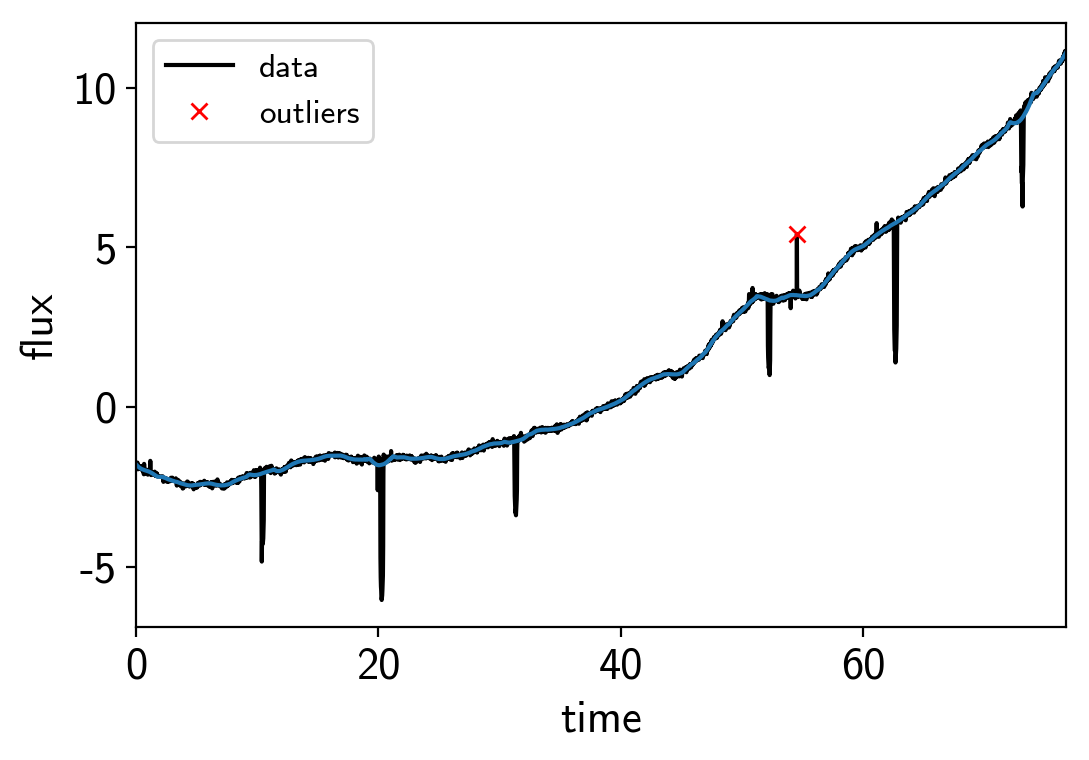

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

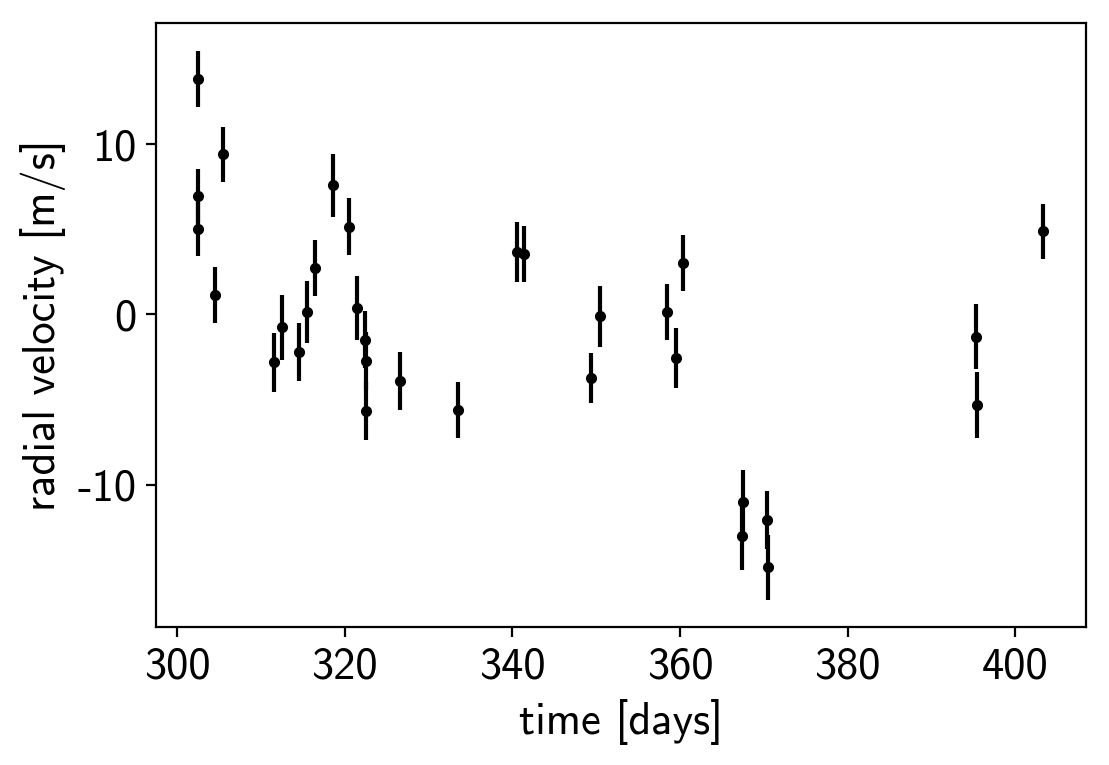

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

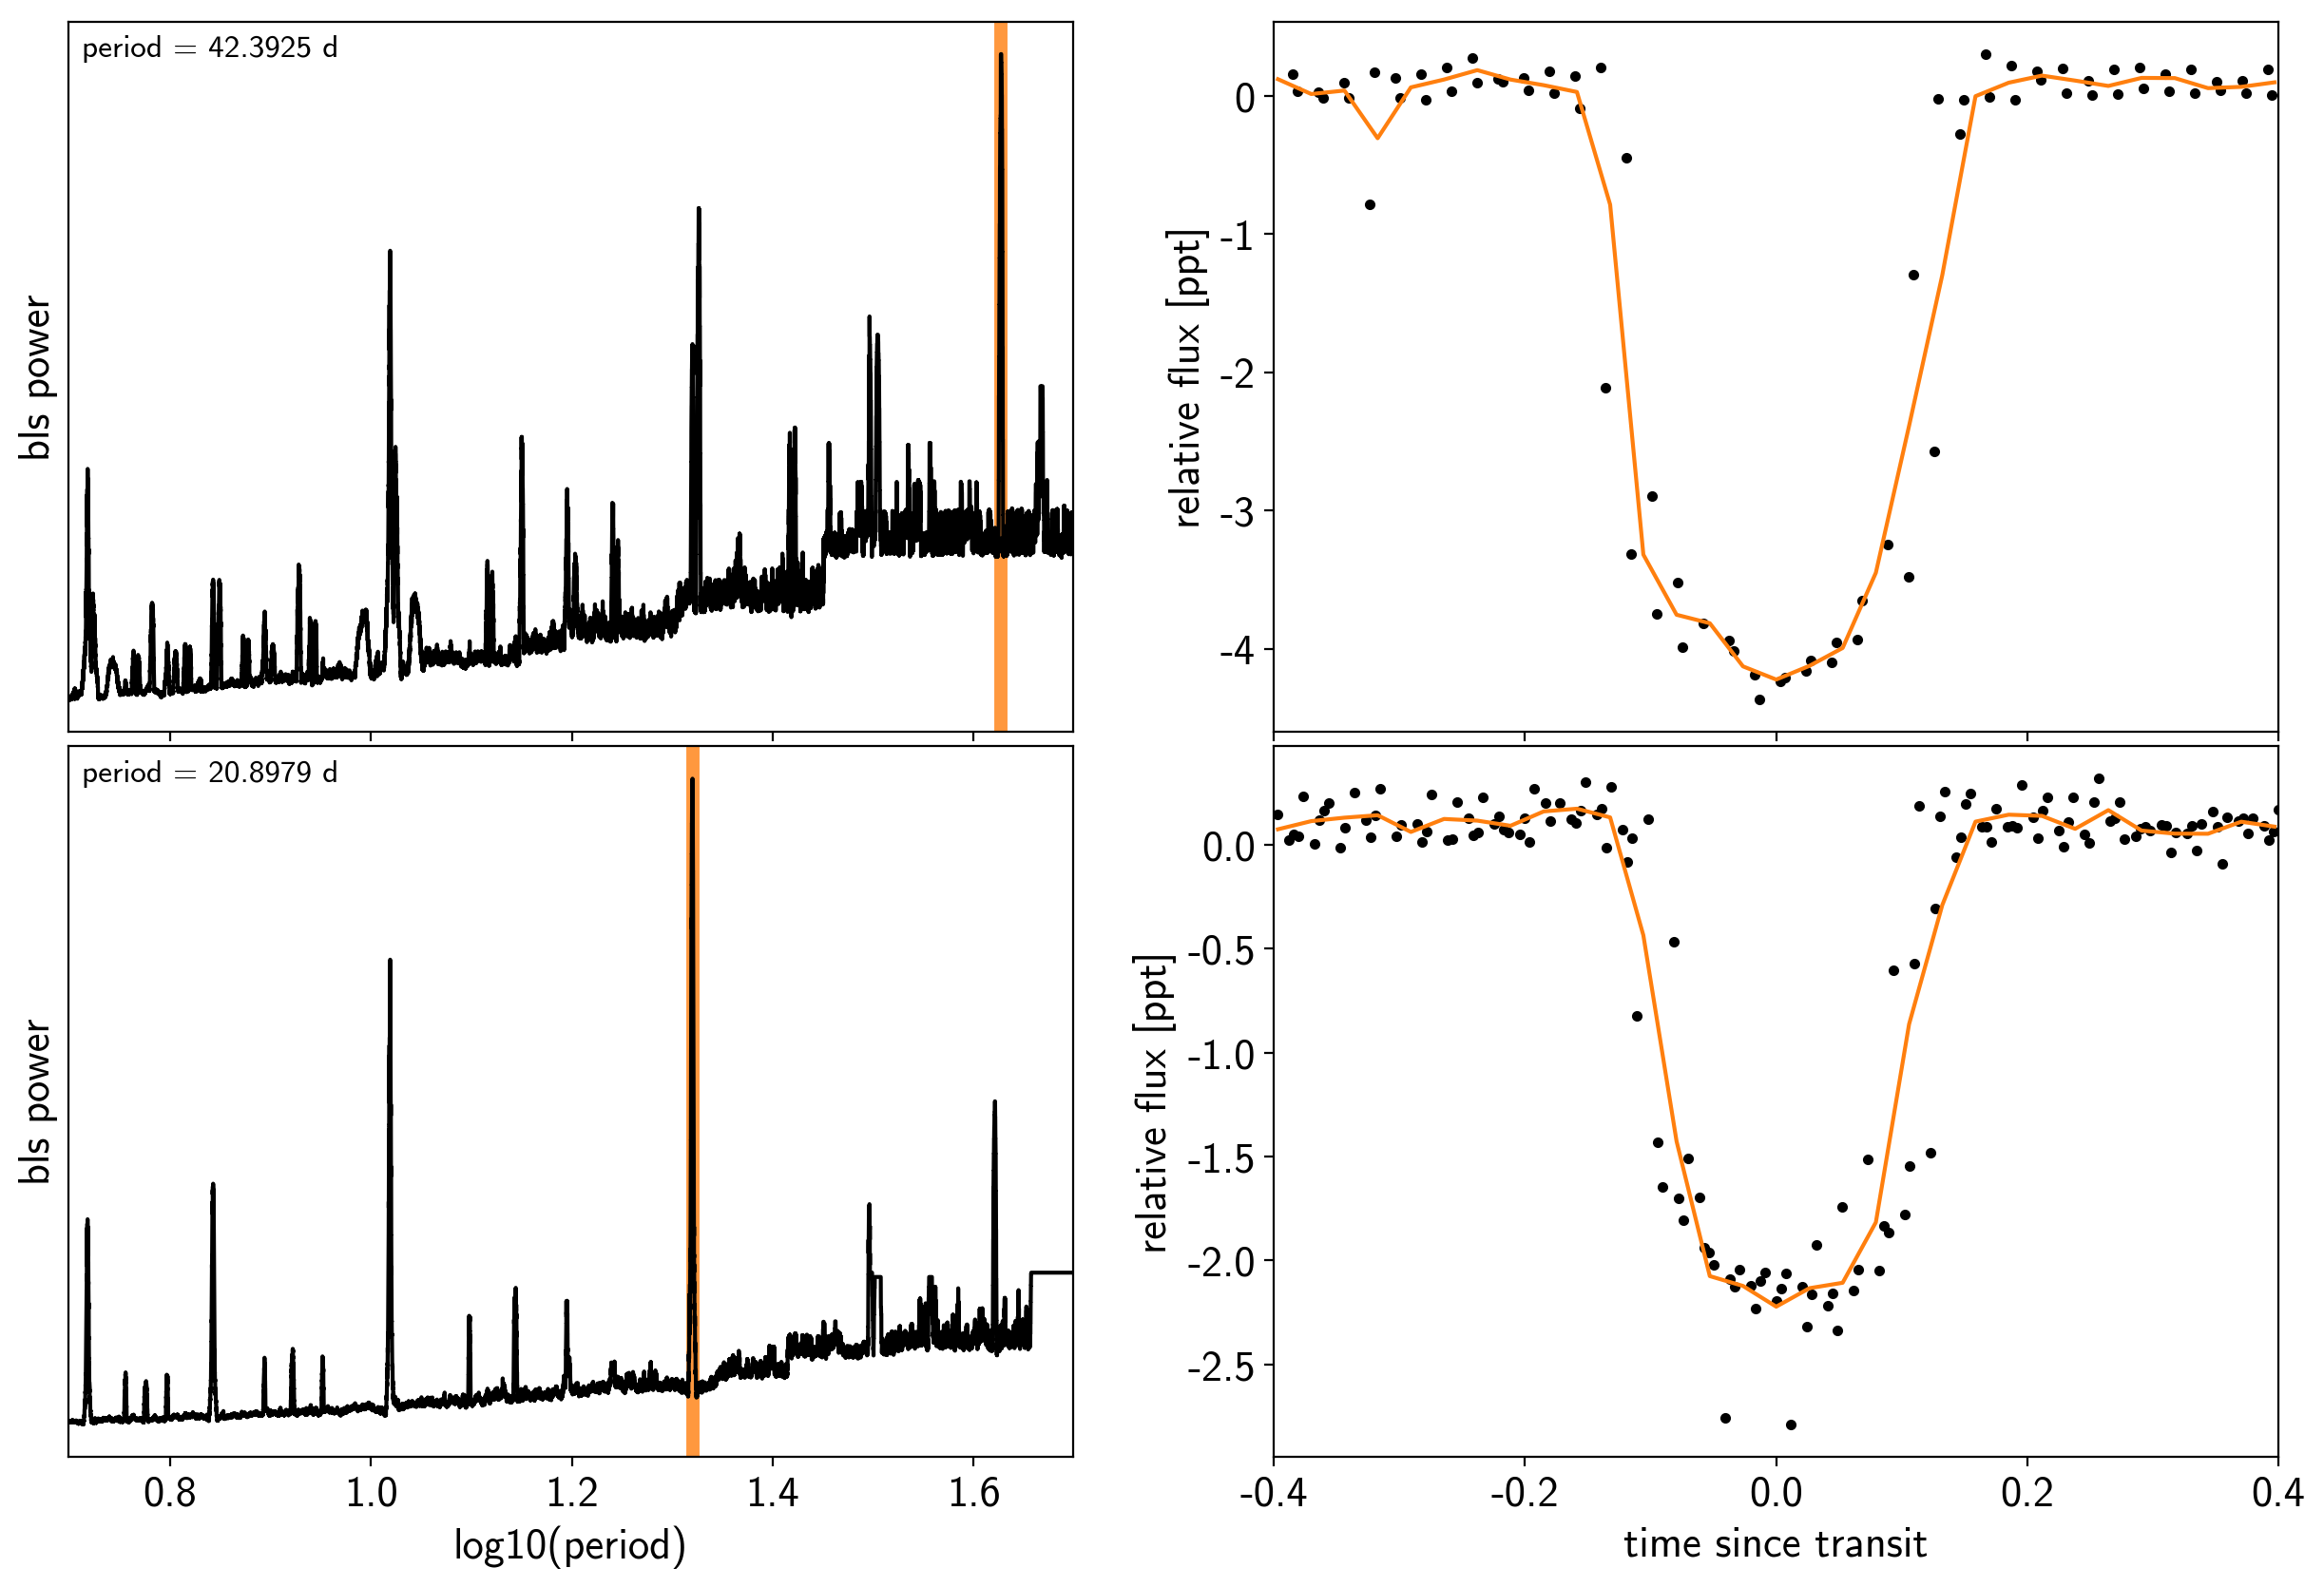

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        m_star = pm.Normal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = pm.Normal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5+np.zeros(2),
                       shape=2)
        ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                         testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)
#         omega_vec = pm.Normal("omega_vec", shape=(2, 2),
#                               testval=np.array([[0., 0.], [1., 1.]]))
#         omega = pm.Deterministic("omega", tt.arctan2(omega_vec[0], omega_vec[1]))

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp, oversample=15)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

success: True
initial logp: -8216.986023857186
final logp: -8201.731058138012


success: True
initial logp: -8201.731058138012
final logp: 2595.6621154808026


success: False
initial logp: 2595.6621154808026
final logp: 2818.9312788464613


success: False
initial logp: 2818.9312788464613
final logp: 3696.09961998513


success: True
initial logp: 3696.09961998513
final logp: 4310.350888676674


success: False
initial logp: 4310.350888676674
final logp: 4381.909298235777


success: False
initial logp: 4381.909298235777
final logp: 4736.854181768206


success: False
initial logp: 4736.854181768206
final logp: 4736.854181768206


success: False
initial logp: 4736.854181768206
final logp: 4736.854181768206


Now let's plot the map radial velocity model.

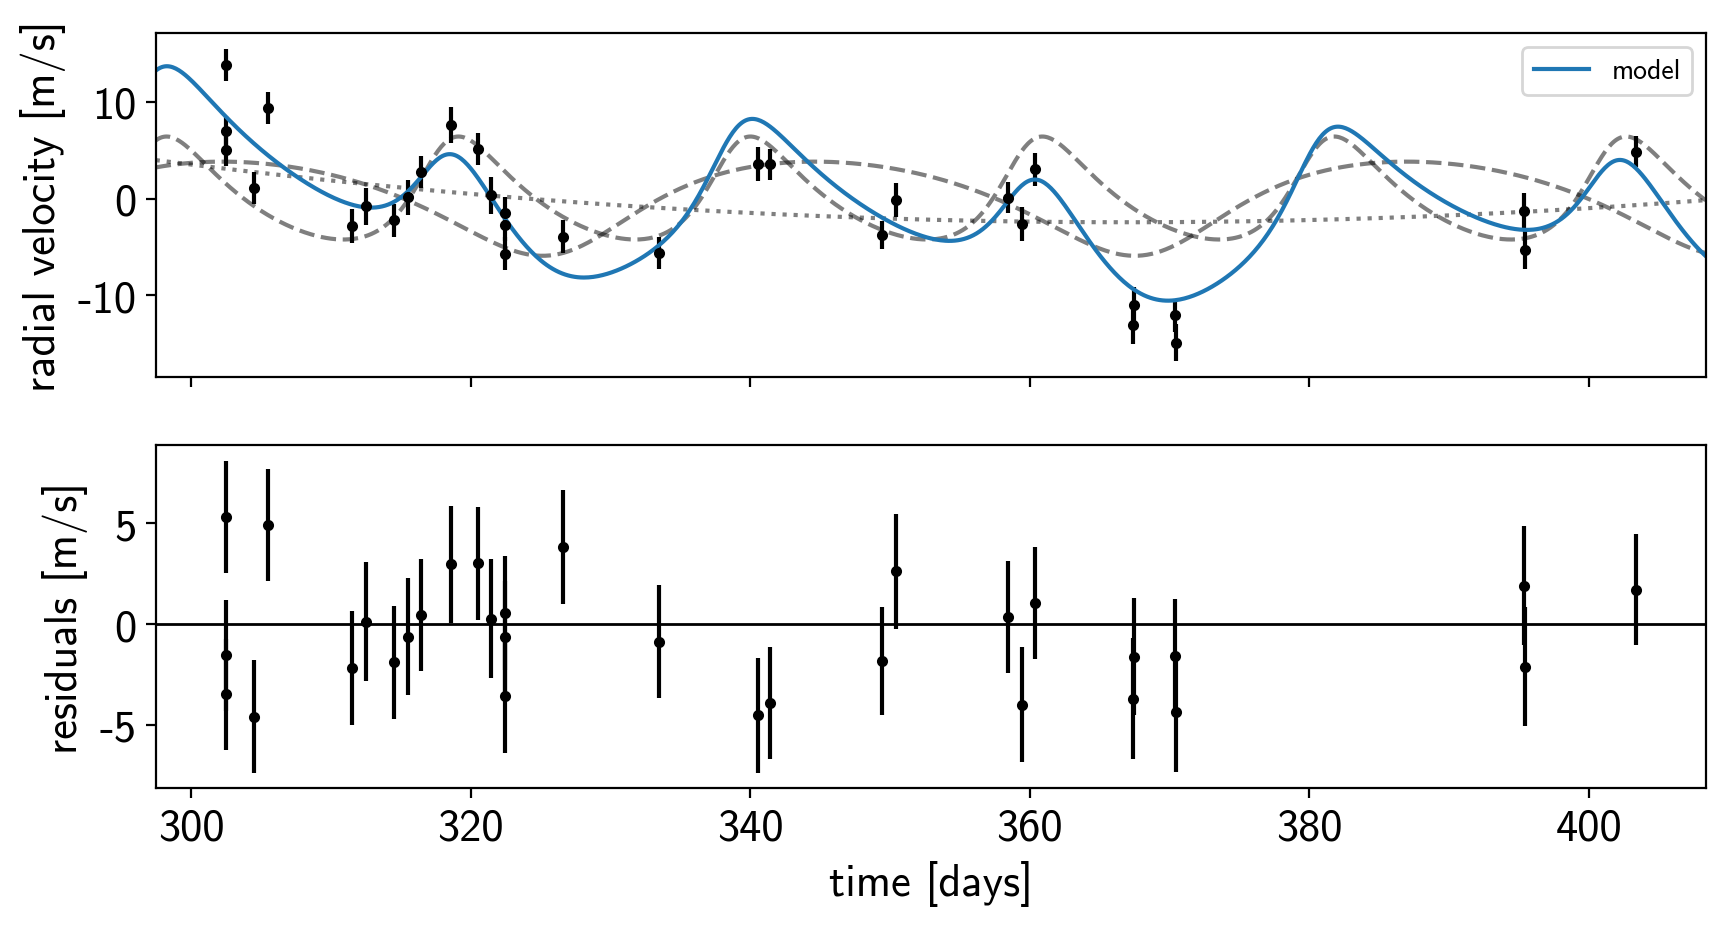

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

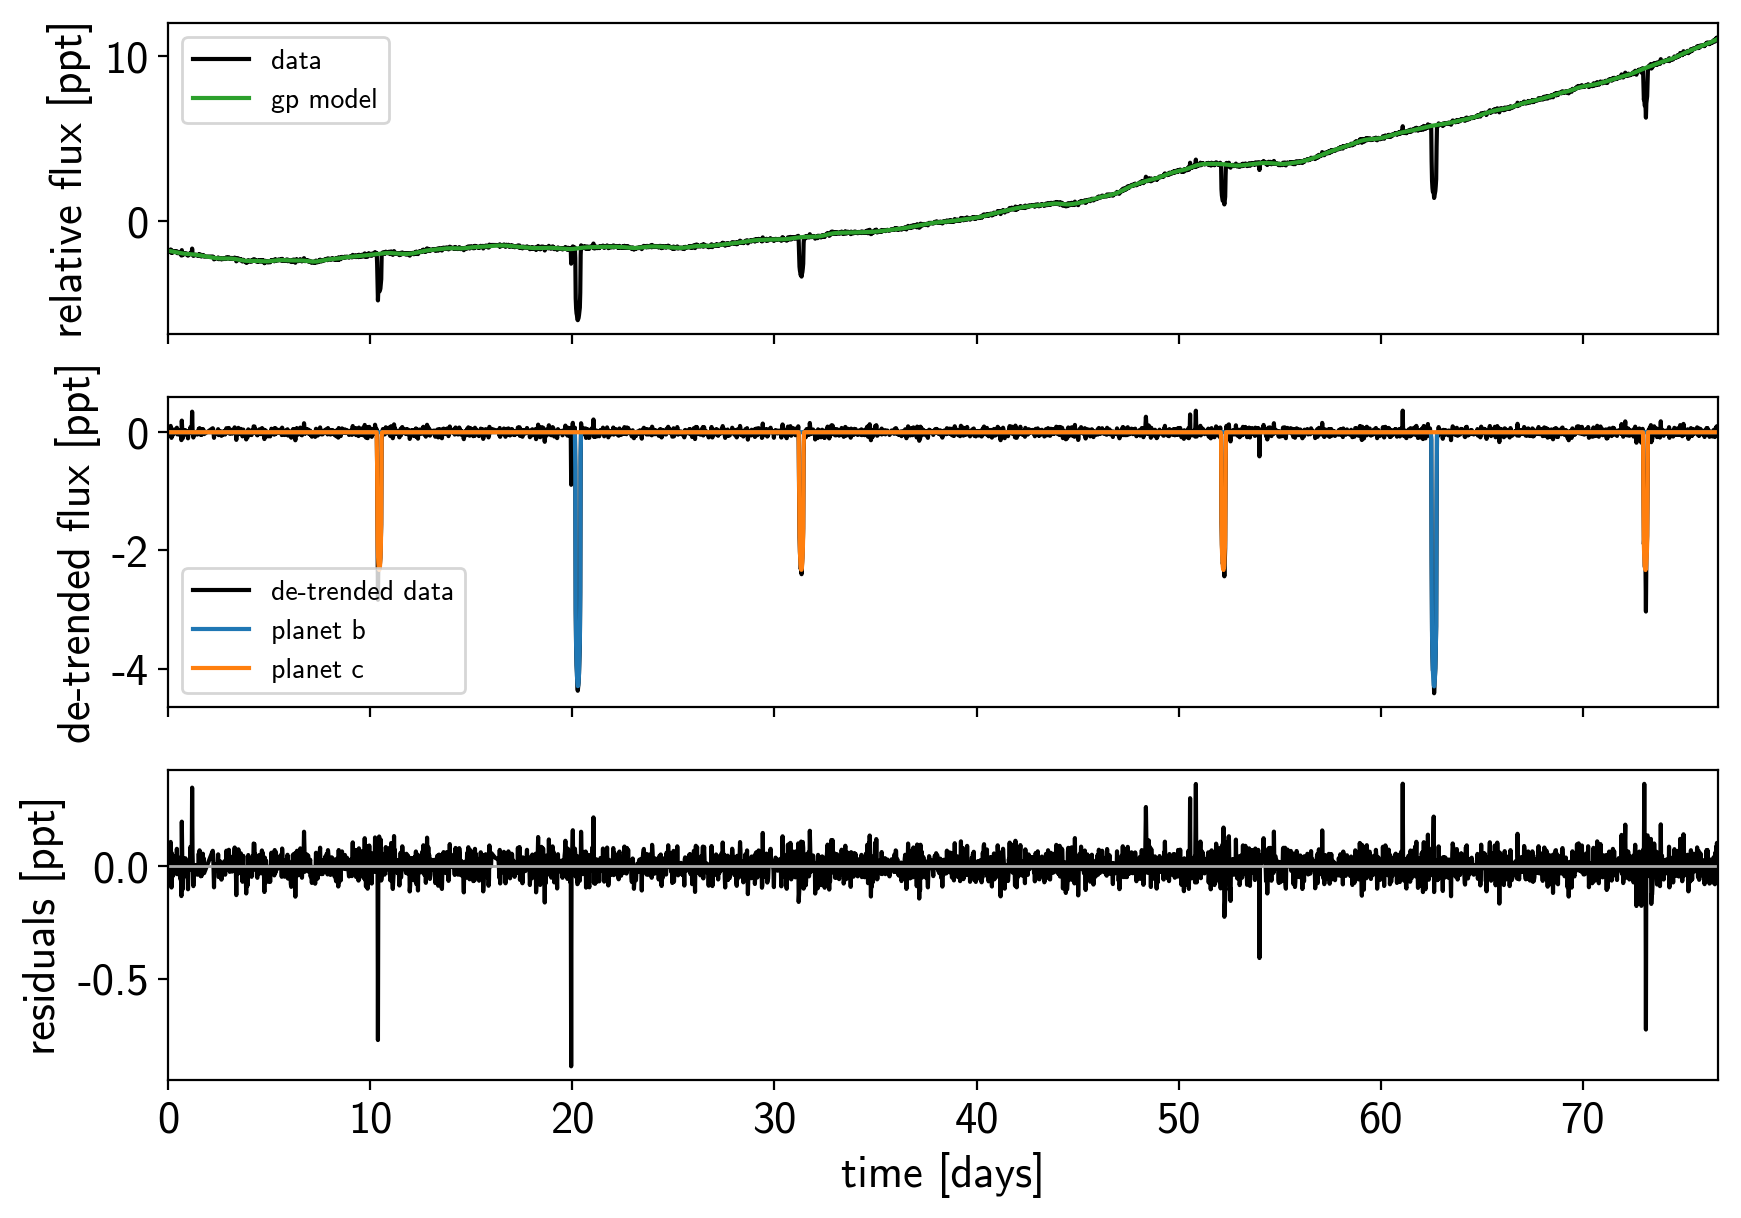

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

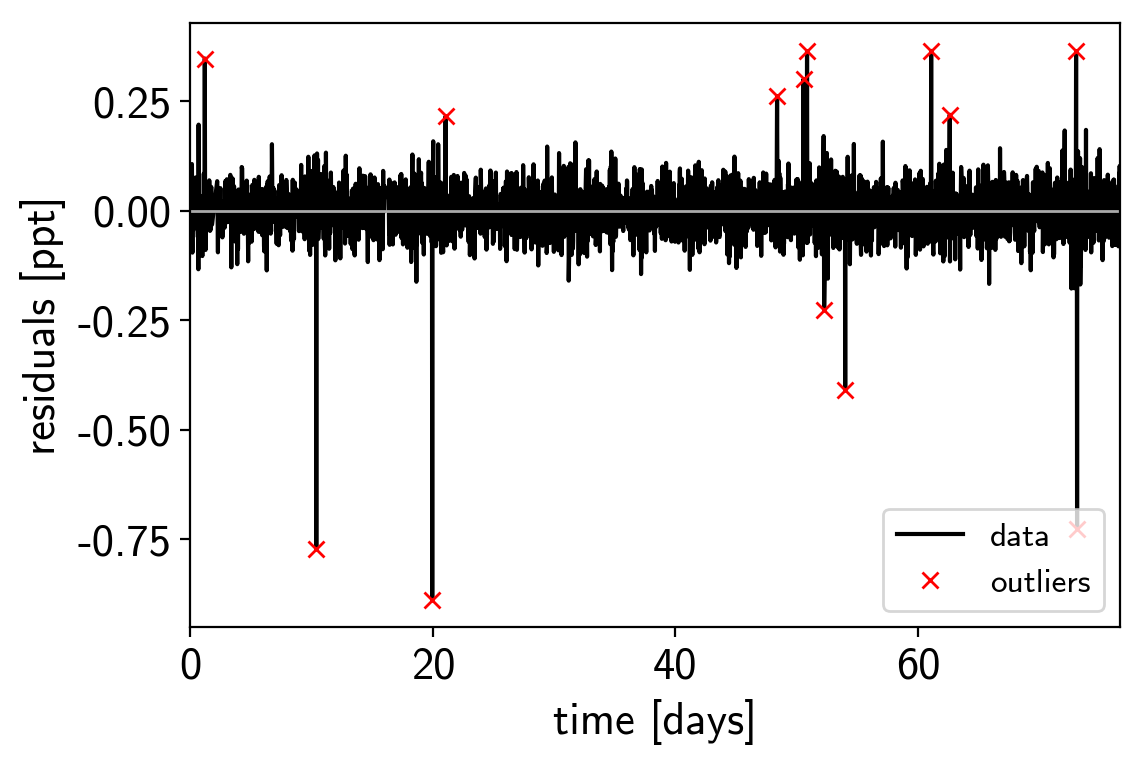

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

success: True
initial logp: 5187.010794742052
final logp: 5187.010794742052


success: False
initial logp: 5187.010794742052
final logp: 5269.180235531842


success: True
initial logp: 5269.180235531842
final logp: 5280.23445245322


success: False
initial logp: 5280.23445245322
final logp: 5281.650186665518


success: True
initial logp: 5281.650186665518
final logp: 5282.38744044657


success: True
initial logp: 5282.38744044657
final logp: 5282.421855235765


success: False
initial logp: 5282.421855235765
final logp: 5284.1306084193475


success: False
initial logp: 5284.1306084193475
final logp: 5284.132620050011


success: False
initial logp: 5284.132620050011
final logp: 5284.1328588708175


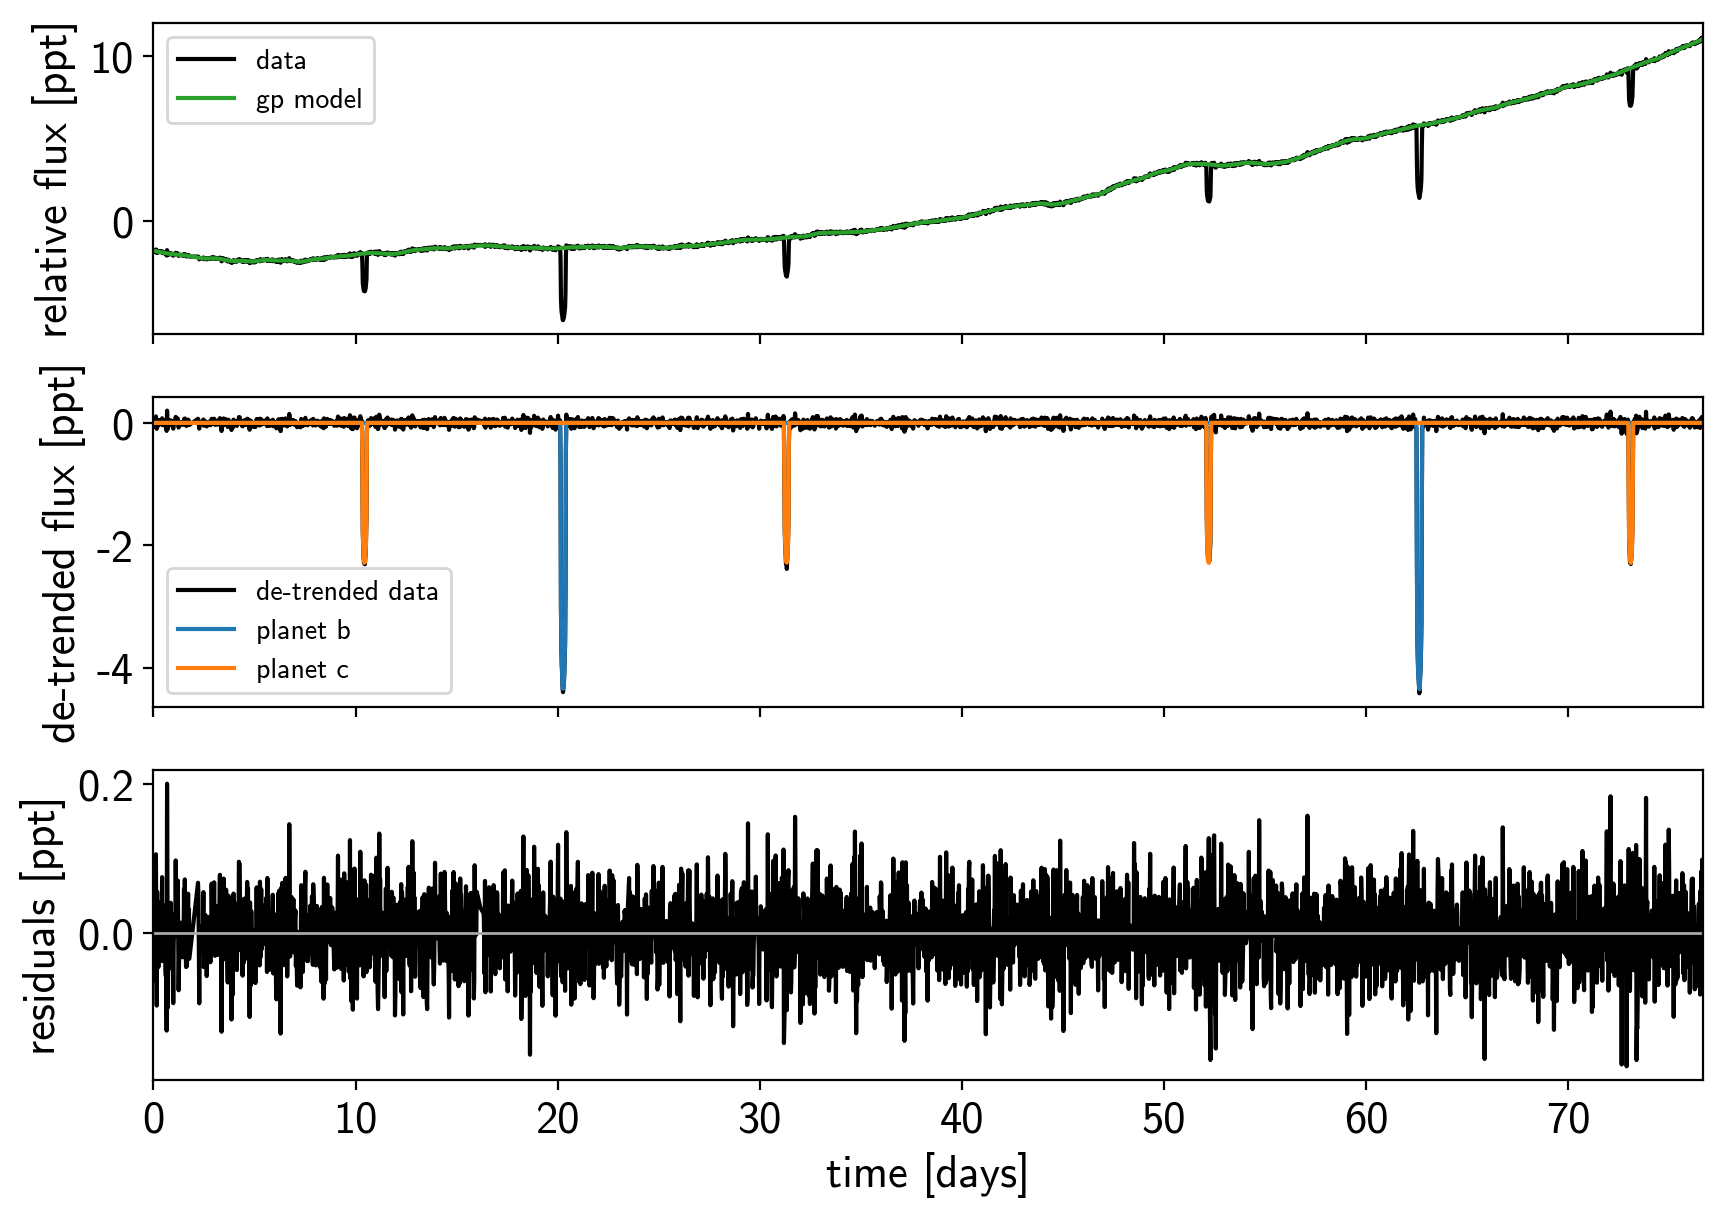

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=200, start=500, finish=800)
with model:
    burnin = sampler.tune(tune=4000, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/2008 [00:00<01:43, 19.32draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:00<01:17, 25.82draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<01:27, 22.73draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:01<03:02, 10.80draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:02<04:09,  7.91draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:03<04:54,  6.67draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:04<05:26,  6.00draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:05<05:49,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:05<06:02,  5.39draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:06<06:11,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:07<06:17,  5.15draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:07<04:50,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:08<06:38,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:08<05:19,  6.08draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:09<07:01,  4.60draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:09<05:35,  5.77draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:10<07:12,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:10<05:41,  5.66draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:10<07:17,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:11<05:41,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:11<07:21,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:11<05:41,  5.64draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:12<07:22,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:12<05:39,  5.65draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:13<07:25,  4.30draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:13<05:55,  5.38draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:14<06:57,  4.58draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:14<05:56,  5.35draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:14<05:16,  6.03draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:15<08:17,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:15<06:28,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:15<05:40,  5.59draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:15<08:36,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:16<07:06,  4.46draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:16<07:46,  4.07draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:16<06:29,  4.87draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:16<05:29,  5.75draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:17<08:37,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:17<06:59,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:17<05:52,  5.37draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:18<08:56,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:18<07:09,  4.39draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:18<06:01,  5.23draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:19<09:07,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:19<07:15,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:19<06:11,  5.08draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:19<09:11,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:20<07:15,  4.32draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:20<06:14,  5.01draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:20<09:14,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:20<07:13,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:21<06:16,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:21<09:19,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:21<07:14,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:21<06:21,  4.91draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:22<09:19,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:22<07:12,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:22<06:21,  4.89draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:23<09:17,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:23<07:19,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:23<06:12,  5.01draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:24<09:09,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:24<07:18,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:24<06:04,  5.10draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:24<09:00,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:25<07:11,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:25<06:02,  5.12draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:25<08:59,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:25<07:16,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:26<07:50,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:26<06:33,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:27<07:15,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:27<05:46,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:28<06:53,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:28<05:41,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:28<06:21,  4.82draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:28<05:25,  5.65draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:29<05:02,  6.07draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:29<07:28,  4.09draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:29<06:14,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:30<05:35,  5.45draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:30<08:08,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:30<06:18,  4.83draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:30<06:22,  4.78draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:31<08:37,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:31<06:42,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:31<06:34,  4.62draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:32<08:43,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:32<06:49,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:32<06:39,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:32<08:57,  3.38draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:33<06:54,  4.38draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:33<06:37,  4.56draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:33<08:52,  3.41draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:33<06:53,  4.38draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:34<06:33,  4.60draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:34<08:46,  3.44draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:34<06:52,  4.38draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:34<06:29,  4.64draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:35<08:39,  3.48draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:35<06:59,  4.30draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:35<06:14,  4.82draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:36<08:25,  3.57draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:36<06:52,  4.37draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:36<06:07,  4.90draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:36<08:14,  3.63draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:37<06:48,  4.40draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:37<06:01,  4.97draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:37<08:06,  3.69draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:37<06:38,  4.50draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:38<05:55,  5.05draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:38<05:17,  5.64draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:38<07:36,  3.92draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:38<06:17,  4.74draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:38<05:42,  5.21draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:38<05:04,  5.88draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:39<07:23,  4.03draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:39<06:11,  4.80draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:39<05:42,  5.21draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:39<04:59,  5.95draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:40<07:15,  4.09draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:40<06:10,  4.81draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:40<05:45,  5.16draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:40<04:57,  5.98draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:40<07:10,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:41<06:09,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:41<05:48,  5.10draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:41<06:19,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:41<05:35,  5.28draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:42<05:28,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:42<06:01,  4.89draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:42<05:27,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:42<05:25,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:43<05:56,  4.95draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:43<05:25,  5.42draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:43<05:30,  5.34draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:44<05:54,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:44<05:27,  5.38draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:44<05:34,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:45<05:54,  4.96draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:45<05:29,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:45<05:40,  5.16draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:45<05:54,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:45<05:32,  5.27draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:46<05:44,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:46<05:54,  4.94draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:46<05:34,  5.22draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:47<05:49,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:47<05:54,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:47<05:36,  5.19draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:47<05:54,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:48<05:55,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:48<05:40,  5.12draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:48<05:59,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:49<05:55,  4.89draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:49<04:55,  5.87draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:49<05:33,  5.21draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:49<07:11,  4.02draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:50<05:50,  4.94draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:50<06:15,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:50<07:31,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:50<06:06,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:51<06:44,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:51<07:30,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:51<06:07,  4.70draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:51<06:48,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:52<07:26,  3.86draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:52<06:05,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:52<06:50,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:53<07:21,  3.89draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:53<06:03,  4.72draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:53<06:51,  4.17draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:53<07:15,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:54<06:00,  4.75draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:54<07:07,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:54<07:04,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:54<05:54,  4.81draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:55<07:06,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:55<06:56,  4.09draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:55<05:50,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:56<07:07,  3.98draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:56<06:50,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:56<05:50,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:56<07:09,  3.96draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:57<06:43,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:57<05:45,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:57<07:24,  3.81draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:57<06:31,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:58<05:26,  5.19draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:58<05:04,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:58<06:59,  4.03draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:58<06:07,  4.60draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:58<05:11,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:58<04:54,  5.73draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:59<06:56,  4.05draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:59<05:57,  4.72draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:59<05:07,  5.48draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [00:59<04:51,  5.78draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:00<07:12,  3.89draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:00<05:54,  4.74draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [01:00<05:24,  5.17draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [01:01<07:38,  3.66draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:01<06:10,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [01:01<05:37,  4.97draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:01<07:49,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:02<06:17,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [01:02<05:40,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:02<08:10,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [01:02<06:22,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [01:03<05:42,  4.87draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [01:03<08:15,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [01:03<06:23,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [01:03<05:43,  4.85draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:04<08:15,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [01:04<06:24,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [01:04<05:46,  4.79draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:05<08:14,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [01:05<06:22,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [01:05<05:45,  4.79draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:05<08:09,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [01:06<06:20,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [01:06<05:44,  4.80draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:06<08:05,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [01:06<06:19,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [01:07<05:42,  4.81draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:07<08:01,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [01:07<06:27,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [01:07<05:24,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:08<07:45,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [01:08<06:23,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [01:08<05:19,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:09<07:38,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [01:09<06:24,  4.26draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [01:09<05:18,  5.13draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:10<07:34,  3.60draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [01:10<06:43,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [01:10<05:22,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [01:10<07:34,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [01:11<06:49,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:11<05:24,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [01:11<07:32,  3.60draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [01:11<06:52,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [01:11<05:25,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:12<07:29,  3.61draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [01:12<06:53,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:12<05:27,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:13<07:26,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:13<06:13,  4.32draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [01:13<05:14,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:14<07:13,  3.72draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:14<06:08,  4.38draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [01:14<05:07,  5.25draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:14<07:04,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:15<06:05,  4.41draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:15<06:21,  4.21draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:15<05:37,  4.75draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:16<05:58,  4.47draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:16<05:24,  4.93draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:17<05:46,  4.62draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:17<05:19,  5.00draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:18<05:38,  4.71draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:18<05:16,  5.03draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:18<05:33,  4.77draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:19<05:16,  5.02draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:19<05:29,  4.81draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:20<05:16,  5.00draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:20<05:26,  4.85draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:20<05:17,  4.98draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:21<05:23,  4.88draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:21<05:18,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:22<05:20,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:22<05:19,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:22<05:17,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [01:23<05:20,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:23<05:15,  4.97draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [01:24<05:21,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:24<05:12,  5.00draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [01:24<05:22,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:25<05:11,  5.00draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [01:25<05:24,  4.80draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:26<05:08,  5.04draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [01:26<05:24,  4.78draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:26<05:05,  5.07draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:27<04:20,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:27<05:55,  4.35draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:27<05:26,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:27<04:36,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [01:28<06:06,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:28<05:32,  4.64draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:28<04:42,  5.45draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:29<06:11,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:29<05:41,  4.51draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [01:29<05:43,  4.47draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:30<05:20,  4.79draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [01:30<05:30,  4.64draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:31<05:09,  4.94draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [01:31<05:23,  4.72draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:31<05:10,  4.91draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [01:32<05:18,  4.78draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:32<05:05,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [01:33<05:19,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:33<05:01,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:33<05:15,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:34<05:04,  4.98draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:34<05:11,  4.86draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:35<05:01,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:35<05:08,  4.89draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:35<05:00,  5.01draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:36<05:06,  4.91draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:36<04:26,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:36<05:20,  4.69draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:37<05:11,  4.81draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:37<04:37,  5.40draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:37<05:23,  4.63draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:37<05:13,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:38<04:45,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:38<05:20,  4.67draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:38<05:10,  4.81draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:38<04:50,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:39<05:30,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:39<05:09,  4.81draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:39<04:58,  4.99draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:39<04:47,  5.17draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [01:40<04:15,  5.81draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:40<05:21,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [01:40<05:14,  4.72draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:40<04:52,  5.07draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:40<04:20,  5.68draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:41<05:21,  4.61draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [01:41<05:21,  4.60draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:41<05:05,  4.84draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:41<05:02,  4.88draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [01:42<05:16,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:42<04:55,  5.00draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:42<04:12,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:42<05:07,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [01:42<05:26,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:43<04:56,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:43<04:14,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:43<05:04,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [01:43<05:32,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [01:43<04:54,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:44<04:15,  5.74draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:44<05:00,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [01:44<05:37,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:44<04:51,  5.02draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:44<04:15,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [01:45<04:56,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:45<05:42,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:45<04:48,  5.06draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:45<04:16,  5.69draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [01:45<04:51,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:46<05:46,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [01:46<04:51,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:46<05:12,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:47<06:08,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [01:47<05:04,  4.75draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [01:47<05:17,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:47<06:18,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:48<05:10,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [01:48<05:17,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:48<06:25,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:48<05:13,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [01:49<05:15,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:49<06:32,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:49<05:14,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [01:49<05:14,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:50<06:37,  3.61draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:50<05:16,  4.53draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [01:50<05:12,  4.59draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [01:51<06:42,  3.56draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:51<05:17,  4.50draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [01:51<05:09,  4.62draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:52<06:47,  3.51draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:52<05:19,  4.46draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [01:52<05:06,  4.65draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:52<06:48,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:52<05:20,  4.44draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [01:53<05:03,  4.69draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:53<06:47,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:53<05:20,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:53<04:59,  4.74draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:54<06:45,  3.49draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:54<05:20,  4.42draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:54<04:54,  4.79draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:55<06:44,  3.49draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:55<05:19,  4.41draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [01:55<04:50,  4.84draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:56<06:42,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:56<05:19,  4.40draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [01:56<04:46,  4.90draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:56<06:41,  3.50draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:57<05:19,  4.39draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [01:57<04:42,  4.95draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:57<06:39,  3.50draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:57<05:18,  4.38draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [01:57<04:38,  5.02draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:58<06:38,  3.50draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:58<05:19,  4.36draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [01:58<04:33,  5.10draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:59<06:36,  3.51draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [01:59<05:22,  4.32draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [01:59<04:27,  5.19draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:00<06:33,  3.52draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:00<05:25,  4.26draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [02:00<04:26,  5.21draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [02:00<06:33,  3.51draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [02:01<05:30,  4.19draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [02:01<04:25,  5.19draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [02:01<06:35,  3.49draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [02:01<05:35,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [02:01<04:26,  5.17draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:02<06:36,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [02:02<05:41,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [02:02<04:27,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:03<06:38,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [02:03<05:47,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [02:03<04:27,  5.11draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [02:04<06:39,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [02:04<05:53,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [02:04<04:28,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [02:05<05:33,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [02:05<05:16,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:05<05:04,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [02:06<04:54,  4.60draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:06<04:53,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [02:07<04:45,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:07<04:51,  4.63draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [02:08<04:42,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:08<04:54,  4.58draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [02:08<04:41,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [02:09<04:57,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [02:09<04:42,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [02:10<04:59,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [02:10<04:42,  4.72draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:10<05:00,  4.44draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [02:11<04:43,  4.70draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:11<04:57,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [02:12<04:41,  4.71draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:12<04:54,  4.50draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [02:12<04:40,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [02:13<04:51,  4.53draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [02:13<04:38,  4.74draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:14<04:48,  4.57draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [02:14<04:36,  4.76draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [02:14<04:45,  4.61draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:14<03:39,  5.99draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [02:15<05:39,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [02:15<05:26,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [02:15<04:11,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [02:16<05:56,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [02:16<05:37,  3.87draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [02:16<04:21,  4.98draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [02:17<05:58,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [02:17<05:37,  3.87draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [02:17<04:24,  4.91draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [02:17<05:55,  3.66draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [02:18<05:33,  3.90draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [02:18<04:24,  4.90draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [02:18<05:50,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:18<05:28,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [02:18<04:28,  4.81draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [02:19<04:43,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:19<04:39,  4.62draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [02:19<03:58,  5.42draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [02:20<04:20,  4.95draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [02:20<04:21,  4.92draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [02:20<03:49,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [02:20<03:55,  5.46draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [02:21<03:40,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [02:21<03:24,  6.28draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [02:21<04:54,  4.34draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [02:22<04:19,  4.93draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [02:22<03:54,  5.45draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [02:22<05:18,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [02:22<04:32,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:23<04:06,  5.17draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [02:23<05:29,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [02:23<04:36,  4.59draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:23<04:12,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [02:24<05:36,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [02:24<04:38,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:24<04:17,  4.92draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [02:25<05:41,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [02:25<04:38,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [02:25<04:21,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [02:25<05:47,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [02:26<04:38,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [02:26<04:25,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [02:26<05:51,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [02:26<04:39,  4.49draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [02:27<04:27,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [02:27<05:50,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [02:27<04:37,  4.50draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [02:27<04:29,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [02:28<05:48,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [02:28<04:36,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [02:28<04:31,  4.59draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [02:29<05:47,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [02:29<04:34,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [02:29<04:32,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [02:29<05:46,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [02:30<04:33,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [02:30<04:34,  4.50draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [02:30<05:44,  3.58draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [02:30<04:31,  4.54draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [02:31<04:36,  4.46draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [02:31<05:43,  3.58draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [02:31<04:30,  4.55draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [02:31<04:37,  4.43draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [02:32<05:42,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [02:32<04:28,  4.56draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [02:32<04:39,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [02:33<05:41,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [02:33<04:36,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [02:33<04:10,  4.88draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [02:33<05:19,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [02:34<04:25,  4.59draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [02:34<04:00,  5.06draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [02:34<05:10,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [02:34<04:23,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [02:35<03:57,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [02:35<05:05,  3.97draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [02:35<04:24,  4.58draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [02:36<08:01,  2.51draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [02:37<10:33,  1.91draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [02:38<12:05,  1.67draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [02:38<09:23,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [02:38<08:42,  2.31draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [02:41<21:22,  1.06s/draws]

Sampling 4 chains:  40%|████      | 805/2008 [02:41<15:33,  1.29draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [02:41<12:21,  1.62draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [02:42<10:40,  1.87draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [02:44<22:36,  1.13s/draws]

Sampling 4 chains:  40%|████      | 809/2008 [02:44<16:47,  1.19draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [02:44<13:03,  1.53draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [02:45<11:03,  1.80draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [02:47<22:42,  1.14s/draws]

Sampling 4 chains:  40%|████      | 813/2008 [02:47<17:12,  1.16draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [02:48<13:10,  1.51draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [02:48<11:02,  1.80draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [02:50<22:32,  1.13s/draws]

Sampling 4 chains:  41%|████      | 817/2008 [02:51<17:27,  1.14draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [02:51<13:11,  1.50draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [02:51<10:57,  1.81draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [02:54<22:18,  1.13s/draws]

Sampling 4 chains:  41%|████      | 821/2008 [02:54<17:40,  1.12draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [02:54<13:09,  1.50draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [02:54<10:50,  1.82draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [02:57<22:03,  1.12s/draws]

Sampling 4 chains:  41%|████      | 825/2008 [02:57<17:52,  1.10draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [02:57<13:08,  1.50draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [02:58<10:43,  1.84draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [03:00<21:47,  1.11s/draws]

Sampling 4 chains:  41%|████▏     | 829/2008 [03:01<18:04,  1.09draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [03:01<13:33,  1.45draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [03:03<23:39,  1.21s/draws]

Sampling 4 chains:  41%|████▏     | 833/2008 [03:04<19:45,  1.01s/draws]

Sampling 4 chains:  42%|████▏     | 835/2008 [03:04<14:36,  1.34draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [03:06<24:14,  1.24s/draws]

Sampling 4 chains:  42%|████▏     | 837/2008 [03:07<20:29,  1.05s/draws]

Sampling 4 chains:  42%|████▏     | 839/2008 [03:07<14:59,  1.30draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [03:10<24:22,  1.25s/draws]

Sampling 4 chains:  42%|████▏     | 841/2008 [03:10<20:50,  1.07s/draws]

Sampling 4 chains:  42%|████▏     | 843/2008 [03:11<15:07,  1.28draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [03:13<24:21,  1.26s/draws]

Sampling 4 chains:  42%|████▏     | 845/2008 [03:14<21:00,  1.08s/draws]

Sampling 4 chains:  42%|████▏     | 847/2008 [03:14<15:10,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [03:16<24:15,  1.25s/draws]

Sampling 4 chains:  42%|████▏     | 849/2008 [03:17<21:07,  1.09s/draws]

Sampling 4 chains:  42%|████▏     | 851/2008 [03:17<15:12,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [03:19<24:08,  1.25s/draws]

Sampling 4 chains:  42%|████▏     | 853/2008 [03:20<21:17,  1.11s/draws]

Sampling 4 chains:  43%|████▎     | 855/2008 [03:20<15:14,  1.26draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [03:23<24:01,  1.25s/draws]

Sampling 4 chains:  43%|████▎     | 857/2008 [03:23<21:23,  1.12s/draws]

Sampling 4 chains:  43%|████▎     | 859/2008 [03:23<15:16,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [03:26<23:53,  1.25s/draws]

Sampling 4 chains:  43%|████▎     | 861/2008 [03:27<21:27,  1.12s/draws]

Sampling 4 chains:  43%|████▎     | 863/2008 [03:27<15:24,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [03:29<23:32,  1.23s/draws]

Sampling 4 chains:  43%|████▎     | 865/2008 [03:30<21:23,  1.12s/draws]

Sampling 4 chains:  43%|████▎     | 867/2008 [03:30<15:27,  1.23draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [03:32<23:08,  1.22s/draws]

Sampling 4 chains:  43%|████▎     | 869/2008 [03:33<21:17,  1.12s/draws]

Sampling 4 chains:  43%|████▎     | 871/2008 [03:33<15:28,  1.22draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [03:35<22:45,  1.20s/draws]

Sampling 4 chains:  43%|████▎     | 873/2008 [03:36<21:12,  1.12s/draws]

Sampling 4 chains:  44%|████▎     | 875/2008 [03:37<15:29,  1.22draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [03:39<22:21,  1.19s/draws]

Sampling 4 chains:  44%|████▎     | 877/2008 [03:40<21:08,  1.12s/draws]

Sampling 4 chains:  44%|████▍     | 879/2008 [03:40<15:30,  1.21draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [03:42<21:58,  1.17s/draws]

Sampling 4 chains:  44%|████▍     | 881/2008 [03:43<20:58,  1.12s/draws]

Sampling 4 chains:  44%|████▍     | 883/2008 [03:43<15:30,  1.21draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [03:45<21:35,  1.15s/draws]

Sampling 4 chains:  44%|████▍     | 885/2008 [03:46<20:48,  1.11s/draws]

Sampling 4 chains:  44%|████▍     | 887/2008 [03:46<15:29,  1.21draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [03:48<21:13,  1.14s/draws]

Sampling 4 chains:  44%|████▍     | 889/2008 [03:49<20:36,  1.11s/draws]

Sampling 4 chains:  44%|████▍     | 891/2008 [03:50<15:27,  1.20draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [03:51<20:51,  1.12s/draws]

Sampling 4 chains:  44%|████▍     | 893/2008 [03:52<20:25,  1.10s/draws]

Sampling 4 chains:  45%|████▍     | 895/2008 [03:53<15:26,  1.20draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [03:55<20:26,  1.10s/draws]

Sampling 4 chains:  45%|████▍     | 897/2008 [03:56<20:14,  1.09s/draws]

Sampling 4 chains:  45%|████▍     | 899/2008 [03:56<15:25,  1.20draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [03:58<20:04,  1.09s/draws]

Sampling 4 chains:  45%|████▍     | 901/2008 [03:59<20:03,  1.09s/draws]

Sampling 4 chains:  45%|████▍     | 903/2008 [03:59<15:25,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [04:01<19:40,  1.07s/draws]

Sampling 4 chains:  45%|████▌     | 905/2008 [04:02<19:50,  1.08s/draws]

Sampling 4 chains:  45%|████▌     | 907/2008 [04:03<15:23,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [04:04<19:18,  1.05s/draws]

Sampling 4 chains:  45%|████▌     | 909/2008 [04:05<19:40,  1.07s/draws]

Sampling 4 chains:  45%|████▌     | 910/2008 [04:05<14:19,  1.28draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [04:06<12:44,  1.43draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [04:07<17:04,  1.07draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [04:09<18:08,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [04:09<13:20,  1.37draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [04:09<12:11,  1.49draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [04:11<16:20,  1.11draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [04:12<17:41,  1.03draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [04:12<13:07,  1.38draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [04:12<12:12,  1.49draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [04:14<15:57,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [04:15<17:26,  1.04draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [04:15<13:04,  1.38draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [04:16<12:19,  1.47draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [04:17<15:41,  1.15draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [04:18<17:18,  1.04draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [04:18<13:06,  1.37draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [04:19<12:27,  1.45draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [04:20<15:24,  1.17draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [04:21<17:11,  1.05draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [04:22<13:07,  1.37draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [04:22<12:34,  1.43draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [04:23<15:10,  1.18draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [04:25<17:04,  1.05draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [04:25<13:08,  1.36draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [04:26<12:42,  1.41draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [04:27<14:56,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [04:28<16:54,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [04:28<13:10,  1.35draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [04:29<12:50,  1.39draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [04:30<14:41,  1.21draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [04:31<16:47,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [04:31<13:11,  1.35draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [04:32<12:57,  1.37draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [04:33<14:26,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [04:34<16:40,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [04:35<13:12,  1.34draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [04:35<13:05,  1.35draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [04:36<14:12,  1.24draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [04:38<16:35,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [04:38<13:20,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [04:39<13:14,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [04:40<13:55,  1.26draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [04:41<16:30,  1.06draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [04:41<13:08,  1.34draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [04:42<13:24,  1.31draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [04:43<13:38,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [04:44<16:25,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [04:44<12:59,  1.35draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [04:45<13:35,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [04:46<13:25,  1.30draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [04:47<16:20,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [04:48<12:51,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [04:48<13:46,  1.26draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [04:49<13:12,  1.32draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [04:50<16:17,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [04:51<12:42,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [04:52<13:57,  1.24draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [04:52<13:00,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [04:54<16:13,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [04:54<12:33,  1.38draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [04:55<14:08,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [04:56<12:48,  1.35draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [04:57<16:11,  1.07draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [04:57<12:25,  1.39draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [04:58<14:18,  1.20draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [04:59<12:36,  1.36draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [05:00<16:07,  1.07draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [05:00<12:18,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [05:01<14:27,  1.19draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [05:02<12:25,  1.38draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [05:03<16:02,  1.07draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [05:04<12:09,  1.41draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [05:05<14:39,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [05:05<12:16,  1.39draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [05:07<15:58,  1.07draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [05:07<12:00,  1.42draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [05:08<14:48,  1.15draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [05:08<12:04,  1.41draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [05:10<15:54,  1.07draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [05:10<11:53,  1.43draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [05:11<14:58,  1.13draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [05:12<11:53,  1.42draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [05:13<15:50,  1.07draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [05:13<11:46,  1.44draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [05:15<15:07,  1.12draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [05:15<11:41,  1.44draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [05:16<15:46,  1.07draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [05:16<11:39,  1.44draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [05:18<15:17,  1.10draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [05:18<11:30,  1.46draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [05:19<15:42,  1.07draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [05:20<11:38,  1.44draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [05:21<15:24,  1.09draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [05:21<11:18,  1.48draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [05:23<15:38,  1.07draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [05:23<11:31,  1.45draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [05:24<15:33,  1.07draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [05:26<14:53,  1.12draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [05:26<10:56,  1.52draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [05:28<15:17,  1.09draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [05:29<14:37,  1.13draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [05:31<14:14,  1.16draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [05:32<13:54,  1.19draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [05:34<13:40,  1.21draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [05:34<10:11,  1.62draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [05:36<14:30,  1.13draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [05:37<14:00,  1.17draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [05:37<10:43,  1.53draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [05:39<14:38,  1.12draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [05:40<14:03,  1.16draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [05:41<11:01,  1.48draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [05:42<14:37,  1.12draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [05:44<13:59,  1.16draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [05:44<11:15,  1.44draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [05:45<14:34,  1.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [05:47<13:54,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [05:47<11:27,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [05:48<14:28,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [05:50<13:47,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [05:50<11:37,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [05:52<14:20,  1.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [05:53<13:40,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [05:54<11:47,  1.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [05:55<14:15,  1.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [05:56<13:32,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [05:57<11:57,  1.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [05:58<14:11,  1.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [06:00<13:26,  1.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [06:00<12:07,  1.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [06:01<14:02,  1.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [06:03<13:18,  1.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [06:03<12:16,  1.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [06:05<13:53,  1.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [06:06<13:11,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [06:07<12:27,  1.27draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [06:08<13:42,  1.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [06:09<13:02,  1.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [06:10<12:36,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [06:11<13:32,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [06:12<12:53,  1.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [06:13<12:46,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [06:14<13:23,  1.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [06:16<12:45,  1.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [06:16<12:57,  1.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [06:17<13:14,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [06:19<12:37,  1.23draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [06:20<13:06,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [06:21<13:08,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [06:22<12:30,  1.24draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [06:23<13:16,  1.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [06:24<13:00,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [06:25<12:22,  1.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [06:26<13:26,  1.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [06:27<12:49,  1.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [06:27<09:29,  1.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [06:28<12:41,  1.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [06:30<13:52,  1.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [06:30<12:53,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [06:30<09:34,  1.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [06:32<12:38,  1.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [06:33<14:05,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [06:33<12:47,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [06:34<09:33,  1.60draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [06:35<12:31,  1.22draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [06:36<14:14,  1.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [06:37<12:38,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [06:37<09:30,  1.59draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [06:38<12:21,  1.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [06:39<14:23,  1.05draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [06:40<12:31,  1.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [06:40<09:27,  1.60draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [06:41<12:12,  1.24draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [06:43<14:32,  1.04draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [06:43<12:22,  1.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [06:43<09:25,  1.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [06:44<12:03,  1.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [06:46<14:40,  1.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [06:46<12:12,  1.23draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [06:46<09:22,  1.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [06:48<11:54,  1.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [06:49<14:48,  1.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [06:49<12:01,  1.24draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [06:50<09:19,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [06:51<11:46,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [06:52<14:56,  1.01s/draws]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [06:53<11:50,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [06:53<09:16,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [06:54<11:38,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [06:56<15:04,  1.02s/draws]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [06:56<11:40,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [06:56<09:13,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [06:57<11:30,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [06:59<15:13,  1.03s/draws]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [06:59<11:32,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [06:59<09:10,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [07:00<11:22,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [07:02<15:21,  1.05s/draws]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [07:02<11:21,  1.29draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [07:03<09:06,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [07:04<11:13,  1.30draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [07:05<15:30,  1.06s/draws]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [07:06<11:38,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [07:07<12:52,  1.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [07:09<16:52,  1.16s/draws]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [07:09<12:29,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [07:10<13:22,  1.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [07:12<17:16,  1.19s/draws]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [07:12<12:45,  1.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [07:13<13:29,  1.07draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [07:15<17:17,  1.20s/draws]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [07:15<12:33,  1.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [07:15<09:47,  1.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [07:16<11:18,  1.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [07:18<15:45,  1.10s/draws]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [07:18<11:43,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [07:19<09:02,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [07:20<10:39,  1.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [07:21<15:16,  1.07s/draws]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [07:22<11:37,  1.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [07:22<08:47,  1.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [07:23<10:23,  1.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [07:25<15:03,  1.06s/draws]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [07:25<11:45,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [07:25<08:41,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [07:26<10:12,  1.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [07:28<14:52,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [07:28<11:52,  1.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [07:29<10:27,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [07:31<15:01,  1.07s/draws]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [07:31<12:13,  1.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [07:32<10:33,  1.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [07:34<15:03,  1.08s/draws]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [07:35<12:26,  1.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [07:36<10:36,  1.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [07:37<15:03,  1.08s/draws]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [07:38<12:31,  1.11draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [07:39<10:36,  1.31draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [07:41<15:03,  1.09s/draws]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [07:41<12:34,  1.10draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [07:42<10:34,  1.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [07:44<15:00,  1.09s/draws]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [07:44<12:36,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [07:45<09:21,  1.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [07:45<09:29,  1.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [07:47<14:13,  1.04s/draws]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [07:48<12:07,  1.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [07:48<09:12,  1.49draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [07:48<09:07,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [07:50<13:54,  1.02s/draws]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [07:51<11:58,  1.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [07:51<09:16,  1.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [07:52<08:54,  1.53draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [07:53<13:42,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [07:54<11:56,  1.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [07:54<09:23,  1.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [07:55<08:43,  1.55draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [07:57<13:31,  1.00draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [07:57<11:54,  1.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [07:58<09:30,  1.42draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [07:58<08:33,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [08:00<13:22,  1.01draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [08:00<11:52,  1.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [08:01<09:38,  1.39draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [08:01<08:23,  1.60draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [08:03<13:13,  1.01draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [08:04<11:50,  1.13draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [08:04<09:45,  1.37draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [08:04<08:13,  1.62draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [08:06<13:04,  1.02draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [08:07<11:50,  1.12draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [08:07<09:55,  1.34draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [08:08<08:03,  1.65draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [08:09<12:53,  1.03draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [08:10<11:48,  1.12draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [08:11<10:02,  1.32draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [08:11<07:54,  1.67draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [08:13<12:43,  1.04draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [08:13<11:48,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [08:14<10:09,  1.30draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [08:14<07:46,  1.69draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [08:16<12:32,  1.05draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [08:17<11:47,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [08:17<10:16,  1.28draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [08:17<07:38,  1.71draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [08:19<12:25,  1.05draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [08:20<11:45,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [08:20<10:22,  1.26draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [08:22<10:52,  1.20draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [08:23<10:44,  1.21draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [08:24<09:47,  1.32draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [08:25<10:19,  1.25draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [08:26<10:28,  1.23draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [08:27<09:31,  1.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [08:29<10:06,  1.27draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [08:29<10:25,  1.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [08:30<09:21,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [08:30<06:57,  1.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [08:32<11:17,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [08:33<11:21,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [08:33<09:55,  1.29draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [08:33<07:33,  1.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [08:35<11:25,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [08:36<11:33,  1.10draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [08:36<09:57,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [08:37<07:48,  1.63draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [08:38<11:19,  1.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [08:39<11:34,  1.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [08:40<09:52,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [08:40<07:57,  1.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [08:41<11:11,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [08:42<11:32,  1.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [08:43<09:45,  1.29draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [08:43<08:04,  1.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [08:45<11:00,  1.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [08:46<11:31,  1.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [08:46<09:39,  1.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [08:46<08:12,  1.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [08:48<10:49,  1.15draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [08:49<11:29,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [08:49<09:32,  1.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [08:50<08:19,  1.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [08:51<10:37,  1.17draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [08:52<11:26,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [08:52<09:25,  1.31draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [08:53<08:26,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [08:54<10:27,  1.18draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [08:55<11:23,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [08:56<09:18,  1.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [08:56<08:33,  1.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [08:57<10:16,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [08:59<11:21,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [08:59<09:11,  1.33draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [08:59<08:40,  1.41draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [09:01<10:07,  1.21draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [09:02<11:17,  1.08draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [09:02<09:04,  1.34draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [09:03<08:47,  1.38draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [09:04<09:57,  1.22draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [09:05<11:14,  1.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [09:05<08:58,  1.35draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [09:06<08:55,  1.35draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [09:07<09:46,  1.23draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [09:08<11:13,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [09:08<08:51,  1.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [09:09<09:01,  1.33draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [09:10<09:35,  1.25draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [09:11<11:09,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [09:12<08:44,  1.37draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [09:12<09:07,  1.31draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [09:13<09:25,  1.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [09:15<11:07,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [09:15<08:37,  1.38draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [09:16<09:14,  1.28draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [09:17<09:15,  1.28draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [09:18<11:04,  1.07draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [09:18<08:30,  1.39draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [09:19<09:21,  1.26draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [09:20<09:08,  1.29draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [09:21<11:00,  1.07draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [09:21<08:23,  1.40draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [09:22<09:28,  1.24draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [09:23<08:58,  1.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [09:24<10:57,  1.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [09:24<08:16,  1.41draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [09:26<09:35,  1.22draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [09:26<08:49,  1.32draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [09:27<10:53,  1.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [09:28<08:10,  1.42draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [09:29<09:41,  1.20draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [09:29<08:39,  1.34draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [09:31<10:50,  1.07draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [09:31<08:04,  1.43draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [09:32<09:47,  1.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [09:33<08:29,  1.36draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [09:34<10:47,  1.07draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [09:34<07:56,  1.45draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [09:35<09:54,  1.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [09:36<08:20,  1.37draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [09:37<10:43,  1.07draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [09:39<09:55,  1.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [09:39<08:09,  1.40draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [09:40<10:37,  1.07draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [09:42<09:53,  1.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [09:42<07:56,  1.43draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [09:44<10:29,  1.08draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [09:45<09:51,  1.14draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [09:45<07:42,  1.46draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [09:47<10:23,  1.08draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [09:48<09:50,  1.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [09:49<07:27,  1.50draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [09:50<10:16,  1.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [09:52<09:48,  1.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [09:52<07:14,  1.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [09:53<10:09,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [09:55<09:46,  1.13draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [09:56<09:27,  1.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [09:58<09:20,  1.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [10:00<09:03,  1.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [10:01<09:03,  1.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [10:03<08:49,  1.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [10:05<08:52,  1.23draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [10:05<06:35,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [10:06<09:14,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [10:08<09:08,  1.18draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [10:08<06:58,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [10:09<09:17,  1.16draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [10:11<09:09,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [10:11<07:09,  1.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [10:12<09:13,  1.16draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [10:13<06:47,  1.57draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [10:14<09:41,  1.10draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [10:14<07:43,  1.38draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [10:16<09:24,  1.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [10:16<06:59,  1.52draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [10:17<09:43,  1.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [10:18<07:54,  1.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [10:19<09:21,  1.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [10:19<06:59,  1.51draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [10:21<09:40,  1.09draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [10:21<08:00,  1.31draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [10:22<09:14,  1.14draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [10:22<06:55,  1.52draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [10:24<09:34,  1.09draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [10:24<08:05,  1.29draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [10:25<09:06,  1.15draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [10:25<06:53,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [10:27<09:28,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [10:27<08:11,  1.27draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [10:28<08:58,  1.16draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [10:29<06:49,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [10:30<09:21,  1.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [10:31<08:16,  1.25draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [10:32<08:50,  1.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [10:32<06:47,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [10:33<09:15,  1.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [10:34<08:20,  1.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [10:35<08:41,  1.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [10:35<06:45,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [10:37<09:07,  1.12draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [10:37<08:25,  1.21draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [10:38<08:34,  1.19draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [10:38<06:42,  1.51draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [10:40<09:01,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [10:40<08:30,  1.19draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [10:41<08:26,  1.20draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [10:42<06:40,  1.51draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [10:43<08:53,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [10:44<08:34,  1.17draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [10:45<08:18,  1.21draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [10:45<06:38,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [10:46<08:45,  1.14draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [10:47<08:39,  1.16draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [10:48<08:11,  1.22draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [10:48<06:35,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [10:49<08:37,  1.15draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [10:50<08:43,  1.14draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [10:51<08:04,  1.23draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [10:51<06:32,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [10:53<08:29,  1.16draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [10:54<08:47,  1.12draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [10:54<07:56,  1.24draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [10:54<06:30,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [10:56<08:22,  1.17draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [10:57<08:52,  1.10draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [10:57<07:49,  1.25draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [10:58<06:28,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [10:59<08:14,  1.18draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [11:00<08:56,  1.09draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [11:01<07:42,  1.26draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [11:01<06:26,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [11:02<08:06,  1.19draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [11:03<09:00,  1.07draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [11:04<07:36,  1.27draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [11:04<06:23,  1.51draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [11:05<07:59,  1.20draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [11:07<09:05,  1.06draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [11:07<07:29,  1.28draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [11:07<06:21,  1.50draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [11:09<07:51,  1.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [11:10<09:08,  1.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [11:10<07:22,  1.29draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [11:11<06:18,  1.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [11:12<07:44,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [11:13<09:12,  1.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [11:13<07:16,  1.30draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [11:14<06:14,  1.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [11:15<07:36,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [11:16<09:15,  1.02draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [11:17<07:10,  1.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [11:17<06:11,  1.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [11:18<07:30,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [11:20<09:19,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [11:20<07:04,  1.32draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [11:20<06:08,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [11:21<07:24,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [11:23<09:21,  1.01s/draws]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [11:23<06:56,  1.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [11:23<06:05,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [11:25<07:17,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [11:26<09:26,  1.03s/draws]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [11:27<07:20,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [11:28<08:04,  1.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [11:29<10:06,  1.11s/draws]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [11:30<07:45,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [11:31<08:16,  1.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [11:33<10:20,  1.14s/draws]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [11:33<07:52,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [11:34<08:17,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [11:36<10:20,  1.15s/draws]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [11:36<07:53,  1.14draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [11:37<08:12,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [11:39<10:16,  1.15s/draws]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [11:39<07:30,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [11:40<06:18,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [11:41<07:01,  1.26draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [11:42<09:26,  1.06s/draws]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [11:42<07:02,  1.26draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [11:43<05:53,  1.50draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [11:44<06:38,  1.33draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [11:45<09:09,  1.04s/draws]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [11:46<06:59,  1.26draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [11:46<05:44,  1.53draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [11:47<06:27,  1.35draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [11:49<09:02,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [11:49<07:01,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [11:49<05:39,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [11:50<06:19,  1.37draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [11:52<08:55,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [11:52<07:04,  1.22draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [11:52<05:36,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [11:53<06:12,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [11:55<08:50,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [11:55<07:07,  1.20draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [11:56<05:32,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [11:56<06:04,  1.41draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [11:58<08:44,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [11:59<07:10,  1.19draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [11:59<05:29,  1.55draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [12:00<05:58,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [12:01<08:39,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [12:02<07:13,  1.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [12:02<05:25,  1.55draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [12:03<05:51,  1.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [12:05<08:33,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [12:05<07:16,  1.15draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [12:05<05:22,  1.56draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [12:06<05:44,  1.45draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [12:08<08:28,  1.02s/draws]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [12:08<07:20,  1.13draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [12:09<06:09,  1.34draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [12:11<08:45,  1.06s/draws]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [12:12<07:39,  1.08draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [12:12<06:17,  1.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [12:14<08:50,  1.08s/draws]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [12:15<07:49,  1.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [12:16<06:20,  1.29draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [12:17<08:51,  1.09s/draws]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [12:18<07:51,  1.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [12:19<06:19,  1.28draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [12:21<08:50,  1.10s/draws]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [12:21<07:52,  1.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [12:22<06:18,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [12:24<08:47,  1.10s/draws]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [12:25<07:50,  1.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [12:25<06:15,  1.27draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [12:27<08:44,  1.10s/draws]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [12:28<07:50,  1.01draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [12:28<05:46,  1.37draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [12:28<05:13,  1.51draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [12:30<08:00,  1.02s/draws]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [12:31<07:20,  1.07draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [12:31<05:30,  1.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [12:32<04:54,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [12:34<07:45,  1.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [12:34<07:11,  1.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [12:34<05:28,  1.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [12:35<04:44,  1.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [12:37<07:37,  1.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [12:37<07:06,  1.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [12:38<05:29,  1.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [12:38<04:37,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [12:40<07:31,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [12:41<07:03,  1.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [12:41<05:31,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [12:41<04:32,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [12:43<07:24,  1.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [12:44<06:59,  1.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [12:44<05:33,  1.36draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [12:44<04:27,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [12:46<07:18,  1.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [12:47<06:56,  1.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [12:47<05:36,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [12:48<04:21,  1.71draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [12:50<07:12,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [12:50<06:52,  1.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [12:51<05:37,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [12:51<04:16,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [12:53<07:06,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [12:54<06:49,  1.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [12:54<05:38,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [12:54<04:11,  1.76draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [12:56<07:00,  1.05draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [12:57<06:46,  1.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [12:57<05:39,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [12:59<06:02,  1.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [13:00<06:06,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [13:00<05:14,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [13:02<05:41,  1.26draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [13:03<05:52,  1.22draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [13:04<05:05,  1.41draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [13:06<05:32,  1.29draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [13:06<05:47,  1.23draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [13:07<04:57,  1.43draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [13:09<05:27,  1.30draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [13:10<05:43,  1.23draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [13:10<04:52,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [13:10<03:39,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [13:12<06:16,  1.12draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [13:13<06:18,  1.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [13:13<05:13,  1.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [13:13<03:59,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [13:15<06:23,  1.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [13:16<06:23,  1.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [13:17<05:14,  1.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [13:17<04:06,  1.68draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [13:18<06:20,  1.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [13:19<06:21,  1.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [13:20<05:12,  1.31draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [13:20<04:09,  1.64draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [13:22<06:15,  1.09draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [13:23<06:17,  1.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [13:23<05:07,  1.32draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [13:23<04:11,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [13:25<06:09,  1.09draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [13:26<06:13,  1.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [13:26<05:02,  1.33draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [13:27<04:13,  1.58draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [13:28<06:04,  1.10draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [13:29<06:09,  1.08draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [13:29<04:57,  1.34draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [13:30<04:15,  1.56draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [13:31<05:58,  1.10draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [13:32<06:04,  1.08draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [13:33<04:53,  1.34draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [13:33<04:16,  1.53draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [13:34<05:53,  1.11draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [13:35<05:59,  1.09draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [13:36<04:48,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [13:36<04:18,  1.50draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [13:38<05:47,  1.12draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [13:39<05:55,  1.09draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [13:39<04:43,  1.36draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [13:40<04:20,  1.48draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [13:41<05:42,  1.12draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [13:42<05:51,  1.09draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [13:42<04:39,  1.37draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [13:43<04:21,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [13:44<05:36,  1.13draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [13:45<05:47,  1.09draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [13:45<04:34,  1.38draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [13:46<04:23,  1.43draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [13:47<05:30,  1.14draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [13:48<05:43,  1.09draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [13:49<04:30,  1.38draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [13:49<04:25,  1.41draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [13:51<05:23,  1.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [13:52<05:38,  1.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [13:52<04:25,  1.39draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [13:53<04:27,  1.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [13:54<05:17,  1.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [13:55<05:34,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [13:55<04:20,  1.40draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [13:56<04:29,  1.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [13:57<05:12,  1.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [13:58<05:30,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [13:58<04:15,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [13:59<04:31,  1.33draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [14:00<05:06,  1.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [14:01<05:26,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [14:01<04:11,  1.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [14:02<04:33,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [14:03<05:00,  1.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [14:04<05:22,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [14:05<04:07,  1.43draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [14:06<04:34,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [14:07<04:55,  1.19draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [14:08<05:18,  1.10draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [14:08<04:02,  1.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [14:09<04:36,  1.26draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [14:10<04:49,  1.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [14:11<05:13,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [14:11<03:57,  1.46draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [14:12<04:38,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [14:13<04:43,  1.21draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [14:14<05:09,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [14:14<03:52,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [14:15<04:39,  1.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [14:16<04:38,  1.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [14:17<05:05,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [14:17<03:47,  1.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [14:19<04:40,  1.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [14:19<04:33,  1.23draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [14:20<05:01,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [14:21<03:44,  1.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [14:22<04:41,  1.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [14:23<04:27,  1.24draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [14:24<04:57,  1.11draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [14:24<03:39,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [14:25<04:42,  1.16draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [14:26<04:21,  1.25draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [14:27<04:54,  1.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [14:27<03:35,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [14:28<04:43,  1.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [14:29<04:16,  1.26draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [14:30<04:49,  1.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [14:32<04:34,  1.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [14:32<04:04,  1.31draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [14:33<04:40,  1.14draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [14:35<04:29,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [14:35<03:55,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [14:37<04:34,  1.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [14:38<04:25,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [14:39<03:47,  1.37draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [14:40<04:28,  1.16draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [14:41<04:21,  1.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [14:42<03:40,  1.40draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [14:43<04:23,  1.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [14:45<04:18,  1.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [14:45<03:33,  1.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [14:46<04:17,  1.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [14:48<04:15,  1.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [14:48<03:26,  1.45draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [14:49<04:12,  1.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [14:51<04:12,  1.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [14:51<03:20,  1.48draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [14:53<04:07,  1.19draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [14:54<04:09,  1.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [14:55<03:14,  1.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [14:56<04:01,  1.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [14:58<04:06,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [14:58<03:07,  1.53draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [14:59<03:55,  1.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [15:01<04:02,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [15:01<03:01,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [15:02<03:49,  1.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [15:04<03:59,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [15:05<03:40,  1.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [15:07<03:55,  1.18draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [15:09<03:34,  1.28draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [15:11<03:51,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [15:12<03:29,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [15:14<03:46,  1.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [15:15<03:25,  1.30draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [15:17<03:42,  1.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [15:18<03:21,  1.30draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [15:18<02:28,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [15:20<04:14,  1.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [15:20<03:07,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [15:22<03:33,  1.21draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [15:22<02:36,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [15:24<04:16,  1.00draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [15:24<03:11,  1.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [15:25<03:32,  1.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [15:25<02:36,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [15:27<04:13,  1.00s/draws]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [15:27<03:12,  1.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [15:28<03:28,  1.20draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [15:28<02:35,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [15:30<04:09,  1.00s/draws]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [15:30<03:11,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [15:31<03:23,  1.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [15:31<02:32,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [15:33<04:04,  1.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [15:33<03:11,  1.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [15:34<03:18,  1.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [15:35<02:29,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [15:36<03:59,  1.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [15:37<03:10,  1.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [15:38<03:14,  1.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [15:38<02:27,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [15:40<03:55,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [15:40<03:09,  1.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [15:41<03:09,  1.24draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [15:41<02:24,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [15:43<03:50,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [15:43<03:08,  1.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [15:44<03:04,  1.25draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [15:44<02:22,  1.62draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [15:46<03:46,  1.01draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [15:46<03:07,  1.22draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [15:47<03:00,  1.26draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [15:47<02:19,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [15:49<03:41,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [15:50<03:06,  1.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [15:50<02:55,  1.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [15:51<02:17,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [15:52<03:37,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [15:53<03:05,  1.19draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [15:54<02:50,  1.29draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [15:54<02:14,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [15:56<03:32,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [15:56<03:03,  1.17draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [15:57<02:45,  1.30draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [15:57<02:12,  1.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [15:59<03:28,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [15:59<03:02,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [16:00<02:40,  1.31draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [16:00<02:10,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [16:02<03:23,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [16:03<03:00,  1.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [16:03<02:36,  1.32draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [16:03<02:07,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [16:05<03:18,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [16:06<02:59,  1.14draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [16:06<02:32,  1.33draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [16:07<02:05,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [16:08<03:14,  1.04draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [16:09<02:58,  1.12draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [16:10<02:28,  1.34draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [16:10<02:03,  1.61draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [16:12<03:09,  1.04draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [16:12<02:56,  1.11draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [16:13<02:23,  1.36draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [16:13<02:00,  1.61draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [16:15<03:04,  1.04draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [16:16<02:54,  1.10draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [16:16<02:19,  1.37draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [16:16<01:58,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [16:18<03:00,  1.05draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [16:19<02:52,  1.09draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [16:19<02:15,  1.38draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [16:20<01:55,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [16:21<02:56,  1.05draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [16:22<02:50,  1.08draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [16:22<02:11,  1.39draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [16:23<01:53,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [16:25<02:51,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [16:25<02:48,  1.07draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [16:26<02:07,  1.40draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [16:26<01:50,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [16:28<02:47,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [16:29<02:46,  1.06draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [16:29<02:03,  1.41draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [16:29<01:48,  1.61draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [16:31<02:42,  1.06draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [16:32<02:44,  1.05draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [16:32<01:59,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [16:32<01:45,  1.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [16:34<02:38,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [16:35<02:42,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [16:36<02:05,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [16:37<02:48,  1.02s/draws]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [16:38<02:50,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [16:39<02:09,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [16:41<02:49,  1.05s/draws]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [16:42<02:50,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [16:42<02:09,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [16:44<02:46,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [16:45<02:46,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [16:45<02:06,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [16:47<02:42,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [16:48<02:42,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [16:48<01:58,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [16:49<01:40,  1.49draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [16:50<02:21,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [16:51<02:26,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [16:51<01:48,  1.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [16:52<01:32,  1.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [16:53<02:13,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [16:54<02:18,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [16:55<01:45,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [16:55<01:28,  1.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [16:57<02:08,  1.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [16:58<02:13,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [16:58<01:43,  1.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [16:58<01:25,  1.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [17:00<02:03,  1.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [17:01<02:09,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [17:01<01:41,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [17:01<01:22,  1.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [17:03<01:59,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [17:04<02:04,  1.06draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [17:04<01:39,  1.31draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [17:05<01:20,  1.62draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [17:06<01:54,  1.12draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [17:07<02:00,  1.06draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [17:08<01:38,  1.29draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [17:08<01:18,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [17:09<01:50,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [17:10<01:56,  1.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [17:11<01:36,  1.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [17:11<01:15,  1.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [17:13<01:46,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [17:14<01:51,  1.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [17:14<01:34,  1.26draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [17:14<01:12,  1.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [17:16<01:42,  1.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [17:17<01:47,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [17:17<01:32,  1.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [17:18<01:10,  1.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [17:19<01:38,  1.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [17:20<01:43,  1.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [17:21<01:30,  1.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [17:21<01:07,  1.63draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [17:22<01:34,  1.15draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [17:23<01:39,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [17:24<01:28,  1.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [17:24<01:04,  1.64draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [17:25<01:30,  1.16draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [17:27<01:35,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [17:27<01:26,  1.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [17:29<01:22,  1.23draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [17:30<01:27,  1.14draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [17:30<01:21,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [17:32<01:17,  1.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [17:33<01:23,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [17:34<01:18,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [17:35<01:14,  1.25draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [17:36<01:19,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [17:37<01:16,  1.20draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [17:38<01:11,  1.25draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [17:39<01:15,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [17:40<01:13,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [17:42<01:07,  1.25draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [17:43<01:12,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [17:43<01:10,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [17:45<01:04,  1.25draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [17:46<01:09,  1.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [17:47<01:06,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [17:47<00:48,  1.60draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [17:48<01:03,  1.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [17:49<01:06,  1.14draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [17:50<01:04,  1.16draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [17:50<00:47,  1.55draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [17:51<00:59,  1.22draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [17:52<01:03,  1.14draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [17:53<01:01,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [17:53<00:46,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [17:54<00:56,  1.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [17:55<00:59,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [17:56<00:57,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [17:56<00:44,  1.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [17:58<00:52,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [17:59<00:55,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [17:59<00:54,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [18:00<00:42,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [18:01<00:48,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [18:02<00:52,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [18:03<00:50,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [18:03<00:40,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [18:04<00:45,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [18:05<00:48,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [18:06<00:47,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [18:06<00:37,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [18:07<00:41,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [18:08<00:44,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [18:09<00:44,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [18:09<00:35,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [18:10<00:38,  1.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [18:11<00:41,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [18:12<00:40,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [18:13<00:33,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [18:14<00:34,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [18:15<00:37,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [18:16<00:37,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [18:16<00:30,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [18:17<00:31,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [18:18<00:33,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [18:19<00:33,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [18:19<00:28,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [18:20<00:28,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [18:21<00:30,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [18:22<00:30,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [18:22<00:25,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [18:23<00:24,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [18:24<00:27,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [18:25<00:26,  1.16draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [18:26<00:23,  1.30draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [18:26<00:21,  1.35draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [18:27<00:23,  1.19draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [18:28<00:23,  1.15draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [18:29<00:20,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [18:30<00:18,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [18:31<00:20,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [18:32<00:19,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [18:32<00:17,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [18:33<00:15,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [18:34<00:16,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [18:35<00:16,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [18:35<00:14,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [18:36<00:12,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [18:37<00:13,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [18:38<00:12,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [18:39<00:11,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [18:39<00:09,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [18:40<00:09,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [18:41<00:09,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [18:42<00:08,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [18:42<00:06,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [18:44<00:06,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [18:44<00:06,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [18:45<00:05,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [18:48<00:06,  1.31s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [18:49<00:04,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [18:52<00:05,  1.78s/draws]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [18:55<00:04,  2.21s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [18:58<00:02,  2.51s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [19:01<00:00,  2.72s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<00:28, 28.22draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:21, 37.07draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:18, 41.74draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:01<01:09, 11.08draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<01:36,  8.01draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:03<02:05,  6.12draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:03<01:45,  7.21draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:04<02:26,  5.18draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:04<02:03,  6.16draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:05<02:32,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:05<02:14,  5.63draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:05<02:38,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<02:03,  6.09draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:06<01:41,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:06<02:15,  5.53draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:06<02:04,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:07<01:59,  6.21draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:07<01:34,  7.83draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:07<01:58,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:07<01:48,  6.82draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:07<01:46,  6.92draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:07<01:25,  8.57draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:08<02:07,  5.77draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:08<01:57,  6.25draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:09<02:19,  5.26draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:09<02:16,  5.34draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:09<02:00,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:10<02:21,  5.15draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:10<02:21,  5.14draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:10<02:02,  5.93draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:10<01:47,  6.72draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:10<02:44,  4.41draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:11<02:42,  4.44draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:11<02:14,  5.35draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:11<02:16,  5.26draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:11<02:27,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:12<01:58,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:12<02:38,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:12<02:59,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:12<02:20,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:13<02:52,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:13<03:10,  3.72draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:13<02:28,  4.75draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:14<02:18,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:14<02:47,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:14<02:13,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:14<02:06,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:15<02:41,  4.33draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:15<02:25,  4.81draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:15<02:13,  5.22draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:16<02:47,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:16<02:31,  4.58draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:16<01:53,  6.07draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:16<01:44,  6.58draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:17<02:01,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:17<01:50,  6.21draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:17<02:02,  5.61draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:17<02:24,  4.73draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:17<02:19,  4.89draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:18<02:04,  5.48draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:18<02:07,  5.34draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:18<02:28,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:18<02:04,  5.46draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:18<01:59,  5.68draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:19<01:55,  5.86draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:19<02:25,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:19<02:17,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:19<02:10,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:19<01:58,  5.66draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:20<01:55,  5.80draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:20<01:58,  5.65draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:20<02:01,  5.48draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:20<01:49,  6.10draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:20<02:17,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:21<02:15,  4.91draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:21<02:13,  4.96draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:21<01:54,  5.79draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:21<02:22,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:21<02:20,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:22<01:57,  5.59draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:22<01:33,  7.01draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:22<02:42,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:23<02:14,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:23<01:53,  5.75draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:23<02:57,  3.68draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:23<02:25,  4.47draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:24<02:38,  4.08draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:24<02:13,  4.83draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:25<02:13,  4.82draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:25<02:03,  5.20draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:25<01:42,  6.27draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:25<02:10,  4.90draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:26<01:55,  5.51draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:26<02:17,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:26<01:56,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:27<01:40,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:27<02:25,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:27<02:09,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:27<01:54,  5.49draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:28<02:38,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:28<02:16,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:28<01:57,  5.30draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:29<02:40,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:29<02:17,  4.51draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:29<01:57,  5.25draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:29<02:38,  3.89draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:30<02:17,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:30<01:46,  5.78draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:30<02:28,  4.12draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:31<02:19,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:31<02:15,  4.50draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:31<01:54,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:31<02:13,  4.56draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:32<01:57,  5.15draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:32<01:47,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:32<02:04,  4.83draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:33<02:02,  4.91draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:33<01:58,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:33<01:44,  5.72draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:33<01:46,  5.57draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:34<02:01,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:34<01:55,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:34<01:53,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:34<01:52,  5.25draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:35<01:37,  6.05draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:35<01:35,  6.15draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:35<01:38,  5.97draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:35<01:43,  5.65draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:35<01:31,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:36<01:31,  6.37draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:36<02:03,  4.72draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:36<02:02,  4.74draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:36<01:45,  5.50draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:36<01:39,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:37<02:07,  4.54draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:37<02:08,  4.49draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:37<01:52,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:37<01:39,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:37<02:05,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:38<02:08,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:38<01:57,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:38<01:56,  4.88draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:39<02:04,  4.57draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:39<01:55,  4.93draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:39<01:53,  4.99draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:39<02:03,  4.57draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:40<01:55,  4.88draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:40<01:51,  5.02draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:40<02:04,  4.52draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:40<02:01,  4.60draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:41<01:52,  4.97draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:41<02:05,  4.44draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:41<02:06,  4.41draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:42<01:52,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:42<02:07,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:42<02:05,  4.41draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:42<01:51,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:43<02:07,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:43<02:04,  4.41draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:43<01:50,  4.95draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:43<02:08,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:44<02:03,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:44<01:49,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:44<02:08,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:44<02:02,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:45<01:44,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:45<01:39,  5.39draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:45<02:05,  4.27draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:45<01:56,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:45<01:41,  5.25draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:46<01:35,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:46<02:04,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:46<01:54,  4.65draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:46<01:42,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:46<01:32,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:47<02:02,  4.30draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:47<01:52,  4.70draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:47<01:47,  4.91draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:48<01:51,  4.70draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:48<01:30,  5.79draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:48<01:38,  5.32draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:48<01:43,  5.03draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:49<01:33,  5.53draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:49<01:41,  5.08draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:49<01:45,  4.90draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:49<01:34,  5.46draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:50<01:43,  4.94draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:50<01:45,  4.83draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:50<01:35,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:50<01:44,  4.87draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:51<01:45,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:51<01:33,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:51<01:42,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:52<01:44,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:52<01:32,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:52<01:40,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:52<01:44,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:53<01:30,  5.49draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:53<01:38,  5.05draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:53<01:27,  5.66draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:53<01:50,  4.48draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:53<01:34,  5.22draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:54<01:40,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:54<01:34,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:54<01:52,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:54<01:33,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:54<01:38,  4.97draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:55<01:35,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:55<01:51,  4.37draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:55<01:41,  4.81draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:55<01:41,  4.76draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:56<01:52,  4.32draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:56<01:40,  4.80draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:56<01:45,  4.54draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:57<01:51,  4.29draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:57<01:39,  4.82draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:57<01:46,  4.46draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:57<01:51,  4.27draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:58<01:30,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:58<01:38,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:58<01:52,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:58<01:36,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:59<01:43,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:59<01:55,  4.06draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:59<01:37,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:00<01:46,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:00<01:56,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:00<01:37,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [01:00<01:49,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:00<01:30,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [01:01<01:27,  5.22draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [01:01<01:38,  4.64draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [01:01<01:16,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:01<01:14,  6.04draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [01:02<01:16,  5.86draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [01:02<01:12,  6.14draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [01:03<01:26,  5.16draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [01:03<01:18,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [01:04<01:30,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [01:04<01:21,  5.43draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:04<01:32,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [01:05<01:21,  5.35draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [01:05<01:34,  4.60draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:06<01:20,  5.34draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:06<01:34,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:06<01:19,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:07<01:33,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:07<01:19,  5.37draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:08<01:32,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:08<01:18,  5.37draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:09<01:31,  4.59draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:09<01:17,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:09<01:17,  5.30draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:10<01:08,  6.03draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:10<01:23,  4.92draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:10<01:11,  5.66draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [01:11<01:25,  4.76draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:11<01:15,  5.34draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:11<01:04,  6.19draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:12<01:41,  3.95draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:12<01:29,  4.49draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:12<01:14,  5.37draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [01:13<01:45,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:13<01:33,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:13<01:16,  5.14draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:13<01:46,  3.69draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:14<01:38,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:14<01:18,  5.00draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:14<01:46,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:14<01:39,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:15<01:18,  4.92draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:15<01:12,  5.33draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:15<01:22,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:15<01:27,  4.40draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:15<01:15,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:16<01:10,  5.38draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:16<01:19,  4.77draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:16<01:25,  4.45draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:16<01:14,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:16<01:10,  5.35draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:17<01:17,  4.85draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:17<01:23,  4.47draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:17<01:13,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:17<01:13,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:17<01:14,  4.99draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:18<01:22,  4.51draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:18<01:13,  5.04draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:18<01:13,  5.04draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:18<01:12,  5.08draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:19<01:20,  4.54draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:19<01:12,  5.02draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:19<01:14,  4.93draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:19<01:10,  5.17draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:19<01:19,  4.57draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:19<01:12,  4.98draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:20<01:13,  4.89draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:20<01:08,  5.27draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:20<01:18,  4.60draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:20<01:12,  4.95draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:21<01:13,  4.83draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:21<01:06,  5.36draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:21<01:16,  4.62draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:21<01:12,  4.89draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:21<01:13,  4.78draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:21<01:04,  5.43draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:22<01:15,  4.64draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:22<01:11,  4.87draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:22<01:13,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:22<01:03,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:23<01:14,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:23<01:11,  4.85draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:23<01:13,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:23<01:11,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:24<01:10,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:24<01:15,  4.50draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:24<01:10,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:24<01:09,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:25<01:15,  4.45draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:25<01:09,  4.80draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:25<01:09,  4.81draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:25<01:15,  4.39draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:26<01:09,  4.79draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:26<01:09,  4.77draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:26<01:16,  4.32draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:27<01:08,  4.78draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:27<01:09,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:27<01:15,  4.30draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:27<01:07,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:28<01:08,  4.68draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:28<01:14,  4.32draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:28<01:06,  4.78draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:28<01:08,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:29<01:12,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:29<01:05,  4.81draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:29<00:56,  5.54draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:29<00:49,  6.26draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:30<00:54,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:30<01:02,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:30<01:04,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:30<00:55,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:30<00:59,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:31<01:03,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:31<01:06,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:31<00:55,  5.48draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:31<01:00,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:31<01:02,  4.86draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:32<01:06,  4.55draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:32<01:01,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:32<01:00,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:33<01:06,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:33<01:01,  4.78draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:33<00:55,  5.28draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:33<00:52,  5.56draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:34<01:08,  4.25draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:34<00:58,  4.92draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:34<00:54,  5.25draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:35<01:11,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:35<00:58,  4.86draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:35<00:54,  5.19draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:35<01:11,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:35<00:53,  5.21draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:36<00:49,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:36<00:49,  5.59draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:36<01:07,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:36<00:56,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:37<00:44,  6.14draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:37<00:49,  5.46draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:37<00:48,  5.62draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:37<00:57,  4.68draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:37<00:50,  5.37draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:38<00:50,  5.24draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:38<00:57,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:38<00:50,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:39<00:51,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:39<00:56,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:39<00:50,  5.20draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:39<00:51,  5.06draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:40<00:54,  4.77draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:40<00:48,  5.26draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:40<00:50,  5.02draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:41<00:51,  4.96draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:41<00:47,  5.31draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:41<00:50,  4.99draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:41<00:41,  5.96draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:42<00:43,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:42<01:03,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:42<00:49,  4.91draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:42<00:50,  4.86draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:43<01:08,  3.57draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:43<00:52,  4.62draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:43<00:52,  4.61draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:44<01:09,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:44<00:52,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:44<00:52,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:44<01:08,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:45<00:51,  4.48draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:45<00:44,  5.19draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [01:45<01:01,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:46<00:50,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:46<01:00,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:46<00:44,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:47<00:54,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:47<00:52,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:48<00:44,  4.86draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:48<00:34,  6.17draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:48<00:45,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:49<00:36,  5.81draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:49<01:01,  3.44draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:49<00:46,  4.50draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:50<00:48,  4.26draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:50<00:43,  4.71draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:50<00:33,  5.98draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:50<00:27,  7.26draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:51<00:35,  5.61draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:51<00:32,  6.10draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:51<00:28,  6.80draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:52<00:45,  4.28draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:52<00:39,  4.94draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:52<00:30,  6.25draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [01:52<00:45,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:53<00:40,  4.68draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:53<00:41,  4.44draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:53<00:37,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:54<00:31,  5.78draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:54<00:44,  4.11draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:54<00:37,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:54<00:30,  5.85draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:55<00:37,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:55<00:30,  5.65draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:56<00:37,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:56<00:30,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:56<00:23,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:57<00:30,  5.48draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:57<00:28,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:57<00:25,  6.52draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:57<00:22,  7.19draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:57<00:36,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:58<00:34,  4.72draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:58<00:28,  5.64draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:58<00:40,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:58<00:36,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:59<00:29,  5.23draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:59<00:40,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [01:59<00:37,  4.06draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:59<00:29,  5.08draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [02:00<00:39,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [02:00<00:36,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [02:00<00:27,  5.26draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [02:00<00:26,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [02:01<00:35,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [02:01<00:28,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [02:02<00:33,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [02:02<00:26,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [02:02<00:24,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [02:02<00:24,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [02:02<00:23,  5.61draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [02:03<00:22,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [02:03<00:23,  5.56draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [02:03<00:23,  5.38draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [02:04<00:24,  5.25draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [02:04<00:21,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [02:05<00:22,  5.45draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [02:05<00:22,  5.34draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [02:05<00:22,  5.17draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [02:06<00:22,  5.10draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [02:06<00:17,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [02:06<00:22,  5.09draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [02:07<00:20,  5.46draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [02:07<00:17,  6.18draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [02:07<00:22,  4.94draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [02:07<00:17,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [02:07<00:16,  6.41draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [02:07<00:18,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [02:08<00:22,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [02:08<00:20,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [02:08<00:18,  5.61draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [02:08<00:18,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [02:09<00:18,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [02:09<00:16,  6.06draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [02:09<00:16,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [02:09<00:16,  5.66draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [02:10<00:15,  6.05draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [02:10<00:19,  4.67draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [02:10<00:17,  5.18draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [02:10<00:15,  5.78draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [02:11<00:17,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [02:11<00:13,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [02:11<00:13,  6.46draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [02:11<00:18,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [02:12<00:15,  5.29draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [02:12<00:12,  6.13draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [02:12<00:15,  4.93draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [02:12<00:14,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [02:12<00:13,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [02:13<00:11,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [02:13<00:18,  4.02draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [02:13<00:16,  4.41draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [02:13<00:12,  5.53draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [02:14<00:18,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [02:14<00:16,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [02:14<00:12,  5.22draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [02:14<00:11,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [02:15<00:18,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [02:15<00:13,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [02:15<00:15,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [02:16<00:14,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [02:16<00:12,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [02:16<00:10,  5.11draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [02:17<00:10,  4.87draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [02:17<00:09,  5.57draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [02:18<00:09,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [02:18<00:08,  5.73draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [02:19<00:08,  5.31draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [02:19<00:07,  5.72draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [02:19<00:07,  5.32draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:20<00:06,  5.58draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [02:20<00:05,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [02:20<00:08,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [02:20<00:07,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:21<00:06,  4.75draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [02:21<00:05,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:22<00:05,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [02:22<00:03,  6.27draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:22<00:03,  7.29draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:23<00:06,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:23<00:04,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:24<00:06,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:24<00:04,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:24<00:04,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:25<00:03,  3.87draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:25<00:02,  4.56draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:25<00:02,  5.13draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:25<00:02,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:26<00:04,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:26<00:02,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:27<00:02,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:27<00:02,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:28<00:02,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:29<00:01,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:29<00:00,  2.36draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:30<00:00,  1.96draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:31<00:00,  1.59draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<00:08, 196.14draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:00<00:14, 110.41draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:01<01:24, 18.67draws/s] 

Sampling 4 chains:   2%|▏         | 37/1608 [00:02<03:21,  7.78draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:03<04:00,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:03<03:16,  7.98draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:04<04:16,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:05<05:51,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:05<04:30,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:06<05:57,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:06<04:36,  5.62draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:06<05:58,  4.32draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:06<04:41,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:07<05:56,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:07<04:45,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:08<05:55,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:08<04:45,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:09<05:51,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:09<04:48,  5.34draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:10<05:49,  4.40draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:10<04:58,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:10<04:00,  6.37draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:10<07:09,  3.56draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:11<06:02,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:11<04:43,  5.39draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:11<07:31,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:11<06:24,  3.97draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:12<04:57,  5.11draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:12<04:43,  5.38draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:12<06:26,  3.93draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:12<05:32,  4.58draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:12<04:52,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:13<04:38,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:13<06:14,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:13<05:30,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:13<04:47,  5.27draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:13<04:37,  5.46draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:14<06:06,  4.13draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:14<05:32,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:14<04:44,  5.31draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:14<04:37,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:15<06:13,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:15<05:31,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:15<04:39,  5.40draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:15<04:37,  5.44draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:15<06:09,  4.08draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:16<05:37,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:16<04:55,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:16<06:17,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:16<04:52,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:17<08:06,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:17<06:11,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:18<09:09,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:18<06:52,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:19<09:31,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:19<07:10,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:20<09:35,  2.58draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:20<07:15,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:20<09:31,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:21<07:14,  3.40draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:21<09:19,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:21<06:51,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:22<07:17,  3.37draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:22<05:38,  4.35draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:23<06:30,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:23<05:01,  4.86draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:24<06:04,  4.02draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:24<04:42,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:24<03:52,  6.28draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:25<05:08,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:25<04:47,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:25<05:15,  4.61draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:26<04:41,  5.16draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:26<04:31,  5.36draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:26<05:07,  4.73draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:26<04:25,  5.46draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:27<04:22,  5.53draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:27<04:57,  4.87draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:27<04:26,  5.42draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:27<04:26,  5.42draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:28<04:54,  4.90draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:28<04:29,  5.35draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:28<04:28,  5.38draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:29<05:01,  4.77draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:29<04:20,  5.52draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:29<04:23,  5.46draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:30<04:56,  4.85draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:30<04:18,  5.56draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:30<04:23,  5.44draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:30<03:26,  6.93draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:30<05:17,  4.50draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:31<04:38,  5.14draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:31<04:51,  4.89draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:31<04:27,  5.33draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:32<04:31,  5.24draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:32<03:40,  6.46draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:32<04:43,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:32<06:06,  3.88draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:33<04:42,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:33<05:25,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:33<05:23,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:34<05:09,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:34<05:10,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:35<04:55,  4.77draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:35<05:03,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:35<04:49,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:36<04:59,  4.68draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:36<04:51,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:37<04:56,  4.72draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:37<04:19,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:37<06:12,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:38<05:10,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:38<06:51,  3.38draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:39<05:38,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:39<05:33,  4.16draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:39<05:08,  4.48draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:40<05:12,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:40<04:52,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:41<05:03,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:41<04:44,  4.84draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:42<04:58,  4.61draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:42<04:39,  4.92draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:42<04:55,  4.64draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:43<04:37,  4.92draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:43<04:53,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:44<04:35,  4.95draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:44<04:52,  4.66draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:44<04:33,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:45<04:51,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:45<04:32,  4.98draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:46<04:51,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:46<04:30,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [00:47<04:50,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:47<04:29,  5.00draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:47<04:50,  4.64draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:48<04:27,  5.02draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:48<04:49,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:49<04:26,  5.02draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:49<04:48,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:49<04:25,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:50<04:48,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:50<04:23,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:50<03:46,  5.87draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:51<05:27,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:51<04:47,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:51<04:10,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:52<05:39,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:52<04:55,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:52<04:21,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:52<05:41,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:53<04:55,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:53<04:20,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:53<05:44,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:54<04:57,  4.43draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:54<04:32,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:54<05:42,  3.84draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:54<04:54,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:55<04:39,  4.69draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:55<05:37,  3.88draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:55<04:35,  4.75draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:55<04:21,  5.00draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:55<04:15,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:56<05:23,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:56<04:27,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:56<04:11,  5.19draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:56<04:07,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:57<05:21,  4.05draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:57<04:26,  4.88draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:57<04:07,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:57<04:14,  5.10draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:57<05:19,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:58<04:23,  4.92draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [00:58<04:04,  5.29draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:58<04:19,  4.99draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:58<05:16,  4.09draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:58<04:21,  4.95draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:59<04:00,  5.37draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:59<04:13,  5.10draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:59<05:15,  4.08draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:59<04:21,  4.93draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [00:59<03:58,  5.41draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:00<04:09,  5.16draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:00<05:16,  4.06draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:00<04:23,  4.87draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:00<03:56,  5.43draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:00<04:16,  5.00draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:01<05:13,  4.09draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:01<04:24,  4.84draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:01<03:53,  5.48draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:01<04:23,  4.85draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:02<05:09,  4.13draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:02<04:24,  4.83draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:02<03:47,  5.60draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:02<04:17,  4.95draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:02<05:10,  4.11draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:03<04:27,  4.76draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:03<04:12,  5.02draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:03<05:10,  4.08draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:03<04:28,  4.72draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:04<04:15,  4.96draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:04<05:07,  4.12draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:04<04:26,  4.74draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:05<04:15,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:05<04:32,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:05<04:07,  5.09draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:05<04:37,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:06<04:49,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:06<04:19,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [01:06<04:39,  4.48draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [01:07<04:57,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:07<04:24,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:07<04:36,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [01:07<05:00,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:08<04:11,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:08<03:53,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:08<04:48,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [01:08<03:58,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [01:09<04:42,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:09<03:59,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:09<03:06,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [01:10<04:02,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:10<03:52,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:10<03:01,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:11<04:18,  4.76draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [01:11<03:20,  6.12draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [01:12<04:30,  4.53draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:12<03:49,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:12<04:23,  4.64draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:12<03:56,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [01:13<03:33,  5.73draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:13<04:11,  4.85draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:13<03:39,  5.55draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [01:13<03:27,  5.88draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:14<04:06,  4.92draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:14<03:31,  5.75draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:14<03:25,  5.89draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [01:15<04:05,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:15<03:40,  5.50draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [01:16<04:14,  4.75draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:16<03:47,  5.31draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [01:16<04:19,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:17<03:49,  5.24draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [01:17<03:16,  6.12draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:17<04:30,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:18<04:39,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:18<03:49,  5.21draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [01:18<04:56,  4.03draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [01:18<05:00,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:19<04:01,  4.94draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [01:19<05:05,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [01:19<05:07,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:19<04:05,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [01:20<05:08,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [01:20<05:10,  3.82draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:20<04:06,  4.79draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [01:20<04:18,  4.58draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:21<03:52,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [01:21<04:42,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [01:21<04:16,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:21<03:51,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:22<04:43,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [01:22<04:17,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [01:22<03:51,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [01:23<04:43,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:23<04:15,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [01:23<03:51,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [01:23<04:43,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:24<04:14,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [01:24<03:50,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [01:24<04:47,  4.05draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [01:25<04:15,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [01:25<03:49,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:25<04:52,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [01:25<04:15,  4.54draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [01:26<03:50,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:26<04:59,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [01:26<04:16,  4.51draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [01:26<03:55,  4.91draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [01:27<04:57,  3.88draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [01:27<04:14,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [01:27<03:57,  4.83draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [01:28<04:54,  3.91draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [01:28<04:12,  4.55draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [01:28<04:00,  4.77draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [01:28<04:49,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [01:29<04:08,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [01:29<04:03,  4.68draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [01:29<04:45,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [01:29<04:07,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [01:30<04:04,  4.66draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [01:30<04:41,  4.04draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [01:30<03:51,  4.90draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [01:30<03:17,  5.75draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [01:30<03:06,  6.07draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [01:31<04:43,  3.99draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [01:31<03:45,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [01:31<03:45,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [01:32<04:55,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [01:32<03:48,  4.93draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [01:32<04:35,  4.08draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [01:33<03:34,  5.24draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [01:33<04:28,  4.17draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [01:33<03:25,  5.44draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [01:34<04:27,  4.17draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [01:34<03:28,  5.35draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [01:35<04:12,  4.40draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [01:35<03:16,  5.65draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [01:36<04:14,  4.35draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [01:36<03:21,  5.50draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [01:36<03:22,  5.46draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [01:37<04:06,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [01:37<03:08,  5.83draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [01:38<04:03,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [01:38<04:16,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [01:38<03:19,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [01:39<04:16,  4.26draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [01:39<03:17,  5.52draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [01:40<03:07,  5.80draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [01:40<04:19,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [01:40<03:41,  4.90draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [01:40<03:26,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [01:41<04:21,  4.13draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [01:41<03:45,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [01:41<03:30,  5.12draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [01:42<03:23,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [01:42<03:24,  5.27draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [01:42<03:54,  4.58draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [01:42<03:37,  4.93draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [01:43<03:40,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [01:43<03:48,  4.69draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [01:43<03:37,  4.91draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [01:43<03:46,  4.71draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [01:44<03:52,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [01:44<03:37,  4.89draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [01:44<03:51,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [01:44<03:56,  4.48draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [01:45<03:37,  4.87draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [01:45<03:54,  4.52draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [01:45<04:02,  4.36draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [01:46<03:38,  4.83draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [01:46<03:58,  4.43draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [01:46<04:06,  4.27draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:46<03:37,  4.83draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [01:47<04:00,  4.36draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [01:47<04:13,  4.14draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:47<03:39,  4.78draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [01:47<03:20,  5.21draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [01:48<03:01,  5.75draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [01:48<03:08,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [01:48<03:04,  5.64draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [01:48<02:38,  6.58draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:49<03:52,  4.48draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [01:49<03:59,  4.33draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [01:49<03:21,  5.15draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:49<03:50,  4.50draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [01:50<03:29,  4.93draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [01:50<03:40,  4.68draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:50<03:57,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [01:51<03:33,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [01:51<03:47,  4.52draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:51<04:00,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [01:51<03:34,  4.77draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [01:52<04:01,  4.24draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [01:52<03:57,  4.31draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [01:52<03:31,  4.84draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [01:52<03:14,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:52<03:13,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:53<03:13,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [01:53<03:26,  4.92draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:53<03:27,  4.90draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [01:54<03:09,  5.34draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [01:54<02:32,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:54<03:28,  4.85draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:54<04:11,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [01:54<03:17,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:55<03:56,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:55<04:38,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [01:55<03:33,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:56<04:05,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:56<04:46,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [01:56<03:38,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:56<04:06,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [01:57<04:06,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:57<03:47,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:57<03:37,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [01:57<03:46,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:58<03:28,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:58<03:24,  4.86draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:58<03:01,  5.45draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [01:59<03:22,  4.89draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [01:59<03:06,  5.28draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:59<03:29,  4.70draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [01:59<03:08,  5.21draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [01:59<02:44,  6.00draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:00<03:19,  4.93draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [02:00<02:59,  5.48draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [02:00<02:39,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:00<02:07,  7.68draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [02:01<03:14,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:01<02:31,  6.42draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [02:02<03:28,  4.65draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [02:02<02:42,  5.97draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [02:03<03:34,  4.50draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [02:03<02:48,  5.72draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [02:04<03:37,  4.43draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [02:04<02:51,  5.59draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [02:04<03:37,  4.40draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [02:05<02:53,  5.53draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [02:05<03:17,  4.85draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [02:05<04:06,  3.87draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:05<03:18,  4.80draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [02:06<03:29,  4.55draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [02:06<04:20,  3.66draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [02:06<03:27,  4.58draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [02:06<03:33,  4.44draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [02:07<04:22,  3.61draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [02:07<03:29,  4.52draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:07<03:33,  4.42draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [02:08<04:22,  3.59draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [02:08<03:29,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:08<03:31,  4.44draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [02:08<04:23,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [02:09<03:29,  4.48draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:09<03:03,  5.11draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [02:09<02:37,  5.92draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:09<03:45,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [02:09<03:26,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [02:10<03:01,  5.14draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:10<02:36,  5.96draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [02:10<02:42,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [02:10<03:45,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [02:10<03:12,  4.83draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [02:11<02:55,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:11<03:55,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [02:11<03:15,  4.73draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [02:12<02:59,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:12<03:58,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [02:12<03:12,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [02:12<03:16,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [02:13<04:10,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [02:13<03:19,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [02:13<03:23,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [02:14<04:11,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [02:14<03:11,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [02:14<03:48,  3.97draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [02:14<04:01,  3.76draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [02:15<03:11,  4.73draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [02:15<03:50,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [02:15<04:03,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [02:15<03:10,  4.73draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [02:16<03:54,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [02:16<04:06,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [02:16<03:09,  4.73draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [02:17<03:56,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [02:17<04:10,  3.58draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [02:17<03:09,  4.71draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [02:17<03:59,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [02:18<03:58,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [02:18<03:40,  4.03draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [02:18<03:28,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [02:19<03:20,  4.42draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [02:19<03:10,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [02:20<03:09,  4.66draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [02:20<02:56,  4.98draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [02:20<02:16,  6.41draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [02:21<04:02,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [02:21<03:30,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [02:21<02:41,  5.40draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [02:22<03:25,  4.25draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [02:22<02:38,  5.48draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [02:23<03:21,  4.32draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [02:23<02:37,  5.49draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [02:23<03:17,  4.36draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [02:24<02:38,  5.45draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [02:24<02:58,  4.82draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [02:24<03:16,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [02:24<02:47,  5.12draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [02:24<02:42,  5.29draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [02:25<02:56,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [02:25<03:15,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [02:25<02:46,  5.15draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [02:25<02:44,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [02:25<02:52,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [02:26<03:14,  4.37draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [02:26<02:44,  5.17draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [02:26<02:46,  5.09draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [02:26<02:50,  4.99draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [02:27<03:14,  4.35draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [02:27<02:42,  5.22draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [02:27<02:48,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [02:27<02:48,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [02:27<03:15,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [02:28<02:57,  4.76draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [02:28<02:51,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [02:28<03:18,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [02:28<02:59,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [02:29<02:49,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [02:29<03:18,  4.21draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [02:29<03:01,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [02:29<02:44,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [02:30<03:17,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [02:30<03:01,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [02:30<02:37,  5.27draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [02:31<03:16,  4.22draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [02:31<03:01,  4.55draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [02:31<03:03,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [02:32<02:53,  4.74draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [02:32<02:57,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [02:33<02:49,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [02:33<02:52,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [02:33<03:33,  3.83draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [02:34<03:21,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [02:34<02:51,  4.71draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [02:35<05:19,  2.53draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [02:36<05:23,  2.50draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [02:36<04:35,  2.93draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [02:37<06:29,  2.07draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [02:37<06:03,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [02:38<06:44,  1.98draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [02:39<06:21,  2.10draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [02:39<05:21,  2.48draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [02:40<06:45,  1.97draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [02:40<06:09,  2.16draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [02:41<06:09,  2.15draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [02:42<07:11,  1.84draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [02:43<07:05,  1.86draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [02:43<06:32,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [02:44<07:10,  1.84draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [02:45<06:57,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [02:45<05:51,  2.24draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [02:45<05:38,  2.33draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [02:46<06:07,  2.14draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [02:46<06:01,  2.17draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [02:46<05:11,  2.52draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [02:47<05:06,  2.55draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [02:47<05:32,  2.35draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [02:48<04:39,  2.79draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [02:48<06:28,  2.01draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [02:49<05:40,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [02:49<04:24,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [02:50<06:17,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [02:51<05:31,  2.34draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [02:51<04:47,  2.68draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [02:52<06:43,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [02:52<05:42,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [02:53<04:26,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [02:53<06:16,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [02:53<04:54,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [02:54<05:04,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [02:55<07:39,  1.66draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [02:56<07:27,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [02:56<05:41,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [02:57<07:01,  1.80draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [02:57<05:28,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [02:57<06:21,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [02:58<07:31,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [02:59<07:18,  1.72draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [02:59<05:33,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [02:59<04:28,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:00<06:14,  2.01draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [03:00<04:51,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [03:00<04:48,  2.60draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [03:01<03:52,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [03:01<05:14,  2.38draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [03:01<04:13,  2.94draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [03:02<06:02,  2.06draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [03:03<05:46,  2.15draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [03:03<04:53,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [03:04<05:08,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [03:04<04:19,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [03:05<03:49,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [03:06<06:08,  2.00draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [03:06<05:18,  2.31draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [03:06<06:16,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [03:07<04:50,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [03:08<07:41,  1.59draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [03:08<07:03,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [03:09<07:03,  1.73draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [03:10<08:22,  1.45draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [03:11<08:02,  1.51draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [03:12<09:47,  1.24draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [03:13<10:11,  1.19draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [03:13<07:40,  1.58draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [03:14<08:21,  1.44draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [03:15<07:39,  1.57draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [03:16<11:14,  1.07draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [03:17<08:28,  1.42draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [03:17<08:34,  1.40draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [03:18<08:14,  1.45draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [03:20<11:17,  1.06draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [03:20<08:35,  1.39draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [03:21<08:19,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [03:21<08:17,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [03:23<11:10,  1.06draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [03:23<08:18,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [03:23<06:17,  1.88draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [03:23<05:03,  2.33draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [03:24<05:23,  2.19draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [03:25<07:02,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [03:25<06:31,  1.80draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [03:26<07:38,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [03:26<06:28,  1.81draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [03:27<05:19,  2.20draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [03:28<08:46,  1.33draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [03:28<07:25,  1.57draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [03:29<08:18,  1.41draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [03:30<08:00,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [03:31<09:01,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [03:31<07:48,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [03:32<06:34,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [03:33<07:37,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [03:33<06:56,  1.67draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [03:33<05:45,  2.01draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [03:35<08:52,  1.30draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [03:35<07:07,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [03:36<07:59,  1.44draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [03:36<07:19,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [03:37<06:08,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [03:38<08:55,  1.28draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [03:38<07:05,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [03:39<07:38,  1.49draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [03:40<06:54,  1.65draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [03:41<06:32,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [03:42<07:07,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [03:43<07:56,  1.42draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [03:43<06:13,  1.81draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [03:45<06:45,  1.67draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [03:45<06:57,  1.62draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [03:47<09:02,  1.24draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [03:47<07:42,  1.45draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [03:48<07:05,  1.58draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [03:48<06:02,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [03:49<05:08,  2.17draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [03:49<04:29,  2.48draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [03:50<07:35,  1.46draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [03:50<06:03,  1.83draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [03:52<08:07,  1.36draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [03:52<06:21,  1.74draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [03:52<05:16,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [03:54<06:17,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [03:54<06:05,  1.81draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [03:55<06:49,  1.61draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [03:55<05:14,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [03:55<04:01,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [03:55<03:09,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [03:56<04:31,  2.40draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [03:57<05:50,  1.86draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [03:58<08:13,  1.32draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [03:58<06:17,  1.72draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [03:59<04:59,  2.17draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [03:59<03:54,  2.76draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [03:59<05:17,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [04:02<10:24,  1.03draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [04:02<07:53,  1.36draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [04:03<08:01,  1.34draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [04:03<07:13,  1.48draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [04:05<10:05,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [04:05<08:18,  1.28draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [04:06<08:09,  1.31draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [04:07<07:44,  1.37draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [04:08<10:07,  1.05draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [04:08<08:15,  1.28draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [04:09<07:57,  1.33draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [04:10<08:02,  1.31draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [04:11<10:00,  1.05draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [04:12<07:48,  1.35draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [04:12<05:53,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [04:12<06:06,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [04:14<11:06,  1.06s/draws]

Sampling 4 chains:  61%|██████    | 980/1608 [04:15<08:53,  1.18draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [04:15<07:15,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [04:16<07:02,  1.48draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [04:16<05:58,  1.74draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [04:18<06:01,  1.72draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [04:20<07:19,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [04:20<05:27,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [04:20<04:37,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [04:21<05:50,  1.76draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [04:21<04:39,  2.20draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [04:22<04:35,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [04:24<10:35,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 997/1608 [04:24<07:56,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [04:25<07:13,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [04:27<12:03,  1.19s/draws]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [04:28<08:55,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [04:28<08:15,  1.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [04:31<12:26,  1.23s/draws]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [04:31<09:08,  1.10draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [04:32<08:48,  1.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [04:33<11:09,  1.11s/draws]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [04:34<09:02,  1.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [04:34<06:39,  1.50draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [04:34<05:10,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [04:37<11:25,  1.15s/draws]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [04:37<08:47,  1.13draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [04:37<06:39,  1.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [04:37<05:01,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [04:40<11:33,  1.17s/draws]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [04:40<08:28,  1.16draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [04:40<06:41,  1.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [04:42<06:32,  1.50draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [04:43<09:24,  1.04draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [04:44<07:01,  1.39draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [04:45<07:16,  1.34draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [04:46<08:49,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [04:47<06:38,  1.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [04:48<06:26,  1.50draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [04:48<04:47,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [04:50<07:44,  1.24draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [04:50<06:27,  1.48draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [04:51<06:20,  1.51draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [04:52<05:36,  1.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [04:53<06:14,  1.52draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [04:53<04:50,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [04:55<05:12,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [04:56<08:17,  1.14draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [04:56<06:11,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [04:58<06:10,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [04:59<08:54,  1.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [05:00<06:34,  1.42draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [05:00<05:01,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [05:01<04:36,  2.02draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [05:01<05:13,  1.77draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [05:02<04:54,  1.88draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [05:02<04:40,  1.97draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [05:03<05:37,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [05:04<06:00,  1.53draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [05:05<06:22,  1.44draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [05:05<05:38,  1.62draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [05:06<07:28,  1.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [05:07<07:10,  1.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [05:08<07:26,  1.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [05:08<05:43,  1.59draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [05:09<05:10,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [05:09<05:01,  1.80draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [05:10<04:24,  2.05draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [05:11<07:31,  1.20draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [05:11<06:08,  1.47draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [05:12<04:38,  1.94draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [05:12<03:59,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [05:13<03:58,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [05:14<03:50,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [05:14<04:53,  1.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [05:15<04:12,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [05:15<03:38,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [05:16<03:37,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [05:17<04:40,  1.88draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [05:18<06:09,  1.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [05:19<04:58,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [05:20<04:59,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [05:20<04:48,  1.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [05:21<06:08,  1.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [05:22<05:00,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [05:23<06:24,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [05:24<05:48,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [05:25<06:47,  1.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [05:25<06:16,  1.36draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [05:26<07:07,  1.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [05:27<06:20,  1.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [05:28<07:07,  1.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [05:28<05:47,  1.47draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [05:29<04:35,  1.84draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [05:30<06:18,  1.34draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [05:30<04:45,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [05:30<04:14,  1.98draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [05:31<04:38,  1.81draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [05:32<04:55,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [05:32<04:07,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [05:33<06:09,  1.36draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [05:34<06:50,  1.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [05:35<06:19,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [05:35<04:47,  1.73draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [05:38<09:04,  1.10s/draws]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [05:38<07:57,  1.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [05:39<05:53,  1.39draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [05:39<05:47,  1.42draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [05:40<05:43,  1.43draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [05:42<08:01,  1.02draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [05:42<05:52,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [05:42<05:41,  1.42draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [05:43<05:48,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [05:45<08:17,  1.03s/draws]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [05:46<06:40,  1.21draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [05:46<06:33,  1.22draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [05:48<08:31,  1.06s/draws]

Sampling 4 chains:  70%|███████   | 1128/1608 [05:48<06:15,  1.28draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [05:49<05:11,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [05:50<05:34,  1.43draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [05:51<07:48,  1.02draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [05:51<05:41,  1.39draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [05:52<04:45,  1.66draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [05:53<05:24,  1.45draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [05:54<05:37,  1.40draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [05:55<05:51,  1.34draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [05:55<04:22,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [05:55<03:47,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [05:56<04:41,  1.66draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [05:56<03:33,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [05:57<04:06,  1.89draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [05:58<05:02,  1.53draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [05:59<04:13,  1.82draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [06:00<04:06,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [06:00<04:28,  1.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [06:01<04:59,  1.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [06:01<03:44,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [06:02<03:16,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [06:02<02:33,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [06:03<03:38,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [06:03<03:00,  2.50draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [06:03<02:41,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [06:04<03:07,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [06:05<03:28,  2.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [06:05<03:31,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [06:05<02:49,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [06:06<03:23,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [06:06<02:46,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [06:07<02:37,  2.81draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [06:07<02:16,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [06:08<03:19,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [06:08<02:32,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [06:08<03:05,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [06:09<03:49,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [06:10<03:37,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [06:10<03:07,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [06:11<02:50,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [06:11<02:59,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [06:12<04:36,  1.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [06:13<03:25,  2.08draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [06:14<06:29,  1.09draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [06:16<06:53,  1.03draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [06:16<05:01,  1.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [06:17<06:39,  1.06draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [06:18<05:42,  1.23draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [06:19<06:01,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [06:19<04:33,  1.53draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [06:19<03:24,  2.04draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [06:20<03:52,  1.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [06:21<04:35,  1.51draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [06:21<04:06,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [06:22<04:37,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [06:22<03:56,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [06:23<04:18,  1.59draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [06:24<04:47,  1.43draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [06:24<04:23,  1.55draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [06:25<04:36,  1.48draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [06:26<05:34,  1.22draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [06:27<05:03,  1.34draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [06:27<03:58,  1.70draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [06:28<04:03,  1.67draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [06:29<04:23,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [06:30<05:16,  1.27draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [06:30<04:45,  1.41draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [06:30<03:45,  1.78draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [06:31<04:02,  1.65draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [06:32<04:13,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [06:32<03:30,  1.89draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [06:33<04:08,  1.60draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [06:33<03:52,  1.71draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [06:34<03:14,  2.03draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [06:34<03:40,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [06:35<03:48,  1.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [06:35<03:12,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [06:36<03:43,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [06:36<02:52,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [06:37<02:53,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [06:37<03:16,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [06:38<04:10,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [06:39<03:22,  1.91draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [06:39<03:11,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [06:39<03:05,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [06:40<03:06,  2.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [06:40<02:36,  2.44draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [06:41<03:37,  1.76draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [06:42<03:23,  1.87draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [06:42<03:42,  1.70draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [06:43<03:31,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [06:43<02:50,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [06:44<03:21,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [06:44<03:14,  1.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [06:45<02:38,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [06:46<03:13,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [06:46<03:05,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [06:46<02:32,  2.41draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [06:47<03:08,  1.95draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [06:48<02:35,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [06:49<02:56,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [06:49<02:44,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [06:50<02:42,  2.23draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [06:50<02:34,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [06:50<02:27,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [06:51<02:06,  2.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [06:51<01:41,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [06:51<01:44,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [06:52<02:31,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [06:53<02:34,  2.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [06:53<02:33,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [06:53<02:28,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [06:54<02:06,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [06:54<01:42,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [06:54<01:59,  2.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [06:54<01:36,  3.61draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [06:55<01:43,  3.34draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [06:55<01:48,  3.18draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [06:56<02:01,  2.83draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [06:56<01:36,  3.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [06:57<02:07,  2.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [06:57<01:49,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [06:57<01:56,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [06:58<01:47,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [06:59<02:39,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [06:59<01:58,  2.82draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [06:59<02:00,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [07:00<02:04,  2.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [07:00<01:44,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [07:00<01:28,  3.70draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [07:01<01:29,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [07:01<01:42,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [07:02<02:30,  2.15draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [07:02<02:18,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [07:03<03:02,  1.76draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [07:03<02:43,  1.96draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [07:04<02:12,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [07:04<01:52,  2.82draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [07:05<02:45,  1.91draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [07:06<02:23,  2.19draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [07:06<02:18,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [07:07<02:53,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [07:07<02:17,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [07:08<02:33,  2.01draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [07:10<04:16,  1.20draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [07:10<03:13,  1.58draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [07:10<02:29,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [07:11<02:13,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [07:12<02:47,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [07:12<03:09,  1.59draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [07:13<03:30,  1.43draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [07:14<02:37,  1.90draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [07:14<02:11,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [07:15<03:18,  1.50draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [07:16<03:47,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [07:17<03:29,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [07:17<02:45,  1.77draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [07:17<02:23,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [07:18<02:22,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [07:18<02:50,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [07:20<04:04,  1.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [07:20<03:03,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [07:20<02:25,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [07:22<03:29,  1.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [07:22<03:00,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [07:23<03:35,  1.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [07:23<02:41,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [07:25<03:41,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [07:25<03:05,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [07:26<04:14,  1.10draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [07:26<03:07,  1.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [07:28<03:04,  1.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [07:28<02:37,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [07:29<03:35,  1.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [07:30<02:49,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [07:30<02:02,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [07:31<03:37,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [07:33<04:15,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [07:33<03:17,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [07:35<03:02,  1.46draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [07:35<02:59,  1.48draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [07:36<02:55,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [07:36<02:23,  1.84draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [07:38<02:43,  1.59draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [07:39<02:48,  1.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [07:39<02:47,  1.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [07:39<02:19,  1.85draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [07:41<03:42,  1.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [07:41<03:04,  1.39draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [07:42<02:30,  1.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [07:42<02:35,  1.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [07:43<02:07,  1.99draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [07:44<02:19,  1.80draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [07:44<01:57,  2.14draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [07:45<01:52,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [07:45<01:29,  2.79draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [07:46<02:22,  1.74draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [07:48<02:38,  1.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [07:48<02:19,  1.75draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [07:48<01:47,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [07:49<01:54,  2.11draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [07:50<01:38,  2.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [07:51<02:26,  1.62draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [07:51<02:16,  1.73draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [07:52<01:56,  2.03draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [07:52<01:50,  2.12draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [07:53<01:43,  2.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [07:54<01:41,  2.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [07:56<03:02,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [07:56<02:32,  1.49draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [07:57<02:01,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [07:58<02:18,  1.61draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [07:58<02:02,  1.82draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [07:59<02:22,  1.56draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [08:00<02:31,  1.46draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [08:01<02:24,  1.51draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [08:02<02:39,  1.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [08:03<03:07,  1.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [08:04<02:24,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [08:04<02:28,  1.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [08:05<02:06,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [08:05<02:01,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [08:05<01:44,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [08:06<01:39,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [08:06<01:23,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [08:07<01:45,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [08:08<01:43,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [08:08<02:02,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [08:09<02:08,  1.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [08:10<01:59,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [08:10<01:49,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [08:10<01:40,  2.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [08:12<02:23,  1.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [08:12<02:04,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [08:12<01:41,  1.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [08:13<01:41,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [08:13<01:23,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [08:14<01:44,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [08:15<01:40,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [08:16<02:06,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [08:16<01:37,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [08:16<01:13,  2.59draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [08:16<01:07,  2.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [08:17<02:03,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [08:19<02:39,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [08:19<02:02,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [08:19<01:32,  1.99draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [08:19<01:18,  2.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [08:20<01:53,  1.61draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [08:21<01:28,  2.06draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [08:22<02:05,  1.44draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [08:22<01:39,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [08:22<01:21,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [08:23<01:18,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [08:23<01:15,  2.34draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [08:23<01:14,  2.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [08:24<01:12,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [08:24<01:13,  2.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [08:25<01:10,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [08:25<01:12,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [08:25<00:56,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [08:25<00:51,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [08:26<00:56,  2.97draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [08:26<01:02,  2.69draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [08:27<01:01,  2.71draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [08:28<01:25,  1.95draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [08:28<01:21,  2.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [08:28<01:03,  2.55draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [08:28<00:51,  3.12draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [08:29<00:44,  3.59draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [08:29<00:47,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [08:30<01:07,  2.35draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [08:30<00:53,  2.93draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [08:30<01:06,  2.35draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [08:32<01:42,  1.52draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [08:32<01:36,  1.61draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [08:33<01:41,  1.51draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [08:34<01:49,  1.40draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [08:35<01:33,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [08:35<01:17,  1.93draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [08:35<01:21,  1.83draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [08:36<01:30,  1.64draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [08:37<01:21,  1.79draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [08:38<01:12,  1.99draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [08:38<00:59,  2.39draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [08:39<01:09,  2.03draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [08:40<01:20,  1.75draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [08:40<00:59,  2.31draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [08:41<01:34,  1.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [08:43<01:26,  1.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [08:43<01:15,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [08:44<01:40,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [08:46<01:41,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [08:46<01:14,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [08:48<01:38,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [08:48<01:32,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [08:49<01:34,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [08:49<01:08,  1.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [08:50<01:03,  1.90draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [08:52<01:51,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [08:52<01:46,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [08:53<01:15,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [08:53<01:08,  1.70draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [08:53<00:51,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [08:54<00:46,  2.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [08:54<00:38,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [08:56<01:32,  1.19draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [08:56<01:21,  1.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [08:56<00:59,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [08:57<01:02,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [08:58<01:11,  1.49draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [08:59<01:25,  1.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [09:00<01:21,  1.29draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [09:00<01:15,  1.38draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [09:01<01:01,  1.67draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [09:01<00:58,  1.76draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [09:03<01:38,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [09:04<01:25,  1.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [09:04<01:06,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [09:04<01:00,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [09:05<01:09,  1.41draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [09:06<01:07,  1.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [09:06<00:59,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [09:07<01:00,  1.56draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [09:09<01:22,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [09:09<01:01,  1.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [09:09<00:55,  1.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [09:10<00:48,  1.85draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [09:10<00:38,  2.31draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [09:10<00:38,  2.28draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [09:10<00:30,  2.86draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [09:12<01:00,  1.43draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [09:12<00:50,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [09:13<00:49,  1.69draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [09:13<00:41,  2.02draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [09:14<00:39,  2.08draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [09:14<00:35,  2.29draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [09:15<01:03,  1.26draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [09:16<00:57,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [09:16<00:49,  1.58draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [09:18<01:00,  1.27draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [09:18<00:48,  1.57draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [09:19<01:05,  1.14draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [09:20<00:49,  1.49draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [09:20<00:42,  1.70draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [09:21<00:54,  1.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [09:22<00:47,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [09:23<00:55,  1.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [09:23<00:40,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [09:23<00:36,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [09:24<00:50,  1.32draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [09:25<00:42,  1.56draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [09:26<00:50,  1.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [09:26<00:38,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [09:26<00:32,  1.93draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [09:29<01:13,  1.19s/draws]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [09:29<00:56,  1.07draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [09:30<00:41,  1.43draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [09:31<00:56,  1.04draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [09:32<00:59,  1.03s/draws]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [09:33<00:49,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [09:36<00:55,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [09:36<00:46,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [09:36<00:35,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [09:38<00:46,  1.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [09:39<00:49,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [09:40<00:46,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [09:41<00:50,  1.03s/draws]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [09:41<00:40,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [09:42<00:38,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [09:43<00:32,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [09:44<00:44,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [09:45<00:37,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [09:45<00:33,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [09:46<00:28,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [09:46<00:27,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [09:47<00:25,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [09:49<00:36,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [09:49<00:28,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [09:50<00:29,  1.25draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [09:50<00:24,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [09:52<00:30,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [09:52<00:27,  1.25draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [09:53<00:28,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [09:53<00:20,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [09:54<00:18,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [09:55<00:22,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [09:56<00:23,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [09:59<00:43,  1.56s/draws]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [10:00<00:36,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [10:01<00:30,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [10:03<00:33,  1.32s/draws]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [10:06<00:45,  1.91s/draws]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [10:09<00:53,  2.33s/draws]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [10:12<00:57,  2.62s/draws]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [10:16<00:59,  2.83s/draws]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [10:17<00:49,  2.48s/draws]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [10:21<00:51,  2.72s/draws]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [10:22<00:43,  2.40s/draws]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [10:26<00:45,  2.67s/draws]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [10:29<00:45,  2.85s/draws]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [10:31<00:37,  2.49s/draws]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [10:34<00:38,  2.73s/draws]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [10:35<00:28,  2.16s/draws]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [10:38<00:29,  2.50s/draws]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [10:40<00:24,  2.24s/draws]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [10:43<00:25,  2.55s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [10:45<00:20,  2.28s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [10:46<00:16,  2.04s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [10:48<00:13,  1.92s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [10:49<00:09,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [10:50<00:08,  1.61s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [10:51<00:05,  1.37s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [10:53<00:04,  1.46s/draws]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [10:54<00:03,  1.52s/draws]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [10:56<00:01,  1.55s/draws]

Sampling 4 chains: 100%|██████████| 1608/1608 [10:58<00:00,  1.58s/draws]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:00<00:14, 226.48draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:00<02:06, 25.12draws/s] 

Sampling 4 chains:   1%|          | 36/3208 [00:01<03:44, 14.13draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:02<05:58,  8.84draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:03<08:34,  6.15draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:04<10:23,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:05<11:23,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:05<09:00,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:05<10:46,  4.88draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:06<09:43,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:06<11:52,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:06<12:22,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:07<10:39,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:07<12:36,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:07<12:42,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:07<10:55,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:07<09:40,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<11:59,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:08<12:03,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:08<10:39,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:08<09:22,  5.58draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<11:58,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:09<11:44,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:09<10:36,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:09<09:17,  5.63draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:09<12:03,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:10<11:41,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:10<11:08,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:10<11:14,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:10<10:59,  4.74draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:11<11:10,  4.66draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:11<11:06,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:11<10:37,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:12<11:12,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:12<11:03,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:12<10:26,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:12<11:12,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:13<11:03,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:13<10:17,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:13<11:18,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:14<11:17,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:14<09:56,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:14<09:17,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:14<08:55,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:14<12:26,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:15<10:33,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:15<09:48,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:15<09:49,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:15<12:41,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:15<10:38,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:16<09:02,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:16<08:15,  6.26draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:16<13:08,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:16<10:55,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:17<09:38,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:17<13:51,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:17<11:38,  4.43draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:17<10:06,  5.10draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:18<13:57,  3.69draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:18<11:50,  4.35draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:18<10:20,  4.98draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:19<13:56,  3.69draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:19<11:48,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:19<10:21,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:20<13:43,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:20<11:47,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:20<10:25,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:20<13:30,  3.80draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:21<11:44,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:21<10:25,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:21<13:16,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:21<11:50,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:22<12:00,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:22<11:35,  4.42draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:22<10:48,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:22<12:02,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:23<10:23,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:23<10:47,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:23<10:28,  4.88draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:23<09:50,  5.19draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:24<10:46,  4.74draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:24<10:03,  5.08draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:25<10:53,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:25<10:08,  5.02draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:26<10:56,  4.65draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:26<10:26,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:26<10:57,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:27<10:25,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:27<10:53,  4.66draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:28<10:24,  4.88draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:28<10:50,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:28<10:19,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:29<10:50,  4.67draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:29<10:15,  4.94draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:30<10:45,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:30<10:12,  4.95draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:31<10:42,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:31<10:13,  4.94draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:31<10:37,  4.75draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:32<10:14,  4.93draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:32<08:55,  5.64draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:32<11:23,  4.43draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:33<10:46,  4.68draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:33<09:36,  5.24draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:33<11:32,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:33<10:53,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:34<09:54,  5.08draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:34<11:29,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:34<10:50,  4.63draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:34<09:00,  5.57draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:35<10:12,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:35<10:08,  4.94draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:35<09:49,  5.10draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:35<10:33,  4.75draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:36<10:23,  4.82draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:36<10:11,  4.91draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:36<10:31,  4.76draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:36<08:53,  5.63draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:37<10:48,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:37<10:39,  4.69draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:37<10:44,  4.65draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:37<09:04,  5.50draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:38<10:50,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:38<11:13,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:38<10:30,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:38<09:02,  5.52draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:38<10:44,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:39<11:19,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:39<10:18,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:39<09:04,  5.50draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:39<10:06,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:40<10:23,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:40<09:16,  5.37draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:40<10:43,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:40<10:33,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:41<09:36,  5.17draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:41<10:42,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:41<10:28,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:41<09:48,  5.06draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:42<10:41,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:42<10:25,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:42<09:56,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:43<10:41,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:43<10:21,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:43<10:05,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:43<10:41,  4.63draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:44<10:19,  4.79draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:44<10:13,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:44<10:39,  4.63draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:44<09:00,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:45<10:32,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:45<10:26,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:45<10:40,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:45<09:13,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:45<10:30,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:46<10:29,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:46<10:35,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:46<09:17,  5.30draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:46<10:22,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:46<10:33,  4.66draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:47<10:32,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:47<09:46,  5.03draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:47<10:06,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:47<10:35,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:47<10:30,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:48<10:17,  4.78draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:48<09:52,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:48<10:35,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:48<10:24,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:49<10:23,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:49<09:44,  5.03draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:49<10:32,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:49<10:16,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:49<10:29,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:50<09:39,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:50<09:50,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:50<10:26,  4.69draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:50<09:24,  5.20draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:51<09:40,  5.06draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:51<10:25,  4.69draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:51<09:07,  5.36draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:51<09:27,  5.17draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:52<10:21,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:52<08:00,  6.09draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:52<08:42,  5.59draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:53<13:46,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:53<11:06,  4.38draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:54<15:35,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:54<12:20,  3.94draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:54<16:34,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:55<12:57,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:55<17:05,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:56<13:16,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:56<17:50,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:56<13:36,  3.56draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:57<18:03,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:57<13:46,  3.51draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:58<18:15,  2.65draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:59<15:44,  3.07draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:59<13:56,  3.46draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:00<12:42,  3.79draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:00<09:22,  5.13draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:01<09:35,  5.01draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:01<09:30,  5.05draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:01<09:51,  4.86draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:02<09:58,  4.81draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:02<11:48,  4.06draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [01:02<10:15,  4.68draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:02<10:09,  4.72draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:03<12:00,  3.99draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:03<09:51,  4.86draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:03<09:25,  5.07draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [01:03<09:30,  5.03draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:04<11:32,  4.14draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:04<10:08,  4.71draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [01:04<09:17,  5.14draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:04<09:06,  5.24draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:04<11:18,  4.22draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:05<10:04,  4.74draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [01:05<09:18,  5.13draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:05<08:01,  5.95draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:05<08:33,  5.57draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:05<08:35,  5.55draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:06<09:25,  5.05draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:06<09:28,  5.02draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:06<09:31,  5.00draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:06<09:51,  4.83draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:07<09:42,  4.90draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:07<09:45,  4.87draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:07<10:04,  4.72draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:08<09:47,  4.85draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:08<09:55,  4.78draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:08<10:13,  4.64draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:08<09:49,  4.82draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:09<10:20,  4.59draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:09<10:15,  4.62draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:09<09:44,  4.86draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:10<10:41,  4.43draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:10<10:09,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [01:10<09:34,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:10<10:49,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [01:11<10:09,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [01:11<09:12,  5.13draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:11<10:07,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:12<09:16,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:12<09:26,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:12<07:19,  6.42draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:13<09:17,  5.06draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:13<13:07,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:13<10:44,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:14<14:29,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:14<11:35,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:15<15:20,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [01:15<12:06,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:16<16:15,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:16<12:34,  3.72draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:16<16:35,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [01:17<12:44,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [01:17<16:57,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [01:17<12:56,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:18<17:16,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [01:18<13:06,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [01:18<13:25,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:19<13:25,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [01:19<11:04,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [01:19<09:10,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:19<10:48,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [01:20<11:25,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [01:20<09:50,  4.72draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [01:20<10:01,  4.63draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:21<08:07,  5.71draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [01:21<10:17,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:21<08:31,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:22<10:19,  4.49draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [01:22<08:41,  5.33draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:23<10:17,  4.49draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [01:23<08:39,  5.34draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [01:24<08:58,  5.15draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [01:24<08:50,  5.22draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [01:25<09:05,  5.07draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:25<08:51,  5.20draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:25<06:59,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:25<12:04,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:26<10:53,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:26<08:33,  5.37draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:26<10:52,  4.23draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [01:26<09:42,  4.73draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:26<10:06,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [01:27<09:56,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:27<09:14,  4.96draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [01:27<09:39,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:27<08:17,  5.53draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [01:28<09:55,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:28<09:23,  4.87draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [01:28<09:38,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:28<08:21,  5.48draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [01:28<09:49,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [01:29<08:12,  5.57draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:29<10:20,  4.42draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [01:29<11:09,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [01:29<09:14,  4.94draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:30<11:22,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:30<11:21,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:30<09:24,  4.85draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:31<11:50,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:31<11:17,  4.04draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:31<09:23,  4.84draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:31<11:49,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:32<11:07,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [01:32<09:20,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:32<11:49,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [01:32<10:54,  4.16draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:33<09:16,  4.90draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:33<12:15,  3.70draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [01:33<10:33,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:34<09:05,  4.99draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:34<12:41,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:34<09:54,  4.57draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:34<09:45,  4.64draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:35<13:15,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:35<10:50,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:36<12:51,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:36<10:08,  4.45draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:36<10:31,  4.29draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:36<08:52,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:36<10:00,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:37<08:56,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:37<08:08,  5.53draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:37<09:51,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:37<08:34,  5.24draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:38<08:18,  5.41draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:38<11:07,  4.04draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:38<09:39,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:38<08:53,  5.05draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:39<11:22,  3.95draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [01:39<09:55,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:39<08:58,  5.00draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:40<08:43,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:40<10:27,  4.28draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:40<09:12,  4.86draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:40<08:44,  5.12draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:41<10:27,  4.28draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:41<09:31,  4.70draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:41<08:47,  5.08draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:42<10:30,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:42<09:52,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:42<08:51,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:42<10:36,  4.20draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:43<10:10,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [01:43<08:56,  4.98draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:43<10:42,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [01:43<10:21,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:44<08:57,  4.97draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:44<10:47,  4.12draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:44<10:34,  4.20draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:44<08:59,  4.94draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:45<10:50,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:45<09:32,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:45<08:02,  5.51draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:45<08:27,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:45<09:12,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:46<08:48,  5.03draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:46<08:55,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:46<09:40,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:46<08:24,  5.26draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:47<08:52,  4.98draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:47<09:01,  4.90draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:47<09:50,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:47<08:31,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:47<08:44,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:48<09:00,  4.90draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:48<09:55,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:48<09:00,  4.90draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:48<08:35,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:48<07:44,  5.69draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [01:49<10:12,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:49<09:19,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [01:49<08:38,  5.09draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:49<07:41,  5.72draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:50<10:17,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:50<09:29,  4.63draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:50<07:39,  5.74draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:50<06:53,  6.37draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:51<12:04,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:51<09:27,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:51<08:06,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:51<12:56,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:52<10:02,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:52<08:31,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:52<13:13,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [01:52<10:15,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:52<08:37,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:53<13:15,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:53<11:03,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:53<08:34,  5.09draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:54<13:12,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [01:54<11:10,  3.90draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:54<08:18,  5.24draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:55<10:27,  4.16draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [01:55<07:59,  5.44draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:56<10:13,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [01:56<07:52,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [01:56<10:02,  4.32draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:57<08:23,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [01:57<07:50,  5.52draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:57<10:38,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:57<09:05,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [01:58<08:16,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [01:58<10:51,  3.99draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [01:58<09:27,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [01:58<08:27,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [01:59<09:04,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:59<08:11,  5.27draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:59<07:38,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:59<09:06,  4.74draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [02:00<09:32,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [02:00<08:27,  5.10draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [02:00<07:43,  5.58draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [02:00<09:18,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [02:00<09:37,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [02:01<08:21,  5.15draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [02:01<07:40,  5.61draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [02:01<09:29,  4.53draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [02:01<09:37,  4.47draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [02:01<08:13,  5.23draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [02:01<07:35,  5.66draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [02:02<09:33,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [02:02<09:40,  4.44draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [02:02<08:08,  5.27draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [02:02<07:27,  5.75draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [02:03<09:41,  4.43draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [02:03<09:52,  4.34draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [02:03<08:19,  5.15draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [02:03<10:31,  4.07draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [02:04<10:32,  4.06draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [02:04<08:39,  4.94draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [02:04<07:29,  5.71draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [02:04<08:38,  4.95draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [02:05<09:57,  4.29draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [02:05<08:35,  4.97draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [02:05<07:50,  5.45draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [02:05<07:02,  6.06draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [02:05<10:21,  4.12draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [02:06<09:23,  4.54draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [02:06<07:58,  5.34draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [02:06<10:56,  3.89draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [02:06<10:02,  4.24draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [02:07<08:20,  5.10draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [02:07<11:09,  3.81draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [02:07<10:24,  4.08draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [02:08<08:30,  4.99draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [02:08<11:14,  3.78draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:08<10:36,  4.00draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [02:08<08:37,  4.92draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [02:09<11:13,  3.77draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [02:09<10:42,  3.95draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [02:09<08:40,  4.87draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [02:10<11:08,  3.80draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [02:10<10:49,  3.91draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [02:10<08:44,  4.84draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [02:10<11:02,  3.83draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [02:11<10:58,  3.85draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [02:11<08:46,  4.80draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [02:11<08:06,  5.21draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [02:11<08:30,  4.95draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [02:11<09:21,  4.50draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [02:12<08:36,  4.89draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [02:12<08:47,  4.79draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [02:12<09:41,  4.34draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [02:13<08:48,  4.78draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [02:13<08:46,  4.79draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [02:13<09:57,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [02:13<08:55,  4.71draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [02:14<08:39,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [02:14<10:09,  4.12draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [02:14<09:00,  4.65draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [02:14<08:27,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [02:15<07:48,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [02:15<08:24,  4.98draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [02:15<07:30,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [02:15<09:26,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [02:16<09:19,  4.48draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [02:16<08:12,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [02:16<10:00,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [02:16<09:19,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [02:17<08:22,  4.97draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [02:17<10:15,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [02:17<09:04,  4.59draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [02:17<08:00,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [02:18<08:54,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [02:18<07:30,  5.53draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [02:18<07:45,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [02:19<08:30,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [02:19<06:45,  6.14draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [02:19<07:16,  5.70draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [02:20<07:39,  5.40draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [02:20<07:55,  5.23draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [02:21<08:05,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [02:21<08:17,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [02:21<08:19,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [02:22<08:31,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [02:22<08:26,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [02:22<08:21,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [02:23<08:24,  4.90draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [02:23<08:06,  5.07draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [02:24<08:19,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [02:24<07:44,  5.31draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [02:24<07:19,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:25<09:14,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [02:25<07:16,  5.63draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [02:25<09:24,  4.35draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [02:26<10:30,  3.90draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [02:26<08:20,  4.90draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [02:26<10:01,  4.08draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [02:26<10:39,  3.83draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [02:27<08:38,  4.73draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [02:27<10:04,  4.05draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [02:27<10:27,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [02:27<08:41,  4.69draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [02:28<09:14,  4.41draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [02:28<08:24,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [02:29<09:01,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [02:29<08:04,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [02:29<08:58,  4.52draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [02:30<07:47,  5.21draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [02:30<08:59,  4.51draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [02:30<07:36,  5.32draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [02:31<09:04,  4.46draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [02:31<07:34,  5.34draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [02:32<07:15,  5.57draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [02:32<08:51,  4.56draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [02:32<07:18,  5.52draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [02:32<09:04,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [02:33<10:16,  3.92draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [02:33<08:13,  4.90draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [02:33<09:42,  4.15draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [02:34<10:53,  3.70draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [02:34<08:31,  4.71draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [02:34<09:57,  4.04draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [02:34<11:10,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [02:35<13:35,  2.96draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [02:35<13:45,  2.92draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [02:36<15:22,  2.61draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [02:36<15:01,  2.67draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:37<20:19,  1.97draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:37<14:51,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [02:37<14:51,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [02:38<14:51,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:39<20:23,  1.96draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [02:39<19:33,  2.05draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [02:39<18:20,  2.18draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [02:40<17:49,  2.24draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [02:40<14:33,  2.75draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [02:41<13:03,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:41<18:57,  2.10draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:42<18:12,  2.19draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [02:43<19:32,  2.04draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:43<20:31,  1.94draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [02:44<17:22,  2.29draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [02:44<19:00,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [02:45<19:43,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:46<20:24,  1.95draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:47<21:11,  1.87draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [02:47<20:52,  1.90draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [02:48<21:19,  1.86draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [02:48<20:48,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [02:49<18:06,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:49<15:56,  2.48draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [02:51<27:31,  1.44draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [02:51<22:03,  1.79draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:51<19:10,  2.06draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [02:52<18:38,  2.12draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:52<20:45,  1.90draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [02:52<17:00,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [02:53<16:10,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [02:53<16:33,  2.38draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [02:54<19:08,  2.06draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:54<15:26,  2.56draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [02:54<15:40,  2.52draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:55<15:23,  2.56draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [02:55<18:59,  2.08draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:56<23:01,  1.71draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [02:57<25:49,  1.52draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [02:58<21:40,  1.81draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:58<17:38,  2.23draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [02:58<13:40,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [02:59<17:59,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [03:00<22:10,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [03:00<24:42,  1.59draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [03:01<22:20,  1.76draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [03:03<25:20,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [03:04<26:56,  1.45draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [03:05<23:54,  1.64draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [03:05<21:20,  1.83draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [03:06<18:17,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [03:07<28:31,  1.37draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [03:07<21:44,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [03:08<21:44,  1.79draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [03:09<24:47,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [03:09<20:27,  1.91draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [03:10<29:24,  1.32draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [03:11<22:42,  1.71draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [03:11<21:47,  1.79draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [03:12<20:39,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [03:12<22:14,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [03:13<21:25,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [03:13<21:37,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [03:13<17:17,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [03:14<16:36,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [03:14<17:24,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [03:15<18:41,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [03:15<19:54,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [03:16<19:34,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [03:17<20:23,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [03:17<16:22,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [03:17<16:05,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [03:18<23:39,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [03:19<23:06,  1.67draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [03:19<21:37,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [03:20<19:08,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [03:20<16:31,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [03:20<13:08,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [03:20<14:00,  2.75draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [03:21<19:18,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [03:22<16:47,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [03:22<14:54,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [03:23<12:31,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [03:23<10:08,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [03:23<10:07,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [03:24<11:51,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [03:25<17:55,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [03:26<17:18,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [03:26<13:23,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [03:26<11:46,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [03:26<13:48,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [03:27<16:00,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [03:27<14:46,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [03:29<19:52,  1.92draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [03:29<15:29,  2.47draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [03:30<22:11,  1.72draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [03:31<19:45,  1.93draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [03:32<21:01,  1.81draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [03:32<19:04,  2.00draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [03:33<15:02,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [03:33<11:50,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [03:33<13:03,  2.91draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [03:33<13:42,  2.78draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [03:34<12:39,  3.00draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [03:34<13:58,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [03:35<14:53,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [03:35<13:51,  2.74draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [03:36<15:29,  2.45draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [03:37<20:12,  1.88draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [03:38<23:00,  1.65draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [03:38<19:28,  1.94draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [03:38<16:07,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [03:39<13:20,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [03:40<23:31,  1.61draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [03:41<21:01,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [03:41<22:26,  1.68draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [03:42<17:41,  2.13draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [03:42<16:38,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [03:42<15:58,  2.36draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [03:43<19:12,  1.96draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [03:44<23:46,  1.58draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [03:45<24:56,  1.51draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [03:45<18:46,  2.00draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [03:45<18:17,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [03:46<16:22,  2.30draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [03:46<20:02,  1.88draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [03:47<17:14,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [03:48<20:36,  1.82draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [03:49<16:23,  2.29draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [03:49<14:35,  2.57draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [03:50<20:07,  1.86draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [03:50<17:20,  2.16draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [03:51<21:07,  1.77draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [03:51<17:32,  2.13draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [03:52<15:09,  2.46draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [03:52<12:00,  3.11draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [03:53<16:25,  2.27draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [03:53<13:23,  2.78draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [03:54<14:00,  2.66draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [03:54<16:30,  2.26draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [03:55<14:07,  2.64draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [03:55<13:14,  2.81draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [03:56<18:01,  2.06draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [03:56<15:33,  2.39draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [03:57<13:55,  2.66draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [03:57<12:53,  2.88draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [03:58<13:34,  2.73draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [03:58<15:21,  2.41draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [03:59<12:21,  2.99draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [03:59<11:34,  3.20draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [03:59<11:32,  3.20draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [04:00<13:42,  2.69draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:00<12:43,  2.90draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [04:01<11:47,  3.13draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:01<11:58,  3.08draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:02<14:34,  2.53draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [04:02<12:39,  2.91draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [04:02<11:33,  3.19draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [04:03<12:11,  3.02draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:04<17:44,  2.07draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [04:04<21:34,  1.70draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [04:05<20:58,  1.75draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [04:05<16:37,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:05<12:54,  2.84draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:06<12:59,  2.82draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:06<14:11,  2.59draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:07<17:11,  2.13draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [04:07<13:42,  2.67draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [04:08<18:27,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [04:08<19:04,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:09<14:44,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [04:09<13:49,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:09<15:10,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [04:10<18:32,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [04:11<23:05,  1.58draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:12<22:02,  1.66draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [04:13<21:26,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [04:13<21:26,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [04:13<16:08,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [04:14<21:37,  1.68draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [04:15<21:06,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [04:16<20:40,  1.76draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [04:16<20:45,  1.75draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [04:17<15:42,  2.31draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [04:18<21:21,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [04:18<21:08,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [04:19<20:31,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [04:20<20:35,  1.76draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [04:20<15:00,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [04:21<18:03,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [04:21<15:22,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [04:21<18:06,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [04:22<14:18,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [04:22<15:59,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [04:23<21:23,  1.69draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [04:23<16:34,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [04:24<17:27,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [04:24<15:12,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [04:24<14:18,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [04:25<13:23,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [04:26<20:13,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [04:26<17:23,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [04:26<15:40,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [04:27<12:01,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [04:27<17:21,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [04:28<14:54,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [04:28<14:06,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [04:28<14:55,  2.40draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [04:29<16:46,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [04:30<17:49,  2.01draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [04:30<13:53,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [04:30<11:52,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [04:31<15:02,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [04:31<16:08,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [04:32<14:31,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [04:32<11:59,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [04:33<12:57,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [04:33<11:19,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [04:33<10:48,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [04:34<12:52,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [04:35<12:54,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [04:35<12:03,  2.95draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [04:35<09:33,  3.72draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [04:36<18:49,  1.89draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [04:37<15:15,  2.33draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [04:37<13:49,  2.57draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [04:38<20:53,  1.70draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [04:38<16:11,  2.19draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [04:39<20:07,  1.76draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [04:39<17:56,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [04:40<20:07,  1.76draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [04:41<20:11,  1.75draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [04:41<17:38,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [04:41<14:33,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [04:42<16:35,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [04:42<16:55,  2.08draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [04:43<15:07,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [04:43<16:00,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [04:43<13:31,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [04:44<12:38,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [04:44<11:54,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [04:45<11:05,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [04:45<13:30,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [04:46<15:06,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [04:47<21:34,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [04:47<18:11,  1.93draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [04:48<15:28,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [04:48<14:11,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [04:49<21:03,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [04:49<17:23,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [04:49<15:34,  2.25draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [04:50<15:42,  2.23draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [04:50<13:49,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [04:51<13:12,  2.65draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [04:51<11:42,  2.99draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [04:51<14:20,  2.43draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [04:52<14:22,  2.43draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [04:52<13:18,  2.62draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [04:53<11:24,  3.06draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [04:53<14:13,  2.45draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [04:54<13:20,  2.61draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [04:54<14:32,  2.39draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [04:54<12:32,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [04:55<14:57,  2.33draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [04:55<12:10,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [04:56<13:31,  2.57draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [04:56<14:30,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [04:56<13:33,  2.56draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [04:57<10:32,  3.29draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [04:57<09:02,  3.83draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [04:58<16:19,  2.12draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [04:59<28:34,  1.21draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:00<23:03,  1.50draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:00<18:11,  1.90draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [05:00<14:51,  2.33draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [05:01<20:20,  1.70draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:03<31:24,  1.10draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [05:03<24:24,  1.41draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:03<19:15,  1.79draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [05:03<15:35,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:05<23:19,  1.48draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [05:06<31:10,  1.11draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [05:06<26:07,  1.32draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [05:07<21:05,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:08<25:31,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:09<25:48,  1.33draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [05:10<22:09,  1.55draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:11<29:18,  1.17draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [05:11<21:54,  1.57draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:13<28:21,  1.21draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:14<37:12,  1.09s/draws]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:14<27:09,  1.26draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [05:15<20:52,  1.64draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:16<28:08,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:16<22:53,  1.49draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:18<29:36,  1.15draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [05:18<21:38,  1.58draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:19<33:04,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:20<31:30,  1.08draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [05:21<27:20,  1.25draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:21<20:18,  1.68draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:22<23:18,  1.46draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:23<31:18,  1.09draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [05:24<23:37,  1.44draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [05:24<20:04,  1.69draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:24<15:34,  2.18draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:24<13:46,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:25<14:00,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:26<18:06,  1.87draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [05:27<21:01,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [05:27<18:18,  1.85draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [05:27<13:59,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [05:28<13:11,  2.57draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:29<17:35,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:30<20:32,  1.65draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [05:30<16:31,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [05:30<13:12,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:31<11:27,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:31<10:12,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [05:32<15:23,  2.19draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [05:32<12:30,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [05:34<16:09,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [05:34<12:57,  2.59draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [05:34<11:18,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [05:35<13:07,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [05:35<14:18,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:35<11:46,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [05:36<12:47,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [05:36<13:06,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [05:37<12:12,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [05:37<10:05,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [05:38<16:11,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:38<17:00,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:39<13:22,  2.50draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [05:40<18:22,  1.82draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [05:40<15:45,  2.12draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [05:40<12:37,  2.64draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [05:41<17:34,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [05:42<18:13,  1.83draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [05:42<14:28,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [05:43<16:36,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [05:43<13:39,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:44<13:28,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:44<12:36,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [05:45<18:37,  1.78draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [05:46<17:07,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [05:46<13:07,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [05:47<15:51,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [05:47<11:51,  2.79draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [05:47<13:26,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:48<11:09,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [05:48<15:27,  2.14draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [05:49<15:05,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:49<11:57,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [05:50<14:34,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [05:51<13:32,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [05:51<11:18,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [05:52<22:14,  1.48draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [05:53<17:30,  1.88draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [05:53<13:32,  2.43draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [05:53<15:32,  2.11draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [05:54<14:16,  2.30draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [05:55<20:13,  1.62draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [05:56<19:59,  1.64draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [05:56<17:10,  1.91draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [05:57<17:50,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [05:57<13:47,  2.37draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [05:57<15:24,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [05:58<19:28,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [05:58<15:25,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [05:59<16:25,  1.99draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [05:59<13:57,  2.34draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [06:00<12:41,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [06:01<19:04,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [06:01<18:59,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [06:02<14:29,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [06:02<17:38,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [06:03<18:14,  1.78draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [06:03<14:04,  2.31draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [06:04<17:46,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [06:05<15:01,  2.16draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [06:05<13:31,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [06:05<10:28,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:06<12:55,  2.50draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [06:07<19:31,  1.66draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:07<20:21,  1.59draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [06:08<19:01,  1.70draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [06:08<17:39,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:09<17:46,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:10<18:32,  1.74draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [06:10<17:21,  1.86draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [06:11<18:49,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [06:11<18:02,  1.79draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [06:12<17:13,  1.87draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [06:12<17:20,  1.86draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [06:13<15:03,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:13<15:24,  2.09draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [06:14<16:37,  1.93draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:14<16:33,  1.94draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:15<16:46,  1.91draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [06:16<16:58,  1.89draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [06:16<17:05,  1.88draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:17<17:23,  1.84draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [06:17<17:38,  1.82draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:18<17:07,  1.87draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:18<17:38,  1.81draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:19<17:29,  1.83draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:19<13:37,  2.35draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [06:19<11:35,  2.75draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [06:21<21:49,  1.46draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [06:21<17:08,  1.86draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [06:22<22:42,  1.40draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [06:23<18:17,  1.74draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [06:23<20:37,  1.54draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [06:24<20:41,  1.54draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [06:25<19:28,  1.63draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [06:25<15:05,  2.11draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [06:25<16:30,  1.92draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [06:26<13:08,  2.41draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [06:26<13:59,  2.27draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [06:26<13:02,  2.43draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [06:27<16:58,  1.87draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [06:28<19:28,  1.63draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [06:29<19:43,  1.60draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [06:29<15:26,  2.05draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [06:30<14:36,  2.16draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [06:31<10:41,  2.95draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [06:31<14:03,  2.24draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [06:31<10:57,  2.88draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [06:32<14:15,  2.21draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [06:32<11:22,  2.77draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:33<14:16,  2.21draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [06:34<17:39,  1.78draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [06:34<13:11,  2.38draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:34<15:11,  2.07draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:35<11:45,  2.67draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:35<11:47,  2.66draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:35<13:10,  2.38draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:36<11:58,  2.61draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [06:37<12:12,  2.56draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [06:37<11:59,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [06:38<16:25,  1.90draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:38<15:19,  2.04draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [06:39<13:50,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [06:39<12:02,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [06:40<18:14,  1.71draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [06:40<18:24,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:41<18:18,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [06:42<17:00,  1.83draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:42<15:26,  2.02draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [06:42<12:59,  2.39draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [06:43<18:37,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:44<18:55,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [06:44<18:03,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [06:45<17:09,  1.81draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [06:45<15:47,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [06:46<14:53,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:46<17:58,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:47<18:50,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:47<14:27,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:48<13:02,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [06:48<13:42,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [06:48<13:45,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [06:49<12:03,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:50<16:47,  1.84draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [06:50<16:07,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:50<13:59,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [06:51<13:16,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [06:51<13:37,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [06:52<14:13,  2.17draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:52<12:47,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:53<16:21,  1.88draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [06:53<13:52,  2.21draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:54<12:16,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:54<11:43,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:54<12:32,  2.45draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:55<11:14,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:55<11:14,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [06:56<14:32,  2.10draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [06:57<15:13,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:57<14:12,  2.15draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:57<11:50,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [06:58<12:38,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:58<14:02,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:59<12:02,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:59<09:55,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:59<10:48,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:59<09:41,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [07:00<08:20,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [07:00<07:23,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [07:01<08:06,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [07:01<07:16,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [07:01<06:42,  4.53draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [07:01<05:54,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [07:02<07:05,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [07:02<08:16,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [07:02<07:33,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [07:02<07:37,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [07:03<09:56,  3.04draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [07:03<08:20,  3.62draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [07:04<11:04,  2.73draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [07:04<10:17,  2.93draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [07:05<11:43,  2.57draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [07:05<11:07,  2.71draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [07:05<10:04,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [07:06<11:50,  2.54draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [07:07<09:46,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [07:07<09:25,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [07:08<15:39,  1.92draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [07:10<18:13,  1.64draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [07:10<16:14,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [07:10<13:50,  2.16draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [07:10<10:57,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [07:11<16:10,  1.85draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [07:12<13:14,  2.26draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [07:12<12:53,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [07:13<17:14,  1.73draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [07:14<14:16,  2.09draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [07:14<14:08,  2.11draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [07:15<15:27,  1.93draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [07:15<12:36,  2.36draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [07:15<09:53,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [07:16<13:09,  2.26draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [07:16<10:26,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [07:17<13:24,  2.21draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [07:17<10:38,  2.79draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [07:18<18:43,  1.58draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [07:18<15:11,  1.95draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [07:18<12:02,  2.46draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [07:19<15:19,  1.93draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [07:20<17:05,  1.73draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [07:20<13:25,  2.20draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [07:21<20:06,  1.47draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [07:22<18:03,  1.64draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [07:22<19:06,  1.55draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [07:23<19:56,  1.48draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [07:23<15:38,  1.89draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [07:24<17:10,  1.72draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [07:24<15:49,  1.86draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [07:25<15:43,  1.87draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [07:26<17:00,  1.73draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [07:26<18:41,  1.57draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [07:27<14:56,  1.97draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [07:28<19:48,  1.48draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [07:28<19:10,  1.53draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [07:29<18:48,  1.56draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [07:30<20:07,  1.46draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [07:30<16:17,  1.80draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [07:30<14:07,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [07:31<12:26,  2.35draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [07:31<11:56,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [07:31<09:46,  2.99draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [07:31<07:44,  3.78draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [07:32<11:44,  2.49draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [07:32<10:43,  2.72draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [07:34<19:28,  1.50draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [07:34<15:55,  1.83draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [07:34<13:59,  2.08draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [07:34<12:12,  2.39draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [07:35<15:19,  1.90draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [07:36<12:59,  2.24draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [07:36<14:09,  2.05draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [07:37<19:07,  1.52draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [07:37<15:58,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:38<13:30,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [07:39<16:47,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [07:39<13:45,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [07:39<12:06,  2.40draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:39<09:41,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:39<07:46,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:40<09:15,  3.12draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [07:41<12:47,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:42<11:24,  2.53draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [07:42<11:03,  2.61draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [07:43<13:44,  2.10draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:44<13:44,  2.10draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:44<15:18,  1.88draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:45<13:14,  2.17draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [07:45<13:45,  2.09draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [07:46<11:46,  2.44draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [07:47<12:11,  2.35draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [07:47<10:19,  2.78draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [07:47<08:07,  3.52draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:48<10:01,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:48<14:01,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [07:49<11:30,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [07:49<09:14,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [07:49<09:21,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:49<07:45,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:50<09:10,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [07:50<11:20,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [07:50<09:15,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [07:51<07:45,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [07:51<07:34,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [07:51<07:46,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [07:51<08:00,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [07:52<10:00,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [07:52<09:30,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [07:52<08:31,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [07:53<10:54,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [07:53<08:05,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [07:53<07:59,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [07:54<07:01,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [07:54<09:03,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [07:55<11:58,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [07:55<12:28,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [07:56<12:45,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [07:56<14:25,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [07:57<12:44,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [07:57<10:38,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [07:57<11:19,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [07:58<11:00,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [07:58<09:51,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [07:58<10:35,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [07:59<12:06,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [07:59<11:41,  2.40draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [08:00<13:06,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [08:01<11:51,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [08:01<11:41,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [08:02<13:01,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [08:02<14:26,  1.94draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [08:03<18:14,  1.53draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [08:04<15:25,  1.81draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [08:04<14:38,  1.90draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [08:05<14:30,  1.92draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [08:05<15:38,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [08:06<14:34,  1.91draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [08:06<14:34,  1.91draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [08:07<11:02,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [08:08<15:59,  1.74draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [08:09<17:53,  1.55draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [08:10<16:51,  1.64draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [08:10<12:52,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [08:11<17:07,  1.62draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [08:11<13:03,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [08:11<13:33,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [08:12<16:57,  1.63draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [08:13<16:36,  1.66draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [08:14<20:19,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [08:14<15:22,  1.79draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [08:15<13:08,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [08:16<17:53,  1.54draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [08:16<17:20,  1.59draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [08:17<20:45,  1.33draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [08:18<15:55,  1.73draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [08:18<13:13,  2.08draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [08:18<11:04,  2.48draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [08:19<14:26,  1.90draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [08:19<15:00,  1.83draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [08:20<12:14,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [08:20<15:14,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [08:21<12:20,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [08:21<10:10,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [08:22<15:28,  1.76draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [08:23<14:27,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [08:23<11:20,  2.40draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [08:23<13:53,  1.96draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [08:24<12:13,  2.23draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [08:24<12:23,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [08:24<09:11,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [08:26<18:54,  1.44draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [08:27<17:37,  1.54draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [08:27<16:43,  1.62draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [08:28<13:52,  1.95draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [08:29<16:17,  1.66draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [08:30<13:33,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [08:30<11:34,  2.33draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [08:31<12:32,  2.15draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [08:31<10:57,  2.46draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [08:32<14:12,  1.89draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [08:32<10:20,  2.60draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [08:33<15:01,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [08:34<15:06,  1.78draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [08:34<12:10,  2.20draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [08:36<18:21,  1.46draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [08:36<14:09,  1.89draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [08:36<11:49,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [08:37<13:40,  1.96draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [08:37<13:52,  1.93draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [08:38<13:06,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [08:38<15:43,  1.70draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [08:39<14:00,  1.90draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [08:39<11:51,  2.25draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [08:39<09:47,  2.72draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [08:40<12:04,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [08:40<09:45,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [08:40<09:45,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [08:41<08:53,  2.99draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [08:41<09:28,  2.80draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [08:42<11:00,  2.41draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [08:42<09:49,  2.70draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [08:43<08:32,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [08:43<09:00,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [08:44<10:45,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [08:44<09:32,  2.77draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [08:44<08:21,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [08:45<08:54,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [08:45<10:42,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [08:46<09:28,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [08:46<08:16,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [08:46<08:53,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [08:47<12:39,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [08:48<10:51,  2.42draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [08:48<09:55,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [08:49<11:18,  2.32draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [08:49<08:51,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [08:49<10:32,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [08:50<14:23,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [08:50<11:25,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [08:51<12:41,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [08:51<10:30,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [08:52<11:49,  2.21draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [08:52<08:52,  2.93draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [08:53<11:25,  2.28draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [08:53<09:05,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [08:53<10:54,  2.38draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [08:54<08:31,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [08:54<09:06,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [08:55<11:36,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [08:55<09:13,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [08:56<09:37,  2.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [08:57<11:03,  2.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [08:57<08:36,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [08:57<07:10,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [08:58<11:16,  2.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [08:58<08:45,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [08:58<08:21,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [08:58<07:55,  3.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [08:59<11:49,  2.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [09:00<10:28,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [09:00<09:13,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [09:00<07:37,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [09:01<12:35,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [09:01<11:17,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [09:01<09:29,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [09:02<15:06,  1.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [09:03<13:14,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [09:03<10:41,  2.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [09:03<08:34,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [09:03<07:04,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [09:03<06:30,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [09:04<09:17,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [09:05<10:34,  2.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [09:05<09:35,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [09:06<12:58,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [09:06<13:00,  1.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [09:07<10:14,  2.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [09:07<08:53,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [09:07<10:42,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [09:08<11:21,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [09:08<10:17,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [09:09<13:26,  1.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [09:10<13:11,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [09:10<10:25,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [09:10<09:34,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [09:10<08:12,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [09:10<06:35,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [09:11<10:28,  2.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [09:12<12:59,  1.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [09:13<11:41,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [09:13<09:08,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [09:13<08:58,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [09:14<06:45,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [09:14<07:45,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [09:15<08:27,  2.96draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [09:16<08:52,  2.81draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [09:17<08:10,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [09:18<08:48,  2.82draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [09:18<06:32,  3.80draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [09:18<06:52,  3.61draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [09:18<07:33,  3.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [09:19<11:20,  2.19draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [09:19<08:54,  2.78draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [09:20<11:21,  2.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [09:20<08:43,  2.84draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [09:21<11:23,  2.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [09:21<08:20,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [09:22<11:03,  2.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [09:23<13:47,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [09:24<13:19,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [09:24<14:01,  1.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [09:26<13:48,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [09:27<13:34,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [09:27<13:37,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [09:28<12:32,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [09:29<11:45,  2.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [09:30<11:30,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [09:30<09:48,  2.49draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [09:32<17:02,  1.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [09:32<17:11,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [09:33<15:21,  1.58draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [09:33<12:53,  1.89draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [09:34<12:05,  2.01draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [09:35<15:03,  1.61draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [09:36<15:48,  1.54draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [09:37<14:06,  1.72draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [09:37<12:32,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [09:39<14:29,  1.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [09:40<14:56,  1.61draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [09:40<13:02,  1.85draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [09:42<14:42,  1.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [09:43<15:14,  1.58draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [09:44<13:04,  1.84draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [09:45<14:34,  1.65draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [09:45<11:06,  2.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [09:46<14:06,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [09:47<13:20,  1.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [09:47<11:18,  2.12draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [09:48<18:21,  1.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [09:49<14:05,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [09:50<16:11,  1.47draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [09:50<14:57,  1.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [09:50<12:03,  1.98draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [09:51<14:50,  1.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [09:52<14:23,  1.66draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [09:52<11:10,  2.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [09:53<14:18,  1.66draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [09:53<13:48,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [09:53<10:53,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [09:54<14:06,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [09:55<13:44,  1.73draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [09:55<10:45,  2.20draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [09:56<13:16,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [09:56<10:00,  2.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [09:56<09:11,  2.57draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [09:57<08:33,  2.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [09:57<09:37,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [09:58<10:17,  2.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [09:58<11:03,  2.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [09:59<11:49,  1.99draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [09:59<11:50,  1.99draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [10:00<10:29,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [10:00<09:54,  2.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [10:00<10:07,  2.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [10:01<10:36,  2.21draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [10:01<11:11,  2.10draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [10:03<15:36,  1.50draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [10:03<14:39,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [10:03<11:47,  1.99draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [10:04<10:55,  2.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [10:04<11:05,  2.11draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [10:05<15:44,  1.49draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [10:06<18:14,  1.28draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [10:07<14:39,  1.59draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [10:07<12:30,  1.86draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [10:07<12:13,  1.90draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [10:08<12:20,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [10:09<16:13,  1.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [10:10<15:08,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [10:10<12:56,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [10:10<10:53,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [10:11<10:59,  2.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [10:11<12:07,  1.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [10:12<11:59,  1.93draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [10:13<13:21,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [10:13<14:22,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [10:13<11:17,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [10:14<11:15,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [10:14<09:31,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [10:15<12:50,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [10:16<14:04,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [10:17<12:35,  1.83draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [10:17<12:56,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [10:17<10:36,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [10:19<12:14,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [10:19<10:06,  2.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [10:19<07:26,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [10:20<10:21,  2.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [10:21<12:35,  1.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [10:22<14:21,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [10:22<10:27,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [10:23<12:40,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [10:24<13:43,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [10:25<12:20,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [10:26<14:09,  1.60draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [10:26<10:22,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [10:26<11:48,  1.92draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [10:27<09:26,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [10:27<10:57,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [10:27<08:10,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [10:28<10:10,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [10:29<09:50,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [10:29<07:26,  3.03draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [10:30<09:33,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [10:30<07:27,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [10:30<09:04,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [10:31<06:58,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [10:31<07:02,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [10:31<07:09,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [10:32<06:26,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [10:32<07:03,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [10:32<05:19,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [10:33<08:28,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [10:33<06:43,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [10:34<08:29,  2.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [10:35<08:42,  2.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [10:35<08:44,  2.54draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [10:36<08:52,  2.49draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [10:36<07:00,  3.15draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [10:37<08:33,  2.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [10:38<08:43,  2.53draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [10:39<11:12,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [10:39<10:40,  2.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [10:40<09:16,  2.37draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [10:40<09:46,  2.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [10:41<12:28,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [10:42<13:29,  1.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [10:43<12:23,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [10:43<10:55,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [10:43<09:22,  2.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [10:45<17:40,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [10:46<16:49,  1.30draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [10:47<12:32,  1.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [10:48<13:29,  1.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [10:48<10:32,  2.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [10:50<12:01,  1.80draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [10:50<09:37,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [10:51<11:32,  1.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [10:51<08:57,  2.42draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [10:53<11:00,  1.96draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [10:53<08:10,  2.64draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [10:55<10:41,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [10:55<07:47,  2.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [10:56<15:11,  1.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [10:56<10:50,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [10:58<12:43,  1.68draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [10:59<19:02,  1.12draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [11:00<14:48,  1.44draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [11:01<14:42,  1.45draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [11:01<11:04,  1.92draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [11:02<10:38,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [11:03<14:09,  1.50draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [11:03<11:06,  1.91draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [11:04<14:27,  1.46draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [11:04<10:26,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [11:05<10:12,  2.07draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [11:05<08:00,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [11:06<11:04,  1.90draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [11:07<09:18,  2.26draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [11:07<08:07,  2.59draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [11:07<07:14,  2.90draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [11:08<06:19,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [11:08<07:00,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [11:08<05:54,  3.54draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [11:09<07:42,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [11:09<07:21,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [11:10<06:44,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [11:10<06:09,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [11:11<06:07,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [11:11<05:42,  3.64draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [11:11<04:57,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [11:11<06:07,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [11:12<05:43,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [11:13<06:30,  3.18draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [11:13<05:47,  3.57draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [11:13<06:24,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [11:13<05:54,  3.49draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [11:14<06:37,  3.11draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [11:14<06:07,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [11:14<04:55,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [11:15<04:51,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [11:15<04:51,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [11:16<05:54,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [11:16<07:39,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [11:17<07:14,  2.83draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [11:17<08:08,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [11:17<07:14,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [11:18<07:30,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [11:18<07:50,  2.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [11:19<06:27,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [11:19<07:33,  2.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [11:19<07:12,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [11:20<06:16,  3.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [11:20<06:11,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [11:21<06:47,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [11:21<07:32,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [11:21<06:20,  3.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [11:22<06:52,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [11:23<07:50,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [11:23<06:31,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [11:24<09:15,  2.18draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [11:24<08:07,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [11:26<12:07,  1.66draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [11:26<10:10,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [11:26<08:07,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [11:27<10:00,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [11:28<10:23,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [11:28<09:16,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [11:29<10:51,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [11:29<09:13,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [11:30<07:27,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [11:30<09:37,  2.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [11:31<09:54,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [11:31<07:44,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [11:31<06:40,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [11:32<09:09,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [11:33<07:53,  2.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [11:33<06:40,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [11:33<05:42,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [11:33<06:39,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [11:34<06:35,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [11:34<06:03,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [11:34<05:32,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [11:35<04:41,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [11:35<07:55,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [11:36<08:25,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [11:36<07:21,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [11:37<06:49,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [11:37<06:39,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [11:37<07:31,  2.59draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [11:38<06:51,  2.84draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [11:38<06:21,  3.06draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [11:39<06:23,  3.05draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [11:39<07:16,  2.67draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [11:39<06:51,  2.83draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [11:40<05:46,  3.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [11:40<05:13,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [11:40<05:08,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [11:41<06:51,  2.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [11:41<05:08,  3.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [11:41<04:23,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [11:42<06:17,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [11:42<05:06,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [11:42<04:24,  4.37draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [11:43<06:15,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [11:43<07:03,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [11:44<05:52,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [11:44<07:13,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [11:44<05:50,  3.27draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [11:45<07:16,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [11:45<05:50,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [11:46<07:08,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [11:46<06:38,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [11:47<07:41,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [11:47<07:03,  2.69draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [11:48<09:39,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [11:48<09:37,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [11:48<07:23,  2.56draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [11:49<05:45,  3.28draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [11:49<06:22,  2.97draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [11:51<09:04,  2.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [11:51<08:22,  2.25draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [11:52<06:37,  2.84draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [11:52<05:26,  3.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [11:52<07:28,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [11:53<09:54,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [11:53<07:49,  2.39draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [11:54<06:51,  2.73draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [11:55<10:57,  1.71draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [11:55<08:18,  2.25draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [11:55<06:47,  2.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [11:55<06:15,  2.98draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [11:56<10:56,  1.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [11:57<08:41,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [11:57<07:45,  2.40draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [11:58<10:02,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [11:58<08:18,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [11:58<06:32,  2.83draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [11:59<06:26,  2.87draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [11:59<09:06,  2.03draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [12:00<07:53,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [12:00<06:18,  2.93draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [12:01<09:00,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [12:01<09:28,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [12:01<07:16,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [12:02<09:46,  1.88draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [12:02<08:03,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [12:03<07:52,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [12:03<06:14,  2.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [12:05<08:30,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [12:05<06:31,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [12:05<06:30,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [12:06<06:31,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [12:06<07:04,  2.58draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [12:06<05:32,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [12:07<07:08,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [12:08<09:26,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [12:08<07:08,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [12:08<05:40,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [12:09<09:00,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [12:09<08:48,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [12:10<06:47,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [12:10<05:31,  3.27draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [12:10<06:49,  2.64draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [12:11<09:10,  1.97draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [12:11<07:05,  2.54draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [12:11<05:50,  3.08draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [12:12<08:49,  2.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [12:13<08:33,  2.10draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [12:13<06:47,  2.64draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [12:13<05:43,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [12:14<10:52,  1.65draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [12:14<08:31,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [12:15<07:04,  2.52draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [12:15<09:20,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [12:16<08:44,  2.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [12:16<07:08,  2.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [12:16<05:43,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [12:17<07:25,  2.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [12:18<07:00,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [12:18<05:28,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [12:19<08:02,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [12:19<07:39,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [12:19<07:09,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [12:20<05:46,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [12:20<08:02,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [12:21<07:40,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [12:21<07:02,  2.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [12:21<05:16,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [12:22<05:26,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [12:22<05:13,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [12:23<07:04,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [12:23<05:39,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [12:23<04:57,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [12:23<05:22,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [12:24<04:25,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [12:24<07:20,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [12:25<06:00,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [12:25<04:58,  3.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [12:25<05:23,  3.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [12:25<05:24,  3.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [12:26<07:01,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [12:27<09:08,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [12:27<07:32,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [12:28<08:19,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [12:28<07:27,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [12:28<07:11,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [12:28<05:37,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [12:29<05:14,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [12:29<06:33,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [12:30<08:46,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [12:30<07:34,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [12:31<08:02,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [12:31<07:07,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [12:32<06:03,  2.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [12:32<04:44,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [12:32<04:07,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [12:33<09:36,  1.77draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [12:34<07:36,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [12:35<11:19,  1.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [12:35<09:09,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [12:37<12:38,  1.34draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [12:37<09:57,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [12:38<12:32,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [12:38<09:01,  1.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [12:39<08:38,  1.95draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [12:39<07:06,  2.37draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [12:40<09:36,  1.75draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [12:40<07:26,  2.26draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [12:41<11:41,  1.43draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [12:42<09:05,  1.84draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [12:43<12:45,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [12:43<09:31,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [12:45<12:57,  1.29draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [12:45<10:00,  1.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [12:46<09:31,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [12:46<10:19,  1.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [12:47<08:13,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [12:48<11:41,  1.41draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [12:48<09:17,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [12:49<08:56,  1.84draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [12:50<09:27,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [12:50<07:50,  2.10draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [12:51<10:55,  1.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [12:51<08:27,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [12:52<09:19,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [12:53<09:47,  1.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [12:53<07:59,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [12:53<06:47,  2.40draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [12:54<10:22,  1.57draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [12:55<08:13,  1.98draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [12:55<09:32,  1.70draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [12:56<08:15,  1.96draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [12:56<06:39,  2.44draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [12:57<06:17,  2.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [12:57<07:12,  2.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [12:58<07:34,  2.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [12:58<06:09,  2.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [12:58<06:04,  2.66draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [12:59<05:33,  2.90draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [12:59<04:42,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [12:59<06:32,  2.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [13:00<07:07,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [13:00<06:20,  2.53draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [13:00<05:02,  3.18draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [13:00<04:13,  3.80draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [13:02<08:11,  1.95draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [13:02<07:00,  2.28draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [13:02<05:25,  2.94draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [13:02<04:31,  3.53draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [13:03<06:18,  2.53draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [13:03<06:38,  2.39draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [13:04<10:08,  1.57draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [13:05<10:32,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [13:05<08:33,  1.85draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [13:06<09:05,  1.74draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [13:06<08:38,  1.83draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [13:07<07:08,  2.21draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [13:07<06:16,  2.52draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [13:08<07:24,  2.13draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [13:08<07:32,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [13:09<07:34,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [13:09<08:15,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [13:10<08:17,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [13:10<06:48,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [13:11<07:34,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [13:11<06:31,  2.40draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [13:12<09:12,  1.70draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [13:12<08:18,  1.88draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [13:12<06:39,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [13:13<06:38,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [13:13<05:31,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [13:14<06:36,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [13:15<06:33,  2.36draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [13:15<07:35,  2.04draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [13:16<06:02,  2.56draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [13:16<07:58,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [13:17<06:38,  2.33draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [13:17<06:39,  2.32draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [13:17<05:18,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [13:18<04:38,  3.31draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [13:18<06:12,  2.48draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [13:18<05:06,  3.01draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [13:19<04:51,  3.16draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [13:19<03:57,  3.87draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [13:20<06:27,  2.37draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [13:20<05:40,  2.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [13:20<06:29,  2.35draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [13:21<06:21,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [13:22<05:44,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [13:22<06:09,  2.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [13:23<06:15,  2.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [13:23<05:45,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [13:24<06:11,  2.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [13:25<06:04,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [13:25<06:19,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [13:26<05:43,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [13:26<05:21,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [13:27<05:50,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [13:27<04:21,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [13:29<09:36,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [13:29<07:02,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [13:29<05:49,  2.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [13:29<05:51,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [13:30<05:02,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [13:30<06:13,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [13:30<04:48,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [13:31<05:57,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [13:31<05:12,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [13:32<06:36,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [13:32<05:17,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [13:33<06:02,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [13:33<05:29,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [13:33<06:21,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [13:34<04:59,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [13:34<07:03,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [13:35<07:54,  1.85draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [13:35<06:07,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [13:36<06:20,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [13:36<05:55,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [13:37<06:35,  2.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [13:37<04:54,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [13:38<06:34,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [13:38<05:35,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [13:38<06:55,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [13:39<07:11,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [13:39<06:15,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [13:39<04:49,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [13:40<05:43,  2.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [13:41<07:00,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [13:41<06:13,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [13:42<06:07,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [13:42<05:35,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [13:43<05:03,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [13:43<05:53,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [13:44<06:58,  2.04draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [13:44<06:39,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [13:45<09:43,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [13:46<07:43,  1.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [13:46<06:19,  2.24draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [13:46<06:45,  2.09draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [13:47<07:20,  1.93draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [13:47<06:14,  2.26draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [13:48<05:15,  2.69draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [13:48<07:17,  1.93draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [13:49<06:14,  2.25draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [13:49<06:27,  2.17draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [13:49<05:47,  2.42draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [13:50<05:09,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [13:50<04:56,  2.83draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [13:50<04:23,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [13:51<06:29,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [13:52<06:58,  2.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [13:53<09:12,  1.51draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [13:53<07:35,  1.83draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [13:53<06:40,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [13:53<05:14,  2.65draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [13:54<06:30,  2.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [13:54<05:22,  2.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [13:55<06:20,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [13:56<06:07,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [13:56<05:02,  2.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [13:56<04:41,  2.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [13:57<04:46,  2.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [13:57<06:46,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [13:58<05:19,  2.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [13:58<04:53,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [13:58<04:53,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [13:59<04:16,  3.19draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [13:59<05:17,  2.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [13:59<04:46,  2.85draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [14:00<04:47,  2.84draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [14:00<04:25,  3.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [14:01<06:04,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [14:01<05:30,  2.46draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [14:01<05:04,  2.67draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [14:02<04:40,  2.89draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [14:02<06:10,  2.19draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [14:03<05:46,  2.33draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [14:03<05:05,  2.64draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [14:03<04:10,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [14:03<03:30,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [14:04<05:12,  2.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [14:05<04:55,  2.71draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [14:05<04:11,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [14:05<03:24,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [14:06<05:13,  2.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [14:06<04:51,  2.73draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [14:07<04:16,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [14:07<04:34,  2.90draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [14:08<05:32,  2.39draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [14:08<05:00,  2.64draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [14:09<06:30,  2.03draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [14:10<06:46,  1.95draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [14:10<06:04,  2.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [14:11<05:40,  2.32draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [14:11<06:09,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [14:12<05:46,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [14:12<06:46,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [14:12<05:15,  2.49draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [14:13<05:17,  2.46draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [14:13<05:10,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [14:14<06:24,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [14:14<05:02,  2.58draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [14:14<05:01,  2.58draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [14:15<04:26,  2.91draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [14:15<03:23,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [14:15<05:00,  2.57draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [14:16<04:32,  2.84draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [14:16<04:21,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [14:16<03:28,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [14:17<05:06,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [14:18<04:31,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [14:18<04:24,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [14:18<03:32,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [14:18<03:35,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [14:19<04:03,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [14:19<04:25,  2.88draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [14:20<04:04,  3.11draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [14:20<03:58,  3.18draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [14:20<04:14,  2.98draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [14:21<04:48,  2.63draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [14:21<04:36,  2.73draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [14:21<03:42,  3.39draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [14:22<03:43,  3.38draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [14:22<04:05,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [14:22<04:28,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [14:23<03:51,  3.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [14:23<03:05,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [14:23<03:23,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [14:24<03:49,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [14:24<03:49,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [14:24<03:17,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [14:24<03:19,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [14:25<02:53,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [14:25<03:20,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [14:25<03:28,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [14:26<05:26,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [14:26<04:18,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [14:27<04:26,  2.77draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [14:27<04:08,  2.97draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [14:27<03:25,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [14:27<03:50,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [14:28<04:10,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [14:29<03:38,  3.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [14:29<03:16,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [14:29<03:46,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [14:30<03:28,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [14:30<03:41,  3.28draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [14:31<03:18,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [14:31<05:31,  2.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [14:32<04:57,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [14:33<05:52,  2.04draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [14:33<05:03,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [14:34<04:15,  2.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [14:34<04:25,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [14:35<05:59,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [14:36<05:37,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [14:36<06:06,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [14:37<04:56,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [14:37<04:11,  2.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [14:37<03:29,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [14:37<03:17,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [14:38<04:19,  2.72draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [14:38<03:52,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [14:39<04:42,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [14:39<04:23,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [14:40<04:48,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [14:40<03:44,  3.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [14:40<03:31,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [14:41<03:27,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [14:41<03:13,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [14:41<02:36,  4.46draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [14:41<03:29,  3.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [14:42<05:15,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [14:42<04:29,  2.57draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [14:43<05:07,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [14:43<05:19,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [14:44<05:38,  2.04draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [14:44<04:29,  2.56draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [14:45<07:18,  1.57draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [14:46<06:01,  1.90draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [14:46<04:50,  2.36draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [14:46<04:36,  2.48draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [14:47<04:57,  2.30draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [14:47<05:26,  2.09draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [14:48<04:31,  2.51draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [14:48<03:41,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [14:49<03:57,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [14:49<03:43,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [14:50<06:09,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [14:50<05:17,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [14:51<04:37,  2.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [14:51<05:01,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [14:52<05:19,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [14:53<05:32,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [14:53<04:43,  2.36draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [14:54<04:20,  2.56draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [14:54<03:54,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [14:54<04:34,  2.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [14:55<05:52,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [14:55<04:56,  2.24draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [14:56<05:46,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [14:56<04:33,  2.41draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [14:58<05:22,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [14:58<04:04,  2.68draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [14:59<05:29,  1.99draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [14:59<05:57,  1.83draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [15:00<04:40,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [15:00<03:43,  2.92draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [15:00<04:46,  2.27draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [15:01<05:28,  1.98draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [15:01<04:03,  2.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [15:02<05:10,  2.08draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [15:03<04:49,  2.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [15:03<03:50,  2.79draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [15:03<03:11,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [15:04<04:11,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [15:04<05:11,  2.05draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [15:04<04:08,  2.58draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [15:05<05:27,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [15:06<04:51,  2.18draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [15:06<03:54,  2.71draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [15:06<03:14,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [15:06<02:37,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [15:07<03:03,  3.44draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [15:08<04:39,  2.26draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [15:08<03:48,  2.76draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [15:08<04:09,  2.53draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [15:09<04:49,  2.17draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [15:09<03:56,  2.65draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [15:09<03:49,  2.73draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [15:10<03:06,  3.34draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [15:11<04:40,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [15:11<03:33,  2.91draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [15:11<04:23,  2.35draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [15:12<05:33,  1.86draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [15:12<04:31,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [15:13<04:18,  2.39draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [15:14<06:12,  1.65draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [15:14<04:42,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [15:14<03:36,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [15:15<04:19,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [15:15<03:58,  2.57draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [15:16<04:49,  2.11draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [15:16<03:59,  2.54draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [15:17<04:26,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [15:17<05:17,  1.91draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [15:18<06:25,  1.57draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [15:19<06:42,  1.50draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [15:19<05:11,  1.94draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [15:20<05:16,  1.90draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [15:21<05:55,  1.69draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [15:21<05:25,  1.84draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [15:22<06:06,  1.63draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [15:22<04:43,  2.10draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [15:23<04:54,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [15:23<03:53,  2.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [15:24<04:35,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [15:24<03:37,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [15:25<04:06,  2.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [15:25<03:23,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [15:25<04:15,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [15:26<03:20,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [15:26<03:57,  2.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [15:26<03:15,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [15:27<04:08,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [15:27<03:15,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [15:29<06:13,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [15:29<04:29,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [15:29<03:35,  2.68draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [15:29<03:00,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [15:30<04:25,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [15:30<04:19,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [15:31<03:19,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [15:32<05:06,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [15:32<05:08,  1.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [15:32<03:57,  2.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [15:33<05:04,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [15:34<04:44,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [15:34<03:47,  2.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [15:34<02:58,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [15:35<04:19,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [15:35<04:09,  2.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [15:35<03:32,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [15:36<02:58,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [15:37<05:23,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [15:37<04:35,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [15:37<03:35,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [15:38<04:28,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [15:38<04:23,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [15:39<04:20,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [15:39<03:52,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [15:40<04:53,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [15:40<04:08,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [15:41<04:50,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [15:42<04:22,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [15:42<03:49,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [15:43<05:29,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [15:44<04:38,  1.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [15:44<05:10,  1.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [15:45<04:24,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [15:45<03:23,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [15:45<03:43,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [15:46<03:26,  2.60draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [15:46<04:17,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [15:47<04:37,  1.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [15:47<04:05,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [15:48<03:53,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [15:48<03:27,  2.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [15:49<03:16,  2.69draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [15:49<03:50,  2.29draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [15:50<03:53,  2.26draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [15:50<03:42,  2.36draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [15:50<03:12,  2.73draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [15:51<04:07,  2.12draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [15:51<03:43,  2.35draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [15:52<03:34,  2.43draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [15:52<03:04,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [15:53<04:03,  2.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [15:53<03:36,  2.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [15:53<03:33,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [15:54<03:00,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [15:55<04:45,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [15:55<04:22,  1.97draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [15:55<03:32,  2.42draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [15:55<03:02,  2.82draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [15:56<03:27,  2.47draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [15:56<03:10,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [15:57<03:18,  2.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [15:57<02:43,  3.11draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [15:58<04:33,  1.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [15:58<04:20,  1.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [15:59<05:14,  1.61draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [16:00<04:02,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [16:00<04:01,  2.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [16:01<05:02,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [16:01<04:09,  2.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [16:02<04:10,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [16:02<03:22,  2.47draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [16:02<03:51,  2.16draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [16:03<03:34,  2.33draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [16:03<03:45,  2.20draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [16:03<02:59,  2.76draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [16:04<04:32,  1.82draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [16:05<04:26,  1.85draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [16:05<03:23,  2.42draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [16:05<02:49,  2.91draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [16:06<03:04,  2.66draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [16:07<04:21,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [16:07<03:23,  2.40draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [16:07<03:28,  2.33draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [16:08<04:37,  1.75draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [16:09<04:06,  1.97draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [16:10<05:07,  1.57draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [16:10<04:09,  1.93draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [16:11<04:00,  2.00draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [16:11<04:57,  1.62draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [16:12<04:20,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [16:13<03:45,  2.11draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [16:13<03:28,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [16:13<02:50,  2.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [16:14<03:14,  2.43draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [16:14<03:13,  2.43draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [16:14<02:38,  2.97draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [16:15<03:06,  2.52draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [16:16<03:19,  2.35draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [16:16<03:24,  2.28draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [16:16<02:42,  2.87draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [16:17<03:09,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [16:17<02:32,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [16:18<03:59,  1.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [16:18<04:01,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [16:18<03:12,  2.40draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [16:19<02:52,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [16:19<02:33,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [16:19<02:29,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [16:20<02:17,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [16:21<04:02,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [16:21<03:31,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [16:21<02:44,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [16:22<04:17,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [16:23<03:43,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [16:24<05:30,  1.37draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [16:24<04:36,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [16:24<03:31,  2.12draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [16:25<02:52,  2.59draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [16:25<03:42,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [16:27<04:22,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [16:28<04:14,  1.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [16:28<03:20,  2.21draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [16:29<04:20,  1.70draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [16:30<04:48,  1.52draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [16:31<04:44,  1.54draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [16:31<03:32,  2.06draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [16:32<04:23,  1.65draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [16:34<05:36,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [16:35<04:53,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [16:37<05:09,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [16:37<04:23,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [16:38<04:00,  1.77draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [16:39<04:14,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [16:40<04:55,  1.43draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [16:41<05:09,  1.37draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [16:42<05:18,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [16:42<04:31,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [16:44<06:42,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [16:45<06:21,  1.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [16:46<05:15,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [16:47<07:09,  1.03s/draws]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [16:48<06:35,  1.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [16:49<05:28,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [16:50<05:28,  1.25draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [16:51<05:35,  1.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [16:51<05:25,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [16:52<04:40,  1.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [16:53<04:50,  1.40draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [16:54<05:09,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [16:55<05:04,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [16:55<03:45,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [16:56<03:56,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [16:56<04:15,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [16:57<03:24,  1.95draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [16:57<03:42,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [16:58<04:29,  1.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [16:59<04:31,  1.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [17:00<04:33,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [17:00<03:34,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [17:00<03:50,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [17:01<04:07,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [17:01<03:16,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [17:02<03:46,  1.72draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [17:03<03:53,  1.66draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [17:03<03:06,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [17:04<03:30,  1.84draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [17:04<03:51,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [17:05<03:04,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [17:05<03:41,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [17:06<03:44,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [17:06<03:01,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [17:07<03:22,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [17:08<03:45,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [17:08<03:03,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [17:09<03:42,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [17:09<03:37,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [17:09<03:01,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [17:10<03:15,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [17:11<03:38,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [17:11<03:04,  2.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [17:12<03:48,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [17:12<03:28,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [17:13<02:58,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [17:13<03:09,  1.94draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [17:14<03:35,  1.71draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [17:14<03:02,  2.01draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [17:15<03:52,  1.57draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [17:16<03:24,  1.79draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [17:16<02:53,  2.10draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [17:17<03:02,  1.99draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [17:17<03:31,  1.72draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [17:18<02:58,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [17:19<03:56,  1.52draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [17:19<03:16,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [17:19<02:48,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [17:20<02:53,  2.06draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [17:20<02:25,  2.43draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [17:21<02:46,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [17:21<02:53,  2.04draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [17:22<03:03,  1.92draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [17:22<02:31,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [17:22<02:11,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [17:23<02:31,  2.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [17:24<02:36,  2.22draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [17:24<02:22,  2.43draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [17:24<02:03,  2.80draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [17:25<02:26,  2.35draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [17:25<02:50,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [17:25<02:14,  2.55draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [17:26<01:56,  2.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [17:26<02:22,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [17:27<02:30,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [17:27<02:06,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [17:27<01:59,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [17:28<01:49,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [17:28<01:41,  3.31draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [17:29<02:33,  2.18draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [17:29<02:01,  2.73draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [17:29<02:16,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [17:30<02:36,  2.11draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [17:31<02:39,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [17:31<02:13,  2.46draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [17:32<02:30,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [17:32<02:07,  2.56draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [17:32<01:54,  2.85draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [17:34<03:31,  1.53draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [17:34<02:50,  1.89draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [17:35<02:48,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [17:35<02:18,  2.32draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [17:35<01:50,  2.89draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [17:36<01:45,  3.00draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [17:37<02:16,  2.32draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [17:37<02:10,  2.41draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [17:37<01:51,  2.81draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [17:38<01:38,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [17:39<02:52,  1.80draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [17:39<02:24,  2.15draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [17:40<02:56,  1.75draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [17:40<02:38,  1.94draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [17:41<02:10,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [17:41<01:51,  2.76draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [17:42<02:32,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [17:42<02:17,  2.20draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [17:43<02:31,  1.99draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [17:44<02:03,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [17:44<02:07,  2.34draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [17:45<03:13,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [17:46<03:09,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [17:47<02:47,  1.76draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [17:47<02:38,  1.86draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [17:48<03:32,  1.38draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [17:49<02:37,  1.85draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [17:49<02:20,  2.07draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [17:50<02:45,  1.75draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [17:50<02:30,  1.92draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [17:50<01:57,  2.46draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [17:52<03:29,  1.37draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [17:52<02:37,  1.82draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [17:53<02:35,  1.82draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [17:53<02:24,  1.96draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [17:53<01:49,  2.58draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [17:55<03:26,  1.36draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [17:55<02:30,  1.85draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [17:56<03:10,  1.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [17:57<02:49,  1.63draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [17:58<03:05,  1.48draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [17:59<02:17,  1.98draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [17:59<02:54,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [18:00<02:38,  1.71draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [18:01<02:37,  1.71draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [18:02<02:26,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [18:02<01:53,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [18:02<02:04,  2.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [18:03<01:51,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [18:03<01:54,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [18:04<02:26,  1.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [18:04<02:06,  2.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [18:05<02:05,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [18:05<01:54,  2.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [18:06<02:22,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [18:07<03:19,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [18:08<02:43,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [18:08<02:23,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [18:09<01:59,  2.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [18:09<02:18,  1.82draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [18:10<02:05,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [18:11<02:59,  1.39draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [18:11<02:35,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [18:12<02:08,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [18:13<02:19,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [18:13<02:04,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [18:14<02:59,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [18:15<02:31,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [18:15<02:01,  1.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [18:15<01:39,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [18:16<01:59,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [18:16<01:41,  2.34draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [18:17<01:30,  2.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [18:18<02:18,  1.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [18:18<01:44,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [18:18<01:44,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [18:18<01:21,  2.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [18:19<01:04,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [18:19<01:10,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [18:20<01:29,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [18:20<01:25,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [18:20<01:08,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [18:21<01:43,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [18:22<01:51,  2.01draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [18:22<01:25,  2.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [18:23<01:52,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [18:23<02:02,  1.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [18:24<01:36,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [18:24<01:58,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [18:25<02:06,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [18:25<01:32,  2.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [18:26<01:30,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [18:27<01:45,  2.01draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [18:27<01:22,  2.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [18:27<01:03,  3.29draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [18:28<02:10,  1.60draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [18:28<01:35,  2.16draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [18:30<01:50,  1.85draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [18:31<02:04,  1.63draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [18:32<01:35,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [18:32<01:22,  2.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [18:33<01:36,  2.04draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [18:33<01:16,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [18:34<01:41,  1.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [18:35<01:48,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [18:35<01:25,  2.26draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [18:36<01:14,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [18:36<01:27,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [18:37<01:12,  2.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [18:37<01:07,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [18:37<00:58,  3.19draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [18:38<00:56,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [18:38<01:12,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [18:38<01:02,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [18:39<01:00,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [18:39<01:19,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [18:40<01:16,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [18:40<01:05,  2.73draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [18:41<01:39,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [18:42<01:34,  1.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [18:42<01:12,  2.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [18:43<01:44,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [18:43<01:33,  1.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [18:43<01:14,  2.32draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [18:44<01:18,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [18:45<01:09,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [18:45<00:59,  2.84draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [18:46<01:11,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [18:46<01:20,  2.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [18:47<01:15,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [18:47<01:22,  1.98draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [18:48<01:07,  2.43draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [18:48<01:05,  2.44draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [18:49<01:16,  2.10draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [18:50<01:23,  1.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [18:50<01:15,  2.10draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [18:51<01:21,  1.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [18:51<01:15,  2.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [18:52<01:50,  1.41draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [18:53<01:45,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [18:54<01:59,  1.28draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [18:54<01:48,  1.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [18:56<02:03,  1.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [18:56<01:53,  1.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [18:57<02:04,  1.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [18:58<01:56,  1.27draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [18:59<02:04,  1.18draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [18:59<01:51,  1.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [19:00<02:04,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [19:01<01:48,  1.33draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [19:02<02:03,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [19:03<01:48,  1.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [19:04<02:03,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [19:04<01:46,  1.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [19:04<01:18,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [19:05<01:37,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [19:06<01:19,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [19:07<02:01,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [19:08<01:34,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [19:08<01:28,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [19:09<01:17,  1.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [19:09<01:09,  1.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [19:11<01:51,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [19:11<01:49,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [19:12<01:32,  1.40draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [19:12<01:18,  1.62draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [19:14<01:56,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [19:15<02:07,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [19:15<01:43,  1.21draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [19:18<02:41,  1.30s/draws]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [19:18<02:08,  1.05s/draws]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [19:19<01:42,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [19:19<01:40,  1.20draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [19:21<02:08,  1.07s/draws]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [19:22<01:45,  1.13draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [19:25<03:08,  1.60s/draws]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [19:28<04:06,  2.11s/draws]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [19:31<04:46,  2.47s/draws]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [19:35<05:12,  2.71s/draws]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [19:38<05:28,  2.88s/draws]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [19:41<05:39,  3.01s/draws]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [19:45<05:45,  3.09s/draws]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [19:46<04:54,  2.65s/draws]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [19:48<04:17,  2.35s/draws]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [19:49<03:52,  2.13s/draws]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [19:53<04:27,  2.47s/draws]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [19:56<04:50,  2.72s/draws]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [19:59<05:05,  2.89s/draws]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [20:03<05:16,  3.01s/draws]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [20:04<04:30,  2.60s/draws]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [20:08<04:49,  2.81s/draws]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [20:09<04:11,  2.47s/draws]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [20:11<03:44,  2.22s/draws]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [20:13<03:25,  2.06s/draws]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [20:14<03:11,  1.93s/draws]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [20:14<02:21,  1.44s/draws]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [20:16<02:25,  1.50s/draws]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [20:18<02:28,  1.54s/draws]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [20:19<02:29,  1.57s/draws]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [20:21<02:29,  1.59s/draws]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [20:23<02:29,  1.60s/draws]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [20:24<02:21,  1.53s/draws]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [20:26<02:22,  1.57s/draws]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [20:27<02:23,  1.59s/draws]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [20:29<02:23,  1.61s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [20:31<02:22,  1.62s/draws]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [20:32<02:21,  1.63s/draws]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [20:34<02:20,  1.63s/draws]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [20:35<01:58,  1.39s/draws]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [20:36<02:03,  1.47s/draws]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [20:37<01:43,  1.24s/draws]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [20:40<02:32,  1.85s/draws]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [20:42<02:24,  1.79s/draws]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [20:42<01:42,  1.28s/draws]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [20:44<01:49,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [20:45<01:54,  1.46s/draws]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [20:47<01:56,  1.52s/draws]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [20:49<01:57,  1.55s/draws]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [20:50<01:58,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [20:52<01:58,  1.60s/draws]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [20:54<01:58,  1.62s/draws]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [20:55<01:56,  1.62s/draws]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [20:57<01:55,  1.62s/draws]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [20:59<01:53,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [21:00<01:52,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [21:02<01:50,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [21:02<01:20,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [21:02<00:57,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [21:05<01:43,  1.60s/draws]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [21:09<02:14,  2.11s/draws]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [21:10<02:04,  1.97s/draws]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [21:14<02:26,  2.36s/draws]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [21:17<02:41,  2.64s/draws]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [21:20<02:50,  2.85s/draws]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [21:24<02:56,  2.99s/draws]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [21:27<02:58,  3.08s/draws]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [21:28<02:31,  2.65s/draws]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [21:30<02:11,  2.35s/draws]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [21:31<01:37,  1.77s/draws]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [21:32<01:33,  1.73s/draws]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [21:34<01:30,  1.70s/draws]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [21:35<01:27,  1.69s/draws]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [21:37<01:25,  1.67s/draws]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [21:39<01:23,  1.66s/draws]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [21:40<01:21,  1.65s/draws]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [21:42<01:14,  1.55s/draws]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [21:43<01:02,  1.33s/draws]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [21:46<01:27,  1.90s/draws]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [21:49<01:43,  2.30s/draws]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [21:52<01:53,  2.58s/draws]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [21:55<01:59,  2.77s/draws]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [21:59<02:02,  2.91s/draws]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [22:02<02:03,  3.01s/draws]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [22:03<01:32,  2.31s/draws]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [22:05<01:27,  2.25s/draws]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [22:08<01:36,  2.55s/draws]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [22:11<01:42,  2.77s/draws]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [22:13<01:27,  2.43s/draws]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [22:16<01:33,  2.68s/draws]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [22:19<01:37,  2.86s/draws]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [22:23<01:38,  2.99s/draws]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [22:24<01:22,  2.58s/draws]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [22:26<01:11,  2.29s/draws]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [22:29<01:17,  2.58s/draws]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [22:31<01:06,  2.30s/draws]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [22:32<00:58,  2.10s/draws]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [22:34<00:52,  1.96s/draws]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [22:36<00:48,  1.86s/draws]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [22:37<00:44,  1.80s/draws]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [22:39<00:42,  1.75s/draws]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [22:41<00:39,  1.72s/draws]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [22:42<00:31,  1.45s/draws]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [22:43<00:31,  1.51s/draws]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [22:45<00:31,  1.55s/draws]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [22:46<00:29,  1.58s/draws]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [22:47<00:20,  1.15s/draws]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [22:48<00:22,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [22:49<00:18,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [22:51<00:19,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [22:54<00:26,  1.90s/draws]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [22:57<00:30,  2.32s/draws]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [23:01<00:31,  2.61s/draws]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [23:02<00:25,  2.32s/draws]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [23:04<00:21,  2.11s/draws]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [23:07<00:22,  2.47s/draws]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [23:10<00:21,  2.72s/draws]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [23:14<00:20,  2.89s/draws]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [23:17<00:18,  3.02s/draws]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [23:20<00:15,  3.11s/draws]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [23:24<00:12,  3.16s/draws]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [23:24<00:07,  2.34s/draws]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [23:27<00:05,  2.63s/draws]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [23:31<00:02,  2.83s/draws]

Sampling 4 chains: 100%|██████████| 3208/3208 [23:32<00:00,  2.48s/draws]

Sampling 4 chains:   0%|          | 0/8408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 22/8408 [00:00<00:38, 216.35draws/s]

Sampling 4 chains:   0%|          | 29/8408 [00:00<05:22, 26.00draws/s] 

Sampling 4 chains:   0%|          | 34/8408 [00:01<10:54, 12.80draws/s]

Sampling 4 chains:   0%|          | 38/8408 [00:02<16:20,  8.54draws/s]

Sampling 4 chains:   0%|          | 41/8408 [00:03<22:36,  6.17draws/s]

Sampling 4 chains:   1%|          | 45/8408 [00:04<24:30,  5.69draws/s]

Sampling 4 chains:   1%|          | 48/8408 [00:04<18:38,  7.48draws/s]

Sampling 4 chains:   1%|          | 50/8408 [00:05<28:46,  4.84draws/s]

Sampling 4 chains:   1%|          | 53/8408 [00:05<23:29,  5.93draws/s]

Sampling 4 chains:   1%|          | 55/8408 [00:05<28:37,  4.86draws/s]

Sampling 4 chains:   1%|          | 57/8408 [00:06<25:30,  5.46draws/s]

Sampling 4 chains:   1%|          | 58/8408 [00:06<40:03,  3.47draws/s]

Sampling 4 chains:   1%|          | 60/8408 [00:06<30:20,  4.59draws/s]

Sampling 4 chains:   1%|          | 62/8408 [00:07<36:15,  3.84draws/s]

Sampling 4 chains:   1%|          | 64/8408 [00:07<28:04,  4.95draws/s]

Sampling 4 chains:   1%|          | 66/8408 [00:08<34:03,  4.08draws/s]

Sampling 4 chains:   1%|          | 68/8408 [00:08<26:53,  5.17draws/s]

Sampling 4 chains:   1%|          | 69/8408 [00:08<26:50,  5.18draws/s]

Sampling 4 chains:   1%|          | 70/8408 [00:09<39:07,  3.55draws/s]

Sampling 4 chains:   1%|          | 72/8408 [00:09<31:29,  4.41draws/s]

Sampling 4 chains:   1%|          | 73/8408 [00:09<28:17,  4.91draws/s]

Sampling 4 chains:   1%|          | 74/8408 [00:10<39:42,  3.50draws/s]

Sampling 4 chains:   1%|          | 76/8408 [00:10<30:33,  4.55draws/s]

Sampling 4 chains:   1%|          | 78/8408 [00:10<26:00,  5.34draws/s]

Sampling 4 chains:   1%|          | 79/8408 [00:10<37:29,  3.70draws/s]

Sampling 4 chains:   1%|          | 80/8408 [00:10<32:03,  4.33draws/s]

Sampling 4 chains:   1%|          | 82/8408 [00:11<27:18,  5.08draws/s]

Sampling 4 chains:   1%|          | 83/8408 [00:11<37:59,  3.65draws/s]

Sampling 4 chains:   1%|          | 84/8408 [00:11<32:11,  4.31draws/s]

Sampling 4 chains:   1%|          | 85/8408 [00:11<26:43,  5.19draws/s]

Sampling 4 chains:   1%|          | 86/8408 [00:12<23:04,  6.01draws/s]

Sampling 4 chains:   1%|          | 88/8408 [00:12<26:10,  5.30draws/s]

Sampling 4 chains:   1%|          | 89/8408 [00:12<23:47,  5.83draws/s]

Sampling 4 chains:   1%|          | 90/8408 [00:12<25:53,  5.36draws/s]

Sampling 4 chains:   1%|          | 92/8408 [00:13<28:28,  4.87draws/s]

Sampling 4 chains:   1%|          | 93/8408 [00:13<24:35,  5.64draws/s]

Sampling 4 chains:   1%|          | 94/8408 [00:13<26:29,  5.23draws/s]

Sampling 4 chains:   1%|          | 96/8408 [00:14<28:36,  4.84draws/s]

Sampling 4 chains:   1%|          | 97/8408 [00:14<24:55,  5.56draws/s]

Sampling 4 chains:   1%|          | 98/8408 [00:14<26:56,  5.14draws/s]

Sampling 4 chains:   1%|          | 100/8408 [00:14<28:50,  4.80draws/s]

Sampling 4 chains:   1%|          | 101/8408 [00:15<24:49,  5.58draws/s]

Sampling 4 chains:   1%|          | 102/8408 [00:15<27:31,  5.03draws/s]

Sampling 4 chains:   1%|          | 104/8408 [00:15<29:01,  4.77draws/s]

Sampling 4 chains:   1%|          | 105/8408 [00:15<25:05,  5.52draws/s]

Sampling 4 chains:   1%|▏         | 106/8408 [00:16<28:07,  4.92draws/s]

Sampling 4 chains:   1%|▏         | 108/8408 [00:16<29:04,  4.76draws/s]

Sampling 4 chains:   1%|▏         | 109/8408 [00:16<24:56,  5.55draws/s]

Sampling 4 chains:   1%|▏         | 110/8408 [00:17<28:44,  4.81draws/s]

Sampling 4 chains:   1%|▏         | 112/8408 [00:17<29:12,  4.73draws/s]

Sampling 4 chains:   1%|▏         | 113/8408 [00:17<25:00,  5.53draws/s]

Sampling 4 chains:   1%|▏         | 114/8408 [00:17<29:35,  4.67draws/s]

Sampling 4 chains:   1%|▏         | 116/8408 [00:18<23:57,  5.77draws/s]

Sampling 4 chains:   1%|▏         | 117/8408 [00:18<27:55,  4.95draws/s]

Sampling 4 chains:   1%|▏         | 118/8408 [00:18<23:46,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 119/8408 [00:18<30:00,  4.60draws/s]

Sampling 4 chains:   1%|▏         | 120/8408 [00:18<26:54,  5.13draws/s]

Sampling 4 chains:   1%|▏         | 121/8408 [00:19<29:23,  4.70draws/s]

Sampling 4 chains:   1%|▏         | 123/8408 [00:19<29:31,  4.68draws/s]

Sampling 4 chains:   1%|▏         | 124/8408 [00:19<26:56,  5.13draws/s]

Sampling 4 chains:   1%|▏         | 125/8408 [00:19<28:43,  4.81draws/s]

Sampling 4 chains:   1%|▏         | 126/8408 [00:20<24:22,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 127/8408 [00:20<27:56,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 129/8408 [00:20<24:19,  5.67draws/s]

Sampling 4 chains:   2%|▏         | 130/8408 [00:20<26:20,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 131/8408 [00:21<33:24,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 134/8408 [00:21<26:48,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 135/8408 [00:21<42:31,  3.24draws/s]

Sampling 4 chains:   2%|▏         | 138/8408 [00:22<33:43,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 139/8408 [00:22<45:33,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 141/8408 [00:22<34:08,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 142/8408 [00:23<31:51,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 143/8408 [00:23<43:38,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 145/8408 [00:23<33:01,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 146/8408 [00:23<31:34,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 147/8408 [00:24<42:50,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 149/8408 [00:24<32:36,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 150/8408 [00:24<31:10,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 151/8408 [00:24<32:28,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 152/8408 [00:25<32:22,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 154/8408 [00:25<25:27,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 155/8408 [00:25<37:03,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 156/8408 [00:26<34:54,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 158/8408 [00:26<27:31,  5.00draws/s]

Sampling 4 chains:   2%|▏         | 159/8408 [00:26<38:28,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 160/8408 [00:26<35:23,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 162/8408 [00:27<28:02,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 163/8408 [00:27<38:51,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 164/8408 [00:27<35:17,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 166/8408 [00:27<28:09,  4.88draws/s]

Sampling 4 chains:   2%|▏         | 167/8408 [00:28<39:17,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 168/8408 [00:28<34:48,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 170/8408 [00:28<28:06,  4.89draws/s]

Sampling 4 chains:   2%|▏         | 171/8408 [00:29<39:12,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 172/8408 [00:29<34:07,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 174/8408 [00:29<27:52,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 175/8408 [00:29<39:09,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 176/8408 [00:30<33:44,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 178/8408 [00:30<27:52,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 179/8408 [00:30<39:07,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 180/8408 [00:30<33:31,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 182/8408 [00:31<27:45,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 183/8408 [00:31<39:11,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 184/8408 [00:31<32:48,  4.18draws/s]

Sampling 4 chains:   2%|▏         | 186/8408 [00:32<27:28,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 187/8408 [00:32<39:02,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 188/8408 [00:32<32:05,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 190/8408 [00:32<27:12,  5.03draws/s]

Sampling 4 chains:   2%|▏         | 191/8408 [00:33<39:02,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 192/8408 [00:33<31:37,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 194/8408 [00:33<27:01,  5.06draws/s]

Sampling 4 chains:   2%|▏         | 195/8408 [00:34<39:01,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 197/8408 [00:34<31:01,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 198/8408 [00:34<28:16,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 199/8408 [00:35<40:11,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 201/8408 [00:35<31:31,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 202/8408 [00:35<28:53,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 203/8408 [00:35<32:32,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 204/8408 [00:35<31:11,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 206/8408 [00:36<28:31,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 207/8408 [00:36<31:52,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 208/8408 [00:36<31:24,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 210/8408 [00:37<28:33,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 211/8408 [00:37<31:37,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 212/8408 [00:37<31:54,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 214/8408 [00:37<28:36,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 215/8408 [00:38<32:30,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 216/8408 [00:38<31:53,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 218/8408 [00:38<28:28,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 219/8408 [00:38<32:07,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 220/8408 [00:39<31:34,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 222/8408 [00:39<28:24,  4.80draws/s]

Sampling 4 chains:   3%|▎         | 223/8408 [00:39<31:42,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 224/8408 [00:40<31:17,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 226/8408 [00:40<28:28,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 227/8408 [00:40<32:46,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 228/8408 [00:40<30:34,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 230/8408 [00:41<28:12,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 231/8408 [00:41<33:20,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 232/8408 [00:41<29:38,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 234/8408 [00:41<27:46,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 235/8408 [00:42<32:26,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 236/8408 [00:42<29:07,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 238/8408 [00:42<27:36,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 239/8408 [00:43<31:52,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 240/8408 [00:43<29:06,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 242/8408 [00:43<27:52,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 243/8408 [00:43<31:15,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 244/8408 [00:44<28:50,  4.72draws/s]

Sampling 4 chains:   3%|▎         | 246/8408 [00:44<27:52,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 247/8408 [00:44<31:58,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 248/8408 [00:44<28:10,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 249/8408 [00:45<23:52,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 250/8408 [00:45<28:17,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 251/8408 [00:45<31:52,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 252/8408 [00:45<27:55,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 253/8408 [00:45<24:27,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 254/8408 [00:46<28:27,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 255/8408 [00:46<31:34,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 256/8408 [00:46<27:44,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 257/8408 [00:46<24:58,  5.44draws/s]

Sampling 4 chains:   3%|▎         | 258/8408 [00:46<28:39,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 259/8408 [00:47<31:08,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 260/8408 [00:47<27:31,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 261/8408 [00:47<25:20,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 262/8408 [00:47<28:40,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 263/8408 [00:48<32:10,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 264/8408 [00:48<26:56,  5.04draws/s]

Sampling 4 chains:   3%|▎         | 265/8408 [00:48<25:21,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 266/8408 [00:48<28:59,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 267/8408 [00:48<31:34,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 268/8408 [00:49<26:33,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 269/8408 [00:49<25:45,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 270/8408 [00:49<28:54,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 271/8408 [00:49<31:11,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 272/8408 [00:49<26:11,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 273/8408 [00:50<26:12,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 274/8408 [00:50<28:56,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 275/8408 [00:50<30:49,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 276/8408 [00:50<25:58,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 277/8408 [00:50<26:37,  5.09draws/s]

Sampling 4 chains:   3%|▎         | 278/8408 [00:51<29:02,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 279/8408 [00:51<31:43,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 281/8408 [00:51<28:17,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 282/8408 [00:51<30:01,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 283/8408 [00:52<31:55,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 285/8408 [00:52<28:44,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 286/8408 [00:52<30:02,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 287/8408 [00:53<31:25,  4.31draws/s]

Sampling 4 chains:   3%|▎         | 289/8408 [00:53<28:47,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 290/8408 [00:53<29:49,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 291/8408 [00:53<30:39,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 293/8408 [00:54<24:27,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 294/8408 [00:54<34:59,  3.86draws/s]

Sampling 4 chains:   4%|▎         | 295/8408 [00:54<35:06,  3.85draws/s]

Sampling 4 chains:   4%|▎         | 297/8408 [00:54<27:16,  4.96draws/s]

Sampling 4 chains:   4%|▎         | 298/8408 [00:55<36:41,  3.68draws/s]

Sampling 4 chains:   4%|▎         | 299/8408 [00:55<35:24,  3.82draws/s]

Sampling 4 chains:   4%|▎         | 301/8408 [00:55<28:02,  4.82draws/s]

Sampling 4 chains:   4%|▎         | 302/8408 [00:56<37:01,  3.65draws/s]

Sampling 4 chains:   4%|▎         | 303/8408 [00:56<34:37,  3.90draws/s]

Sampling 4 chains:   4%|▎         | 305/8408 [00:56<28:05,  4.81draws/s]

Sampling 4 chains:   4%|▎         | 306/8408 [00:56<36:49,  3.67draws/s]

Sampling 4 chains:   4%|▎         | 307/8408 [00:57<34:54,  3.87draws/s]

Sampling 4 chains:   4%|▎         | 309/8408 [00:57<28:13,  4.78draws/s]

Sampling 4 chains:   4%|▎         | 310/8408 [00:57<30:57,  4.36draws/s]

Sampling 4 chains:   4%|▎         | 311/8408 [00:57<27:41,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 312/8408 [00:58<27:11,  4.96draws/s]

Sampling 4 chains:   4%|▎         | 313/8408 [00:58<27:51,  4.84draws/s]

Sampling 4 chains:   4%|▎         | 314/8408 [00:58<29:56,  4.51draws/s]

Sampling 4 chains:   4%|▎         | 315/8408 [00:58<27:25,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 316/8408 [00:58<26:12,  5.15draws/s]

Sampling 4 chains:   4%|▍         | 317/8408 [00:59<28:16,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 318/8408 [00:59<29:28,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 319/8408 [00:59<27:40,  4.87draws/s]

Sampling 4 chains:   4%|▍         | 320/8408 [00:59<25:44,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 321/8408 [00:59<29:02,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 322/8408 [01:00<29:04,  4.63draws/s]

Sampling 4 chains:   4%|▍         | 323/8408 [01:00<27:58,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 324/8408 [01:00<26:14,  5.13draws/s]

Sampling 4 chains:   4%|▍         | 325/8408 [01:00<29:07,  4.63draws/s]

Sampling 4 chains:   4%|▍         | 326/8408 [01:00<28:13,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 327/8408 [01:01<28:06,  4.79draws/s]

Sampling 4 chains:   4%|▍         | 328/8408 [01:01<26:35,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 329/8408 [01:01<29:16,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 330/8408 [01:01<27:22,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 331/8408 [01:01<28:12,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 332/8408 [01:02<25:44,  5.23draws/s]

Sampling 4 chains:   4%|▍         | 333/8408 [01:02<29:53,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 334/8408 [01:02<26:51,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 335/8408 [01:02<28:27,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 336/8408 [01:02<25:00,  5.38draws/s]

Sampling 4 chains:   4%|▍         | 337/8408 [01:03<30:35,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 338/8408 [01:03<26:17,  5.12draws/s]

Sampling 4 chains:   4%|▍         | 339/8408 [01:03<28:47,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 340/8408 [01:03<24:57,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 341/8408 [01:04<31:15,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 343/8408 [01:04<29:22,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 344/8408 [01:04<25:05,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 345/8408 [01:04<31:46,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 347/8408 [01:05<29:35,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 349/8408 [01:05<30:13,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 351/8408 [01:06<28:19,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 353/8408 [01:06<29:31,  4.55draws/s]

Sampling 4 chains:   4%|▍         | 355/8408 [01:06<27:37,  4.86draws/s]

Sampling 4 chains:   4%|▍         | 357/8408 [01:07<29:07,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 359/8408 [01:07<27:07,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 361/8408 [01:08<28:27,  4.71draws/s]

Sampling 4 chains:   4%|▍         | 363/8408 [01:08<27:02,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 365/8408 [01:09<28:02,  4.78draws/s]

Sampling 4 chains:   4%|▍         | 367/8408 [01:09<27:18,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 369/8408 [01:09<23:41,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 370/8408 [01:09<24:20,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 372/8408 [01:10<25:11,  5.32draws/s]

Sampling 4 chains:   4%|▍         | 373/8408 [01:10<26:38,  5.03draws/s]

Sampling 4 chains:   4%|▍         | 374/8408 [01:10<25:42,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 375/8408 [01:10<22:08,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 376/8408 [01:11<28:31,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 377/8408 [01:11<29:04,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 378/8408 [01:11<26:30,  5.05draws/s]

Sampling 4 chains:   5%|▍         | 379/8408 [01:11<24:09,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 380/8408 [01:11<29:14,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 381/8408 [01:12<29:36,  4.52draws/s]

Sampling 4 chains:   5%|▍         | 382/8408 [01:12<26:01,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 383/8408 [01:12<25:07,  5.32draws/s]

Sampling 4 chains:   5%|▍         | 384/8408 [01:12<29:23,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 385/8408 [01:12<29:22,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 386/8408 [01:13<25:32,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 387/8408 [01:13<25:56,  5.15draws/s]

Sampling 4 chains:   5%|▍         | 388/8408 [01:13<29:24,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 389/8408 [01:13<29:05,  4.59draws/s]

Sampling 4 chains:   5%|▍         | 390/8408 [01:13<25:12,  5.30draws/s]

Sampling 4 chains:   5%|▍         | 391/8408 [01:14<26:34,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 392/8408 [01:14<29:20,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 393/8408 [01:14<29:56,  4.46draws/s]

Sampling 4 chains:   5%|▍         | 395/8408 [01:14<27:37,  4.83draws/s]

Sampling 4 chains:   5%|▍         | 396/8408 [01:15<29:41,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 397/8408 [01:15<29:46,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 399/8408 [01:15<27:54,  4.78draws/s]

Sampling 4 chains:   5%|▍         | 400/8408 [01:16<29:27,  4.53draws/s]

Sampling 4 chains:   5%|▍         | 401/8408 [01:16<29:13,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 403/8408 [01:16<27:53,  4.78draws/s]

Sampling 4 chains:   5%|▍         | 404/8408 [01:16<29:16,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 405/8408 [01:17<28:28,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 407/8408 [01:17<27:44,  4.81draws/s]

Sampling 4 chains:   5%|▍         | 408/8408 [01:17<28:45,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 409/8408 [01:17<29:08,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 411/8408 [01:18<23:38,  5.64draws/s]

Sampling 4 chains:   5%|▍         | 412/8408 [01:18<34:23,  3.87draws/s]

Sampling 4 chains:   5%|▍         | 413/8408 [01:18<32:32,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 415/8408 [01:18<26:15,  5.07draws/s]

Sampling 4 chains:   5%|▍         | 416/8408 [01:19<36:13,  3.68draws/s]

Sampling 4 chains:   5%|▍         | 417/8408 [01:19<33:01,  4.03draws/s]

Sampling 4 chains:   5%|▍         | 419/8408 [01:19<27:01,  4.93draws/s]

Sampling 4 chains:   5%|▍         | 420/8408 [01:20<36:46,  3.62draws/s]

Sampling 4 chains:   5%|▌         | 421/8408 [01:20<32:26,  4.10draws/s]

Sampling 4 chains:   5%|▌         | 423/8408 [01:20<27:00,  4.93draws/s]

Sampling 4 chains:   5%|▌         | 424/8408 [01:20<32:35,  4.08draws/s]

Sampling 4 chains:   5%|▌         | 425/8408 [01:21<27:09,  4.90draws/s]

Sampling 4 chains:   5%|▌         | 426/8408 [01:21<26:41,  4.98draws/s]

Sampling 4 chains:   5%|▌         | 427/8408 [01:21<26:09,  5.09draws/s]

Sampling 4 chains:   5%|▌         | 428/8408 [01:21<31:18,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 429/8408 [01:21<27:09,  4.90draws/s]

Sampling 4 chains:   5%|▌         | 430/8408 [01:22<25:49,  5.15draws/s]

Sampling 4 chains:   5%|▌         | 431/8408 [01:22<26:05,  5.10draws/s]

Sampling 4 chains:   5%|▌         | 432/8408 [01:22<30:20,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 433/8408 [01:22<27:35,  4.82draws/s]

Sampling 4 chains:   5%|▌         | 434/8408 [01:22<25:23,  5.23draws/s]

Sampling 4 chains:   5%|▌         | 435/8408 [01:23<26:23,  5.03draws/s]

Sampling 4 chains:   5%|▌         | 436/8408 [01:23<29:40,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 437/8408 [01:23<28:11,  4.71draws/s]

Sampling 4 chains:   5%|▌         | 438/8408 [01:23<25:02,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 439/8408 [01:23<26:37,  4.99draws/s]

Sampling 4 chains:   5%|▌         | 440/8408 [01:24<29:10,  4.55draws/s]

Sampling 4 chains:   5%|▌         | 441/8408 [01:24<28:43,  4.62draws/s]

Sampling 4 chains:   5%|▌         | 442/8408 [01:24<26:03,  5.10draws/s]

Sampling 4 chains:   5%|▌         | 443/8408 [01:24<26:31,  5.01draws/s]

Sampling 4 chains:   5%|▌         | 444/8408 [01:24<28:16,  4.69draws/s]

Sampling 4 chains:   5%|▌         | 445/8408 [01:25<28:38,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 447/8408 [01:25<23:34,  5.63draws/s]

Sampling 4 chains:   5%|▌         | 448/8408 [01:25<23:54,  5.55draws/s]

Sampling 4 chains:   5%|▌         | 449/8408 [01:25<27:48,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 450/8408 [01:26<27:03,  4.90draws/s]

Sampling 4 chains:   5%|▌         | 451/8408 [01:26<25:29,  5.20draws/s]

Sampling 4 chains:   5%|▌         | 452/8408 [01:26<25:20,  5.23draws/s]

Sampling 4 chains:   5%|▌         | 454/8408 [01:26<23:00,  5.76draws/s]

Sampling 4 chains:   5%|▌         | 455/8408 [01:27<30:27,  4.35draws/s]

Sampling 4 chains:   5%|▌         | 456/8408 [01:27<29:22,  4.51draws/s]

Sampling 4 chains:   5%|▌         | 458/8408 [01:27<25:28,  5.20draws/s]

Sampling 4 chains:   5%|▌         | 459/8408 [01:27<32:22,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 460/8408 [01:28<31:05,  4.26draws/s]

Sampling 4 chains:   5%|▌         | 462/8408 [01:28<25:38,  5.16draws/s]

Sampling 4 chains:   6%|▌         | 465/8408 [01:28<26:18,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 467/8408 [01:29<22:29,  5.88draws/s]

Sampling 4 chains:   6%|▌         | 470/8408 [01:29<19:30,  6.78draws/s]

Sampling 4 chains:   6%|▌         | 471/8408 [01:29<27:06,  4.88draws/s]

Sampling 4 chains:   6%|▌         | 472/8408 [01:29<26:04,  5.07draws/s]

Sampling 4 chains:   6%|▌         | 473/8408 [01:29<22:51,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 474/8408 [01:30<23:25,  5.64draws/s]

Sampling 4 chains:   6%|▌         | 475/8408 [01:30<30:23,  4.35draws/s]

Sampling 4 chains:   6%|▌         | 476/8408 [01:30<27:10,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 477/8408 [01:30<23:41,  5.58draws/s]

Sampling 4 chains:   6%|▌         | 478/8408 [01:31<25:07,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 479/8408 [01:31<31:27,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 480/8408 [01:31<26:49,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 481/8408 [01:31<23:34,  5.60draws/s]

Sampling 4 chains:   6%|▌         | 482/8408 [01:31<25:32,  5.17draws/s]

Sampling 4 chains:   6%|▌         | 483/8408 [01:32<32:04,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 484/8408 [01:32<26:30,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 485/8408 [01:32<23:25,  5.64draws/s]

Sampling 4 chains:   6%|▌         | 486/8408 [01:32<25:44,  5.13draws/s]

Sampling 4 chains:   6%|▌         | 487/8408 [01:33<32:32,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 489/8408 [01:33<27:24,  4.81draws/s]

Sampling 4 chains:   6%|▌         | 490/8408 [01:33<27:50,  4.74draws/s]

Sampling 4 chains:   6%|▌         | 491/8408 [01:33<34:14,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 493/8408 [01:34<28:16,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 494/8408 [01:34<29:05,  4.53draws/s]

Sampling 4 chains:   6%|▌         | 495/8408 [01:34<35:30,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 497/8408 [01:34<28:38,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 498/8408 [01:35<30:02,  4.39draws/s]

Sampling 4 chains:   6%|▌         | 499/8408 [01:35<36:23,  3.62draws/s]

Sampling 4 chains:   6%|▌         | 501/8408 [01:35<28:48,  4.58draws/s]

Sampling 4 chains:   6%|▌         | 503/8408 [01:35<25:17,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 504/8408 [01:36<33:34,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 505/8408 [01:36<30:37,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 507/8408 [01:36<25:59,  5.07draws/s]

Sampling 4 chains:   6%|▌         | 508/8408 [01:37<33:09,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 510/8408 [01:37<28:37,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 511/8408 [01:37<26:25,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 512/8408 [01:37<33:02,  3.98draws/s]

Sampling 4 chains:   6%|▌         | 514/8408 [01:38<28:55,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 515/8408 [01:38<26:13,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 516/8408 [01:38<33:19,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 518/8408 [01:39<29:16,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 519/8408 [01:39<25:42,  5.12draws/s]

Sampling 4 chains:   6%|▌         | 520/8408 [01:39<32:25,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 522/8408 [01:39<29:16,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 523/8408 [01:40<24:49,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 524/8408 [01:40<31:33,  4.16draws/s]

Sampling 4 chains:   6%|▌         | 525/8408 [01:40<26:33,  4.95draws/s]

Sampling 4 chains:   6%|▋         | 526/8408 [01:40<28:21,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 528/8408 [01:41<29:20,  4.48draws/s]

Sampling 4 chains:   6%|▋         | 530/8408 [01:41<27:25,  4.79draws/s]

Sampling 4 chains:   6%|▋         | 532/8408 [01:42<28:08,  4.66draws/s]

Sampling 4 chains:   6%|▋         | 533/8408 [01:42<24:37,  5.33draws/s]

Sampling 4 chains:   6%|▋         | 535/8408 [01:42<22:14,  5.90draws/s]

Sampling 4 chains:   6%|▋         | 537/8408 [01:42<24:02,  5.46draws/s]

Sampling 4 chains:   6%|▋         | 538/8408 [01:42<22:32,  5.82draws/s]

Sampling 4 chains:   6%|▋         | 540/8408 [01:43<22:19,  5.87draws/s]

Sampling 4 chains:   6%|▋         | 542/8408 [01:43<22:45,  5.76draws/s]

Sampling 4 chains:   6%|▋         | 543/8408 [01:43<21:30,  6.10draws/s]

Sampling 4 chains:   6%|▋         | 545/8408 [01:44<23:00,  5.70draws/s]

Sampling 4 chains:   6%|▋         | 546/8408 [01:44<26:37,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 547/8408 [01:44<24:50,  5.27draws/s]

Sampling 4 chains:   7%|▋         | 549/8408 [01:45<25:13,  5.19draws/s]

Sampling 4 chains:   7%|▋         | 550/8408 [01:45<27:41,  4.73draws/s]

Sampling 4 chains:   7%|▋         | 551/8408 [01:45<25:51,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 553/8408 [01:45<22:21,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 554/8408 [01:45<23:01,  5.69draws/s]

Sampling 4 chains:   7%|▋         | 555/8408 [01:46<25:23,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 556/8408 [01:46<24:29,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 557/8408 [01:46<26:24,  4.96draws/s]

Sampling 4 chains:   7%|▋         | 558/8408 [01:46<25:35,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 559/8408 [01:46<27:38,  4.73draws/s]

Sampling 4 chains:   7%|▋         | 560/8408 [01:47<25:03,  5.22draws/s]

Sampling 4 chains:   7%|▋         | 561/8408 [01:47<27:29,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 562/8408 [01:47<26:03,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 563/8408 [01:47<26:57,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 564/8408 [01:47<25:09,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 565/8408 [01:48<28:21,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 566/8408 [01:48<26:23,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 567/8408 [01:48<26:14,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 568/8408 [01:48<25:08,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 569/8408 [01:49<29:33,  4.42draws/s]

Sampling 4 chains:   7%|▋         | 570/8408 [01:49<26:46,  4.88draws/s]

Sampling 4 chains:   7%|▋         | 571/8408 [01:49<25:22,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 572/8408 [01:49<24:49,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 573/8408 [01:49<30:03,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 574/8408 [01:49<27:13,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 576/8408 [01:50<21:53,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 577/8408 [01:50<22:09,  5.89draws/s]

Sampling 4 chains:   7%|▋         | 578/8408 [01:50<28:25,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 580/8408 [01:50<25:12,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 581/8408 [01:51<21:54,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 583/8408 [01:51<24:26,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 584/8408 [01:51<27:17,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 587/8408 [01:52<26:27,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 588/8408 [01:52<28:42,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 591/8408 [01:53<27:27,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 592/8408 [01:53<29:14,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 595/8408 [01:53<26:43,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 596/8408 [01:54<32:40,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 599/8408 [01:54<28:54,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 600/8408 [01:55<34:29,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 604/8408 [01:55<32:03,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 608/8408 [01:56<26:05,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 609/8408 [01:56<34:22,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 613/8408 [01:57<28:03,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 615/8408 [01:57<27:47,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 617/8408 [01:57<27:09,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 619/8408 [01:58<27:05,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 621/8408 [01:58<26:29,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 624/8408 [01:59<24:04,  5.39draws/s]

Sampling 4 chains:   7%|▋         | 625/8408 [01:59<31:35,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 628/8408 [01:59<27:44,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 629/8408 [02:00<33:46,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 631/8408 [02:00<25:43,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 632/8408 [02:00<30:59,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 633/8408 [02:01<35:49,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 636/8408 [02:01<26:39,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 638/8408 [02:01<31:48,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 640/8408 [02:02<25:04,  5.16draws/s]

Sampling 4 chains:   8%|▊         | 642/8408 [02:02<30:26,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 644/8408 [02:02<24:23,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 645/8408 [02:03<29:14,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 646/8408 [02:03<33:25,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 648/8408 [02:03<26:51,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 649/8408 [02:04<30:33,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 650/8408 [02:04<34:01,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 652/8408 [02:04<27:37,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 653/8408 [02:04<30:41,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 654/8408 [02:05<33:45,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 655/8408 [02:05<27:43,  4.66draws/s]

Sampling 4 chains:   8%|▊         | 656/8408 [02:05<23:48,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 657/8408 [02:05<26:12,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 659/8408 [02:05<21:58,  5.88draws/s]

Sampling 4 chains:   8%|▊         | 660/8408 [02:05<21:22,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 661/8408 [02:06<19:40,  6.56draws/s]

Sampling 4 chains:   8%|▊         | 662/8408 [02:06<18:27,  6.99draws/s]

Sampling 4 chains:   8%|▊         | 663/8408 [02:06<17:36,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 664/8408 [02:06<16:19,  7.91draws/s]

Sampling 4 chains:   8%|▊         | 666/8408 [02:06<15:29,  8.33draws/s]

Sampling 4 chains:   8%|▊         | 667/8408 [02:06<25:26,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 668/8408 [02:07<27:07,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 670/8408 [02:07<23:09,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 671/8408 [02:07<29:47,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 673/8408 [02:08<26:30,  4.86draws/s]

Sampling 4 chains:   8%|▊         | 674/8408 [02:08<25:20,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 676/8408 [02:08<24:13,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 677/8408 [02:08<28:45,  4.48draws/s]

Sampling 4 chains:   8%|▊         | 678/8408 [02:09<27:19,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 680/8408 [02:09<25:09,  5.12draws/s]

Sampling 4 chains:   8%|▊         | 681/8408 [02:09<29:56,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 682/8408 [02:09<28:22,  4.54draws/s]

Sampling 4 chains:   8%|▊         | 684/8408 [02:10<25:32,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 685/8408 [02:10<23:15,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 686/8408 [02:10<31:29,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 688/8408 [02:11<27:22,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 689/8408 [02:11<24:43,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 690/8408 [02:11<32:48,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 692/8408 [02:11<28:04,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 693/8408 [02:11<25:31,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 694/8408 [02:12<33:28,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 696/8408 [02:12<28:23,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 697/8408 [02:12<25:48,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 698/8408 [02:13<29:02,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 699/8408 [02:13<25:26,  5.05draws/s]

Sampling 4 chains:   8%|▊         | 701/8408 [02:13<22:25,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 702/8408 [02:13<32:25,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 703/8408 [02:14<28:20,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 705/8408 [02:14<24:32,  5.23draws/s]

Sampling 4 chains:   8%|▊         | 706/8408 [02:14<33:28,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 707/8408 [02:14<29:31,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 709/8408 [02:15<25:16,  5.08draws/s]

Sampling 4 chains:   8%|▊         | 710/8408 [02:15<34:06,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 711/8408 [02:15<30:08,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 713/8408 [02:15<25:31,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 714/8408 [02:16<34:12,  3.75draws/s]

Sampling 4 chains:   9%|▊         | 715/8408 [02:16<30:33,  4.19draws/s]

Sampling 4 chains:   9%|▊         | 717/8408 [02:16<25:42,  4.99draws/s]

Sampling 4 chains:   9%|▊         | 718/8408 [02:17<34:15,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 719/8408 [02:17<30:34,  4.19draws/s]

Sampling 4 chains:   9%|▊         | 721/8408 [02:17<25:39,  4.99draws/s]

Sampling 4 chains:   9%|▊         | 722/8408 [02:17<34:04,  3.76draws/s]

Sampling 4 chains:   9%|▊         | 723/8408 [02:18<30:41,  4.17draws/s]

Sampling 4 chains:   9%|▊         | 725/8408 [02:18<25:36,  5.00draws/s]

Sampling 4 chains:   9%|▊         | 726/8408 [02:18<34:17,  3.73draws/s]

Sampling 4 chains:   9%|▊         | 727/8408 [02:18<30:49,  4.15draws/s]

Sampling 4 chains:   9%|▊         | 729/8408 [02:19<25:33,  5.01draws/s]

Sampling 4 chains:   9%|▊         | 730/8408 [02:19<34:31,  3.71draws/s]

Sampling 4 chains:   9%|▊         | 731/8408 [02:19<31:08,  4.11draws/s]

Sampling 4 chains:   9%|▊         | 733/8408 [02:20<25:32,  5.01draws/s]

Sampling 4 chains:   9%|▊         | 734/8408 [02:20<34:41,  3.69draws/s]

Sampling 4 chains:   9%|▊         | 735/8408 [02:20<30:58,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 737/8408 [02:20<25:28,  5.02draws/s]

Sampling 4 chains:   9%|▉         | 738/8408 [02:21<34:50,  3.67draws/s]

Sampling 4 chains:   9%|▉         | 739/8408 [02:21<31:06,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 741/8408 [02:21<25:27,  5.02draws/s]

Sampling 4 chains:   9%|▉         | 742/8408 [02:22<34:58,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 743/8408 [02:22<30:43,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 745/8408 [02:22<25:18,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 746/8408 [02:22<34:42,  3.68draws/s]

Sampling 4 chains:   9%|▉         | 747/8408 [02:23<30:40,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 749/8408 [02:23<25:12,  5.06draws/s]

Sampling 4 chains:   9%|▉         | 750/8408 [02:23<34:37,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 751/8408 [02:23<30:37,  4.17draws/s]

Sampling 4 chains:   9%|▉         | 753/8408 [02:24<25:10,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 754/8408 [02:24<34:22,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 755/8408 [02:24<30:46,  4.15draws/s]

Sampling 4 chains:   9%|▉         | 757/8408 [02:24<25:13,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 758/8408 [02:25<34:25,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 759/8408 [02:25<30:58,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 760/8408 [02:25<25:37,  4.98draws/s]

Sampling 4 chains:   9%|▉         | 762/8408 [02:26<27:51,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 763/8408 [02:26<26:59,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 765/8408 [02:26<22:24,  5.68draws/s]

Sampling 4 chains:   9%|▉         | 766/8408 [02:26<31:41,  4.02draws/s]

Sampling 4 chains:   9%|▉         | 767/8408 [02:27<30:38,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 769/8408 [02:27<24:30,  5.20draws/s]

Sampling 4 chains:   9%|▉         | 770/8408 [02:27<33:01,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 771/8408 [02:27<32:27,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 773/8408 [02:28<25:26,  5.00draws/s]

Sampling 4 chains:   9%|▉         | 774/8408 [02:28<33:46,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 775/8408 [02:28<33:40,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 777/8408 [02:28<26:01,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 779/8408 [02:29<31:28,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 781/8408 [02:29<24:11,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 783/8408 [02:30<27:05,  4.69draws/s]

Sampling 4 chains:   9%|▉         | 784/8408 [02:30<23:26,  5.42draws/s]

Sampling 4 chains:   9%|▉         | 786/8408 [02:30<19:15,  6.60draws/s]

Sampling 4 chains:   9%|▉         | 787/8408 [02:31<34:39,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 789/8408 [02:31<27:33,  4.61draws/s]

Sampling 4 chains:   9%|▉         | 791/8408 [02:31<31:38,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 793/8408 [02:32<25:31,  4.97draws/s]

Sampling 4 chains:   9%|▉         | 795/8408 [02:32<30:14,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 797/8408 [02:32<25:27,  4.98draws/s]

Sampling 4 chains:   9%|▉         | 798/8408 [02:33<41:02,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 799/8408 [02:33<34:51,  3.64draws/s]

Sampling 4 chains:  10%|▉         | 800/8408 [02:33<34:15,  3.70draws/s]

Sampling 4 chains:  10%|▉         | 801/8408 [02:34<39:39,  3.20draws/s]

Sampling 4 chains:  10%|▉         | 803/8408 [02:34<31:19,  4.05draws/s]

Sampling 4 chains:  10%|▉         | 804/8408 [02:34<30:38,  4.14draws/s]

Sampling 4 chains:  10%|▉         | 805/8408 [02:35<43:40,  2.90draws/s]

Sampling 4 chains:  10%|▉         | 806/8408 [02:35<39:42,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 808/8408 [02:35<35:03,  3.61draws/s]

Sampling 4 chains:  10%|▉         | 809/8408 [02:36<38:35,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 811/8408 [02:36<31:17,  4.05draws/s]

Sampling 4 chains:  10%|▉         | 812/8408 [02:37<47:31,  2.66draws/s]

Sampling 4 chains:  10%|▉         | 814/8408 [02:37<43:13,  2.93draws/s]

Sampling 4 chains:  10%|▉         | 815/8408 [02:37<35:56,  3.52draws/s]

Sampling 4 chains:  10%|▉         | 817/8408 [02:38<40:55,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 818/8408 [02:38<34:20,  3.68draws/s]

Sampling 4 chains:  10%|▉         | 819/8408 [02:39<39:44,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 821/8408 [02:39<32:51,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 823/8408 [02:40<34:57,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 824/8408 [02:41<55:17,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 825/8408 [02:41<45:10,  2.80draws/s]

Sampling 4 chains:  10%|▉         | 827/8408 [02:42<56:36,  2.23draws/s]

Sampling 4 chains:  10%|▉         | 828/8408 [02:42<44:24,  2.85draws/s]

Sampling 4 chains:  10%|▉         | 830/8408 [02:42<34:43,  3.64draws/s]

Sampling 4 chains:  10%|▉         | 832/8408 [02:44<51:45,  2.44draws/s]

Sampling 4 chains:  10%|▉         | 833/8408 [02:44<42:58,  2.94draws/s]

Sampling 4 chains:  10%|▉         | 835/8408 [02:45<41:45,  3.02draws/s]

Sampling 4 chains:  10%|▉         | 836/8408 [02:45<54:06,  2.33draws/s]

Sampling 4 chains:  10%|▉         | 837/8408 [02:46<51:07,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 839/8408 [02:47<1:06:24,  1.90draws/s]

Sampling 4 chains:  10%|▉         | 840/8408 [02:47<50:17,  2.51draws/s]  

Sampling 4 chains:  10%|█         | 841/8408 [02:48<52:37,  2.40draws/s]

Sampling 4 chains:  10%|█         | 842/8408 [02:48<46:15,  2.73draws/s]

Sampling 4 chains:  10%|█         | 843/8408 [02:49<50:05,  2.52draws/s]

Sampling 4 chains:  10%|█         | 844/8408 [02:49<48:04,  2.62draws/s]

Sampling 4 chains:  10%|█         | 845/8408 [02:49<37:58,  3.32draws/s]

Sampling 4 chains:  10%|█         | 846/8408 [02:50<52:59,  2.38draws/s]

Sampling 4 chains:  10%|█         | 847/8408 [02:50<1:08:00,  1.85draws/s]

Sampling 4 chains:  10%|█         | 848/8408 [02:51<52:22,  2.41draws/s]  

Sampling 4 chains:  10%|█         | 849/8408 [02:51<51:26,  2.45draws/s]

Sampling 4 chains:  10%|█         | 850/8408 [02:51<47:18,  2.66draws/s]

Sampling 4 chains:  10%|█         | 851/8408 [02:52<50:21,  2.50draws/s]

Sampling 4 chains:  10%|█         | 852/8408 [02:52<48:46,  2.58draws/s]

Sampling 4 chains:  10%|█         | 853/8408 [02:52<39:24,  3.20draws/s]

Sampling 4 chains:  10%|█         | 854/8408 [02:53<52:57,  2.38draws/s]

Sampling 4 chains:  10%|█         | 855/8408 [02:53<50:45,  2.48draws/s]

Sampling 4 chains:  10%|█         | 856/8408 [02:53<39:52,  3.16draws/s]

Sampling 4 chains:  10%|█         | 857/8408 [02:54<46:24,  2.71draws/s]

Sampling 4 chains:  10%|█         | 858/8408 [02:54<40:10,  3.13draws/s]

Sampling 4 chains:  10%|█         | 859/8408 [02:54<34:27,  3.65draws/s]

Sampling 4 chains:  10%|█         | 860/8408 [02:54<29:39,  4.24draws/s]

Sampling 4 chains:  10%|█         | 861/8408 [02:55<33:17,  3.78draws/s]

Sampling 4 chains:  10%|█         | 862/8408 [02:55<41:54,  3.00draws/s]

Sampling 4 chains:  10%|█         | 863/8408 [02:56<48:47,  2.58draws/s]

Sampling 4 chains:  10%|█         | 864/8408 [02:56<45:48,  2.74draws/s]

Sampling 4 chains:  10%|█         | 865/8408 [02:57<55:43,  2.26draws/s]

Sampling 4 chains:  10%|█         | 866/8408 [02:57<46:35,  2.70draws/s]

Sampling 4 chains:  10%|█         | 867/8408 [02:57<50:14,  2.50draws/s]

Sampling 4 chains:  10%|█         | 868/8408 [02:58<41:39,  3.02draws/s]

Sampling 4 chains:  10%|█         | 869/8408 [02:58<36:24,  3.45draws/s]

Sampling 4 chains:  10%|█         | 870/8408 [02:59<56:46,  2.21draws/s]

Sampling 4 chains:  10%|█         | 871/8408 [02:59<55:24,  2.27draws/s]

Sampling 4 chains:  10%|█         | 872/8408 [02:59<54:29,  2.31draws/s]

Sampling 4 chains:  10%|█         | 873/8408 [03:00<1:00:28,  2.08draws/s]

Sampling 4 chains:  10%|█         | 874/8408 [03:00<51:20,  2.45draws/s]  

Sampling 4 chains:  10%|█         | 875/8408 [03:01<49:36,  2.53draws/s]

Sampling 4 chains:  10%|█         | 876/8408 [03:01<42:14,  2.97draws/s]

Sampling 4 chains:  10%|█         | 877/8408 [03:01<39:42,  3.16draws/s]

Sampling 4 chains:  10%|█         | 878/8408 [03:02<49:26,  2.54draws/s]

Sampling 4 chains:  10%|█         | 879/8408 [03:02<44:15,  2.84draws/s]

Sampling 4 chains:  10%|█         | 880/8408 [03:02<43:04,  2.91draws/s]

Sampling 4 chains:  10%|█         | 881/8408 [03:03<49:24,  2.54draws/s]

Sampling 4 chains:  10%|█         | 882/8408 [03:03<55:07,  2.28draws/s]

Sampling 4 chains:  11%|█         | 883/8408 [03:04<59:33,  2.11draws/s]

Sampling 4 chains:  11%|█         | 884/8408 [03:04<49:32,  2.53draws/s]

Sampling 4 chains:  11%|█         | 885/8408 [03:04<47:52,  2.62draws/s]

Sampling 4 chains:  11%|█         | 886/8408 [03:05<52:08,  2.40draws/s]

Sampling 4 chains:  11%|█         | 887/8408 [03:06<1:19:54,  1.57draws/s]

Sampling 4 chains:  11%|█         | 888/8408 [03:07<1:13:50,  1.70draws/s]

Sampling 4 chains:  11%|█         | 889/8408 [03:07<1:11:48,  1.75draws/s]

Sampling 4 chains:  11%|█         | 890/8408 [03:07<58:05,  2.16draws/s]  

Sampling 4 chains:  11%|█         | 891/8408 [03:08<56:58,  2.20draws/s]

Sampling 4 chains:  11%|█         | 893/8408 [03:08<48:27,  2.58draws/s]

Sampling 4 chains:  11%|█         | 894/8408 [03:09<47:39,  2.63draws/s]

Sampling 4 chains:  11%|█         | 895/8408 [03:09<46:26,  2.70draws/s]

Sampling 4 chains:  11%|█         | 897/8408 [03:09<34:36,  3.62draws/s]

Sampling 4 chains:  11%|█         | 898/8408 [03:09<38:02,  3.29draws/s]

Sampling 4 chains:  11%|█         | 899/8408 [03:10<42:35,  2.94draws/s]

Sampling 4 chains:  11%|█         | 901/8408 [03:10<37:24,  3.34draws/s]

Sampling 4 chains:  11%|█         | 902/8408 [03:10<33:51,  3.69draws/s]

Sampling 4 chains:  11%|█         | 903/8408 [03:10<27:32,  4.54draws/s]

Sampling 4 chains:  11%|█         | 904/8408 [03:11<24:54,  5.02draws/s]

Sampling 4 chains:  11%|█         | 905/8408 [03:11<31:19,  3.99draws/s]

Sampling 4 chains:  11%|█         | 906/8408 [03:11<28:59,  4.31draws/s]

Sampling 4 chains:  11%|█         | 907/8408 [03:11<30:09,  4.15draws/s]

Sampling 4 chains:  11%|█         | 908/8408 [03:12<41:38,  3.00draws/s]

Sampling 4 chains:  11%|█         | 909/8408 [03:12<39:17,  3.18draws/s]

Sampling 4 chains:  11%|█         | 910/8408 [03:13<41:22,  3.02draws/s]

Sampling 4 chains:  11%|█         | 911/8408 [03:13<35:20,  3.54draws/s]

Sampling 4 chains:  11%|█         | 912/8408 [03:13<35:02,  3.57draws/s]

Sampling 4 chains:  11%|█         | 914/8408 [03:13<32:09,  3.88draws/s]

Sampling 4 chains:  11%|█         | 916/8408 [03:14<27:06,  4.61draws/s]

Sampling 4 chains:  11%|█         | 917/8408 [03:14<39:24,  3.17draws/s]

Sampling 4 chains:  11%|█         | 918/8408 [03:15<58:50,  2.12draws/s]

Sampling 4 chains:  11%|█         | 920/8408 [03:16<56:37,  2.20draws/s]

Sampling 4 chains:  11%|█         | 921/8408 [03:17<1:08:54,  1.81draws/s]

Sampling 4 chains:  11%|█         | 923/8408 [03:17<53:12,  2.34draws/s]  

Sampling 4 chains:  11%|█         | 924/8408 [03:18<57:22,  2.17draws/s]

Sampling 4 chains:  11%|█         | 926/8408 [03:18<55:14,  2.26draws/s]

Sampling 4 chains:  11%|█         | 929/8408 [03:19<42:05,  2.96draws/s]

Sampling 4 chains:  11%|█         | 930/8408 [03:19<49:18,  2.53draws/s]

Sampling 4 chains:  11%|█         | 931/8408 [03:20<1:04:43,  1.93draws/s]

Sampling 4 chains:  11%|█         | 933/8408 [03:20<47:57,  2.60draws/s]  

Sampling 4 chains:  11%|█         | 934/8408 [03:21<58:32,  2.13draws/s]

Sampling 4 chains:  11%|█         | 935/8408 [03:22<1:12:04,  1.73draws/s]

Sampling 4 chains:  11%|█         | 936/8408 [03:22<56:28,  2.21draws/s]  

Sampling 4 chains:  11%|█         | 937/8408 [03:22<44:05,  2.82draws/s]

Sampling 4 chains:  11%|█         | 938/8408 [03:22<49:53,  2.50draws/s]

Sampling 4 chains:  11%|█         | 939/8408 [03:23<1:01:40,  2.02draws/s]

Sampling 4 chains:  11%|█         | 940/8408 [03:23<48:06,  2.59draws/s]  

Sampling 4 chains:  11%|█         | 941/8408 [03:23<40:18,  3.09draws/s]

Sampling 4 chains:  11%|█         | 943/8408 [03:25<53:02,  2.35draws/s]

Sampling 4 chains:  11%|█         | 944/8408 [03:25<42:16,  2.94draws/s]

Sampling 4 chains:  11%|█         | 945/8408 [03:25<36:14,  3.43draws/s]

Sampling 4 chains:  11%|█▏        | 947/8408 [03:25<30:44,  4.05draws/s]

Sampling 4 chains:  11%|█▏        | 948/8408 [03:26<29:34,  4.20draws/s]

Sampling 4 chains:  11%|█▏        | 949/8408 [03:26<49:19,  2.52draws/s]

Sampling 4 chains:  11%|█▏        | 950/8408 [03:27<48:21,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 952/8408 [03:27<43:05,  2.88draws/s]

Sampling 4 chains:  11%|█▏        | 953/8408 [03:28<42:13,  2.94draws/s]

Sampling 4 chains:  11%|█▏        | 955/8408 [03:28<38:08,  3.26draws/s]

Sampling 4 chains:  11%|█▏        | 956/8408 [03:28<40:05,  3.10draws/s]

Sampling 4 chains:  11%|█▏        | 957/8408 [03:29<45:52,  2.71draws/s]

Sampling 4 chains:  11%|█▏        | 958/8408 [03:29<44:56,  2.76draws/s]

Sampling 4 chains:  11%|█▏        | 959/8408 [03:30<48:44,  2.55draws/s]

Sampling 4 chains:  11%|█▏        | 960/8408 [03:30<47:24,  2.62draws/s]

Sampling 4 chains:  11%|█▏        | 961/8408 [03:30<50:16,  2.47draws/s]

Sampling 4 chains:  11%|█▏        | 963/8408 [03:31<41:26,  2.99draws/s]

Sampling 4 chains:  11%|█▏        | 965/8408 [03:32<44:44,  2.77draws/s]

Sampling 4 chains:  11%|█▏        | 966/8408 [03:32<47:30,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 968/8408 [03:32<40:28,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 970/8408 [03:33<45:10,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 971/8408 [03:34<45:22,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 972/8408 [03:34<42:46,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 973/8408 [03:34<35:15,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 974/8408 [03:35<55:13,  2.24draws/s]

Sampling 4 chains:  12%|█▏        | 975/8408 [03:35<50:59,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 977/8408 [03:36<44:54,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 978/8408 [03:37<1:02:01,  2.00draws/s]

Sampling 4 chains:  12%|█▏        | 979/8408 [03:37<55:04,  2.25draws/s]  

Sampling 4 chains:  12%|█▏        | 981/8408 [03:37<44:25,  2.79draws/s]

Sampling 4 chains:  12%|█▏        | 982/8408 [03:37<38:14,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 983/8408 [03:38<57:30,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 984/8408 [03:38<46:57,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 985/8408 [03:39<37:25,  3.31draws/s]

Sampling 4 chains:  12%|█▏        | 986/8408 [03:39<45:40,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 987/8408 [03:40<1:02:47,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 988/8408 [03:40<49:02,  2.52draws/s]  

Sampling 4 chains:  12%|█▏        | 989/8408 [03:40<39:40,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 990/8408 [03:41<38:18,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 991/8408 [03:41<36:29,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 992/8408 [03:41<29:48,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 993/8408 [03:41<40:29,  3.05draws/s]

Sampling 4 chains:  12%|█▏        | 994/8408 [03:42<38:40,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 995/8408 [03:42<33:26,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 996/8408 [03:42<37:17,  3.31draws/s]

Sampling 4 chains:  12%|█▏        | 997/8408 [03:44<1:12:58,  1.69draws/s]

Sampling 4 chains:  12%|█▏        | 998/8408 [03:44<59:36,  2.07draws/s]  

Sampling 4 chains:  12%|█▏        | 999/8408 [03:44<56:59,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 1000/8408 [03:45<1:10:16,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 1001/8408 [03:45<55:26,  2.23draws/s]  

Sampling 4 chains:  12%|█▏        | 1002/8408 [03:45<49:35,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 1004/8408 [03:47<59:22,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 1005/8408 [03:47<48:18,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 1006/8408 [03:47<40:19,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 1007/8408 [03:48<1:14:59,  1.64draws/s]

Sampling 4 chains:  12%|█▏        | 1008/8408 [03:49<1:05:05,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 1010/8408 [03:50<1:09:16,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 1011/8408 [03:50<55:01,  2.24draws/s]  

Sampling 4 chains:  12%|█▏        | 1012/8408 [03:50<46:29,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 1013/8408 [03:51<48:27,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 1014/8408 [03:52<1:17:23,  1.59draws/s]

Sampling 4 chains:  12%|█▏        | 1016/8408 [03:52<1:02:22,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 1017/8408 [03:53<1:13:43,  1.67draws/s]

Sampling 4 chains:  12%|█▏        | 1018/8408 [03:53<57:06,  2.16draws/s]  

Sampling 4 chains:  12%|█▏        | 1019/8408 [03:54<47:46,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 1021/8408 [03:54<41:52,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 1022/8408 [03:54<38:51,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 1023/8408 [03:55<57:14,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 1024/8408 [03:55<44:03,  2.79draws/s]

Sampling 4 chains:  12%|█▏        | 1026/8408 [03:56<43:49,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 1027/8408 [03:57<55:29,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 1028/8408 [03:57<44:10,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 1029/8408 [03:57<35:11,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 1031/8408 [03:58<37:32,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 1032/8408 [03:58<56:35,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 1033/8408 [03:59<44:05,  2.79draws/s]

Sampling 4 chains:  12%|█▏        | 1035/8408 [03:59<43:44,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 1036/8408 [04:00<54:16,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 1037/8408 [04:00<44:39,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 1038/8408 [04:00<35:30,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 1040/8408 [04:01<37:53,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 1041/8408 [04:02<1:01:01,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 1043/8408 [04:03<55:25,  2.21draws/s]  

Sampling 4 chains:  12%|█▏        | 1044/8408 [04:03<1:01:29,  2.00draws/s]

Sampling 4 chains:  12%|█▏        | 1045/8408 [04:03<55:27,  2.21draws/s]  

Sampling 4 chains:  12%|█▏        | 1047/8408 [04:04<51:03,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 1048/8408 [04:05<1:11:49,  1.71draws/s]

Sampling 4 chains:  12%|█▏        | 1049/8408 [04:06<1:14:02,  1.66draws/s]

Sampling 4 chains:  12%|█▏        | 1050/8408 [04:06<58:28,  2.10draws/s]  

Sampling 4 chains:  12%|█▎        | 1051/8408 [04:06<55:59,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8408 [04:07<56:10,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8408 [04:07<1:00:52,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8408 [04:08<49:26,  2.48draws/s]  

Sampling 4 chains:  13%|█▎        | 1055/8408 [04:08<1:04:45,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8408 [04:09<1:08:26,  1.79draws/s]

Sampling 4 chains:  13%|█▎        | 1057/8408 [04:10<1:08:00,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1058/8408 [04:10<57:33,  2.13draws/s]  

Sampling 4 chains:  13%|█▎        | 1059/8408 [04:10<46:27,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8408 [04:11<44:16,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8408 [04:12<1:30:06,  1.36draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8408 [04:13<1:23:28,  1.47draws/s]

Sampling 4 chains:  13%|█▎        | 1064/8408 [04:13<1:16:12,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1066/8408 [04:14<1:03:54,  1.91draws/s]

Sampling 4 chains:  13%|█▎        | 1067/8408 [04:14<1:05:14,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8408 [04:15<1:07:22,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1069/8408 [04:15<54:23,  2.25draws/s]  

Sampling 4 chains:  13%|█▎        | 1070/8408 [04:16<53:52,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8408 [04:17<1:22:36,  1.48draws/s]

Sampling 4 chains:  13%|█▎        | 1072/8408 [04:17<1:06:52,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1073/8408 [04:17<51:57,  2.35draws/s]  

Sampling 4 chains:  13%|█▎        | 1074/8408 [04:18<1:14:50,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8408 [04:20<1:52:54,  1.08draws/s]

Sampling 4 chains:  13%|█▎        | 1076/8408 [04:20<1:25:40,  1.43draws/s]

Sampling 4 chains:  13%|█▎        | 1077/8408 [04:20<1:07:49,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8408 [04:21<53:39,  2.28draws/s]  

Sampling 4 chains:  13%|█▎        | 1079/8408 [04:21<53:51,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 1080/8408 [04:22<1:00:51,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1081/8408 [04:23<1:19:24,  1.54draws/s]

Sampling 4 chains:  13%|█▎        | 1082/8408 [04:23<1:19:11,  1.54draws/s]

Sampling 4 chains:  13%|█▎        | 1083/8408 [04:23<1:02:17,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 1084/8408 [04:24<49:33,  2.46draws/s]  

Sampling 4 chains:  13%|█▎        | 1085/8408 [04:24<57:45,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 1086/8408 [04:25<1:04:37,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1087/8408 [04:25<57:40,  2.12draws/s]  

Sampling 4 chains:  13%|█▎        | 1088/8408 [04:26<1:03:28,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1089/8408 [04:27<1:08:44,  1.77draws/s]

Sampling 4 chains:  13%|█▎        | 1090/8408 [04:27<55:38,  2.19draws/s]  

Sampling 4 chains:  13%|█▎        | 1091/8408 [04:28<1:07:04,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1092/8408 [04:28<1:11:29,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1093/8408 [04:28<1:00:46,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1095/8408 [04:29<52:04,  2.34draws/s]  

Sampling 4 chains:  13%|█▎        | 1096/8408 [04:30<1:06:20,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1097/8408 [04:30<55:02,  2.21draws/s]  

Sampling 4 chains:  13%|█▎        | 1099/8408 [04:31<49:26,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 1100/8408 [04:31<1:04:59,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 1101/8408 [04:32<54:01,  2.25draws/s]  

Sampling 4 chains:  13%|█▎        | 1103/8408 [04:32<48:38,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1104/8408 [04:33<1:04:28,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1105/8408 [04:33<52:27,  2.32draws/s]  

Sampling 4 chains:  13%|█▎        | 1107/8408 [04:34<48:09,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1108/8408 [04:35<1:03:05,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 1109/8408 [04:35<51:33,  2.36draws/s]  

Sampling 4 chains:  13%|█▎        | 1111/8408 [04:36<48:01,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1112/8408 [04:36<1:01:45,  1.97draws/s]

Sampling 4 chains:  13%|█▎        | 1113/8408 [04:37<50:27,  2.41draws/s]  

Sampling 4 chains:  13%|█▎        | 1115/8408 [04:37<48:00,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1116/8408 [04:38<42:54,  2.83draws/s]

Sampling 4 chains:  13%|█▎        | 1117/8408 [04:38<54:23,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 1119/8408 [04:38<40:47,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 1120/8408 [04:39<34:51,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1121/8408 [04:39<47:51,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 1122/8408 [04:39<43:13,  2.81draws/s]

Sampling 4 chains:  13%|█▎        | 1123/8408 [04:40<50:00,  2.43draws/s]

Sampling 4 chains:  13%|█▎        | 1124/8408 [04:40<45:14,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 1125/8408 [04:41<51:04,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 1126/8408 [04:41<1:00:19,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1127/8408 [04:42<47:21,  2.56draws/s]  

Sampling 4 chains:  13%|█▎        | 1128/8408 [04:42<41:36,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 1130/8408 [04:42<31:03,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 1131/8408 [04:42<25:29,  4.76draws/s]

Sampling 4 chains:  13%|█▎        | 1132/8408 [04:42<31:19,  3.87draws/s]

Sampling 4 chains:  13%|█▎        | 1133/8408 [04:43<32:41,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 1134/8408 [04:43<36:58,  3.28draws/s]

Sampling 4 chains:  14%|█▎        | 1136/8408 [04:44<39:28,  3.07draws/s]

Sampling 4 chains:  14%|█▎        | 1137/8408 [04:44<45:21,  2.67draws/s]

Sampling 4 chains:  14%|█▎        | 1138/8408 [04:45<43:38,  2.78draws/s]

Sampling 4 chains:  14%|█▎        | 1140/8408 [04:45<39:17,  3.08draws/s]

Sampling 4 chains:  14%|█▎        | 1141/8408 [04:45<34:14,  3.54draws/s]

Sampling 4 chains:  14%|█▎        | 1142/8408 [04:46<29:21,  4.13draws/s]

Sampling 4 chains:  14%|█▎        | 1144/8408 [04:46<35:18,  3.43draws/s]

Sampling 4 chains:  14%|█▎        | 1145/8408 [04:47<42:15,  2.86draws/s]

Sampling 4 chains:  14%|█▎        | 1146/8408 [04:47<41:14,  2.93draws/s]

Sampling 4 chains:  14%|█▎        | 1148/8408 [04:48<35:38,  3.40draws/s]

Sampling 4 chains:  14%|█▎        | 1149/8408 [04:48<58:40,  2.06draws/s]

Sampling 4 chains:  14%|█▎        | 1150/8408 [04:49<48:23,  2.50draws/s]

Sampling 4 chains:  14%|█▎        | 1151/8408 [04:49<37:57,  3.19draws/s]

Sampling 4 chains:  14%|█▎        | 1152/8408 [04:49<40:32,  2.98draws/s]

Sampling 4 chains:  14%|█▎        | 1153/8408 [04:49<32:26,  3.73draws/s]

Sampling 4 chains:  14%|█▎        | 1154/8408 [04:50<52:15,  2.31draws/s]

Sampling 4 chains:  14%|█▎        | 1155/8408 [04:51<1:02:26,  1.94draws/s]

Sampling 4 chains:  14%|█▎        | 1156/8408 [04:52<1:16:54,  1.57draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8408 [04:52<1:02:18,  1.94draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8408 [04:52<52:10,  2.32draws/s]  

Sampling 4 chains:  14%|█▍        | 1160/8408 [04:53<40:33,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 1161/8408 [04:54<1:23:18,  1.45draws/s]

Sampling 4 chains:  14%|█▍        | 1162/8408 [04:54<1:02:39,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 1163/8408 [04:55<1:22:03,  1.47draws/s]

Sampling 4 chains:  14%|█▍        | 1165/8408 [04:56<1:05:38,  1.84draws/s]

Sampling 4 chains:  14%|█▍        | 1166/8408 [04:56<50:36,  2.38draws/s]  

Sampling 4 chains:  14%|█▍        | 1167/8408 [04:58<2:11:17,  1.09s/draws]

Sampling 4 chains:  14%|█▍        | 1169/8408 [04:59<1:40:22,  1.20draws/s]

Sampling 4 chains:  14%|█▍        | 1170/8408 [04:59<1:15:42,  1.59draws/s]

Sampling 4 chains:  14%|█▍        | 1171/8408 [05:02<2:26:39,  1.22s/draws]

Sampling 4 chains:  14%|█▍        | 1173/8408 [05:02<1:52:08,  1.08draws/s]

Sampling 4 chains:  14%|█▍        | 1174/8408 [05:02<1:24:13,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1175/8408 [05:04<1:42:13,  1.18draws/s]

Sampling 4 chains:  14%|█▍        | 1176/8408 [05:05<1:59:48,  1.01draws/s]

Sampling 4 chains:  14%|█▍        | 1177/8408 [05:05<1:44:07,  1.16draws/s]

Sampling 4 chains:  14%|█▍        | 1178/8408 [05:06<1:20:13,  1.50draws/s]

Sampling 4 chains:  14%|█▍        | 1179/8408 [05:07<1:38:22,  1.22draws/s]

Sampling 4 chains:  14%|█▍        | 1180/8408 [05:07<1:25:51,  1.40draws/s]

Sampling 4 chains:  14%|█▍        | 1181/8408 [05:08<1:29:19,  1.35draws/s]

Sampling 4 chains:  14%|█▍        | 1182/8408 [05:09<1:23:58,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1183/8408 [05:09<1:07:34,  1.78draws/s]

Sampling 4 chains:  14%|█▍        | 1184/8408 [05:10<1:29:04,  1.35draws/s]

Sampling 4 chains:  14%|█▍        | 1185/8408 [05:11<1:19:37,  1.51draws/s]

Sampling 4 chains:  14%|█▍        | 1186/8408 [05:11<1:23:57,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1187/8408 [05:12<1:21:06,  1.48draws/s]

Sampling 4 chains:  14%|█▍        | 1188/8408 [05:13<1:24:28,  1.42draws/s]

Sampling 4 chains:  14%|█▍        | 1189/8408 [05:13<1:21:27,  1.48draws/s]

Sampling 4 chains:  14%|█▍        | 1190/8408 [05:14<1:19:57,  1.50draws/s]

Sampling 4 chains:  14%|█▍        | 1191/8408 [05:15<1:17:46,  1.55draws/s]

Sampling 4 chains:  14%|█▍        | 1192/8408 [05:15<1:18:10,  1.54draws/s]

Sampling 4 chains:  14%|█▍        | 1193/8408 [05:16<1:22:36,  1.46draws/s]

Sampling 4 chains:  14%|█▍        | 1194/8408 [05:17<1:42:07,  1.18draws/s]

Sampling 4 chains:  14%|█▍        | 1195/8408 [05:18<1:26:26,  1.39draws/s]

Sampling 4 chains:  14%|█▍        | 1196/8408 [05:18<1:06:45,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 1197/8408 [05:19<1:11:36,  1.68draws/s]

Sampling 4 chains:  14%|█▍        | 1198/8408 [05:19<1:18:04,  1.54draws/s]

Sampling 4 chains:  14%|█▍        | 1199/8408 [05:19<1:00:30,  1.99draws/s]

Sampling 4 chains:  14%|█▍        | 1200/8408 [05:21<1:21:07,  1.48draws/s]

Sampling 4 chains:  14%|█▍        | 1201/8408 [05:21<1:11:11,  1.69draws/s]

Sampling 4 chains:  14%|█▍        | 1202/8408 [05:21<55:23,  2.17draws/s]  

Sampling 4 chains:  14%|█▍        | 1203/8408 [05:22<1:02:58,  1.91draws/s]

Sampling 4 chains:  14%|█▍        | 1204/8408 [05:22<59:17,  2.03draws/s]  

Sampling 4 chains:  14%|█▍        | 1205/8408 [05:23<56:07,  2.14draws/s]

Sampling 4 chains:  14%|█▍        | 1206/8408 [05:23<44:00,  2.73draws/s]

Sampling 4 chains:  14%|█▍        | 1207/8408 [05:24<1:10:56,  1.69draws/s]

Sampling 4 chains:  14%|█▍        | 1208/8408 [05:24<1:04:01,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 1209/8408 [05:24<49:06,  2.44draws/s]  

Sampling 4 chains:  14%|█▍        | 1210/8408 [05:25<57:09,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 1211/8408 [05:25<57:57,  2.07draws/s]

Sampling 4 chains:  14%|█▍        | 1212/8408 [05:26<54:46,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 1213/8408 [05:26<42:12,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 1214/8408 [05:27<51:28,  2.33draws/s]

Sampling 4 chains:  14%|█▍        | 1215/8408 [05:27<55:09,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1216/8408 [05:28<52:56,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1218/8408 [05:29<59:16,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 1219/8408 [05:29<55:58,  2.14draws/s]

Sampling 4 chains:  15%|█▍        | 1220/8408 [05:30<1:03:47,  1.88draws/s]

Sampling 4 chains:  15%|█▍        | 1221/8408 [05:30<1:04:30,  1.86draws/s]

Sampling 4 chains:  15%|█▍        | 1222/8408 [05:31<59:22,  2.02draws/s]  

Sampling 4 chains:  15%|█▍        | 1224/8408 [05:31<53:50,  2.22draws/s]

Sampling 4 chains:  15%|█▍        | 1225/8408 [05:32<1:11:51,  1.67draws/s]

Sampling 4 chains:  15%|█▍        | 1227/8408 [05:33<1:02:24,  1.92draws/s]

Sampling 4 chains:  15%|█▍        | 1228/8408 [05:34<1:04:37,  1.85draws/s]

Sampling 4 chains:  15%|█▍        | 1229/8408 [05:34<58:09,  2.06draws/s]  

Sampling 4 chains:  15%|█▍        | 1231/8408 [05:35<52:58,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 1232/8408 [05:35<59:21,  2.01draws/s]

Sampling 4 chains:  15%|█▍        | 1233/8408 [05:36<48:20,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 1234/8408 [05:36<38:21,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 1236/8408 [05:36<39:00,  3.06draws/s]

Sampling 4 chains:  15%|█▍        | 1237/8408 [05:37<50:58,  2.34draws/s]

Sampling 4 chains:  15%|█▍        | 1238/8408 [05:37<40:59,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 1239/8408 [05:37<32:53,  3.63draws/s]

Sampling 4 chains:  15%|█▍        | 1240/8408 [05:37<26:54,  4.44draws/s]

Sampling 4 chains:  15%|█▍        | 1241/8408 [05:38<39:28,  3.03draws/s]

Sampling 4 chains:  15%|█▍        | 1242/8408 [05:39<52:41,  2.27draws/s]

Sampling 4 chains:  15%|█▍        | 1243/8408 [05:39<44:47,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 1244/8408 [05:39<37:00,  3.23draws/s]

Sampling 4 chains:  15%|█▍        | 1245/8408 [05:39<41:59,  2.84draws/s]

Sampling 4 chains:  15%|█▍        | 1247/8408 [05:40<36:07,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 1248/8408 [05:40<41:20,  2.89draws/s]

Sampling 4 chains:  15%|█▍        | 1249/8408 [05:40<35:21,  3.38draws/s]

Sampling 4 chains:  15%|█▍        | 1250/8408 [05:41<48:04,  2.48draws/s]

Sampling 4 chains:  15%|█▍        | 1252/8408 [05:41<36:26,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 1253/8408 [05:41<32:42,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 1254/8408 [05:42<39:57,  2.98draws/s]

Sampling 4 chains:  15%|█▍        | 1255/8408 [05:42<32:51,  3.63draws/s]

Sampling 4 chains:  15%|█▍        | 1256/8408 [05:43<47:40,  2.50draws/s]

Sampling 4 chains:  15%|█▍        | 1258/8408 [05:43<35:39,  3.34draws/s]

Sampling 4 chains:  15%|█▍        | 1259/8408 [05:43<32:33,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 1261/8408 [05:44<30:15,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 1262/8408 [05:44<50:29,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 1265/8408 [05:45<40:08,  2.97draws/s]

Sampling 4 chains:  15%|█▌        | 1266/8408 [05:45<39:05,  3.04draws/s]

Sampling 4 chains:  15%|█▌        | 1267/8408 [05:45<31:06,  3.83draws/s]

Sampling 4 chains:  15%|█▌        | 1269/8408 [05:45<27:03,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 1270/8408 [05:46<22:54,  5.19draws/s]

Sampling 4 chains:  15%|█▌        | 1271/8408 [05:46<30:22,  3.92draws/s]

Sampling 4 chains:  15%|█▌        | 1272/8408 [05:46<24:56,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1273/8408 [05:47<31:56,  3.72draws/s]

Sampling 4 chains:  15%|█▌        | 1274/8408 [05:47<27:29,  4.32draws/s]

Sampling 4 chains:  15%|█▌        | 1275/8408 [05:47<35:22,  3.36draws/s]

Sampling 4 chains:  15%|█▌        | 1276/8408 [05:47<30:35,  3.89draws/s]

Sampling 4 chains:  15%|█▌        | 1278/8408 [05:48<36:45,  3.23draws/s]

Sampling 4 chains:  15%|█▌        | 1279/8408 [05:49<46:46,  2.54draws/s]

Sampling 4 chains:  15%|█▌        | 1280/8408 [05:49<38:45,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 1283/8408 [05:50<34:39,  3.43draws/s]

Sampling 4 chains:  15%|█▌        | 1285/8408 [05:50<27:37,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 1287/8408 [05:50<29:07,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1288/8408 [05:51<51:05,  2.32draws/s]

Sampling 4 chains:  15%|█▌        | 1289/8408 [05:51<44:50,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 1290/8408 [05:52<35:43,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 1291/8408 [05:53<1:08:58,  1.72draws/s]

Sampling 4 chains:  15%|█▌        | 1292/8408 [05:53<57:55,  2.05draws/s]  

Sampling 4 chains:  15%|█▌        | 1294/8408 [05:53<42:47,  2.77draws/s]

Sampling 4 chains:  15%|█▌        | 1295/8408 [05:54<1:03:38,  1.86draws/s]

Sampling 4 chains:  15%|█▌        | 1296/8408 [05:54<54:10,  2.19draws/s]  

Sampling 4 chains:  15%|█▌        | 1297/8408 [05:55<51:53,  2.28draws/s]

Sampling 4 chains:  15%|█▌        | 1298/8408 [05:55<58:11,  2.04draws/s]

Sampling 4 chains:  15%|█▌        | 1299/8408 [05:56<1:02:02,  1.91draws/s]

Sampling 4 chains:  15%|█▌        | 1300/8408 [05:56<56:06,  2.11draws/s]  

Sampling 4 chains:  15%|█▌        | 1301/8408 [05:56<43:30,  2.72draws/s]

Sampling 4 chains:  15%|█▌        | 1302/8408 [05:57<50:12,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 1303/8408 [05:58<56:35,  2.09draws/s]

Sampling 4 chains:  16%|█▌        | 1304/8408 [05:58<47:11,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 1305/8408 [05:59<1:23:18,  1.42draws/s]

Sampling 4 chains:  16%|█▌        | 1306/8408 [05:59<1:05:59,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1307/8408 [06:00<51:47,  2.29draws/s]  

Sampling 4 chains:  16%|█▌        | 1308/8408 [06:00<42:27,  2.79draws/s]

Sampling 4 chains:  16%|█▌        | 1309/8408 [06:01<1:08:05,  1.74draws/s]

Sampling 4 chains:  16%|█▌        | 1310/8408 [06:01<55:26,  2.13draws/s]  

Sampling 4 chains:  16%|█▌        | 1311/8408 [06:01<51:28,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1313/8408 [06:03<54:55,  2.15draws/s]

Sampling 4 chains:  16%|█▌        | 1314/8408 [06:03<51:43,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 1315/8408 [06:03<42:53,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1316/8408 [06:04<1:08:15,  1.73draws/s]

Sampling 4 chains:  16%|█▌        | 1317/8408 [06:05<1:01:15,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1318/8408 [06:05<48:53,  2.42draws/s]  

Sampling 4 chains:  16%|█▌        | 1320/8408 [06:06<48:33,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 1321/8408 [06:06<43:31,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1322/8408 [06:06<49:30,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 1323/8408 [06:07<1:03:15,  1.87draws/s]

Sampling 4 chains:  16%|█▌        | 1324/8408 [06:07<54:30,  2.17draws/s]  

Sampling 4 chains:  16%|█▌        | 1325/8408 [06:08<52:14,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 1326/8408 [06:08<41:05,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 1327/8408 [06:08<34:05,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 1328/8408 [06:09<53:15,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1329/8408 [06:09<41:48,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1330/8408 [06:10<47:09,  2.50draws/s]

Sampling 4 chains:  16%|█▌        | 1331/8408 [06:10<1:01:49,  1.91draws/s]

Sampling 4 chains:  16%|█▌        | 1332/8408 [06:11<54:42,  2.16draws/s]  

Sampling 4 chains:  16%|█▌        | 1333/8408 [06:11<52:55,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1334/8408 [06:12<1:08:21,  1.72draws/s]

Sampling 4 chains:  16%|█▌        | 1335/8408 [06:12<56:20,  2.09draws/s]  

Sampling 4 chains:  16%|█▌        | 1336/8408 [06:12<43:00,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1337/8408 [06:14<1:14:52,  1.57draws/s]

Sampling 4 chains:  16%|█▌        | 1338/8408 [06:14<1:05:31,  1.80draws/s]

Sampling 4 chains:  16%|█▌        | 1339/8408 [06:14<1:00:45,  1.94draws/s]

Sampling 4 chains:  16%|█▌        | 1340/8408 [06:15<1:11:20,  1.65draws/s]

Sampling 4 chains:  16%|█▌        | 1341/8408 [06:16<1:01:53,  1.90draws/s]

Sampling 4 chains:  16%|█▌        | 1343/8408 [06:16<58:49,  2.00draws/s]  

Sampling 4 chains:  16%|█▌        | 1344/8408 [06:17<54:50,  2.15draws/s]

Sampling 4 chains:  16%|█▌        | 1345/8408 [06:17<52:22,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 1346/8408 [06:18<52:44,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1347/8408 [06:18<50:27,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1348/8408 [06:18<48:23,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 1349/8408 [06:19<49:34,  2.37draws/s]

Sampling 4 chains:  16%|█▌        | 1351/8408 [06:20<55:05,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 1352/8408 [06:20<55:16,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 1353/8408 [06:21<50:31,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1354/8408 [06:21<39:06,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1355/8408 [06:21<40:36,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1356/8408 [06:22<40:12,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 1357/8408 [06:22<45:10,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 1359/8408 [06:23<51:19,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 1360/8408 [06:24<54:04,  2.17draws/s]

Sampling 4 chains:  16%|█▌        | 1362/8408 [06:24<43:06,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 1363/8408 [06:24<35:37,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 1364/8408 [06:25<37:45,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 1365/8408 [06:25<55:00,  2.13draws/s]

Sampling 4 chains:  16%|█▋        | 1367/8408 [06:26<43:40,  2.69draws/s]

Sampling 4 chains:  16%|█▋        | 1368/8408 [06:26<36:27,  3.22draws/s]

Sampling 4 chains:  16%|█▋        | 1369/8408 [06:26<48:10,  2.43draws/s]

Sampling 4 chains:  16%|█▋        | 1370/8408 [06:27<54:19,  2.16draws/s]

Sampling 4 chains:  16%|█▋        | 1371/8408 [06:27<46:01,  2.55draws/s]

Sampling 4 chains:  16%|█▋        | 1372/8408 [06:27<38:51,  3.02draws/s]

Sampling 4 chains:  16%|█▋        | 1373/8408 [06:28<49:00,  2.39draws/s]

Sampling 4 chains:  16%|█▋        | 1374/8408 [06:29<52:51,  2.22draws/s]

Sampling 4 chains:  16%|█▋        | 1376/8408 [06:29<42:04,  2.79draws/s]

Sampling 4 chains:  16%|█▋        | 1377/8408 [06:29<36:56,  3.17draws/s]

Sampling 4 chains:  16%|█▋        | 1378/8408 [06:30<47:04,  2.49draws/s]

Sampling 4 chains:  16%|█▋        | 1379/8408 [06:30<47:35,  2.46draws/s]

Sampling 4 chains:  16%|█▋        | 1380/8408 [06:30<37:08,  3.15draws/s]

Sampling 4 chains:  16%|█▋        | 1381/8408 [06:31<36:12,  3.23draws/s]

Sampling 4 chains:  16%|█▋        | 1382/8408 [06:31<32:30,  3.60draws/s]

Sampling 4 chains:  16%|█▋        | 1383/8408 [06:31<29:55,  3.91draws/s]

Sampling 4 chains:  16%|█▋        | 1384/8408 [06:32<49:35,  2.36draws/s]

Sampling 4 chains:  16%|█▋        | 1386/8408 [06:32<45:11,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8408 [06:33<49:52,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8408 [06:34<39:08,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 1390/8408 [06:34<44:17,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8408 [06:35<49:23,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8408 [06:36<55:25,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1395/8408 [06:36<42:21,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8408 [06:36<51:25,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8408 [06:37<43:22,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8408 [06:38<44:28,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1401/8408 [06:38<41:37,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 1402/8408 [06:38<36:49,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 1403/8408 [06:39<46:40,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 1404/8408 [06:39<40:15,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 1406/8408 [06:40<38:38,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 1407/8408 [06:40<34:42,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 1409/8408 [06:41<34:39,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 1410/8408 [06:41<31:59,  3.65draws/s]

Sampling 4 chains:  17%|█▋        | 1412/8408 [06:42<43:00,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 1413/8408 [06:42<37:42,  3.09draws/s]

Sampling 4 chains:  17%|█▋        | 1414/8408 [06:43<38:03,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 1415/8408 [06:43<52:15,  2.23draws/s]

Sampling 4 chains:  17%|█▋        | 1417/8408 [06:44<42:46,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 1418/8408 [06:44<35:34,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1420/8408 [06:44<30:58,  3.76draws/s]

Sampling 4 chains:  17%|█▋        | 1421/8408 [06:45<46:34,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 1422/8408 [06:45<53:20,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 1424/8408 [06:46<52:12,  2.23draws/s]

Sampling 4 chains:  17%|█▋        | 1425/8408 [06:46<42:53,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 1427/8408 [06:47<40:44,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 1428/8408 [06:48<1:04:16,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 1429/8408 [06:49<1:06:13,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 1430/8408 [06:50<1:16:09,  1.53draws/s]

Sampling 4 chains:  17%|█▋        | 1431/8408 [06:50<58:17,  2.00draws/s]  

Sampling 4 chains:  17%|█▋        | 1433/8408 [06:50<52:06,  2.23draws/s]

Sampling 4 chains:  17%|█▋        | 1434/8408 [06:51<1:13:10,  1.59draws/s]

Sampling 4 chains:  17%|█▋        | 1435/8408 [06:52<1:12:14,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1436/8408 [06:53<1:21:39,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 1438/8408 [06:53<1:00:14,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 1439/8408 [06:54<1:01:48,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1440/8408 [06:55<1:15:46,  1.53draws/s]

Sampling 4 chains:  17%|█▋        | 1441/8408 [06:55<59:25,  1.95draws/s]  

Sampling 4 chains:  17%|█▋        | 1442/8408 [06:55<59:26,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 1443/8408 [06:56<54:14,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 1444/8408 [06:56<58:16,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 1445/8408 [06:57<1:03:23,  1.83draws/s]

Sampling 4 chains:  17%|█▋        | 1446/8408 [06:57<59:21,  1.95draws/s]  

Sampling 4 chains:  17%|█▋        | 1447/8408 [06:58<59:02,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 1448/8408 [06:59<1:21:50,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 1449/8408 [06:59<1:08:02,  1.70draws/s]

Sampling 4 chains:  17%|█▋        | 1450/8408 [06:59<54:56,  2.11draws/s]  

Sampling 4 chains:  17%|█▋        | 1451/8408 [07:01<1:18:09,  1.48draws/s]

Sampling 4 chains:  17%|█▋        | 1452/8408 [07:01<1:08:41,  1.69draws/s]

Sampling 4 chains:  17%|█▋        | 1454/8408 [07:02<1:09:43,  1.66draws/s]

Sampling 4 chains:  17%|█▋        | 1455/8408 [07:02<56:54,  2.04draws/s]  

Sampling 4 chains:  17%|█▋        | 1456/8408 [07:03<47:58,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 1457/8408 [07:04<1:06:59,  1.73draws/s]

Sampling 4 chains:  17%|█▋        | 1458/8408 [07:04<55:01,  2.10draws/s]  

Sampling 4 chains:  17%|█▋        | 1459/8408 [07:04<50:18,  2.30draws/s]

Sampling 4 chains:  17%|█▋        | 1460/8408 [07:04<39:06,  2.96draws/s]

Sampling 4 chains:  17%|█▋        | 1461/8408 [07:06<1:24:23,  1.37draws/s]

Sampling 4 chains:  17%|█▋        | 1462/8408 [07:07<1:30:11,  1.28draws/s]

Sampling 4 chains:  17%|█▋        | 1463/8408 [07:07<1:14:35,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 1464/8408 [07:08<1:01:38,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1465/8408 [07:08<47:46,  2.42draws/s]  

Sampling 4 chains:  17%|█▋        | 1466/8408 [07:09<1:30:15,  1.28draws/s]

Sampling 4 chains:  17%|█▋        | 1467/8408 [07:10<1:31:40,  1.26draws/s]

Sampling 4 chains:  17%|█▋        | 1469/8408 [07:11<1:11:20,  1.62draws/s]

Sampling 4 chains:  17%|█▋        | 1470/8408 [07:11<58:14,  1.99draws/s]  

Sampling 4 chains:  17%|█▋        | 1471/8408 [07:12<1:15:01,  1.54draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8408 [07:13<1:49:00,  1.06draws/s]

Sampling 4 chains:  18%|█▊        | 1474/8408 [07:14<1:23:43,  1.38draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8408 [07:14<1:05:25,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8408 [07:14<52:59,  2.18draws/s]  

Sampling 4 chains:  18%|█▊        | 1477/8408 [07:15<1:04:38,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8408 [07:16<59:57,  1.93draws/s]  

Sampling 4 chains:  18%|█▊        | 1480/8408 [07:17<1:08:45,  1.68draws/s]

Sampling 4 chains:  18%|█▊        | 1482/8408 [07:17<55:54,  2.06draws/s]  

Sampling 4 chains:  18%|█▊        | 1483/8408 [07:17<44:18,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 1484/8408 [07:18<1:08:16,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1485/8408 [07:18<51:59,  2.22draws/s]  

Sampling 4 chains:  18%|█▊        | 1486/8408 [07:20<1:26:09,  1.34draws/s]

Sampling 4 chains:  18%|█▊        | 1487/8408 [07:20<1:06:35,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 1488/8408 [07:20<58:24,  1.97draws/s]  

Sampling 4 chains:  18%|█▊        | 1490/8408 [07:21<1:00:03,  1.92draws/s]

Sampling 4 chains:  18%|█▊        | 1491/8408 [07:22<1:00:17,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 1493/8408 [07:23<1:04:27,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1494/8408 [07:24<56:17,  2.05draws/s]  

Sampling 4 chains:  18%|█▊        | 1497/8408 [07:25<57:59,  1.99draws/s]

Sampling 4 chains:  18%|█▊        | 1499/8408 [07:27<1:03:46,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 1500/8408 [07:27<52:24,  2.20draws/s]  

Sampling 4 chains:  18%|█▊        | 1501/8408 [07:27<42:30,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 1502/8408 [07:28<1:20:55,  1.42draws/s]

Sampling 4 chains:  18%|█▊        | 1503/8408 [07:29<1:02:35,  1.84draws/s]

Sampling 4 chains:  18%|█▊        | 1504/8408 [07:30<1:26:27,  1.33draws/s]

Sampling 4 chains:  18%|█▊        | 1505/8408 [07:30<1:06:08,  1.74draws/s]

Sampling 4 chains:  18%|█▊        | 1506/8408 [07:30<55:05,  2.09draws/s]  

Sampling 4 chains:  18%|█▊        | 1507/8408 [07:32<1:27:28,  1.31draws/s]

Sampling 4 chains:  18%|█▊        | 1508/8408 [07:32<1:09:19,  1.66draws/s]

Sampling 4 chains:  18%|█▊        | 1509/8408 [07:33<1:30:12,  1.27draws/s]

Sampling 4 chains:  18%|█▊        | 1510/8408 [07:33<1:08:02,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1512/8408 [07:34<52:46,  2.18draws/s]  

Sampling 4 chains:  18%|█▊        | 1513/8408 [07:35<1:34:10,  1.22draws/s]

Sampling 4 chains:  18%|█▊        | 1514/8408 [07:36<1:46:56,  1.07draws/s]

Sampling 4 chains:  18%|█▊        | 1516/8408 [07:37<1:17:48,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1517/8408 [07:37<1:04:29,  1.78draws/s]

Sampling 4 chains:  18%|█▊        | 1518/8408 [07:39<1:41:59,  1.13draws/s]

Sampling 4 chains:  18%|█▊        | 1519/8408 [07:40<1:51:22,  1.03draws/s]

Sampling 4 chains:  18%|█▊        | 1521/8408 [07:40<1:21:00,  1.42draws/s]

Sampling 4 chains:  18%|█▊        | 1522/8408 [07:40<1:07:42,  1.70draws/s]

Sampling 4 chains:  18%|█▊        | 1523/8408 [07:42<1:44:20,  1.10draws/s]

Sampling 4 chains:  18%|█▊        | 1524/8408 [07:43<1:51:22,  1.03draws/s]

Sampling 4 chains:  18%|█▊        | 1526/8408 [07:43<1:21:25,  1.41draws/s]

Sampling 4 chains:  18%|█▊        | 1527/8408 [07:44<1:08:13,  1.68draws/s]

Sampling 4 chains:  18%|█▊        | 1528/8408 [07:45<1:44:25,  1.10draws/s]

Sampling 4 chains:  18%|█▊        | 1529/8408 [07:46<1:31:20,  1.26draws/s]

Sampling 4 chains:  18%|█▊        | 1530/8408 [07:46<1:22:43,  1.39draws/s]

Sampling 4 chains:  18%|█▊        | 1532/8408 [07:46<1:02:01,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 1534/8408 [07:48<1:12:18,  1.58draws/s]

Sampling 4 chains:  18%|█▊        | 1535/8408 [07:50<1:36:39,  1.19draws/s]

Sampling 4 chains:  18%|█▊        | 1537/8408 [07:50<1:12:16,  1.58draws/s]

Sampling 4 chains:  18%|█▊        | 1539/8408 [07:51<1:05:53,  1.74draws/s]

Sampling 4 chains:  18%|█▊        | 1540/8408 [07:51<1:14:45,  1.53draws/s]

Sampling 4 chains:  18%|█▊        | 1541/8408 [07:52<1:17:31,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1542/8408 [07:53<1:12:16,  1.58draws/s]

Sampling 4 chains:  18%|█▊        | 1544/8408 [07:53<55:19,  2.07draws/s]  

Sampling 4 chains:  18%|█▊        | 1546/8408 [07:54<53:28,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 1547/8408 [07:54<54:04,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1548/8408 [07:55<49:41,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 1549/8408 [07:56<1:03:25,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 1550/8408 [07:56<47:58,  2.38draws/s]  

Sampling 4 chains:  18%|█▊        | 1551/8408 [07:56<45:13,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 1553/8408 [07:56<36:31,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 1554/8408 [07:57<1:01:18,  1.86draws/s]

Sampling 4 chains:  18%|█▊        | 1555/8408 [07:58<53:14,  2.15draws/s]  

Sampling 4 chains:  19%|█▊        | 1556/8408 [07:58<46:53,  2.44draws/s]

Sampling 4 chains:  19%|█▊        | 1557/8408 [07:59<1:08:44,  1.66draws/s]

Sampling 4 chains:  19%|█▊        | 1559/8408 [07:59<54:55,  2.08draws/s]  

Sampling 4 chains:  19%|█▊        | 1560/8408 [08:01<1:20:41,  1.41draws/s]

Sampling 4 chains:  19%|█▊        | 1561/8408 [08:01<1:15:56,  1.50draws/s]

Sampling 4 chains:  19%|█▊        | 1562/8408 [08:02<1:32:33,  1.23draws/s]

Sampling 4 chains:  19%|█▊        | 1563/8408 [08:03<1:15:30,  1.51draws/s]

Sampling 4 chains:  19%|█▊        | 1564/8408 [08:04<1:35:13,  1.20draws/s]

Sampling 4 chains:  19%|█▊        | 1565/8408 [08:04<1:20:34,  1.42draws/s]

Sampling 4 chains:  19%|█▊        | 1566/8408 [08:04<1:01:42,  1.85draws/s]

Sampling 4 chains:  19%|█▊        | 1567/8408 [08:06<1:24:58,  1.34draws/s]

Sampling 4 chains:  19%|█▊        | 1568/8408 [08:06<1:08:41,  1.66draws/s]

Sampling 4 chains:  19%|█▊        | 1569/8408 [08:07<1:29:48,  1.27draws/s]

Sampling 4 chains:  19%|█▊        | 1570/8408 [08:08<1:17:18,  1.47draws/s]

Sampling 4 chains:  19%|█▊        | 1571/8408 [08:08<58:21,  1.95draws/s]  

Sampling 4 chains:  19%|█▊        | 1572/8408 [08:09<1:24:14,  1.35draws/s]

Sampling 4 chains:  19%|█▊        | 1573/8408 [08:09<1:07:17,  1.69draws/s]

Sampling 4 chains:  19%|█▊        | 1574/8408 [08:10<1:28:44,  1.28draws/s]

Sampling 4 chains:  19%|█▊        | 1575/8408 [08:11<1:16:26,  1.49draws/s]

Sampling 4 chains:  19%|█▉        | 1577/8408 [08:12<1:14:26,  1.53draws/s]

Sampling 4 chains:  19%|█▉        | 1578/8408 [08:12<58:09,  1.96draws/s]  

Sampling 4 chains:  19%|█▉        | 1579/8408 [08:14<1:30:58,  1.25draws/s]

Sampling 4 chains:  19%|█▉        | 1580/8408 [08:14<1:10:10,  1.62draws/s]

Sampling 4 chains:  19%|█▉        | 1581/8408 [08:14<54:28,  2.09draws/s]  

Sampling 4 chains:  19%|█▉        | 1583/8408 [08:15<1:00:20,  1.89draws/s]

Sampling 4 chains:  19%|█▉        | 1584/8408 [08:16<48:28,  2.35draws/s]  

Sampling 4 chains:  19%|█▉        | 1585/8408 [08:16<39:09,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 1586/8408 [08:16<44:15,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 1587/8408 [08:17<1:05:05,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 1588/8408 [08:17<52:38,  2.16draws/s]  

Sampling 4 chains:  19%|█▉        | 1589/8408 [08:18<51:28,  2.21draws/s]

Sampling 4 chains:  19%|█▉        | 1590/8408 [08:19<1:10:24,  1.61draws/s]

Sampling 4 chains:  19%|█▉        | 1591/8408 [08:19<53:35,  2.12draws/s]  

Sampling 4 chains:  19%|█▉        | 1592/8408 [08:20<1:28:58,  1.28draws/s]

Sampling 4 chains:  19%|█▉        | 1593/8408 [08:21<1:08:09,  1.67draws/s]

Sampling 4 chains:  19%|█▉        | 1594/8408 [08:21<1:04:08,  1.77draws/s]

Sampling 4 chains:  19%|█▉        | 1595/8408 [08:22<1:18:07,  1.45draws/s]

Sampling 4 chains:  19%|█▉        | 1596/8408 [08:22<59:24,  1.91draws/s]  

Sampling 4 chains:  19%|█▉        | 1597/8408 [08:23<59:53,  1.90draws/s]

Sampling 4 chains:  19%|█▉        | 1598/8408 [08:24<1:14:50,  1.52draws/s]

Sampling 4 chains:  19%|█▉        | 1599/8408 [08:24<56:43,  2.00draws/s]  

Sampling 4 chains:  19%|█▉        | 1601/8408 [08:25<1:05:40,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 1602/8408 [08:26<58:01,  1.95draws/s]  

Sampling 4 chains:  19%|█▉        | 1603/8408 [08:26<52:04,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 1604/8408 [08:26<41:01,  2.76draws/s]

Sampling 4 chains:  19%|█▉        | 1605/8408 [08:27<57:04,  1.99draws/s]

Sampling 4 chains:  19%|█▉        | 1607/8408 [08:27<45:26,  2.49draws/s]

Sampling 4 chains:  19%|█▉        | 1608/8408 [08:28<44:06,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 1609/8408 [08:28<35:54,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 1610/8408 [08:28<39:23,  2.88draws/s]

Sampling 4 chains:  19%|█▉        | 1612/8408 [08:29<39:28,  2.87draws/s]

Sampling 4 chains:  19%|█▉        | 1613/8408 [08:29<33:53,  3.34draws/s]

Sampling 4 chains:  19%|█▉        | 1614/8408 [08:30<50:21,  2.25draws/s]

Sampling 4 chains:  19%|█▉        | 1615/8408 [08:30<47:41,  2.37draws/s]

Sampling 4 chains:  19%|█▉        | 1616/8408 [08:31<43:18,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 1617/8408 [08:32<1:04:34,  1.75draws/s]

Sampling 4 chains:  19%|█▉        | 1618/8408 [08:32<55:31,  2.04draws/s]  

Sampling 4 chains:  19%|█▉        | 1619/8408 [08:32<49:20,  2.29draws/s]

Sampling 4 chains:  19%|█▉        | 1620/8408 [08:32<41:11,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 1621/8408 [08:33<1:02:23,  1.81draws/s]

Sampling 4 chains:  19%|█▉        | 1622/8408 [08:34<58:53,  1.92draws/s]  

Sampling 4 chains:  19%|█▉        | 1623/8408 [08:35<1:17:57,  1.45draws/s]

Sampling 4 chains:  19%|█▉        | 1624/8408 [08:35<1:01:38,  1.83draws/s]

Sampling 4 chains:  19%|█▉        | 1625/8408 [08:36<54:50,  2.06draws/s]  

Sampling 4 chains:  19%|█▉        | 1626/8408 [08:37<1:16:04,  1.49draws/s]

Sampling 4 chains:  19%|█▉        | 1627/8408 [08:37<56:53,  1.99draws/s]  

Sampling 4 chains:  19%|█▉        | 1629/8408 [08:37<46:41,  2.42draws/s]

Sampling 4 chains:  19%|█▉        | 1630/8408 [08:38<1:14:26,  1.52draws/s]

Sampling 4 chains:  19%|█▉        | 1631/8408 [08:39<1:05:29,  1.72draws/s]

Sampling 4 chains:  19%|█▉        | 1632/8408 [08:40<1:26:00,  1.31draws/s]

Sampling 4 chains:  19%|█▉        | 1635/8408 [08:40<1:05:09,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 1636/8408 [08:42<1:27:32,  1.29draws/s]

Sampling 4 chains:  19%|█▉        | 1638/8408 [08:42<1:07:52,  1.66draws/s]

Sampling 4 chains:  19%|█▉        | 1639/8408 [08:43<1:29:42,  1.26draws/s]

Sampling 4 chains:  20%|█▉        | 1641/8408 [08:44<1:09:19,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 1642/8408 [08:45<1:22:51,  1.36draws/s]

Sampling 4 chains:  20%|█▉        | 1643/8408 [08:45<1:05:39,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 1646/8408 [08:46<55:04,  2.05draws/s]  

Sampling 4 chains:  20%|█▉        | 1647/8408 [08:46<57:50,  1.95draws/s]

Sampling 4 chains:  20%|█▉        | 1648/8408 [08:47<48:22,  2.33draws/s]

Sampling 4 chains:  20%|█▉        | 1650/8408 [08:47<35:44,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 1651/8408 [08:47<40:50,  2.76draws/s]

Sampling 4 chains:  20%|█▉        | 1652/8408 [08:48<56:00,  2.01draws/s]

Sampling 4 chains:  20%|█▉        | 1653/8408 [08:48<47:10,  2.39draws/s]

Sampling 4 chains:  20%|█▉        | 1655/8408 [08:49<42:44,  2.63draws/s]

Sampling 4 chains:  20%|█▉        | 1656/8408 [08:49<47:52,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 1657/8408 [08:49<37:30,  3.00draws/s]

Sampling 4 chains:  20%|█▉        | 1658/8408 [08:50<31:42,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 1659/8408 [08:50<33:19,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 1661/8408 [08:50<27:34,  4.08draws/s]

Sampling 4 chains:  20%|█▉        | 1662/8408 [08:51<45:46,  2.46draws/s]

Sampling 4 chains:  20%|█▉        | 1664/8408 [08:52<42:01,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 1665/8408 [08:52<37:27,  3.00draws/s]

Sampling 4 chains:  20%|█▉        | 1666/8408 [08:53<53:24,  2.10draws/s]

Sampling 4 chains:  20%|█▉        | 1668/8408 [08:53<47:22,  2.37draws/s]

Sampling 4 chains:  20%|█▉        | 1670/8408 [08:53<36:44,  3.06draws/s]

Sampling 4 chains:  20%|█▉        | 1671/8408 [08:54<54:30,  2.06draws/s]

Sampling 4 chains:  20%|█▉        | 1672/8408 [08:55<57:25,  1.96draws/s]

Sampling 4 chains:  20%|█▉        | 1674/8408 [08:55<43:25,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 1676/8408 [08:56<54:45,  2.05draws/s]

Sampling 4 chains:  20%|█▉        | 1678/8408 [08:57<41:18,  2.72draws/s]

Sampling 4 chains:  20%|█▉        | 1680/8408 [08:58<53:23,  2.10draws/s]

Sampling 4 chains:  20%|██        | 1682/8408 [08:58<40:23,  2.77draws/s]

Sampling 4 chains:  20%|██        | 1683/8408 [08:59<49:34,  2.26draws/s]

Sampling 4 chains:  20%|██        | 1684/8408 [09:00<1:02:02,  1.81draws/s]

Sampling 4 chains:  20%|██        | 1686/8408 [09:00<46:38,  2.40draws/s]  

Sampling 4 chains:  20%|██        | 1687/8408 [09:00<36:20,  3.08draws/s]

Sampling 4 chains:  20%|██        | 1688/8408 [09:01<42:32,  2.63draws/s]

Sampling 4 chains:  20%|██        | 1689/8408 [09:01<36:28,  3.07draws/s]

Sampling 4 chains:  20%|██        | 1690/8408 [09:01<46:05,  2.43draws/s]

Sampling 4 chains:  20%|██        | 1692/8408 [09:02<38:01,  2.94draws/s]

Sampling 4 chains:  20%|██        | 1694/8408 [09:02<29:40,  3.77draws/s]

Sampling 4 chains:  20%|██        | 1695/8408 [09:02<30:25,  3.68draws/s]

Sampling 4 chains:  20%|██        | 1696/8408 [09:03<48:40,  2.30draws/s]

Sampling 4 chains:  20%|██        | 1697/8408 [09:03<46:22,  2.41draws/s]

Sampling 4 chains:  20%|██        | 1699/8408 [09:03<35:05,  3.19draws/s]

Sampling 4 chains:  20%|██        | 1700/8408 [09:04<34:18,  3.26draws/s]

Sampling 4 chains:  20%|██        | 1701/8408 [09:04<37:48,  2.96draws/s]

Sampling 4 chains:  20%|██        | 1702/8408 [09:05<39:42,  2.82draws/s]

Sampling 4 chains:  20%|██        | 1703/8408 [09:05<41:04,  2.72draws/s]

Sampling 4 chains:  20%|██        | 1704/8408 [09:05<33:07,  3.37draws/s]

Sampling 4 chains:  20%|██        | 1705/8408 [09:05<32:37,  3.42draws/s]

Sampling 4 chains:  20%|██        | 1706/8408 [09:06<37:34,  2.97draws/s]

Sampling 4 chains:  20%|██        | 1707/8408 [09:07<53:06,  2.10draws/s]

Sampling 4 chains:  20%|██        | 1708/8408 [09:07<40:46,  2.74draws/s]

Sampling 4 chains:  20%|██        | 1709/8408 [09:07<37:27,  2.98draws/s]

Sampling 4 chains:  20%|██        | 1710/8408 [09:07<41:57,  2.66draws/s]

Sampling 4 chains:  20%|██        | 1711/8408 [09:08<56:31,  1.97draws/s]

Sampling 4 chains:  20%|██        | 1712/8408 [09:09<51:05,  2.18draws/s]

Sampling 4 chains:  20%|██        | 1713/8408 [09:09<52:13,  2.14draws/s]

Sampling 4 chains:  20%|██        | 1714/8408 [09:09<46:48,  2.38draws/s]

Sampling 4 chains:  20%|██        | 1716/8408 [09:10<42:31,  2.62draws/s]

Sampling 4 chains:  20%|██        | 1717/8408 [09:10<38:01,  2.93draws/s]

Sampling 4 chains:  20%|██        | 1718/8408 [09:11<53:34,  2.08draws/s]

Sampling 4 chains:  20%|██        | 1720/8408 [09:11<39:24,  2.83draws/s]

Sampling 4 chains:  20%|██        | 1721/8408 [09:12<51:20,  2.17draws/s]

Sampling 4 chains:  20%|██        | 1722/8408 [09:13<1:03:11,  1.76draws/s]

Sampling 4 chains:  20%|██        | 1723/8408 [09:13<48:40,  2.29draws/s]  

Sampling 4 chains:  21%|██        | 1724/8408 [09:13<48:50,  2.28draws/s]

Sampling 4 chains:  21%|██        | 1725/8408 [09:14<42:21,  2.63draws/s]

Sampling 4 chains:  21%|██        | 1726/8408 [09:14<34:24,  3.24draws/s]

Sampling 4 chains:  21%|██        | 1727/8408 [09:14<46:39,  2.39draws/s]

Sampling 4 chains:  21%|██        | 1728/8408 [09:15<59:46,  1.86draws/s]

Sampling 4 chains:  21%|██        | 1729/8408 [09:16<1:07:45,  1.64draws/s]

Sampling 4 chains:  21%|██        | 1731/8408 [09:17<57:33,  1.93draws/s]  

Sampling 4 chains:  21%|██        | 1732/8408 [09:17<48:23,  2.30draws/s]

Sampling 4 chains:  21%|██        | 1733/8408 [09:17<40:21,  2.76draws/s]

Sampling 4 chains:  21%|██        | 1734/8408 [09:17<41:45,  2.66draws/s]

Sampling 4 chains:  21%|██        | 1735/8408 [09:18<35:20,  3.15draws/s]

Sampling 4 chains:  21%|██        | 1736/8408 [09:18<44:50,  2.48draws/s]

Sampling 4 chains:  21%|██        | 1738/8408 [09:19<45:22,  2.45draws/s]

Sampling 4 chains:  21%|██        | 1739/8408 [09:19<35:17,  3.15draws/s]

Sampling 4 chains:  21%|██        | 1741/8408 [09:20<36:07,  3.08draws/s]

Sampling 4 chains:  21%|██        | 1742/8408 [09:20<29:48,  3.73draws/s]

Sampling 4 chains:  21%|██        | 1743/8408 [09:20<32:26,  3.42draws/s]

Sampling 4 chains:  21%|██        | 1744/8408 [09:21<38:19,  2.90draws/s]

Sampling 4 chains:  21%|██        | 1746/8408 [09:21<38:10,  2.91draws/s]

Sampling 4 chains:  21%|██        | 1748/8408 [09:22<42:41,  2.60draws/s]

Sampling 4 chains:  21%|██        | 1750/8408 [09:23<41:20,  2.68draws/s]

Sampling 4 chains:  21%|██        | 1751/8408 [09:23<33:22,  3.32draws/s]

Sampling 4 chains:  21%|██        | 1752/8408 [09:24<52:56,  2.10draws/s]

Sampling 4 chains:  21%|██        | 1753/8408 [09:25<57:29,  1.93draws/s]

Sampling 4 chains:  21%|██        | 1754/8408 [09:25<44:42,  2.48draws/s]

Sampling 4 chains:  21%|██        | 1756/8408 [09:26<45:49,  2.42draws/s]

Sampling 4 chains:  21%|██        | 1757/8408 [09:26<52:58,  2.09draws/s]

Sampling 4 chains:  21%|██        | 1758/8408 [09:26<41:25,  2.67draws/s]

Sampling 4 chains:  21%|██        | 1759/8408 [09:27<58:17,  1.90draws/s]

Sampling 4 chains:  21%|██        | 1760/8408 [09:28<1:01:40,  1.80draws/s]

Sampling 4 chains:  21%|██        | 1761/8408 [09:28<47:41,  2.32draws/s]  

Sampling 4 chains:  21%|██        | 1763/8408 [09:28<39:30,  2.80draws/s]

Sampling 4 chains:  21%|██        | 1764/8408 [09:29<32:33,  3.40draws/s]

Sampling 4 chains:  21%|██        | 1765/8408 [09:29<50:06,  2.21draws/s]

Sampling 4 chains:  21%|██        | 1766/8408 [09:30<40:02,  2.76draws/s]

Sampling 4 chains:  21%|██        | 1767/8408 [09:30<33:05,  3.35draws/s]

Sampling 4 chains:  21%|██        | 1768/8408 [09:31<1:07:47,  1.63draws/s]

Sampling 4 chains:  21%|██        | 1769/8408 [09:31<51:52,  2.13draws/s]  

Sampling 4 chains:  21%|██        | 1770/8408 [09:31<41:21,  2.68draws/s]

Sampling 4 chains:  21%|██        | 1771/8408 [09:31<32:23,  3.42draws/s]

Sampling 4 chains:  21%|██        | 1772/8408 [09:32<30:51,  3.58draws/s]

Sampling 4 chains:  21%|██        | 1773/8408 [09:33<55:23,  2.00draws/s]

Sampling 4 chains:  21%|██        | 1774/8408 [09:33<42:13,  2.62draws/s]

Sampling 4 chains:  21%|██        | 1775/8408 [09:33<34:48,  3.18draws/s]

Sampling 4 chains:  21%|██        | 1776/8408 [09:33<36:51,  3.00draws/s]

Sampling 4 chains:  21%|██        | 1777/8408 [09:34<40:17,  2.74draws/s]

Sampling 4 chains:  21%|██        | 1778/8408 [09:34<50:06,  2.20draws/s]

Sampling 4 chains:  21%|██        | 1779/8408 [09:35<53:27,  2.07draws/s]

Sampling 4 chains:  21%|██        | 1780/8408 [09:35<51:18,  2.15draws/s]

Sampling 4 chains:  21%|██        | 1781/8408 [09:36<55:16,  2.00draws/s]

Sampling 4 chains:  21%|██        | 1783/8408 [09:37<49:09,  2.25draws/s]

Sampling 4 chains:  21%|██        | 1784/8408 [09:37<48:24,  2.28draws/s]

Sampling 4 chains:  21%|██        | 1785/8408 [09:38<55:17,  2.00draws/s]

Sampling 4 chains:  21%|██        | 1786/8408 [09:38<44:19,  2.49draws/s]

Sampling 4 chains:  21%|██▏       | 1787/8408 [09:38<44:14,  2.49draws/s]

Sampling 4 chains:  21%|██▏       | 1788/8408 [09:39<56:43,  1.95draws/s]

Sampling 4 chains:  21%|██▏       | 1789/8408 [09:39<47:31,  2.32draws/s]

Sampling 4 chains:  21%|██▏       | 1791/8408 [09:40<43:44,  2.52draws/s]

Sampling 4 chains:  21%|██▏       | 1792/8408 [09:41<55:52,  1.97draws/s]

Sampling 4 chains:  21%|██▏       | 1793/8408 [09:41<47:30,  2.32draws/s]

Sampling 4 chains:  21%|██▏       | 1795/8408 [09:42<42:33,  2.59draws/s]

Sampling 4 chains:  21%|██▏       | 1797/8408 [09:43<47:18,  2.33draws/s]

Sampling 4 chains:  21%|██▏       | 1798/8408 [09:43<52:05,  2.12draws/s]

Sampling 4 chains:  21%|██▏       | 1800/8408 [09:44<51:35,  2.13draws/s]

Sampling 4 chains:  21%|██▏       | 1801/8408 [09:44<39:53,  2.76draws/s]

Sampling 4 chains:  21%|██▏       | 1803/8408 [09:45<37:52,  2.91draws/s]

Sampling 4 chains:  21%|██▏       | 1804/8408 [09:46<57:31,  1.91draws/s]

Sampling 4 chains:  21%|██▏       | 1805/8408 [09:47<1:07:33,  1.63draws/s]

Sampling 4 chains:  21%|██▏       | 1806/8408 [09:47<1:16:14,  1.44draws/s]

Sampling 4 chains:  21%|██▏       | 1807/8408 [09:48<56:55,  1.93draws/s]  

Sampling 4 chains:  22%|██▏       | 1808/8408 [09:48<56:17,  1.95draws/s]

Sampling 4 chains:  22%|██▏       | 1809/8408 [09:48<45:06,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 1810/8408 [09:49<1:03:51,  1.72draws/s]

Sampling 4 chains:  22%|██▏       | 1812/8408 [09:50<55:35,  1.98draws/s]  

Sampling 4 chains:  22%|██▏       | 1813/8408 [09:51<1:05:14,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 1814/8408 [09:51<52:15,  2.10draws/s]  

Sampling 4 chains:  22%|██▏       | 1815/8408 [09:52<57:50,  1.90draws/s]

Sampling 4 chains:  22%|██▏       | 1816/8408 [09:53<1:12:22,  1.52draws/s]

Sampling 4 chains:  22%|██▏       | 1817/8408 [09:53<1:13:21,  1.50draws/s]

Sampling 4 chains:  22%|██▏       | 1818/8408 [09:54<1:15:39,  1.45draws/s]

Sampling 4 chains:  22%|██▏       | 1819/8408 [09:54<59:30,  1.85draws/s]  

Sampling 4 chains:  22%|██▏       | 1821/8408 [09:55<53:25,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 1822/8408 [09:55<53:12,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 1823/8408 [09:56<44:54,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 1824/8408 [09:56<38:19,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 1825/8408 [09:56<50:43,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1826/8408 [09:57<50:28,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1827/8408 [09:57<43:07,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1828/8408 [09:57<37:17,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 1829/8408 [09:58<50:27,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1830/8408 [09:59<49:38,  2.21draws/s]

Sampling 4 chains:  22%|██▏       | 1831/8408 [09:59<42:36,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 1832/8408 [09:59<37:07,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 1833/8408 [10:00<50:44,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1834/8408 [10:00<48:57,  2.24draws/s]

Sampling 4 chains:  22%|██▏       | 1835/8408 [10:00<44:09,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1836/8408 [10:01<36:09,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 1837/8408 [10:01<36:53,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 1838/8408 [10:01<36:06,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 1839/8408 [10:02<49:33,  2.21draws/s]

Sampling 4 chains:  22%|██▏       | 1841/8408 [10:03<44:05,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1842/8408 [10:03<41:49,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 1843/8408 [10:03<35:39,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 1844/8408 [10:04<41:56,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 1845/8408 [10:04<33:12,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 1846/8408 [10:04<27:08,  4.03draws/s]

Sampling 4 chains:  22%|██▏       | 1848/8408 [10:05<33:03,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 1850/8408 [10:05<32:03,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 1851/8408 [10:06<30:02,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 1852/8408 [10:06<26:45,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 1853/8408 [10:06<43:02,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1855/8408 [10:07<37:41,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1856/8408 [10:07<40:22,  2.71draws/s]

Sampling 4 chains:  22%|██▏       | 1857/8408 [10:08<53:26,  2.04draws/s]

Sampling 4 chains:  22%|██▏       | 1858/8408 [10:09<1:00:14,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 1859/8408 [10:09<47:06,  2.32draws/s]  

Sampling 4 chains:  22%|██▏       | 1860/8408 [10:10<59:31,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 1862/8408 [10:10<48:07,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 1863/8408 [10:10<41:55,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 1864/8408 [10:11<34:38,  3.15draws/s]

Sampling 4 chains:  22%|██▏       | 1865/8408 [10:11<50:46,  2.15draws/s]

Sampling 4 chains:  22%|██▏       | 1867/8408 [10:12<48:48,  2.23draws/s]

Sampling 4 chains:  22%|██▏       | 1868/8408 [10:13<1:00:45,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 1870/8408 [10:13<48:59,  2.22draws/s]  

Sampling 4 chains:  22%|██▏       | 1871/8408 [10:14<42:36,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 1872/8408 [10:14<35:09,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 1873/8408 [10:15<51:09,  2.13draws/s]

Sampling 4 chains:  22%|██▏       | 1875/8408 [10:15<46:32,  2.34draws/s]

Sampling 4 chains:  22%|██▏       | 1876/8408 [10:15<37:35,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1877/8408 [10:16<53:04,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 1879/8408 [10:17<43:46,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 1880/8408 [10:17<39:05,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 1881/8408 [10:17<33:38,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 1882/8408 [10:18<35:27,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 1883/8408 [10:18<51:20,  2.12draws/s]

Sampling 4 chains:  22%|██▏       | 1885/8408 [10:19<40:12,  2.70draws/s]

Sampling 4 chains:  22%|██▏       | 1886/8408 [10:19<34:55,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 1887/8408 [10:19<35:41,  3.04draws/s]

Sampling 4 chains:  22%|██▏       | 1888/8408 [10:20<51:26,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1890/8408 [10:20<40:22,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 1891/8408 [10:20<35:17,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 1892/8408 [10:21<35:30,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 1893/8408 [10:22<51:06,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 1895/8408 [10:22<40:15,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 1896/8408 [10:22<35:26,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 1897/8408 [10:23<1:02:08,  1.75draws/s]

Sampling 4 chains:  23%|██▎       | 1899/8408 [10:23<47:51,  2.27draws/s]  

Sampling 4 chains:  23%|██▎       | 1900/8408 [10:24<41:13,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 1901/8408 [10:24<38:55,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 1902/8408 [10:25<53:30,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 1903/8408 [10:25<46:36,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 1904/8408 [10:25<40:30,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 1905/8408 [10:26<37:57,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 1906/8408 [10:26<52:42,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 1907/8408 [10:27<46:30,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 1908/8408 [10:27<40:51,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 1909/8408 [10:27<37:12,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 1910/8408 [10:28<52:15,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 1911/8408 [10:28<46:21,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 1913/8408 [10:29<36:55,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 1914/8408 [10:30<59:52,  1.81draws/s]

Sampling 4 chains:  23%|██▎       | 1916/8408 [10:30<51:22,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 1917/8408 [10:31<43:25,  2.49draws/s]

Sampling 4 chains:  23%|██▎       | 1918/8408 [10:31<49:31,  2.18draws/s]

Sampling 4 chains:  23%|██▎       | 1919/8408 [10:31<41:42,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1921/8408 [10:32<34:04,  3.17draws/s]

Sampling 4 chains:  23%|██▎       | 1922/8408 [10:33<1:00:27,  1.79draws/s]

Sampling 4 chains:  23%|██▎       | 1923/8408 [10:33<48:50,  2.21draws/s]  

Sampling 4 chains:  23%|██▎       | 1925/8408 [10:33<39:01,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 1927/8408 [10:34<45:48,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 1928/8408 [10:35<38:34,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 1929/8408 [10:35<36:26,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 1931/8408 [10:36<44:12,  2.44draws/s]

Sampling 4 chains:  23%|██▎       | 1932/8408 [10:36<44:28,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 1935/8408 [10:37<32:59,  3.27draws/s]

Sampling 4 chains:  23%|██▎       | 1936/8408 [10:38<1:04:55,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 1937/8408 [10:38<51:56,  2.08draws/s]  

Sampling 4 chains:  23%|██▎       | 1939/8408 [10:40<1:02:59,  1.71draws/s]

Sampling 4 chains:  23%|██▎       | 1940/8408 [10:40<47:40,  2.26draws/s]  

Sampling 4 chains:  23%|██▎       | 1941/8408 [10:41<56:01,  1.92draws/s]

Sampling 4 chains:  23%|██▎       | 1942/8408 [10:41<46:45,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 1943/8408 [10:41<43:58,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 1944/8408 [10:41<40:00,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 1946/8408 [10:42<44:06,  2.44draws/s]

Sampling 4 chains:  23%|██▎       | 1947/8408 [10:43<41:56,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 1948/8408 [10:43<39:40,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 1950/8408 [10:44<43:27,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 1951/8408 [10:45<51:57,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 1953/8408 [10:45<38:47,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 1954/8408 [10:46<53:41,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 1955/8408 [10:46<47:41,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 1956/8408 [10:46<44:23,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 1958/8408 [10:47<47:04,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 1959/8408 [10:48<42:27,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 1960/8408 [10:48<40:34,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 1962/8408 [10:49<44:48,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 1963/8408 [10:50<51:06,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 1965/8408 [10:50<39:08,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 1966/8408 [10:50<37:55,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 1967/8408 [10:51<42:31,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 1968/8408 [10:51<37:26,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 1969/8408 [10:51<41:10,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 1970/8408 [10:52<32:37,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 1971/8408 [10:52<32:34,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 1972/8408 [10:53<46:51,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 1973/8408 [10:53<47:59,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 1975/8408 [10:53<35:29,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 1976/8408 [10:54<52:35,  2.04draws/s]

Sampling 4 chains:  24%|██▎       | 1977/8408 [10:54<42:08,  2.54draws/s]

Sampling 4 chains:  24%|██▎       | 1978/8408 [10:55<44:53,  2.39draws/s]

Sampling 4 chains:  24%|██▎       | 1979/8408 [10:55<35:54,  2.98draws/s]

Sampling 4 chains:  24%|██▎       | 1980/8408 [10:56<53:17,  2.01draws/s]

Sampling 4 chains:  24%|██▎       | 1981/8408 [10:56<40:55,  2.62draws/s]

Sampling 4 chains:  24%|██▎       | 1982/8408 [10:56<45:00,  2.38draws/s]

Sampling 4 chains:  24%|██▎       | 1983/8408 [10:56<36:03,  2.97draws/s]

Sampling 4 chains:  24%|██▎       | 1985/8408 [10:57<40:27,  2.65draws/s]

Sampling 4 chains:  24%|██▎       | 1986/8408 [10:58<45:43,  2.34draws/s]

Sampling 4 chains:  24%|██▎       | 1987/8408 [10:58<36:31,  2.93draws/s]

Sampling 4 chains:  24%|██▎       | 1989/8408 [10:59<40:20,  2.65draws/s]

Sampling 4 chains:  24%|██▎       | 1991/8408 [11:00<37:12,  2.87draws/s]

Sampling 4 chains:  24%|██▎       | 1993/8408 [11:00<28:16,  3.78draws/s]

Sampling 4 chains:  24%|██▎       | 1994/8408 [11:00<44:04,  2.43draws/s]

Sampling 4 chains:  24%|██▎       | 1995/8408 [11:01<54:27,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 1997/8408 [11:01<40:19,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 1998/8408 [11:02<52:48,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 1999/8408 [11:02<40:48,  2.62draws/s]

Sampling 4 chains:  24%|██▍       | 2000/8408 [11:03<47:49,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 2001/8408 [11:03<38:20,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 2002/8408 [11:04<51:45,  2.06draws/s]

Sampling 4 chains:  24%|██▍       | 2004/8408 [11:04<47:27,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 2005/8408 [11:05<38:30,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 2006/8408 [11:05<51:49,  2.06draws/s]

Sampling 4 chains:  24%|██▍       | 2008/8408 [11:06<47:09,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 2009/8408 [11:06<38:39,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 2010/8408 [11:07<52:30,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 2013/8408 [11:07<39:25,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 2014/8408 [11:09<1:11:42,  1.49draws/s]

Sampling 4 chains:  24%|██▍       | 2017/8408 [11:09<52:48,  2.02draws/s]  

Sampling 4 chains:  24%|██▍       | 2018/8408 [11:10<56:21,  1.89draws/s]

Sampling 4 chains:  24%|██▍       | 2019/8408 [11:10<1:04:20,  1.66draws/s]

Sampling 4 chains:  24%|██▍       | 2022/8408 [11:11<47:37,  2.23draws/s]  

Sampling 4 chains:  24%|██▍       | 2023/8408 [11:11<52:53,  2.01draws/s]

Sampling 4 chains:  24%|██▍       | 2024/8408 [11:11<43:26,  2.45draws/s]

Sampling 4 chains:  24%|██▍       | 2025/8408 [11:12<48:14,  2.21draws/s]

Sampling 4 chains:  24%|██▍       | 2028/8408 [11:12<35:38,  2.98draws/s]

Sampling 4 chains:  24%|██▍       | 2029/8408 [11:13<50:40,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 2030/8408 [11:14<55:53,  1.90draws/s]

Sampling 4 chains:  24%|██▍       | 2032/8408 [11:14<53:07,  2.00draws/s]

Sampling 4 chains:  24%|██▍       | 2033/8408 [11:15<40:29,  2.62draws/s]

Sampling 4 chains:  24%|██▍       | 2034/8408 [11:15<48:42,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 2036/8408 [11:15<36:49,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 2037/8408 [11:16<48:26,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 2039/8408 [11:17<45:29,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 2040/8408 [11:18<1:00:54,  1.74draws/s]

Sampling 4 chains:  24%|██▍       | 2042/8408 [11:18<53:56,  1.97draws/s]  

Sampling 4 chains:  24%|██▍       | 2043/8408 [11:19<41:17,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 2045/8408 [11:19<41:58,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 2047/8408 [11:20<40:22,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 2048/8408 [11:20<32:15,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 2050/8408 [11:21<35:42,  2.97draws/s]

Sampling 4 chains:  24%|██▍       | 2052/8408 [11:22<34:48,  3.04draws/s]

Sampling 4 chains:  24%|██▍       | 2054/8408 [11:22<28:24,  3.73draws/s]

Sampling 4 chains:  24%|██▍       | 2055/8408 [11:22<37:51,  2.80draws/s]

Sampling 4 chains:  24%|██▍       | 2056/8408 [11:23<32:26,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 2057/8408 [11:23<43:00,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 2058/8408 [11:23<35:39,  2.97draws/s]

Sampling 4 chains:  25%|██▍       | 2060/8408 [11:24<29:51,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 2061/8408 [11:24<31:45,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 2062/8408 [11:25<37:11,  2.84draws/s]

Sampling 4 chains:  25%|██▍       | 2064/8408 [11:25<29:36,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 2065/8408 [11:25<31:41,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 2066/8408 [11:25<29:50,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 2068/8408 [11:26<26:15,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 2069/8408 [11:26<33:24,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 2070/8408 [11:26<30:21,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 2071/8408 [11:27<32:35,  3.24draws/s]

Sampling 4 chains:  25%|██▍       | 2072/8408 [11:27<28:19,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 2073/8408 [11:27<33:16,  3.17draws/s]

Sampling 4 chains:  25%|██▍       | 2074/8408 [11:28<35:46,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 2075/8408 [11:28<45:47,  2.31draws/s]

Sampling 4 chains:  25%|██▍       | 2076/8408 [11:29<37:13,  2.83draws/s]

Sampling 4 chains:  25%|██▍       | 2077/8408 [11:29<51:58,  2.03draws/s]

Sampling 4 chains:  25%|██▍       | 2078/8408 [11:30<44:39,  2.36draws/s]

Sampling 4 chains:  25%|██▍       | 2079/8408 [11:30<43:30,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 2080/8408 [11:30<35:50,  2.94draws/s]

Sampling 4 chains:  25%|██▍       | 2081/8408 [11:31<39:17,  2.68draws/s]

Sampling 4 chains:  25%|██▍       | 2082/8408 [11:31<34:05,  3.09draws/s]

Sampling 4 chains:  25%|██▍       | 2083/8408 [11:31<28:55,  3.64draws/s]

Sampling 4 chains:  25%|██▍       | 2084/8408 [11:32<45:51,  2.30draws/s]

Sampling 4 chains:  25%|██▍       | 2085/8408 [11:33<57:49,  1.82draws/s]

Sampling 4 chains:  25%|██▍       | 2086/8408 [11:33<48:19,  2.18draws/s]

Sampling 4 chains:  25%|██▍       | 2087/8408 [11:33<47:28,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 2088/8408 [11:33<37:32,  2.81draws/s]

Sampling 4 chains:  25%|██▍       | 2089/8408 [11:34<41:15,  2.55draws/s]

Sampling 4 chains:  25%|██▍       | 2090/8408 [11:34<39:38,  2.66draws/s]

Sampling 4 chains:  25%|██▍       | 2091/8408 [11:34<34:09,  3.08draws/s]

Sampling 4 chains:  25%|██▍       | 2093/8408 [11:35<27:22,  3.84draws/s]

Sampling 4 chains:  25%|██▍       | 2094/8408 [11:36<1:04:29,  1.63draws/s]

Sampling 4 chains:  25%|██▍       | 2095/8408 [11:36<52:07,  2.02draws/s]  

Sampling 4 chains:  25%|██▍       | 2096/8408 [11:37<53:40,  1.96draws/s]

Sampling 4 chains:  25%|██▍       | 2097/8408 [11:37<47:27,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 2098/8408 [11:38<48:32,  2.17draws/s]

Sampling 4 chains:  25%|██▍       | 2100/8408 [11:38<38:52,  2.70draws/s]

Sampling 4 chains:  25%|██▍       | 2101/8408 [11:38<32:00,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 2102/8408 [11:38<30:36,  3.43draws/s]

Sampling 4 chains:  25%|██▌       | 2103/8408 [11:39<40:06,  2.62draws/s]

Sampling 4 chains:  25%|██▌       | 2104/8408 [11:40<52:05,  2.02draws/s]

Sampling 4 chains:  25%|██▌       | 2105/8408 [11:40<47:04,  2.23draws/s]

Sampling 4 chains:  25%|██▌       | 2106/8408 [11:42<1:23:32,  1.26draws/s]

Sampling 4 chains:  25%|██▌       | 2108/8408 [11:42<1:06:39,  1.58draws/s]

Sampling 4 chains:  25%|██▌       | 2110/8408 [11:43<58:39,  1.79draws/s]  

Sampling 4 chains:  25%|██▌       | 2111/8408 [11:45<1:44:24,  1.01draws/s]

Sampling 4 chains:  25%|██▌       | 2112/8408 [11:45<1:27:07,  1.20draws/s]

Sampling 4 chains:  25%|██▌       | 2113/8408 [11:46<1:05:41,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2114/8408 [11:46<1:05:19,  1.61draws/s]

Sampling 4 chains:  25%|██▌       | 2115/8408 [11:47<1:12:08,  1.45draws/s]

Sampling 4 chains:  25%|██▌       | 2116/8408 [11:48<1:29:57,  1.17draws/s]

Sampling 4 chains:  25%|██▌       | 2117/8408 [11:49<1:14:06,  1.41draws/s]

Sampling 4 chains:  25%|██▌       | 2118/8408 [11:49<59:03,  1.78draws/s]  

Sampling 4 chains:  25%|██▌       | 2119/8408 [11:49<58:41,  1.79draws/s]

Sampling 4 chains:  25%|██▌       | 2120/8408 [11:50<57:16,  1.83draws/s]

Sampling 4 chains:  25%|██▌       | 2121/8408 [11:50<50:04,  2.09draws/s]

Sampling 4 chains:  25%|██▌       | 2122/8408 [11:51<43:44,  2.40draws/s]

Sampling 4 chains:  25%|██▌       | 2123/8408 [11:52<1:12:30,  1.44draws/s]

Sampling 4 chains:  25%|██▌       | 2124/8408 [11:53<1:16:22,  1.37draws/s]

Sampling 4 chains:  25%|██▌       | 2125/8408 [11:53<1:10:38,  1.48draws/s]

Sampling 4 chains:  25%|██▌       | 2126/8408 [11:54<57:22,  1.82draws/s]  

Sampling 4 chains:  25%|██▌       | 2127/8408 [11:54<51:55,  2.02draws/s]

Sampling 4 chains:  25%|██▌       | 2128/8408 [11:55<1:15:02,  1.39draws/s]

Sampling 4 chains:  25%|██▌       | 2129/8408 [11:56<1:06:08,  1.58draws/s]

Sampling 4 chains:  25%|██▌       | 2130/8408 [11:56<58:53,  1.78draws/s]  

Sampling 4 chains:  25%|██▌       | 2131/8408 [11:57<59:48,  1.75draws/s]

Sampling 4 chains:  25%|██▌       | 2132/8408 [11:57<47:59,  2.18draws/s]

Sampling 4 chains:  25%|██▌       | 2133/8408 [11:58<59:13,  1.77draws/s]

Sampling 4 chains:  25%|██▌       | 2134/8408 [11:58<54:25,  1.92draws/s]

Sampling 4 chains:  25%|██▌       | 2136/8408 [11:59<52:17,  2.00draws/s]

Sampling 4 chains:  25%|██▌       | 2137/8408 [11:59<47:03,  2.22draws/s]

Sampling 4 chains:  25%|██▌       | 2138/8408 [12:00<47:09,  2.22draws/s]

Sampling 4 chains:  25%|██▌       | 2139/8408 [12:00<37:25,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 2140/8408 [12:01<49:11,  2.12draws/s]

Sampling 4 chains:  25%|██▌       | 2141/8408 [12:01<46:04,  2.27draws/s]

Sampling 4 chains:  25%|██▌       | 2142/8408 [12:02<58:01,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 2143/8408 [12:02<1:03:13,  1.65draws/s]

Sampling 4 chains:  25%|██▌       | 2144/8408 [12:03<59:36,  1.75draws/s]  

Sampling 4 chains:  26%|██▌       | 2145/8408 [12:03<45:41,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 2146/8408 [12:05<1:19:12,  1.32draws/s]

Sampling 4 chains:  26%|██▌       | 2147/8408 [12:05<58:36,  1.78draws/s]  

Sampling 4 chains:  26%|██▌       | 2148/8408 [12:05<52:39,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2149/8408 [12:06<52:46,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2150/8408 [12:06<40:57,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 2151/8408 [12:06<48:56,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 2152/8408 [12:08<1:25:45,  1.22draws/s]

Sampling 4 chains:  26%|██▌       | 2153/8408 [12:08<1:11:37,  1.46draws/s]

Sampling 4 chains:  26%|██▌       | 2154/8408 [12:09<1:04:57,  1.60draws/s]

Sampling 4 chains:  26%|██▌       | 2156/8408 [12:10<1:10:55,  1.47draws/s]

Sampling 4 chains:  26%|██▌       | 2157/8408 [12:11<1:14:32,  1.40draws/s]

Sampling 4 chains:  26%|██▌       | 2158/8408 [12:12<1:05:19,  1.59draws/s]

Sampling 4 chains:  26%|██▌       | 2159/8408 [12:12<58:43,  1.77draws/s]  

Sampling 4 chains:  26%|██▌       | 2161/8408 [12:13<49:24,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 2162/8408 [12:13<55:46,  1.87draws/s]

Sampling 4 chains:  26%|██▌       | 2163/8408 [12:14<52:09,  2.00draws/s]

Sampling 4 chains:  26%|██▌       | 2164/8408 [12:14<45:04,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 2165/8408 [12:15<1:13:54,  1.41draws/s]

Sampling 4 chains:  26%|██▌       | 2167/8408 [12:16<56:08,  1.85draws/s]  

Sampling 4 chains:  26%|██▌       | 2168/8408 [12:16<47:29,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 2169/8408 [12:17<1:07:01,  1.55draws/s]

Sampling 4 chains:  26%|██▌       | 2170/8408 [12:19<1:37:55,  1.06draws/s]

Sampling 4 chains:  26%|██▌       | 2172/8408 [12:19<1:13:16,  1.42draws/s]

Sampling 4 chains:  26%|██▌       | 2173/8408 [12:19<58:47,  1.77draws/s]  

Sampling 4 chains:  26%|██▌       | 2174/8408 [12:20<58:50,  1.77draws/s]

Sampling 4 chains:  26%|██▌       | 2175/8408 [12:20<59:22,  1.75draws/s]

Sampling 4 chains:  26%|██▌       | 2176/8408 [12:21<49:10,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 2177/8408 [12:21<42:09,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2178/8408 [12:21<46:46,  2.22draws/s]

Sampling 4 chains:  26%|██▌       | 2179/8408 [12:22<50:41,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 2180/8408 [12:22<44:21,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 2181/8408 [12:22<37:55,  2.74draws/s]

Sampling 4 chains:  26%|██▌       | 2182/8408 [12:23<43:42,  2.37draws/s]

Sampling 4 chains:  26%|██▌       | 2183/8408 [12:24<48:18,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 2184/8408 [12:24<43:21,  2.39draws/s]

Sampling 4 chains:  26%|██▌       | 2185/8408 [12:25<54:01,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 2186/8408 [12:25<55:00,  1.88draws/s]

Sampling 4 chains:  26%|██▌       | 2187/8408 [12:26<49:09,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 2188/8408 [12:26<40:28,  2.56draws/s]

Sampling 4 chains:  26%|██▌       | 2189/8408 [12:26<45:05,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 2190/8408 [12:27<48:49,  2.12draws/s]

Sampling 4 chains:  26%|██▌       | 2191/8408 [12:27<45:20,  2.29draws/s]

Sampling 4 chains:  26%|██▌       | 2192/8408 [12:27<37:24,  2.77draws/s]

Sampling 4 chains:  26%|██▌       | 2193/8408 [12:28<42:46,  2.42draws/s]

Sampling 4 chains:  26%|██▌       | 2194/8408 [12:28<47:23,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 2195/8408 [12:29<44:34,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 2197/8408 [12:29<33:44,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 2198/8408 [12:30<40:25,  2.56draws/s]

Sampling 4 chains:  26%|██▌       | 2199/8408 [12:30<53:48,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 2200/8408 [12:30<40:50,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 2202/8408 [12:31<31:21,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 2203/8408 [12:31<38:25,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 2204/8408 [12:32<52:08,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2205/8408 [12:32<41:05,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 2207/8408 [12:33<41:29,  2.49draws/s]

Sampling 4 chains:  26%|██▋       | 2208/8408 [12:34<52:12,  1.98draws/s]

Sampling 4 chains:  26%|██▋       | 2210/8408 [12:34<39:21,  2.62draws/s]

Sampling 4 chains:  26%|██▋       | 2211/8408 [12:35<49:06,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 2212/8408 [12:35<57:31,  1.80draws/s]

Sampling 4 chains:  26%|██▋       | 2213/8408 [12:35<43:39,  2.37draws/s]

Sampling 4 chains:  26%|██▋       | 2214/8408 [12:36<54:24,  1.90draws/s]

Sampling 4 chains:  26%|██▋       | 2216/8408 [12:37<49:26,  2.09draws/s]

Sampling 4 chains:  26%|██▋       | 2217/8408 [12:37<39:21,  2.62draws/s]

Sampling 4 chains:  26%|██▋       | 2218/8408 [12:38<50:13,  2.05draws/s]

Sampling 4 chains:  26%|██▋       | 2219/8408 [12:39<57:53,  1.78draws/s]

Sampling 4 chains:  26%|██▋       | 2220/8408 [12:39<46:21,  2.22draws/s]

Sampling 4 chains:  26%|██▋       | 2221/8408 [12:39<54:01,  1.91draws/s]

Sampling 4 chains:  26%|██▋       | 2223/8408 [12:40<49:08,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 2225/8408 [12:40<37:54,  2.72draws/s]

Sampling 4 chains:  26%|██▋       | 2226/8408 [12:41<47:01,  2.19draws/s]

Sampling 4 chains:  26%|██▋       | 2227/8408 [12:42<55:44,  1.85draws/s]

Sampling 4 chains:  27%|██▋       | 2229/8408 [12:42<42:42,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 2230/8408 [12:43<49:43,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 2232/8408 [12:43<37:25,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 2233/8408 [12:43<43:54,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 2235/8408 [12:44<37:02,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 2236/8408 [12:44<40:54,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 2238/8408 [12:44<31:09,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 2239/8408 [12:45<41:47,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 2240/8408 [12:45<39:05,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 2241/8408 [12:46<45:43,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 2243/8408 [12:47<42:53,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 2244/8408 [12:47<36:53,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 2246/8408 [12:48<38:11,  2.69draws/s]

Sampling 4 chains:  27%|██▋       | 2247/8408 [12:48<45:11,  2.27draws/s]

Sampling 4 chains:  27%|██▋       | 2248/8408 [12:49<38:42,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 2250/8408 [12:49<28:39,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 2251/8408 [12:49<42:28,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2253/8408 [12:50<38:23,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 2254/8408 [12:50<35:13,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 2255/8408 [12:51<51:40,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 2256/8408 [12:52<51:13,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 2257/8408 [12:52<43:51,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 2259/8408 [12:53<43:58,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 2260/8408 [12:53<46:32,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 2261/8408 [12:54<41:23,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 2262/8408 [12:54<54:23,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 2263/8408 [12:55<47:48,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 2264/8408 [12:55<39:41,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 2265/8408 [12:55<35:15,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 2267/8408 [12:56<32:35,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2269/8408 [12:56<33:59,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 2270/8408 [12:57<37:53,  2.70draws/s]

Sampling 4 chains:  27%|██▋       | 2271/8408 [12:57<29:48,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 2272/8408 [12:57<30:42,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2273/8408 [12:58<56:07,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 2274/8408 [12:59<42:26,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 2276/8408 [12:59<35:46,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 2277/8408 [12:59<38:24,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 2279/8408 [13:00<39:34,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 2280/8408 [13:01<38:29,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 2281/8408 [13:01<41:10,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 2282/8408 [13:01<40:28,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 2283/8408 [13:02<37:58,  2.69draws/s]

Sampling 4 chains:  27%|██▋       | 2284/8408 [13:02<40:25,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 2285/8408 [13:03<42:49,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 2286/8408 [13:03<42:31,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 2287/8408 [13:04<52:09,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 2288/8408 [13:04<51:29,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 2289/8408 [13:05<48:51,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 2290/8408 [13:05<43:27,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 2291/8408 [13:05<42:59,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 2292/8408 [13:06<40:28,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 2293/8408 [13:06<33:20,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 2294/8408 [13:06<26:41,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 2295/8408 [13:06<28:18,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 2297/8408 [13:07<27:39,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 2298/8408 [13:07<25:33,  3.98draws/s]

Sampling 4 chains:  27%|██▋       | 2299/8408 [13:07<29:29,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 2300/8408 [13:08<43:29,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 2302/8408 [13:08<34:23,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 2303/8408 [13:09<30:59,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 2304/8408 [13:10<50:50,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 2305/8408 [13:10<49:33,  2.05draws/s]

Sampling 4 chains:  27%|██▋       | 2306/8408 [13:11<59:34,  1.71draws/s]

Sampling 4 chains:  27%|██▋       | 2307/8408 [13:11<52:41,  1.93draws/s]

Sampling 4 chains:  27%|██▋       | 2308/8408 [13:12<45:35,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 2309/8408 [13:12<37:15,  2.73draws/s]

Sampling 4 chains:  27%|██▋       | 2310/8408 [13:12<31:41,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 2311/8408 [13:13<41:39,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 2312/8408 [13:13<40:21,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 2313/8408 [13:13<40:47,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 2316/8408 [13:14<37:09,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 2317/8408 [13:15<43:44,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 2318/8408 [13:15<42:37,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 2319/8408 [13:16<49:39,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2320/8408 [13:17<1:01:42,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 2321/8408 [13:17<1:05:35,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 2322/8408 [13:18<1:02:39,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2323/8408 [13:18<56:44,  1.79draws/s]  

Sampling 4 chains:  28%|██▊       | 2324/8408 [13:19<59:32,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 2325/8408 [13:20<1:09:56,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 2326/8408 [13:21<1:10:29,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2327/8408 [13:21<1:05:43,  1.54draws/s]

Sampling 4 chains:  28%|██▊       | 2328/8408 [13:22<59:02,  1.72draws/s]  

Sampling 4 chains:  28%|██▊       | 2329/8408 [13:22<1:01:37,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 2330/8408 [13:23<1:12:45,  1.39draws/s]

Sampling 4 chains:  28%|██▊       | 2331/8408 [13:24<1:10:58,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 2332/8408 [13:24<1:05:49,  1.54draws/s]

Sampling 4 chains:  28%|██▊       | 2333/8408 [13:25<59:12,  1.71draws/s]  

Sampling 4 chains:  28%|██▊       | 2334/8408 [13:26<1:01:27,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 2335/8408 [13:27<1:14:48,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 2336/8408 [13:27<1:10:01,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 2337/8408 [13:28<1:05:19,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 2338/8408 [13:28<58:07,  1.74draws/s]  

Sampling 4 chains:  28%|██▊       | 2339/8408 [13:29<1:01:10,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 2340/8408 [13:30<1:17:25,  1.31draws/s]

Sampling 4 chains:  28%|██▊       | 2341/8408 [13:30<1:01:17,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 2342/8408 [13:31<1:06:25,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2343/8408 [13:31<59:29,  1.70draws/s]  

Sampling 4 chains:  28%|██▊       | 2344/8408 [13:32<54:14,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 2345/8408 [13:33<1:21:26,  1.24draws/s]

Sampling 4 chains:  28%|██▊       | 2347/8408 [13:34<1:11:32,  1.41draws/s]

Sampling 4 chains:  28%|██▊       | 2348/8408 [13:35<1:04:06,  1.58draws/s]

Sampling 4 chains:  28%|██▊       | 2349/8408 [13:35<50:26,  2.00draws/s]  

Sampling 4 chains:  28%|██▊       | 2350/8408 [13:36<1:24:15,  1.20draws/s]

Sampling 4 chains:  28%|██▊       | 2352/8408 [13:37<1:14:13,  1.36draws/s]

Sampling 4 chains:  28%|██▊       | 2353/8408 [13:38<1:05:25,  1.54draws/s]

Sampling 4 chains:  28%|██▊       | 2354/8408 [13:38<50:56,  1.98draws/s]  

Sampling 4 chains:  28%|██▊       | 2355/8408 [13:39<1:00:30,  1.67draws/s]

Sampling 4 chains:  28%|██▊       | 2356/8408 [13:40<1:10:51,  1.42draws/s]

Sampling 4 chains:  28%|██▊       | 2357/8408 [13:41<1:10:27,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 2358/8408 [13:41<54:52,  1.84draws/s]  

Sampling 4 chains:  28%|██▊       | 2359/8408 [13:41<52:17,  1.93draws/s]

Sampling 4 chains:  28%|██▊       | 2360/8408 [13:42<46:09,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 2361/8408 [13:42<52:36,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 2362/8408 [13:43<1:06:24,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2363/8408 [13:44<1:06:14,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 2364/8408 [13:44<51:45,  1.95draws/s]  

Sampling 4 chains:  28%|██▊       | 2365/8408 [13:44<50:10,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 2367/8408 [13:45<40:35,  2.48draws/s]

Sampling 4 chains:  28%|██▊       | 2368/8408 [13:46<1:06:59,  1.50draws/s]

Sampling 4 chains:  28%|██▊       | 2370/8408 [13:46<52:39,  1.91draws/s]  

Sampling 4 chains:  28%|██▊       | 2371/8408 [13:47<1:00:30,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 2372/8408 [13:48<56:36,  1.78draws/s]  

Sampling 4 chains:  28%|██▊       | 2374/8408 [13:48<45:27,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 2375/8408 [13:49<1:09:03,  1.46draws/s]

Sampling 4 chains:  28%|██▊       | 2377/8408 [13:50<54:33,  1.84draws/s]  

Sampling 4 chains:  28%|██▊       | 2378/8408 [13:51<1:00:55,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 2379/8408 [13:51<56:30,  1.78draws/s]  

Sampling 4 chains:  28%|██▊       | 2380/8408 [13:51<52:49,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 2381/8408 [13:53<1:12:48,  1.38draws/s]

Sampling 4 chains:  28%|██▊       | 2383/8408 [13:53<58:05,  1.73draws/s]  

Sampling 4 chains:  28%|██▊       | 2384/8408 [13:54<1:00:47,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 2386/8408 [13:54<49:36,  2.02draws/s]  

Sampling 4 chains:  28%|██▊       | 2387/8408 [13:55<1:12:08,  1.39draws/s]

Sampling 4 chains:  28%|██▊       | 2388/8408 [13:56<1:01:54,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2389/8408 [13:56<46:36,  2.15draws/s]  

Sampling 4 chains:  28%|██▊       | 2390/8408 [13:57<1:04:09,  1.56draws/s]

Sampling 4 chains:  28%|██▊       | 2391/8408 [13:57<47:59,  2.09draws/s]  

Sampling 4 chains:  28%|██▊       | 2392/8408 [13:57<44:22,  2.26draws/s]

Sampling 4 chains:  28%|██▊       | 2393/8408 [13:58<55:33,  1.80draws/s]

Sampling 4 chains:  28%|██▊       | 2394/8408 [13:59<53:13,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 2395/8408 [13:59<50:17,  1.99draws/s]

Sampling 4 chains:  28%|██▊       | 2396/8408 [14:00<46:45,  2.14draws/s]

Sampling 4 chains:  29%|██▊       | 2397/8408 [14:00<53:03,  1.89draws/s]

Sampling 4 chains:  29%|██▊       | 2398/8408 [14:00<41:29,  2.41draws/s]

Sampling 4 chains:  29%|██▊       | 2399/8408 [14:01<38:30,  2.60draws/s]

Sampling 4 chains:  29%|██▊       | 2400/8408 [14:01<42:15,  2.37draws/s]

Sampling 4 chains:  29%|██▊       | 2401/8408 [14:02<54:26,  1.84draws/s]

Sampling 4 chains:  29%|██▊       | 2402/8408 [14:02<46:54,  2.13draws/s]

Sampling 4 chains:  29%|██▊       | 2404/8408 [14:03<40:52,  2.45draws/s]

Sampling 4 chains:  29%|██▊       | 2405/8408 [14:04<47:33,  2.10draws/s]

Sampling 4 chains:  29%|██▊       | 2406/8408 [14:04<39:13,  2.55draws/s]

Sampling 4 chains:  29%|██▊       | 2407/8408 [14:04<35:07,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 2408/8408 [14:05<41:50,  2.39draws/s]

Sampling 4 chains:  29%|██▊       | 2409/8408 [14:05<54:14,  1.84draws/s]

Sampling 4 chains:  29%|██▊       | 2410/8408 [14:06<44:25,  2.25draws/s]

Sampling 4 chains:  29%|██▊       | 2411/8408 [14:06<34:50,  2.87draws/s]

Sampling 4 chains:  29%|██▊       | 2412/8408 [14:06<37:27,  2.67draws/s]

Sampling 4 chains:  29%|██▊       | 2413/8408 [14:07<45:06,  2.21draws/s]

Sampling 4 chains:  29%|██▊       | 2414/8408 [14:08<1:01:12,  1.63draws/s]

Sampling 4 chains:  29%|██▊       | 2415/8408 [14:09<1:05:08,  1.53draws/s]

Sampling 4 chains:  29%|██▊       | 2416/8408 [14:09<59:34,  1.68draws/s]  

Sampling 4 chains:  29%|██▊       | 2417/8408 [14:09<54:10,  1.84draws/s]

Sampling 4 chains:  29%|██▉       | 2418/8408 [14:10<57:05,  1.75draws/s]

Sampling 4 chains:  29%|██▉       | 2419/8408 [14:10<44:11,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 2420/8408 [14:11<56:27,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 2421/8408 [14:12<1:03:36,  1.57draws/s]

Sampling 4 chains:  29%|██▉       | 2422/8408 [14:12<56:20,  1.77draws/s]  

Sampling 4 chains:  29%|██▉       | 2423/8408 [14:13<52:14,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 2424/8408 [14:13<55:01,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 2425/8408 [14:13<44:42,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 2426/8408 [14:14<55:08,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 2427/8408 [14:15<1:14:43,  1.33draws/s]

Sampling 4 chains:  29%|██▉       | 2428/8408 [14:16<1:04:06,  1.55draws/s]

Sampling 4 chains:  29%|██▉       | 2429/8408 [14:17<1:03:57,  1.56draws/s]

Sampling 4 chains:  29%|██▉       | 2430/8408 [14:17<53:08,  1.87draws/s]  

Sampling 4 chains:  29%|██▉       | 2432/8408 [14:18<1:01:08,  1.63draws/s]

Sampling 4 chains:  29%|██▉       | 2433/8408 [14:19<53:22,  1.87draws/s]  

Sampling 4 chains:  29%|██▉       | 2434/8408 [14:20<1:08:16,  1.46draws/s]

Sampling 4 chains:  29%|██▉       | 2435/8408 [14:20<54:47,  1.82draws/s]  

Sampling 4 chains:  29%|██▉       | 2437/8408 [14:22<1:02:48,  1.58draws/s]

Sampling 4 chains:  29%|██▉       | 2438/8408 [14:22<54:14,  1.83draws/s]  

Sampling 4 chains:  29%|██▉       | 2439/8408 [14:23<1:09:39,  1.43draws/s]

Sampling 4 chains:  29%|██▉       | 2440/8408 [14:23<55:21,  1.80draws/s]  

Sampling 4 chains:  29%|██▉       | 2441/8408 [14:23<42:40,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 2442/8408 [14:24<50:05,  1.98draws/s]

Sampling 4 chains:  29%|██▉       | 2443/8408 [14:25<53:08,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 2444/8408 [14:25<53:17,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 2445/8408 [14:26<51:03,  1.95draws/s]

Sampling 4 chains:  29%|██▉       | 2446/8408 [14:26<56:55,  1.75draws/s]

Sampling 4 chains:  29%|██▉       | 2447/8408 [14:27<49:06,  2.02draws/s]

Sampling 4 chains:  29%|██▉       | 2448/8408 [14:27<38:18,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2449/8408 [14:28<1:00:03,  1.65draws/s]

Sampling 4 chains:  29%|██▉       | 2451/8408 [14:28<49:37,  2.00draws/s]  

Sampling 4 chains:  29%|██▉       | 2452/8408 [14:29<45:25,  2.19draws/s]

Sampling 4 chains:  29%|██▉       | 2453/8408 [14:30<55:55,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 2454/8408 [14:30<50:24,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 2456/8408 [14:30<41:36,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 2457/8408 [14:31<52:06,  1.90draws/s]

Sampling 4 chains:  29%|██▉       | 2459/8408 [14:32<43:47,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 2460/8408 [14:32<40:33,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 2461/8408 [14:33<51:58,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 2463/8408 [14:33<43:08,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 2465/8408 [14:34<35:48,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 2466/8408 [14:34<48:39,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 2468/8408 [14:35<41:00,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 2470/8408 [14:35<33:10,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 2471/8408 [14:36<45:58,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 2473/8408 [14:37<40:43,  2.43draws/s]

Sampling 4 chains:  29%|██▉       | 2475/8408 [14:37<31:48,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 2476/8408 [14:37<39:47,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 2477/8408 [14:38<34:18,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 2478/8408 [14:38<27:35,  3.58draws/s]

Sampling 4 chains:  29%|██▉       | 2479/8408 [14:38<39:39,  2.49draws/s]

Sampling 4 chains:  29%|██▉       | 2480/8408 [14:39<56:07,  1.76draws/s]

Sampling 4 chains:  30%|██▉       | 2481/8408 [14:40<54:05,  1.83draws/s]

Sampling 4 chains:  30%|██▉       | 2482/8408 [14:40<42:26,  2.33draws/s]

Sampling 4 chains:  30%|██▉       | 2483/8408 [14:41<47:58,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 2484/8408 [14:41<44:20,  2.23draws/s]

Sampling 4 chains:  30%|██▉       | 2485/8408 [14:42<46:05,  2.14draws/s]

Sampling 4 chains:  30%|██▉       | 2486/8408 [14:42<35:50,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 2487/8408 [14:42<28:55,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 2489/8408 [14:43<37:48,  2.61draws/s]

Sampling 4 chains:  30%|██▉       | 2490/8408 [14:43<40:12,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 2492/8408 [14:44<34:56,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 2493/8408 [14:45<45:00,  2.19draws/s]

Sampling 4 chains:  30%|██▉       | 2494/8408 [14:45<45:52,  2.15draws/s]

Sampling 4 chains:  30%|██▉       | 2496/8408 [14:45<38:08,  2.58draws/s]

Sampling 4 chains:  30%|██▉       | 2498/8408 [14:46<37:25,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 2499/8408 [14:47<41:03,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 2500/8408 [14:47<40:49,  2.41draws/s]

Sampling 4 chains:  30%|██▉       | 2501/8408 [14:48<40:43,  2.42draws/s]

Sampling 4 chains:  30%|██▉       | 2502/8408 [14:48<37:20,  2.64draws/s]

Sampling 4 chains:  30%|██▉       | 2503/8408 [14:48<38:34,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 2504/8408 [14:49<42:20,  2.32draws/s]

Sampling 4 chains:  30%|██▉       | 2505/8408 [14:49<40:12,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 2506/8408 [14:49<37:51,  2.60draws/s]

Sampling 4 chains:  30%|██▉       | 2507/8408 [14:50<41:09,  2.39draws/s]

Sampling 4 chains:  30%|██▉       | 2508/8408 [14:50<40:54,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 2510/8408 [14:51<38:45,  2.54draws/s]

Sampling 4 chains:  30%|██▉       | 2511/8408 [14:51<31:01,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 2512/8408 [14:52<45:36,  2.15draws/s]

Sampling 4 chains:  30%|██▉       | 2514/8408 [14:53<41:31,  2.37draws/s]

Sampling 4 chains:  30%|██▉       | 2515/8408 [14:53<33:41,  2.92draws/s]

Sampling 4 chains:  30%|██▉       | 2516/8408 [14:53<42:54,  2.29draws/s]

Sampling 4 chains:  30%|██▉       | 2517/8408 [14:54<34:50,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 2519/8408 [14:54<33:48,  2.90draws/s]

Sampling 4 chains:  30%|██▉       | 2520/8408 [14:55<47:23,  2.07draws/s]

Sampling 4 chains:  30%|██▉       | 2521/8408 [14:55<38:43,  2.53draws/s]

Sampling 4 chains:  30%|███       | 2523/8408 [14:56<40:47,  2.40draws/s]

Sampling 4 chains:  30%|███       | 2524/8408 [14:57<43:08,  2.27draws/s]

Sampling 4 chains:  30%|███       | 2525/8408 [14:57<38:48,  2.53draws/s]

Sampling 4 chains:  30%|███       | 2526/8408 [14:58<42:22,  2.31draws/s]

Sampling 4 chains:  30%|███       | 2527/8408 [14:58<39:18,  2.49draws/s]

Sampling 4 chains:  30%|███       | 2528/8408 [14:58<41:41,  2.35draws/s]

Sampling 4 chains:  30%|███       | 2529/8408 [14:59<35:25,  2.77draws/s]

Sampling 4 chains:  30%|███       | 2530/8408 [14:59<42:25,  2.31draws/s]

Sampling 4 chains:  30%|███       | 2531/8408 [14:59<39:58,  2.45draws/s]

Sampling 4 chains:  30%|███       | 2532/8408 [15:00<41:32,  2.36draws/s]

Sampling 4 chains:  30%|███       | 2533/8408 [15:00<38:39,  2.53draws/s]

Sampling 4 chains:  30%|███       | 2534/8408 [15:01<41:18,  2.37draws/s]

Sampling 4 chains:  30%|███       | 2535/8408 [15:01<39:46,  2.46draws/s]

Sampling 4 chains:  30%|███       | 2536/8408 [15:02<40:48,  2.40draws/s]

Sampling 4 chains:  30%|███       | 2537/8408 [15:02<35:29,  2.76draws/s]

Sampling 4 chains:  30%|███       | 2538/8408 [15:02<29:14,  3.35draws/s]

Sampling 4 chains:  30%|███       | 2539/8408 [15:03<56:22,  1.74draws/s]

Sampling 4 chains:  30%|███       | 2540/8408 [15:04<50:42,  1.93draws/s]

Sampling 4 chains:  30%|███       | 2542/8408 [15:05<53:29,  1.83draws/s]

Sampling 4 chains:  30%|███       | 2544/8408 [15:05<43:57,  2.22draws/s]

Sampling 4 chains:  30%|███       | 2545/8408 [15:06<54:42,  1.79draws/s]

Sampling 4 chains:  30%|███       | 2546/8408 [15:06<42:44,  2.29draws/s]

Sampling 4 chains:  30%|███       | 2547/8408 [15:07<49:32,  1.97draws/s]

Sampling 4 chains:  30%|███       | 2549/8408 [15:08<46:33,  2.10draws/s]

Sampling 4 chains:  30%|███       | 2550/8408 [15:08<36:37,  2.67draws/s]

Sampling 4 chains:  30%|███       | 2551/8408 [15:08<33:19,  2.93draws/s]

Sampling 4 chains:  30%|███       | 2552/8408 [15:08<35:30,  2.75draws/s]

Sampling 4 chains:  30%|███       | 2553/8408 [15:09<48:42,  2.00draws/s]

Sampling 4 chains:  30%|███       | 2554/8408 [15:09<37:34,  2.60draws/s]

Sampling 4 chains:  30%|███       | 2555/8408 [15:10<34:45,  2.81draws/s]

Sampling 4 chains:  30%|███       | 2556/8408 [15:10<36:12,  2.69draws/s]

Sampling 4 chains:  30%|███       | 2558/8408 [15:11<38:49,  2.51draws/s]

Sampling 4 chains:  30%|███       | 2559/8408 [15:12<48:08,  2.02draws/s]

Sampling 4 chains:  30%|███       | 2560/8408 [15:13<1:00:08,  1.62draws/s]

Sampling 4 chains:  30%|███       | 2561/8408 [15:13<50:54,  1.91draws/s]  

Sampling 4 chains:  30%|███       | 2562/8408 [15:13<48:10,  2.02draws/s]

Sampling 4 chains:  30%|███       | 2564/8408 [15:14<46:39,  2.09draws/s]

Sampling 4 chains:  31%|███       | 2565/8408 [15:15<41:19,  2.36draws/s]

Sampling 4 chains:  31%|███       | 2566/8408 [15:15<41:49,  2.33draws/s]

Sampling 4 chains:  31%|███       | 2567/8408 [15:16<55:06,  1.77draws/s]

Sampling 4 chains:  31%|███       | 2568/8408 [15:16<47:18,  2.06draws/s]

Sampling 4 chains:  31%|███       | 2569/8408 [15:17<45:52,  2.12draws/s]

Sampling 4 chains:  31%|███       | 2571/8408 [15:18<44:56,  2.16draws/s]

Sampling 4 chains:  31%|███       | 2572/8408 [15:18<40:27,  2.40draws/s]

Sampling 4 chains:  31%|███       | 2573/8408 [15:18<41:17,  2.36draws/s]

Sampling 4 chains:  31%|███       | 2574/8408 [15:19<53:40,  1.81draws/s]

Sampling 4 chains:  31%|███       | 2575/8408 [15:19<47:12,  2.06draws/s]

Sampling 4 chains:  31%|███       | 2576/8408 [15:20<46:18,  2.10draws/s]

Sampling 4 chains:  31%|███       | 2577/8408 [15:20<36:23,  2.67draws/s]

Sampling 4 chains:  31%|███       | 2578/8408 [15:20<34:43,  2.80draws/s]

Sampling 4 chains:  31%|███       | 2579/8408 [15:21<35:09,  2.76draws/s]

Sampling 4 chains:  31%|███       | 2580/8408 [15:21<34:47,  2.79draws/s]

Sampling 4 chains:  31%|███       | 2581/8408 [15:21<30:40,  3.17draws/s]

Sampling 4 chains:  31%|███       | 2582/8408 [15:22<39:23,  2.46draws/s]

Sampling 4 chains:  31%|███       | 2584/8408 [15:23<48:29,  2.00draws/s]

Sampling 4 chains:  31%|███       | 2585/8408 [15:24<39:32,  2.45draws/s]

Sampling 4 chains:  31%|███       | 2587/8408 [15:24<30:10,  3.22draws/s]

Sampling 4 chains:  31%|███       | 2588/8408 [15:25<1:03:27,  1.53draws/s]

Sampling 4 chains:  31%|███       | 2590/8408 [15:25<47:01,  2.06draws/s]  

Sampling 4 chains:  31%|███       | 2591/8408 [15:26<1:01:28,  1.58draws/s]

Sampling 4 chains:  31%|███       | 2592/8408 [15:27<56:08,  1.73draws/s]  

Sampling 4 chains:  31%|███       | 2594/8408 [15:27<42:27,  2.28draws/s]

Sampling 4 chains:  31%|███       | 2595/8408 [15:28<57:48,  1.68draws/s]

Sampling 4 chains:  31%|███       | 2596/8408 [15:28<52:42,  1.84draws/s]

Sampling 4 chains:  31%|███       | 2597/8408 [15:29<44:20,  2.18draws/s]

Sampling 4 chains:  31%|███       | 2598/8408 [15:30<58:59,  1.64draws/s]

Sampling 4 chains:  31%|███       | 2599/8408 [15:30<52:32,  1.84draws/s]

Sampling 4 chains:  31%|███       | 2600/8408 [15:30<39:43,  2.44draws/s]

Sampling 4 chains:  31%|███       | 2601/8408 [15:31<54:09,  1.79draws/s]

Sampling 4 chains:  31%|███       | 2602/8408 [15:31<44:58,  2.15draws/s]

Sampling 4 chains:  31%|███       | 2603/8408 [15:32<50:53,  1.90draws/s]

Sampling 4 chains:  31%|███       | 2604/8408 [15:33<56:03,  1.73draws/s]

Sampling 4 chains:  31%|███       | 2605/8408 [15:33<1:00:51,  1.59draws/s]

Sampling 4 chains:  31%|███       | 2606/8408 [15:34<48:06,  2.01draws/s]  

Sampling 4 chains:  31%|███       | 2607/8408 [15:34<53:39,  1.80draws/s]

Sampling 4 chains:  31%|███       | 2608/8408 [15:35<45:43,  2.11draws/s]

Sampling 4 chains:  31%|███       | 2609/8408 [15:35<45:39,  2.12draws/s]

Sampling 4 chains:  31%|███       | 2610/8408 [15:35<37:25,  2.58draws/s]

Sampling 4 chains:  31%|███       | 2611/8408 [15:36<45:53,  2.11draws/s]

Sampling 4 chains:  31%|███       | 2612/8408 [15:37<54:18,  1.78draws/s]

Sampling 4 chains:  31%|███       | 2613/8408 [15:37<43:23,  2.23draws/s]

Sampling 4 chains:  31%|███       | 2615/8408 [15:37<40:03,  2.41draws/s]

Sampling 4 chains:  31%|███       | 2616/8408 [15:38<37:15,  2.59draws/s]

Sampling 4 chains:  31%|███       | 2617/8408 [15:38<45:20,  2.13draws/s]

Sampling 4 chains:  31%|███       | 2618/8408 [15:39<50:32,  1.91draws/s]

Sampling 4 chains:  31%|███       | 2619/8408 [15:40<57:12,  1.69draws/s]

Sampling 4 chains:  31%|███       | 2620/8408 [15:40<47:03,  2.05draws/s]

Sampling 4 chains:  31%|███       | 2621/8408 [15:41<50:53,  1.90draws/s]

Sampling 4 chains:  31%|███       | 2622/8408 [15:41<45:52,  2.10draws/s]

Sampling 4 chains:  31%|███       | 2623/8408 [15:42<44:24,  2.17draws/s]

Sampling 4 chains:  31%|███       | 2624/8408 [15:42<43:29,  2.22draws/s]

Sampling 4 chains:  31%|███       | 2625/8408 [15:43<1:05:18,  1.48draws/s]

Sampling 4 chains:  31%|███       | 2626/8408 [15:43<53:12,  1.81draws/s]  

Sampling 4 chains:  31%|███       | 2627/8408 [15:44<41:20,  2.33draws/s]

Sampling 4 chains:  31%|███▏      | 2628/8408 [15:44<40:51,  2.36draws/s]

Sampling 4 chains:  31%|███▏      | 2629/8408 [15:44<39:52,  2.42draws/s]

Sampling 4 chains:  31%|███▏      | 2631/8408 [15:45<38:01,  2.53draws/s]

Sampling 4 chains:  31%|███▏      | 2632/8408 [15:45<29:58,  3.21draws/s]

Sampling 4 chains:  31%|███▏      | 2633/8408 [15:46<33:30,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 2634/8408 [15:47<55:04,  1.75draws/s]

Sampling 4 chains:  31%|███▏      | 2636/8408 [15:47<46:29,  2.07draws/s]

Sampling 4 chains:  31%|███▏      | 2637/8408 [15:48<42:25,  2.27draws/s]

Sampling 4 chains:  31%|███▏      | 2639/8408 [15:48<36:36,  2.63draws/s]

Sampling 4 chains:  31%|███▏      | 2640/8408 [15:48<33:41,  2.85draws/s]

Sampling 4 chains:  31%|███▏      | 2641/8408 [15:49<39:15,  2.45draws/s]

Sampling 4 chains:  31%|███▏      | 2642/8408 [15:49<36:29,  2.63draws/s]

Sampling 4 chains:  31%|███▏      | 2643/8408 [15:50<48:03,  2.00draws/s]

Sampling 4 chains:  31%|███▏      | 2644/8408 [15:51<49:23,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 2645/8408 [15:51<46:04,  2.08draws/s]

Sampling 4 chains:  31%|███▏      | 2646/8408 [15:51<44:16,  2.17draws/s]

Sampling 4 chains:  31%|███▏      | 2647/8408 [15:52<36:51,  2.60draws/s]

Sampling 4 chains:  32%|███▏      | 2650/8408 [15:52<34:08,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 2651/8408 [15:53<45:55,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 2653/8408 [15:54<43:57,  2.18draws/s]

Sampling 4 chains:  32%|███▏      | 2655/8408 [15:54<34:07,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 2656/8408 [15:55<40:43,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 2658/8408 [15:56<40:16,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 2660/8408 [15:56<31:48,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 2661/8408 [15:56<38:30,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2664/8408 [15:57<34:42,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 2665/8408 [15:58<32:17,  2.96draws/s]

Sampling 4 chains:  32%|███▏      | 2666/8408 [15:58<38:00,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 2669/8408 [15:59<31:25,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 2670/8408 [15:59<39:36,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 2671/8408 [16:00<42:42,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 2673/8408 [16:00<34:46,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 2674/8408 [16:01<38:04,  2.51draws/s]

Sampling 4 chains:  32%|███▏      | 2676/8408 [16:01<31:11,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 2677/8408 [16:02<45:47,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 2678/8408 [16:02<45:31,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 2679/8408 [16:02<35:06,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 2680/8408 [16:03<31:19,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 2682/8408 [16:03<30:17,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 2683/8408 [16:04<40:44,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 2684/8408 [16:04<32:17,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 2685/8408 [16:04<28:24,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 2686/8408 [16:04<23:07,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 2687/8408 [16:05<26:44,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 2688/8408 [16:05<24:51,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 2689/8408 [16:05<35:15,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2690/8408 [16:06<33:20,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 2692/8408 [16:06<33:16,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 2693/8408 [16:07<35:02,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 2694/8408 [16:07<30:27,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 2695/8408 [16:07<30:18,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 2696/8408 [16:09<52:57,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 2697/8408 [16:09<42:56,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 2698/8408 [16:09<39:08,  2.43draws/s]

Sampling 4 chains:  32%|███▏      | 2700/8408 [16:10<34:34,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 2701/8408 [16:10<33:36,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 2702/8408 [16:10<36:53,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 2703/8408 [16:11<35:28,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 2704/8408 [16:12<48:23,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 2705/8408 [16:12<47:01,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 2706/8408 [16:12<42:55,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2707/8408 [16:13<44:18,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 2708/8408 [16:13<40:07,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 2709/8408 [16:14<40:58,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 2710/8408 [16:14<39:18,  2.42draws/s]

Sampling 4 chains:  32%|███▏      | 2711/8408 [16:15<50:09,  1.89draws/s]

Sampling 4 chains:  32%|███▏      | 2712/8408 [16:15<48:09,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 2713/8408 [16:16<43:53,  2.16draws/s]

Sampling 4 chains:  32%|███▏      | 2715/8408 [16:16<38:55,  2.44draws/s]

Sampling 4 chains:  32%|███▏      | 2716/8408 [16:16<34:06,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 2717/8408 [16:17<36:37,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 2718/8408 [16:17<36:06,  2.63draws/s]

Sampling 4 chains:  32%|███▏      | 2720/8408 [16:18<32:36,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 2721/8408 [16:18<32:06,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 2722/8408 [16:18<32:06,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 2724/8408 [16:19<29:17,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 2725/8408 [16:19<29:46,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 2726/8408 [16:19<29:05,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 2727/8408 [16:20<35:05,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2728/8408 [16:20<27:42,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 2729/8408 [16:21<30:48,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 2730/8408 [16:21<30:04,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 2731/8408 [16:21<32:34,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 2732/8408 [16:22<37:31,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 2733/8408 [16:22<34:39,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 2734/8408 [16:22<27:55,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 2735/8408 [16:23<36:37,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 2736/8408 [16:23<42:28,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 2738/8408 [16:24<36:13,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 2740/8408 [16:25<36:47,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 2741/8408 [16:25<36:07,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 2742/8408 [16:25<37:46,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 2744/8408 [16:26<35:03,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 2745/8408 [16:27<40:30,  2.33draws/s]

Sampling 4 chains:  33%|███▎      | 2746/8408 [16:27<42:07,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 2747/8408 [16:28<51:33,  1.83draws/s]

Sampling 4 chains:  33%|███▎      | 2748/8408 [16:28<45:44,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2749/8408 [16:29<46:14,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 2750/8408 [16:29<49:50,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 2751/8408 [16:30<39:33,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 2752/8408 [16:30<37:10,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 2753/8408 [16:30<40:43,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2754/8408 [16:31<50:18,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 2755/8408 [16:31<44:27,  2.12draws/s]

Sampling 4 chains:  33%|███▎      | 2756/8408 [16:32<46:07,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 2757/8408 [16:33<50:10,  1.88draws/s]

Sampling 4 chains:  33%|███▎      | 2758/8408 [16:33<38:40,  2.44draws/s]

Sampling 4 chains:  33%|███▎      | 2759/8408 [16:33<36:17,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 2760/8408 [16:34<38:51,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 2762/8408 [16:34<38:43,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 2763/8408 [16:35<36:10,  2.60draws/s]

Sampling 4 chains:  33%|███▎      | 2764/8408 [16:35<39:19,  2.39draws/s]

Sampling 4 chains:  33%|███▎      | 2766/8408 [16:36<36:38,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 2769/8408 [16:36<30:04,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 2770/8408 [16:37<32:30,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 2771/8408 [16:37<43:56,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2773/8408 [16:38<37:10,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 2774/8408 [16:38<37:27,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 2775/8408 [16:39<47:45,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 2777/8408 [16:39<35:09,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 2778/8408 [16:39<28:20,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 2779/8408 [16:40<25:23,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 2780/8408 [16:41<50:57,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 2781/8408 [16:41<42:36,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 2782/8408 [16:41<35:09,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 2783/8408 [16:42<58:25,  1.60draws/s]

Sampling 4 chains:  33%|███▎      | 2784/8408 [16:43<44:55,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 2786/8408 [16:43<35:27,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 2787/8408 [16:44<58:52,  1.59draws/s]

Sampling 4 chains:  33%|███▎      | 2788/8408 [16:44<45:22,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2790/8408 [16:44<35:35,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 2791/8408 [16:46<58:45,  1.59draws/s]

Sampling 4 chains:  33%|███▎      | 2792/8408 [16:46<46:41,  2.00draws/s]

Sampling 4 chains:  33%|███▎      | 2793/8408 [16:46<38:52,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 2794/8408 [16:47<1:01:10,  1.53draws/s]

Sampling 4 chains:  33%|███▎      | 2795/8408 [16:47<47:35,  1.97draws/s]  

Sampling 4 chains:  33%|███▎      | 2797/8408 [16:48<36:49,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 2798/8408 [16:49<48:42,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 2799/8408 [16:49<45:23,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2800/8408 [16:49<35:46,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 2802/8408 [16:49<28:48,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 2803/8408 [16:50<31:12,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 2804/8408 [16:50<33:35,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 2805/8408 [16:51<34:30,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 2807/8408 [16:51<27:12,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 2808/8408 [16:51<24:47,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 2809/8408 [16:51<28:17,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 2811/8408 [16:52<25:44,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 2812/8408 [16:52<28:53,  3.23draws/s]

Sampling 4 chains:  33%|███▎      | 2813/8408 [16:52<26:19,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 2815/8408 [16:53<26:41,  3.49draws/s]

Sampling 4 chains:  34%|███▎      | 2817/8408 [16:53<21:37,  4.31draws/s]

Sampling 4 chains:  34%|███▎      | 2818/8408 [16:54<31:50,  2.93draws/s]

Sampling 4 chains:  34%|███▎      | 2819/8408 [16:54<28:01,  3.32draws/s]

Sampling 4 chains:  34%|███▎      | 2821/8408 [16:54<26:07,  3.56draws/s]

Sampling 4 chains:  34%|███▎      | 2822/8408 [16:55<41:24,  2.25draws/s]

Sampling 4 chains:  34%|███▎      | 2823/8408 [16:55<31:57,  2.91draws/s]

Sampling 4 chains:  34%|███▎      | 2824/8408 [16:56<28:04,  3.31draws/s]

Sampling 4 chains:  34%|███▎      | 2825/8408 [16:56<23:49,  3.91draws/s]

Sampling 4 chains:  34%|███▎      | 2826/8408 [16:56<26:53,  3.46draws/s]

Sampling 4 chains:  34%|███▎      | 2827/8408 [16:56<26:55,  3.46draws/s]

Sampling 4 chains:  34%|███▎      | 2828/8408 [16:57<33:47,  2.75draws/s]

Sampling 4 chains:  34%|███▎      | 2831/8408 [16:57<26:09,  3.55draws/s]

Sampling 4 chains:  34%|███▎      | 2832/8408 [16:58<33:53,  2.74draws/s]

Sampling 4 chains:  34%|███▎      | 2834/8408 [16:59<35:13,  2.64draws/s]

Sampling 4 chains:  34%|███▎      | 2835/8408 [16:59<31:13,  2.97draws/s]

Sampling 4 chains:  34%|███▎      | 2836/8408 [16:59<38:08,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 2838/8408 [17:00<37:07,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 2840/8408 [17:00<29:49,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 2841/8408 [17:01<37:58,  2.44draws/s]

Sampling 4 chains:  34%|███▍      | 2842/8408 [17:01<31:47,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 2843/8408 [17:02<39:50,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 2844/8408 [17:02<32:50,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 2845/8408 [17:02<35:01,  2.65draws/s]

Sampling 4 chains:  34%|███▍      | 2846/8408 [17:03<31:12,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 2847/8408 [17:03<37:36,  2.46draws/s]

Sampling 4 chains:  34%|███▍      | 2849/8408 [17:04<31:31,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 2850/8408 [17:05<56:44,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 2851/8408 [17:05<49:45,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 2852/8408 [17:06<55:27,  1.67draws/s]

Sampling 4 chains:  34%|███▍      | 2854/8408 [17:07<46:57,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2855/8408 [17:07<40:52,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 2856/8408 [17:08<50:37,  1.83draws/s]

Sampling 4 chains:  34%|███▍      | 2858/8408 [17:08<41:52,  2.21draws/s]

Sampling 4 chains:  34%|███▍      | 2859/8408 [17:09<1:02:00,  1.49draws/s]

Sampling 4 chains:  34%|███▍      | 2861/8408 [17:10<50:22,  1.84draws/s]  

Sampling 4 chains:  34%|███▍      | 2862/8408 [17:11<1:06:34,  1.39draws/s]

Sampling 4 chains:  34%|███▍      | 2864/8408 [17:11<52:05,  1.77draws/s]  

Sampling 4 chains:  34%|███▍      | 2865/8408 [17:12<47:42,  1.94draws/s]

Sampling 4 chains:  34%|███▍      | 2866/8408 [17:13<56:34,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 2868/8408 [17:13<45:49,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 2869/8408 [17:14<55:04,  1.68draws/s]

Sampling 4 chains:  34%|███▍      | 2870/8408 [17:14<48:17,  1.91draws/s]

Sampling 4 chains:  34%|███▍      | 2872/8408 [17:15<44:34,  2.07draws/s]

Sampling 4 chains:  34%|███▍      | 2873/8408 [17:16<54:41,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 2875/8408 [17:17<49:37,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 2877/8408 [17:17<40:33,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 2878/8408 [17:17<39:25,  2.34draws/s]

Sampling 4 chains:  34%|███▍      | 2879/8408 [17:18<48:31,  1.90draws/s]

Sampling 4 chains:  34%|███▍      | 2881/8408 [17:18<35:32,  2.59draws/s]

Sampling 4 chains:  34%|███▍      | 2882/8408 [17:20<1:01:06,  1.51draws/s]

Sampling 4 chains:  34%|███▍      | 2883/8408 [17:20<52:13,  1.76draws/s]  

Sampling 4 chains:  34%|███▍      | 2884/8408 [17:20<45:08,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 2885/8408 [17:21<58:50,  1.56draws/s]

Sampling 4 chains:  34%|███▍      | 2886/8408 [17:21<45:14,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 2887/8408 [17:22<37:13,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 2888/8408 [17:23<1:01:13,  1.50draws/s]

Sampling 4 chains:  34%|███▍      | 2889/8408 [17:23<52:43,  1.74draws/s]  

Sampling 4 chains:  34%|███▍      | 2891/8408 [17:24<40:44,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 2892/8408 [17:24<45:46,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 2893/8408 [17:25<45:49,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 2894/8408 [17:25<38:10,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 2895/8408 [17:25<34:25,  2.67draws/s]

Sampling 4 chains:  34%|███▍      | 2896/8408 [17:26<41:23,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 2897/8408 [17:27<48:56,  1.88draws/s]

Sampling 4 chains:  34%|███▍      | 2898/8408 [17:27<41:49,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2899/8408 [17:27<44:16,  2.07draws/s]

Sampling 4 chains:  35%|███▍      | 2901/8408 [17:28<38:55,  2.36draws/s]

Sampling 4 chains:  35%|███▍      | 2902/8408 [17:28<41:12,  2.23draws/s]

Sampling 4 chains:  35%|███▍      | 2903/8408 [17:29<43:52,  2.09draws/s]

Sampling 4 chains:  35%|███▍      | 2905/8408 [17:31<53:10,  1.72draws/s]

Sampling 4 chains:  35%|███▍      | 2907/8408 [17:31<45:16,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 2908/8408 [17:32<45:15,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 2909/8408 [17:32<47:12,  1.94draws/s]

Sampling 4 chains:  35%|███▍      | 2911/8408 [17:33<47:38,  1.92draws/s]

Sampling 4 chains:  35%|███▍      | 2912/8408 [17:34<49:14,  1.86draws/s]

Sampling 4 chains:  35%|███▍      | 2914/8408 [17:35<42:19,  2.16draws/s]

Sampling 4 chains:  35%|███▍      | 2915/8408 [17:35<42:31,  2.15draws/s]

Sampling 4 chains:  35%|███▍      | 2916/8408 [17:36<46:31,  1.97draws/s]

Sampling 4 chains:  35%|███▍      | 2918/8408 [17:36<40:13,  2.27draws/s]

Sampling 4 chains:  35%|███▍      | 2919/8408 [17:36<35:18,  2.59draws/s]

Sampling 4 chains:  35%|███▍      | 2920/8408 [17:37<47:24,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 2921/8408 [17:38<48:27,  1.89draws/s]

Sampling 4 chains:  35%|███▍      | 2922/8408 [17:38<40:33,  2.25draws/s]

Sampling 4 chains:  35%|███▍      | 2924/8408 [17:38<31:07,  2.94draws/s]

Sampling 4 chains:  35%|███▍      | 2925/8408 [17:39<39:31,  2.31draws/s]

Sampling 4 chains:  35%|███▍      | 2926/8408 [17:40<48:59,  1.86draws/s]

Sampling 4 chains:  35%|███▍      | 2927/8408 [17:40<40:01,  2.28draws/s]

Sampling 4 chains:  35%|███▍      | 2928/8408 [17:41<45:48,  1.99draws/s]

Sampling 4 chains:  35%|███▍      | 2929/8408 [17:41<44:40,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 2931/8408 [17:41<38:20,  2.38draws/s]

Sampling 4 chains:  35%|███▍      | 2932/8408 [17:42<45:05,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 2933/8408 [17:43<43:46,  2.08draws/s]

Sampling 4 chains:  35%|███▍      | 2934/8408 [17:43<33:43,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 2935/8408 [17:43<30:58,  2.94draws/s]

Sampling 4 chains:  35%|███▍      | 2936/8408 [17:43<25:35,  3.56draws/s]

Sampling 4 chains:  35%|███▍      | 2937/8408 [17:44<48:12,  1.89draws/s]

Sampling 4 chains:  35%|███▍      | 2938/8408 [17:44<37:06,  2.46draws/s]

Sampling 4 chains:  35%|███▍      | 2939/8408 [17:45<33:13,  2.74draws/s]

Sampling 4 chains:  35%|███▍      | 2940/8408 [17:45<26:54,  3.39draws/s]

Sampling 4 chains:  35%|███▍      | 2941/8408 [17:46<52:25,  1.74draws/s]

Sampling 4 chains:  35%|███▍      | 2942/8408 [17:46<44:01,  2.07draws/s]

Sampling 4 chains:  35%|███▌      | 2943/8408 [17:46<34:20,  2.65draws/s]

Sampling 4 chains:  35%|███▌      | 2944/8408 [17:47<54:13,  1.68draws/s]

Sampling 4 chains:  35%|███▌      | 2945/8408 [17:48<41:03,  2.22draws/s]

Sampling 4 chains:  35%|███▌      | 2946/8408 [17:48<36:13,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 2947/8408 [17:48<28:58,  3.14draws/s]

Sampling 4 chains:  35%|███▌      | 2948/8408 [17:49<36:04,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 2949/8408 [17:49<39:30,  2.30draws/s]

Sampling 4 chains:  35%|███▌      | 2950/8408 [17:49<30:29,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 2951/8408 [17:50<32:54,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 2952/8408 [17:50<38:38,  2.35draws/s]

Sampling 4 chains:  35%|███▌      | 2953/8408 [17:51<55:56,  1.63draws/s]

Sampling 4 chains:  35%|███▌      | 2954/8408 [17:52<55:05,  1.65draws/s]

Sampling 4 chains:  35%|███▌      | 2955/8408 [17:52<52:04,  1.75draws/s]

Sampling 4 chains:  35%|███▌      | 2956/8408 [17:52<39:19,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2957/8408 [17:53<39:37,  2.29draws/s]

Sampling 4 chains:  35%|███▌      | 2958/8408 [17:53<43:41,  2.08draws/s]

Sampling 4 chains:  35%|███▌      | 2959/8408 [17:54<46:42,  1.94draws/s]

Sampling 4 chains:  35%|███▌      | 2960/8408 [17:55<45:19,  2.00draws/s]

Sampling 4 chains:  35%|███▌      | 2961/8408 [17:55<47:37,  1.91draws/s]

Sampling 4 chains:  35%|███▌      | 2962/8408 [17:56<46:16,  1.96draws/s]

Sampling 4 chains:  35%|███▌      | 2963/8408 [17:56<41:47,  2.17draws/s]

Sampling 4 chains:  35%|███▌      | 2964/8408 [17:57<1:07:21,  1.35draws/s]

Sampling 4 chains:  35%|███▌      | 2965/8408 [17:58<53:35,  1.69draws/s]  

Sampling 4 chains:  35%|███▌      | 2966/8408 [17:58<43:10,  2.10draws/s]

Sampling 4 chains:  35%|███▌      | 2967/8408 [17:59<58:21,  1.55draws/s]

Sampling 4 chains:  35%|███▌      | 2968/8408 [17:59<45:02,  2.01draws/s]

Sampling 4 chains:  35%|███▌      | 2969/8408 [17:59<38:00,  2.38draws/s]

Sampling 4 chains:  35%|███▌      | 2970/8408 [17:59<32:06,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 2971/8408 [18:00<39:09,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2972/8408 [18:01<43:06,  2.10draws/s]

Sampling 4 chains:  35%|███▌      | 2973/8408 [18:01<36:35,  2.48draws/s]

Sampling 4 chains:  35%|███▌      | 2974/8408 [18:01<31:18,  2.89draws/s]

Sampling 4 chains:  35%|███▌      | 2975/8408 [18:01<31:47,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 2976/8408 [18:02<39:41,  2.28draws/s]

Sampling 4 chains:  35%|███▌      | 2977/8408 [18:02<39:11,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2978/8408 [18:03<32:50,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 2979/8408 [18:03<33:15,  2.72draws/s]

Sampling 4 chains:  35%|███▌      | 2980/8408 [18:04<40:34,  2.23draws/s]

Sampling 4 chains:  35%|███▌      | 2981/8408 [18:04<39:50,  2.27draws/s]

Sampling 4 chains:  35%|███▌      | 2982/8408 [18:04<32:47,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 2983/8408 [18:05<33:53,  2.67draws/s]

Sampling 4 chains:  35%|███▌      | 2984/8408 [18:06<52:26,  1.72draws/s]

Sampling 4 chains:  36%|███▌      | 2985/8408 [18:06<40:56,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 2986/8408 [18:06<40:20,  2.24draws/s]

Sampling 4 chains:  36%|███▌      | 2987/8408 [18:07<44:08,  2.05draws/s]

Sampling 4 chains:  36%|███▌      | 2988/8408 [18:07<43:34,  2.07draws/s]

Sampling 4 chains:  36%|███▌      | 2989/8408 [18:08<34:20,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 2990/8408 [18:08<36:16,  2.49draws/s]

Sampling 4 chains:  36%|███▌      | 2991/8408 [18:09<40:56,  2.20draws/s]

Sampling 4 chains:  36%|███▌      | 2992/8408 [18:09<38:46,  2.33draws/s]

Sampling 4 chains:  36%|███▌      | 2993/8408 [18:09<33:03,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 2994/8408 [18:10<35:46,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 2995/8408 [18:10<40:29,  2.23draws/s]

Sampling 4 chains:  36%|███▌      | 2996/8408 [18:11<38:42,  2.33draws/s]

Sampling 4 chains:  36%|███▌      | 2997/8408 [18:11<32:06,  2.81draws/s]

Sampling 4 chains:  36%|███▌      | 2998/8408 [18:11<26:23,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 2999/8408 [18:12<43:27,  2.07draws/s]

Sampling 4 chains:  36%|███▌      | 3000/8408 [18:12<44:49,  2.01draws/s]

Sampling 4 chains:  36%|███▌      | 3001/8408 [18:13<36:06,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 3002/8408 [18:13<47:13,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 3003/8408 [18:13<36:05,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 3004/8408 [18:14<35:40,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 3005/8408 [18:14<28:29,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 3006/8408 [18:14<24:58,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 3007/8408 [18:15<42:39,  2.11draws/s]

Sampling 4 chains:  36%|███▌      | 3008/8408 [18:16<40:32,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 3009/8408 [18:16<31:07,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 3010/8408 [18:16<27:18,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 3011/8408 [18:17<43:46,  2.05draws/s]

Sampling 4 chains:  36%|███▌      | 3012/8408 [18:17<42:02,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 3014/8408 [18:17<33:40,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 3015/8408 [18:18<47:04,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 3016/8408 [18:19<45:16,  1.99draws/s]

Sampling 4 chains:  36%|███▌      | 3018/8408 [18:19<36:02,  2.49draws/s]

Sampling 4 chains:  36%|███▌      | 3019/8408 [18:20<47:37,  1.89draws/s]

Sampling 4 chains:  36%|███▌      | 3020/8408 [18:20<46:00,  1.95draws/s]

Sampling 4 chains:  36%|███▌      | 3022/8408 [18:21<36:45,  2.44draws/s]

Sampling 4 chains:  36%|███▌      | 3024/8408 [18:21<27:16,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 3025/8408 [18:22<50:14,  1.79draws/s]

Sampling 4 chains:  36%|███▌      | 3026/8408 [18:22<44:51,  2.00draws/s]

Sampling 4 chains:  36%|███▌      | 3028/8408 [18:23<33:04,  2.71draws/s]

Sampling 4 chains:  36%|███▌      | 3029/8408 [18:24<53:27,  1.68draws/s]

Sampling 4 chains:  36%|███▌      | 3030/8408 [18:24<41:22,  2.17draws/s]

Sampling 4 chains:  36%|███▌      | 3031/8408 [18:24<35:20,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 3032/8408 [18:25<40:31,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 3033/8408 [18:25<45:46,  1.96draws/s]

Sampling 4 chains:  36%|███▌      | 3034/8408 [18:26<42:16,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 3036/8408 [18:26<31:45,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 3037/8408 [18:27<51:05,  1.75draws/s]

Sampling 4 chains:  36%|███▌      | 3038/8408 [18:27<46:43,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 3040/8408 [18:28<42:13,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 3041/8408 [18:28<41:13,  2.17draws/s]

Sampling 4 chains:  36%|███▌      | 3042/8408 [18:29<42:00,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 3043/8408 [18:29<33:53,  2.64draws/s]

Sampling 4 chains:  36%|███▌      | 3044/8408 [18:30<37:39,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 3046/8408 [18:31<39:16,  2.28draws/s]

Sampling 4 chains:  36%|███▌      | 3047/8408 [18:31<44:39,  2.00draws/s]

Sampling 4 chains:  36%|███▋      | 3049/8408 [18:32<44:56,  1.99draws/s]

Sampling 4 chains:  36%|███▋      | 3050/8408 [18:32<34:24,  2.60draws/s]

Sampling 4 chains:  36%|███▋      | 3051/8408 [18:33<36:59,  2.41draws/s]

Sampling 4 chains:  36%|███▋      | 3053/8408 [18:34<40:05,  2.23draws/s]

Sampling 4 chains:  36%|███▋      | 3054/8408 [18:34<42:09,  2.12draws/s]

Sampling 4 chains:  36%|███▋      | 3055/8408 [18:35<33:10,  2.69draws/s]

Sampling 4 chains:  36%|███▋      | 3056/8408 [18:35<45:06,  1.98draws/s]

Sampling 4 chains:  36%|███▋      | 3057/8408 [18:36<37:07,  2.40draws/s]

Sampling 4 chains:  36%|███▋      | 3058/8408 [18:36<37:34,  2.37draws/s]

Sampling 4 chains:  36%|███▋      | 3059/8408 [18:37<52:48,  1.69draws/s]

Sampling 4 chains:  36%|███▋      | 3060/8408 [18:37<40:49,  2.18draws/s]

Sampling 4 chains:  36%|███▋      | 3061/8408 [18:38<41:26,  2.15draws/s]

Sampling 4 chains:  36%|███▋      | 3062/8408 [18:38<34:19,  2.60draws/s]

Sampling 4 chains:  36%|███▋      | 3063/8408 [18:39<45:55,  1.94draws/s]

Sampling 4 chains:  36%|███▋      | 3064/8408 [18:39<37:32,  2.37draws/s]

Sampling 4 chains:  36%|███▋      | 3065/8408 [18:39<32:12,  2.76draws/s]

Sampling 4 chains:  36%|███▋      | 3066/8408 [18:39<31:32,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 3068/8408 [18:40<29:51,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 3069/8408 [18:40<29:59,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 3070/8408 [18:41<30:17,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 3071/8408 [18:41<31:04,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 3073/8408 [18:42<35:53,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 3074/8408 [18:42<29:43,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 3075/8408 [18:43<42:18,  2.10draws/s]

Sampling 4 chains:  37%|███▋      | 3076/8408 [18:44<43:36,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 3077/8408 [18:44<49:59,  1.78draws/s]

Sampling 4 chains:  37%|███▋      | 3078/8408 [18:45<44:26,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 3079/8408 [18:45<45:42,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 3080/8408 [18:45<35:33,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 3081/8408 [18:46<49:44,  1.78draws/s]

Sampling 4 chains:  37%|███▋      | 3082/8408 [18:47<50:03,  1.77draws/s]

Sampling 4 chains:  37%|███▋      | 3083/8408 [18:47<41:26,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 3084/8408 [18:48<41:01,  2.16draws/s]

Sampling 4 chains:  37%|███▋      | 3085/8408 [18:48<31:26,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 3086/8408 [18:48<32:00,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 3087/8408 [18:49<37:36,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 3088/8408 [18:49<29:15,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3089/8408 [18:50<45:52,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 3090/8408 [18:50<49:39,  1.79draws/s]

Sampling 4 chains:  37%|███▋      | 3091/8408 [18:51<50:18,  1.76draws/s]

Sampling 4 chains:  37%|███▋      | 3092/8408 [18:51<45:41,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 3093/8408 [18:52<47:02,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 3094/8408 [18:53<1:01:14,  1.45draws/s]

Sampling 4 chains:  37%|███▋      | 3095/8408 [18:54<57:41,  1.53draws/s]  

Sampling 4 chains:  37%|███▋      | 3097/8408 [18:54<49:15,  1.80draws/s]

Sampling 4 chains:  37%|███▋      | 3098/8408 [18:55<45:09,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 3099/8408 [18:55<46:37,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 3100/8408 [18:56<1:01:24,  1.44draws/s]

Sampling 4 chains:  37%|███▋      | 3101/8408 [18:57<56:56,  1.55draws/s]  

Sampling 4 chains:  37%|███▋      | 3102/8408 [18:57<47:55,  1.85draws/s]

Sampling 4 chains:  37%|███▋      | 3103/8408 [18:57<43:19,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 3104/8408 [18:58<42:21,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 3105/8408 [18:58<43:21,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 3106/8408 [19:00<1:00:24,  1.46draws/s]

Sampling 4 chains:  37%|███▋      | 3107/8408 [19:00<53:14,  1.66draws/s]  

Sampling 4 chains:  37%|███▋      | 3109/8408 [19:01<46:39,  1.89draws/s]

Sampling 4 chains:  37%|███▋      | 3110/8408 [19:01<46:33,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 3111/8408 [19:02<45:30,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 3112/8408 [19:03<1:02:09,  1.42draws/s]

Sampling 4 chains:  37%|███▋      | 3113/8408 [19:03<53:49,  1.64draws/s]  

Sampling 4 chains:  37%|███▋      | 3115/8408 [19:04<43:17,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 3116/8408 [19:04<37:02,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 3117/8408 [19:05<50:59,  1.73draws/s]

Sampling 4 chains:  37%|███▋      | 3119/8408 [19:05<41:25,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 3120/8408 [19:06<50:48,  1.73draws/s]

Sampling 4 chains:  37%|███▋      | 3121/8408 [19:06<45:00,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 3122/8408 [19:07<34:21,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 3123/8408 [19:07<33:21,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 3124/8408 [19:07<29:03,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3125/8408 [19:08<45:33,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 3126/8408 [19:08<35:04,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 3127/8408 [19:09<33:21,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 3128/8408 [19:10<54:17,  1.62draws/s]

Sampling 4 chains:  37%|███▋      | 3129/8408 [19:10<41:34,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 3130/8408 [19:10<37:47,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 3131/8408 [19:10<32:19,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 3132/8408 [19:11<47:25,  1.85draws/s]

Sampling 4 chains:  37%|███▋      | 3133/8408 [19:11<36:40,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 3135/8408 [19:12<34:41,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 3136/8408 [19:12<29:02,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3137/8408 [19:13<29:27,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 3138/8408 [19:14<46:13,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 3139/8408 [19:14<35:39,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 3140/8408 [19:14<30:34,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 3141/8408 [19:14<29:53,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 3142/8408 [19:15<49:32,  1.77draws/s]

Sampling 4 chains:  37%|███▋      | 3143/8408 [19:16<40:50,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 3144/8408 [19:16<36:56,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 3145/8408 [19:17<50:30,  1.74draws/s]

Sampling 4 chains:  37%|███▋      | 3146/8408 [19:17<39:00,  2.25draws/s]

Sampling 4 chains:  37%|███▋      | 3147/8408 [19:17<33:53,  2.59draws/s]

Sampling 4 chains:  37%|███▋      | 3148/8408 [19:18<31:45,  2.76draws/s]

Sampling 4 chains:  37%|███▋      | 3149/8408 [19:19<50:31,  1.74draws/s]

Sampling 4 chains:  37%|███▋      | 3150/8408 [19:19<42:24,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 3152/8408 [19:19<33:21,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 3153/8408 [19:20<37:37,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 3154/8408 [19:20<36:04,  2.43draws/s]

Sampling 4 chains:  38%|███▊      | 3155/8408 [19:20<31:11,  2.81draws/s]

Sampling 4 chains:  38%|███▊      | 3156/8408 [19:21<27:46,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 3157/8408 [19:21<26:15,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 3158/8408 [19:21<33:19,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 3159/8408 [19:22<44:19,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 3160/8408 [19:22<37:25,  2.34draws/s]

Sampling 4 chains:  38%|███▊      | 3161/8408 [19:23<42:01,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 3162/8408 [19:23<34:28,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 3163/8408 [19:24<33:14,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 3164/8408 [19:24<29:47,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 3165/8408 [19:24<26:21,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 3166/8408 [19:25<34:19,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 3168/8408 [19:25<26:39,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 3169/8408 [19:26<39:53,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 3170/8408 [19:26<45:22,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 3171/8408 [19:27<35:36,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 3172/8408 [19:27<34:15,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 3173/8408 [19:27<28:01,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 3174/8408 [19:28<40:51,  2.13draws/s]

Sampling 4 chains:  38%|███▊      | 3175/8408 [19:28<31:50,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 3177/8408 [19:29<29:55,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 3179/8408 [19:30<34:05,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 3180/8408 [19:30<27:00,  3.23draws/s]

Sampling 4 chains:  38%|███▊      | 3181/8408 [19:30<30:47,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 3182/8408 [19:30<25:46,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 3183/8408 [19:30<23:04,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 3184/8408 [19:31<37:56,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 3185/8408 [19:32<42:18,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 3186/8408 [19:33<56:45,  1.53draws/s]

Sampling 4 chains:  38%|███▊      | 3187/8408 [19:33<49:51,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 3189/8408 [19:34<39:55,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 3191/8408 [19:35<39:24,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 3192/8408 [19:35<36:52,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3193/8408 [19:35<38:07,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 3194/8408 [19:36<35:38,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 3195/8408 [19:36<37:39,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 3196/8408 [19:37<35:59,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 3197/8408 [19:37<33:56,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 3198/8408 [19:37<35:14,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3199/8408 [19:38<37:58,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 3200/8408 [19:39<55:51,  1.55draws/s]

Sampling 4 chains:  38%|███▊      | 3201/8408 [19:40<52:52,  1.64draws/s]

Sampling 4 chains:  38%|███▊      | 3202/8408 [19:40<45:35,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 3203/8408 [19:40<39:52,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 3204/8408 [19:41<39:59,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3205/8408 [19:41<35:59,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 3206/8408 [19:41<31:31,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 3207/8408 [19:43<1:05:12,  1.33draws/s]

Sampling 4 chains:  38%|███▊      | 3208/8408 [19:43<52:40,  1.65draws/s]  

Sampling 4 chains:  38%|███▊      | 3209/8408 [19:43<44:35,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 3210/8408 [19:44<51:12,  1.69draws/s]

Sampling 4 chains:  38%|███▊      | 3211/8408 [19:45<44:05,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 3212/8408 [19:46<1:13:56,  1.17draws/s]

Sampling 4 chains:  38%|███▊      | 3213/8408 [19:46<56:34,  1.53draws/s]  

Sampling 4 chains:  38%|███▊      | 3214/8408 [19:47<48:12,  1.80draws/s]

Sampling 4 chains:  38%|███▊      | 3215/8408 [19:47<53:15,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 3216/8408 [19:48<46:56,  1.84draws/s]

Sampling 4 chains:  38%|███▊      | 3217/8408 [19:49<53:59,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 3218/8408 [19:49<59:03,  1.46draws/s]

Sampling 4 chains:  38%|███▊      | 3219/8408 [19:50<44:39,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 3220/8408 [19:50<41:07,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 3221/8408 [19:50<33:47,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 3222/8408 [19:51<37:29,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 3223/8408 [19:51<33:35,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 3224/8408 [19:53<1:03:24,  1.36draws/s]

Sampling 4 chains:  38%|███▊      | 3226/8408 [19:53<48:08,  1.79draws/s]  

Sampling 4 chains:  38%|███▊      | 3227/8408 [19:53<44:13,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 3228/8408 [19:54<57:54,  1.49draws/s]

Sampling 4 chains:  38%|███▊      | 3229/8408 [19:55<55:49,  1.55draws/s]

Sampling 4 chains:  38%|███▊      | 3230/8408 [19:55<45:17,  1.91draws/s]

Sampling 4 chains:  38%|███▊      | 3231/8408 [19:56<42:34,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 3232/8408 [19:56<36:29,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3233/8408 [19:56<32:58,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 3234/8408 [19:56<30:25,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 3235/8408 [19:57<42:43,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 3236/8408 [19:58<39:43,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3237/8408 [19:58<38:29,  2.24draws/s]

Sampling 4 chains:  39%|███▊      | 3238/8408 [19:58<30:56,  2.78draws/s]

Sampling 4 chains:  39%|███▊      | 3239/8408 [19:59<39:00,  2.21draws/s]

Sampling 4 chains:  39%|███▊      | 3240/8408 [19:59<33:18,  2.59draws/s]

Sampling 4 chains:  39%|███▊      | 3241/8408 [19:59<31:01,  2.78draws/s]

Sampling 4 chains:  39%|███▊      | 3242/8408 [20:00<32:29,  2.65draws/s]

Sampling 4 chains:  39%|███▊      | 3243/8408 [20:01<49:23,  1.74draws/s]

Sampling 4 chains:  39%|███▊      | 3244/8408 [20:01<49:28,  1.74draws/s]

Sampling 4 chains:  39%|███▊      | 3245/8408 [20:02<38:38,  2.23draws/s]

Sampling 4 chains:  39%|███▊      | 3246/8408 [20:02<38:31,  2.23draws/s]

Sampling 4 chains:  39%|███▊      | 3247/8408 [20:02<34:44,  2.48draws/s]

Sampling 4 chains:  39%|███▊      | 3248/8408 [20:02<28:35,  3.01draws/s]

Sampling 4 chains:  39%|███▊      | 3249/8408 [20:03<23:54,  3.60draws/s]

Sampling 4 chains:  39%|███▊      | 3250/8408 [20:04<54:58,  1.56draws/s]

Sampling 4 chains:  39%|███▊      | 3251/8408 [20:04<42:05,  2.04draws/s]

Sampling 4 chains:  39%|███▊      | 3252/8408 [20:05<55:17,  1.55draws/s]

Sampling 4 chains:  39%|███▊      | 3253/8408 [20:06<46:26,  1.85draws/s]

Sampling 4 chains:  39%|███▊      | 3254/8408 [20:06<39:49,  2.16draws/s]

Sampling 4 chains:  39%|███▊      | 3256/8408 [20:07<46:25,  1.85draws/s]

Sampling 4 chains:  39%|███▊      | 3257/8408 [20:07<38:20,  2.24draws/s]

Sampling 4 chains:  39%|███▊      | 3258/8408 [20:08<31:33,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 3259/8408 [20:08<41:44,  2.06draws/s]

Sampling 4 chains:  39%|███▉      | 3261/8408 [20:09<36:51,  2.33draws/s]

Sampling 4 chains:  39%|███▉      | 3262/8408 [20:09<32:46,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 3263/8408 [20:10<36:07,  2.37draws/s]

Sampling 4 chains:  39%|███▉      | 3264/8408 [20:10<35:50,  2.39draws/s]

Sampling 4 chains:  39%|███▉      | 3265/8408 [20:11<43:01,  1.99draws/s]

Sampling 4 chains:  39%|███▉      | 3266/8408 [20:12<50:14,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 3267/8408 [20:12<49:00,  1.75draws/s]

Sampling 4 chains:  39%|███▉      | 3268/8408 [20:13<1:06:21,  1.29draws/s]

Sampling 4 chains:  39%|███▉      | 3269/8408 [20:14<1:04:15,  1.33draws/s]

Sampling 4 chains:  39%|███▉      | 3270/8408 [20:15<1:04:32,  1.33draws/s]

Sampling 4 chains:  39%|███▉      | 3271/8408 [20:15<59:18,  1.44draws/s]  

Sampling 4 chains:  39%|███▉      | 3272/8408 [20:17<1:13:42,  1.16draws/s]

Sampling 4 chains:  39%|███▉      | 3273/8408 [20:17<1:09:30,  1.23draws/s]

Sampling 4 chains:  39%|███▉      | 3274/8408 [20:18<1:07:48,  1.26draws/s]

Sampling 4 chains:  39%|███▉      | 3275/8408 [20:19<1:01:37,  1.39draws/s]

Sampling 4 chains:  39%|███▉      | 3276/8408 [20:20<1:16:12,  1.12draws/s]

Sampling 4 chains:  39%|███▉      | 3277/8408 [20:21<1:10:05,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 3278/8408 [20:21<1:07:57,  1.26draws/s]

Sampling 4 chains:  39%|███▉      | 3279/8408 [20:22<54:12,  1.58draws/s]  

Sampling 4 chains:  39%|███▉      | 3280/8408 [20:22<46:39,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 3281/8408 [20:23<1:05:56,  1.30draws/s]

Sampling 4 chains:  39%|███▉      | 3282/8408 [20:24<1:01:29,  1.39draws/s]

Sampling 4 chains:  39%|███▉      | 3283/8408 [20:25<1:01:34,  1.39draws/s]

Sampling 4 chains:  39%|███▉      | 3284/8408 [20:25<51:23,  1.66draws/s]  

Sampling 4 chains:  39%|███▉      | 3285/8408 [20:25<44:27,  1.92draws/s]

Sampling 4 chains:  39%|███▉      | 3286/8408 [20:27<1:05:02,  1.31draws/s]

Sampling 4 chains:  39%|███▉      | 3287/8408 [20:27<59:16,  1.44draws/s]  

Sampling 4 chains:  39%|███▉      | 3288/8408 [20:28<59:36,  1.43draws/s]

Sampling 4 chains:  39%|███▉      | 3289/8408 [20:28<52:17,  1.63draws/s]

Sampling 4 chains:  39%|███▉      | 3290/8408 [20:29<44:06,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 3291/8408 [20:30<1:05:55,  1.29draws/s]

Sampling 4 chains:  39%|███▉      | 3292/8408 [20:30<58:05,  1.47draws/s]  

Sampling 4 chains:  39%|███▉      | 3294/8408 [20:31<49:30,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 3295/8408 [20:32<53:53,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 3296/8408 [20:32<44:38,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 3297/8408 [20:34<1:10:52,  1.20draws/s]

Sampling 4 chains:  39%|███▉      | 3298/8408 [20:34<52:27,  1.62draws/s]  

Sampling 4 chains:  39%|███▉      | 3300/8408 [20:34<43:43,  1.95draws/s]

Sampling 4 chains:  39%|███▉      | 3301/8408 [20:35<58:10,  1.46draws/s]

Sampling 4 chains:  39%|███▉      | 3303/8408 [20:37<1:00:00,  1.42draws/s]

Sampling 4 chains:  39%|███▉      | 3304/8408 [20:37<46:15,  1.84draws/s]  

Sampling 4 chains:  39%|███▉      | 3305/8408 [20:38<44:38,  1.90draws/s]

Sampling 4 chains:  39%|███▉      | 3306/8408 [20:38<40:07,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 3307/8408 [20:39<46:56,  1.81draws/s]

Sampling 4 chains:  39%|███▉      | 3308/8408 [20:40<56:18,  1.51draws/s]

Sampling 4 chains:  39%|███▉      | 3309/8408 [20:40<55:07,  1.54draws/s]

Sampling 4 chains:  39%|███▉      | 3310/8408 [20:41<54:22,  1.56draws/s]

Sampling 4 chains:  39%|███▉      | 3311/8408 [20:41<48:15,  1.76draws/s]

Sampling 4 chains:  39%|███▉      | 3312/8408 [20:42<51:20,  1.65draws/s]

Sampling 4 chains:  39%|███▉      | 3313/8408 [20:43<1:00:08,  1.41draws/s]

Sampling 4 chains:  39%|███▉      | 3314/8408 [20:43<57:22,  1.48draws/s]  

Sampling 4 chains:  39%|███▉      | 3315/8408 [20:44<55:56,  1.52draws/s]

Sampling 4 chains:  39%|███▉      | 3316/8408 [20:44<50:10,  1.69draws/s]

Sampling 4 chains:  39%|███▉      | 3317/8408 [20:45<49:56,  1.70draws/s]

Sampling 4 chains:  39%|███▉      | 3319/8408 [20:46<48:37,  1.74draws/s]

Sampling 4 chains:  39%|███▉      | 3320/8408 [20:47<48:30,  1.75draws/s]

Sampling 4 chains:  40%|███▉      | 3322/8408 [20:47<41:08,  2.06draws/s]

Sampling 4 chains:  40%|███▉      | 3324/8408 [20:48<35:00,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 3325/8408 [20:49<53:44,  1.58draws/s]

Sampling 4 chains:  40%|███▉      | 3326/8408 [20:49<49:56,  1.70draws/s]

Sampling 4 chains:  40%|███▉      | 3327/8408 [20:50<51:36,  1.64draws/s]

Sampling 4 chains:  40%|███▉      | 3328/8408 [20:51<48:58,  1.73draws/s]

Sampling 4 chains:  40%|███▉      | 3330/8408 [20:51<40:22,  2.10draws/s]

Sampling 4 chains:  40%|███▉      | 3331/8408 [20:52<44:37,  1.90draws/s]

Sampling 4 chains:  40%|███▉      | 3332/8408 [20:52<44:08,  1.92draws/s]

Sampling 4 chains:  40%|███▉      | 3333/8408 [20:53<43:06,  1.96draws/s]

Sampling 4 chains:  40%|███▉      | 3334/8408 [20:53<46:35,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 3335/8408 [20:54<45:13,  1.87draws/s]

Sampling 4 chains:  40%|███▉      | 3337/8408 [20:54<37:57,  2.23draws/s]

Sampling 4 chains:  40%|███▉      | 3338/8408 [20:55<42:37,  1.98draws/s]

Sampling 4 chains:  40%|███▉      | 3339/8408 [20:55<42:27,  1.99draws/s]

Sampling 4 chains:  40%|███▉      | 3341/8408 [20:56<36:11,  2.33draws/s]

Sampling 4 chains:  40%|███▉      | 3342/8408 [20:57<41:02,  2.06draws/s]

Sampling 4 chains:  40%|███▉      | 3343/8408 [20:57<33:51,  2.49draws/s]

Sampling 4 chains:  40%|███▉      | 3344/8408 [20:57<30:54,  2.73draws/s]

Sampling 4 chains:  40%|███▉      | 3346/8408 [20:58<28:30,  2.96draws/s]

Sampling 4 chains:  40%|███▉      | 3347/8408 [20:58<34:45,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 3348/8408 [20:58<30:30,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 3349/8408 [20:59<27:27,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 3351/8408 [20:59<26:36,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 3352/8408 [21:00<39:39,  2.12draws/s]

Sampling 4 chains:  40%|███▉      | 3353/8408 [21:00<32:41,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 3355/8408 [21:01<26:33,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 3356/8408 [21:01<39:29,  2.13draws/s]

Sampling 4 chains:  40%|███▉      | 3357/8408 [21:02<36:32,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 3358/8408 [21:02<29:39,  2.84draws/s]

Sampling 4 chains:  40%|███▉      | 3359/8408 [21:02<27:50,  3.02draws/s]

Sampling 4 chains:  40%|███▉      | 3360/8408 [21:03<40:03,  2.10draws/s]

Sampling 4 chains:  40%|███▉      | 3361/8408 [21:03<38:12,  2.20draws/s]

Sampling 4 chains:  40%|███▉      | 3362/8408 [21:04<29:53,  2.81draws/s]

Sampling 4 chains:  40%|███▉      | 3363/8408 [21:05<59:05,  1.42draws/s]

Sampling 4 chains:  40%|████      | 3365/8408 [21:06<46:44,  1.80draws/s]

Sampling 4 chains:  40%|████      | 3366/8408 [21:06<50:54,  1.65draws/s]

Sampling 4 chains:  40%|████      | 3367/8408 [21:07<48:17,  1.74draws/s]

Sampling 4 chains:  40%|████      | 3369/8408 [21:08<47:34,  1.77draws/s]

Sampling 4 chains:  40%|████      | 3371/8408 [21:08<40:23,  2.08draws/s]

Sampling 4 chains:  40%|████      | 3372/8408 [21:09<38:23,  2.19draws/s]

Sampling 4 chains:  40%|████      | 3373/8408 [21:09<29:58,  2.80draws/s]

Sampling 4 chains:  40%|████      | 3374/8408 [21:09<34:05,  2.46draws/s]

Sampling 4 chains:  40%|████      | 3376/8408 [21:10<27:52,  3.01draws/s]

Sampling 4 chains:  40%|████      | 3377/8408 [21:10<26:39,  3.15draws/s]

Sampling 4 chains:  40%|████      | 3378/8408 [21:11<31:07,  2.69draws/s]

Sampling 4 chains:  40%|████      | 3379/8408 [21:11<30:00,  2.79draws/s]

Sampling 4 chains:  40%|████      | 3380/8408 [21:11<25:27,  3.29draws/s]

Sampling 4 chains:  40%|████      | 3381/8408 [21:11<26:26,  3.17draws/s]

Sampling 4 chains:  40%|████      | 3382/8408 [21:12<26:12,  3.20draws/s]

Sampling 4 chains:  40%|████      | 3383/8408 [21:13<42:20,  1.98draws/s]

Sampling 4 chains:  40%|████      | 3384/8408 [21:13<38:27,  2.18draws/s]

Sampling 4 chains:  40%|████      | 3385/8408 [21:13<35:29,  2.36draws/s]

Sampling 4 chains:  40%|████      | 3386/8408 [21:14<35:44,  2.34draws/s]

Sampling 4 chains:  40%|████      | 3387/8408 [21:14<37:09,  2.25draws/s]

Sampling 4 chains:  40%|████      | 3388/8408 [21:15<35:06,  2.38draws/s]

Sampling 4 chains:  40%|████      | 3389/8408 [21:15<33:47,  2.47draws/s]

Sampling 4 chains:  40%|████      | 3390/8408 [21:16<45:53,  1.82draws/s]

Sampling 4 chains:  40%|████      | 3391/8408 [21:16<41:19,  2.02draws/s]

Sampling 4 chains:  40%|████      | 3392/8408 [21:17<39:05,  2.14draws/s]

Sampling 4 chains:  40%|████      | 3393/8408 [21:17<36:56,  2.26draws/s]

Sampling 4 chains:  40%|████      | 3395/8408 [21:17<31:27,  2.66draws/s]

Sampling 4 chains:  40%|████      | 3397/8408 [21:18<30:50,  2.71draws/s]

Sampling 4 chains:  40%|████      | 3398/8408 [21:18<24:38,  3.39draws/s]

Sampling 4 chains:  40%|████      | 3399/8408 [21:19<26:24,  3.16draws/s]

Sampling 4 chains:  40%|████      | 3400/8408 [21:19<29:24,  2.84draws/s]

Sampling 4 chains:  40%|████      | 3402/8408 [21:19<25:18,  3.30draws/s]

Sampling 4 chains:  40%|████      | 3403/8408 [21:20<23:29,  3.55draws/s]

Sampling 4 chains:  40%|████      | 3404/8408 [21:20<30:54,  2.70draws/s]

Sampling 4 chains:  40%|████      | 3405/8408 [21:21<30:10,  2.76draws/s]

Sampling 4 chains:  41%|████      | 3406/8408 [21:21<25:03,  3.33draws/s]

Sampling 4 chains:  41%|████      | 3407/8408 [21:21<28:09,  2.96draws/s]

Sampling 4 chains:  41%|████      | 3408/8408 [21:21<22:35,  3.69draws/s]

Sampling 4 chains:  41%|████      | 3409/8408 [21:22<23:07,  3.60draws/s]

Sampling 4 chains:  41%|████      | 3410/8408 [21:22<19:01,  4.38draws/s]

Sampling 4 chains:  41%|████      | 3411/8408 [21:22<26:22,  3.16draws/s]

Sampling 4 chains:  41%|████      | 3412/8408 [21:22<23:21,  3.56draws/s]

Sampling 4 chains:  41%|████      | 3413/8408 [21:23<26:08,  3.18draws/s]

Sampling 4 chains:  41%|████      | 3414/8408 [21:23<29:10,  2.85draws/s]

Sampling 4 chains:  41%|████      | 3416/8408 [21:24<30:40,  2.71draws/s]

Sampling 4 chains:  41%|████      | 3417/8408 [21:24<30:47,  2.70draws/s]

Sampling 4 chains:  41%|████      | 3418/8408 [21:25<31:27,  2.64draws/s]

Sampling 4 chains:  41%|████      | 3419/8408 [21:25<24:50,  3.35draws/s]

Sampling 4 chains:  41%|████      | 3420/8408 [21:25<24:56,  3.33draws/s]

Sampling 4 chains:  41%|████      | 3421/8408 [21:25<22:24,  3.71draws/s]

Sampling 4 chains:  41%|████      | 3422/8408 [21:26<20:52,  3.98draws/s]

Sampling 4 chains:  41%|████      | 3423/8408 [21:26<24:49,  3.35draws/s]

Sampling 4 chains:  41%|████      | 3424/8408 [21:27<27:42,  3.00draws/s]

Sampling 4 chains:  41%|████      | 3425/8408 [21:27<22:02,  3.77draws/s]

Sampling 4 chains:  41%|████      | 3426/8408 [21:27<22:46,  3.65draws/s]

Sampling 4 chains:  41%|████      | 3427/8408 [21:27<21:14,  3.91draws/s]

Sampling 4 chains:  41%|████      | 3428/8408 [21:28<29:54,  2.77draws/s]

Sampling 4 chains:  41%|████      | 3429/8408 [21:28<33:54,  2.45draws/s]

Sampling 4 chains:  41%|████      | 3430/8408 [21:29<30:58,  2.68draws/s]

Sampling 4 chains:  41%|████      | 3431/8408 [21:29<24:37,  3.37draws/s]

Sampling 4 chains:  41%|████      | 3433/8408 [21:29<18:43,  4.43draws/s]

Sampling 4 chains:  41%|████      | 3434/8408 [21:29<17:13,  4.81draws/s]

Sampling 4 chains:  41%|████      | 3435/8408 [21:30<45:35,  1.82draws/s]

Sampling 4 chains:  41%|████      | 3436/8408 [21:30<35:23,  2.34draws/s]

Sampling 4 chains:  41%|████      | 3437/8408 [21:31<27:45,  2.98draws/s]

Sampling 4 chains:  41%|████      | 3438/8408 [21:31<39:32,  2.09draws/s]

Sampling 4 chains:  41%|████      | 3439/8408 [21:32<41:40,  1.99draws/s]

Sampling 4 chains:  41%|████      | 3441/8408 [21:32<31:11,  2.65draws/s]

Sampling 4 chains:  41%|████      | 3443/8408 [21:33<32:54,  2.51draws/s]

Sampling 4 chains:  41%|████      | 3444/8408 [21:34<37:22,  2.21draws/s]

Sampling 4 chains:  41%|████      | 3445/8408 [21:34<30:40,  2.70draws/s]

Sampling 4 chains:  41%|████      | 3447/8408 [21:35<32:06,  2.57draws/s]

Sampling 4 chains:  41%|████      | 3448/8408 [21:35<37:07,  2.23draws/s]

Sampling 4 chains:  41%|████      | 3450/8408 [21:35<28:26,  2.90draws/s]

Sampling 4 chains:  41%|████      | 3451/8408 [21:36<40:30,  2.04draws/s]

Sampling 4 chains:  41%|████      | 3452/8408 [21:37<43:18,  1.91draws/s]

Sampling 4 chains:  41%|████      | 3454/8408 [21:37<32:45,  2.52draws/s]

Sampling 4 chains:  41%|████      | 3456/8408 [21:38<32:55,  2.51draws/s]

Sampling 4 chains:  41%|████      | 3457/8408 [21:38<38:31,  2.14draws/s]

Sampling 4 chains:  41%|████      | 3458/8408 [21:39<32:57,  2.50draws/s]

Sampling 4 chains:  41%|████      | 3459/8408 [21:39<30:12,  2.73draws/s]

Sampling 4 chains:  41%|████      | 3460/8408 [21:40<34:26,  2.39draws/s]

Sampling 4 chains:  41%|████      | 3461/8408 [21:40<31:01,  2.66draws/s]

Sampling 4 chains:  41%|████      | 3462/8408 [21:40<28:56,  2.85draws/s]

Sampling 4 chains:  41%|████      | 3464/8408 [21:41<33:36,  2.45draws/s]

Sampling 4 chains:  41%|████      | 3465/8408 [21:41<29:41,  2.77draws/s]

Sampling 4 chains:  41%|████      | 3466/8408 [21:42<28:01,  2.94draws/s]

Sampling 4 chains:  41%|████      | 3468/8408 [21:43<33:19,  2.47draws/s]

Sampling 4 chains:  41%|████▏     | 3469/8408 [21:43<28:56,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 3470/8408 [21:43<29:16,  2.81draws/s]

Sampling 4 chains:  41%|████▏     | 3471/8408 [21:44<46:27,  1.77draws/s]

Sampling 4 chains:  41%|████▏     | 3472/8408 [21:45<37:44,  2.18draws/s]

Sampling 4 chains:  41%|████▏     | 3473/8408 [21:45<32:59,  2.49draws/s]

Sampling 4 chains:  41%|████▏     | 3475/8408 [21:46<29:46,  2.76draws/s]

Sampling 4 chains:  41%|████▏     | 3476/8408 [21:46<36:13,  2.27draws/s]

Sampling 4 chains:  41%|████▏     | 3477/8408 [21:47<36:25,  2.26draws/s]

Sampling 4 chains:  41%|████▏     | 3478/8408 [21:47<28:20,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 3479/8408 [21:47<30:30,  2.69draws/s]

Sampling 4 chains:  41%|████▏     | 3480/8408 [21:48<37:20,  2.20draws/s]

Sampling 4 chains:  41%|████▏     | 3481/8408 [21:48<39:38,  2.07draws/s]

Sampling 4 chains:  41%|████▏     | 3482/8408 [21:49<38:13,  2.15draws/s]

Sampling 4 chains:  41%|████▏     | 3483/8408 [21:49<43:41,  1.88draws/s]

Sampling 4 chains:  41%|████▏     | 3484/8408 [21:50<40:00,  2.05draws/s]

Sampling 4 chains:  41%|████▏     | 3486/8408 [21:50<29:57,  2.74draws/s]

Sampling 4 chains:  41%|████▏     | 3487/8408 [21:50<31:08,  2.63draws/s]

Sampling 4 chains:  41%|████▏     | 3488/8408 [21:51<48:36,  1.69draws/s]

Sampling 4 chains:  41%|████▏     | 3489/8408 [21:52<36:30,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 3491/8408 [21:52<31:06,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3492/8408 [21:53<48:40,  1.68draws/s]

Sampling 4 chains:  42%|████▏     | 3493/8408 [21:53<36:51,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 3494/8408 [21:54<35:37,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 3496/8408 [21:55<39:47,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 3498/8408 [21:55<29:34,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 3499/8408 [21:55<29:44,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 3500/8408 [21:56<47:51,  1.71draws/s]

Sampling 4 chains:  42%|████▏     | 3501/8408 [21:57<36:30,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3502/8408 [21:57<31:00,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 3503/8408 [21:57<26:19,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 3504/8408 [21:58<49:17,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 3506/8408 [21:58<36:37,  2.23draws/s]

Sampling 4 chains:  42%|████▏     | 3507/8408 [21:59<30:29,  2.68draws/s]

Sampling 4 chains:  42%|████▏     | 3508/8408 [22:00<52:54,  1.54draws/s]

Sampling 4 chains:  42%|████▏     | 3509/8408 [22:00<40:05,  2.04draws/s]

Sampling 4 chains:  42%|████▏     | 3511/8408 [22:01<37:56,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 3512/8408 [22:02<44:10,  1.85draws/s]

Sampling 4 chains:  42%|████▏     | 3514/8408 [22:02<32:19,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 3515/8408 [22:02<41:29,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 3516/8408 [22:03<35:09,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 3517/8408 [22:03<37:04,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 3519/8408 [22:04<36:27,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3520/8408 [22:04<31:55,  2.55draws/s]

Sampling 4 chains:  42%|████▏     | 3521/8408 [22:05<35:20,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 3523/8408 [22:06<34:47,  2.34draws/s]

Sampling 4 chains:  42%|████▏     | 3524/8408 [22:06<31:17,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 3525/8408 [22:07<34:42,  2.34draws/s]

Sampling 4 chains:  42%|████▏     | 3528/8408 [22:07<25:56,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 3529/8408 [22:07<35:21,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 3530/8408 [22:08<42:37,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 3533/8408 [22:08<31:09,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 3534/8408 [22:10<57:13,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 3537/8408 [22:10<41:25,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 3538/8408 [22:11<1:04:38,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 3540/8408 [22:12<46:27,  1.75draws/s]  

Sampling 4 chains:  42%|████▏     | 3542/8408 [22:13<51:14,  1.58draws/s]

Sampling 4 chains:  42%|████▏     | 3543/8408 [22:13<38:19,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 3545/8408 [22:15<45:31,  1.78draws/s]

Sampling 4 chains:  42%|████▏     | 3547/8408 [22:15<33:17,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 3549/8408 [22:16<41:46,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 3551/8408 [22:16<30:44,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3553/8408 [22:18<39:47,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 3555/8408 [22:18<29:17,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 3557/8408 [22:19<28:56,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 3558/8408 [22:20<39:55,  2.02draws/s]

Sampling 4 chains:  42%|████▏     | 3560/8408 [22:20<29:28,  2.74draws/s]

Sampling 4 chains:  42%|████▏     | 3562/8408 [22:21<38:46,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 3564/8408 [22:21<28:37,  2.82draws/s]

Sampling 4 chains:  42%|████▏     | 3565/8408 [22:21<22:34,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 3566/8408 [22:22<30:02,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 3567/8408 [22:22<25:44,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3568/8408 [22:23<33:08,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 3569/8408 [22:24<42:57,  1.88draws/s]

Sampling 4 chains:  42%|████▏     | 3570/8408 [22:24<34:40,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3571/8408 [22:24<39:26,  2.04draws/s]

Sampling 4 chains:  42%|████▏     | 3573/8408 [22:25<30:44,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 3574/8408 [22:25<34:50,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 3575/8408 [22:25<28:44,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 3576/8408 [22:26<35:35,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 3578/8408 [22:26<28:22,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 3579/8408 [22:27<32:45,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 3580/8408 [22:28<42:36,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 3582/8408 [22:29<39:45,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 3583/8408 [22:29<30:35,  2.63draws/s]

Sampling 4 chains:  43%|████▎     | 3584/8408 [22:29<32:22,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 3585/8408 [22:29<28:16,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 3586/8408 [22:29<22:28,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 3587/8408 [22:30<32:45,  2.45draws/s]

Sampling 4 chains:  43%|████▎     | 3589/8408 [22:31<30:22,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 3590/8408 [22:31<26:10,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 3591/8408 [22:32<38:23,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 3592/8408 [22:33<46:14,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 3594/8408 [22:33<39:51,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 3595/8408 [22:34<33:12,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 3596/8408 [22:34<42:04,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 3597/8408 [22:35<45:01,  1.78draws/s]

Sampling 4 chains:  43%|████▎     | 3598/8408 [22:35<36:36,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 3599/8408 [22:36<43:59,  1.82draws/s]

Sampling 4 chains:  43%|████▎     | 3601/8408 [22:37<38:51,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 3602/8408 [22:37<32:05,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 3603/8408 [22:38<40:01,  2.00draws/s]

Sampling 4 chains:  43%|████▎     | 3604/8408 [22:38<45:04,  1.78draws/s]

Sampling 4 chains:  43%|████▎     | 3605/8408 [22:38<36:07,  2.22draws/s]

Sampling 4 chains:  43%|████▎     | 3606/8408 [22:39<42:07,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 3608/8408 [22:39<30:53,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 3609/8408 [22:40<36:29,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 3610/8408 [22:40<30:16,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 3611/8408 [22:41<37:26,  2.13draws/s]

Sampling 4 chains:  43%|████▎     | 3612/8408 [22:42<49:00,  1.63draws/s]

Sampling 4 chains:  43%|████▎     | 3613/8408 [22:42<50:09,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 3615/8408 [22:43<44:02,  1.81draws/s]

Sampling 4 chains:  43%|████▎     | 3616/8408 [22:43<36:13,  2.20draws/s]

Sampling 4 chains:  43%|████▎     | 3617/8408 [22:44<41:02,  1.95draws/s]

Sampling 4 chains:  43%|████▎     | 3618/8408 [22:45<46:55,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 3619/8408 [22:45<38:10,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 3620/8408 [22:46<41:36,  1.92draws/s]

Sampling 4 chains:  43%|████▎     | 3622/8408 [22:46<38:26,  2.08draws/s]

Sampling 4 chains:  43%|████▎     | 3623/8408 [22:47<32:19,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 3624/8408 [22:47<35:39,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 3626/8408 [22:47<26:10,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 3627/8408 [22:48<29:36,  2.69draws/s]

Sampling 4 chains:  43%|████▎     | 3628/8408 [22:48<27:24,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 3629/8408 [22:49<40:08,  1.98draws/s]

Sampling 4 chains:  43%|████▎     | 3630/8408 [22:49<38:54,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 3631/8408 [22:50<34:54,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 3633/8408 [22:50<34:04,  2.34draws/s]

Sampling 4 chains:  43%|████▎     | 3634/8408 [22:51<35:37,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 3635/8408 [22:51<33:23,  2.38draws/s]

Sampling 4 chains:  43%|████▎     | 3637/8408 [22:52<32:35,  2.44draws/s]

Sampling 4 chains:  43%|████▎     | 3638/8408 [22:52<29:42,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 3639/8408 [22:53<26:01,  3.05draws/s]

Sampling 4 chains:  43%|████▎     | 3640/8408 [22:53<27:09,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 3641/8408 [22:54<36:41,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 3643/8408 [22:54<27:53,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 3644/8408 [22:54<22:14,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 3645/8408 [22:54<26:20,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 3646/8408 [22:55<27:07,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 3647/8408 [22:55<29:53,  2.66draws/s]

Sampling 4 chains:  43%|████▎     | 3650/8408 [22:56<24:59,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 3651/8408 [22:56<33:29,  2.37draws/s]

Sampling 4 chains:  43%|████▎     | 3652/8408 [22:57<26:57,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 3653/8408 [22:57<35:03,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 3654/8408 [22:57<27:51,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 3655/8408 [22:58<23:23,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 3656/8408 [22:58<20:49,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 3657/8408 [22:59<33:34,  2.36draws/s]

Sampling 4 chains:  44%|████▎     | 3660/8408 [22:59<27:20,  2.89draws/s]

Sampling 4 chains:  44%|████▎     | 3661/8408 [22:59<27:50,  2.84draws/s]

Sampling 4 chains:  44%|████▎     | 3663/8408 [23:00<26:17,  3.01draws/s]

Sampling 4 chains:  44%|████▎     | 3664/8408 [23:00<21:27,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 3665/8408 [23:01<26:19,  3.00draws/s]

Sampling 4 chains:  44%|████▎     | 3666/8408 [23:01<26:47,  2.95draws/s]

Sampling 4 chains:  44%|████▎     | 3667/8408 [23:02<38:24,  2.06draws/s]

Sampling 4 chains:  44%|████▎     | 3670/8408 [23:02<28:30,  2.77draws/s]

Sampling 4 chains:  44%|████▎     | 3671/8408 [23:03<49:23,  1.60draws/s]

Sampling 4 chains:  44%|████▎     | 3672/8408 [23:04<49:35,  1.59draws/s]

Sampling 4 chains:  44%|████▎     | 3673/8408 [23:05<58:52,  1.34draws/s]

Sampling 4 chains:  44%|████▎     | 3674/8408 [23:05<45:13,  1.74draws/s]

Sampling 4 chains:  44%|████▎     | 3676/8408 [23:07<49:01,  1.61draws/s]

Sampling 4 chains:  44%|████▎     | 3677/8408 [23:07<48:55,  1.61draws/s]

Sampling 4 chains:  44%|████▎     | 3678/8408 [23:08<58:53,  1.34draws/s]

Sampling 4 chains:  44%|████▍     | 3679/8408 [23:08<43:36,  1.81draws/s]

Sampling 4 chains:  44%|████▍     | 3680/8408 [23:08<33:36,  2.35draws/s]

Sampling 4 chains:  44%|████▍     | 3681/8408 [23:10<57:16,  1.38draws/s]

Sampling 4 chains:  44%|████▍     | 3683/8408 [23:10<46:51,  1.68draws/s]

Sampling 4 chains:  44%|████▍     | 3684/8408 [23:11<55:50,  1.41draws/s]

Sampling 4 chains:  44%|████▍     | 3686/8408 [23:12<42:40,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 3687/8408 [23:13<1:03:43,  1.23draws/s]

Sampling 4 chains:  44%|████▍     | 3688/8408 [23:14<57:36,  1.37draws/s]  

Sampling 4 chains:  44%|████▍     | 3690/8408 [23:15<53:21,  1.47draws/s]

Sampling 4 chains:  44%|████▍     | 3691/8408 [23:15<41:24,  1.90draws/s]

Sampling 4 chains:  44%|████▍     | 3692/8408 [23:15<37:51,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3693/8408 [23:16<52:22,  1.50draws/s]

Sampling 4 chains:  44%|████▍     | 3694/8408 [23:17<48:41,  1.61draws/s]

Sampling 4 chains:  44%|████▍     | 3696/8408 [23:18<47:17,  1.66draws/s]

Sampling 4 chains:  44%|████▍     | 3697/8408 [23:18<36:43,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 3698/8408 [23:19<33:31,  2.34draws/s]

Sampling 4 chains:  44%|████▍     | 3699/8408 [23:20<50:26,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 3700/8408 [23:20<48:15,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 3701/8408 [23:21<59:09,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 3702/8408 [23:21<45:01,  1.74draws/s]

Sampling 4 chains:  44%|████▍     | 3703/8408 [23:22<38:56,  2.01draws/s]

Sampling 4 chains:  44%|████▍     | 3704/8408 [23:23<54:36,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 3705/8408 [23:23<49:23,  1.59draws/s]

Sampling 4 chains:  44%|████▍     | 3707/8408 [23:24<38:22,  2.04draws/s]

Sampling 4 chains:  44%|████▍     | 3708/8408 [23:25<50:11,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 3709/8408 [23:25<42:29,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 3711/8408 [23:25<33:52,  2.31draws/s]

Sampling 4 chains:  44%|████▍     | 3712/8408 [23:27<53:53,  1.45draws/s]

Sampling 4 chains:  44%|████▍     | 3713/8408 [23:27<46:10,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 3714/8408 [23:28<55:01,  1.42draws/s]

Sampling 4 chains:  44%|████▍     | 3715/8408 [23:28<45:38,  1.71draws/s]

Sampling 4 chains:  44%|████▍     | 3717/8408 [23:28<33:37,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 3718/8408 [23:29<29:00,  2.69draws/s]

Sampling 4 chains:  44%|████▍     | 3719/8408 [23:29<27:43,  2.82draws/s]

Sampling 4 chains:  44%|████▍     | 3720/8408 [23:29<24:13,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 3721/8408 [23:30<37:36,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3722/8408 [23:30<32:19,  2.42draws/s]

Sampling 4 chains:  44%|████▍     | 3723/8408 [23:32<1:01:14,  1.28draws/s]

Sampling 4 chains:  44%|████▍     | 3724/8408 [23:32<49:38,  1.57draws/s]  

Sampling 4 chains:  44%|████▍     | 3725/8408 [23:33<39:47,  1.96draws/s]

Sampling 4 chains:  44%|████▍     | 3726/8408 [23:33<35:28,  2.20draws/s]

Sampling 4 chains:  44%|████▍     | 3727/8408 [23:33<36:26,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 3728/8408 [23:34<44:47,  1.74draws/s]

Sampling 4 chains:  44%|████▍     | 3729/8408 [23:35<39:07,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 3730/8408 [23:36<52:15,  1.49draws/s]

Sampling 4 chains:  44%|████▍     | 3731/8408 [23:36<50:02,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 3732/8408 [23:37<45:48,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 3733/8408 [23:37<35:44,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 3734/8408 [23:37<41:34,  1.87draws/s]

Sampling 4 chains:  44%|████▍     | 3735/8408 [23:38<46:38,  1.67draws/s]

Sampling 4 chains:  44%|████▍     | 3736/8408 [23:38<37:02,  2.10draws/s]

Sampling 4 chains:  44%|████▍     | 3737/8408 [23:39<28:21,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 3738/8408 [23:39<27:21,  2.84draws/s]

Sampling 4 chains:  44%|████▍     | 3739/8408 [23:40<50:24,  1.54draws/s]

Sampling 4 chains:  44%|████▍     | 3741/8408 [23:41<42:01,  1.85draws/s]

Sampling 4 chains:  45%|████▍     | 3742/8408 [23:42<54:03,  1.44draws/s]

Sampling 4 chains:  45%|████▍     | 3743/8408 [23:42<44:49,  1.73draws/s]

Sampling 4 chains:  45%|████▍     | 3744/8408 [23:42<37:51,  2.05draws/s]

Sampling 4 chains:  45%|████▍     | 3745/8408 [23:43<49:04,  1.58draws/s]

Sampling 4 chains:  45%|████▍     | 3747/8408 [23:45<54:24,  1.43draws/s]

Sampling 4 chains:  45%|████▍     | 3748/8408 [23:45<45:26,  1.71draws/s]

Sampling 4 chains:  45%|████▍     | 3749/8408 [23:46<37:59,  2.04draws/s]

Sampling 4 chains:  45%|████▍     | 3750/8408 [23:47<48:00,  1.62draws/s]

Sampling 4 chains:  45%|████▍     | 3751/8408 [23:47<37:00,  2.10draws/s]

Sampling 4 chains:  45%|████▍     | 3752/8408 [23:47<41:31,  1.87draws/s]

Sampling 4 chains:  45%|████▍     | 3753/8408 [23:48<51:52,  1.50draws/s]

Sampling 4 chains:  45%|████▍     | 3754/8408 [23:49<43:02,  1.80draws/s]

Sampling 4 chains:  45%|████▍     | 3755/8408 [23:49<36:30,  2.12draws/s]

Sampling 4 chains:  45%|████▍     | 3756/8408 [23:50<38:11,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 3757/8408 [23:50<39:26,  1.97draws/s]

Sampling 4 chains:  45%|████▍     | 3758/8408 [23:51<41:40,  1.86draws/s]

Sampling 4 chains:  45%|████▍     | 3759/8408 [23:52<53:45,  1.44draws/s]

Sampling 4 chains:  45%|████▍     | 3761/8408 [23:52<40:16,  1.92draws/s]

Sampling 4 chains:  45%|████▍     | 3762/8408 [23:53<1:01:06,  1.27draws/s]

Sampling 4 chains:  45%|████▍     | 3763/8408 [23:54<55:17,  1.40draws/s]  

Sampling 4 chains:  45%|████▍     | 3764/8408 [23:55<1:04:32,  1.20draws/s]

Sampling 4 chains:  45%|████▍     | 3766/8408 [23:55<47:24,  1.63draws/s]  

Sampling 4 chains:  45%|████▍     | 3767/8408 [23:57<1:07:01,  1.15draws/s]

Sampling 4 chains:  45%|████▍     | 3768/8408 [23:57<58:27,  1.32draws/s]  

Sampling 4 chains:  45%|████▍     | 3769/8408 [23:58<1:06:04,  1.17draws/s]

Sampling 4 chains:  45%|████▍     | 3771/8408 [23:58<48:49,  1.58draws/s]  

Sampling 4 chains:  45%|████▍     | 3772/8408 [24:00<1:08:33,  1.13draws/s]

Sampling 4 chains:  45%|████▍     | 3773/8408 [24:00<58:19,  1.32draws/s]  

Sampling 4 chains:  45%|████▍     | 3774/8408 [24:01<1:06:10,  1.17draws/s]

Sampling 4 chains:  45%|████▍     | 3775/8408 [24:02<48:50,  1.58draws/s]  

Sampling 4 chains:  45%|████▍     | 3776/8408 [24:02<37:01,  2.09draws/s]

Sampling 4 chains:  45%|████▍     | 3777/8408 [24:03<57:33,  1.34draws/s]

Sampling 4 chains:  45%|████▍     | 3778/8408 [24:04<52:24,  1.47draws/s]

Sampling 4 chains:  45%|████▍     | 3779/8408 [24:05<1:02:57,  1.23draws/s]

Sampling 4 chains:  45%|████▍     | 3781/8408 [24:05<46:49,  1.65draws/s]  

Sampling 4 chains:  45%|████▍     | 3782/8408 [24:05<38:31,  2.00draws/s]

Sampling 4 chains:  45%|████▍     | 3783/8408 [24:06<46:03,  1.67draws/s]

Sampling 4 chains:  45%|████▌     | 3784/8408 [24:07<50:13,  1.53draws/s]

Sampling 4 chains:  45%|████▌     | 3785/8408 [24:08<55:31,  1.39draws/s]

Sampling 4 chains:  45%|████▌     | 3786/8408 [24:08<46:05,  1.67draws/s]

Sampling 4 chains:  45%|████▌     | 3787/8408 [24:08<36:56,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 3789/8408 [24:11<57:52,  1.33draws/s]

Sampling 4 chains:  45%|████▌     | 3790/8408 [24:11<47:54,  1.61draws/s]

Sampling 4 chains:  45%|████▌     | 3791/8408 [24:11<37:04,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 3793/8408 [24:13<44:50,  1.72draws/s]

Sampling 4 chains:  45%|████▌     | 3794/8408 [24:14<58:11,  1.32draws/s]

Sampling 4 chains:  45%|████▌     | 3795/8408 [24:15<50:48,  1.51draws/s]

Sampling 4 chains:  45%|████▌     | 3798/8408 [24:16<48:30,  1.58draws/s]

Sampling 4 chains:  45%|████▌     | 3799/8408 [24:18<1:00:50,  1.26draws/s]

Sampling 4 chains:  45%|████▌     | 3800/8408 [24:18<51:10,  1.50draws/s]  

Sampling 4 chains:  45%|████▌     | 3802/8408 [24:20<56:02,  1.37draws/s]

Sampling 4 chains:  45%|████▌     | 3803/8408 [24:21<1:05:23,  1.17draws/s]

Sampling 4 chains:  45%|████▌     | 3804/8408 [24:21<53:11,  1.44draws/s]  

Sampling 4 chains:  45%|████▌     | 3806/8408 [24:23<58:00,  1.32draws/s]

Sampling 4 chains:  45%|████▌     | 3807/8408 [24:24<1:07:10,  1.14draws/s]

Sampling 4 chains:  45%|████▌     | 3808/8408 [24:24<52:21,  1.46draws/s]  

Sampling 4 chains:  45%|████▌     | 3810/8408 [24:25<47:04,  1.63draws/s]

Sampling 4 chains:  45%|████▌     | 3811/8408 [24:26<55:39,  1.38draws/s]

Sampling 4 chains:  45%|████▌     | 3812/8408 [24:27<53:18,  1.44draws/s]

Sampling 4 chains:  45%|████▌     | 3813/8408 [24:27<49:56,  1.53draws/s]

Sampling 4 chains:  45%|████▌     | 3814/8408 [24:28<40:38,  1.88draws/s]

Sampling 4 chains:  45%|████▌     | 3815/8408 [24:28<46:33,  1.64draws/s]

Sampling 4 chains:  45%|████▌     | 3816/8408 [24:29<51:30,  1.49draws/s]

Sampling 4 chains:  45%|████▌     | 3817/8408 [24:30<41:59,  1.82draws/s]

Sampling 4 chains:  45%|████▌     | 3818/8408 [24:31<56:15,  1.36draws/s]

Sampling 4 chains:  45%|████▌     | 3819/8408 [24:31<44:05,  1.73draws/s]

Sampling 4 chains:  45%|████▌     | 3820/8408 [24:32<48:01,  1.59draws/s]

Sampling 4 chains:  45%|████▌     | 3821/8408 [24:33<53:49,  1.42draws/s]

Sampling 4 chains:  45%|████▌     | 3822/8408 [24:33<44:11,  1.73draws/s]

Sampling 4 chains:  45%|████▌     | 3823/8408 [24:33<40:46,  1.87draws/s]

Sampling 4 chains:  45%|████▌     | 3824/8408 [24:34<45:25,  1.68draws/s]

Sampling 4 chains:  45%|████▌     | 3825/8408 [24:34<35:43,  2.14draws/s]

Sampling 4 chains:  46%|████▌     | 3826/8408 [24:36<1:02:08,  1.23draws/s]

Sampling 4 chains:  46%|████▌     | 3827/8408 [24:36<49:29,  1.54draws/s]  

Sampling 4 chains:  46%|████▌     | 3828/8408 [24:36<44:12,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 3829/8408 [24:37<48:57,  1.56draws/s]

Sampling 4 chains:  46%|████▌     | 3830/8408 [24:37<37:55,  2.01draws/s]

Sampling 4 chains:  46%|████▌     | 3831/8408 [24:39<1:03:35,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 3832/8408 [24:39<49:57,  1.53draws/s]  

Sampling 4 chains:  46%|████▌     | 3833/8408 [24:40<44:34,  1.71draws/s]

Sampling 4 chains:  46%|████▌     | 3834/8408 [24:40<48:45,  1.56draws/s]

Sampling 4 chains:  46%|████▌     | 3835/8408 [24:41<38:52,  1.96draws/s]

Sampling 4 chains:  46%|████▌     | 3836/8408 [24:42<1:04:25,  1.18draws/s]

Sampling 4 chains:  46%|████▌     | 3837/8408 [24:43<49:42,  1.53draws/s]  

Sampling 4 chains:  46%|████▌     | 3838/8408 [24:43<44:04,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 3839/8408 [24:44<48:42,  1.56draws/s]

Sampling 4 chains:  46%|████▌     | 3840/8408 [24:44<39:21,  1.93draws/s]

Sampling 4 chains:  46%|████▌     | 3841/8408 [24:44<32:24,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 3842/8408 [24:45<31:06,  2.45draws/s]

Sampling 4 chains:  46%|████▌     | 3843/8408 [24:46<45:27,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 3844/8408 [24:46<36:54,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 3845/8408 [24:46<30:07,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3846/8408 [24:47<44:23,  1.71draws/s]

Sampling 4 chains:  46%|████▌     | 3847/8408 [24:48<45:03,  1.69draws/s]

Sampling 4 chains:  46%|████▌     | 3849/8408 [24:48<32:48,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3850/8408 [24:49<52:57,  1.43draws/s]

Sampling 4 chains:  46%|████▌     | 3851/8408 [24:49<41:28,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 3852/8408 [24:51<1:01:55,  1.23draws/s]

Sampling 4 chains:  46%|████▌     | 3853/8408 [24:51<47:38,  1.59draws/s]  

Sampling 4 chains:  46%|████▌     | 3856/8408 [24:51<37:58,  2.00draws/s]

Sampling 4 chains:  46%|████▌     | 3857/8408 [24:52<45:09,  1.68draws/s]

Sampling 4 chains:  46%|████▌     | 3859/8408 [24:52<33:55,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 3860/8408 [24:54<55:52,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 3861/8408 [24:54<43:42,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 3864/8408 [24:56<41:55,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3865/8408 [24:56<31:54,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 3867/8408 [24:57<39:49,  1.90draws/s]

Sampling 4 chains:  46%|████▌     | 3869/8408 [24:57<29:15,  2.59draws/s]

Sampling 4 chains:  46%|████▌     | 3870/8408 [24:58<36:27,  2.07draws/s]

Sampling 4 chains:  46%|████▌     | 3871/8408 [24:59<44:13,  1.71draws/s]

Sampling 4 chains:  46%|████▌     | 3873/8408 [25:01<49:32,  1.53draws/s]

Sampling 4 chains:  46%|████▌     | 3876/8408 [25:01<40:13,  1.88draws/s]

Sampling 4 chains:  46%|████▌     | 3877/8408 [25:02<38:40,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 3878/8408 [25:02<37:01,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3879/8408 [25:03<41:36,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3880/8408 [25:04<50:15,  1.50draws/s]

Sampling 4 chains:  46%|████▌     | 3881/8408 [25:04<50:22,  1.50draws/s]

Sampling 4 chains:  46%|████▌     | 3882/8408 [25:05<38:43,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 3883/8408 [25:05<35:26,  2.13draws/s]

Sampling 4 chains:  46%|████▌     | 3884/8408 [25:06<53:23,  1.41draws/s]

Sampling 4 chains:  46%|████▌     | 3885/8408 [25:07<55:56,  1.35draws/s]

Sampling 4 chains:  46%|████▌     | 3886/8408 [25:08<52:41,  1.43draws/s]

Sampling 4 chains:  46%|████▌     | 3887/8408 [25:08<41:48,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 3888/8408 [25:08<36:56,  2.04draws/s]

Sampling 4 chains:  46%|████▋     | 3889/8408 [25:09<49:25,  1.52draws/s]

Sampling 4 chains:  46%|████▋     | 3890/8408 [25:10<40:20,  1.87draws/s]

Sampling 4 chains:  46%|████▋     | 3891/8408 [25:10<46:59,  1.60draws/s]

Sampling 4 chains:  46%|████▋     | 3892/8408 [25:11<44:52,  1.68draws/s]

Sampling 4 chains:  46%|████▋     | 3893/8408 [25:11<37:37,  2.00draws/s]

Sampling 4 chains:  46%|████▋     | 3894/8408 [25:12<33:26,  2.25draws/s]

Sampling 4 chains:  46%|████▋     | 3895/8408 [25:12<35:16,  2.13draws/s]

Sampling 4 chains:  46%|████▋     | 3896/8408 [25:13<36:02,  2.09draws/s]

Sampling 4 chains:  46%|████▋     | 3897/8408 [25:13<32:08,  2.34draws/s]

Sampling 4 chains:  46%|████▋     | 3898/8408 [25:13<29:15,  2.57draws/s]

Sampling 4 chains:  46%|████▋     | 3899/8408 [25:14<32:37,  2.30draws/s]

Sampling 4 chains:  46%|████▋     | 3900/8408 [25:14<33:17,  2.26draws/s]

Sampling 4 chains:  46%|████▋     | 3901/8408 [25:14<30:38,  2.45draws/s]

Sampling 4 chains:  46%|████▋     | 3902/8408 [25:15<40:56,  1.83draws/s]

Sampling 4 chains:  46%|████▋     | 3903/8408 [25:16<38:14,  1.96draws/s]

Sampling 4 chains:  46%|████▋     | 3904/8408 [25:16<34:17,  2.19draws/s]

Sampling 4 chains:  46%|████▋     | 3905/8408 [25:16<30:38,  2.45draws/s]

Sampling 4 chains:  46%|████▋     | 3906/8408 [25:17<43:30,  1.72draws/s]

Sampling 4 chains:  46%|████▋     | 3907/8408 [25:18<38:24,  1.95draws/s]

Sampling 4 chains:  46%|████▋     | 3908/8408 [25:18<33:25,  2.24draws/s]

Sampling 4 chains:  46%|████▋     | 3909/8408 [25:19<36:47,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 3910/8408 [25:19<34:07,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3911/8408 [25:19<32:10,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3912/8408 [25:20<42:41,  1.75draws/s]

Sampling 4 chains:  47%|████▋     | 3913/8408 [25:21<37:31,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3914/8408 [25:21<34:56,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 3915/8408 [25:21<31:10,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3916/8408 [25:22<35:38,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 3917/8408 [25:22<32:02,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 3918/8408 [25:23<29:48,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 3919/8408 [25:23<29:01,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 3920/8408 [25:23<22:48,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 3921/8408 [25:24<27:38,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 3922/8408 [25:24<25:36,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 3923/8408 [25:24<25:55,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 3924/8408 [25:25<40:35,  1.84draws/s]

Sampling 4 chains:  47%|████▋     | 3925/8408 [25:25<33:48,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 3926/8408 [25:26<32:19,  2.31draws/s]

Sampling 4 chains:  47%|████▋     | 3927/8408 [25:26<30:31,  2.45draws/s]

Sampling 4 chains:  47%|████▋     | 3928/8408 [25:27<31:49,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 3929/8408 [25:27<26:48,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 3930/8408 [25:27<22:47,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 3931/8408 [25:28<33:14,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 3932/8408 [25:28<34:07,  2.19draws/s]

Sampling 4 chains:  47%|████▋     | 3933/8408 [25:28<28:40,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 3934/8408 [25:29<22:31,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 3935/8408 [25:29<33:51,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3936/8408 [25:30<35:13,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 3937/8408 [25:30<29:29,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 3939/8408 [25:31<27:21,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 3940/8408 [25:31<25:24,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 3941/8408 [25:32<34:53,  2.13draws/s]

Sampling 4 chains:  47%|████▋     | 3944/8408 [25:32<28:43,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 3945/8408 [25:33<42:59,  1.73draws/s]

Sampling 4 chains:  47%|████▋     | 3948/8408 [25:34<34:32,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 3949/8408 [25:35<46:30,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 3951/8408 [25:35<33:47,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3952/8408 [25:36<35:10,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 3953/8408 [25:36<30:51,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 3954/8408 [25:37<36:59,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3955/8408 [25:37<29:44,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 3956/8408 [25:37<31:43,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 3957/8408 [25:38<28:19,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 3958/8408 [25:38<25:50,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 3959/8408 [25:38<27:13,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 3960/8408 [25:39<33:57,  2.18draws/s]

Sampling 4 chains:  47%|████▋     | 3961/8408 [25:39<29:54,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 3962/8408 [25:39<27:34,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 3963/8408 [25:40<27:49,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 3964/8408 [25:40<22:27,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 3966/8408 [25:41<24:43,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 3967/8408 [25:41<24:07,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 3968/8408 [25:41<25:03,  2.95draws/s]

Sampling 4 chains:  47%|████▋     | 3969/8408 [25:42<21:42,  3.41draws/s]

Sampling 4 chains:  47%|████▋     | 3970/8408 [25:42<20:54,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 3972/8408 [25:42<17:25,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 3973/8408 [25:43<24:40,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 3974/8408 [25:43<29:36,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 3976/8408 [25:44<24:04,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 3977/8408 [25:44<28:02,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 3978/8408 [25:45<38:28,  1.92draws/s]

Sampling 4 chains:  47%|████▋     | 3979/8408 [25:45<32:53,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3980/8408 [25:45<27:54,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 3981/8408 [25:46<25:14,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 3982/8408 [25:46<25:01,  2.95draws/s]

Sampling 4 chains:  47%|████▋     | 3983/8408 [25:46<27:55,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 3985/8408 [25:47<28:28,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 3986/8408 [25:48<37:48,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 3987/8408 [25:48<29:26,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 3988/8408 [25:48<25:06,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 3989/8408 [25:49<23:47,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 3990/8408 [25:49<20:50,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 3991/8408 [25:50<32:26,  2.27draws/s]

Sampling 4 chains:  47%|████▋     | 3992/8408 [25:50<26:00,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 3994/8408 [25:50<20:16,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 3995/8408 [25:51<24:33,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 3996/8408 [25:51<35:02,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 3997/8408 [25:52<28:15,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 3998/8408 [25:52<23:49,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 3999/8408 [25:52<26:44,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 4000/8408 [25:53<26:36,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 4001/8408 [25:53<32:35,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 4003/8408 [25:54<29:41,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 4004/8408 [25:54<28:56,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 4005/8408 [25:55<34:27,  2.13draws/s]

Sampling 4 chains:  48%|████▊     | 4007/8408 [25:55<25:57,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 4008/8408 [25:57<53:42,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 4009/8408 [25:57<47:09,  1.55draws/s]

Sampling 4 chains:  48%|████▊     | 4010/8408 [25:57<41:14,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 4011/8408 [25:58<44:12,  1.66draws/s]

Sampling 4 chains:  48%|████▊     | 4013/8408 [25:58<32:03,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 4014/8408 [25:59<32:33,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 4015/8408 [25:59<30:20,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 4016/8408 [25:59<31:36,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 4017/8408 [26:00<29:13,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 4019/8408 [26:01<29:19,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 4020/8408 [26:01<31:08,  2.35draws/s]

Sampling 4 chains:  48%|████▊     | 4021/8408 [26:01<28:34,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 4024/8408 [26:02<25:58,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 4025/8408 [26:02<22:47,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 4026/8408 [26:03<21:59,  3.32draws/s]

Sampling 4 chains:  48%|████▊     | 4027/8408 [26:03<23:16,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 4028/8408 [26:04<32:52,  2.22draws/s]

Sampling 4 chains:  48%|████▊     | 4029/8408 [26:04<28:12,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 4030/8408 [26:04<25:50,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 4031/8408 [26:05<25:46,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 4032/8408 [26:05<33:36,  2.17draws/s]

Sampling 4 chains:  48%|████▊     | 4034/8408 [26:06<27:59,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 4035/8408 [26:06<23:13,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 4036/8408 [26:06<23:53,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 4037/8408 [26:07<21:48,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 4039/8408 [26:08<26:45,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 4040/8408 [26:08<26:35,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 4041/8408 [26:08<24:26,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 4043/8408 [26:09<26:20,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 4044/8408 [26:10<30:08,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 4045/8408 [26:10<26:31,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 4047/8408 [26:11<27:45,  2.62draws/s]

Sampling 4 chains:  48%|████▊     | 4048/8408 [26:11<31:51,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 4049/8408 [26:11<27:04,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 4051/8408 [26:13<34:33,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 4052/8408 [26:13<28:36,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 4053/8408 [26:13<22:16,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 4054/8408 [26:14<32:01,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 4055/8408 [26:15<35:17,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 4056/8408 [26:15<30:38,  2.37draws/s]

Sampling 4 chains:  48%|████▊     | 4057/8408 [26:16<51:40,  1.40draws/s]

Sampling 4 chains:  48%|████▊     | 4058/8408 [26:16<38:43,  1.87draws/s]

Sampling 4 chains:  48%|████▊     | 4059/8408 [26:16<29:27,  2.46draws/s]

Sampling 4 chains:  48%|████▊     | 4060/8408 [26:17<35:43,  2.03draws/s]

Sampling 4 chains:  48%|████▊     | 4061/8408 [26:17<27:30,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 4063/8408 [26:18<28:07,  2.57draws/s]

Sampling 4 chains:  48%|████▊     | 4064/8408 [26:19<34:35,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 4065/8408 [26:19<39:26,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 4066/8408 [26:20<47:29,  1.52draws/s]

Sampling 4 chains:  48%|████▊     | 4067/8408 [26:21<36:07,  2.00draws/s]

Sampling 4 chains:  48%|████▊     | 4069/8408 [26:21<31:18,  2.31draws/s]

Sampling 4 chains:  48%|████▊     | 4070/8408 [26:22<39:18,  1.84draws/s]

Sampling 4 chains:  48%|████▊     | 4071/8408 [26:22<30:12,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 4072/8408 [26:22<24:20,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 4073/8408 [26:24<48:52,  1.48draws/s]

Sampling 4 chains:  48%|████▊     | 4074/8408 [26:24<37:37,  1.92draws/s]

Sampling 4 chains:  48%|████▊     | 4075/8408 [26:24<29:06,  2.48draws/s]

Sampling 4 chains:  48%|████▊     | 4076/8408 [26:25<45:22,  1.59draws/s]

Sampling 4 chains:  48%|████▊     | 4077/8408 [26:25<39:57,  1.81draws/s]

Sampling 4 chains:  49%|████▊     | 4078/8408 [26:27<55:16,  1.31draws/s]

Sampling 4 chains:  49%|████▊     | 4079/8408 [26:27<42:20,  1.70draws/s]

Sampling 4 chains:  49%|████▊     | 4080/8408 [26:27<34:20,  2.10draws/s]

Sampling 4 chains:  49%|████▊     | 4081/8408 [26:27<27:13,  2.65draws/s]

Sampling 4 chains:  49%|████▊     | 4082/8408 [26:28<42:41,  1.69draws/s]

Sampling 4 chains:  49%|████▊     | 4083/8408 [26:28<33:32,  2.15draws/s]

Sampling 4 chains:  49%|████▊     | 4084/8408 [26:29<30:09,  2.39draws/s]

Sampling 4 chains:  49%|████▊     | 4085/8408 [26:30<46:09,  1.56draws/s]

Sampling 4 chains:  49%|████▊     | 4086/8408 [26:30<35:45,  2.01draws/s]

Sampling 4 chains:  49%|████▊     | 4087/8408 [26:30<32:38,  2.21draws/s]

Sampling 4 chains:  49%|████▊     | 4089/8408 [26:31<27:47,  2.59draws/s]

Sampling 4 chains:  49%|████▊     | 4090/8408 [26:31<27:34,  2.61draws/s]

Sampling 4 chains:  49%|████▊     | 4091/8408 [26:32<25:06,  2.86draws/s]

Sampling 4 chains:  49%|████▊     | 4092/8408 [26:32<20:59,  3.43draws/s]

Sampling 4 chains:  49%|████▊     | 4093/8408 [26:33<32:04,  2.24draws/s]

Sampling 4 chains:  49%|████▊     | 4094/8408 [26:33<30:52,  2.33draws/s]

Sampling 4 chains:  49%|████▊     | 4095/8408 [26:33<27:04,  2.65draws/s]

Sampling 4 chains:  49%|████▊     | 4096/8408 [26:33<22:31,  3.19draws/s]

Sampling 4 chains:  49%|████▊     | 4097/8408 [26:34<25:28,  2.82draws/s]

Sampling 4 chains:  49%|████▊     | 4098/8408 [26:34<25:38,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 4099/8408 [26:35<26:09,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 4100/8408 [26:35<23:35,  3.04draws/s]

Sampling 4 chains:  49%|████▉     | 4101/8408 [26:36<37:52,  1.90draws/s]

Sampling 4 chains:  49%|████▉     | 4102/8408 [26:36<34:34,  2.08draws/s]

Sampling 4 chains:  49%|████▉     | 4104/8408 [26:36<26:52,  2.67draws/s]

Sampling 4 chains:  49%|████▉     | 4105/8408 [26:37<32:36,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 4106/8408 [26:37<29:13,  2.45draws/s]

Sampling 4 chains:  49%|████▉     | 4107/8408 [26:38<30:05,  2.38draws/s]

Sampling 4 chains:  49%|████▉     | 4108/8408 [26:38<25:59,  2.76draws/s]

Sampling 4 chains:  49%|████▉     | 4109/8408 [26:39<30:45,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 4110/8408 [26:39<28:59,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 4111/8408 [26:40<49:13,  1.45draws/s]

Sampling 4 chains:  49%|████▉     | 4112/8408 [26:41<50:30,  1.42draws/s]

Sampling 4 chains:  49%|████▉     | 4113/8408 [26:41<39:51,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 4114/8408 [26:42<47:59,  1.49draws/s]

Sampling 4 chains:  49%|████▉     | 4115/8408 [26:43<43:53,  1.63draws/s]

Sampling 4 chains:  49%|████▉     | 4116/8408 [26:43<35:08,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 4117/8408 [26:44<39:31,  1.81draws/s]

Sampling 4 chains:  49%|████▉     | 4118/8408 [26:44<32:57,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 4119/8408 [26:44<33:17,  2.15draws/s]

Sampling 4 chains:  49%|████▉     | 4120/8408 [26:45<48:06,  1.49draws/s]

Sampling 4 chains:  49%|████▉     | 4121/8408 [26:46<43:49,  1.63draws/s]

Sampling 4 chains:  49%|████▉     | 4122/8408 [26:46<34:40,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 4123/8408 [26:47<40:00,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 4124/8408 [26:47<33:03,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 4125/8408 [26:48<51:09,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 4126/8408 [26:49<42:51,  1.67draws/s]

Sampling 4 chains:  49%|████▉     | 4127/8408 [26:49<36:02,  1.98draws/s]

Sampling 4 chains:  49%|████▉     | 4128/8408 [26:49<32:29,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 4129/8408 [26:50<27:00,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 4130/8408 [26:50<31:04,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 4131/8408 [26:51<39:56,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 4132/8408 [26:51<32:42,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 4133/8408 [26:52<35:27,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 4134/8408 [26:52<35:29,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 4135/8408 [26:53<36:32,  1.95draws/s]

Sampling 4 chains:  49%|████▉     | 4136/8408 [26:53<36:45,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 4137/8408 [26:55<1:00:53,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 4138/8408 [26:55<49:20,  1.44draws/s]  

Sampling 4 chains:  49%|████▉     | 4139/8408 [26:56<38:59,  1.83draws/s]

Sampling 4 chains:  49%|████▉     | 4140/8408 [26:57<50:38,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 4141/8408 [26:57<42:02,  1.69draws/s]

Sampling 4 chains:  49%|████▉     | 4142/8408 [26:58<57:22,  1.24draws/s]

Sampling 4 chains:  49%|████▉     | 4143/8408 [26:59<51:34,  1.38draws/s]

Sampling 4 chains:  49%|████▉     | 4144/8408 [27:00<59:03,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 4146/8408 [27:00<44:37,  1.59draws/s]

Sampling 4 chains:  49%|████▉     | 4147/8408 [27:01<58:59,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 4148/8408 [27:02<48:10,  1.47draws/s]

Sampling 4 chains:  49%|████▉     | 4149/8408 [27:02<38:27,  1.85draws/s]

Sampling 4 chains:  49%|████▉     | 4150/8408 [27:03<50:19,  1.41draws/s]

Sampling 4 chains:  49%|████▉     | 4151/8408 [27:03<41:31,  1.71draws/s]

Sampling 4 chains:  49%|████▉     | 4152/8408 [27:04<46:21,  1.53draws/s]

Sampling 4 chains:  49%|████▉     | 4153/8408 [27:05<43:01,  1.65draws/s]

Sampling 4 chains:  49%|████▉     | 4154/8408 [27:05<41:40,  1.70draws/s]

Sampling 4 chains:  49%|████▉     | 4155/8408 [27:06<34:52,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 4156/8408 [27:06<31:12,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 4157/8408 [27:06<32:24,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 4159/8408 [27:07<28:21,  2.50draws/s]

Sampling 4 chains:  49%|████▉     | 4160/8408 [27:07<32:35,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 4161/8408 [27:08<33:02,  2.14draws/s]

Sampling 4 chains:  50%|████▉     | 4162/8408 [27:09<47:29,  1.49draws/s]

Sampling 4 chains:  50%|████▉     | 4163/8408 [27:10<42:51,  1.65draws/s]

Sampling 4 chains:  50%|████▉     | 4165/8408 [27:10<35:52,  1.97draws/s]

Sampling 4 chains:  50%|████▉     | 4166/8408 [27:11<38:29,  1.84draws/s]

Sampling 4 chains:  50%|████▉     | 4167/8408 [27:11<36:17,  1.95draws/s]

Sampling 4 chains:  50%|████▉     | 4168/8408 [27:12<37:12,  1.90draws/s]

Sampling 4 chains:  50%|████▉     | 4169/8408 [27:12<38:58,  1.81draws/s]

Sampling 4 chains:  50%|████▉     | 4171/8408 [27:13<32:50,  2.15draws/s]

Sampling 4 chains:  50%|████▉     | 4172/8408 [27:13<33:16,  2.12draws/s]

Sampling 4 chains:  50%|████▉     | 4173/8408 [27:14<36:26,  1.94draws/s]

Sampling 4 chains:  50%|████▉     | 4175/8408 [27:15<36:04,  1.96draws/s]

Sampling 4 chains:  50%|████▉     | 4176/8408 [27:16<38:37,  1.83draws/s]

Sampling 4 chains:  50%|████▉     | 4178/8408 [27:16<32:47,  2.15draws/s]

Sampling 4 chains:  50%|████▉     | 4179/8408 [27:17<32:14,  2.19draws/s]

Sampling 4 chains:  50%|████▉     | 4180/8408 [27:17<36:02,  1.96draws/s]

Sampling 4 chains:  50%|████▉     | 4182/8408 [27:18<35:26,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 4183/8408 [27:19<38:16,  1.84draws/s]

Sampling 4 chains:  50%|████▉     | 4185/8408 [27:19<33:08,  2.12draws/s]

Sampling 4 chains:  50%|████▉     | 4186/8408 [27:20<31:01,  2.27draws/s]

Sampling 4 chains:  50%|████▉     | 4187/8408 [27:21<36:52,  1.91draws/s]

Sampling 4 chains:  50%|████▉     | 4188/8408 [27:21<44:34,  1.58draws/s]

Sampling 4 chains:  50%|████▉     | 4189/8408 [27:22<44:09,  1.59draws/s]

Sampling 4 chains:  50%|████▉     | 4190/8408 [27:22<33:09,  2.12draws/s]

Sampling 4 chains:  50%|████▉     | 4191/8408 [27:23<35:21,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 4192/8408 [27:23<31:24,  2.24draws/s]

Sampling 4 chains:  50%|████▉     | 4193/8408 [27:24<34:34,  2.03draws/s]

Sampling 4 chains:  50%|████▉     | 4194/8408 [27:24<27:13,  2.58draws/s]

Sampling 4 chains:  50%|████▉     | 4195/8408 [27:25<36:23,  1.93draws/s]

Sampling 4 chains:  50%|████▉     | 4197/8408 [27:26<40:06,  1.75draws/s]

Sampling 4 chains:  50%|████▉     | 4198/8408 [27:26<33:21,  2.10draws/s]

Sampling 4 chains:  50%|████▉     | 4200/8408 [27:27<29:23,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 4202/8408 [27:28<29:06,  2.41draws/s]

Sampling 4 chains:  50%|████▉     | 4203/8408 [27:28<26:08,  2.68draws/s]

Sampling 4 chains:  50%|█████     | 4204/8408 [27:28<29:29,  2.38draws/s]

Sampling 4 chains:  50%|█████     | 4206/8408 [27:29<26:34,  2.64draws/s]

Sampling 4 chains:  50%|█████     | 4207/8408 [27:30<29:35,  2.37draws/s]

Sampling 4 chains:  50%|█████     | 4208/8408 [27:30<31:43,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 4210/8408 [27:31<33:47,  2.07draws/s]

Sampling 4 chains:  50%|█████     | 4211/8408 [27:32<34:13,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 4213/8408 [27:32<27:11,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 4214/8408 [27:32<25:37,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 4215/8408 [27:32<21:38,  3.23draws/s]

Sampling 4 chains:  50%|█████     | 4216/8408 [27:33<21:56,  3.18draws/s]

Sampling 4 chains:  50%|█████     | 4217/8408 [27:33<26:33,  2.63draws/s]

Sampling 4 chains:  50%|█████     | 4218/8408 [27:34<34:25,  2.03draws/s]

Sampling 4 chains:  50%|█████     | 4220/8408 [27:34<27:38,  2.53draws/s]

Sampling 4 chains:  50%|█████     | 4221/8408 [27:35<29:03,  2.40draws/s]

Sampling 4 chains:  50%|█████     | 4222/8408 [27:36<34:44,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 4223/8408 [27:36<26:54,  2.59draws/s]

Sampling 4 chains:  50%|█████     | 4225/8408 [27:36<22:24,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 4226/8408 [27:36<21:48,  3.20draws/s]

Sampling 4 chains:  50%|█████     | 4227/8408 [27:37<36:37,  1.90draws/s]

Sampling 4 chains:  50%|█████     | 4229/8408 [27:38<31:55,  2.18draws/s]

Sampling 4 chains:  50%|█████     | 4230/8408 [27:38<26:41,  2.61draws/s]

Sampling 4 chains:  50%|█████     | 4231/8408 [27:39<33:22,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 4233/8408 [27:39<24:30,  2.84draws/s]

Sampling 4 chains:  50%|█████     | 4234/8408 [27:39<23:31,  2.96draws/s]

Sampling 4 chains:  50%|█████     | 4235/8408 [27:40<27:07,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 4236/8408 [27:41<42:09,  1.65draws/s]

Sampling 4 chains:  50%|█████     | 4237/8408 [27:41<40:12,  1.73draws/s]

Sampling 4 chains:  50%|█████     | 4238/8408 [27:42<43:30,  1.60draws/s]

Sampling 4 chains:  50%|█████     | 4241/8408 [27:43<32:49,  2.12draws/s]

Sampling 4 chains:  50%|█████     | 4242/8408 [27:43<34:11,  2.03draws/s]

Sampling 4 chains:  50%|█████     | 4243/8408 [27:44<40:17,  1.72draws/s]

Sampling 4 chains:  50%|█████     | 4245/8408 [27:44<31:19,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 4246/8408 [27:45<32:57,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 4247/8408 [27:45<39:31,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 4250/8408 [27:46<29:45,  2.33draws/s]

Sampling 4 chains:  51%|█████     | 4251/8408 [27:46<31:48,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4252/8408 [27:47<39:07,  1.77draws/s]

Sampling 4 chains:  51%|█████     | 4253/8408 [27:48<44:13,  1.57draws/s]

Sampling 4 chains:  51%|█████     | 4254/8408 [27:49<47:51,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 4257/8408 [27:49<35:15,  1.96draws/s]

Sampling 4 chains:  51%|█████     | 4258/8408 [27:50<36:10,  1.91draws/s]

Sampling 4 chains:  51%|█████     | 4259/8408 [27:50<42:14,  1.64draws/s]

Sampling 4 chains:  51%|█████     | 4260/8408 [27:51<34:49,  1.99draws/s]

Sampling 4 chains:  51%|█████     | 4261/8408 [27:51<36:01,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 4262/8408 [27:52<42:16,  1.63draws/s]

Sampling 4 chains:  51%|█████     | 4265/8408 [27:52<31:09,  2.22draws/s]

Sampling 4 chains:  51%|█████     | 4266/8408 [27:53<33:47,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 4267/8408 [27:53<35:08,  1.96draws/s]

Sampling 4 chains:  51%|█████     | 4268/8408 [27:54<34:29,  2.00draws/s]

Sampling 4 chains:  51%|█████     | 4270/8408 [27:54<27:31,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 4271/8408 [27:55<36:05,  1.91draws/s]

Sampling 4 chains:  51%|█████     | 4272/8408 [27:55<31:38,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4273/8408 [27:55<25:52,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 4274/8408 [27:56<24:46,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 4275/8408 [27:56<19:58,  3.45draws/s]

Sampling 4 chains:  51%|█████     | 4276/8408 [27:57<28:11,  2.44draws/s]

Sampling 4 chains:  51%|█████     | 4277/8408 [27:57<29:52,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 4278/8408 [27:58<30:35,  2.25draws/s]

Sampling 4 chains:  51%|█████     | 4279/8408 [27:58<26:45,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 4280/8408 [27:59<34:16,  2.01draws/s]

Sampling 4 chains:  51%|█████     | 4282/8408 [27:59<25:31,  2.69draws/s]

Sampling 4 chains:  51%|█████     | 4283/8408 [27:59<32:32,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 4284/8408 [28:00<39:24,  1.74draws/s]

Sampling 4 chains:  51%|█████     | 4286/8408 [28:01<33:48,  2.03draws/s]

Sampling 4 chains:  51%|█████     | 4287/8408 [28:01<27:53,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 4288/8408 [28:02<36:11,  1.90draws/s]

Sampling 4 chains:  51%|█████     | 4291/8408 [28:02<28:56,  2.37draws/s]

Sampling 4 chains:  51%|█████     | 4292/8408 [28:03<25:53,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4293/8408 [28:03<34:50,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 4294/8408 [28:04<35:23,  1.94draws/s]

Sampling 4 chains:  51%|█████     | 4295/8408 [28:04<27:24,  2.50draws/s]

Sampling 4 chains:  51%|█████     | 4296/8408 [28:04<22:13,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 4297/8408 [28:05<32:14,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 4299/8408 [28:06<28:01,  2.44draws/s]

Sampling 4 chains:  51%|█████     | 4300/8408 [28:06<22:43,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 4301/8408 [28:06<18:26,  3.71draws/s]

Sampling 4 chains:  51%|█████     | 4302/8408 [28:06<14:59,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 4303/8408 [28:07<36:09,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 4304/8408 [28:08<33:00,  2.07draws/s]

Sampling 4 chains:  51%|█████     | 4305/8408 [28:08<39:11,  1.74draws/s]

Sampling 4 chains:  51%|█████     | 4306/8408 [28:09<37:34,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 4307/8408 [28:09<29:48,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 4308/8408 [28:09<24:03,  2.84draws/s]

Sampling 4 chains:  51%|█████     | 4309/8408 [28:10<32:03,  2.13draws/s]

Sampling 4 chains:  51%|█████▏    | 4310/8408 [28:10<29:02,  2.35draws/s]

Sampling 4 chains:  51%|█████▏    | 4311/8408 [28:11<25:33,  2.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4312/8408 [28:11<34:43,  1.97draws/s]

Sampling 4 chains:  51%|█████▏    | 4313/8408 [28:12<29:01,  2.35draws/s]

Sampling 4 chains:  51%|█████▏    | 4314/8408 [28:12<22:50,  2.99draws/s]

Sampling 4 chains:  51%|█████▏    | 4315/8408 [28:12<25:41,  2.65draws/s]

Sampling 4 chains:  51%|█████▏    | 4316/8408 [28:13<38:55,  1.75draws/s]

Sampling 4 chains:  51%|█████▏    | 4317/8408 [28:14<34:39,  1.97draws/s]

Sampling 4 chains:  51%|█████▏    | 4318/8408 [28:14<29:13,  2.33draws/s]

Sampling 4 chains:  51%|█████▏    | 4319/8408 [28:15<41:07,  1.66draws/s]

Sampling 4 chains:  51%|█████▏    | 4320/8408 [28:15<32:24,  2.10draws/s]

Sampling 4 chains:  51%|█████▏    | 4321/8408 [28:15<31:26,  2.17draws/s]

Sampling 4 chains:  51%|█████▏    | 4322/8408 [28:16<34:16,  1.99draws/s]

Sampling 4 chains:  51%|█████▏    | 4323/8408 [28:17<40:49,  1.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4324/8408 [28:17<32:36,  2.09draws/s]

Sampling 4 chains:  51%|█████▏    | 4325/8408 [28:18<34:52,  1.95draws/s]

Sampling 4 chains:  51%|█████▏    | 4326/8408 [28:18<37:24,  1.82draws/s]

Sampling 4 chains:  51%|█████▏    | 4327/8408 [28:19<30:30,  2.23draws/s]

Sampling 4 chains:  51%|█████▏    | 4328/8408 [28:19<25:07,  2.71draws/s]

Sampling 4 chains:  51%|█████▏    | 4329/8408 [28:19<29:20,  2.32draws/s]

Sampling 4 chains:  51%|█████▏    | 4330/8408 [28:20<36:56,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4332/8408 [28:20<28:21,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 4333/8408 [28:21<36:22,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4334/8408 [28:22<34:13,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4335/8408 [28:22<26:21,  2.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4336/8408 [28:23<40:25,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4337/8408 [28:23<39:28,  1.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4338/8408 [28:23<30:14,  2.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4339/8408 [28:24<34:23,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4340/8408 [28:24<30:09,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 4341/8408 [28:25<30:13,  2.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4343/8408 [28:25<23:41,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4344/8408 [28:26<29:27,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 4345/8408 [28:26<26:34,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 4346/8408 [28:27<33:12,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 4347/8408 [28:27<29:46,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4348/8408 [28:28<32:44,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 4349/8408 [28:28<27:41,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4350/8408 [28:28<24:21,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 4351/8408 [28:28<22:12,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4352/8408 [28:29<21:55,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 4353/8408 [28:29<19:40,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4354/8408 [28:29<21:19,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4355/8408 [28:31<40:13,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4356/8408 [28:31<32:17,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 4357/8408 [28:31<26:12,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 4358/8408 [28:31<28:28,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4359/8408 [28:32<25:19,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 4360/8408 [28:32<31:00,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4361/8408 [28:34<54:37,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4363/8408 [28:35<45:38,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4364/8408 [28:35<37:11,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4365/8408 [28:36<38:55,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 4366/8408 [28:37<47:24,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4367/8408 [28:37<45:37,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4369/8408 [28:38<39:19,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 4371/8408 [28:39<36:42,  1.83draws/s]

Sampling 4 chains:  52%|█████▏    | 4372/8408 [28:40<42:03,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 4373/8408 [28:40<33:43,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 4374/8408 [28:40<35:05,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 4375/8408 [28:41<39:37,  1.70draws/s]

Sampling 4 chains:  52%|█████▏    | 4377/8408 [28:43<45:15,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4378/8408 [28:43<35:41,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4379/8408 [28:44<35:21,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 4380/8408 [28:44<41:22,  1.62draws/s]

Sampling 4 chains:  52%|█████▏    | 4382/8408 [28:45<31:58,  2.10draws/s]

Sampling 4 chains:  52%|█████▏    | 4383/8408 [28:46<50:59,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4384/8408 [28:46<39:48,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4386/8408 [28:47<32:37,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4387/8408 [28:48<40:44,  1.64draws/s]

Sampling 4 chains:  52%|█████▏    | 4388/8408 [28:48<33:47,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4390/8408 [28:49<28:17,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4391/8408 [28:50<44:07,  1.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4392/8408 [28:51<57:54,  1.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4393/8408 [28:51<45:46,  1.46draws/s]

Sampling 4 chains:  52%|█████▏    | 4395/8408 [28:52<36:20,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4396/8408 [28:53<49:33,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 4398/8408 [28:54<48:34,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4399/8408 [28:55<38:54,  1.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4401/8408 [28:55<31:02,  2.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4402/8408 [28:56<47:23,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4403/8408 [28:57<40:12,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 4404/8408 [28:58<48:13,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4405/8408 [28:58<38:34,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 4407/8408 [28:58<30:50,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4408/8408 [28:59<46:05,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4410/8408 [29:00<36:16,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4411/8408 [29:00<33:35,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4412/8408 [29:00<27:14,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4413/8408 [29:01<34:03,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4414/8408 [29:01<29:23,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 4415/8408 [29:02<32:29,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4416/8408 [29:03<37:57,  1.75draws/s]

Sampling 4 chains:  53%|█████▎    | 4418/8408 [29:03<31:59,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4419/8408 [29:04<44:22,  1.50draws/s]

Sampling 4 chains:  53%|█████▎    | 4421/8408 [29:05<36:15,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 4422/8408 [29:05<31:33,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 4423/8408 [29:06<37:09,  1.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4424/8408 [29:06<31:32,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4425/8408 [29:08<49:14,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4427/8408 [29:08<37:04,  1.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4428/8408 [29:09<37:44,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4429/8408 [29:09<41:58,  1.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4431/8408 [29:10<31:56,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4432/8408 [29:11<49:50,  1.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4433/8408 [29:11<39:39,  1.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4434/8408 [29:12<39:39,  1.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4435/8408 [29:12<40:33,  1.63draws/s]

Sampling 4 chains:  53%|█████▎    | 4436/8408 [29:13<32:12,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4437/8408 [29:13<26:18,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4438/8408 [29:14<43:27,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4439/8408 [29:14<33:48,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4440/8408 [29:14<27:21,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4441/8408 [29:15<31:16,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 4442/8408 [29:16<35:05,  1.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4443/8408 [29:16<31:12,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4444/8408 [29:17<47:34,  1.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4445/8408 [29:18<36:18,  1.82draws/s]

Sampling 4 chains:  53%|█████▎    | 4446/8408 [29:18<28:42,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4447/8408 [29:18<29:56,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 4448/8408 [29:18<23:49,  2.77draws/s]

Sampling 4 chains:  53%|█████▎    | 4449/8408 [29:19<30:01,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 4450/8408 [29:19<23:52,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4452/8408 [29:21<31:24,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4453/8408 [29:21<24:50,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 4455/8408 [29:22<25:29,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4457/8408 [29:22<24:27,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 4458/8408 [29:23<33:19,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4459/8408 [29:23<25:48,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4461/8408 [29:24<24:53,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 4462/8408 [29:24<19:51,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4463/8408 [29:25<27:41,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4464/8408 [29:25<21:28,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 4466/8408 [29:26<22:03,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4467/8408 [29:26<17:37,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4468/8408 [29:26<26:20,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4470/8408 [29:27<19:28,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4471/8408 [29:27<27:48,  2.36draws/s]

Sampling 4 chains:  53%|█████▎    | 4473/8408 [29:28<27:33,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 4476/8408 [29:29<24:38,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4479/8408 [29:30<22:38,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 4481/8408 [29:31<23:56,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4485/8408 [29:31<20:45,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4487/8408 [29:32<18:06,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4488/8408 [29:32<21:33,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4491/8408 [29:33<17:31,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4492/8408 [29:33<15:17,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 4493/8408 [29:34<26:52,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4494/8408 [29:34<24:20,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 4497/8408 [29:35<22:20,  2.92draws/s]

Sampling 4 chains:  54%|█████▎    | 4499/8408 [29:35<21:04,  3.09draws/s]

Sampling 4 chains:  54%|█████▎    | 4500/8408 [29:35<19:46,  3.29draws/s]

Sampling 4 chains:  54%|█████▎    | 4502/8408 [29:36<14:51,  4.38draws/s]

Sampling 4 chains:  54%|█████▎    | 4503/8408 [29:36<19:29,  3.34draws/s]

Sampling 4 chains:  54%|█████▎    | 4504/8408 [29:36<20:34,  3.16draws/s]

Sampling 4 chains:  54%|█████▎    | 4505/8408 [29:37<23:33,  2.76draws/s]

Sampling 4 chains:  54%|█████▎    | 4506/8408 [29:37<21:12,  3.07draws/s]

Sampling 4 chains:  54%|█████▎    | 4507/8408 [29:38<23:43,  2.74draws/s]

Sampling 4 chains:  54%|█████▎    | 4510/8408 [29:38<22:30,  2.89draws/s]

Sampling 4 chains:  54%|█████▎    | 4511/8408 [29:39<20:27,  3.18draws/s]

Sampling 4 chains:  54%|█████▎    | 4512/8408 [29:39<23:57,  2.71draws/s]

Sampling 4 chains:  54%|█████▎    | 4515/8408 [29:39<17:54,  3.62draws/s]

Sampling 4 chains:  54%|█████▎    | 4516/8408 [29:40<28:27,  2.28draws/s]

Sampling 4 chains:  54%|█████▎    | 4517/8408 [29:40<22:16,  2.91draws/s]

Sampling 4 chains:  54%|█████▎    | 4518/8408 [29:41<25:51,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 4520/8408 [29:42<26:08,  2.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4521/8408 [29:42<20:55,  3.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4522/8408 [29:42<17:04,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 4523/8408 [29:42<17:24,  3.72draws/s]

Sampling 4 chains:  54%|█████▍    | 4524/8408 [29:43<18:14,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 4525/8408 [29:43<28:22,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 4527/8408 [29:44<22:12,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 4528/8408 [29:44<26:59,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4529/8408 [29:45<34:11,  1.89draws/s]

Sampling 4 chains:  54%|█████▍    | 4531/8408 [29:45<26:23,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4532/8408 [29:45<23:26,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 4533/8408 [29:46<23:13,  2.78draws/s]

Sampling 4 chains:  54%|█████▍    | 4534/8408 [29:47<30:47,  2.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4536/8408 [29:47<24:11,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4537/8408 [29:47<19:27,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 4538/8408 [29:48<29:14,  2.21draws/s]

Sampling 4 chains:  54%|█████▍    | 4539/8408 [29:48<30:19,  2.13draws/s]

Sampling 4 chains:  54%|█████▍    | 4540/8408 [29:48<24:48,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4541/8408 [29:49<22:35,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4542/8408 [29:49<24:00,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4543/8408 [29:49<21:15,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 4544/8408 [29:50<28:22,  2.27draws/s]

Sampling 4 chains:  54%|█████▍    | 4546/8408 [29:51<28:23,  2.27draws/s]

Sampling 4 chains:  54%|█████▍    | 4548/8408 [29:52<27:04,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4550/8408 [29:52<21:45,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4551/8408 [29:53<25:31,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 4553/8408 [29:53<18:52,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4554/8408 [29:53<28:34,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 4555/8408 [29:54<25:03,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4556/8408 [29:54<26:42,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4559/8408 [29:55<23:56,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4560/8408 [29:56<33:51,  1.89draws/s]

Sampling 4 chains:  54%|█████▍    | 4562/8408 [29:56<25:52,  2.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4563/8408 [29:57<29:43,  2.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4564/8408 [29:57<26:16,  2.44draws/s]

Sampling 4 chains:  54%|█████▍    | 4565/8408 [29:58<28:05,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 4566/8408 [29:58<23:55,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4567/8408 [29:59<43:36,  1.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4568/8408 [29:59<34:55,  1.83draws/s]

Sampling 4 chains:  54%|█████▍    | 4569/8408 [30:00<36:48,  1.74draws/s]

Sampling 4 chains:  54%|█████▍    | 4570/8408 [30:00<31:02,  2.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4571/8408 [30:01<30:51,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4572/8408 [30:01<26:02,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4573/8408 [30:02<29:55,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4574/8408 [30:02<26:48,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4575/8408 [30:03<44:07,  1.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4577/8408 [30:04<38:11,  1.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4578/8408 [30:05<43:10,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 4579/8408 [30:05<32:36,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4580/8408 [30:05<26:02,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4581/8408 [30:06<27:03,  2.36draws/s]

Sampling 4 chains:  55%|█████▍    | 4583/8408 [30:07<28:47,  2.21draws/s]

Sampling 4 chains:  55%|█████▍    | 4584/8408 [30:07<32:29,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4585/8408 [30:08<41:59,  1.52draws/s]

Sampling 4 chains:  55%|█████▍    | 4587/8408 [30:09<34:43,  1.83draws/s]

Sampling 4 chains:  55%|█████▍    | 4589/8408 [30:09<27:08,  2.35draws/s]

Sampling 4 chains:  55%|█████▍    | 4590/8408 [30:09<21:03,  3.02draws/s]

Sampling 4 chains:  55%|█████▍    | 4591/8408 [30:10<27:42,  2.30draws/s]

Sampling 4 chains:  55%|█████▍    | 4592/8408 [30:11<37:30,  1.70draws/s]

Sampling 4 chains:  55%|█████▍    | 4593/8408 [30:12<39:50,  1.60draws/s]

Sampling 4 chains:  55%|█████▍    | 4595/8408 [30:12<32:44,  1.94draws/s]

Sampling 4 chains:  55%|█████▍    | 4596/8408 [30:13<30:36,  2.08draws/s]

Sampling 4 chains:  55%|█████▍    | 4597/8408 [30:13<35:21,  1.80draws/s]

Sampling 4 chains:  55%|█████▍    | 4599/8408 [30:13<26:11,  2.42draws/s]

Sampling 4 chains:  55%|█████▍    | 4600/8408 [30:14<23:41,  2.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4601/8408 [30:15<36:26,  1.74draws/s]

Sampling 4 chains:  55%|█████▍    | 4602/8408 [30:15<28:20,  2.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4603/8408 [30:15<29:40,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4604/8408 [30:16<41:29,  1.53draws/s]

Sampling 4 chains:  55%|█████▍    | 4605/8408 [30:17<32:23,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4606/8408 [30:18<49:08,  1.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4608/8408 [30:18<36:35,  1.73draws/s]

Sampling 4 chains:  55%|█████▍    | 4609/8408 [30:19<33:00,  1.92draws/s]

Sampling 4 chains:  55%|█████▍    | 4610/8408 [30:20<42:26,  1.49draws/s]

Sampling 4 chains:  55%|█████▍    | 4611/8408 [30:21<48:53,  1.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4612/8408 [30:21<46:13,  1.37draws/s]

Sampling 4 chains:  55%|█████▍    | 4614/8408 [30:22<38:01,  1.66draws/s]

Sampling 4 chains:  55%|█████▍    | 4615/8408 [30:22<29:32,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4616/8408 [30:23<37:37,  1.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4617/8408 [30:24<40:22,  1.56draws/s]

Sampling 4 chains:  55%|█████▍    | 4619/8408 [30:25<36:46,  1.72draws/s]

Sampling 4 chains:  55%|█████▍    | 4621/8408 [30:25<32:42,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 4622/8408 [30:26<39:58,  1.58draws/s]

Sampling 4 chains:  55%|█████▍    | 4623/8408 [30:27<42:01,  1.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4624/8408 [30:28<46:24,  1.36draws/s]

Sampling 4 chains:  55%|█████▌    | 4626/8408 [30:29<39:03,  1.61draws/s]

Sampling 4 chains:  55%|█████▌    | 4627/8408 [30:29<29:33,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4628/8408 [30:30<37:47,  1.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4629/8408 [30:30<38:23,  1.64draws/s]

Sampling 4 chains:  55%|█████▌    | 4630/8408 [30:30<28:51,  2.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4631/8408 [30:31<28:57,  2.17draws/s]

Sampling 4 chains:  55%|█████▌    | 4632/8408 [30:32<39:15,  1.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4633/8408 [30:32<33:28,  1.88draws/s]

Sampling 4 chains:  55%|█████▌    | 4634/8408 [30:32<29:19,  2.14draws/s]

Sampling 4 chains:  55%|█████▌    | 4635/8408 [30:33<24:00,  2.62draws/s]

Sampling 4 chains:  55%|█████▌    | 4636/8408 [30:33<33:01,  1.90draws/s]

Sampling 4 chains:  55%|█████▌    | 4637/8408 [30:34<28:44,  2.19draws/s]

Sampling 4 chains:  55%|█████▌    | 4638/8408 [30:34<25:37,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 4639/8408 [30:35<40:43,  1.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4640/8408 [30:35<31:29,  1.99draws/s]

Sampling 4 chains:  55%|█████▌    | 4641/8408 [30:36<29:34,  2.12draws/s]

Sampling 4 chains:  55%|█████▌    | 4642/8408 [30:37<37:15,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 4643/8408 [30:37<29:26,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4644/8408 [30:37<24:31,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4645/8408 [30:39<48:31,  1.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4646/8408 [30:39<40:14,  1.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4647/8408 [30:40<44:17,  1.42draws/s]

Sampling 4 chains:  55%|█████▌    | 4648/8408 [30:40<34:27,  1.82draws/s]

Sampling 4 chains:  55%|█████▌    | 4649/8408 [30:40<29:26,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4650/8408 [30:41<26:58,  2.32draws/s]

Sampling 4 chains:  55%|█████▌    | 4651/8408 [30:42<43:24,  1.44draws/s]

Sampling 4 chains:  55%|█████▌    | 4652/8408 [30:42<35:36,  1.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4653/8408 [30:43<44:55,  1.39draws/s]

Sampling 4 chains:  55%|█████▌    | 4654/8408 [30:44<37:17,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 4655/8408 [30:44<30:43,  2.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4657/8408 [30:45<34:30,  1.81draws/s]

Sampling 4 chains:  55%|█████▌    | 4658/8408 [30:47<48:52,  1.28draws/s]

Sampling 4 chains:  55%|█████▌    | 4659/8408 [30:47<40:19,  1.55draws/s]

Sampling 4 chains:  55%|█████▌    | 4660/8408 [30:47<32:35,  1.92draws/s]

Sampling 4 chains:  55%|█████▌    | 4662/8408 [30:49<35:54,  1.74draws/s]

Sampling 4 chains:  55%|█████▌    | 4663/8408 [30:50<49:25,  1.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4664/8408 [30:50<41:13,  1.51draws/s]

Sampling 4 chains:  55%|█████▌    | 4665/8408 [30:51<32:49,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4667/8408 [30:51<26:17,  2.37draws/s]

Sampling 4 chains:  56%|█████▌    | 4668/8408 [30:52<31:53,  1.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4669/8408 [30:53<52:30,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4671/8408 [30:54<41:21,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4673/8408 [30:54<32:16,  1.93draws/s]

Sampling 4 chains:  56%|█████▌    | 4674/8408 [30:55<45:27,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 4675/8408 [30:56<39:51,  1.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4676/8408 [30:57<51:06,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4678/8408 [30:59<50:20,  1.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4679/8408 [30:59<44:04,  1.41draws/s]

Sampling 4 chains:  56%|█████▌    | 4680/8408 [31:00<53:45,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4682/8408 [31:01<41:29,  1.50draws/s]

Sampling 4 chains:  56%|█████▌    | 4683/8408 [31:02<49:37,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 4684/8408 [31:02<44:59,  1.38draws/s]

Sampling 4 chains:  56%|█████▌    | 4685/8408 [31:03<53:13,  1.17draws/s]

Sampling 4 chains:  56%|█████▌    | 4687/8408 [31:04<41:46,  1.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4688/8408 [31:05<47:57,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 4689/8408 [31:06<45:33,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 4690/8408 [31:07<52:04,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4692/8408 [31:07<41:44,  1.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4693/8408 [31:08<46:36,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 4694/8408 [31:09<45:42,  1.35draws/s]

Sampling 4 chains:  56%|█████▌    | 4695/8408 [31:10<50:32,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4696/8408 [31:10<37:23,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4697/8408 [31:11<36:15,  1.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4698/8408 [31:11<42:05,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4699/8408 [31:12<43:30,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4700/8408 [31:13<47:11,  1.31draws/s]

Sampling 4 chains:  56%|█████▌    | 4701/8408 [31:13<35:58,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4702/8408 [31:14<36:10,  1.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4703/8408 [31:15<40:50,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4704/8408 [31:16<43:36,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4705/8408 [31:16<45:41,  1.35draws/s]

Sampling 4 chains:  56%|█████▌    | 4707/8408 [31:17<33:49,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4708/8408 [31:17<35:07,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4709/8408 [31:19<54:54,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4710/8408 [31:20<53:05,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4712/8408 [31:20<39:17,  1.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4713/8408 [31:20<38:58,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4714/8408 [31:21<38:42,  1.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4715/8408 [31:21<30:50,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 4716/8408 [31:23<48:20,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 4718/8408 [31:23<35:24,  1.74draws/s]

Sampling 4 chains:  56%|█████▌    | 4719/8408 [31:23<29:00,  2.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4720/8408 [31:24<43:20,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 4721/8408 [31:25<33:03,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4722/8408 [31:26<50:47,  1.21draws/s]

Sampling 4 chains:  56%|█████▌    | 4723/8408 [31:26<37:57,  1.62draws/s]

Sampling 4 chains:  56%|█████▌    | 4724/8408 [31:26<31:23,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 4725/8408 [31:28<44:56,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 4726/8408 [31:28<33:53,  1.81draws/s]

Sampling 4 chains:  56%|█████▌    | 4727/8408 [31:29<50:34,  1.21draws/s]

Sampling 4 chains:  56%|█████▌    | 4728/8408 [31:29<38:42,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4729/8408 [31:30<31:57,  1.92draws/s]

Sampling 4 chains:  56%|█████▋    | 4730/8408 [31:31<45:38,  1.34draws/s]

Sampling 4 chains:  56%|█████▋    | 4731/8408 [31:31<34:06,  1.80draws/s]

Sampling 4 chains:  56%|█████▋    | 4732/8408 [31:33<49:41,  1.23draws/s]

Sampling 4 chains:  56%|█████▋    | 4733/8408 [31:33<39:05,  1.57draws/s]

Sampling 4 chains:  56%|█████▋    | 4734/8408 [31:33<32:15,  1.90draws/s]

Sampling 4 chains:  56%|█████▋    | 4735/8408 [31:34<42:45,  1.43draws/s]

Sampling 4 chains:  56%|█████▋    | 4736/8408 [31:34<32:46,  1.87draws/s]

Sampling 4 chains:  56%|█████▋    | 4737/8408 [31:36<54:59,  1.11draws/s]

Sampling 4 chains:  56%|█████▋    | 4738/8408 [31:36<43:13,  1.41draws/s]

Sampling 4 chains:  56%|█████▋    | 4739/8408 [31:37<49:19,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 4740/8408 [31:38<38:41,  1.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4741/8408 [31:38<28:56,  2.11draws/s]

Sampling 4 chains:  56%|█████▋    | 4742/8408 [31:39<50:10,  1.22draws/s]

Sampling 4 chains:  56%|█████▋    | 4743/8408 [31:40<39:34,  1.54draws/s]

Sampling 4 chains:  56%|█████▋    | 4744/8408 [31:41<46:26,  1.31draws/s]

Sampling 4 chains:  56%|█████▋    | 4745/8408 [31:41<37:59,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 4747/8408 [31:43<42:13,  1.45draws/s]

Sampling 4 chains:  56%|█████▋    | 4748/8408 [31:43<33:30,  1.82draws/s]

Sampling 4 chains:  56%|█████▋    | 4749/8408 [31:44<41:45,  1.46draws/s]

Sampling 4 chains:  56%|█████▋    | 4750/8408 [31:44<35:43,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4752/8408 [31:46<40:21,  1.51draws/s]

Sampling 4 chains:  57%|█████▋    | 4753/8408 [31:46<31:49,  1.91draws/s]

Sampling 4 chains:  57%|█████▋    | 4754/8408 [31:47<40:44,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4755/8408 [31:47<36:02,  1.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4757/8408 [31:49<40:06,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4759/8408 [31:49<29:53,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4760/8408 [31:50<39:03,  1.56draws/s]

Sampling 4 chains:  57%|█████▋    | 4761/8408 [31:51<35:14,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 4762/8408 [31:52<54:20,  1.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4764/8408 [31:53<39:49,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4765/8408 [31:53<45:40,  1.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4766/8408 [31:54<40:25,  1.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4767/8408 [31:56<58:10,  1.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4768/8408 [31:56<42:50,  1.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4770/8408 [31:57<39:22,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4771/8408 [31:57<36:23,  1.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4772/8408 [31:58<32:19,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4773/8408 [31:59<45:22,  1.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4774/8408 [31:59<34:13,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4775/8408 [32:00<42:04,  1.44draws/s]

Sampling 4 chains:  57%|█████▋    | 4776/8408 [32:00<38:09,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4777/8408 [32:01<29:49,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4778/8408 [32:01<24:36,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4779/8408 [32:02<39:44,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4780/8408 [32:02<31:31,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4781/8408 [32:03<39:10,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4782/8408 [32:04<36:03,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 4783/8408 [32:04<32:06,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4784/8408 [32:05<36:26,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4785/8408 [32:05<34:13,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4786/8408 [32:06<28:13,  2.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4787/8408 [32:07<45:00,  1.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4788/8408 [32:07<38:29,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4789/8408 [32:08<40:35,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4790/8408 [32:09<36:58,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 4791/8408 [32:09<30:57,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4792/8408 [32:10<46:04,  1.31draws/s]

Sampling 4 chains:  57%|█████▋    | 4793/8408 [32:11<39:22,  1.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4794/8408 [32:11<41:20,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4796/8408 [32:12<33:14,  1.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4797/8408 [32:12<29:18,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 4798/8408 [32:13<35:17,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 4800/8408 [32:13<29:02,  2.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4801/8408 [32:14<26:49,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4802/8408 [32:15<32:44,  1.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4804/8408 [32:15<27:20,  2.20draws/s]

Sampling 4 chains:  57%|█████▋    | 4805/8408 [32:16<33:51,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4806/8408 [32:16<31:08,  1.93draws/s]

Sampling 4 chains:  57%|█████▋    | 4807/8408 [32:17<29:25,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4808/8408 [32:18<34:59,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 4809/8408 [32:18<29:44,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4810/8408 [32:18<23:09,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4811/8408 [32:19<38:10,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4812/8408 [32:20<34:15,  1.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4813/8408 [32:20<32:05,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4814/8408 [32:21<36:24,  1.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4815/8408 [32:21<29:44,  2.01draws/s]

Sampling 4 chains:  57%|█████▋    | 4816/8408 [32:21<24:03,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4817/8408 [32:22<25:06,  2.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4818/8408 [32:22<24:34,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4819/8408 [32:23<24:01,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4820/8408 [32:23<30:24,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 4821/8408 [32:23<23:39,  2.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4822/8408 [32:24<29:25,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4824/8408 [32:24<22:36,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4825/8408 [32:25<24:40,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4826/8408 [32:25<21:21,  2.79draws/s]

Sampling 4 chains:  57%|█████▋    | 4827/8408 [32:26<27:37,  2.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4828/8408 [32:26<31:50,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4829/8408 [32:27<33:47,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4830/8408 [32:27<28:56,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4831/8408 [32:28<23:23,  2.55draws/s]

Sampling 4 chains:  57%|█████▋    | 4832/8408 [32:28<30:44,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 4833/8408 [32:29<27:54,  2.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4834/8408 [32:29<24:49,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4835/8408 [32:29<20:20,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4836/8408 [32:30<29:15,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4837/8408 [32:30<26:25,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4838/8408 [32:31<23:52,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4839/8408 [32:32<40:31,  1.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4840/8408 [32:32<34:01,  1.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4841/8408 [32:32<25:44,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4842/8408 [32:33<34:25,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 4843/8408 [32:34<29:14,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 4844/8408 [32:34<26:28,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4846/8408 [32:34<22:45,  2.61draws/s]

Sampling 4 chains:  58%|█████▊    | 4847/8408 [32:35<25:04,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4848/8408 [32:35<22:51,  2.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4849/8408 [32:36<19:48,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4850/8408 [32:37<33:48,  1.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4852/8408 [32:37<28:05,  2.11draws/s]

Sampling 4 chains:  58%|█████▊    | 4853/8408 [32:38<39:35,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 4854/8408 [32:39<32:37,  1.82draws/s]

Sampling 4 chains:  58%|█████▊    | 4855/8408 [32:39<26:52,  2.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4856/8408 [32:40<38:26,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4857/8408 [32:40<29:00,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4858/8408 [32:40<23:21,  2.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4859/8408 [32:40<20:18,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 4860/8408 [32:41<19:26,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4862/8408 [32:42<23:24,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4863/8408 [32:42<20:52,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4864/8408 [32:42<19:13,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4867/8408 [32:43<19:14,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4868/8408 [32:44<25:01,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4869/8408 [32:45<35:12,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4870/8408 [32:45<30:42,  1.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4871/8408 [32:46<26:38,  2.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4873/8408 [32:47<32:59,  1.79draws/s]

Sampling 4 chains:  58%|█████▊    | 4874/8408 [32:48<37:32,  1.57draws/s]

Sampling 4 chains:  58%|█████▊    | 4875/8408 [32:48<29:56,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4876/8408 [32:48<26:11,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4877/8408 [32:49<23:18,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4879/8408 [32:49<20:57,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4880/8408 [32:50<24:05,  2.44draws/s]

Sampling 4 chains:  58%|█████▊    | 4882/8408 [32:50<22:20,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4883/8408 [32:51<30:03,  1.95draws/s]

Sampling 4 chains:  58%|█████▊    | 4884/8408 [32:51<24:38,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4885/8408 [32:52<26:24,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 4887/8408 [32:53<26:31,  2.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4888/8408 [32:53<21:46,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4889/8408 [32:54<26:01,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4890/8408 [32:55<33:08,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4891/8408 [32:55<26:44,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4893/8408 [32:55<20:37,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4894/8408 [32:55<18:55,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4895/8408 [32:56<19:42,  2.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4896/8408 [32:57<37:46,  1.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4897/8408 [32:57<31:23,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4898/8408 [32:58<35:46,  1.64draws/s]

Sampling 4 chains:  58%|█████▊    | 4899/8408 [32:58<32:26,  1.80draws/s]

Sampling 4 chains:  58%|█████▊    | 4900/8408 [32:59<30:15,  1.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4901/8408 [33:00<35:18,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4902/8408 [33:00<31:20,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4903/8408 [33:00<24:29,  2.39draws/s]

Sampling 4 chains:  58%|█████▊    | 4904/8408 [33:01<22:45,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 4905/8408 [33:01<30:10,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4906/8408 [33:02<27:08,  2.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4907/8408 [33:02<27:26,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4908/8408 [33:03<33:47,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 4909/8408 [33:03<31:13,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4910/8408 [33:04<28:25,  2.05draws/s]

Sampling 4 chains:  58%|█████▊    | 4911/8408 [33:05<34:41,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4912/8408 [33:05<28:42,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 4913/8408 [33:05<29:37,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4914/8408 [33:06<35:38,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4915/8408 [33:07<31:14,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4916/8408 [33:07<29:28,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4917/8408 [33:08<35:41,  1.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4918/8408 [33:08<28:20,  2.05draws/s]

Sampling 4 chains:  59%|█████▊    | 4919/8408 [33:10<45:34,  1.28draws/s]

Sampling 4 chains:  59%|█████▊    | 4920/8408 [33:10<34:26,  1.69draws/s]

Sampling 4 chains:  59%|█████▊    | 4921/8408 [33:10<26:30,  2.19draws/s]

Sampling 4 chains:  59%|█████▊    | 4922/8408 [33:10<27:01,  2.15draws/s]

Sampling 4 chains:  59%|█████▊    | 4924/8408 [33:12<32:58,  1.76draws/s]

Sampling 4 chains:  59%|█████▊    | 4926/8408 [33:13<30:10,  1.92draws/s]

Sampling 4 chains:  59%|█████▊    | 4927/8408 [33:13<24:08,  2.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4928/8408 [33:13<19:43,  2.94draws/s]

Sampling 4 chains:  59%|█████▊    | 4929/8408 [33:14<21:56,  2.64draws/s]

Sampling 4 chains:  59%|█████▊    | 4930/8408 [33:15<29:55,  1.94draws/s]

Sampling 4 chains:  59%|█████▊    | 4931/8408 [33:15<23:33,  2.46draws/s]

Sampling 4 chains:  59%|█████▊    | 4932/8408 [33:15<27:32,  2.10draws/s]

Sampling 4 chains:  59%|█████▊    | 4933/8408 [33:16<34:16,  1.69draws/s]

Sampling 4 chains:  59%|█████▊    | 4934/8408 [33:16<26:12,  2.21draws/s]

Sampling 4 chains:  59%|█████▊    | 4935/8408 [33:16<21:18,  2.72draws/s]

Sampling 4 chains:  59%|█████▊    | 4936/8408 [33:17<23:03,  2.51draws/s]

Sampling 4 chains:  59%|█████▊    | 4937/8408 [33:18<32:55,  1.76draws/s]

Sampling 4 chains:  59%|█████▊    | 4939/8408 [33:19<28:50,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4940/8408 [33:20<40:05,  1.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4941/8408 [33:20<36:32,  1.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4942/8408 [33:21<39:45,  1.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4943/8408 [33:21<29:49,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4944/8408 [33:21<22:55,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4945/8408 [33:22<26:13,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4946/8408 [33:23<34:14,  1.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4947/8408 [33:23<26:18,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4949/8408 [33:23<23:25,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4950/8408 [33:24<30:26,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4952/8408 [33:25<23:18,  2.47draws/s]

Sampling 4 chains:  59%|█████▉    | 4953/8408 [33:26<41:00,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4955/8408 [33:26<30:23,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4957/8408 [33:27<26:33,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 4958/8408 [33:27<20:43,  2.77draws/s]

Sampling 4 chains:  59%|█████▉    | 4959/8408 [33:28<26:30,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 4960/8408 [33:28<32:45,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4961/8408 [33:29<25:07,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4962/8408 [33:29<29:35,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4964/8408 [33:29<22:36,  2.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4965/8408 [33:30<26:08,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4966/8408 [33:30<20:17,  2.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4967/8408 [33:32<40:33,  1.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4968/8408 [33:32<30:12,  1.90draws/s]

Sampling 4 chains:  59%|█████▉    | 4969/8408 [33:33<33:22,  1.72draws/s]

Sampling 4 chains:  59%|█████▉    | 4970/8408 [33:33<26:10,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4971/8408 [33:33<29:34,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4972/8408 [33:33<22:40,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4973/8408 [33:34<27:55,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4974/8408 [33:35<32:18,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 4976/8408 [33:35<24:15,  2.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4977/8408 [33:36<25:00,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4978/8408 [33:36<20:42,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4979/8408 [33:36<17:55,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4980/8408 [33:37<25:56,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4981/8408 [33:37<25:52,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4982/8408 [33:37<21:04,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 4983/8408 [33:38<28:33,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4984/8408 [33:38<23:32,  2.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4985/8408 [33:39<24:04,  2.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4986/8408 [33:39<23:24,  2.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4987/8408 [33:40<26:19,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 4988/8408 [33:40<22:36,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4989/8408 [33:40<23:14,  2.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4990/8408 [33:41<32:13,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 4991/8408 [33:42<27:20,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4992/8408 [33:42<26:23,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4993/8408 [33:42<24:21,  2.34draws/s]

Sampling 4 chains:  59%|█████▉    | 4995/8408 [33:43<21:08,  2.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4997/8408 [33:44<25:13,  2.25draws/s]

Sampling 4 chains:  59%|█████▉    | 4998/8408 [33:45<24:48,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 5000/8408 [33:45<24:21,  2.33draws/s]

Sampling 4 chains:  59%|█████▉    | 5002/8408 [33:46<19:32,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 5003/8408 [33:46<15:30,  3.66draws/s]

Sampling 4 chains:  60%|█████▉    | 5004/8408 [33:46<18:14,  3.11draws/s]

Sampling 4 chains:  60%|█████▉    | 5006/8408 [33:47<15:56,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 5007/8408 [33:47<19:34,  2.90draws/s]

Sampling 4 chains:  60%|█████▉    | 5008/8408 [33:48<26:40,  2.12draws/s]

Sampling 4 chains:  60%|█████▉    | 5009/8408 [33:48<25:07,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 5010/8408 [33:49<25:50,  2.19draws/s]

Sampling 4 chains:  60%|█████▉    | 5011/8408 [33:49<21:10,  2.67draws/s]

Sampling 4 chains:  60%|█████▉    | 5012/8408 [33:49<24:38,  2.30draws/s]

Sampling 4 chains:  60%|█████▉    | 5014/8408 [33:50<20:32,  2.75draws/s]

Sampling 4 chains:  60%|█████▉    | 5015/8408 [33:51<35:29,  1.59draws/s]

Sampling 4 chains:  60%|█████▉    | 5017/8408 [33:51<28:08,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 5018/8408 [33:52<23:17,  2.43draws/s]

Sampling 4 chains:  60%|█████▉    | 5019/8408 [33:52<23:04,  2.45draws/s]

Sampling 4 chains:  60%|█████▉    | 5021/8408 [33:53<22:10,  2.55draws/s]

Sampling 4 chains:  60%|█████▉    | 5022/8408 [33:53<24:11,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 5023/8408 [33:54<22:08,  2.55draws/s]

Sampling 4 chains:  60%|█████▉    | 5024/8408 [33:54<17:25,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 5025/8408 [33:54<17:26,  3.23draws/s]

Sampling 4 chains:  60%|█████▉    | 5026/8408 [33:55<23:56,  2.35draws/s]

Sampling 4 chains:  60%|█████▉    | 5027/8408 [33:55<25:09,  2.24draws/s]

Sampling 4 chains:  60%|█████▉    | 5029/8408 [33:56<21:26,  2.63draws/s]

Sampling 4 chains:  60%|█████▉    | 5030/8408 [33:56<21:00,  2.68draws/s]

Sampling 4 chains:  60%|█████▉    | 5031/8408 [33:56<20:11,  2.79draws/s]

Sampling 4 chains:  60%|█████▉    | 5032/8408 [33:57<30:29,  1.84draws/s]

Sampling 4 chains:  60%|█████▉    | 5033/8408 [33:58<27:01,  2.08draws/s]

Sampling 4 chains:  60%|█████▉    | 5034/8408 [33:58<24:29,  2.30draws/s]

Sampling 4 chains:  60%|█████▉    | 5035/8408 [33:59<25:57,  2.17draws/s]

Sampling 4 chains:  60%|█████▉    | 5037/8408 [33:59<21:54,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 5039/8408 [33:59<18:07,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 5040/8408 [34:01<34:29,  1.63draws/s]

Sampling 4 chains:  60%|█████▉    | 5042/8408 [34:01<27:01,  2.08draws/s]

Sampling 4 chains:  60%|█████▉    | 5043/8408 [34:02<32:37,  1.72draws/s]

Sampling 4 chains:  60%|█████▉    | 5044/8408 [34:02<30:40,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 5045/8408 [34:03<27:40,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 5046/8408 [34:04<37:16,  1.50draws/s]

Sampling 4 chains:  60%|██████    | 5047/8408 [34:04<31:14,  1.79draws/s]

Sampling 4 chains:  60%|██████    | 5048/8408 [34:04<26:19,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 5049/8408 [34:05<31:53,  1.76draws/s]

Sampling 4 chains:  60%|██████    | 5051/8408 [34:05<24:26,  2.29draws/s]

Sampling 4 chains:  60%|██████    | 5052/8408 [34:06<22:44,  2.46draws/s]

Sampling 4 chains:  60%|██████    | 5053/8408 [34:06<23:53,  2.34draws/s]

Sampling 4 chains:  60%|██████    | 5054/8408 [34:06<22:37,  2.47draws/s]

Sampling 4 chains:  60%|██████    | 5055/8408 [34:07<19:45,  2.83draws/s]

Sampling 4 chains:  60%|██████    | 5056/8408 [34:08<27:37,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 5057/8408 [34:08<22:55,  2.44draws/s]

Sampling 4 chains:  60%|██████    | 5058/8408 [34:08<25:45,  2.17draws/s]

Sampling 4 chains:  60%|██████    | 5059/8408 [34:09<31:59,  1.74draws/s]

Sampling 4 chains:  60%|██████    | 5060/8408 [34:09<25:52,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 5061/8408 [34:10<25:14,  2.21draws/s]

Sampling 4 chains:  60%|██████    | 5062/8408 [34:11<34:11,  1.63draws/s]

Sampling 4 chains:  60%|██████    | 5063/8408 [34:11<27:36,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 5064/8408 [34:11<26:50,  2.08draws/s]

Sampling 4 chains:  60%|██████    | 5065/8408 [34:12<21:01,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 5067/8408 [34:13<23:23,  2.38draws/s]

Sampling 4 chains:  60%|██████    | 5068/8408 [34:13<21:20,  2.61draws/s]

Sampling 4 chains:  60%|██████    | 5069/8408 [34:13<18:08,  3.07draws/s]

Sampling 4 chains:  60%|██████    | 5070/8408 [34:14<31:29,  1.77draws/s]

Sampling 4 chains:  60%|██████    | 5071/8408 [34:15<27:38,  2.01draws/s]

Sampling 4 chains:  60%|██████    | 5073/8408 [34:15<20:56,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 5075/8408 [34:15<20:22,  2.73draws/s]

Sampling 4 chains:  60%|██████    | 5076/8408 [34:16<27:55,  1.99draws/s]

Sampling 4 chains:  60%|██████    | 5077/8408 [34:16<21:58,  2.53draws/s]

Sampling 4 chains:  60%|██████    | 5078/8408 [34:17<29:14,  1.90draws/s]

Sampling 4 chains:  60%|██████    | 5079/8408 [34:18<26:16,  2.11draws/s]

Sampling 4 chains:  60%|██████    | 5080/8408 [34:18<26:03,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 5082/8408 [34:19<22:47,  2.43draws/s]

Sampling 4 chains:  60%|██████    | 5083/8408 [34:19<20:26,  2.71draws/s]

Sampling 4 chains:  60%|██████    | 5084/8408 [34:19<17:42,  3.13draws/s]

Sampling 4 chains:  60%|██████    | 5085/8408 [34:19<16:13,  3.41draws/s]

Sampling 4 chains:  60%|██████    | 5086/8408 [34:20<17:41,  3.13draws/s]

Sampling 4 chains:  61%|██████    | 5087/8408 [34:20<15:21,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 5088/8408 [34:20<16:36,  3.33draws/s]

Sampling 4 chains:  61%|██████    | 5089/8408 [34:21<19:52,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 5090/8408 [34:22<26:53,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 5091/8408 [34:22<24:33,  2.25draws/s]

Sampling 4 chains:  61%|██████    | 5092/8408 [34:22<25:33,  2.16draws/s]

Sampling 4 chains:  61%|██████    | 5093/8408 [34:23<21:14,  2.60draws/s]

Sampling 4 chains:  61%|██████    | 5094/8408 [34:23<24:46,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 5095/8408 [34:24<31:02,  1.78draws/s]

Sampling 4 chains:  61%|██████    | 5096/8408 [34:25<35:29,  1.56draws/s]

Sampling 4 chains:  61%|██████    | 5097/8408 [34:25<29:43,  1.86draws/s]

Sampling 4 chains:  61%|██████    | 5098/8408 [34:26<29:17,  1.88draws/s]

Sampling 4 chains:  61%|██████    | 5099/8408 [34:26<23:14,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 5100/8408 [34:26<27:39,  1.99draws/s]

Sampling 4 chains:  61%|██████    | 5101/8408 [34:27<32:12,  1.71draws/s]

Sampling 4 chains:  61%|██████    | 5102/8408 [34:28<35:57,  1.53draws/s]

Sampling 4 chains:  61%|██████    | 5104/8408 [34:28<27:29,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 5105/8408 [34:29<30:36,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 5106/8408 [34:30<33:48,  1.63draws/s]

Sampling 4 chains:  61%|██████    | 5107/8408 [34:31<49:28,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 5109/8408 [34:32<36:38,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 5110/8408 [34:32<36:56,  1.49draws/s]

Sampling 4 chains:  61%|██████    | 5111/8408 [34:33<39:29,  1.39draws/s]

Sampling 4 chains:  61%|██████    | 5112/8408 [34:35<52:22,  1.05draws/s]

Sampling 4 chains:  61%|██████    | 5113/8408 [34:35<39:14,  1.40draws/s]

Sampling 4 chains:  61%|██████    | 5115/8408 [34:36<33:41,  1.63draws/s]

Sampling 4 chains:  61%|██████    | 5116/8408 [34:36<38:13,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 5118/8408 [34:38<38:55,  1.41draws/s]

Sampling 4 chains:  61%|██████    | 5119/8408 [34:38<29:50,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 5121/8408 [34:39<26:39,  2.05draws/s]

Sampling 4 chains:  61%|██████    | 5122/8408 [34:39<25:48,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 5123/8408 [34:40<26:12,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 5125/8408 [34:41<30:57,  1.77draws/s]

Sampling 4 chains:  61%|██████    | 5128/8408 [34:42<25:43,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 5129/8408 [34:43<32:34,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 5132/8408 [34:45<31:54,  1.71draws/s]

Sampling 4 chains:  61%|██████    | 5133/8408 [34:45<33:08,  1.65draws/s]

Sampling 4 chains:  61%|██████    | 5134/8408 [34:45<25:36,  2.13draws/s]

Sampling 4 chains:  61%|██████    | 5135/8408 [34:46<31:01,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 5137/8408 [34:48<35:07,  1.55draws/s]

Sampling 4 chains:  61%|██████    | 5138/8408 [34:48<35:08,  1.55draws/s]

Sampling 4 chains:  61%|██████    | 5139/8408 [34:49<27:12,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 5140/8408 [34:49<30:16,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 5141/8408 [34:49<23:48,  2.29draws/s]

Sampling 4 chains:  61%|██████    | 5143/8408 [34:51<30:09,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 5145/8408 [34:52<25:39,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 5146/8408 [34:52<31:29,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 5147/8408 [34:53<26:13,  2.07draws/s]

Sampling 4 chains:  61%|██████    | 5148/8408 [34:54<40:34,  1.34draws/s]

Sampling 4 chains:  61%|██████    | 5149/8408 [34:54<32:53,  1.65draws/s]

Sampling 4 chains:  61%|██████▏   | 5151/8408 [34:55<26:59,  2.01draws/s]

Sampling 4 chains:  61%|██████▏   | 5152/8408 [34:56<33:03,  1.64draws/s]

Sampling 4 chains:  61%|██████▏   | 5153/8408 [34:56<27:50,  1.95draws/s]

Sampling 4 chains:  61%|██████▏   | 5154/8408 [34:57<30:25,  1.78draws/s]

Sampling 4 chains:  61%|██████▏   | 5155/8408 [34:57<32:10,  1.68draws/s]

Sampling 4 chains:  61%|██████▏   | 5156/8408 [34:58<28:22,  1.91draws/s]

Sampling 4 chains:  61%|██████▏   | 5157/8408 [34:58<25:41,  2.11draws/s]

Sampling 4 chains:  61%|██████▏   | 5158/8408 [34:58<22:04,  2.45draws/s]

Sampling 4 chains:  61%|██████▏   | 5159/8408 [34:59<21:34,  2.51draws/s]

Sampling 4 chains:  61%|██████▏   | 5160/8408 [34:59<19:47,  2.74draws/s]

Sampling 4 chains:  61%|██████▏   | 5161/8408 [35:00<29:33,  1.83draws/s]

Sampling 4 chains:  61%|██████▏   | 5162/8408 [35:01<31:30,  1.72draws/s]

Sampling 4 chains:  61%|██████▏   | 5163/8408 [35:01<25:19,  2.13draws/s]

Sampling 4 chains:  61%|██████▏   | 5164/8408 [35:01<20:32,  2.63draws/s]

Sampling 4 chains:  61%|██████▏   | 5165/8408 [35:01<19:09,  2.82draws/s]

Sampling 4 chains:  61%|██████▏   | 5166/8408 [35:02<18:06,  2.99draws/s]

Sampling 4 chains:  61%|██████▏   | 5167/8408 [35:02<19:11,  2.81draws/s]

Sampling 4 chains:  61%|██████▏   | 5168/8408 [35:02<20:08,  2.68draws/s]

Sampling 4 chains:  61%|██████▏   | 5169/8408 [35:03<17:51,  3.02draws/s]

Sampling 4 chains:  61%|██████▏   | 5170/8408 [35:03<15:50,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 5171/8408 [35:04<30:25,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 5172/8408 [35:04<25:04,  2.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5173/8408 [35:05<26:58,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 5174/8408 [35:05<26:06,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 5175/8408 [35:06<28:09,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 5176/8408 [35:06<22:17,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 5177/8408 [35:07<22:21,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 5178/8408 [35:07<19:29,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 5179/8408 [35:07<17:24,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 5180/8408 [35:07<17:50,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 5181/8408 [35:07<14:08,  3.80draws/s]

Sampling 4 chains:  62%|██████▏   | 5182/8408 [35:08<25:00,  2.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5183/8408 [35:09<20:13,  2.66draws/s]

Sampling 4 chains:  62%|██████▏   | 5184/8408 [35:09<22:43,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 5185/8408 [35:10<30:46,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 5186/8408 [35:10<26:02,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 5187/8408 [35:11<25:09,  2.13draws/s]

Sampling 4 chains:  62%|██████▏   | 5188/8408 [35:12<35:09,  1.53draws/s]

Sampling 4 chains:  62%|██████▏   | 5189/8408 [35:12<33:08,  1.62draws/s]

Sampling 4 chains:  62%|██████▏   | 5190/8408 [35:13<37:49,  1.42draws/s]

Sampling 4 chains:  62%|██████▏   | 5191/8408 [35:14<32:09,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 5192/8408 [35:14<28:19,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 5193/8408 [35:15<34:19,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 5194/8408 [35:15<27:26,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 5195/8408 [35:16<27:17,  1.96draws/s]

Sampling 4 chains:  62%|██████▏   | 5196/8408 [35:16<33:30,  1.60draws/s]

Sampling 4 chains:  62%|██████▏   | 5197/8408 [35:17<30:20,  1.76draws/s]

Sampling 4 chains:  62%|██████▏   | 5198/8408 [35:17<26:00,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 5199/8408 [35:18<32:31,  1.64draws/s]

Sampling 4 chains:  62%|██████▏   | 5200/8408 [35:18<26:40,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 5201/8408 [35:19<26:33,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 5202/8408 [35:20<34:16,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 5203/8408 [35:20<34:15,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 5204/8408 [35:21<33:55,  1.57draws/s]

Sampling 4 chains:  62%|██████▏   | 5205/8408 [35:21<27:28,  1.94draws/s]

Sampling 4 chains:  62%|██████▏   | 5206/8408 [35:22<23:32,  2.27draws/s]

Sampling 4 chains:  62%|██████▏   | 5207/8408 [35:22<21:35,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 5208/8408 [35:23<31:38,  1.69draws/s]

Sampling 4 chains:  62%|██████▏   | 5209/8408 [35:23<25:16,  2.11draws/s]

Sampling 4 chains:  62%|██████▏   | 5210/8408 [35:24<24:14,  2.20draws/s]

Sampling 4 chains:  62%|██████▏   | 5211/8408 [35:24<19:47,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 5212/8408 [35:24<23:13,  2.29draws/s]

Sampling 4 chains:  62%|██████▏   | 5213/8408 [35:25<20:26,  2.60draws/s]

Sampling 4 chains:  62%|██████▏   | 5214/8408 [35:25<18:36,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5215/8408 [35:25<21:16,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 5216/8408 [35:26<22:28,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 5217/8408 [35:26<21:07,  2.52draws/s]

Sampling 4 chains:  62%|██████▏   | 5219/8408 [35:27<25:15,  2.10draws/s]

Sampling 4 chains:  62%|██████▏   | 5220/8408 [35:28<22:50,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 5222/8408 [35:28<18:12,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 5223/8408 [35:29<34:07,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 5225/8408 [35:30<30:34,  1.74draws/s]

Sampling 4 chains:  62%|██████▏   | 5226/8408 [35:31<29:27,  1.80draws/s]

Sampling 4 chains:  62%|██████▏   | 5227/8408 [35:31<24:49,  2.14draws/s]

Sampling 4 chains:  62%|██████▏   | 5228/8408 [35:31<22:06,  2.40draws/s]

Sampling 4 chains:  62%|██████▏   | 5229/8408 [35:32<24:39,  2.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5230/8408 [35:33<29:09,  1.82draws/s]

Sampling 4 chains:  62%|██████▏   | 5231/8408 [35:34<34:35,  1.53draws/s]

Sampling 4 chains:  62%|██████▏   | 5232/8408 [35:34<30:45,  1.72draws/s]

Sampling 4 chains:  62%|██████▏   | 5233/8408 [35:34<23:23,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 5234/8408 [35:34<19:19,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 5235/8408 [35:35<18:26,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 5236/8408 [35:36<29:07,  1.82draws/s]

Sampling 4 chains:  62%|██████▏   | 5237/8408 [35:36<22:32,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 5238/8408 [35:36<17:59,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 5239/8408 [35:36<14:40,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 5240/8408 [35:37<28:18,  1.87draws/s]

Sampling 4 chains:  62%|██████▏   | 5241/8408 [35:37<23:45,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 5242/8408 [35:38<24:02,  2.20draws/s]

Sampling 4 chains:  62%|██████▏   | 5243/8408 [35:39<35:21,  1.49draws/s]

Sampling 4 chains:  62%|██████▏   | 5245/8408 [35:40<29:10,  1.81draws/s]

Sampling 4 chains:  62%|██████▏   | 5246/8408 [35:40<33:05,  1.59draws/s]

Sampling 4 chains:  62%|██████▏   | 5247/8408 [35:41<27:40,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 5249/8408 [35:41<22:52,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 5250/8408 [35:42<34:26,  1.53draws/s]

Sampling 4 chains:  62%|██████▏   | 5252/8408 [35:44<35:01,  1.50draws/s]

Sampling 4 chains:  62%|██████▏   | 5253/8408 [35:44<35:34,  1.48draws/s]

Sampling 4 chains:  62%|██████▏   | 5254/8408 [35:45<37:48,  1.39draws/s]

Sampling 4 chains:  62%|██████▎   | 5255/8408 [35:46<33:07,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5256/8408 [35:47<44:14,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 5257/8408 [35:47<35:43,  1.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5258/8408 [35:48<30:44,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 5259/8408 [35:48<34:08,  1.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5260/8408 [35:49<31:23,  1.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5261/8408 [35:50<40:01,  1.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5262/8408 [35:50<31:04,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5263/8408 [35:51<26:38,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 5264/8408 [35:51<23:41,  2.21draws/s]

Sampling 4 chains:  63%|██████▎   | 5265/8408 [35:52<28:55,  1.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5266/8408 [35:52<28:47,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 5267/8408 [35:53<36:48,  1.42draws/s]

Sampling 4 chains:  63%|██████▎   | 5268/8408 [35:54<29:44,  1.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5269/8408 [35:54<26:03,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 5270/8408 [35:54<22:36,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5271/8408 [35:55<27:22,  1.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5272/8408 [35:56<29:01,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 5273/8408 [35:56<35:31,  1.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5274/8408 [35:57<29:59,  1.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5275/8408 [35:57<26:17,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 5276/8408 [35:57<22:16,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 5277/8408 [35:58<26:27,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 5278/8408 [35:59<29:33,  1.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5279/8408 [36:00<40:50,  1.28draws/s]

Sampling 4 chains:  63%|██████▎   | 5280/8408 [36:00<34:15,  1.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5281/8408 [36:01<27:41,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5282/8408 [36:01<29:05,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5283/8408 [36:02<32:46,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5284/8408 [36:02<26:36,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5285/8408 [36:03<33:53,  1.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5286/8408 [36:04<30:23,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 5287/8408 [36:04<23:19,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5288/8408 [36:05<26:28,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5289/8408 [36:05<31:55,  1.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5290/8408 [36:06<35:13,  1.48draws/s]

Sampling 4 chains:  63%|██████▎   | 5291/8408 [36:07<30:00,  1.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5292/8408 [36:07<28:13,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 5293/8408 [36:08<31:25,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5294/8408 [36:09<35:46,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 5295/8408 [36:09<37:24,  1.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5296/8408 [36:10<31:52,  1.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5297/8408 [36:10<29:35,  1.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5298/8408 [36:10<23:35,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5299/8408 [36:11<24:50,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5300/8408 [36:12<31:23,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5301/8408 [36:12<24:47,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5302/8408 [36:13<32:38,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5303/8408 [36:13<28:40,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 5304/8408 [36:14<32:17,  1.60draws/s]

Sampling 4 chains:  63%|██████▎   | 5305/8408 [36:15<36:00,  1.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5306/8408 [36:15<28:52,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5307/8408 [36:16<22:52,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 5308/8408 [36:16<28:20,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 5309/8408 [36:17<32:58,  1.57draws/s]

Sampling 4 chains:  63%|██████▎   | 5310/8408 [36:17<27:40,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5311/8408 [36:18<32:59,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5312/8408 [36:19<26:53,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5313/8408 [36:20<33:36,  1.53draws/s]

Sampling 4 chains:  63%|██████▎   | 5314/8408 [36:20<30:29,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5315/8408 [36:21<32:05,  1.61draws/s]

Sampling 4 chains:  63%|██████▎   | 5316/8408 [36:22<37:17,  1.38draws/s]

Sampling 4 chains:  63%|██████▎   | 5317/8408 [36:22<28:59,  1.78draws/s]

Sampling 4 chains:  63%|██████▎   | 5318/8408 [36:23<35:09,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5319/8408 [36:23<32:18,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5320/8408 [36:23<25:13,  2.04draws/s]

Sampling 4 chains:  63%|██████▎   | 5321/8408 [36:24<24:40,  2.08draws/s]

Sampling 4 chains:  63%|██████▎   | 5322/8408 [36:25<33:13,  1.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5323/8408 [36:25<25:22,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5324/8408 [36:26<24:39,  2.08draws/s]

Sampling 4 chains:  63%|██████▎   | 5325/8408 [36:26<25:03,  2.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5326/8408 [36:27<26:14,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5327/8408 [36:27<20:04,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5328/8408 [36:27<20:53,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5329/8408 [36:28<23:31,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5330/8408 [36:28<25:43,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 5332/8408 [36:29<21:24,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5333/8408 [36:30<32:09,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5335/8408 [36:30<26:25,  1.94draws/s]

Sampling 4 chains:  63%|██████▎   | 5336/8408 [36:32<36:02,  1.42draws/s]

Sampling 4 chains:  63%|██████▎   | 5339/8408 [36:32<27:37,  1.85draws/s]

Sampling 4 chains:  64%|██████▎   | 5340/8408 [36:33<37:26,  1.37draws/s]

Sampling 4 chains:  64%|██████▎   | 5342/8408 [36:34<29:34,  1.73draws/s]

Sampling 4 chains:  64%|██████▎   | 5343/8408 [36:35<38:45,  1.32draws/s]

Sampling 4 chains:  64%|██████▎   | 5346/8408 [36:35<27:37,  1.85draws/s]

Sampling 4 chains:  64%|██████▎   | 5348/8408 [36:36<31:17,  1.63draws/s]

Sampling 4 chains:  64%|██████▎   | 5350/8408 [36:37<24:51,  2.05draws/s]

Sampling 4 chains:  64%|██████▎   | 5351/8408 [36:38<36:23,  1.40draws/s]

Sampling 4 chains:  64%|██████▎   | 5354/8408 [36:38<27:15,  1.87draws/s]

Sampling 4 chains:  64%|██████▎   | 5355/8408 [36:40<38:22,  1.33draws/s]

Sampling 4 chains:  64%|██████▎   | 5356/8408 [36:40<32:03,  1.59draws/s]

Sampling 4 chains:  64%|██████▎   | 5357/8408 [36:41<42:00,  1.21draws/s]

Sampling 4 chains:  64%|██████▎   | 5358/8408 [36:41<31:05,  1.63draws/s]

Sampling 4 chains:  64%|██████▎   | 5360/8408 [36:43<33:15,  1.53draws/s]

Sampling 4 chains:  64%|██████▍   | 5361/8408 [36:43<25:43,  1.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5362/8408 [36:43<19:55,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 5363/8408 [36:44<24:55,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5364/8408 [36:45<28:41,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 5366/8408 [36:46<26:47,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5367/8408 [36:46<30:53,  1.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5369/8408 [36:47<27:53,  1.82draws/s]

Sampling 4 chains:  64%|██████▍   | 5370/8408 [36:48<30:21,  1.67draws/s]

Sampling 4 chains:  64%|██████▍   | 5371/8408 [36:48<22:51,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5372/8408 [36:49<28:02,  1.80draws/s]

Sampling 4 chains:  64%|██████▍   | 5373/8408 [36:50<32:25,  1.56draws/s]

Sampling 4 chains:  64%|██████▍   | 5375/8408 [36:51<29:13,  1.73draws/s]

Sampling 4 chains:  64%|██████▍   | 5376/8408 [36:51<31:02,  1.63draws/s]

Sampling 4 chains:  64%|██████▍   | 5377/8408 [36:52<34:42,  1.46draws/s]

Sampling 4 chains:  64%|██████▍   | 5378/8408 [36:52<26:18,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5379/8408 [36:53<29:22,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5380/8408 [36:54<31:53,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5381/8408 [36:54<25:09,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5382/8408 [36:55<26:54,  1.87draws/s]

Sampling 4 chains:  64%|██████▍   | 5384/8408 [36:56<26:48,  1.88draws/s]

Sampling 4 chains:  64%|██████▍   | 5385/8408 [36:56<28:32,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 5386/8408 [36:56<22:41,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5387/8408 [36:57<28:14,  1.78draws/s]

Sampling 4 chains:  64%|██████▍   | 5388/8408 [36:58<28:06,  1.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5390/8408 [36:58<21:41,  2.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5391/8408 [36:58<17:49,  2.82draws/s]

Sampling 4 chains:  64%|██████▍   | 5392/8408 [37:00<32:25,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 5393/8408 [37:00<32:02,  1.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5394/8408 [37:01<29:28,  1.70draws/s]

Sampling 4 chains:  64%|██████▍   | 5395/8408 [37:01<26:32,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5397/8408 [37:01<21:36,  2.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5399/8408 [37:03<27:47,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 5400/8408 [37:04<31:56,  1.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5401/8408 [37:04<27:07,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5403/8408 [37:05<21:44,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5404/8408 [37:06<29:49,  1.68draws/s]

Sampling 4 chains:  64%|██████▍   | 5405/8408 [37:07<41:28,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5406/8408 [37:08<36:58,  1.35draws/s]

Sampling 4 chains:  64%|██████▍   | 5408/8408 [37:08<28:25,  1.76draws/s]

Sampling 4 chains:  64%|██████▍   | 5409/8408 [37:08<27:45,  1.80draws/s]

Sampling 4 chains:  64%|██████▍   | 5410/8408 [37:10<44:19,  1.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5411/8408 [37:11<41:20,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5413/8408 [37:11<31:28,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5414/8408 [37:12<31:23,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5415/8408 [37:13<46:38,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5416/8408 [37:14<41:39,  1.20draws/s]

Sampling 4 chains:  64%|██████▍   | 5418/8408 [37:14<30:49,  1.62draws/s]

Sampling 4 chains:  64%|██████▍   | 5419/8408 [37:14<23:32,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 5421/8408 [37:16<28:37,  1.74draws/s]

Sampling 4 chains:  64%|██████▍   | 5422/8408 [37:16<21:44,  2.29draws/s]

Sampling 4 chains:  64%|██████▍   | 5423/8408 [37:17<32:05,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 5425/8408 [37:18<25:17,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5426/8408 [37:18<19:56,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5427/8408 [37:19<35:57,  1.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5428/8408 [37:19<27:54,  1.78draws/s]

Sampling 4 chains:  65%|██████▍   | 5429/8408 [37:20<26:58,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 5430/8408 [37:20<27:04,  1.83draws/s]

Sampling 4 chains:  65%|██████▍   | 5432/8408 [37:21<21:40,  2.29draws/s]

Sampling 4 chains:  65%|██████▍   | 5433/8408 [37:22<26:07,  1.90draws/s]

Sampling 4 chains:  65%|██████▍   | 5434/8408 [37:22<31:13,  1.59draws/s]

Sampling 4 chains:  65%|██████▍   | 5435/8408 [37:23<29:34,  1.68draws/s]

Sampling 4 chains:  65%|██████▍   | 5436/8408 [37:23<24:33,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5437/8408 [37:24<24:51,  1.99draws/s]

Sampling 4 chains:  65%|██████▍   | 5438/8408 [37:24<22:12,  2.23draws/s]

Sampling 4 chains:  65%|██████▍   | 5439/8408 [37:25<23:06,  2.14draws/s]

Sampling 4 chains:  65%|██████▍   | 5440/8408 [37:25<20:42,  2.39draws/s]

Sampling 4 chains:  65%|██████▍   | 5441/8408 [37:26<26:24,  1.87draws/s]

Sampling 4 chains:  65%|██████▍   | 5442/8408 [37:26<31:13,  1.58draws/s]

Sampling 4 chains:  65%|██████▍   | 5443/8408 [37:27<28:34,  1.73draws/s]

Sampling 4 chains:  65%|██████▍   | 5444/8408 [37:28<32:04,  1.54draws/s]

Sampling 4 chains:  65%|██████▍   | 5445/8408 [37:28<28:14,  1.75draws/s]

Sampling 4 chains:  65%|██████▍   | 5446/8408 [37:29<30:29,  1.62draws/s]

Sampling 4 chains:  65%|██████▍   | 5447/8408 [37:30<35:10,  1.40draws/s]

Sampling 4 chains:  65%|██████▍   | 5448/8408 [37:30<30:22,  1.62draws/s]

Sampling 4 chains:  65%|██████▍   | 5449/8408 [37:30<25:40,  1.92draws/s]

Sampling 4 chains:  65%|██████▍   | 5450/8408 [37:31<25:26,  1.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5451/8408 [37:31<24:27,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5452/8408 [37:32<26:58,  1.83draws/s]

Sampling 4 chains:  65%|██████▍   | 5453/8408 [37:33<33:11,  1.48draws/s]

Sampling 4 chains:  65%|██████▍   | 5454/8408 [37:33<28:43,  1.71draws/s]

Sampling 4 chains:  65%|██████▍   | 5455/8408 [37:34<24:25,  2.01draws/s]

Sampling 4 chains:  65%|██████▍   | 5456/8408 [37:34<24:22,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5457/8408 [37:35<24:15,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5458/8408 [37:35<26:44,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 5459/8408 [37:36<25:56,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 5460/8408 [37:36<25:25,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 5461/8408 [37:37<20:47,  2.36draws/s]

Sampling 4 chains:  65%|██████▍   | 5462/8408 [37:37<16:55,  2.90draws/s]

Sampling 4 chains:  65%|██████▍   | 5463/8408 [37:37<16:03,  3.06draws/s]

Sampling 4 chains:  65%|██████▍   | 5464/8408 [37:38<28:55,  1.70draws/s]

Sampling 4 chains:  65%|██████▍   | 5465/8408 [37:39<26:18,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 5466/8408 [37:39<26:00,  1.89draws/s]

Sampling 4 chains:  65%|██████▌   | 5467/8408 [37:40<28:52,  1.70draws/s]

Sampling 4 chains:  65%|██████▌   | 5468/8408 [37:40<22:22,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 5469/8408 [37:40<18:37,  2.63draws/s]

Sampling 4 chains:  65%|██████▌   | 5470/8408 [37:41<21:07,  2.32draws/s]

Sampling 4 chains:  65%|██████▌   | 5471/8408 [37:42<26:01,  1.88draws/s]

Sampling 4 chains:  65%|██████▌   | 5472/8408 [37:42<22:15,  2.20draws/s]

Sampling 4 chains:  65%|██████▌   | 5473/8408 [37:43<35:55,  1.36draws/s]

Sampling 4 chains:  65%|██████▌   | 5475/8408 [37:43<26:35,  1.84draws/s]

Sampling 4 chains:  65%|██████▌   | 5476/8408 [37:44<27:41,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5477/8408 [37:44<26:07,  1.87draws/s]

Sampling 4 chains:  65%|██████▌   | 5478/8408 [37:45<23:33,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 5479/8408 [37:45<18:38,  2.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5480/8408 [37:47<34:58,  1.40draws/s]

Sampling 4 chains:  65%|██████▌   | 5482/8408 [37:47<25:14,  1.93draws/s]

Sampling 4 chains:  65%|██████▌   | 5483/8408 [37:48<34:08,  1.43draws/s]

Sampling 4 chains:  65%|██████▌   | 5484/8408 [37:48<29:59,  1.63draws/s]

Sampling 4 chains:  65%|██████▌   | 5486/8408 [37:50<33:00,  1.48draws/s]

Sampling 4 chains:  65%|██████▌   | 5489/8408 [37:50<24:17,  2.00draws/s]

Sampling 4 chains:  65%|██████▌   | 5490/8408 [37:51<30:38,  1.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5491/8408 [37:51<28:14,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 5492/8408 [37:52<22:09,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 5494/8408 [37:53<26:53,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 5496/8408 [37:53<19:40,  2.47draws/s]

Sampling 4 chains:  65%|██████▌   | 5497/8408 [37:54<27:09,  1.79draws/s]

Sampling 4 chains:  65%|██████▌   | 5498/8408 [37:55<24:41,  1.96draws/s]

Sampling 4 chains:  65%|██████▌   | 5499/8408 [37:55<22:04,  2.20draws/s]

Sampling 4 chains:  65%|██████▌   | 5500/8408 [37:56<34:35,  1.40draws/s]

Sampling 4 chains:  65%|██████▌   | 5501/8408 [37:56<27:22,  1.77draws/s]

Sampling 4 chains:  65%|██████▌   | 5502/8408 [37:57<33:29,  1.45draws/s]

Sampling 4 chains:  65%|██████▌   | 5503/8408 [37:58<29:53,  1.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5504/8408 [37:58<24:49,  1.95draws/s]

Sampling 4 chains:  65%|██████▌   | 5505/8408 [37:59<30:37,  1.58draws/s]

Sampling 4 chains:  65%|██████▌   | 5506/8408 [38:00<28:16,  1.71draws/s]

Sampling 4 chains:  65%|██████▌   | 5507/8408 [38:00<22:21,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5509/8408 [38:01<22:44,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 5510/8408 [38:01<22:59,  2.10draws/s]

Sampling 4 chains:  66%|██████▌   | 5511/8408 [38:01<19:16,  2.50draws/s]

Sampling 4 chains:  66%|██████▌   | 5512/8408 [38:02<14:59,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 5513/8408 [38:03<29:32,  1.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5514/8408 [38:03<22:32,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5517/8408 [38:05<23:40,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 5519/8408 [38:05<17:53,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5520/8408 [38:06<33:23,  1.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5523/8408 [38:06<24:13,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 5524/8408 [38:08<40:31,  1.19draws/s]

Sampling 4 chains:  66%|██████▌   | 5525/8408 [38:09<40:48,  1.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5526/8408 [38:10<37:10,  1.29draws/s]

Sampling 4 chains:  66%|██████▌   | 5528/8408 [38:11<33:25,  1.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5529/8408 [38:11<31:58,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 5530/8408 [38:11<24:51,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 5531/8408 [38:12<30:08,  1.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5532/8408 [38:13<28:57,  1.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5534/8408 [38:14<28:16,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5535/8408 [38:14<26:59,  1.77draws/s]

Sampling 4 chains:  66%|██████▌   | 5536/8408 [38:15<21:43,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5537/8408 [38:16<28:51,  1.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5538/8408 [38:16<26:40,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5540/8408 [38:16<20:13,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5541/8408 [38:17<28:19,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5542/8408 [38:18<25:35,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5543/8408 [38:18<21:19,  2.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5544/8408 [38:19<29:32,  1.62draws/s]

Sampling 4 chains:  66%|██████▌   | 5545/8408 [38:19<25:50,  1.85draws/s]

Sampling 4 chains:  66%|██████▌   | 5547/8408 [38:19<19:56,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5548/8408 [38:20<28:38,  1.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5549/8408 [38:21<24:47,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5550/8408 [38:21<21:15,  2.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5551/8408 [38:21<18:55,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5552/8408 [38:22<18:08,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 5553/8408 [38:23<24:02,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 5554/8408 [38:23<19:53,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5555/8408 [38:23<17:39,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5556/8408 [38:23<18:00,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 5557/8408 [38:24<26:30,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5558/8408 [38:25<22:14,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5559/8408 [38:26<31:54,  1.49draws/s]

Sampling 4 chains:  66%|██████▌   | 5560/8408 [38:27<35:30,  1.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5561/8408 [38:28<38:09,  1.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5562/8408 [38:28<30:21,  1.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5563/8408 [38:28<27:54,  1.70draws/s]

Sampling 4 chains:  66%|██████▌   | 5564/8408 [38:29<29:08,  1.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5565/8408 [38:30<27:21,  1.73draws/s]

Sampling 4 chains:  66%|██████▌   | 5566/8408 [38:30<26:11,  1.81draws/s]

Sampling 4 chains:  66%|██████▌   | 5567/8408 [38:31<27:29,  1.72draws/s]

Sampling 4 chains:  66%|██████▌   | 5568/8408 [38:31<22:13,  2.13draws/s]

Sampling 4 chains:  66%|██████▌   | 5569/8408 [38:31<19:24,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5570/8408 [38:32<21:02,  2.25draws/s]

Sampling 4 chains:  66%|██████▋   | 5571/8408 [38:32<26:20,  1.79draws/s]

Sampling 4 chains:  66%|██████▋   | 5572/8408 [38:33<22:18,  2.12draws/s]

Sampling 4 chains:  66%|██████▋   | 5573/8408 [38:33<23:35,  2.00draws/s]

Sampling 4 chains:  66%|██████▋   | 5574/8408 [38:34<24:31,  1.93draws/s]

Sampling 4 chains:  66%|██████▋   | 5575/8408 [38:34<24:14,  1.95draws/s]

Sampling 4 chains:  66%|██████▋   | 5576/8408 [38:35<24:25,  1.93draws/s]

Sampling 4 chains:  66%|██████▋   | 5578/8408 [38:35<19:06,  2.47draws/s]

Sampling 4 chains:  66%|██████▋   | 5579/8408 [38:36<25:09,  1.87draws/s]

Sampling 4 chains:  66%|██████▋   | 5580/8408 [38:37<24:30,  1.92draws/s]

Sampling 4 chains:  66%|██████▋   | 5581/8408 [38:37<18:56,  2.49draws/s]

Sampling 4 chains:  66%|██████▋   | 5582/8408 [38:37<20:21,  2.31draws/s]

Sampling 4 chains:  66%|██████▋   | 5583/8408 [38:37<16:45,  2.81draws/s]

Sampling 4 chains:  66%|██████▋   | 5584/8408 [38:38<16:10,  2.91draws/s]

Sampling 4 chains:  66%|██████▋   | 5585/8408 [38:38<20:44,  2.27draws/s]

Sampling 4 chains:  66%|██████▋   | 5586/8408 [38:39<26:13,  1.79draws/s]

Sampling 4 chains:  66%|██████▋   | 5587/8408 [38:39<19:58,  2.35draws/s]

Sampling 4 chains:  66%|██████▋   | 5588/8408 [38:40<30:25,  1.55draws/s]

Sampling 4 chains:  66%|██████▋   | 5589/8408 [38:41<23:02,  2.04draws/s]

Sampling 4 chains:  66%|██████▋   | 5590/8408 [38:41<20:45,  2.26draws/s]

Sampling 4 chains:  67%|██████▋   | 5592/8408 [38:42<22:55,  2.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5593/8408 [38:42<21:28,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 5595/8408 [38:43<15:51,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5596/8408 [38:44<27:07,  1.73draws/s]

Sampling 4 chains:  67%|██████▋   | 5597/8408 [38:44<23:53,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5599/8408 [38:45<23:23,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5600/8408 [38:46<25:26,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5601/8408 [38:46<19:22,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 5602/8408 [38:47<25:37,  1.82draws/s]

Sampling 4 chains:  67%|██████▋   | 5603/8408 [38:47<23:07,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5604/8408 [38:47<19:52,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 5605/8408 [38:47<16:30,  2.83draws/s]

Sampling 4 chains:  67%|██████▋   | 5606/8408 [38:48<20:09,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5607/8408 [38:48<19:48,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5608/8408 [38:49<16:26,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5609/8408 [38:49<17:44,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 5610/8408 [38:49<15:03,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 5611/8408 [38:50<15:45,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5612/8408 [38:50<17:12,  2.71draws/s]

Sampling 4 chains:  67%|██████▋   | 5613/8408 [38:50<17:01,  2.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5614/8408 [38:51<18:18,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 5615/8408 [38:52<24:09,  1.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5616/8408 [38:52<19:55,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 5617/8408 [38:52<15:30,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5618/8408 [38:52<15:22,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5619/8408 [38:53<13:00,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 5620/8408 [38:54<24:37,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 5621/8408 [38:54<24:17,  1.91draws/s]

Sampling 4 chains:  67%|██████▋   | 5622/8408 [38:55<28:19,  1.64draws/s]

Sampling 4 chains:  67%|██████▋   | 5623/8408 [38:55<23:28,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5625/8408 [38:56<19:21,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5626/8408 [38:56<15:20,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5627/8408 [38:57<21:59,  2.11draws/s]

Sampling 4 chains:  67%|██████▋   | 5628/8408 [38:57<19:17,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5630/8408 [38:57<17:10,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 5631/8408 [38:59<27:08,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 5633/8408 [38:59<22:00,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 5635/8408 [39:00<23:33,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5637/8408 [39:01<20:11,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 5638/8408 [39:01<25:31,  1.81draws/s]

Sampling 4 chains:  67%|██████▋   | 5639/8408 [39:02<21:05,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5641/8408 [39:02<18:30,  2.49draws/s]

Sampling 4 chains:  67%|██████▋   | 5642/8408 [39:03<24:51,  1.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5643/8408 [39:03<20:06,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 5644/8408 [39:03<15:41,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5645/8408 [39:05<29:07,  1.58draws/s]

Sampling 4 chains:  67%|██████▋   | 5646/8408 [39:05<22:44,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5647/8408 [39:05<17:54,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5648/8408 [39:06<19:24,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5649/8408 [39:06<24:50,  1.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5650/8408 [39:07<19:25,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5651/8408 [39:07<15:51,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5652/8408 [39:08<29:19,  1.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5653/8408 [39:08<22:04,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 5654/8408 [39:08<17:47,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 5655/8408 [39:09<20:25,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5656/8408 [39:10<25:54,  1.77draws/s]

Sampling 4 chains:  67%|██████▋   | 5657/8408 [39:10<20:55,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5658/8408 [39:11<33:21,  1.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5660/8408 [39:12<25:08,  1.82draws/s]

Sampling 4 chains:  67%|██████▋   | 5661/8408 [39:12<26:13,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5662/8408 [39:12<20:51,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5663/8408 [39:12<16:02,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5664/8408 [39:13<17:13,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 5666/8408 [39:13<13:37,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 5667/8408 [39:13<13:45,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5668/8408 [39:14<14:58,  3.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5669/8408 [39:14<12:25,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 5670/8408 [39:15<16:25,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 5671/8408 [39:15<18:41,  2.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5672/8408 [39:16<20:26,  2.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5673/8408 [39:17<28:38,  1.59draws/s]

Sampling 4 chains:  67%|██████▋   | 5674/8408 [39:17<26:45,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 5676/8408 [39:18<23:04,  1.97draws/s]

Sampling 4 chains:  68%|██████▊   | 5677/8408 [39:18<19:48,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 5678/8408 [39:18<16:27,  2.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5679/8408 [39:19<20:04,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 5680/8408 [39:19<21:25,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 5681/8408 [39:20<16:41,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5682/8408 [39:20<16:00,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5683/8408 [39:20<18:50,  2.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5684/8408 [39:21<21:43,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5685/8408 [39:21<16:58,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5686/8408 [39:21<16:04,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5687/8408 [39:22<19:05,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5688/8408 [39:23<21:45,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5689/8408 [39:23<16:59,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5690/8408 [39:23<15:53,  2.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5691/8408 [39:24<19:06,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5692/8408 [39:24<21:56,  2.06draws/s]

Sampling 4 chains:  68%|██████▊   | 5693/8408 [39:24<16:51,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 5694/8408 [39:25<13:30,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5695/8408 [39:25<20:01,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5697/8408 [39:26<18:58,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5698/8408 [39:26<14:44,  3.06draws/s]

Sampling 4 chains:  68%|██████▊   | 5699/8408 [39:27<15:40,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 5700/8408 [39:27<15:04,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5701/8408 [39:28<21:48,  2.07draws/s]

Sampling 4 chains:  68%|██████▊   | 5702/8408 [39:28<16:37,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5703/8408 [39:28<17:16,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5704/8408 [39:29<27:08,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5706/8408 [39:30<22:34,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5707/8408 [39:30<20:00,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5708/8408 [39:31<24:33,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5710/8408 [39:31<20:22,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5712/8408 [39:33<21:58,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5713/8408 [39:33<21:35,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5714/8408 [39:33<16:30,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5715/8408 [39:33<15:55,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5716/8408 [39:34<17:54,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5717/8408 [39:34<15:41,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5718/8408 [39:35<16:52,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5719/8408 [39:36<25:04,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5720/8408 [39:36<20:10,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5721/8408 [39:36<19:52,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5722/8408 [39:37<20:27,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5723/8408 [39:37<21:45,  2.06draws/s]

Sampling 4 chains:  68%|██████▊   | 5724/8408 [39:37<17:19,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5725/8408 [39:38<17:50,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5726/8408 [39:39<26:56,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5727/8408 [39:40<26:16,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 5728/8408 [39:40<25:24,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5729/8408 [39:41<25:36,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5731/8408 [39:41<21:21,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5732/8408 [39:42<30:07,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5734/8408 [39:43<24:18,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5735/8408 [39:43<24:18,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 5736/8408 [39:44<25:14,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5738/8408 [39:44<20:43,  2.15draws/s]

Sampling 4 chains:  68%|██████▊   | 5739/8408 [39:46<30:07,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5741/8408 [39:46<23:45,  1.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5743/8408 [39:46<18:30,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5744/8408 [39:47<17:22,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 5745/8408 [39:47<15:16,  2.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5746/8408 [39:47<16:09,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5747/8408 [39:48<19:46,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5748/8408 [39:48<21:33,  2.06draws/s]

Sampling 4 chains:  68%|██████▊   | 5749/8408 [39:49<19:09,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5750/8408 [39:49<15:10,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5751/8408 [39:49<18:35,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5752/8408 [39:50<17:36,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5753/8408 [39:50<19:40,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5754/8408 [39:51<15:58,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 5755/8408 [39:51<18:29,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5756/8408 [39:52<23:43,  1.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5757/8408 [39:52<18:00,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5758/8408 [39:52<15:13,  2.90draws/s]

Sampling 4 chains:  68%|██████▊   | 5759/8408 [39:53<22:07,  2.00draws/s]

Sampling 4 chains:  69%|██████▊   | 5760/8408 [39:54<21:39,  2.04draws/s]

Sampling 4 chains:  69%|██████▊   | 5761/8408 [39:54<16:32,  2.67draws/s]

Sampling 4 chains:  69%|██████▊   | 5762/8408 [39:54<14:22,  3.07draws/s]

Sampling 4 chains:  69%|██████▊   | 5763/8408 [39:55<27:41,  1.59draws/s]

Sampling 4 chains:  69%|██████▊   | 5765/8408 [39:56<21:25,  2.06draws/s]

Sampling 4 chains:  69%|██████▊   | 5766/8408 [39:56<25:58,  1.70draws/s]

Sampling 4 chains:  69%|██████▊   | 5767/8408 [39:57<24:44,  1.78draws/s]

Sampling 4 chains:  69%|██████▊   | 5769/8408 [39:57<19:22,  2.27draws/s]

Sampling 4 chains:  69%|██████▊   | 5770/8408 [39:58<31:06,  1.41draws/s]

Sampling 4 chains:  69%|██████▊   | 5772/8408 [39:59<23:47,  1.85draws/s]

Sampling 4 chains:  69%|██████▊   | 5773/8408 [40:00<27:05,  1.62draws/s]

Sampling 4 chains:  69%|██████▊   | 5774/8408 [40:00<25:55,  1.69draws/s]

Sampling 4 chains:  69%|██████▊   | 5776/8408 [40:00<20:19,  2.16draws/s]

Sampling 4 chains:  69%|██████▊   | 5777/8408 [40:01<20:30,  2.14draws/s]

Sampling 4 chains:  69%|██████▊   | 5778/8408 [40:01<19:04,  2.30draws/s]

Sampling 4 chains:  69%|██████▊   | 5779/8408 [40:02<20:10,  2.17draws/s]

Sampling 4 chains:  69%|██████▊   | 5780/8408 [40:03<23:50,  1.84draws/s]

Sampling 4 chains:  69%|██████▉   | 5781/8408 [40:03<20:32,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 5782/8408 [40:03<15:47,  2.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5783/8408 [40:03<16:31,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 5785/8408 [40:04<16:54,  2.59draws/s]

Sampling 4 chains:  69%|██████▉   | 5786/8408 [40:05<17:23,  2.51draws/s]

Sampling 4 chains:  69%|██████▉   | 5787/8408 [40:05<17:17,  2.53draws/s]

Sampling 4 chains:  69%|██████▉   | 5789/8408 [40:06<15:59,  2.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5791/8408 [40:06<14:31,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 5792/8408 [40:07<17:09,  2.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5793/8408 [40:07<19:37,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5795/8408 [40:07<15:13,  2.86draws/s]

Sampling 4 chains:  69%|██████▉   | 5796/8408 [40:09<29:25,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 5797/8408 [40:09<23:09,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 5798/8408 [40:09<19:59,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5799/8408 [40:10<28:02,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 5801/8408 [40:11<21:12,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5802/8408 [40:12<33:57,  1.28draws/s]

Sampling 4 chains:  69%|██████▉   | 5803/8408 [40:12<25:42,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5804/8408 [40:13<22:16,  1.95draws/s]

Sampling 4 chains:  69%|██████▉   | 5806/8408 [40:13<18:39,  2.32draws/s]

Sampling 4 chains:  69%|██████▉   | 5807/8408 [40:14<19:49,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5809/8408 [40:14<15:47,  2.74draws/s]

Sampling 4 chains:  69%|██████▉   | 5810/8408 [40:15<21:40,  2.00draws/s]

Sampling 4 chains:  69%|██████▉   | 5811/8408 [40:15<20:08,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5812/8408 [40:15<18:18,  2.36draws/s]

Sampling 4 chains:  69%|██████▉   | 5813/8408 [40:16<18:52,  2.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5814/8408 [40:16<19:10,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5815/8408 [40:17<20:24,  2.12draws/s]

Sampling 4 chains:  69%|██████▉   | 5816/8408 [40:17<16:34,  2.61draws/s]

Sampling 4 chains:  69%|██████▉   | 5817/8408 [40:18<22:16,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5819/8408 [40:19<23:36,  1.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5820/8408 [40:20<21:42,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5822/8408 [40:20<19:02,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5823/8408 [40:21<27:04,  1.59draws/s]

Sampling 4 chains:  69%|██████▉   | 5825/8408 [40:22<24:15,  1.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5827/8408 [40:22<19:11,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5828/8408 [40:23<19:38,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5829/8408 [40:23<20:29,  2.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5830/8408 [40:24<16:17,  2.64draws/s]

Sampling 4 chains:  69%|██████▉   | 5831/8408 [40:24<13:59,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 5832/8408 [40:25<19:35,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5834/8408 [40:26<20:48,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 5835/8408 [40:26<21:21,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5837/8408 [40:27<19:11,  2.23draws/s]

Sampling 4 chains:  69%|██████▉   | 5838/8408 [40:27<15:25,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5839/8408 [40:28<22:14,  1.93draws/s]

Sampling 4 chains:  69%|██████▉   | 5840/8408 [40:29<25:06,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 5842/8408 [40:29<19:18,  2.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5843/8408 [40:30<28:53,  1.48draws/s]

Sampling 4 chains:  70%|██████▉   | 5844/8408 [40:30<22:14,  1.92draws/s]

Sampling 4 chains:  70%|██████▉   | 5846/8408 [40:30<16:32,  2.58draws/s]

Sampling 4 chains:  70%|██████▉   | 5847/8408 [40:31<13:31,  3.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5848/8408 [40:31<19:53,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5849/8408 [40:32<21:17,  2.00draws/s]

Sampling 4 chains:  70%|██████▉   | 5850/8408 [40:32<17:33,  2.43draws/s]

Sampling 4 chains:  70%|██████▉   | 5851/8408 [40:33<23:07,  1.84draws/s]

Sampling 4 chains:  70%|██████▉   | 5852/8408 [40:33<19:07,  2.23draws/s]

Sampling 4 chains:  70%|██████▉   | 5853/8408 [40:33<15:06,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 5854/8408 [40:34<13:18,  3.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5855/8408 [40:35<25:42,  1.66draws/s]

Sampling 4 chains:  70%|██████▉   | 5856/8408 [40:35<22:31,  1.89draws/s]

Sampling 4 chains:  70%|██████▉   | 5857/8408 [40:35<18:11,  2.34draws/s]

Sampling 4 chains:  70%|██████▉   | 5858/8408 [40:36<25:58,  1.64draws/s]

Sampling 4 chains:  70%|██████▉   | 5860/8408 [40:37<19:18,  2.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5861/8408 [40:37<20:57,  2.02draws/s]

Sampling 4 chains:  70%|██████▉   | 5862/8408 [40:38<25:48,  1.64draws/s]

Sampling 4 chains:  70%|██████▉   | 5864/8408 [40:39<21:44,  1.95draws/s]

Sampling 4 chains:  70%|██████▉   | 5865/8408 [40:39<24:57,  1.70draws/s]

Sampling 4 chains:  70%|██████▉   | 5866/8408 [40:40<21:14,  2.00draws/s]

Sampling 4 chains:  70%|██████▉   | 5868/8408 [40:40<15:31,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 5869/8408 [40:40<13:29,  3.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5870/8408 [40:41<16:05,  2.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5871/8408 [40:42<25:29,  1.66draws/s]

Sampling 4 chains:  70%|██████▉   | 5872/8408 [40:42<24:35,  1.72draws/s]

Sampling 4 chains:  70%|██████▉   | 5873/8408 [40:43<23:08,  1.83draws/s]

Sampling 4 chains:  70%|██████▉   | 5874/8408 [40:43<21:01,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 5875/8408 [40:43<18:08,  2.33draws/s]

Sampling 4 chains:  70%|██████▉   | 5876/8408 [40:44<19:21,  2.18draws/s]

Sampling 4 chains:  70%|██████▉   | 5877/8408 [40:45<27:40,  1.52draws/s]

Sampling 4 chains:  70%|██████▉   | 5878/8408 [40:45<25:48,  1.63draws/s]

Sampling 4 chains:  70%|██████▉   | 5879/8408 [40:46<23:44,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 5880/8408 [40:46<21:00,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 5881/8408 [40:47<19:03,  2.21draws/s]

Sampling 4 chains:  70%|██████▉   | 5882/8408 [40:47<19:39,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5883/8408 [40:47<18:33,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 5885/8408 [40:48<18:08,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 5886/8408 [40:49<23:11,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 5888/8408 [40:49<18:25,  2.28draws/s]

Sampling 4 chains:  70%|███████   | 5889/8408 [40:50<18:52,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 5890/8408 [40:51<23:21,  1.80draws/s]

Sampling 4 chains:  70%|███████   | 5891/8408 [40:51<20:39,  2.03draws/s]

Sampling 4 chains:  70%|███████   | 5892/8408 [40:52<20:46,  2.02draws/s]

Sampling 4 chains:  70%|███████   | 5893/8408 [40:52<24:23,  1.72draws/s]

Sampling 4 chains:  70%|███████   | 5895/8408 [40:53<21:25,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 5896/8408 [40:53<17:11,  2.44draws/s]

Sampling 4 chains:  70%|███████   | 5897/8408 [40:53<13:44,  3.05draws/s]

Sampling 4 chains:  70%|███████   | 5898/8408 [40:54<21:09,  1.98draws/s]

Sampling 4 chains:  70%|███████   | 5899/8408 [40:55<23:49,  1.75draws/s]

Sampling 4 chains:  70%|███████   | 5900/8408 [40:56<24:17,  1.72draws/s]

Sampling 4 chains:  70%|███████   | 5901/8408 [40:56<20:34,  2.03draws/s]

Sampling 4 chains:  70%|███████   | 5902/8408 [40:56<20:56,  1.99draws/s]

Sampling 4 chains:  70%|███████   | 5903/8408 [40:57<16:00,  2.61draws/s]

Sampling 4 chains:  70%|███████   | 5904/8408 [40:57<12:41,  3.29draws/s]

Sampling 4 chains:  70%|███████   | 5905/8408 [40:57<16:16,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 5906/8408 [40:58<21:16,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 5907/8408 [40:58<18:15,  2.28draws/s]

Sampling 4 chains:  70%|███████   | 5908/8408 [40:59<19:26,  2.14draws/s]

Sampling 4 chains:  70%|███████   | 5909/8408 [40:59<17:12,  2.42draws/s]

Sampling 4 chains:  70%|███████   | 5910/8408 [41:00<20:52,  1.99draws/s]

Sampling 4 chains:  70%|███████   | 5911/8408 [41:01<23:11,  1.79draws/s]

Sampling 4 chains:  70%|███████   | 5912/8408 [41:01<19:15,  2.16draws/s]

Sampling 4 chains:  70%|███████   | 5913/8408 [41:02<29:45,  1.40draws/s]

Sampling 4 chains:  70%|███████   | 5914/8408 [41:02<25:11,  1.65draws/s]

Sampling 4 chains:  70%|███████   | 5915/8408 [41:03<26:19,  1.58draws/s]

Sampling 4 chains:  70%|███████   | 5916/8408 [41:04<26:57,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 5917/8408 [41:04<22:02,  1.88draws/s]

Sampling 4 chains:  70%|███████   | 5918/8408 [41:05<31:16,  1.33draws/s]

Sampling 4 chains:  70%|███████   | 5919/8408 [41:06<26:21,  1.57draws/s]

Sampling 4 chains:  70%|███████   | 5920/8408 [41:06<27:03,  1.53draws/s]

Sampling 4 chains:  70%|███████   | 5921/8408 [41:07<27:22,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 5922/8408 [41:07<22:30,  1.84draws/s]

Sampling 4 chains:  70%|███████   | 5923/8408 [41:09<31:22,  1.32draws/s]

Sampling 4 chains:  70%|███████   | 5924/8408 [41:09<26:48,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 5925/8408 [41:10<27:10,  1.52draws/s]

Sampling 4 chains:  70%|███████   | 5926/8408 [41:10<26:56,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 5927/8408 [41:11<22:47,  1.81draws/s]

Sampling 4 chains:  71%|███████   | 5928/8408 [41:12<30:49,  1.34draws/s]

Sampling 4 chains:  71%|███████   | 5929/8408 [41:12<27:08,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 5930/8408 [41:13<27:11,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 5931/8408 [41:14<26:44,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 5932/8408 [41:14<23:14,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 5933/8408 [41:15<30:07,  1.37draws/s]

Sampling 4 chains:  71%|███████   | 5934/8408 [41:16<27:22,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 5935/8408 [41:16<26:46,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 5936/8408 [41:17<26:44,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 5937/8408 [41:17<23:22,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 5938/8408 [41:18<29:49,  1.38draws/s]

Sampling 4 chains:  71%|███████   | 5939/8408 [41:19<24:36,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 5940/8408 [41:19<20:19,  2.02draws/s]

Sampling 4 chains:  71%|███████   | 5941/8408 [41:19<21:31,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 5942/8408 [41:20<22:49,  1.80draws/s]

Sampling 4 chains:  71%|███████   | 5943/8408 [41:21<21:17,  1.93draws/s]

Sampling 4 chains:  71%|███████   | 5944/8408 [41:22<29:31,  1.39draws/s]

Sampling 4 chains:  71%|███████   | 5945/8408 [41:22<22:33,  1.82draws/s]

Sampling 4 chains:  71%|███████   | 5946/8408 [41:22<19:37,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 5947/8408 [41:23<20:03,  2.04draws/s]

Sampling 4 chains:  71%|███████   | 5948/8408 [41:23<21:57,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 5949/8408 [41:24<21:16,  1.93draws/s]

Sampling 4 chains:  71%|███████   | 5950/8408 [41:25<30:37,  1.34draws/s]

Sampling 4 chains:  71%|███████   | 5951/8408 [41:25<25:48,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 5952/8408 [41:26<23:35,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5953/8408 [41:27<25:01,  1.63draws/s]

Sampling 4 chains:  71%|███████   | 5954/8408 [41:27<23:47,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 5955/8408 [41:28<21:32,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 5956/8408 [41:28<23:56,  1.71draws/s]

Sampling 4 chains:  71%|███████   | 5958/8408 [41:29<20:00,  2.04draws/s]

Sampling 4 chains:  71%|███████   | 5959/8408 [41:29<18:10,  2.25draws/s]

Sampling 4 chains:  71%|███████   | 5960/8408 [41:30<21:58,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 5961/8408 [41:30<21:59,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 5962/8408 [41:31<19:10,  2.13draws/s]

Sampling 4 chains:  71%|███████   | 5963/8408 [41:32<23:39,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 5964/8408 [41:32<22:45,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 5965/8408 [41:32<19:03,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 5966/8408 [41:33<16:22,  2.49draws/s]

Sampling 4 chains:  71%|███████   | 5967/8408 [41:34<25:34,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 5968/8408 [41:34<20:22,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 5969/8408 [41:34<17:26,  2.33draws/s]

Sampling 4 chains:  71%|███████   | 5970/8408 [41:35<19:44,  2.06draws/s]

Sampling 4 chains:  71%|███████   | 5971/8408 [41:35<20:48,  1.95draws/s]

Sampling 4 chains:  71%|███████   | 5972/8408 [41:36<16:38,  2.44draws/s]

Sampling 4 chains:  71%|███████   | 5973/8408 [41:36<15:00,  2.71draws/s]

Sampling 4 chains:  71%|███████   | 5974/8408 [41:37<25:12,  1.61draws/s]

Sampling 4 chains:  71%|███████   | 5975/8408 [41:37<19:33,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 5976/8408 [41:37<17:01,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 5977/8408 [41:38<18:56,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 5978/8408 [41:39<21:12,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 5979/8408 [41:39<16:21,  2.47draws/s]

Sampling 4 chains:  71%|███████   | 5980/8408 [41:39<14:49,  2.73draws/s]

Sampling 4 chains:  71%|███████   | 5981/8408 [41:40<21:50,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 5982/8408 [41:40<20:20,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 5983/8408 [41:41<24:14,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 5984/8408 [41:42<21:35,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 5985/8408 [41:42<18:51,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 5986/8408 [41:42<14:37,  2.76draws/s]

Sampling 4 chains:  71%|███████   | 5987/8408 [41:42<13:04,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 5988/8408 [41:43<20:54,  1.93draws/s]

Sampling 4 chains:  71%|███████   | 5989/8408 [41:44<18:29,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 5990/8408 [41:44<16:51,  2.39draws/s]

Sampling 4 chains:  71%|███████▏  | 5991/8408 [41:45<19:13,  2.10draws/s]

Sampling 4 chains:  71%|███████▏  | 5992/8408 [41:45<18:04,  2.23draws/s]

Sampling 4 chains:  71%|███████▏  | 5993/8408 [41:47<36:27,  1.10draws/s]

Sampling 4 chains:  71%|███████▏  | 5994/8408 [41:47<28:57,  1.39draws/s]

Sampling 4 chains:  71%|███████▏  | 5995/8408 [41:48<27:57,  1.44draws/s]

Sampling 4 chains:  71%|███████▏  | 5996/8408 [41:48<23:59,  1.68draws/s]

Sampling 4 chains:  71%|███████▏  | 5997/8408 [41:50<40:53,  1.02s/draws]

Sampling 4 chains:  71%|███████▏  | 5999/8408 [41:50<30:15,  1.33draws/s]

Sampling 4 chains:  71%|███████▏  | 6000/8408 [41:51<28:26,  1.41draws/s]

Sampling 4 chains:  71%|███████▏  | 6001/8408 [41:53<48:58,  1.22s/draws]

Sampling 4 chains:  71%|███████▏  | 6003/8408 [41:54<35:36,  1.13draws/s]

Sampling 4 chains:  71%|███████▏  | 6004/8408 [41:54<31:44,  1.26draws/s]

Sampling 4 chains:  71%|███████▏  | 6005/8408 [41:55<32:13,  1.24draws/s]

Sampling 4 chains:  71%|███████▏  | 6006/8408 [41:55<25:21,  1.58draws/s]

Sampling 4 chains:  71%|███████▏  | 6007/8408 [41:57<34:20,  1.17draws/s]

Sampling 4 chains:  71%|███████▏  | 6009/8408 [41:58<28:43,  1.39draws/s]

Sampling 4 chains:  71%|███████▏  | 6010/8408 [41:58<30:08,  1.33draws/s]

Sampling 4 chains:  71%|███████▏  | 6011/8408 [41:59<24:07,  1.66draws/s]

Sampling 4 chains:  72%|███████▏  | 6012/8408 [42:00<33:18,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 6014/8408 [42:01<27:57,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 6015/8408 [42:02<29:48,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 6016/8408 [42:02<23:45,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 6017/8408 [42:03<31:52,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 6018/8408 [42:03<25:11,  1.58draws/s]

Sampling 4 chains:  72%|███████▏  | 6019/8408 [42:04<25:12,  1.58draws/s]

Sampling 4 chains:  72%|███████▏  | 6020/8408 [42:05<26:42,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 6021/8408 [42:05<22:45,  1.75draws/s]

Sampling 4 chains:  72%|███████▏  | 6022/8408 [42:06<31:23,  1.27draws/s]

Sampling 4 chains:  72%|███████▏  | 6023/8408 [42:07<25:11,  1.58draws/s]

Sampling 4 chains:  72%|███████▏  | 6024/8408 [42:07<24:24,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6025/8408 [42:08<26:40,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 6026/8408 [42:08<22:15,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 6027/8408 [42:10<31:19,  1.27draws/s]

Sampling 4 chains:  72%|███████▏  | 6028/8408 [42:10<25:25,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 6030/8408 [42:10<20:49,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 6031/8408 [42:11<24:11,  1.64draws/s]

Sampling 4 chains:  72%|███████▏  | 6032/8408 [42:13<36:06,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 6033/8408 [42:13<29:17,  1.35draws/s]

Sampling 4 chains:  72%|███████▏  | 6035/8408 [42:14<23:19,  1.70draws/s]

Sampling 4 chains:  72%|███████▏  | 6036/8408 [42:15<25:49,  1.53draws/s]

Sampling 4 chains:  72%|███████▏  | 6037/8408 [42:15<22:03,  1.79draws/s]

Sampling 4 chains:  72%|███████▏  | 6038/8408 [42:16<30:40,  1.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6039/8408 [42:16<25:20,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 6041/8408 [42:17<20:36,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 6042/8408 [42:18<21:47,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 6043/8408 [42:19<27:12,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 6044/8408 [42:19<26:15,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 6045/8408 [42:19<20:19,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 6046/8408 [42:20<20:02,  1.96draws/s]

Sampling 4 chains:  72%|███████▏  | 6047/8408 [42:21<25:21,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 6048/8408 [42:21<19:40,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 6049/8408 [42:22<20:11,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 6050/8408 [42:22<17:10,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6052/8408 [42:22<14:50,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 6053/8408 [42:23<19:53,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 6055/8408 [42:23<15:49,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 6056/8408 [42:25<26:24,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 6057/8408 [42:25<22:19,  1.75draws/s]

Sampling 4 chains:  72%|███████▏  | 6059/8408 [42:26<23:19,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 6061/8408 [42:27<21:03,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 6062/8408 [42:28<24:35,  1.59draws/s]

Sampling 4 chains:  72%|███████▏  | 6063/8408 [42:28<20:31,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 6064/8408 [42:30<30:17,  1.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6066/8408 [42:30<25:44,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 6068/8408 [42:31<24:10,  1.61draws/s]

Sampling 4 chains:  72%|███████▏  | 6069/8408 [42:32<23:37,  1.65draws/s]

Sampling 4 chains:  72%|███████▏  | 6071/8408 [42:33<21:39,  1.80draws/s]

Sampling 4 chains:  72%|███████▏  | 6073/8408 [42:34<19:35,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 6074/8408 [42:35<24:03,  1.62draws/s]

Sampling 4 chains:  72%|███████▏  | 6075/8408 [42:35<18:20,  2.12draws/s]

Sampling 4 chains:  72%|███████▏  | 6076/8408 [42:35<20:07,  1.93draws/s]

Sampling 4 chains:  72%|███████▏  | 6078/8408 [42:36<19:09,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 6079/8408 [42:36<14:45,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6080/8408 [42:37<18:37,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6081/8408 [42:38<22:36,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 6082/8408 [42:39<24:06,  1.61draws/s]

Sampling 4 chains:  72%|███████▏  | 6083/8408 [42:39<18:05,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 6084/8408 [42:39<21:58,  1.76draws/s]

Sampling 4 chains:  72%|███████▏  | 6087/8408 [42:40<18:33,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6088/8408 [42:41<22:32,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 6089/8408 [42:42<23:43,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6090/8408 [42:42<18:15,  2.12draws/s]

Sampling 4 chains:  72%|███████▏  | 6091/8408 [42:43<22:03,  1.75draws/s]

Sampling 4 chains:  72%|███████▏  | 6094/8408 [42:43<18:00,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 6095/8408 [42:44<14:35,  2.64draws/s]

Sampling 4 chains:  73%|███████▎  | 6096/8408 [42:44<19:25,  1.98draws/s]

Sampling 4 chains:  73%|███████▎  | 6098/8408 [42:45<17:15,  2.23draws/s]

Sampling 4 chains:  73%|███████▎  | 6099/8408 [42:45<14:29,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 6100/8408 [42:46<19:09,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 6101/8408 [42:47<20:48,  1.85draws/s]

Sampling 4 chains:  73%|███████▎  | 6102/8408 [42:47<17:08,  2.24draws/s]

Sampling 4 chains:  73%|███████▎  | 6103/8408 [42:47<16:46,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 6104/8408 [42:48<15:38,  2.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6106/8408 [42:48<14:49,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 6107/8408 [42:49<17:38,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6108/8408 [42:49<15:54,  2.41draws/s]

Sampling 4 chains:  73%|███████▎  | 6109/8408 [42:50<17:05,  2.24draws/s]

Sampling 4 chains:  73%|███████▎  | 6110/8408 [42:50<14:09,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 6111/8408 [42:51<20:21,  1.88draws/s]

Sampling 4 chains:  73%|███████▎  | 6112/8408 [42:51<15:31,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 6113/8408 [42:51<15:47,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 6114/8408 [42:52<13:15,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 6115/8408 [42:53<26:06,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 6116/8408 [42:53<20:10,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 6117/8408 [42:54<23:40,  1.61draws/s]

Sampling 4 chains:  73%|███████▎  | 6118/8408 [42:54<18:54,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 6119/8408 [42:55<18:13,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 6120/8408 [42:55<14:29,  2.63draws/s]

Sampling 4 chains:  73%|███████▎  | 6121/8408 [42:55<12:41,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 6122/8408 [42:56<23:09,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 6123/8408 [42:57<17:58,  2.12draws/s]

Sampling 4 chains:  73%|███████▎  | 6124/8408 [42:58<25:17,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 6125/8408 [42:58<21:54,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 6126/8408 [42:58<17:05,  2.23draws/s]

Sampling 4 chains:  73%|███████▎  | 6127/8408 [42:58<13:47,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 6128/8408 [43:00<26:23,  1.44draws/s]

Sampling 4 chains:  73%|███████▎  | 6129/8408 [43:00<26:33,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 6130/8408 [43:01<19:51,  1.91draws/s]

Sampling 4 chains:  73%|███████▎  | 6131/8408 [43:01<17:42,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 6132/8408 [43:02<18:57,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 6133/8408 [43:02<20:14,  1.87draws/s]

Sampling 4 chains:  73%|███████▎  | 6134/8408 [43:02<15:20,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 6135/8408 [43:04<28:01,  1.35draws/s]

Sampling 4 chains:  73%|███████▎  | 6136/8408 [43:04<20:48,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 6137/8408 [43:04<19:13,  1.97draws/s]

Sampling 4 chains:  73%|███████▎  | 6138/8408 [43:05<18:43,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 6139/8408 [43:05<20:33,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 6141/8408 [43:06<17:23,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6142/8408 [43:06<16:27,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 6143/8408 [43:07<19:49,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 6144/8408 [43:08<19:51,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 6145/8408 [43:08<18:02,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 6147/8408 [43:09<16:57,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 6148/8408 [43:09<14:12,  2.65draws/s]

Sampling 4 chains:  73%|███████▎  | 6149/8408 [43:10<17:25,  2.16draws/s]

Sampling 4 chains:  73%|███████▎  | 6150/8408 [43:10<21:03,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 6152/8408 [43:11<15:49,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 6153/8408 [43:11<17:54,  2.10draws/s]

Sampling 4 chains:  73%|███████▎  | 6154/8408 [43:12<22:08,  1.70draws/s]

Sampling 4 chains:  73%|███████▎  | 6156/8408 [43:12<16:31,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 6157/8408 [43:13<17:48,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 6159/8408 [43:13<14:28,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 6160/8408 [43:14<16:22,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 6161/8408 [43:14<13:41,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 6162/8408 [43:15<19:27,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 6163/8408 [43:15<19:54,  1.88draws/s]

Sampling 4 chains:  73%|███████▎  | 6164/8408 [43:16<16:32,  2.26draws/s]

Sampling 4 chains:  73%|███████▎  | 6166/8408 [43:16<14:01,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 6167/8408 [43:17<20:31,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 6168/8408 [43:17<17:08,  2.18draws/s]

Sampling 4 chains:  73%|███████▎  | 6170/8408 [43:18<14:19,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 6171/8408 [43:18<11:42,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 6172/8408 [43:18<10:48,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6173/8408 [43:19<19:10,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 6174/8408 [43:19<15:37,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 6175/8408 [43:19<12:44,  2.92draws/s]

Sampling 4 chains:  73%|███████▎  | 6176/8408 [43:21<21:30,  1.73draws/s]

Sampling 4 chains:  73%|███████▎  | 6177/8408 [43:21<16:26,  2.26draws/s]

Sampling 4 chains:  73%|███████▎  | 6178/8408 [43:21<13:36,  2.73draws/s]

Sampling 4 chains:  73%|███████▎  | 6179/8408 [43:21<11:49,  3.14draws/s]

Sampling 4 chains:  74%|███████▎  | 6180/8408 [43:22<17:25,  2.13draws/s]

Sampling 4 chains:  74%|███████▎  | 6181/8408 [43:22<15:45,  2.35draws/s]

Sampling 4 chains:  74%|███████▎  | 6183/8408 [43:22<12:32,  2.96draws/s]

Sampling 4 chains:  74%|███████▎  | 6184/8408 [43:23<15:37,  2.37draws/s]

Sampling 4 chains:  74%|███████▎  | 6185/8408 [43:23<15:42,  2.36draws/s]

Sampling 4 chains:  74%|███████▎  | 6187/8408 [43:24<12:40,  2.92draws/s]

Sampling 4 chains:  74%|███████▎  | 6188/8408 [43:24<11:55,  3.10draws/s]

Sampling 4 chains:  74%|███████▎  | 6189/8408 [43:25<14:14,  2.60draws/s]

Sampling 4 chains:  74%|███████▎  | 6190/8408 [43:25<15:46,  2.34draws/s]

Sampling 4 chains:  74%|███████▎  | 6191/8408 [43:25<14:10,  2.61draws/s]

Sampling 4 chains:  74%|███████▎  | 6193/8408 [43:26<11:32,  3.20draws/s]

Sampling 4 chains:  74%|███████▎  | 6194/8408 [43:26<13:48,  2.67draws/s]

Sampling 4 chains:  74%|███████▎  | 6195/8408 [43:27<15:30,  2.38draws/s]

Sampling 4 chains:  74%|███████▎  | 6196/8408 [43:27<14:01,  2.63draws/s]

Sampling 4 chains:  74%|███████▎  | 6197/8408 [43:28<18:40,  1.97draws/s]

Sampling 4 chains:  74%|███████▎  | 6198/8408 [43:29<23:39,  1.56draws/s]

Sampling 4 chains:  74%|███████▎  | 6199/8408 [43:29<17:54,  2.06draws/s]

Sampling 4 chains:  74%|███████▎  | 6200/8408 [43:29<18:20,  2.01draws/s]

Sampling 4 chains:  74%|███████▍  | 6201/8408 [43:30<18:56,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 6202/8408 [43:30<16:01,  2.29draws/s]

Sampling 4 chains:  74%|███████▍  | 6203/8408 [43:31<14:28,  2.54draws/s]

Sampling 4 chains:  74%|███████▍  | 6204/8408 [43:32<24:36,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6205/8408 [43:32<20:02,  1.83draws/s]

Sampling 4 chains:  74%|███████▍  | 6207/8408 [43:33<20:16,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 6208/8408 [43:33<16:37,  2.20draws/s]

Sampling 4 chains:  74%|███████▍  | 6209/8408 [43:34<15:20,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 6210/8408 [43:35<24:44,  1.48draws/s]

Sampling 4 chains:  74%|███████▍  | 6211/8408 [43:35<21:00,  1.74draws/s]

Sampling 4 chains:  74%|███████▍  | 6213/8408 [43:37<20:46,  1.76draws/s]

Sampling 4 chains:  74%|███████▍  | 6214/8408 [43:37<16:16,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 6215/8408 [43:37<15:10,  2.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6216/8408 [43:38<15:51,  2.30draws/s]

Sampling 4 chains:  74%|███████▍  | 6217/8408 [43:38<14:20,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 6218/8408 [43:38<15:36,  2.34draws/s]

Sampling 4 chains:  74%|███████▍  | 6219/8408 [43:39<14:39,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6220/8408 [43:40<21:41,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 6221/8408 [43:40<17:49,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 6222/8408 [43:40<15:55,  2.29draws/s]

Sampling 4 chains:  74%|███████▍  | 6223/8408 [43:41<19:58,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 6224/8408 [43:42<19:31,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 6225/8408 [43:42<16:49,  2.16draws/s]

Sampling 4 chains:  74%|███████▍  | 6226/8408 [43:42<17:30,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 6227/8408 [43:43<19:06,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 6228/8408 [43:43<18:26,  1.97draws/s]

Sampling 4 chains:  74%|███████▍  | 6229/8408 [43:44<17:20,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 6230/8408 [43:44<13:28,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 6231/8408 [43:44<12:39,  2.87draws/s]

Sampling 4 chains:  74%|███████▍  | 6232/8408 [43:44<10:03,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 6233/8408 [43:46<24:45,  1.46draws/s]

Sampling 4 chains:  74%|███████▍  | 6234/8408 [43:46<20:22,  1.78draws/s]

Sampling 4 chains:  74%|███████▍  | 6235/8408 [43:47<22:55,  1.58draws/s]

Sampling 4 chains:  74%|███████▍  | 6236/8408 [43:48<20:57,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 6237/8408 [43:48<15:57,  2.27draws/s]

Sampling 4 chains:  74%|███████▍  | 6239/8408 [43:48<15:03,  2.40draws/s]

Sampling 4 chains:  74%|███████▍  | 6240/8408 [43:49<19:04,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 6241/8408 [43:50<18:04,  2.00draws/s]

Sampling 4 chains:  74%|███████▍  | 6242/8408 [43:50<17:06,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 6243/8408 [43:51<20:34,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 6244/8408 [43:51<15:53,  2.27draws/s]

Sampling 4 chains:  74%|███████▍  | 6245/8408 [43:52<27:18,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 6246/8408 [43:53<23:59,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 6247/8408 [43:53<20:26,  1.76draws/s]

Sampling 4 chains:  74%|███████▍  | 6248/8408 [43:54<23:22,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 6249/8408 [43:54<17:51,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 6250/8408 [43:56<33:54,  1.06draws/s]

Sampling 4 chains:  74%|███████▍  | 6251/8408 [43:57<26:47,  1.34draws/s]

Sampling 4 chains:  74%|███████▍  | 6252/8408 [43:57<28:16,  1.27draws/s]

Sampling 4 chains:  74%|███████▍  | 6254/8408 [44:00<31:21,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 6255/8408 [44:00<24:06,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6256/8408 [44:01<27:03,  1.33draws/s]

Sampling 4 chains:  74%|███████▍  | 6258/8408 [44:01<22:28,  1.59draws/s]

Sampling 4 chains:  74%|███████▍  | 6259/8408 [44:02<26:15,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 6261/8408 [44:03<21:05,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 6262/8408 [44:04<26:52,  1.33draws/s]

Sampling 4 chains:  74%|███████▍  | 6263/8408 [44:05<25:09,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 6264/8408 [44:06<28:39,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 6265/8408 [44:06<25:42,  1.39draws/s]

Sampling 4 chains:  75%|███████▍  | 6266/8408 [44:07<29:56,  1.19draws/s]

Sampling 4 chains:  75%|███████▍  | 6267/8408 [44:08<26:29,  1.35draws/s]

Sampling 4 chains:  75%|███████▍  | 6270/8408 [44:09<22:17,  1.60draws/s]

Sampling 4 chains:  75%|███████▍  | 6271/8408 [44:09<21:41,  1.64draws/s]

Sampling 4 chains:  75%|███████▍  | 6273/8408 [44:10<18:42,  1.90draws/s]

Sampling 4 chains:  75%|███████▍  | 6274/8408 [44:10<17:08,  2.08draws/s]

Sampling 4 chains:  75%|███████▍  | 6275/8408 [44:11<18:22,  1.93draws/s]

Sampling 4 chains:  75%|███████▍  | 6277/8408 [44:12<16:23,  2.17draws/s]

Sampling 4 chains:  75%|███████▍  | 6278/8408 [44:12<15:11,  2.34draws/s]

Sampling 4 chains:  75%|███████▍  | 6279/8408 [44:13<24:24,  1.45draws/s]

Sampling 4 chains:  75%|███████▍  | 6280/8408 [44:14<20:27,  1.73draws/s]

Sampling 4 chains:  75%|███████▍  | 6281/8408 [44:14<20:53,  1.70draws/s]

Sampling 4 chains:  75%|███████▍  | 6283/8408 [44:15<18:23,  1.93draws/s]

Sampling 4 chains:  75%|███████▍  | 6284/8408 [44:16<22:27,  1.58draws/s]

Sampling 4 chains:  75%|███████▍  | 6286/8408 [44:17<19:41,  1.80draws/s]

Sampling 4 chains:  75%|███████▍  | 6287/8408 [44:17<16:12,  2.18draws/s]

Sampling 4 chains:  75%|███████▍  | 6288/8408 [44:18<19:09,  1.84draws/s]

Sampling 4 chains:  75%|███████▍  | 6289/8408 [44:18<20:41,  1.71draws/s]

Sampling 4 chains:  75%|███████▍  | 6290/8408 [44:19<23:26,  1.51draws/s]

Sampling 4 chains:  75%|███████▍  | 6291/8408 [44:19<17:33,  2.01draws/s]

Sampling 4 chains:  75%|███████▍  | 6292/8408 [44:20<19:40,  1.79draws/s]

Sampling 4 chains:  75%|███████▍  | 6293/8408 [44:20<15:28,  2.28draws/s]

Sampling 4 chains:  75%|███████▍  | 6294/8408 [44:21<17:40,  1.99draws/s]

Sampling 4 chains:  75%|███████▍  | 6295/8408 [44:21<13:50,  2.54draws/s]

Sampling 4 chains:  75%|███████▍  | 6296/8408 [44:22<16:45,  2.10draws/s]

Sampling 4 chains:  75%|███████▍  | 6298/8408 [44:23<20:17,  1.73draws/s]

Sampling 4 chains:  75%|███████▍  | 6300/8408 [44:23<15:02,  2.34draws/s]

Sampling 4 chains:  75%|███████▍  | 6301/8408 [44:24<19:14,  1.82draws/s]

Sampling 4 chains:  75%|███████▍  | 6302/8408 [44:25<20:04,  1.75draws/s]

Sampling 4 chains:  75%|███████▍  | 6304/8408 [44:26<18:50,  1.86draws/s]

Sampling 4 chains:  75%|███████▍  | 6305/8408 [44:26<14:16,  2.45draws/s]

Sampling 4 chains:  75%|███████▌  | 6306/8408 [44:26<16:21,  2.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6307/8408 [44:27<13:04,  2.68draws/s]

Sampling 4 chains:  75%|███████▌  | 6309/8408 [44:27<13:45,  2.54draws/s]

Sampling 4 chains:  75%|███████▌  | 6310/8408 [44:28<15:41,  2.23draws/s]

Sampling 4 chains:  75%|███████▌  | 6311/8408 [44:28<13:08,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 6312/8408 [44:29<16:07,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 6313/8408 [44:30<19:47,  1.76draws/s]

Sampling 4 chains:  75%|███████▌  | 6314/8408 [44:30<14:53,  2.34draws/s]

Sampling 4 chains:  75%|███████▌  | 6316/8408 [44:31<15:13,  2.29draws/s]

Sampling 4 chains:  75%|███████▌  | 6317/8408 [44:31<16:52,  2.07draws/s]

Sampling 4 chains:  75%|███████▌  | 6318/8408 [44:32<13:47,  2.53draws/s]

Sampling 4 chains:  75%|███████▌  | 6319/8408 [44:32<11:44,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 6320/8408 [44:32<12:11,  2.85draws/s]

Sampling 4 chains:  75%|███████▌  | 6321/8408 [44:33<13:13,  2.63draws/s]

Sampling 4 chains:  75%|███████▌  | 6322/8408 [44:33<14:20,  2.43draws/s]

Sampling 4 chains:  75%|███████▌  | 6323/8408 [44:34<17:12,  2.02draws/s]

Sampling 4 chains:  75%|███████▌  | 6324/8408 [44:34<15:02,  2.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6325/8408 [44:34<12:16,  2.83draws/s]

Sampling 4 chains:  75%|███████▌  | 6326/8408 [44:35<20:46,  1.67draws/s]

Sampling 4 chains:  75%|███████▌  | 6327/8408 [44:36<17:42,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 6328/8408 [44:36<13:54,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 6329/8408 [44:36<13:28,  2.57draws/s]

Sampling 4 chains:  75%|███████▌  | 6330/8408 [44:36<10:34,  3.28draws/s]

Sampling 4 chains:  75%|███████▌  | 6331/8408 [44:37<17:58,  1.93draws/s]

Sampling 4 chains:  75%|███████▌  | 6332/8408 [44:37<14:12,  2.44draws/s]

Sampling 4 chains:  75%|███████▌  | 6333/8408 [44:38<11:30,  3.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6334/8408 [44:38<09:56,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 6335/8408 [44:38<13:48,  2.50draws/s]

Sampling 4 chains:  75%|███████▌  | 6336/8408 [44:40<20:37,  1.67draws/s]

Sampling 4 chains:  75%|███████▌  | 6337/8408 [44:40<18:18,  1.89draws/s]

Sampling 4 chains:  75%|███████▌  | 6338/8408 [44:40<14:47,  2.33draws/s]

Sampling 4 chains:  75%|███████▌  | 6339/8408 [44:41<18:43,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 6340/8408 [44:42<21:26,  1.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6341/8408 [44:43<25:54,  1.33draws/s]

Sampling 4 chains:  75%|███████▌  | 6342/8408 [44:43<21:23,  1.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6344/8408 [44:43<16:13,  2.12draws/s]

Sampling 4 chains:  75%|███████▌  | 6345/8408 [44:45<26:42,  1.29draws/s]

Sampling 4 chains:  75%|███████▌  | 6346/8408 [44:45<20:02,  1.72draws/s]

Sampling 4 chains:  75%|███████▌  | 6347/8408 [44:46<25:02,  1.37draws/s]

Sampling 4 chains:  75%|███████▌  | 6348/8408 [44:46<20:12,  1.70draws/s]

Sampling 4 chains:  76%|███████▌  | 6349/8408 [44:47<17:07,  2.00draws/s]

Sampling 4 chains:  76%|███████▌  | 6350/8408 [44:48<26:04,  1.32draws/s]

Sampling 4 chains:  76%|███████▌  | 6351/8408 [44:48<19:49,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6352/8408 [44:48<14:54,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 6353/8408 [44:49<21:26,  1.60draws/s]

Sampling 4 chains:  76%|███████▌  | 6354/8408 [44:50<18:13,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6355/8408 [44:50<19:09,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 6356/8408 [44:51<20:37,  1.66draws/s]

Sampling 4 chains:  76%|███████▌  | 6357/8408 [44:51<18:57,  1.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6358/8408 [44:53<25:14,  1.35draws/s]

Sampling 4 chains:  76%|███████▌  | 6361/8408 [44:53<20:45,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 6362/8408 [44:54<22:19,  1.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6363/8408 [44:56<29:53,  1.14draws/s]

Sampling 4 chains:  76%|███████▌  | 6364/8408 [44:56<22:49,  1.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6366/8408 [44:57<20:30,  1.66draws/s]

Sampling 4 chains:  76%|███████▌  | 6367/8408 [44:57<21:59,  1.55draws/s]

Sampling 4 chains:  76%|███████▌  | 6369/8408 [44:58<19:52,  1.71draws/s]

Sampling 4 chains:  76%|███████▌  | 6370/8408 [44:59<17:47,  1.91draws/s]

Sampling 4 chains:  76%|███████▌  | 6371/8408 [44:59<14:11,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 6372/8408 [44:59<12:10,  2.79draws/s]

Sampling 4 chains:  76%|███████▌  | 6373/8408 [45:00<17:13,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 6375/8408 [45:01<16:05,  2.11draws/s]

Sampling 4 chains:  76%|███████▌  | 6376/8408 [45:02<19:28,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 6377/8408 [45:02<14:54,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 6378/8408 [45:02<14:55,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 6379/8408 [45:02<13:11,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 6380/8408 [45:03<17:01,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6381/8408 [45:03<13:37,  2.48draws/s]

Sampling 4 chains:  76%|███████▌  | 6382/8408 [45:04<16:40,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6383/8408 [45:05<19:10,  1.76draws/s]

Sampling 4 chains:  76%|███████▌  | 6384/8408 [45:05<15:23,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 6385/8408 [45:05<15:01,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 6386/8408 [45:06<13:18,  2.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6387/8408 [45:06<16:41,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6388/8408 [45:07<13:49,  2.43draws/s]

Sampling 4 chains:  76%|███████▌  | 6389/8408 [45:07<13:46,  2.44draws/s]

Sampling 4 chains:  76%|███████▌  | 6390/8408 [45:08<19:32,  1.72draws/s]

Sampling 4 chains:  76%|███████▌  | 6391/8408 [45:08<16:16,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6392/8408 [45:09<18:21,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6393/8408 [45:10<19:29,  1.72draws/s]

Sampling 4 chains:  76%|███████▌  | 6394/8408 [45:10<16:38,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6395/8408 [45:10<15:16,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6396/8408 [45:11<13:54,  2.41draws/s]

Sampling 4 chains:  76%|███████▌  | 6397/8408 [45:11<16:06,  2.08draws/s]

Sampling 4 chains:  76%|███████▌  | 6398/8408 [45:11<13:18,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6399/8408 [45:12<10:34,  3.17draws/s]

Sampling 4 chains:  76%|███████▌  | 6400/8408 [45:12<10:36,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 6401/8408 [45:12<11:01,  3.03draws/s]

Sampling 4 chains:  76%|███████▌  | 6402/8408 [45:13<16:00,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 6403/8408 [45:13<12:36,  2.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6404/8408 [45:13<11:41,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 6405/8408 [45:14<11:24,  2.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6407/8408 [45:14<09:03,  3.68draws/s]

Sampling 4 chains:  76%|███████▌  | 6408/8408 [45:15<17:10,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 6409/8408 [45:15<15:08,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6411/8408 [45:16<11:47,  2.82draws/s]

Sampling 4 chains:  76%|███████▋  | 6412/8408 [45:16<13:53,  2.40draws/s]

Sampling 4 chains:  76%|███████▋  | 6413/8408 [45:17<14:46,  2.25draws/s]

Sampling 4 chains:  76%|███████▋  | 6414/8408 [45:17<13:13,  2.51draws/s]

Sampling 4 chains:  76%|███████▋  | 6415/8408 [45:17<10:31,  3.15draws/s]

Sampling 4 chains:  76%|███████▋  | 6416/8408 [45:18<14:31,  2.28draws/s]

Sampling 4 chains:  76%|███████▋  | 6417/8408 [45:18<14:54,  2.23draws/s]

Sampling 4 chains:  76%|███████▋  | 6418/8408 [45:19<13:27,  2.47draws/s]

Sampling 4 chains:  76%|███████▋  | 6419/8408 [45:19<10:57,  3.03draws/s]

Sampling 4 chains:  76%|███████▋  | 6420/8408 [45:19<12:36,  2.63draws/s]

Sampling 4 chains:  76%|███████▋  | 6421/8408 [45:20<15:27,  2.14draws/s]

Sampling 4 chains:  76%|███████▋  | 6422/8408 [45:20<13:53,  2.38draws/s]

Sampling 4 chains:  76%|███████▋  | 6423/8408 [45:20<11:35,  2.85draws/s]

Sampling 4 chains:  76%|███████▋  | 6424/8408 [45:21<12:49,  2.58draws/s]

Sampling 4 chains:  76%|███████▋  | 6425/8408 [45:21<10:28,  3.15draws/s]

Sampling 4 chains:  76%|███████▋  | 6426/8408 [45:22<12:20,  2.67draws/s]

Sampling 4 chains:  76%|███████▋  | 6427/8408 [45:22<12:16,  2.69draws/s]

Sampling 4 chains:  76%|███████▋  | 6428/8408 [45:22<10:10,  3.24draws/s]

Sampling 4 chains:  76%|███████▋  | 6429/8408 [45:23<12:57,  2.55draws/s]

Sampling 4 chains:  76%|███████▋  | 6430/8408 [45:23<11:25,  2.89draws/s]

Sampling 4 chains:  76%|███████▋  | 6431/8408 [45:23<10:46,  3.06draws/s]

Sampling 4 chains:  76%|███████▋  | 6432/8408 [45:24<10:26,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6434/8408 [45:25<12:36,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6435/8408 [45:25<11:25,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6436/8408 [45:25<10:46,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6438/8408 [45:26<10:10,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6439/8408 [45:26<12:50,  2.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6441/8408 [45:26<09:56,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6443/8408 [45:27<08:57,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6444/8408 [45:27<09:01,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 6445/8408 [45:28<14:19,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6446/8408 [45:28<11:26,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 6447/8408 [45:28<11:51,  2.76draws/s]

Sampling 4 chains:  77%|███████▋  | 6448/8408 [45:29<10:06,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6449/8408 [45:29<10:16,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6450/8408 [45:30<14:27,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 6453/8408 [45:30<11:17,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6454/8408 [45:31<12:58,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 6455/8408 [45:31<12:23,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 6456/8408 [45:32<16:02,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 6457/8408 [45:32<16:34,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 6458/8408 [45:33<14:55,  2.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6459/8408 [45:33<14:45,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6460/8408 [45:33<13:11,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6461/8408 [45:34<14:33,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6462/8408 [45:34<13:39,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 6463/8408 [45:35<14:07,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6464/8408 [45:36<17:36,  1.84draws/s]

Sampling 4 chains:  77%|███████▋  | 6465/8408 [45:36<15:45,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6466/8408 [45:36<15:16,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 6468/8408 [45:37<14:41,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6469/8408 [45:37<13:45,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 6470/8408 [45:38<14:05,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6471/8408 [45:38<13:15,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6472/8408 [45:39<13:32,  2.38draws/s]

Sampling 4 chains:  77%|███████▋  | 6473/8408 [45:40<17:27,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 6475/8408 [45:40<16:02,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 6476/8408 [45:41<19:04,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6478/8408 [45:42<15:18,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6479/8408 [45:43<22:25,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6482/8408 [45:43<17:02,  1.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6484/8408 [45:44<17:39,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6486/8408 [45:46<20:09,  1.59draws/s]

Sampling 4 chains:  77%|███████▋  | 6489/8408 [45:47<15:39,  2.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6490/8408 [45:48<22:33,  1.42draws/s]

Sampling 4 chains:  77%|███████▋  | 6491/8408 [45:48<22:18,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6492/8408 [45:49<16:50,  1.90draws/s]

Sampling 4 chains:  77%|███████▋  | 6493/8408 [45:49<18:59,  1.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6494/8408 [45:50<18:11,  1.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6495/8408 [45:50<14:53,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 6496/8408 [45:50<11:40,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 6497/8408 [45:52<22:23,  1.42draws/s]

Sampling 4 chains:  77%|███████▋  | 6498/8408 [45:52<17:05,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 6499/8408 [45:53<18:44,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 6500/8408 [45:53<18:42,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 6501/8408 [45:53<14:41,  2.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6502/8408 [45:53<11:49,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6503/8408 [45:54<16:04,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6504/8408 [45:55<17:15,  1.84draws/s]

Sampling 4 chains:  77%|███████▋  | 6505/8408 [45:55<16:51,  1.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6506/8408 [45:56<15:24,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 6507/8408 [45:56<11:57,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6508/8408 [45:57<14:12,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6509/8408 [45:58<19:41,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6510/8408 [45:58<19:28,  1.62draws/s]

Sampling 4 chains:  77%|███████▋  | 6511/8408 [45:59<19:03,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6512/8408 [45:59<16:17,  1.94draws/s]

Sampling 4 chains:  77%|███████▋  | 6513/8408 [45:59<12:55,  2.44draws/s]

Sampling 4 chains:  77%|███████▋  | 6514/8408 [46:00<14:27,  2.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6515/8408 [46:00<12:30,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6516/8408 [46:01<14:04,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 6517/8408 [46:01<17:32,  1.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6518/8408 [46:02<14:47,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6519/8408 [46:02<13:51,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6520/8408 [46:02<11:52,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 6521/8408 [46:03<15:33,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6522/8408 [46:03<13:24,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6523/8408 [46:04<14:11,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 6524/8408 [46:04<15:02,  2.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6525/8408 [46:05<13:25,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6526/8408 [46:05<11:23,  2.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6528/8408 [46:05<10:53,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6529/8408 [46:06<17:02,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6531/8408 [46:07<14:52,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6532/8408 [46:08<15:29,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6533/8408 [46:08<15:42,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 6534/8408 [46:09<16:06,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6536/8408 [46:10<16:18,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6537/8408 [46:10<16:32,  1.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6538/8408 [46:11<16:57,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6540/8408 [46:11<12:57,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6541/8408 [46:12<16:41,  1.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6542/8408 [46:13<17:05,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6543/8408 [46:13<14:00,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6544/8408 [46:14<22:58,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6546/8408 [46:14<17:00,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6547/8408 [46:15<13:47,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 6548/8408 [46:15<15:28,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 6549/8408 [46:15<12:34,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 6550/8408 [46:16<14:31,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6551/8408 [46:17<19:28,  1.59draws/s]

Sampling 4 chains:  78%|███████▊  | 6552/8408 [46:18<18:06,  1.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6553/8408 [46:18<14:00,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 6554/8408 [46:18<16:56,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6555/8408 [46:19<13:52,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6556/8408 [46:19<15:39,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6557/8408 [46:20<19:58,  1.54draws/s]

Sampling 4 chains:  78%|███████▊  | 6558/8408 [46:21<19:04,  1.62draws/s]

Sampling 4 chains:  78%|███████▊  | 6559/8408 [46:21<14:16,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6560/8408 [46:21<11:27,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6561/8408 [46:22<13:06,  2.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6562/8408 [46:22<11:36,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 6563/8408 [46:23<14:00,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 6564/8408 [46:23<11:24,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6565/8408 [46:24<15:26,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 6566/8408 [46:24<16:36,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6568/8408 [46:24<12:28,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 6569/8408 [46:25<13:22,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6570/8408 [46:25<12:13,  2.51draws/s]

Sampling 4 chains:  78%|███████▊  | 6571/8408 [46:26<14:11,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6572/8408 [46:26<11:45,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6573/8408 [46:27<15:41,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6574/8408 [46:27<17:19,  1.76draws/s]

Sampling 4 chains:  78%|███████▊  | 6575/8408 [46:28<13:14,  2.31draws/s]

Sampling 4 chains:  78%|███████▊  | 6576/8408 [46:28<13:45,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6577/8408 [46:28<12:37,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6578/8408 [46:29<14:03,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 6579/8408 [46:29<12:06,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6580/8408 [46:30<15:59,  1.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6581/8408 [46:31<17:52,  1.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6583/8408 [46:31<14:56,  2.04draws/s]

Sampling 4 chains:  78%|███████▊  | 6584/8408 [46:32<18:21,  1.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6585/8408 [46:33<15:51,  1.92draws/s]

Sampling 4 chains:  78%|███████▊  | 6586/8408 [46:34<25:30,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6588/8408 [46:35<20:01,  1.51draws/s]

Sampling 4 chains:  78%|███████▊  | 6589/8408 [46:35<16:25,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6590/8408 [46:35<16:26,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6592/8408 [46:36<15:11,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 6593/8408 [46:36<13:07,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6594/8408 [46:37<13:43,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 6596/8408 [46:37<11:25,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6597/8408 [46:38<09:22,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6598/8408 [46:38<14:00,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6599/8408 [46:39<17:13,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6600/8408 [46:40<16:54,  1.78draws/s]

Sampling 4 chains:  79%|███████▊  | 6601/8408 [46:40<14:26,  2.09draws/s]

Sampling 4 chains:  79%|███████▊  | 6602/8408 [46:40<11:42,  2.57draws/s]

Sampling 4 chains:  79%|███████▊  | 6603/8408 [46:41<12:41,  2.37draws/s]

Sampling 4 chains:  79%|███████▊  | 6604/8408 [46:41<10:13,  2.94draws/s]

Sampling 4 chains:  79%|███████▊  | 6605/8408 [46:42<14:30,  2.07draws/s]

Sampling 4 chains:  79%|███████▊  | 6606/8408 [46:42<11:09,  2.69draws/s]

Sampling 4 chains:  79%|███████▊  | 6607/8408 [46:43<15:13,  1.97draws/s]

Sampling 4 chains:  79%|███████▊  | 6608/8408 [46:43<13:12,  2.27draws/s]

Sampling 4 chains:  79%|███████▊  | 6609/8408 [46:43<10:18,  2.91draws/s]

Sampling 4 chains:  79%|███████▊  | 6611/8408 [46:43<09:00,  3.32draws/s]

Sampling 4 chains:  79%|███████▊  | 6613/8408 [46:44<08:49,  3.39draws/s]

Sampling 4 chains:  79%|███████▊  | 6614/8408 [46:44<08:26,  3.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6615/8408 [46:45<13:07,  2.28draws/s]

Sampling 4 chains:  79%|███████▊  | 6617/8408 [46:46<12:47,  2.33draws/s]

Sampling 4 chains:  79%|███████▊  | 6618/8408 [46:46<12:39,  2.36draws/s]

Sampling 4 chains:  79%|███████▊  | 6619/8408 [46:46<10:04,  2.96draws/s]

Sampling 4 chains:  79%|███████▊  | 6620/8408 [46:47<09:21,  3.18draws/s]

Sampling 4 chains:  79%|███████▊  | 6621/8408 [46:47<11:34,  2.57draws/s]

Sampling 4 chains:  79%|███████▉  | 6622/8408 [46:48<15:11,  1.96draws/s]

Sampling 4 chains:  79%|███████▉  | 6623/8408 [46:49<23:59,  1.24draws/s]

Sampling 4 chains:  79%|███████▉  | 6624/8408 [46:50<17:54,  1.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6625/8408 [46:50<14:48,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 6627/8408 [46:50<12:52,  2.30draws/s]

Sampling 4 chains:  79%|███████▉  | 6628/8408 [46:51<11:20,  2.62draws/s]

Sampling 4 chains:  79%|███████▉  | 6629/8408 [46:51<11:37,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 6630/8408 [46:52<11:36,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 6631/8408 [46:52<15:32,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 6632/8408 [46:53<14:24,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 6633/8408 [46:53<13:36,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6634/8408 [46:54<14:31,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 6636/8408 [46:54<13:02,  2.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6637/8408 [46:55<11:20,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6638/8408 [46:55<09:21,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6639/8408 [46:55<12:20,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6640/8408 [46:56<13:33,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6641/8408 [46:56<11:46,  2.50draws/s]

Sampling 4 chains:  79%|███████▉  | 6642/8408 [46:56<09:40,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 6643/8408 [46:57<11:35,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 6644/8408 [46:57<09:03,  3.24draws/s]

Sampling 4 chains:  79%|███████▉  | 6645/8408 [46:58<11:12,  2.62draws/s]

Sampling 4 chains:  79%|███████▉  | 6646/8408 [46:58<11:26,  2.57draws/s]

Sampling 4 chains:  79%|███████▉  | 6647/8408 [46:59<13:52,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 6648/8408 [46:59<14:37,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 6649/8408 [47:00<13:41,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6650/8408 [47:00<14:31,  2.02draws/s]

Sampling 4 chains:  79%|███████▉  | 6651/8408 [47:00<11:12,  2.61draws/s]

Sampling 4 chains:  79%|███████▉  | 6652/8408 [47:01<12:44,  2.30draws/s]

Sampling 4 chains:  79%|███████▉  | 6653/8408 [47:01<12:12,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6654/8408 [47:02<14:03,  2.08draws/s]

Sampling 4 chains:  79%|███████▉  | 6656/8408 [47:02<12:32,  2.33draws/s]

Sampling 4 chains:  79%|███████▉  | 6657/8408 [47:03<12:02,  2.42draws/s]

Sampling 4 chains:  79%|███████▉  | 6658/8408 [47:04<14:41,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6659/8408 [47:04<18:12,  1.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6660/8408 [47:05<18:36,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 6662/8408 [47:06<15:36,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 6663/8408 [47:06<14:00,  2.08draws/s]

Sampling 4 chains:  79%|███████▉  | 6664/8408 [47:06<12:48,  2.27draws/s]

Sampling 4 chains:  79%|███████▉  | 6665/8408 [47:07<17:03,  1.70draws/s]

Sampling 4 chains:  79%|███████▉  | 6666/8408 [47:08<14:54,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 6667/8408 [47:08<13:38,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 6668/8408 [47:08<12:59,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 6669/8408 [47:09<13:33,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6670/8408 [47:09<12:21,  2.34draws/s]

Sampling 4 chains:  79%|███████▉  | 6671/8408 [47:10<12:03,  2.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6672/8408 [47:10<13:31,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6673/8408 [47:11<12:04,  2.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6674/8408 [47:11<11:25,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6675/8408 [47:11<11:21,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 6676/8408 [47:12<15:30,  1.86draws/s]

Sampling 4 chains:  79%|███████▉  | 6677/8408 [47:13<13:55,  2.07draws/s]

Sampling 4 chains:  79%|███████▉  | 6679/8408 [47:14<14:15,  2.02draws/s]

Sampling 4 chains:  79%|███████▉  | 6680/8408 [47:14<11:38,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6682/8408 [47:14<09:54,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 6683/8408 [47:15<17:14,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 6685/8408 [47:16<14:01,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 6686/8408 [47:17<18:49,  1.52draws/s]

Sampling 4 chains:  80%|███████▉  | 6688/8408 [47:17<13:47,  2.08draws/s]

Sampling 4 chains:  80%|███████▉  | 6689/8408 [47:18<13:34,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 6690/8408 [47:18<12:32,  2.28draws/s]

Sampling 4 chains:  80%|███████▉  | 6691/8408 [47:19<14:49,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 6693/8408 [47:19<12:52,  2.22draws/s]

Sampling 4 chains:  80%|███████▉  | 6694/8408 [47:19<11:05,  2.58draws/s]

Sampling 4 chains:  80%|███████▉  | 6696/8408 [47:20<09:06,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6697/8408 [47:20<08:38,  3.30draws/s]

Sampling 4 chains:  80%|███████▉  | 6698/8408 [47:21<15:47,  1.81draws/s]

Sampling 4 chains:  80%|███████▉  | 6699/8408 [47:21<12:46,  2.23draws/s]

Sampling 4 chains:  80%|███████▉  | 6700/8408 [47:22<11:28,  2.48draws/s]

Sampling 4 chains:  80%|███████▉  | 6701/8408 [47:22<10:01,  2.84draws/s]

Sampling 4 chains:  80%|███████▉  | 6703/8408 [47:23<10:49,  2.63draws/s]

Sampling 4 chains:  80%|███████▉  | 6704/8408 [47:23<09:08,  3.10draws/s]

Sampling 4 chains:  80%|███████▉  | 6705/8408 [47:23<09:04,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6706/8408 [47:24<10:35,  2.68draws/s]

Sampling 4 chains:  80%|███████▉  | 6707/8408 [47:24<12:40,  2.24draws/s]

Sampling 4 chains:  80%|███████▉  | 6708/8408 [47:25<13:16,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6709/8408 [47:25<11:44,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 6710/8408 [47:25<10:00,  2.83draws/s]

Sampling 4 chains:  80%|███████▉  | 6711/8408 [47:26<11:21,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 6712/8408 [47:27<13:16,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6713/8408 [47:27<13:20,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 6714/8408 [47:27<11:02,  2.56draws/s]

Sampling 4 chains:  80%|███████▉  | 6715/8408 [47:28<10:25,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 6716/8408 [47:28<12:42,  2.22draws/s]

Sampling 4 chains:  80%|███████▉  | 6717/8408 [47:28<10:19,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 6718/8408 [47:28<08:16,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 6719/8408 [47:29<08:53,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 6720/8408 [47:30<14:32,  1.94draws/s]

Sampling 4 chains:  80%|███████▉  | 6721/8408 [47:30<11:22,  2.47draws/s]

Sampling 4 chains:  80%|███████▉  | 6722/8408 [47:30<12:02,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6723/8408 [47:31<11:11,  2.51draws/s]

Sampling 4 chains:  80%|███████▉  | 6724/8408 [47:31<13:41,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 6725/8408 [47:32<10:33,  2.66draws/s]

Sampling 4 chains:  80%|███████▉  | 6726/8408 [47:32<08:57,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 6727/8408 [47:32<08:34,  3.27draws/s]

Sampling 4 chains:  80%|████████  | 6728/8408 [47:32<08:57,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 6729/8408 [47:33<12:19,  2.27draws/s]

Sampling 4 chains:  80%|████████  | 6731/8408 [47:33<09:52,  2.83draws/s]

Sampling 4 chains:  80%|████████  | 6732/8408 [47:34<08:56,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 6733/8408 [47:34<09:10,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 6734/8408 [47:34<07:43,  3.61draws/s]

Sampling 4 chains:  80%|████████  | 6735/8408 [47:34<07:03,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 6736/8408 [47:35<08:12,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 6737/8408 [47:35<09:17,  3.00draws/s]

Sampling 4 chains:  80%|████████  | 6738/8408 [47:35<07:21,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 6739/8408 [47:36<11:07,  2.50draws/s]

Sampling 4 chains:  80%|████████  | 6740/8408 [47:36<11:03,  2.51draws/s]

Sampling 4 chains:  80%|████████  | 6741/8408 [47:37<10:33,  2.63draws/s]

Sampling 4 chains:  80%|████████  | 6742/8408 [47:37<08:53,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 6743/8408 [47:38<12:15,  2.26draws/s]

Sampling 4 chains:  80%|████████  | 6744/8408 [47:38<11:46,  2.35draws/s]

Sampling 4 chains:  80%|████████  | 6745/8408 [47:38<11:16,  2.46draws/s]

Sampling 4 chains:  80%|████████  | 6746/8408 [47:39<09:04,  3.05draws/s]

Sampling 4 chains:  80%|████████  | 6747/8408 [47:39<12:32,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 6748/8408 [47:40<11:57,  2.31draws/s]

Sampling 4 chains:  80%|████████  | 6749/8408 [47:40<11:38,  2.37draws/s]

Sampling 4 chains:  80%|████████  | 6751/8408 [47:41<11:38,  2.37draws/s]

Sampling 4 chains:  80%|████████  | 6753/8408 [47:41<09:46,  2.82draws/s]

Sampling 4 chains:  80%|████████  | 6754/8408 [47:42<08:32,  3.23draws/s]

Sampling 4 chains:  80%|████████  | 6755/8408 [47:42<07:44,  3.56draws/s]

Sampling 4 chains:  80%|████████  | 6756/8408 [47:43<12:06,  2.27draws/s]

Sampling 4 chains:  80%|████████  | 6758/8408 [47:43<11:00,  2.50draws/s]

Sampling 4 chains:  80%|████████  | 6759/8408 [47:43<09:36,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 6760/8408 [47:44<13:00,  2.11draws/s]

Sampling 4 chains:  80%|████████  | 6762/8408 [47:45<11:43,  2.34draws/s]

Sampling 4 chains:  80%|████████  | 6763/8408 [47:45<10:20,  2.65draws/s]

Sampling 4 chains:  80%|████████  | 6764/8408 [47:46<13:08,  2.09draws/s]

Sampling 4 chains:  80%|████████  | 6766/8408 [47:46<11:53,  2.30draws/s]

Sampling 4 chains:  80%|████████  | 6767/8408 [47:47<10:44,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 6768/8408 [47:47<12:54,  2.12draws/s]

Sampling 4 chains:  81%|████████  | 6770/8408 [47:48<12:30,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 6771/8408 [47:48<09:55,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 6772/8408 [47:49<11:57,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 6773/8408 [47:50<14:20,  1.90draws/s]

Sampling 4 chains:  81%|████████  | 6775/8408 [47:50<10:38,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 6776/8408 [47:50<08:55,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 6777/8408 [47:51<10:45,  2.53draws/s]

Sampling 4 chains:  81%|████████  | 6778/8408 [47:51<11:33,  2.35draws/s]

Sampling 4 chains:  81%|████████  | 6779/8408 [47:51<10:15,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 6781/8408 [47:52<08:33,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 6782/8408 [47:53<14:21,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 6783/8408 [47:53<12:17,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 6785/8408 [47:53<10:01,  2.70draws/s]

Sampling 4 chains:  81%|████████  | 6786/8408 [47:54<15:06,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 6787/8408 [47:55<12:50,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 6789/8408 [47:55<10:28,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 6790/8408 [47:56<15:13,  1.77draws/s]

Sampling 4 chains:  81%|████████  | 6791/8408 [47:56<12:45,  2.11draws/s]

Sampling 4 chains:  81%|████████  | 6793/8408 [47:57<10:34,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 6794/8408 [47:58<15:05,  1.78draws/s]

Sampling 4 chains:  81%|████████  | 6795/8408 [47:58<12:28,  2.16draws/s]

Sampling 4 chains:  81%|████████  | 6797/8408 [47:58<10:34,  2.54draws/s]

Sampling 4 chains:  81%|████████  | 6798/8408 [47:59<10:47,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 6799/8408 [47:59<10:51,  2.47draws/s]

Sampling 4 chains:  81%|████████  | 6801/8408 [47:59<08:51,  3.02draws/s]

Sampling 4 chains:  81%|████████  | 6802/8408 [48:00<10:21,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 6803/8408 [48:00<10:34,  2.53draws/s]

Sampling 4 chains:  81%|████████  | 6804/8408 [48:01<11:03,  2.42draws/s]

Sampling 4 chains:  81%|████████  | 6805/8408 [48:01<09:32,  2.80draws/s]

Sampling 4 chains:  81%|████████  | 6806/8408 [48:02<11:07,  2.40draws/s]

Sampling 4 chains:  81%|████████  | 6807/8408 [48:02<11:04,  2.41draws/s]

Sampling 4 chains:  81%|████████  | 6808/8408 [48:02<11:12,  2.38draws/s]

Sampling 4 chains:  81%|████████  | 6809/8408 [48:03<09:38,  2.76draws/s]

Sampling 4 chains:  81%|████████  | 6810/8408 [48:03<11:02,  2.41draws/s]

Sampling 4 chains:  81%|████████  | 6813/8408 [48:04<08:53,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 6814/8408 [48:04<07:58,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 6815/8408 [48:04<10:18,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 6816/8408 [48:05<10:21,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 6818/8408 [48:06<09:42,  2.73draws/s]

Sampling 4 chains:  81%|████████  | 6819/8408 [48:06<08:18,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 6821/8408 [48:06<07:29,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 6822/8408 [48:07<08:19,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 6824/8408 [48:07<07:25,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 6825/8408 [48:07<07:13,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 6826/8408 [48:07<06:12,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 6827/8408 [48:08<07:49,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 6828/8408 [48:09<11:34,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 6829/8408 [48:09<10:17,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 6830/8408 [48:09<08:08,  3.23draws/s]

Sampling 4 chains:  81%|████████  | 6831/8408 [48:09<08:55,  2.95draws/s]

Sampling 4 chains:  81%|████████▏ | 6833/8408 [48:10<07:24,  3.54draws/s]

Sampling 4 chains:  81%|████████▏ | 6834/8408 [48:10<11:42,  2.24draws/s]

Sampling 4 chains:  81%|████████▏ | 6836/8408 [48:11<10:06,  2.59draws/s]

Sampling 4 chains:  81%|████████▏ | 6838/8408 [48:11<08:22,  3.12draws/s]

Sampling 4 chains:  81%|████████▏ | 6839/8408 [48:12<09:32,  2.74draws/s]

Sampling 4 chains:  81%|████████▏ | 6840/8408 [48:12<07:28,  3.50draws/s]

Sampling 4 chains:  81%|████████▏ | 6841/8408 [48:12<06:01,  4.34draws/s]

Sampling 4 chains:  81%|████████▏ | 6842/8408 [48:12<05:25,  4.82draws/s]

Sampling 4 chains:  81%|████████▏ | 6844/8408 [48:13<06:21,  4.10draws/s]

Sampling 4 chains:  81%|████████▏ | 6846/8408 [48:13<05:04,  5.12draws/s]

Sampling 4 chains:  81%|████████▏ | 6848/8408 [48:13<05:43,  4.55draws/s]

Sampling 4 chains:  81%|████████▏ | 6849/8408 [48:14<06:12,  4.18draws/s]

Sampling 4 chains:  81%|████████▏ | 6850/8408 [48:15<10:28,  2.48draws/s]

Sampling 4 chains:  81%|████████▏ | 6852/8408 [48:15<09:29,  2.73draws/s]

Sampling 4 chains:  82%|████████▏ | 6854/8408 [48:15<07:45,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6855/8408 [48:17<15:45,  1.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6856/8408 [48:17<11:48,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6858/8408 [48:17<09:00,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 6859/8408 [48:18<10:34,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 6860/8408 [48:18<09:22,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6861/8408 [48:18<10:42,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6862/8408 [48:18<08:17,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 6863/8408 [48:19<06:34,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6864/8408 [48:19<09:30,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6865/8408 [48:20<14:24,  1.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6866/8408 [48:21<15:01,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6867/8408 [48:21<12:03,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6868/8408 [48:22<13:15,  1.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6870/8408 [48:23<12:25,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6871/8408 [48:23<09:55,  2.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6872/8408 [48:23<12:31,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6874/8408 [48:24<11:40,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6875/8408 [48:25<14:50,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6877/8408 [48:25<11:46,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6878/8408 [48:26<12:00,  2.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6879/8408 [48:26<10:57,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6880/8408 [48:27<11:01,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 6882/8408 [48:27<09:11,  2.77draws/s]

Sampling 4 chains:  82%|████████▏ | 6883/8408 [48:27<08:34,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6884/8408 [48:28<12:19,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6885/8408 [48:28<09:38,  2.63draws/s]

Sampling 4 chains:  82%|████████▏ | 6887/8408 [48:29<09:23,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6888/8408 [48:29<07:33,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6889/8408 [48:30<11:23,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 6891/8408 [48:31<10:40,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6892/8408 [48:32<14:25,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6895/8408 [48:32<12:06,  2.08draws/s]

Sampling 4 chains:  82%|████████▏ | 6897/8408 [48:33<11:32,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6899/8408 [48:34<11:15,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6900/8408 [48:35<13:49,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6902/8408 [48:36<12:37,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6905/8408 [48:36<09:58,  2.51draws/s]

Sampling 4 chains:  82%|████████▏ | 6906/8408 [48:37<10:22,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6907/8408 [48:38<16:00,  1.56draws/s]

Sampling 4 chains:  82%|████████▏ | 6908/8408 [48:38<14:40,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6909/8408 [48:39<15:32,  1.61draws/s]

Sampling 4 chains:  82%|████████▏ | 6911/8408 [48:39<12:32,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6912/8408 [48:40<12:22,  2.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6913/8408 [48:41<14:18,  1.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6914/8408 [48:41<12:58,  1.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6915/8408 [48:41<12:43,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6916/8408 [48:42<13:59,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6917/8408 [48:43<13:19,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6918/8408 [48:43<12:55,  1.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6919/8408 [48:44<14:24,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6921/8408 [48:44<11:42,  2.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6922/8408 [48:45<16:38,  1.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6924/8408 [48:46<12:12,  2.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6925/8408 [48:46<11:09,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 6926/8408 [48:47<16:07,  1.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6927/8408 [48:48<15:14,  1.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6928/8408 [48:48<13:49,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6929/8408 [48:49<14:36,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6931/8408 [48:49<10:45,  2.29draws/s]

Sampling 4 chains:  82%|████████▏ | 6932/8408 [48:49<10:30,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6933/8408 [48:50<10:22,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6934/8408 [48:50<12:09,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6935/8408 [48:50<09:35,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 6936/8408 [48:51<12:41,  1.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6937/8408 [48:52<12:58,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6938/8408 [48:52<09:51,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6940/8408 [48:52<07:25,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 6941/8408 [48:53<11:13,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6942/8408 [48:54<12:44,  1.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6943/8408 [48:54<10:01,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6944/8408 [48:54<12:59,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6945/8408 [48:55<13:14,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 6948/8408 [48:55<09:39,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6950/8408 [48:56<10:00,  2.43draws/s]

Sampling 4 chains:  83%|████████▎ | 6951/8408 [48:57<11:09,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 6953/8408 [48:58<13:46,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 6955/8408 [48:58<10:08,  2.39draws/s]

Sampling 4 chains:  83%|████████▎ | 6956/8408 [48:59<07:50,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6957/8408 [49:00<15:37,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6959/8408 [49:00<11:46,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 6960/8408 [49:02<18:26,  1.31draws/s]

Sampling 4 chains:  83%|████████▎ | 6962/8408 [49:02<13:15,  1.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6963/8408 [49:02<10:10,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6964/8408 [49:03<17:20,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 6966/8408 [49:03<12:52,  1.87draws/s]

Sampling 4 chains:  83%|████████▎ | 6967/8408 [49:04<12:18,  1.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6968/8408 [49:05<14:51,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6969/8408 [49:05<11:14,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6971/8408 [49:06<10:10,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6973/8408 [49:06<09:15,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 6974/8408 [49:07<13:41,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6976/8408 [49:08<11:52,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6977/8408 [49:08<11:15,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6978/8408 [49:09<11:53,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6979/8408 [49:09<09:06,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6980/8408 [49:09<10:24,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 6981/8408 [49:11<14:58,  1.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6982/8408 [49:11<14:34,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 6983/8408 [49:11<12:48,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6984/8408 [49:12<12:48,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6985/8408 [49:12<10:04,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6986/8408 [49:13<11:15,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6987/8408 [49:13<09:29,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 6988/8408 [49:13<07:23,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6989/8408 [49:14<14:34,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6990/8408 [49:15<16:06,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 6991/8408 [49:16<17:06,  1.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6992/8408 [49:16<13:14,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6994/8408 [49:18<14:27,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 6995/8408 [49:18<11:16,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6996/8408 [49:18<12:07,  1.94draws/s]

Sampling 4 chains:  83%|████████▎ | 6997/8408 [49:19<14:47,  1.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6998/8408 [49:20<11:17,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 7000/8408 [49:21<13:12,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 7001/8408 [49:21<10:00,  2.34draws/s]

Sampling 4 chains:  83%|████████▎ | 7002/8408 [49:22<11:14,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 7003/8408 [49:23<14:25,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 7005/8408 [49:23<10:32,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 7006/8408 [49:24<12:40,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 7007/8408 [49:24<14:11,  1.64draws/s]

Sampling 4 chains:  83%|████████▎ | 7008/8408 [49:25<14:34,  1.60draws/s]

Sampling 4 chains:  83%|████████▎ | 7009/8408 [49:25<11:40,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 7010/8408 [49:26<13:33,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 7012/8408 [49:27<12:32,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 7013/8408 [49:28<14:02,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 7014/8408 [49:28<14:13,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 7015/8408 [49:28<11:44,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 7016/8408 [49:29<11:45,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 7017/8408 [49:29<09:50,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 7019/8408 [49:31<12:35,  1.84draws/s]

Sampling 4 chains:  84%|████████▎ | 7021/8408 [49:31<10:53,  2.12draws/s]

Sampling 4 chains:  84%|████████▎ | 7022/8408 [49:32<12:58,  1.78draws/s]

Sampling 4 chains:  84%|████████▎ | 7023/8408 [49:32<10:49,  2.13draws/s]

Sampling 4 chains:  84%|████████▎ | 7024/8408 [49:33<11:41,  1.97draws/s]

Sampling 4 chains:  84%|████████▎ | 7025/8408 [49:34<13:30,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 7026/8408 [49:34<11:18,  2.04draws/s]

Sampling 4 chains:  84%|████████▎ | 7028/8408 [49:35<12:34,  1.83draws/s]

Sampling 4 chains:  84%|████████▎ | 7029/8408 [49:36<10:33,  2.18draws/s]

Sampling 4 chains:  84%|████████▎ | 7031/8408 [49:36<09:18,  2.46draws/s]

Sampling 4 chains:  84%|████████▎ | 7033/8408 [49:37<07:28,  3.07draws/s]

Sampling 4 chains:  84%|████████▎ | 7034/8408 [49:37<10:30,  2.18draws/s]

Sampling 4 chains:  84%|████████▎ | 7035/8408 [49:38<11:18,  2.02draws/s]

Sampling 4 chains:  84%|████████▎ | 7037/8408 [49:38<08:55,  2.56draws/s]

Sampling 4 chains:  84%|████████▎ | 7038/8408 [49:39<09:45,  2.34draws/s]

Sampling 4 chains:  84%|████████▎ | 7039/8408 [49:39<08:22,  2.73draws/s]

Sampling 4 chains:  84%|████████▎ | 7040/8408 [49:40<12:05,  1.89draws/s]

Sampling 4 chains:  84%|████████▎ | 7041/8408 [49:40<11:45,  1.94draws/s]

Sampling 4 chains:  84%|████████▍ | 7042/8408 [49:41<09:42,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 7043/8408 [49:41<11:11,  2.03draws/s]

Sampling 4 chains:  84%|████████▍ | 7044/8408 [49:42<09:52,  2.30draws/s]

Sampling 4 chains:  84%|████████▍ | 7045/8408 [49:42<10:08,  2.24draws/s]

Sampling 4 chains:  84%|████████▍ | 7046/8408 [49:42<08:26,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 7047/8408 [49:42<06:57,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 7048/8408 [49:43<10:28,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 7049/8408 [49:44<10:26,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 7050/8408 [49:44<08:34,  2.64draws/s]

Sampling 4 chains:  84%|████████▍ | 7051/8408 [49:44<10:22,  2.18draws/s]

Sampling 4 chains:  84%|████████▍ | 7052/8408 [49:45<09:39,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 7053/8408 [49:45<09:45,  2.31draws/s]

Sampling 4 chains:  84%|████████▍ | 7054/8408 [49:45<08:03,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 7055/8408 [49:46<12:33,  1.79draws/s]

Sampling 4 chains:  84%|████████▍ | 7056/8408 [49:47<11:44,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 7057/8408 [49:47<09:16,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 7058/8408 [49:48<10:53,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 7059/8408 [49:48<10:20,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 7060/8408 [49:49<10:07,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 7061/8408 [49:49<08:00,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 7062/8408 [49:49<07:19,  3.06draws/s]

Sampling 4 chains:  84%|████████▍ | 7063/8408 [49:50<13:30,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 7064/8408 [49:50<10:17,  2.18draws/s]

Sampling 4 chains:  84%|████████▍ | 7065/8408 [49:51<09:00,  2.49draws/s]

Sampling 4 chains:  84%|████████▍ | 7066/8408 [49:51<08:45,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 7067/8408 [49:52<12:03,  1.85draws/s]

Sampling 4 chains:  84%|████████▍ | 7069/8408 [49:53<12:31,  1.78draws/s]

Sampling 4 chains:  84%|████████▍ | 7070/8408 [49:53<11:33,  1.93draws/s]

Sampling 4 chains:  84%|████████▍ | 7072/8408 [49:54<09:26,  2.36draws/s]

Sampling 4 chains:  84%|████████▍ | 7073/8408 [49:54<08:38,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 7074/8408 [49:55<09:33,  2.33draws/s]

Sampling 4 chains:  84%|████████▍ | 7075/8408 [49:55<09:23,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 7077/8408 [49:55<06:56,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 7078/8408 [49:56<08:11,  2.71draws/s]

Sampling 4 chains:  84%|████████▍ | 7079/8408 [49:56<06:52,  3.22draws/s]

Sampling 4 chains:  84%|████████▍ | 7080/8408 [49:57<10:39,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 7081/8408 [49:57<11:17,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 7083/8408 [49:58<08:33,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 7084/8408 [49:58<11:40,  1.89draws/s]

Sampling 4 chains:  84%|████████▍ | 7085/8408 [49:59<10:36,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 7086/8408 [49:59<08:43,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 7087/8408 [49:59<07:38,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 7088/8408 [50:00<13:14,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 7089/8408 [50:01<10:39,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 7091/8408 [50:01<08:14,  2.66draws/s]

Sampling 4 chains:  84%|████████▍ | 7092/8408 [50:01<09:35,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 7093/8408 [50:02<08:04,  2.72draws/s]

Sampling 4 chains:  84%|████████▍ | 7094/8408 [50:02<08:10,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 7095/8408 [50:03<08:49,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 7096/8408 [50:03<11:19,  1.93draws/s]

Sampling 4 chains:  84%|████████▍ | 7097/8408 [50:04<10:22,  2.10draws/s]

Sampling 4 chains:  84%|████████▍ | 7098/8408 [50:04<08:26,  2.59draws/s]

Sampling 4 chains:  84%|████████▍ | 7099/8408 [50:04<07:56,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 7100/8408 [50:05<10:38,  2.05draws/s]

Sampling 4 chains:  84%|████████▍ | 7101/8408 [50:05<09:46,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 7103/8408 [50:06<08:32,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 7104/8408 [50:07<10:54,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 7105/8408 [50:07<09:50,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 7106/8408 [50:07<09:31,  2.28draws/s]

Sampling 4 chains:  85%|████████▍ | 7107/8408 [50:07<07:38,  2.84draws/s]

Sampling 4 chains:  85%|████████▍ | 7108/8408 [50:08<09:32,  2.27draws/s]

Sampling 4 chains:  85%|████████▍ | 7109/8408 [50:08<07:20,  2.95draws/s]

Sampling 4 chains:  85%|████████▍ | 7110/8408 [50:09<07:17,  2.96draws/s]

Sampling 4 chains:  85%|████████▍ | 7111/8408 [50:09<07:25,  2.91draws/s]

Sampling 4 chains:  85%|████████▍ | 7112/8408 [50:09<06:34,  3.29draws/s]

Sampling 4 chains:  85%|████████▍ | 7113/8408 [50:10<09:24,  2.29draws/s]

Sampling 4 chains:  85%|████████▍ | 7115/8408 [50:11<08:38,  2.49draws/s]

Sampling 4 chains:  85%|████████▍ | 7116/8408 [50:12<12:35,  1.71draws/s]

Sampling 4 chains:  85%|████████▍ | 7118/8408 [50:12<09:40,  2.22draws/s]

Sampling 4 chains:  85%|████████▍ | 7119/8408 [50:12<08:45,  2.45draws/s]

Sampling 4 chains:  85%|████████▍ | 7120/8408 [50:12<08:07,  2.64draws/s]

Sampling 4 chains:  85%|████████▍ | 7121/8408 [50:13<10:33,  2.03draws/s]

Sampling 4 chains:  85%|████████▍ | 7123/8408 [50:14<09:07,  2.35draws/s]

Sampling 4 chains:  85%|████████▍ | 7124/8408 [50:14<08:37,  2.48draws/s]

Sampling 4 chains:  85%|████████▍ | 7125/8408 [50:15<10:45,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 7127/8408 [50:15<08:19,  2.57draws/s]

Sampling 4 chains:  85%|████████▍ | 7128/8408 [50:15<06:49,  3.13draws/s]

Sampling 4 chains:  85%|████████▍ | 7129/8408 [50:15<05:57,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 7131/8408 [50:16<05:11,  4.10draws/s]

Sampling 4 chains:  85%|████████▍ | 7132/8408 [50:17<08:55,  2.38draws/s]

Sampling 4 chains:  85%|████████▍ | 7133/8408 [50:17<08:07,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 7134/8408 [50:18<10:53,  1.95draws/s]

Sampling 4 chains:  85%|████████▍ | 7135/8408 [50:18<11:01,  1.92draws/s]

Sampling 4 chains:  85%|████████▍ | 7136/8408 [50:18<08:28,  2.50draws/s]

Sampling 4 chains:  85%|████████▍ | 7137/8408 [50:18<06:56,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 7138/8408 [50:19<06:13,  3.40draws/s]

Sampling 4 chains:  85%|████████▍ | 7139/8408 [50:19<08:08,  2.60draws/s]

Sampling 4 chains:  85%|████████▍ | 7140/8408 [50:20<09:09,  2.31draws/s]

Sampling 4 chains:  85%|████████▍ | 7141/8408 [50:21<12:18,  1.72draws/s]

Sampling 4 chains:  85%|████████▍ | 7142/8408 [50:21<09:33,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 7143/8408 [50:21<10:14,  2.06draws/s]

Sampling 4 chains:  85%|████████▍ | 7145/8408 [50:22<07:57,  2.65draws/s]

Sampling 4 chains:  85%|████████▍ | 7146/8408 [50:23<10:41,  1.97draws/s]

Sampling 4 chains:  85%|████████▌ | 7147/8408 [50:23<11:03,  1.90draws/s]

Sampling 4 chains:  85%|████████▌ | 7148/8408 [50:24<13:28,  1.56draws/s]

Sampling 4 chains:  85%|████████▌ | 7149/8408 [50:24<10:18,  2.04draws/s]

Sampling 4 chains:  85%|████████▌ | 7150/8408 [50:25<10:54,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 7152/8408 [50:25<08:20,  2.51draws/s]

Sampling 4 chains:  85%|████████▌ | 7153/8408 [50:26<10:56,  1.91draws/s]

Sampling 4 chains:  85%|████████▌ | 7154/8408 [50:26<11:29,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 7156/8408 [50:27<10:46,  1.94draws/s]

Sampling 4 chains:  85%|████████▌ | 7157/8408 [50:27<08:27,  2.46draws/s]

Sampling 4 chains:  85%|████████▌ | 7158/8408 [50:28<09:50,  2.12draws/s]

Sampling 4 chains:  85%|████████▌ | 7159/8408 [50:29<12:15,  1.70draws/s]

Sampling 4 chains:  85%|████████▌ | 7160/8408 [50:29<09:33,  2.17draws/s]

Sampling 4 chains:  85%|████████▌ | 7161/8408 [50:30<09:34,  2.17draws/s]

Sampling 4 chains:  85%|████████▌ | 7162/8408 [50:30<07:35,  2.74draws/s]

Sampling 4 chains:  85%|████████▌ | 7164/8408 [50:31<07:58,  2.60draws/s]

Sampling 4 chains:  85%|████████▌ | 7165/8408 [50:31<09:26,  2.19draws/s]

Sampling 4 chains:  85%|████████▌ | 7166/8408 [50:31<07:42,  2.69draws/s]

Sampling 4 chains:  85%|████████▌ | 7167/8408 [50:32<10:28,  1.98draws/s]

Sampling 4 chains:  85%|████████▌ | 7168/8408 [50:33<11:16,  1.83draws/s]

Sampling 4 chains:  85%|████████▌ | 7169/8408 [50:33<08:34,  2.41draws/s]

Sampling 4 chains:  85%|████████▌ | 7171/8408 [50:34<10:42,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 7172/8408 [50:35<08:37,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 7173/8408 [50:35<10:53,  1.89draws/s]

Sampling 4 chains:  85%|████████▌ | 7174/8408 [50:36<09:42,  2.12draws/s]

Sampling 4 chains:  85%|████████▌ | 7175/8408 [50:36<09:06,  2.26draws/s]

Sampling 4 chains:  85%|████████▌ | 7176/8408 [50:36<07:17,  2.82draws/s]

Sampling 4 chains:  85%|████████▌ | 7177/8408 [50:37<09:52,  2.08draws/s]

Sampling 4 chains:  85%|████████▌ | 7178/8408 [50:37<09:02,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 7179/8408 [50:38<09:32,  2.15draws/s]

Sampling 4 chains:  85%|████████▌ | 7180/8408 [50:39<11:20,  1.80draws/s]

Sampling 4 chains:  85%|████████▌ | 7181/8408 [50:39<10:05,  2.03draws/s]

Sampling 4 chains:  85%|████████▌ | 7182/8408 [50:39<09:02,  2.26draws/s]

Sampling 4 chains:  85%|████████▌ | 7183/8408 [50:40<07:30,  2.72draws/s]

Sampling 4 chains:  85%|████████▌ | 7184/8408 [50:40<09:53,  2.06draws/s]

Sampling 4 chains:  85%|████████▌ | 7185/8408 [50:41<09:04,  2.25draws/s]

Sampling 4 chains:  85%|████████▌ | 7186/8408 [50:41<08:02,  2.53draws/s]

Sampling 4 chains:  85%|████████▌ | 7187/8408 [50:41<07:08,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 7188/8408 [50:42<09:02,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 7190/8408 [50:43<09:17,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 7191/8408 [50:43<10:33,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 7192/8408 [50:44<11:23,  1.78draws/s]

Sampling 4 chains:  86%|████████▌ | 7193/8408 [50:44<09:57,  2.03draws/s]

Sampling 4 chains:  86%|████████▌ | 7194/8408 [50:45<11:00,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 7196/8408 [50:46<10:40,  1.89draws/s]

Sampling 4 chains:  86%|████████▌ | 7197/8408 [50:47<11:30,  1.75draws/s]

Sampling 4 chains:  86%|████████▌ | 7198/8408 [50:47<11:22,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 7199/8408 [50:48<10:27,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 7200/8408 [50:48<11:07,  1.81draws/s]

Sampling 4 chains:  86%|████████▌ | 7202/8408 [50:49<10:51,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 7203/8408 [50:50<11:36,  1.73draws/s]

Sampling 4 chains:  86%|████████▌ | 7204/8408 [50:51<10:47,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 7205/8408 [50:51<09:40,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 7206/8408 [50:51<07:53,  2.54draws/s]

Sampling 4 chains:  86%|████████▌ | 7207/8408 [50:52<08:53,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 7209/8408 [50:52<07:00,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 7210/8408 [50:52<08:26,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 7211/8408 [50:54<12:12,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 7212/8408 [50:54<09:35,  2.08draws/s]

Sampling 4 chains:  86%|████████▌ | 7213/8408 [50:54<09:07,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 7214/8408 [50:55<10:37,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 7215/8408 [50:55<08:05,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 7216/8408 [50:55<07:08,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 7217/8408 [50:57<13:16,  1.50draws/s]

Sampling 4 chains:  86%|████████▌ | 7218/8408 [50:57<11:20,  1.75draws/s]

Sampling 4 chains:  86%|████████▌ | 7219/8408 [50:58<14:36,  1.36draws/s]

Sampling 4 chains:  86%|████████▌ | 7220/8408 [50:58<11:14,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 7221/8408 [50:58<09:25,  2.10draws/s]

Sampling 4 chains:  86%|████████▌ | 7222/8408 [51:00<16:20,  1.21draws/s]

Sampling 4 chains:  86%|████████▌ | 7224/8408 [51:01<14:48,  1.33draws/s]

Sampling 4 chains:  86%|████████▌ | 7225/8408 [51:01<11:38,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 7226/8408 [51:02<09:45,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 7227/8408 [51:03<14:53,  1.32draws/s]

Sampling 4 chains:  86%|████████▌ | 7228/8408 [51:03<11:56,  1.65draws/s]

Sampling 4 chains:  86%|████████▌ | 7230/8408 [51:04<10:00,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 7231/8408 [51:04<10:06,  1.94draws/s]

Sampling 4 chains:  86%|████████▌ | 7232/8408 [51:05<10:23,  1.89draws/s]

Sampling 4 chains:  86%|████████▌ | 7233/8408 [51:06<10:29,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 7234/8408 [51:07<13:27,  1.45draws/s]

Sampling 4 chains:  86%|████████▌ | 7236/8408 [51:07<10:23,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 7237/8408 [51:08<11:33,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 7238/8408 [51:08<11:53,  1.64draws/s]

Sampling 4 chains:  86%|████████▌ | 7239/8408 [51:09<09:48,  1.99draws/s]

Sampling 4 chains:  86%|████████▌ | 7241/8408 [51:10<10:55,  1.78draws/s]

Sampling 4 chains:  86%|████████▌ | 7242/8408 [51:10<09:03,  2.14draws/s]

Sampling 4 chains:  86%|████████▌ | 7243/8408 [51:11<10:18,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 7244/8408 [51:11<08:00,  2.42draws/s]

Sampling 4 chains:  86%|████████▌ | 7245/8408 [51:12<10:30,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 7246/8408 [51:13<11:59,  1.61draws/s]

Sampling 4 chains:  86%|████████▌ | 7247/8408 [51:13<11:35,  1.67draws/s]

Sampling 4 chains:  86%|████████▌ | 7248/8408 [51:14<09:39,  2.00draws/s]

Sampling 4 chains:  86%|████████▌ | 7249/8408 [51:14<10:16,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 7250/8408 [51:14<08:25,  2.29draws/s]

Sampling 4 chains:  86%|████████▌ | 7251/8408 [51:15<09:06,  2.12draws/s]

Sampling 4 chains:  86%|████████▋ | 7252/8408 [51:15<07:51,  2.45draws/s]

Sampling 4 chains:  86%|████████▋ | 7254/8408 [51:16<07:50,  2.45draws/s]

Sampling 4 chains:  86%|████████▋ | 7255/8408 [51:17<08:48,  2.18draws/s]

Sampling 4 chains:  86%|████████▋ | 7256/8408 [51:17<07:32,  2.54draws/s]

Sampling 4 chains:  86%|████████▋ | 7257/8408 [51:17<08:30,  2.25draws/s]

Sampling 4 chains:  86%|████████▋ | 7258/8408 [51:18<07:25,  2.58draws/s]

Sampling 4 chains:  86%|████████▋ | 7259/8408 [51:18<07:25,  2.58draws/s]

Sampling 4 chains:  86%|████████▋ | 7260/8408 [51:18<07:07,  2.68draws/s]

Sampling 4 chains:  86%|████████▋ | 7262/8408 [51:19<06:06,  3.13draws/s]

Sampling 4 chains:  86%|████████▋ | 7263/8408 [51:19<06:42,  2.84draws/s]

Sampling 4 chains:  86%|████████▋ | 7264/8408 [51:20<07:30,  2.54draws/s]

Sampling 4 chains:  86%|████████▋ | 7265/8408 [51:20<07:07,  2.67draws/s]

Sampling 4 chains:  86%|████████▋ | 7266/8408 [51:20<07:54,  2.41draws/s]

Sampling 4 chains:  86%|████████▋ | 7268/8408 [51:21<07:48,  2.43draws/s]

Sampling 4 chains:  86%|████████▋ | 7270/8408 [51:22<07:22,  2.57draws/s]

Sampling 4 chains:  86%|████████▋ | 7271/8408 [51:22<06:02,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 7274/8408 [51:23<05:47,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 7275/8408 [51:24<08:37,  2.19draws/s]

Sampling 4 chains:  87%|████████▋ | 7276/8408 [51:24<06:46,  2.79draws/s]

Sampling 4 chains:  87%|████████▋ | 7277/8408 [51:25<12:12,  1.54draws/s]

Sampling 4 chains:  87%|████████▋ | 7278/8408 [51:25<09:40,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 7280/8408 [51:26<07:06,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7281/8408 [51:27<13:29,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 7282/8408 [51:27<10:09,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 7283/8408 [51:28<14:14,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7284/8408 [51:29<11:12,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 7286/8408 [51:29<08:15,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 7287/8408 [51:29<08:57,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 7288/8408 [51:30<07:41,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 7289/8408 [51:30<09:58,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 7290/8408 [51:31<11:33,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 7291/8408 [51:32<11:32,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 7293/8408 [51:32<08:38,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 7294/8408 [51:33<08:43,  2.13draws/s]

Sampling 4 chains:  87%|████████▋ | 7295/8408 [51:33<07:59,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7296/8408 [51:34<08:49,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 7297/8408 [51:35<11:59,  1.54draws/s]

Sampling 4 chains:  87%|████████▋ | 7298/8408 [51:35<11:36,  1.59draws/s]

Sampling 4 chains:  87%|████████▋ | 7300/8408 [51:35<08:47,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 7301/8408 [51:36<08:23,  2.20draws/s]

Sampling 4 chains:  87%|████████▋ | 7302/8408 [51:36<07:28,  2.47draws/s]

Sampling 4 chains:  87%|████████▋ | 7303/8408 [51:37<08:59,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 7304/8408 [51:37<07:42,  2.39draws/s]

Sampling 4 chains:  87%|████████▋ | 7305/8408 [51:37<06:58,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7306/8408 [51:38<07:49,  2.35draws/s]

Sampling 4 chains:  87%|████████▋ | 7307/8408 [51:38<08:24,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 7308/8408 [51:39<07:27,  2.46draws/s]

Sampling 4 chains:  87%|████████▋ | 7309/8408 [51:39<06:48,  2.69draws/s]

Sampling 4 chains:  87%|████████▋ | 7311/8408 [51:39<06:13,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 7312/8408 [51:40<05:04,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 7313/8408 [51:40<05:34,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 7314/8408 [51:40<05:36,  3.25draws/s]

Sampling 4 chains:  87%|████████▋ | 7315/8408 [51:41<09:11,  1.98draws/s]

Sampling 4 chains:  87%|████████▋ | 7316/8408 [51:42<08:19,  2.19draws/s]

Sampling 4 chains:  87%|████████▋ | 7317/8408 [51:42<07:35,  2.39draws/s]

Sampling 4 chains:  87%|████████▋ | 7318/8408 [51:42<06:12,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 7319/8408 [51:42<04:57,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 7320/8408 [51:43<06:06,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 7321/8408 [51:44<09:51,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 7322/8408 [51:44<10:11,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 7323/8408 [51:45<08:21,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 7324/8408 [51:45<10:09,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 7326/8408 [51:46<08:46,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 7327/8408 [51:47<11:33,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 7328/8408 [51:47<10:32,  1.71draws/s]

Sampling 4 chains:  87%|████████▋ | 7329/8408 [51:48<09:42,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 7330/8408 [51:48<09:47,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 7331/8408 [51:49<08:11,  2.19draws/s]

Sampling 4 chains:  87%|████████▋ | 7332/8408 [51:49<07:44,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7333/8408 [51:50<10:57,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7334/8408 [51:51<10:52,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 7335/8408 [51:51<08:49,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 7336/8408 [51:51<07:39,  2.33draws/s]

Sampling 4 chains:  87%|████████▋ | 7337/8408 [51:52<08:21,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 7338/8408 [51:52<07:00,  2.55draws/s]

Sampling 4 chains:  87%|████████▋ | 7339/8408 [51:52<06:51,  2.60draws/s]

Sampling 4 chains:  87%|████████▋ | 7340/8408 [51:53<06:09,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 7341/8408 [51:54<11:38,  1.53draws/s]

Sampling 4 chains:  87%|████████▋ | 7342/8408 [51:54<09:36,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 7343/8408 [51:55<08:15,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 7344/8408 [51:55<08:15,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 7345/8408 [51:55<07:04,  2.50draws/s]

Sampling 4 chains:  87%|████████▋ | 7346/8408 [51:56<08:24,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 7347/8408 [51:57<09:46,  1.81draws/s]

Sampling 4 chains:  87%|████████▋ | 7348/8408 [51:58<11:39,  1.52draws/s]

Sampling 4 chains:  87%|████████▋ | 7349/8408 [51:58<09:42,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 7350/8408 [51:58<09:03,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 7351/8408 [51:58<07:38,  2.31draws/s]

Sampling 4 chains:  87%|████████▋ | 7352/8408 [51:59<08:51,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 7353/8408 [52:00<09:54,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 7354/8408 [52:01<11:08,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 7355/8408 [52:01<08:31,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 7356/8408 [52:01<07:40,  2.28draws/s]

Sampling 4 chains:  88%|████████▊ | 7357/8408 [52:02<08:34,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 7358/8408 [52:02<08:48,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7359/8408 [52:02<07:02,  2.48draws/s]

Sampling 4 chains:  88%|████████▊ | 7360/8408 [52:04<13:29,  1.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7361/8408 [52:04<11:26,  1.53draws/s]

Sampling 4 chains:  88%|████████▊ | 7362/8408 [52:05<10:35,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7363/8408 [52:06<10:26,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7364/8408 [52:06<08:11,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 7365/8408 [52:07<14:10,  1.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7366/8408 [52:08<12:17,  1.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7367/8408 [52:08<10:50,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7368/8408 [52:09<10:37,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7369/8408 [52:09<08:13,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7370/8408 [52:10<13:23,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7371/8408 [52:11<10:11,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 7372/8408 [52:11<09:52,  1.75draws/s]

Sampling 4 chains:  88%|████████▊ | 7373/8408 [52:11<08:39,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7374/8408 [52:12<09:08,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7375/8408 [52:12<07:12,  2.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7376/8408 [52:14<12:36,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 7377/8408 [52:14<09:36,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 7378/8408 [52:14<09:44,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7379/8408 [52:15<08:18,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7380/8408 [52:15<08:51,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7381/8408 [52:15<07:00,  2.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7382/8408 [52:17<12:15,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7384/8408 [52:18<10:43,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 7385/8408 [52:18<08:42,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 7386/8408 [52:19<08:55,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 7388/8408 [52:20<09:22,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 7389/8408 [52:20<08:37,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 7390/8408 [52:21<10:26,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7391/8408 [52:21<08:13,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7392/8408 [52:21<06:33,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 7393/8408 [52:22<06:46,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7394/8408 [52:23<10:45,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7395/8408 [52:23<09:49,  1.72draws/s]

Sampling 4 chains:  88%|████████▊ | 7396/8408 [52:24<11:19,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7397/8408 [52:24<08:31,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7398/8408 [52:25<06:46,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7399/8408 [52:25<07:05,  2.37draws/s]

Sampling 4 chains:  88%|████████▊ | 7400/8408 [52:26<10:46,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 7401/8408 [52:27<09:53,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 7402/8408 [52:28<11:34,  1.45draws/s]

Sampling 4 chains:  88%|████████▊ | 7404/8408 [52:28<08:39,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7405/8408 [52:28<08:26,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7406/8408 [52:29<11:37,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7407/8408 [52:30<10:38,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7408/8408 [52:31<11:32,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7409/8408 [52:31<08:35,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 7411/8408 [52:31<06:30,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 7412/8408 [52:32<07:06,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7414/8408 [52:33<07:44,  2.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7415/8408 [52:33<08:19,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7416/8408 [52:34<06:55,  2.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7417/8408 [52:34<07:49,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7419/8408 [52:35<07:28,  2.21draws/s]

Sampling 4 chains:  88%|████████▊ | 7420/8408 [52:35<06:15,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7421/8408 [52:36<08:22,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 7422/8408 [52:36<07:51,  2.09draws/s]

Sampling 4 chains:  88%|████████▊ | 7423/8408 [52:37<06:33,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7424/8408 [52:37<07:29,  2.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7425/8408 [52:37<06:17,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7426/8408 [52:38<04:55,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 7427/8408 [52:38<05:50,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7428/8408 [52:38<05:20,  3.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7429/8408 [52:40<10:24,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7430/8408 [52:40<08:39,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7431/8408 [52:41<10:03,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7433/8408 [52:41<08:17,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 7434/8408 [52:42<07:15,  2.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7435/8408 [52:42<08:51,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7436/8408 [52:43<07:25,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 7437/8408 [52:43<08:03,  2.01draws/s]

Sampling 4 chains:  88%|████████▊ | 7438/8408 [52:44<09:44,  1.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7439/8408 [52:44<07:17,  2.21draws/s]

Sampling 4 chains:  88%|████████▊ | 7441/8408 [52:45<06:43,  2.40draws/s]

Sampling 4 chains:  89%|████████▊ | 7442/8408 [52:46<09:28,  1.70draws/s]

Sampling 4 chains:  89%|████████▊ | 7444/8408 [52:46<06:54,  2.33draws/s]

Sampling 4 chains:  89%|████████▊ | 7445/8408 [52:47<09:56,  1.61draws/s]

Sampling 4 chains:  89%|████████▊ | 7446/8408 [52:47<08:29,  1.89draws/s]

Sampling 4 chains:  89%|████████▊ | 7447/8408 [52:47<06:40,  2.40draws/s]

Sampling 4 chains:  89%|████████▊ | 7449/8408 [52:49<07:25,  2.15draws/s]

Sampling 4 chains:  89%|████████▊ | 7450/8408 [52:49<07:30,  2.13draws/s]

Sampling 4 chains:  89%|████████▊ | 7452/8408 [52:50<07:58,  2.00draws/s]

Sampling 4 chains:  89%|████████▊ | 7453/8408 [52:51<07:11,  2.21draws/s]

Sampling 4 chains:  89%|████████▊ | 7454/8408 [52:51<05:44,  2.77draws/s]

Sampling 4 chains:  89%|████████▊ | 7456/8408 [52:51<04:48,  3.30draws/s]

Sampling 4 chains:  89%|████████▊ | 7457/8408 [52:52<07:17,  2.18draws/s]

Sampling 4 chains:  89%|████████▊ | 7458/8408 [52:52<07:22,  2.14draws/s]

Sampling 4 chains:  89%|████████▊ | 7460/8408 [52:53<05:57,  2.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7461/8408 [52:53<08:05,  1.95draws/s]

Sampling 4 chains:  89%|████████▊ | 7462/8408 [52:54<06:47,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7464/8408 [52:55<07:42,  2.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7465/8408 [52:55<06:05,  2.58draws/s]

Sampling 4 chains:  89%|████████▉ | 7466/8408 [52:55<05:14,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 7467/8408 [52:56<06:33,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 7468/8408 [52:57<07:45,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 7469/8408 [52:57<06:08,  2.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7470/8408 [52:57<05:05,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 7471/8408 [52:57<04:05,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7472/8408 [52:58<09:16,  1.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7473/8408 [52:59<07:10,  2.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7474/8408 [52:59<08:08,  1.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7475/8408 [53:00<08:40,  1.79draws/s]

Sampling 4 chains:  89%|████████▉ | 7476/8408 [53:00<07:33,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 7477/8408 [53:00<05:51,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7478/8408 [53:01<06:39,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 7479/8408 [53:02<07:39,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 7480/8408 [53:02<06:46,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 7481/8408 [53:03<07:50,  1.97draws/s]

Sampling 4 chains:  89%|████████▉ | 7482/8408 [53:03<08:34,  1.80draws/s]

Sampling 4 chains:  89%|████████▉ | 7483/8408 [53:03<07:22,  2.09draws/s]

Sampling 4 chains:  89%|████████▉ | 7484/8408 [53:04<05:42,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7485/8408 [53:04<06:28,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7486/8408 [53:05<07:19,  2.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7487/8408 [53:05<06:47,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 7488/8408 [53:06<10:34,  1.45draws/s]

Sampling 4 chains:  89%|████████▉ | 7490/8408 [53:07<08:13,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 7491/8408 [53:07<06:19,  2.42draws/s]

Sampling 4 chains:  89%|████████▉ | 7492/8408 [53:08<09:42,  1.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7493/8408 [53:08<08:16,  1.84draws/s]

Sampling 4 chains:  89%|████████▉ | 7494/8408 [53:10<11:50,  1.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7496/8408 [53:10<08:57,  1.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7497/8408 [53:10<06:54,  2.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7498/8408 [53:11<10:20,  1.47draws/s]

Sampling 4 chains:  89%|████████▉ | 7500/8408 [53:11<07:26,  2.03draws/s]

Sampling 4 chains:  89%|████████▉ | 7501/8408 [53:12<06:02,  2.50draws/s]

Sampling 4 chains:  89%|████████▉ | 7502/8408 [53:12<05:29,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 7503/8408 [53:13<08:44,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7505/8408 [53:14<07:19,  2.06draws/s]

Sampling 4 chains:  89%|████████▉ | 7506/8408 [53:14<08:32,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7507/8408 [53:15<07:32,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 7509/8408 [53:15<07:06,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 7511/8408 [53:16<07:03,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7512/8408 [53:17<08:05,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7514/8408 [53:17<06:27,  2.31draws/s]

Sampling 4 chains:  89%|████████▉ | 7515/8408 [53:18<06:32,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 7516/8408 [53:19<08:25,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7517/8408 [53:19<07:18,  2.03draws/s]

Sampling 4 chains:  89%|████████▉ | 7518/8408 [53:20<07:49,  1.89draws/s]

Sampling 4 chains:  89%|████████▉ | 7519/8408 [53:20<08:34,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7520/8408 [53:21<07:23,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7521/8408 [53:21<07:09,  2.07draws/s]

Sampling 4 chains:  89%|████████▉ | 7522/8408 [53:22<08:49,  1.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7523/8408 [53:22<07:34,  1.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7524/8408 [53:23<08:15,  1.78draws/s]

Sampling 4 chains:  89%|████████▉ | 7525/8408 [53:24<08:35,  1.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7526/8408 [53:24<07:28,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 7527/8408 [53:24<07:07,  2.06draws/s]

Sampling 4 chains:  90%|████████▉ | 7528/8408 [53:25<08:46,  1.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7529/8408 [53:26<07:39,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 7530/8408 [53:26<08:25,  1.74draws/s]

Sampling 4 chains:  90%|████████▉ | 7531/8408 [53:27<08:23,  1.74draws/s]

Sampling 4 chains:  90%|████████▉ | 7532/8408 [53:27<07:25,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 7533/8408 [53:28<06:59,  2.09draws/s]

Sampling 4 chains:  90%|████████▉ | 7534/8408 [53:28<06:40,  2.18draws/s]

Sampling 4 chains:  90%|████████▉ | 7535/8408 [53:28<06:34,  2.21draws/s]

Sampling 4 chains:  90%|████████▉ | 7536/8408 [53:29<06:14,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 7537/8408 [53:30<07:34,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 7539/8408 [53:30<07:14,  2.00draws/s]

Sampling 4 chains:  90%|████████▉ | 7540/8408 [53:31<06:44,  2.15draws/s]

Sampling 4 chains:  90%|████████▉ | 7541/8408 [53:31<05:20,  2.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7542/8408 [53:31<05:07,  2.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7543/8408 [53:32<05:14,  2.75draws/s]

Sampling 4 chains:  90%|████████▉ | 7544/8408 [53:32<05:33,  2.59draws/s]

Sampling 4 chains:  90%|████████▉ | 7545/8408 [53:33<07:07,  2.02draws/s]

Sampling 4 chains:  90%|████████▉ | 7547/8408 [53:34<06:53,  2.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7548/8408 [53:34<06:07,  2.34draws/s]

Sampling 4 chains:  90%|████████▉ | 7549/8408 [53:35<08:06,  1.77draws/s]

Sampling 4 chains:  90%|████████▉ | 7550/8408 [53:35<07:35,  1.89draws/s]

Sampling 4 chains:  90%|████████▉ | 7551/8408 [53:36<08:41,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 7552/8408 [53:37<10:52,  1.31draws/s]

Sampling 4 chains:  90%|████████▉ | 7553/8408 [53:38<11:29,  1.24draws/s]

Sampling 4 chains:  90%|████████▉ | 7554/8408 [53:39<09:57,  1.43draws/s]

Sampling 4 chains:  90%|████████▉ | 7555/8408 [53:40<10:28,  1.36draws/s]

Sampling 4 chains:  90%|████████▉ | 7556/8408 [53:41<11:53,  1.19draws/s]

Sampling 4 chains:  90%|████████▉ | 7557/8408 [53:41<10:43,  1.32draws/s]

Sampling 4 chains:  90%|████████▉ | 7558/8408 [53:42<08:55,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 7559/8408 [53:42<08:17,  1.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7560/8408 [53:44<13:45,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 7561/8408 [53:44<12:06,  1.17draws/s]

Sampling 4 chains:  90%|████████▉ | 7562/8408 [53:45<09:46,  1.44draws/s]

Sampling 4 chains:  90%|████████▉ | 7563/8408 [53:45<08:58,  1.57draws/s]

Sampling 4 chains:  90%|████████▉ | 7564/8408 [53:47<14:02,  1.00draws/s]

Sampling 4 chains:  90%|████████▉ | 7565/8408 [53:48<12:19,  1.14draws/s]

Sampling 4 chains:  90%|████████▉ | 7566/8408 [53:48<09:58,  1.41draws/s]

Sampling 4 chains:  90%|████████▉ | 7567/8408 [53:49<09:11,  1.53draws/s]

Sampling 4 chains:  90%|█████████ | 7568/8408 [53:50<13:59,  1.00draws/s]

Sampling 4 chains:  90%|█████████ | 7569/8408 [53:51<12:18,  1.14draws/s]

Sampling 4 chains:  90%|█████████ | 7570/8408 [53:51<10:00,  1.40draws/s]

Sampling 4 chains:  90%|█████████ | 7571/8408 [53:52<09:18,  1.50draws/s]

Sampling 4 chains:  90%|█████████ | 7572/8408 [53:53<11:17,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 7573/8408 [53:53<10:00,  1.39draws/s]

Sampling 4 chains:  90%|█████████ | 7574/8408 [53:54<07:25,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 7575/8408 [53:55<09:09,  1.52draws/s]

Sampling 4 chains:  90%|█████████ | 7576/8408 [53:55<09:09,  1.51draws/s]

Sampling 4 chains:  90%|█████████ | 7577/8408 [53:56<10:24,  1.33draws/s]

Sampling 4 chains:  90%|█████████ | 7578/8408 [53:56<07:47,  1.77draws/s]

Sampling 4 chains:  90%|█████████ | 7579/8408 [53:57<07:25,  1.86draws/s]

Sampling 4 chains:  90%|█████████ | 7581/8408 [53:58<07:18,  1.88draws/s]

Sampling 4 chains:  90%|█████████ | 7582/8408 [53:58<05:46,  2.39draws/s]

Sampling 4 chains:  90%|█████████ | 7583/8408 [53:59<10:09,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 7584/8408 [54:00<09:31,  1.44draws/s]

Sampling 4 chains:  90%|█████████ | 7586/8408 [54:01<08:49,  1.55draws/s]

Sampling 4 chains:  90%|█████████ | 7588/8408 [54:02<07:18,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 7590/8408 [54:03<07:18,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 7592/8408 [54:03<06:12,  2.19draws/s]

Sampling 4 chains:  90%|█████████ | 7594/8408 [54:04<06:29,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 7595/8408 [54:05<05:32,  2.45draws/s]

Sampling 4 chains:  90%|█████████ | 7596/8408 [54:05<05:09,  2.62draws/s]

Sampling 4 chains:  90%|█████████ | 7597/8408 [54:06<07:48,  1.73draws/s]

Sampling 4 chains:  90%|█████████ | 7598/8408 [54:06<06:06,  2.21draws/s]

Sampling 4 chains:  90%|█████████ | 7599/8408 [54:06<04:48,  2.81draws/s]

Sampling 4 chains:  90%|█████████ | 7600/8408 [54:06<03:47,  3.56draws/s]

Sampling 4 chains:  90%|█████████ | 7601/8408 [54:07<03:26,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 7602/8408 [54:08<07:18,  1.84draws/s]

Sampling 4 chains:  90%|█████████ | 7603/8408 [54:08<05:36,  2.39draws/s]

Sampling 4 chains:  90%|█████████ | 7605/8408 [54:08<04:29,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 7606/8408 [54:09<08:06,  1.65draws/s]

Sampling 4 chains:  90%|█████████ | 7607/8408 [54:10<06:08,  2.17draws/s]

Sampling 4 chains:  90%|█████████ | 7609/8408 [54:10<04:48,  2.76draws/s]

Sampling 4 chains:  91%|█████████ | 7610/8408 [54:11<08:28,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 7613/8408 [54:13<08:11,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 7615/8408 [54:13<06:13,  2.12draws/s]

Sampling 4 chains:  91%|█████████ | 7616/8408 [54:14<09:41,  1.36draws/s]

Sampling 4 chains:  91%|█████████ | 7619/8408 [54:15<07:06,  1.85draws/s]

Sampling 4 chains:  91%|█████████ | 7620/8408 [54:15<06:09,  2.13draws/s]

Sampling 4 chains:  91%|█████████ | 7621/8408 [54:15<06:13,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7622/8408 [54:16<06:39,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 7623/8408 [54:16<05:32,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 7624/8408 [54:17<05:08,  2.54draws/s]

Sampling 4 chains:  91%|█████████ | 7625/8408 [54:17<05:26,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 7626/8408 [54:18<06:12,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 7627/8408 [54:18<05:05,  2.56draws/s]

Sampling 4 chains:  91%|█████████ | 7628/8408 [54:18<04:57,  2.62draws/s]

Sampling 4 chains:  91%|█████████ | 7629/8408 [54:19<05:14,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 7630/8408 [54:19<04:18,  3.01draws/s]

Sampling 4 chains:  91%|█████████ | 7631/8408 [54:19<04:52,  2.66draws/s]

Sampling 4 chains:  91%|█████████ | 7632/8408 [54:19<03:59,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 7633/8408 [54:20<05:59,  2.16draws/s]

Sampling 4 chains:  91%|█████████ | 7634/8408 [54:20<04:53,  2.64draws/s]

Sampling 4 chains:  91%|█████████ | 7635/8408 [54:21<05:18,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 7636/8408 [54:21<04:11,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 7637/8408 [54:22<06:06,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 7638/8408 [54:22<05:02,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 7639/8408 [54:23<05:24,  2.37draws/s]

Sampling 4 chains:  91%|█████████ | 7640/8408 [54:23<04:12,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 7641/8408 [54:24<06:03,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7642/8408 [54:24<05:04,  2.52draws/s]

Sampling 4 chains:  91%|█████████ | 7643/8408 [54:24<05:30,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 7645/8408 [54:25<05:32,  2.29draws/s]

Sampling 4 chains:  91%|█████████ | 7646/8408 [54:25<04:45,  2.67draws/s]

Sampling 4 chains:  91%|█████████ | 7647/8408 [54:26<05:20,  2.37draws/s]

Sampling 4 chains:  91%|█████████ | 7650/8408 [54:27<04:48,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 7651/8408 [54:27<04:18,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 7652/8408 [54:28<05:01,  2.51draws/s]

Sampling 4 chains:  91%|█████████ | 7654/8408 [54:28<05:03,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 7655/8408 [54:29<04:38,  2.71draws/s]

Sampling 4 chains:  91%|█████████ | 7656/8408 [54:29<05:11,  2.41draws/s]

Sampling 4 chains:  91%|█████████ | 7659/8408 [54:30<04:38,  2.69draws/s]

Sampling 4 chains:  91%|█████████ | 7660/8408 [54:30<04:24,  2.83draws/s]

Sampling 4 chains:  91%|█████████ | 7661/8408 [54:31<04:58,  2.51draws/s]

Sampling 4 chains:  91%|█████████ | 7664/8408 [54:32<04:52,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 7665/8408 [54:32<05:10,  2.39draws/s]

Sampling 4 chains:  91%|█████████ | 7668/8408 [54:33<04:20,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 7669/8408 [54:33<03:58,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 7670/8408 [54:34<03:56,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 7671/8408 [54:34<04:28,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 7672/8408 [54:35<05:24,  2.27draws/s]

Sampling 4 chains:  91%|█████████▏| 7673/8408 [54:35<04:29,  2.72draws/s]

Sampling 4 chains:  91%|█████████▏| 7675/8408 [54:36<04:37,  2.64draws/s]

Sampling 4 chains:  91%|█████████▏| 7676/8408 [54:36<05:35,  2.18draws/s]

Sampling 4 chains:  91%|█████████▏| 7677/8408 [54:37<04:37,  2.63draws/s]

Sampling 4 chains:  91%|█████████▏| 7679/8408 [54:37<04:22,  2.78draws/s]

Sampling 4 chains:  91%|█████████▏| 7680/8408 [54:38<06:39,  1.82draws/s]

Sampling 4 chains:  91%|█████████▏| 7683/8408 [54:39<05:26,  2.22draws/s]

Sampling 4 chains:  91%|█████████▏| 7684/8408 [54:40<07:15,  1.66draws/s]

Sampling 4 chains:  91%|█████████▏| 7687/8408 [54:40<05:52,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 7688/8408 [54:41<07:29,  1.60draws/s]

Sampling 4 chains:  91%|█████████▏| 7691/8408 [54:42<06:02,  1.98draws/s]

Sampling 4 chains:  91%|█████████▏| 7692/8408 [54:43<07:37,  1.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7695/8408 [54:44<06:07,  1.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7696/8408 [54:45<07:43,  1.54draws/s]

Sampling 4 chains:  92%|█████████▏| 7699/8408 [54:45<06:10,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 7700/8408 [54:46<07:47,  1.52draws/s]

Sampling 4 chains:  92%|█████████▏| 7703/8408 [54:47<06:11,  1.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7705/8408 [54:47<05:07,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 7706/8408 [54:48<05:22,  2.18draws/s]

Sampling 4 chains:  92%|█████████▏| 7707/8408 [54:48<04:34,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7708/8408 [54:49<04:42,  2.48draws/s]

Sampling 4 chains:  92%|█████████▏| 7709/8408 [54:49<03:43,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7710/8408 [54:49<03:33,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7711/8408 [54:50<04:24,  2.64draws/s]

Sampling 4 chains:  92%|█████████▏| 7712/8408 [54:50<05:29,  2.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7713/8408 [54:50<04:17,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7714/8408 [54:51<03:55,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7715/8408 [54:51<04:16,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7717/8408 [54:52<04:20,  2.65draws/s]

Sampling 4 chains:  92%|█████████▏| 7718/8408 [54:52<03:33,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 7719/8408 [54:53<04:53,  2.35draws/s]

Sampling 4 chains:  92%|█████████▏| 7721/8408 [54:53<03:37,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7722/8408 [54:54<05:03,  2.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7723/8408 [54:54<06:09,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 7725/8408 [54:54<04:32,  2.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7726/8408 [54:55<04:39,  2.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7727/8408 [54:55<04:45,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7728/8408 [54:56<04:01,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7729/8408 [54:56<04:13,  2.68draws/s]

Sampling 4 chains:  92%|█████████▏| 7731/8408 [54:57<03:55,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 7732/8408 [54:57<04:53,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7733/8408 [54:58<04:51,  2.32draws/s]

Sampling 4 chains:  92%|█████████▏| 7734/8408 [54:58<05:20,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7735/8408 [54:59<05:49,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7736/8408 [54:59<05:32,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 7738/8408 [55:00<04:51,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7739/8408 [55:00<05:23,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7740/8408 [55:01<05:16,  2.11draws/s]

Sampling 4 chains:  92%|█████████▏| 7742/8408 [55:01<04:40,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 7744/8408 [55:02<04:14,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7745/8408 [55:03<06:28,  1.71draws/s]

Sampling 4 chains:  92%|█████████▏| 7747/8408 [55:04<05:27,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 7748/8408 [55:04<05:19,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7749/8408 [55:05<05:46,  1.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7751/8408 [55:05<04:54,  2.23draws/s]

Sampling 4 chains:  92%|█████████▏| 7752/8408 [55:06<04:55,  2.22draws/s]

Sampling 4 chains:  92%|█████████▏| 7753/8408 [55:06<05:36,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 7755/8408 [55:07<04:44,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 7756/8408 [55:07<04:45,  2.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7757/8408 [55:08<05:32,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7759/8408 [55:09<04:42,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7760/8408 [55:09<04:38,  2.32draws/s]

Sampling 4 chains:  92%|█████████▏| 7761/8408 [55:10<05:41,  1.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7762/8408 [55:10<05:27,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7763/8408 [55:11<05:07,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7764/8408 [55:11<05:56,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7766/8408 [55:12<04:56,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7767/8408 [55:12<04:43,  2.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7768/8408 [55:13<05:48,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 7769/8408 [55:13<05:32,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 7770/8408 [55:14<04:24,  2.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7771/8408 [55:14<03:45,  2.82draws/s]

Sampling 4 chains:  92%|█████████▏| 7772/8408 [55:15<05:10,  2.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7773/8408 [55:15<05:03,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 7774/8408 [55:15<04:23,  2.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7776/8408 [55:16<03:13,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7777/8408 [55:17<06:52,  1.53draws/s]

Sampling 4 chains:  93%|█████████▎| 7779/8408 [55:17<05:03,  2.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7781/8408 [55:19<05:56,  1.76draws/s]

Sampling 4 chains:  93%|█████████▎| 7784/8408 [55:19<04:48,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7785/8408 [55:20<05:27,  1.90draws/s]

Sampling 4 chains:  93%|█████████▎| 7786/8408 [55:20<04:43,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 7788/8408 [55:20<03:28,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 7789/8408 [55:21<04:10,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 7791/8408 [55:21<03:17,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7792/8408 [55:22<04:31,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7794/8408 [55:23<04:09,  2.46draws/s]

Sampling 4 chains:  93%|█████████▎| 7796/8408 [55:23<03:17,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 7797/8408 [55:23<04:10,  2.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7798/8408 [55:24<05:13,  1.94draws/s]

Sampling 4 chains:  93%|█████████▎| 7799/8408 [55:24<04:25,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7800/8408 [55:25<04:47,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 7802/8408 [55:25<03:39,  2.76draws/s]

Sampling 4 chains:  93%|█████████▎| 7803/8408 [55:26<04:23,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7804/8408 [55:26<03:25,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 7805/8408 [55:26<02:48,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 7806/8408 [55:27<03:49,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 7807/8408 [55:27<03:10,  3.15draws/s]

Sampling 4 chains:  93%|█████████▎| 7808/8408 [55:28<04:23,  2.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7809/8408 [55:28<03:24,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 7810/8408 [55:28<04:17,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7811/8408 [55:29<03:30,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 7812/8408 [55:29<04:00,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 7813/8408 [55:29<03:37,  2.74draws/s]

Sampling 4 chains:  93%|█████████▎| 7814/8408 [55:30<04:31,  2.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7815/8408 [55:30<03:42,  2.66draws/s]

Sampling 4 chains:  93%|█████████▎| 7816/8408 [55:31<04:02,  2.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7817/8408 [55:31<03:39,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 7818/8408 [55:31<03:50,  2.56draws/s]

Sampling 4 chains:  93%|█████████▎| 7819/8408 [55:32<03:23,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7820/8408 [55:32<04:25,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7821/8408 [55:33<03:50,  2.55draws/s]

Sampling 4 chains:  93%|█████████▎| 7822/8408 [55:33<03:57,  2.47draws/s]

Sampling 4 chains:  93%|█████████▎| 7823/8408 [55:33<03:13,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 7825/8408 [55:34<03:25,  2.84draws/s]

Sampling 4 chains:  93%|█████████▎| 7826/8408 [55:34<03:35,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 7827/8408 [55:35<03:14,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 7828/8408 [55:35<03:00,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 7829/8408 [55:36<04:13,  2.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7830/8408 [55:36<04:01,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 7831/8408 [55:36<03:34,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 7833/8408 [55:37<03:48,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 7834/8408 [55:37<02:58,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7835/8408 [55:38<03:42,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7837/8408 [55:38<03:01,  3.15draws/s]

Sampling 4 chains:  93%|█████████▎| 7838/8408 [55:39<04:21,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7839/8408 [55:39<04:32,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7841/8408 [55:40<03:37,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7842/8408 [55:41<04:48,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7843/8408 [55:41<04:03,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7844/8408 [55:41<03:28,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 7846/8408 [55:42<04:04,  2.29draws/s]

Sampling 4 chains:  93%|█████████▎| 7847/8408 [55:43<04:04,  2.29draws/s]

Sampling 4 chains:  93%|█████████▎| 7849/8408 [55:43<03:23,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 7850/8408 [55:43<03:31,  2.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7851/8408 [55:44<03:36,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7852/8408 [55:44<03:36,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7853/8408 [55:44<02:49,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7854/8408 [55:45<03:54,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7855/8408 [55:46<04:00,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7856/8408 [55:46<04:56,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7857/8408 [55:47<04:26,  2.07draws/s]

Sampling 4 chains:  93%|█████████▎| 7858/8408 [55:47<03:32,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 7859/8408 [55:47<02:53,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7860/8408 [55:47<02:36,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 7861/8408 [55:47<02:33,  3.56draws/s]

Sampling 4 chains:  94%|█████████▎| 7862/8408 [55:48<03:04,  2.95draws/s]

Sampling 4 chains:  94%|█████████▎| 7863/8408 [55:49<04:37,  1.96draws/s]

Sampling 4 chains:  94%|█████████▎| 7864/8408 [55:49<03:49,  2.37draws/s]

Sampling 4 chains:  94%|█████████▎| 7865/8408 [55:50<04:50,  1.87draws/s]

Sampling 4 chains:  94%|█████████▎| 7866/8408 [55:50<04:26,  2.03draws/s]

Sampling 4 chains:  94%|█████████▎| 7867/8408 [55:51<03:45,  2.40draws/s]

Sampling 4 chains:  94%|█████████▎| 7868/8408 [55:51<04:30,  1.99draws/s]

Sampling 4 chains:  94%|█████████▎| 7869/8408 [55:52<03:53,  2.30draws/s]

Sampling 4 chains:  94%|█████████▎| 7870/8408 [55:52<04:31,  1.98draws/s]

Sampling 4 chains:  94%|█████████▎| 7871/8408 [55:53<05:40,  1.58draws/s]

Sampling 4 chains:  94%|█████████▎| 7872/8408 [55:54<05:08,  1.74draws/s]

Sampling 4 chains:  94%|█████████▎| 7873/8408 [55:54<04:19,  2.06draws/s]

Sampling 4 chains:  94%|█████████▎| 7874/8408 [55:54<04:46,  1.86draws/s]

Sampling 4 chains:  94%|█████████▎| 7875/8408 [55:55<03:59,  2.23draws/s]

Sampling 4 chains:  94%|█████████▎| 7876/8408 [55:55<04:46,  1.86draws/s]

Sampling 4 chains:  94%|█████████▎| 7878/8408 [55:56<03:54,  2.26draws/s]

Sampling 4 chains:  94%|█████████▎| 7879/8408 [55:57<05:09,  1.71draws/s]

Sampling 4 chains:  94%|█████████▎| 7880/8408 [55:57<04:21,  2.02draws/s]

Sampling 4 chains:  94%|█████████▎| 7882/8408 [55:58<04:47,  1.83draws/s]

Sampling 4 chains:  94%|█████████▍| 7883/8408 [55:59<04:06,  2.13draws/s]

Sampling 4 chains:  94%|█████████▍| 7885/8408 [55:59<03:25,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 7886/8408 [56:00<04:46,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 7887/8408 [56:00<04:06,  2.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7889/8408 [56:01<03:23,  2.56draws/s]

Sampling 4 chains:  94%|█████████▍| 7890/8408 [56:01<03:31,  2.44draws/s]

Sampling 4 chains:  94%|█████████▍| 7891/8408 [56:02<04:27,  1.93draws/s]

Sampling 4 chains:  94%|█████████▍| 7893/8408 [56:02<03:37,  2.37draws/s]

Sampling 4 chains:  94%|█████████▍| 7894/8408 [56:03<03:44,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 7895/8408 [56:03<03:52,  2.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7896/8408 [56:04<03:23,  2.51draws/s]

Sampling 4 chains:  94%|█████████▍| 7898/8408 [56:04<02:36,  3.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7899/8408 [56:04<02:22,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7900/8408 [56:05<02:52,  2.95draws/s]

Sampling 4 chains:  94%|█████████▍| 7901/8408 [56:05<03:09,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7902/8408 [56:05<03:09,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 7903/8408 [56:06<03:02,  2.76draws/s]

Sampling 4 chains:  94%|█████████▍| 7904/8408 [56:06<02:23,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 7905/8408 [56:06<02:39,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 7906/8408 [56:07<02:54,  2.88draws/s]

Sampling 4 chains:  94%|█████████▍| 7908/8408 [56:07<02:32,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7909/8408 [56:07<02:32,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7910/8408 [56:08<03:04,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 7911/8408 [56:08<03:05,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7912/8408 [56:09<03:57,  2.09draws/s]

Sampling 4 chains:  94%|█████████▍| 7913/8408 [56:09<04:07,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 7914/8408 [56:10<03:42,  2.22draws/s]

Sampling 4 chains:  94%|█████████▍| 7915/8408 [56:10<02:58,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 7916/8408 [56:10<02:54,  2.82draws/s]

Sampling 4 chains:  94%|█████████▍| 7917/8408 [56:11<02:40,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 7919/8408 [56:11<02:33,  3.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7920/8408 [56:11<02:31,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 7921/8408 [56:12<02:11,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 7922/8408 [56:12<02:25,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 7923/8408 [56:12<02:16,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 7925/8408 [56:13<02:18,  3.48draws/s]

Sampling 4 chains:  94%|█████████▍| 7926/8408 [56:13<02:14,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7927/8408 [56:13<01:58,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 7928/8408 [56:14<02:20,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 7929/8408 [56:14<02:07,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 7931/8408 [56:14<02:13,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 7932/8408 [56:15<02:06,  3.77draws/s]

Sampling 4 chains:  94%|█████████▍| 7933/8408 [56:15<02:55,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 7934/8408 [56:15<02:25,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 7936/8408 [56:16<01:52,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7937/8408 [56:16<02:32,  3.10draws/s]

Sampling 4 chains:  94%|█████████▍| 7938/8408 [56:16<02:10,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7939/8408 [56:16<01:48,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 7941/8408 [56:17<02:03,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7943/8408 [56:17<01:35,  4.88draws/s]

Sampling 4 chains:  94%|█████████▍| 7944/8408 [56:18<02:47,  2.77draws/s]

Sampling 4 chains:  95%|█████████▍| 7946/8408 [56:18<02:08,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 7947/8408 [56:19<02:58,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 7948/8408 [56:20<03:57,  1.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7950/8408 [56:20<03:42,  2.06draws/s]

Sampling 4 chains:  95%|█████████▍| 7952/8408 [56:21<03:30,  2.17draws/s]

Sampling 4 chains:  95%|█████████▍| 7953/8408 [56:21<02:47,  2.71draws/s]

Sampling 4 chains:  95%|█████████▍| 7954/8408 [56:22<03:27,  2.19draws/s]

Sampling 4 chains:  95%|█████████▍| 7957/8408 [56:23<03:08,  2.40draws/s]

Sampling 4 chains:  95%|█████████▍| 7958/8408 [56:24<03:41,  2.03draws/s]

Sampling 4 chains:  95%|█████████▍| 7961/8408 [56:25<03:17,  2.26draws/s]

Sampling 4 chains:  95%|█████████▍| 7962/8408 [56:25<02:56,  2.53draws/s]

Sampling 4 chains:  95%|█████████▍| 7963/8408 [56:25<02:52,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 7965/8408 [56:26<03:05,  2.38draws/s]

Sampling 4 chains:  95%|█████████▍| 7966/8408 [56:27<02:51,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 7967/8408 [56:27<02:43,  2.69draws/s]

Sampling 4 chains:  95%|█████████▍| 7969/8408 [56:28<03:00,  2.43draws/s]

Sampling 4 chains:  95%|█████████▍| 7970/8408 [56:28<02:52,  2.54draws/s]

Sampling 4 chains:  95%|█████████▍| 7971/8408 [56:29<02:27,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 7973/8408 [56:29<01:54,  3.78draws/s]

Sampling 4 chains:  95%|█████████▍| 7974/8408 [56:29<01:34,  4.58draws/s]

Sampling 4 chains:  95%|█████████▍| 7975/8408 [56:30<04:05,  1.76draws/s]

Sampling 4 chains:  95%|█████████▍| 7976/8408 [56:30<03:10,  2.27draws/s]

Sampling 4 chains:  95%|█████████▍| 7977/8408 [56:31<02:31,  2.84draws/s]

Sampling 4 chains:  95%|█████████▍| 7978/8408 [56:31<02:58,  2.40draws/s]

Sampling 4 chains:  95%|█████████▍| 7979/8408 [56:31<02:19,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 7980/8408 [56:32<03:06,  2.29draws/s]

Sampling 4 chains:  95%|█████████▍| 7981/8408 [56:32<02:26,  2.91draws/s]

Sampling 4 chains:  95%|█████████▍| 7982/8408 [56:32<01:58,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 7984/8408 [56:34<02:59,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 7985/8408 [56:34<02:19,  3.03draws/s]

Sampling 4 chains:  95%|█████████▍| 7986/8408 [56:34<02:38,  2.67draws/s]

Sampling 4 chains:  95%|█████████▍| 7987/8408 [56:34<02:19,  3.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7988/8408 [56:35<03:20,  2.10draws/s]

Sampling 4 chains:  95%|█████████▌| 7989/8408 [56:35<02:34,  2.72draws/s]

Sampling 4 chains:  95%|█████████▌| 7990/8408 [56:36<02:00,  3.46draws/s]

Sampling 4 chains:  95%|█████████▌| 7991/8408 [56:36<02:08,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 7992/8408 [56:37<03:43,  1.86draws/s]

Sampling 4 chains:  95%|█████████▌| 7993/8408 [56:37<02:50,  2.43draws/s]

Sampling 4 chains:  95%|█████████▌| 7994/8408 [56:38<02:53,  2.38draws/s]

Sampling 4 chains:  95%|█████████▌| 7995/8408 [56:39<04:14,  1.62draws/s]

Sampling 4 chains:  95%|█████████▌| 7996/8408 [56:39<03:14,  2.12draws/s]

Sampling 4 chains:  95%|█████████▌| 7998/8408 [56:39<02:41,  2.54draws/s]

Sampling 4 chains:  95%|█████████▌| 8000/8408 [56:40<03:07,  2.17draws/s]

Sampling 4 chains:  95%|█████████▌| 8001/8408 [56:41<03:07,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 8002/8408 [56:42<03:50,  1.76draws/s]

Sampling 4 chains:  95%|█████████▌| 8003/8408 [56:42<03:24,  1.98draws/s]

Sampling 4 chains:  95%|█████████▌| 8004/8408 [56:42<02:35,  2.60draws/s]

Sampling 4 chains:  95%|█████████▌| 8005/8408 [56:42<02:22,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 8006/8408 [56:44<04:12,  1.59draws/s]

Sampling 4 chains:  95%|█████████▌| 8007/8408 [56:44<03:39,  1.83draws/s]

Sampling 4 chains:  95%|█████████▌| 8008/8408 [56:45<04:24,  1.51draws/s]

Sampling 4 chains:  95%|█████████▌| 8009/8408 [56:45<03:46,  1.76draws/s]

Sampling 4 chains:  95%|█████████▌| 8010/8408 [56:45<02:52,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 8011/8408 [56:46<02:27,  2.69draws/s]

Sampling 4 chains:  95%|█████████▌| 8012/8408 [56:47<03:36,  1.83draws/s]

Sampling 4 chains:  95%|█████████▌| 8013/8408 [56:47<03:11,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 8014/8408 [56:47<02:53,  2.28draws/s]

Sampling 4 chains:  95%|█████████▌| 8015/8408 [56:48<02:44,  2.39draws/s]

Sampling 4 chains:  95%|█████████▌| 8016/8408 [56:49<03:45,  1.74draws/s]

Sampling 4 chains:  95%|█████████▌| 8017/8408 [56:49<02:52,  2.27draws/s]

Sampling 4 chains:  95%|█████████▌| 8018/8408 [56:49<02:21,  2.76draws/s]

Sampling 4 chains:  95%|█████████▌| 8019/8408 [56:49<02:26,  2.65draws/s]

Sampling 4 chains:  95%|█████████▌| 8020/8408 [56:50<03:18,  1.95draws/s]

Sampling 4 chains:  95%|█████████▌| 8022/8408 [56:50<02:40,  2.41draws/s]

Sampling 4 chains:  95%|█████████▌| 8023/8408 [56:52<04:20,  1.48draws/s]

Sampling 4 chains:  95%|█████████▌| 8025/8408 [56:52<03:13,  1.97draws/s]

Sampling 4 chains:  95%|█████████▌| 8027/8408 [56:53<03:36,  1.76draws/s]

Sampling 4 chains:  95%|█████████▌| 8029/8408 [56:54<02:45,  2.29draws/s]

Sampling 4 chains:  96%|█████████▌| 8030/8408 [56:55<04:33,  1.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8032/8408 [56:55<03:20,  1.88draws/s]

Sampling 4 chains:  96%|█████████▌| 8034/8408 [56:57<03:41,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 8036/8408 [56:57<02:45,  2.24draws/s]

Sampling 4 chains:  96%|█████████▌| 8037/8408 [56:58<04:36,  1.34draws/s]

Sampling 4 chains:  96%|█████████▌| 8039/8408 [56:58<03:18,  1.86draws/s]

Sampling 4 chains:  96%|█████████▌| 8041/8408 [57:00<03:42,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 8043/8408 [57:00<02:43,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 8044/8408 [57:02<04:37,  1.31draws/s]

Sampling 4 chains:  96%|█████████▌| 8047/8408 [57:02<03:16,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 8049/8408 [57:03<03:42,  1.62draws/s]

Sampling 4 chains:  96%|█████████▌| 8051/8408 [57:04<02:45,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 8052/8408 [57:04<03:22,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 8053/8408 [57:05<03:24,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 8057/8408 [57:06<02:48,  2.08draws/s]

Sampling 4 chains:  96%|█████████▌| 8058/8408 [57:06<02:17,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 8059/8408 [57:07<02:18,  2.53draws/s]

Sampling 4 chains:  96%|█████████▌| 8062/8408 [57:08<02:18,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8063/8408 [57:08<02:17,  2.50draws/s]

Sampling 4 chains:  96%|█████████▌| 8065/8408 [57:09<02:17,  2.50draws/s]

Sampling 4 chains:  96%|█████████▌| 8066/8408 [57:09<02:21,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 8067/8408 [57:10<02:16,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8069/8408 [57:11<02:16,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8070/8408 [57:11<02:21,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 8071/8408 [57:12<02:21,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8072/8408 [57:12<02:21,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8073/8408 [57:12<02:12,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 8074/8408 [57:13<02:54,  1.92draws/s]

Sampling 4 chains:  96%|█████████▌| 8076/8408 [57:14<02:25,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 8077/8408 [57:14<02:12,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8078/8408 [57:15<03:04,  1.79draws/s]

Sampling 4 chains:  96%|█████████▌| 8079/8408 [57:15<02:48,  1.95draws/s]

Sampling 4 chains:  96%|█████████▌| 8080/8408 [57:16<02:27,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 8081/8408 [57:16<03:04,  1.78draws/s]

Sampling 4 chains:  96%|█████████▌| 8082/8408 [57:16<02:20,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 8083/8408 [57:17<02:05,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 8084/8408 [57:17<01:38,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 8085/8408 [57:18<03:10,  1.70draws/s]

Sampling 4 chains:  96%|█████████▌| 8086/8408 [57:18<02:37,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 8087/8408 [57:19<02:03,  2.59draws/s]

Sampling 4 chains:  96%|█████████▌| 8088/8408 [57:20<03:11,  1.67draws/s]

Sampling 4 chains:  96%|█████████▌| 8089/8408 [57:20<02:28,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 8090/8408 [57:20<02:04,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 8091/8408 [57:21<03:41,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 8092/8408 [57:22<02:53,  1.82draws/s]

Sampling 4 chains:  96%|█████████▋| 8093/8408 [57:22<02:19,  2.27draws/s]

Sampling 4 chains:  96%|█████████▋| 8094/8408 [57:22<02:35,  2.02draws/s]

Sampling 4 chains:  96%|█████████▋| 8095/8408 [57:23<02:32,  2.05draws/s]

Sampling 4 chains:  96%|█████████▋| 8096/8408 [57:23<01:59,  2.61draws/s]

Sampling 4 chains:  96%|█████████▋| 8097/8408 [57:24<02:57,  1.75draws/s]

Sampling 4 chains:  96%|█████████▋| 8098/8408 [57:25<03:02,  1.70draws/s]

Sampling 4 chains:  96%|█████████▋| 8099/8408 [57:25<02:44,  1.88draws/s]

Sampling 4 chains:  96%|█████████▋| 8100/8408 [57:26<02:49,  1.81draws/s]

Sampling 4 chains:  96%|█████████▋| 8101/8408 [57:26<02:42,  1.89draws/s]

Sampling 4 chains:  96%|█████████▋| 8102/8408 [57:26<02:10,  2.35draws/s]

Sampling 4 chains:  96%|█████████▋| 8104/8408 [57:27<01:51,  2.74draws/s]

Sampling 4 chains:  96%|█████████▋| 8105/8408 [57:28<03:06,  1.63draws/s]

Sampling 4 chains:  96%|█████████▋| 8107/8408 [57:28<02:23,  2.10draws/s]

Sampling 4 chains:  96%|█████████▋| 8108/8408 [57:28<01:50,  2.71draws/s]

Sampling 4 chains:  96%|█████████▋| 8109/8408 [57:29<02:46,  1.80draws/s]

Sampling 4 chains:  96%|█████████▋| 8110/8408 [57:30<02:17,  2.16draws/s]

Sampling 4 chains:  96%|█████████▋| 8111/8408 [57:30<02:01,  2.44draws/s]

Sampling 4 chains:  96%|█████████▋| 8113/8408 [57:31<02:13,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 8114/8408 [57:32<02:25,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 8115/8408 [57:32<01:55,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 8116/8408 [57:33<02:33,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 8119/8408 [57:33<02:04,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 8120/8408 [57:33<01:40,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 8121/8408 [57:34<01:18,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 8122/8408 [57:34<01:59,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 8123/8408 [57:35<02:29,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 8124/8408 [57:35<01:55,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 8125/8408 [57:36<02:22,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 8127/8408 [57:37<02:11,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 8128/8408 [57:37<01:44,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 8129/8408 [57:38<02:12,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 8130/8408 [57:38<01:42,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 8131/8408 [57:38<01:26,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 8132/8408 [57:39<02:50,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 8134/8408 [57:39<02:04,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 8135/8408 [57:41<03:30,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 8136/8408 [57:41<02:38,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 8138/8408 [57:42<02:19,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 8139/8408 [57:42<02:36,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 8141/8408 [57:43<01:53,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 8142/8408 [57:43<01:28,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 8143/8408 [57:43<01:53,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 8144/8408 [57:44<02:29,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 8146/8408 [57:45<02:13,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 8148/8408 [57:46<02:02,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 8149/8408 [57:46<01:38,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 8150/8408 [57:47<02:04,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 8152/8408 [57:48<02:01,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 8153/8408 [57:48<02:22,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 8155/8408 [57:49<02:05,  2.01draws/s]

Sampling 4 chains:  97%|█████████▋| 8156/8408 [57:49<01:38,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 8157/8408 [57:50<02:13,  1.88draws/s]

Sampling 4 chains:  97%|█████████▋| 8158/8408 [57:51<02:31,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 8159/8408 [57:52<02:46,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 8161/8408 [57:52<02:21,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 8162/8408 [57:52<01:48,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 8163/8408 [57:53<02:15,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 8165/8408 [57:55<02:22,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 8166/8408 [57:55<02:04,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 8168/8408 [57:56<02:13,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 8169/8408 [57:56<01:55,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 8171/8408 [57:57<01:38,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 8172/8408 [57:58<02:07,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 8173/8408 [57:58<01:51,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 8174/8408 [57:59<01:52,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 8175/8408 [57:59<01:40,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 8176/8408 [57:59<01:45,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 8177/8408 [58:00<01:27,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 8179/8408 [58:00<01:04,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 8180/8408 [58:00<01:05,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 8181/8408 [58:00<00:59,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 8182/8408 [58:01<01:56,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 8184/8408 [58:02<01:38,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 8185/8408 [58:02<01:28,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 8186/8408 [58:03<01:54,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 8188/8408 [58:04<01:38,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 8189/8408 [58:05<02:17,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 8191/8408 [58:05<01:55,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 8192/8408 [58:05<01:34,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 8193/8408 [58:06<01:57,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 8194/8408 [58:06<01:29,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 8195/8408 [58:07<01:35,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 8196/8408 [58:08<01:59,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 8197/8408 [58:08<01:42,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 8198/8408 [58:09<01:54,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 8200/8408 [58:10<01:44,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 8202/8408 [58:10<01:17,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 8203/8408 [58:10<01:36,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 8204/8408 [58:11<02:00,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 8206/8408 [58:12<01:46,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 8209/8408 [58:13<01:32,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 8210/8408 [58:14<01:43,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 8212/8408 [58:15<01:37,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 8213/8408 [58:15<01:51,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 8217/8408 [58:16<01:20,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 8218/8408 [58:17<02:11,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 8220/8408 [58:17<01:34,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 8221/8408 [58:18<01:45,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 8223/8408 [58:19<01:38,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 8224/8408 [58:19<01:17,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 8225/8408 [58:19<01:23,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 8227/8408 [58:19<01:01,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 8228/8408 [58:20<01:05,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 8229/8408 [58:20<01:04,  2.78draws/s]

Sampling 4 chains:  98%|█████████▊| 8230/8408 [58:20<00:55,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 8231/8408 [58:21<01:07,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 8232/8408 [58:22<01:16,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 8233/8408 [58:22<01:11,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 8234/8408 [58:22<00:58,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 8235/8408 [58:23<01:08,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 8236/8408 [58:23<01:11,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 8237/8408 [58:24<01:17,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 8239/8408 [58:25<01:35,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 8241/8408 [58:27<01:46,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 8243/8408 [58:28<01:53,  1.45draws/s]

Sampling 4 chains:  98%|█████████▊| 8245/8408 [58:30<01:58,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 8246/8408 [58:32<02:47,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 8247/8408 [58:33<03:17,  1.22s/draws]

Sampling 4 chains:  98%|█████████▊| 8248/8408 [58:34<02:56,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 8249/8408 [58:36<03:20,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 8250/8408 [58:38<03:37,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 8251/8408 [58:39<03:48,  1.45s/draws]

Sampling 4 chains:  98%|█████████▊| 8252/8408 [58:41<03:55,  1.51s/draws]

Sampling 4 chains:  98%|█████████▊| 8253/8408 [58:42<04:00,  1.55s/draws]

Sampling 4 chains:  98%|█████████▊| 8254/8408 [58:43<02:56,  1.15s/draws]

Sampling 4 chains:  98%|█████████▊| 8255/8408 [58:44<03:17,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 8256/8408 [58:46<03:32,  1.40s/draws]

Sampling 4 chains:  98%|█████████▊| 8257/8408 [58:48<03:41,  1.47s/draws]

Sampling 4 chains:  98%|█████████▊| 8258/8408 [58:51<05:01,  2.01s/draws]

Sampling 4 chains:  98%|█████████▊| 8259/8408 [58:53<04:42,  1.89s/draws]

Sampling 4 chains:  98%|█████████▊| 8260/8408 [58:54<04:28,  1.82s/draws]

Sampling 4 chains:  98%|█████████▊| 8261/8408 [58:56<04:19,  1.76s/draws]

Sampling 4 chains:  98%|█████████▊| 8262/8408 [58:57<04:12,  1.73s/draws]

Sampling 4 chains:  98%|█████████▊| 8263/8408 [58:59<04:06,  1.70s/draws]

Sampling 4 chains:  98%|█████████▊| 8264/8408 [59:01<04:02,  1.68s/draws]

Sampling 4 chains:  98%|█████████▊| 8265/8408 [59:02<03:58,  1.67s/draws]

Sampling 4 chains:  98%|█████████▊| 8266/8408 [59:04<03:55,  1.66s/draws]

Sampling 4 chains:  98%|█████████▊| 8267/8408 [59:06<03:53,  1.65s/draws]

Sampling 4 chains:  98%|█████████▊| 8268/8408 [59:07<03:51,  1.65s/draws]

Sampling 4 chains:  98%|█████████▊| 8269/8408 [59:09<03:48,  1.65s/draws]

Sampling 4 chains:  98%|█████████▊| 8270/8408 [59:11<03:46,  1.64s/draws]

Sampling 4 chains:  98%|█████████▊| 8271/8408 [59:12<03:45,  1.64s/draws]

Sampling 4 chains:  98%|█████████▊| 8272/8408 [59:13<03:26,  1.52s/draws]

Sampling 4 chains:  98%|█████████▊| 8273/8408 [59:15<03:28,  1.55s/draws]

Sampling 4 chains:  98%|█████████▊| 8274/8408 [59:17<03:30,  1.57s/draws]

Sampling 4 chains:  98%|█████████▊| 8275/8408 [59:17<02:58,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 8276/8408 [59:18<02:36,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 8277/8408 [59:19<02:21,  1.08s/draws]

Sampling 4 chains:  98%|█████████▊| 8278/8408 [59:20<02:09,  1.00draws/s]

Sampling 4 chains:  98%|█████████▊| 8279/8408 [59:20<01:43,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 8280/8408 [59:21<01:43,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 8281/8408 [59:22<01:43,  1.23draws/s]

Sampling 4 chains:  99%|█████████▊| 8282/8408 [59:24<02:13,  1.06s/draws]

Sampling 4 chains:  99%|█████████▊| 8283/8408 [59:25<02:33,  1.23s/draws]

Sampling 4 chains:  99%|█████████▊| 8284/8408 [59:27<02:39,  1.29s/draws]

Sampling 4 chains:  99%|█████████▊| 8285/8408 [59:27<02:21,  1.15s/draws]

Sampling 4 chains:  99%|█████████▊| 8286/8408 [59:29<02:38,  1.30s/draws]

Sampling 4 chains:  99%|█████████▊| 8287/8408 [59:31<02:49,  1.40s/draws]

Sampling 4 chains:  99%|█████████▊| 8288/8408 [59:32<02:55,  1.47s/draws]

Sampling 4 chains:  99%|█████████▊| 8289/8408 [59:34<02:59,  1.51s/draws]

Sampling 4 chains:  99%|█████████▊| 8290/8408 [59:36<03:01,  1.54s/draws]

Sampling 4 chains:  99%|█████████▊| 8291/8408 [59:36<02:34,  1.32s/draws]

Sampling 4 chains:  99%|█████████▊| 8292/8408 [59:37<02:26,  1.26s/draws]

Sampling 4 chains:  99%|█████████▊| 8293/8408 [59:39<02:38,  1.38s/draws]

Sampling 4 chains:  99%|█████████▊| 8294/8408 [59:41<02:46,  1.46s/draws]

Sampling 4 chains:  99%|█████████▊| 8295/8408 [59:42<02:41,  1.43s/draws]

Sampling 4 chains:  99%|█████████▊| 8296/8408 [59:44<02:47,  1.50s/draws]

Sampling 4 chains:  99%|█████████▊| 8297/8408 [59:45<02:50,  1.54s/draws]

Sampling 4 chains:  99%|█████████▊| 8298/8408 [59:47<02:52,  1.57s/draws]

Sampling 4 chains:  99%|█████████▊| 8299/8408 [59:49<02:53,  1.59s/draws]

Sampling 4 chains:  99%|█████████▊| 8300/8408 [59:50<02:26,  1.36s/draws]

Sampling 4 chains:  99%|█████████▊| 8301/8408 [59:50<02:07,  1.19s/draws]

Sampling 4 chains:  99%|█████████▊| 8302/8408 [59:51<01:54,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 8303/8408 [59:52<01:44,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 8304/8408 [59:53<01:38,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 8305/8408 [59:54<01:33,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 8306/8408 [59:54<01:29,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 8307/8408 [59:55<01:26,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 8308/8408 [59:56<01:24,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 8309/8408 [59:57<01:15,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 8310/8408 [59:57<01:16,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 8311/8408 [59:58<01:16,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 8312/8408 [59:59<01:16,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 8313/8408 [1:00:00<01:15,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 8314/8408 [1:00:01<01:38,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 8315/8408 [1:00:03<01:54,  1.23s/draws]

Sampling 4 chains:  99%|█████████▉| 8316/8408 [1:00:06<02:49,  1.84s/draws]

Sampling 4 chains:  99%|█████████▉| 8317/8408 [1:00:10<03:26,  2.27s/draws]

Sampling 4 chains:  99%|█████████▉| 8318/8408 [1:00:13<03:50,  2.56s/draws]

Sampling 4 chains:  99%|█████████▉| 8319/8408 [1:00:16<04:06,  2.77s/draws]

Sampling 4 chains:  99%|█████████▉| 8320/8408 [1:00:19<04:16,  2.91s/draws]

Sampling 4 chains:  99%|█████████▉| 8321/8408 [1:00:23<04:23,  3.03s/draws]

Sampling 4 chains:  99%|█████████▉| 8322/8408 [1:00:26<04:26,  3.10s/draws]

Sampling 4 chains:  99%|█████████▉| 8323/8408 [1:00:29<04:27,  3.15s/draws]

Sampling 4 chains:  99%|█████████▉| 8324/8408 [1:00:33<04:28,  3.19s/draws]

Sampling 4 chains:  99%|█████████▉| 8325/8408 [1:00:36<04:27,  3.23s/draws]

Sampling 4 chains:  99%|█████████▉| 8326/8408 [1:00:39<04:27,  3.26s/draws]

Sampling 4 chains:  99%|█████████▉| 8327/8408 [1:00:41<03:44,  2.78s/draws]

Sampling 4 chains:  99%|█████████▉| 8328/8408 [1:00:42<03:14,  2.43s/draws]

Sampling 4 chains:  99%|█████████▉| 8329/8408 [1:00:44<02:53,  2.19s/draws]

Sampling 4 chains:  99%|█████████▉| 8330/8408 [1:00:47<03:16,  2.52s/draws]

Sampling 4 chains:  99%|█████████▉| 8331/8408 [1:00:51<03:31,  2.74s/draws]

Sampling 4 chains:  99%|█████████▉| 8332/8408 [1:00:52<03:03,  2.41s/draws]

Sampling 4 chains:  99%|█████████▉| 8333/8408 [1:00:54<02:43,  2.18s/draws]

Sampling 4 chains:  99%|█████████▉| 8334/8408 [1:00:56<02:29,  2.02s/draws]

Sampling 4 chains:  99%|█████████▉| 8335/8408 [1:00:56<02:02,  1.68s/draws]

Sampling 4 chains:  99%|█████████▉| 8336/8408 [1:00:58<02:00,  1.67s/draws]

Sampling 4 chains:  99%|█████████▉| 8337/8408 [1:01:00<01:57,  1.66s/draws]

Sampling 4 chains:  99%|█████████▉| 8338/8408 [1:01:01<01:55,  1.65s/draws]

Sampling 4 chains:  99%|█████████▉| 8339/8408 [1:01:03<01:53,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8340/8408 [1:01:05<01:51,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8341/8408 [1:01:06<01:49,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8342/8408 [1:01:07<01:31,  1.39s/draws]

Sampling 4 chains:  99%|█████████▉| 8343/8408 [1:01:09<01:35,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 8344/8408 [1:01:10<01:37,  1.52s/draws]

Sampling 4 chains:  99%|█████████▉| 8345/8408 [1:01:12<01:37,  1.55s/draws]

Sampling 4 chains:  99%|█████████▉| 8346/8408 [1:01:14<01:37,  1.58s/draws]

Sampling 4 chains:  99%|█████████▉| 8347/8408 [1:01:15<01:37,  1.60s/draws]

Sampling 4 chains:  99%|█████████▉| 8348/8408 [1:01:16<01:21,  1.36s/draws]

Sampling 4 chains:  99%|█████████▉| 8349/8408 [1:01:18<01:25,  1.45s/draws]

Sampling 4 chains:  99%|█████████▉| 8350/8408 [1:01:19<01:27,  1.51s/draws]

Sampling 4 chains:  99%|█████████▉| 8351/8408 [1:01:21<01:28,  1.55s/draws]

Sampling 4 chains:  99%|█████████▉| 8352/8408 [1:01:23<01:27,  1.57s/draws]

Sampling 4 chains:  99%|█████████▉| 8353/8408 [1:01:24<01:27,  1.58s/draws]

Sampling 4 chains:  99%|█████████▉| 8354/8408 [1:01:26<01:26,  1.60s/draws]

Sampling 4 chains:  99%|█████████▉| 8355/8408 [1:01:28<01:25,  1.61s/draws]

Sampling 4 chains:  99%|█████████▉| 8356/8408 [1:01:29<01:24,  1.62s/draws]

Sampling 4 chains:  99%|█████████▉| 8357/8408 [1:01:31<01:22,  1.62s/draws]

Sampling 4 chains:  99%|█████████▉| 8358/8408 [1:01:32<01:21,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 8359/8408 [1:01:34<01:20,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 8360/8408 [1:01:36<01:18,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 8361/8408 [1:01:37<01:16,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 8362/8408 [1:01:39<01:15,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8363/8408 [1:01:41<01:13,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8364/8408 [1:01:42<01:12,  1.64s/draws]

Sampling 4 chains:  99%|█████████▉| 8365/8408 [1:01:44<01:10,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8366/8408 [1:01:46<01:08,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8367/8408 [1:01:47<01:07,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8368/8408 [1:01:49<01:05,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8369/8408 [1:01:50<01:04,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8370/8408 [1:01:52<01:02,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8371/8408 [1:01:54<01:00,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8372/8408 [1:01:55<00:59,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8373/8408 [1:01:57<00:57,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8374/8408 [1:01:59<00:56,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8375/8408 [1:02:00<00:54,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8376/8408 [1:02:02<00:52,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8377/8408 [1:02:04<00:50,  1.63s/draws]

Sampling 4 chains: 100%|█████████▉| 8379/8408 [1:02:04<00:35,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 8380/8408 [1:02:06<00:37,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 8381/8408 [1:02:07<00:38,  1.43s/draws]

Sampling 4 chains: 100%|█████████▉| 8382/8408 [1:02:09<00:38,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 8383/8408 [1:02:11<00:38,  1.54s/draws]

Sampling 4 chains: 100%|█████████▉| 8384/8408 [1:02:14<00:49,  2.05s/draws]

Sampling 4 chains: 100%|█████████▉| 8385/8408 [1:02:17<00:55,  2.41s/draws]

Sampling 4 chains: 100%|█████████▉| 8386/8408 [1:02:20<00:58,  2.67s/draws]

Sampling 4 chains: 100%|█████████▉| 8387/8408 [1:02:24<00:59,  2.85s/draws]

Sampling 4 chains: 100%|█████████▉| 8388/8408 [1:02:27<00:59,  2.97s/draws]

Sampling 4 chains: 100%|█████████▉| 8389/8408 [1:02:29<00:52,  2.75s/draws]

Sampling 4 chains: 100%|█████████▉| 8390/8408 [1:02:32<00:52,  2.90s/draws]

Sampling 4 chains: 100%|█████████▉| 8391/8408 [1:02:36<00:51,  3.02s/draws]

Sampling 4 chains: 100%|█████████▉| 8392/8408 [1:02:39<00:49,  3.10s/draws]

Sampling 4 chains: 100%|█████████▉| 8393/8408 [1:02:41<00:39,  2.66s/draws]

Sampling 4 chains: 100%|█████████▉| 8394/8408 [1:02:42<00:32,  2.35s/draws]

Sampling 4 chains: 100%|█████████▉| 8395/8408 [1:02:43<00:25,  1.95s/draws]

Sampling 4 chains: 100%|█████████▉| 8396/8408 [1:02:45<00:22,  1.86s/draws]

Sampling 4 chains: 100%|█████████▉| 8397/8408 [1:02:47<00:19,  1.79s/draws]

Sampling 4 chains: 100%|█████████▉| 8398/8408 [1:02:48<00:16,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8399/8408 [1:02:50<00:14,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8400/8408 [1:02:51<00:13,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8401/8408 [1:02:53<00:11,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8402/8408 [1:02:55<00:09,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8403/8408 [1:02:56<00:08,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 8404/8408 [1:02:58<00:06,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8405/8408 [1:02:59<00:04,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 8406/8408 [1:03:03<00:04,  2.13s/draws]

Sampling 4 chains: 100%|█████████▉| 8407/8408 [1:03:06<00:02,  2.47s/draws]

Sampling 4 chains: 100%|██████████| 8408/8408 [1:03:08<00:00,  2.23s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<00:15, 208.58draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:00<01:49, 29.15draws/s] 

Sampling 4 chains:   1%|          | 34/3208 [00:01<04:03, 13.05draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:02<06:11,  8.54draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:03<06:42,  7.86draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:03<07:43,  6.82draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:03<08:57,  5.88draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:04<09:17,  5.67draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:04<10:03,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:05<12:18,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:05<09:34,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:05<12:36,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:05<14:00,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:06<10:55,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:06<13:19,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:06<14:20,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:06<11:18,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:07<13:24,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:07<14:18,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:07<11:25,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:08<13:17,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<14:09,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:08<10:45,  4.87draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<13:16,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:09<10:17,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:10<17:12,  3.04draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:10<13:06,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:10<18:58,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:11<14:23,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:11<16:38,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:11<14:45,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:12<13:38,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:12<12:30,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:13<12:06,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:13<11:22,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:14<11:20,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:14<10:44,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:14<10:54,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:15<10:22,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:15<10:40,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:15<10:02,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:16<10:28,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:16<09:46,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:17<10:20,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:17<09:27,  5.46draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:18<10:10,  5.07draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:18<09:10,  5.62draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:19<10:04,  5.11draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:19<08:47,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:19<09:52,  5.20draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:20<07:54,  6.50draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:20<11:01,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:20<08:34,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:21<11:35,  4.42draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:21<08:39,  5.92draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:22<12:00,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:23<12:24,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:23<09:11,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:24<12:17,  4.16draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:24<12:41,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:25<09:54,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:25<11:18,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:26<09:51,  5.17draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:26<15:35,  3.26draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:26<12:11,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:27<11:34,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:27<13:42,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:27<11:32,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:27<11:20,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:28<13:15,  3.83draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:28<11:15,  4.50draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:28<11:21,  4.46draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:29<13:10,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:29<11:10,  4.53draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:29<11:32,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:29<12:57,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:30<10:36,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:30<12:06,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:30<10:08,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:31<10:16,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:31<09:56,  5.08draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:31<08:29,  5.93draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:31<08:23,  6.01draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:32<11:56,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:32<10:46,  4.68draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:32<09:09,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:32<08:47,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:33<12:24,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:33<10:50,  4.64draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:33<09:16,  5.42draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:33<08:49,  5.70draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:33<12:38,  3.98draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:34<10:44,  4.68draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:34<09:21,  5.37draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:34<08:46,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:34<12:48,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:34<10:37,  4.73draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:34<09:21,  5.36draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:35<08:42,  5.76draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:35<12:59,  3.86draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:35<10:46,  4.65draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:35<09:40,  5.18draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:36<13:51,  3.61draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:36<11:18,  4.43draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:36<10:01,  4.99draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:37<14:22,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:37<11:31,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:37<10:06,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:38<14:39,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:38<11:37,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:38<10:08,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:38<14:52,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:39<11:44,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:39<10:05,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:39<15:02,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:39<11:46,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:40<10:06,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:40<15:08,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:40<11:47,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:40<10:03,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:41<15:02,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:41<11:46,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:41<09:58,  4.97draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:42<14:55,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:42<11:44,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:42<09:53,  5.01draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:43<14:48,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:43<11:43,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:43<09:46,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:43<14:41,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:44<11:42,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:44<12:54,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:44<10:27,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:45<11:58,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:45<09:50,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:46<11:30,  4.28draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:46<09:35,  5.13draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:46<07:58,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:47<13:38,  3.61draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:47<11:21,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:47<09:05,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:47<14:23,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:48<12:07,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:48<09:30,  5.16draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:48<14:37,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:48<12:34,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:49<09:42,  5.05draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:49<14:42,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:49<12:53,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:49<09:49,  4.99draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:50<12:16,  3.98draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:50<09:09,  5.34draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:51<11:42,  4.17draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:51<08:56,  5.46draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:52<11:38,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:52<11:00,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:53<11:20,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:53<10:43,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:53<11:12,  4.34draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:54<10:36,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:54<11:09,  4.35draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:55<10:34,  4.59draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:55<11:04,  4.38draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:56<10:30,  4.61draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:56<11:02,  4.38draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:57<10:27,  4.63draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:57<10:18,  4.69draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:57<07:55,  6.09draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:58<14:34,  3.31draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:58<11:02,  4.37draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:58<12:49,  3.76draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:59<09:56,  4.85draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:59<11:55,  4.04draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:59<09:23,  5.12draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:00<11:26,  4.20draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:00<09:11,  5.23draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:01<11:13,  4.28draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:01<09:03,  5.30draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:02<11:02,  4.34draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:02<09:01,  5.31draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:03<10:55,  4.38draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [01:03<09:03,  5.28draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:03<10:49,  4.42draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:04<09:06,  5.25draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:04<10:43,  4.45draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:04<09:08,  5.22draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:05<10:39,  4.48draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:05<08:34,  5.56draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:06<10:45,  4.43draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:06<08:38,  5.50draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:06<07:34,  6.27draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:07<13:14,  3.59draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:07<10:24,  4.57draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:07<09:02,  5.26draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:07<13:59,  3.39draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:08<10:31,  4.51draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:08<08:44,  5.42draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:08<10:39,  4.45draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:09<08:52,  5.34draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:09<14:03,  3.37draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:09<10:56,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [01:09<09:28,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:10<14:06,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:10<11:14,  4.20draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [01:10<09:29,  4.98draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:11<13:41,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:11<11:05,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:11<09:32,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:12<13:23,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:12<10:52,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [01:12<09:16,  5.07draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:12<08:33,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:12<12:13,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:12<10:10,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:13<09:18,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:13<08:16,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:13<11:34,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:13<09:57,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:13<09:11,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [01:14<08:21,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:14<11:13,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:14<09:53,  4.74draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:14<08:03,  5.82draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [01:14<07:41,  6.09draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:15<12:34,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [01:15<10:11,  4.60draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:15<08:54,  5.25draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:16<13:15,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:16<10:39,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [01:16<09:23,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [01:17<13:23,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [01:17<10:46,  4.33draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [01:17<09:36,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:17<12:34,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [01:18<09:59,  4.66draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [01:18<15:05,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [01:18<11:41,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:19<16:24,  2.83draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [01:19<12:33,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:19<11:39,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [01:20<13:22,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:20<11:02,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [01:20<10:34,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [01:21<12:31,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:21<10:29,  4.41draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [01:21<10:11,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:21<12:09,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [01:22<09:40,  4.78draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:22<14:39,  3.15draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [01:23<11:25,  4.04draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:23<15:46,  2.93draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [01:23<11:46,  3.92draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [01:23<10:21,  4.45draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [01:24<14:53,  3.10draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:24<11:18,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [01:24<09:50,  4.68draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:25<14:30,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:25<11:08,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:25<09:29,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:26<14:18,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [01:26<11:05,  4.14draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:26<09:14,  4.97draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:26<14:03,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:27<11:06,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:27<12:08,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:27<09:53,  4.63draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:28<11:08,  4.11draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:28<09:19,  4.90draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:29<10:33,  4.33draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:29<09:06,  5.01draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:30<10:15,  4.45draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [01:30<08:59,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:30<10:04,  4.52draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:31<08:57,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:31<09:55,  4.59draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:32<08:52,  5.13draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:32<09:48,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:32<08:51,  5.13draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:33<09:45,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:33<08:50,  5.12draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:34<09:44,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:34<08:49,  5.13draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:35<09:43,  4.65draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:35<07:36,  5.94draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:35<07:42,  5.86draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:35<12:31,  3.61draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [01:35<10:08,  4.45draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:36<08:24,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:36<13:00,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:36<10:01,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:37<09:10,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:37<13:33,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [01:37<10:24,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:37<09:19,  4.83draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:38<13:45,  3.27draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:38<10:33,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:38<09:16,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:39<13:49,  3.25draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:39<10:38,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [01:39<09:12,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:39<10:34,  4.24draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:40<10:40,  4.20draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:40<08:28,  5.29draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:40<10:27,  4.28draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:40<08:17,  5.39draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [01:41<10:21,  4.31draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:41<08:10,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [01:42<10:16,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:42<08:06,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:43<10:12,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:43<08:06,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:44<09:26,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:44<08:00,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:44<06:58,  6.38draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [01:44<06:38,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:44<11:01,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:44<09:09,  4.85draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:45<07:48,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:45<07:23,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:45<11:10,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:45<09:25,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:45<08:01,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:46<07:40,  5.77draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:46<11:03,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:46<09:30,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:46<08:09,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:46<07:51,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:47<10:50,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:47<09:20,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:47<08:13,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:47<08:00,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:48<10:39,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:48<09:10,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:48<08:16,  5.33draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:48<08:12,  5.37draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:48<10:26,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:49<09:05,  4.85draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [01:49<08:17,  5.31draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:49<08:22,  5.26draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [01:49<10:13,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:49<09:07,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:49<08:19,  5.29draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:50<08:41,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [01:50<07:28,  5.88draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:50<07:42,  5.70draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:50<09:26,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:51<09:35,  4.57draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:51<08:30,  5.16draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:51<10:09,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:51<10:16,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:52<08:48,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:52<09:58,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [01:52<08:25,  5.19draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:53<08:10,  5.35draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:53<08:58,  4.87draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [01:53<09:02,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:54<08:37,  5.05draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [01:54<09:22,  4.65draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:54<09:10,  4.76draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:54<08:44,  4.98draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [01:55<09:28,  4.60draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [01:55<09:11,  4.73draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [01:55<08:21,  5.20draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:56<09:13,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [01:56<08:22,  5.18draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [01:56<09:12,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [01:57<08:26,  5.14draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:57<09:07,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:58<08:27,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [01:58<09:05,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:58<08:31,  5.07draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [01:59<09:03,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:59<07:33,  5.71draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:59<07:22,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [02:00<08:10,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [02:00<08:04,  5.34draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [02:00<07:51,  5.48draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [02:01<08:31,  5.05draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [02:01<08:11,  5.25draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [02:01<08:01,  5.36draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [02:01<07:05,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [02:01<08:00,  5.36draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [02:02<09:34,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [02:02<08:33,  5.02draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [02:02<10:54,  3.93draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [02:03<09:28,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [02:03<11:31,  3.72draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [02:03<08:43,  4.90draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [02:04<10:21,  4.13draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [02:04<12:06,  3.53draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [02:04<09:11,  4.64draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [02:04<08:17,  5.14draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [02:05<08:25,  5.06draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [02:05<08:30,  5.01draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [02:06<08:33,  4.98draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [02:06<07:18,  5.83draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [02:06<09:02,  4.70draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [02:06<07:59,  5.32draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [02:07<07:25,  5.73draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [02:07<06:42,  6.33draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [02:07<08:29,  5.00draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [02:07<09:13,  4.60draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [02:07<08:14,  5.15draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:07<07:25,  5.72draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [02:08<08:54,  4.76draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [02:08<09:25,  4.49draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [02:08<08:24,  5.04draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [02:08<07:43,  5.48draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [02:09<08:57,  4.73draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [02:09<09:25,  4.49draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [02:09<08:27,  5.00draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [02:09<07:55,  5.34draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [02:09<08:46,  4.81draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [02:10<09:26,  4.47draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [02:10<08:27,  4.99draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [02:10<07:00,  6.02draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [02:10<11:14,  3.75draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [02:11<09:38,  4.37draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [02:11<07:59,  5.27draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [02:11<11:41,  3.60draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [02:11<09:53,  4.25draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [02:12<08:19,  5.05draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [02:12<11:38,  3.61draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [02:12<09:54,  4.25draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [02:12<08:27,  4.97draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [02:13<11:24,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [02:13<09:46,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [02:13<08:31,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [02:14<11:08,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [02:14<09:27,  4.43draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [02:14<08:30,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [02:15<10:42,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [02:15<09:04,  4.61draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [02:15<08:28,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [02:15<10:14,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [02:16<08:44,  4.78draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [02:16<07:04,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [02:16<07:45,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [02:16<09:15,  4.50draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [02:16<08:13,  5.07draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [02:16<07:32,  5.53draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [02:17<08:27,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [02:17<09:21,  4.45draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [02:17<08:15,  5.04draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [02:17<07:35,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [02:18<08:55,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [02:18<09:18,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [02:18<08:03,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [02:18<07:33,  5.50draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [02:18<09:17,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [02:19<09:14,  4.49draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [02:19<07:56,  5.23draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [02:19<07:24,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [02:19<09:37,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [02:19<07:56,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [02:20<08:46,  4.72draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [02:20<10:54,  3.79draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [02:20<08:42,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [02:21<09:14,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [02:21<11:32,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [02:21<09:01,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [02:21<09:24,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [02:22<11:59,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [02:22<09:12,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [02:22<09:31,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [02:23<12:04,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [02:23<09:14,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [02:23<09:37,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [02:23<12:05,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [02:24<09:14,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [02:24<09:45,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [02:24<12:10,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [02:24<09:16,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:25<09:48,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [02:25<12:05,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [02:25<09:11,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [02:25<08:09,  5.02draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [02:26<10:47,  3.79draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [02:26<09:02,  4.52draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [02:26<08:03,  5.06draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [02:27<10:34,  3.86draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [02:27<09:00,  4.53draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [02:27<08:02,  5.07draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [02:27<10:27,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [02:28<08:57,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [02:28<08:00,  5.08draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [02:28<10:19,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [02:28<08:57,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [02:29<08:03,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [02:29<10:09,  4.00draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [02:29<08:50,  4.59draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [02:29<07:43,  5.26draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [02:30<07:37,  5.33draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [02:30<09:45,  4.16draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [02:30<08:36,  4.71draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [02:30<07:51,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [02:30<07:26,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [02:31<09:31,  4.25draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [02:31<08:31,  4.75draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [02:31<08:06,  4.99draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [02:31<07:11,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [02:31<06:17,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [02:32<07:32,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [02:32<09:36,  4.21draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [02:32<07:55,  5.09draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [02:32<08:02,  5.01draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [02:33<08:16,  4.87draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [02:34<09:07,  4.41draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [02:34<07:53,  5.10draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [02:34<10:48,  3.72draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [02:35<09:08,  4.39draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:35<09:17,  4.32draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:36<08:25,  4.76draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:36<06:59,  5.72draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [02:36<07:15,  5.51draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [02:36<07:14,  5.53draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [02:37<06:36,  6.05draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [02:37<06:51,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:38<09:37,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:38<10:28,  3.81draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [02:38<09:34,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:39<14:14,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [02:39<12:16,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [02:39<09:53,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [02:40<10:10,  3.91draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [02:40<10:06,  3.93draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [02:40<09:16,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:41<14:04,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:41<12:00,  3.31draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [02:41<10:01,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [02:41<10:16,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [02:42<09:53,  4.01draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [02:42<13:57,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [02:43<16:38,  2.38draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:43<13:53,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [02:44<14:00,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:44<11:27,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [02:45<17:39,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:45<15:14,  2.59draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [02:45<16:16,  2.43draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [02:46<15:20,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [02:46<12:52,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:47<17:25,  2.26draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [02:47<13:29,  2.92draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:47<12:15,  3.21draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [02:48<13:12,  2.98draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:49<28:24,  1.39draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [02:49<21:49,  1.80draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [02:50<26:01,  1.51draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [02:51<20:23,  1.93draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:51<18:28,  2.13draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [02:52<26:07,  1.50draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [02:53<24:12,  1.62draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [02:53<18:58,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [02:54<24:49,  1.58draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [02:54<19:03,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [02:54<17:10,  2.28draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [02:55<25:54,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [02:55<19:45,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [02:56<17:26,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [02:56<13:51,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [02:57<22:09,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [02:57<16:57,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [02:59<29:58,  1.30draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [02:59<23:18,  1.68draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [02:59<18:04,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [03:00<17:04,  2.29draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [03:00<21:10,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [03:01<20:23,  1.91draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [03:01<18:53,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [03:02<21:57,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [03:02<19:12,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [03:02<15:23,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [03:03<15:36,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [03:04<19:09,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [03:04<14:48,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [03:04<13:02,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [03:04<11:08,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [03:05<12:45,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [03:05<16:52,  2.30draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [03:05<13:40,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [03:06<13:44,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [03:06<13:09,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [03:07<20:51,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [03:07<15:56,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [03:07<13:37,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [03:08<13:04,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [03:08<15:02,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [03:09<16:35,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [03:09<14:58,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [03:09<14:03,  2.75draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [03:10<12:34,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [03:10<11:53,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [03:10<14:51,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [03:11<11:50,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [03:11<11:57,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [03:11<11:18,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [03:11<10:42,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [03:12<11:13,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [03:12<10:49,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [03:12<10:18,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [03:13<10:53,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [03:13<10:49,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [03:13<10:04,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [03:13<10:41,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [03:14<10:56,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [03:14<08:51,  4.33draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [03:14<07:24,  5.17draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [03:14<07:31,  5.10draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [03:14<06:26,  5.95draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [03:15<11:37,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [03:16<12:27,  3.07draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [03:16<10:31,  3.63draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [03:16<09:00,  4.24draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [03:17<13:23,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [03:17<13:45,  2.77draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [03:17<10:54,  3.50draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [03:18<15:52,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [03:18<11:42,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [03:18<10:00,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [03:19<12:39,  3.00draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [03:19<10:46,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [03:20<15:18,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [03:20<11:59,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [03:21<16:32,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [03:21<12:58,  2.92draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [03:21<17:08,  2.21draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [03:22<13:19,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [03:22<16:08,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [03:23<13:10,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [03:23<12:55,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [03:24<13:43,  2.76draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [03:24<11:10,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [03:24<10:05,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [03:25<10:47,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [03:25<09:54,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [03:25<09:43,  3.87draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [03:26<08:04,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [03:26<13:42,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [03:26<10:45,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [03:27<16:46,  2.24draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [03:28<17:02,  2.21draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [03:28<14:57,  2.51draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [03:28<11:59,  3.13draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [03:29<14:38,  2.56draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [03:30<19:28,  1.93draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [03:31<16:30,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [03:31<15:52,  2.36draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [03:31<12:43,  2.94draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [03:32<15:51,  2.36draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [03:33<16:01,  2.33draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [03:34<19:57,  1.87draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [03:34<16:27,  2.27draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [03:35<15:51,  2.35draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [03:35<11:50,  3.15draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [03:35<16:17,  2.29draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [03:36<15:08,  2.46draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [03:36<17:28,  2.13draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [03:37<21:23,  1.74draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [03:37<17:25,  2.13draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [03:38<17:36,  2.11draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [03:38<14:05,  2.64draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [03:39<16:41,  2.22draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [03:39<13:51,  2.68draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [03:40<16:38,  2.23draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [03:40<14:13,  2.61draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [03:40<16:28,  2.25draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [03:41<13:41,  2.71draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [03:41<15:40,  2.36draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [03:42<12:44,  2.90draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [03:42<15:15,  2.42draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [03:42<12:47,  2.89draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [03:43<15:53,  2.33draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [03:43<14:03,  2.63draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [03:44<15:51,  2.33draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [03:44<13:23,  2.75draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [03:44<14:56,  2.47draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [03:45<11:38,  3.17draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [03:45<11:27,  3.22draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [03:45<09:12,  4.00draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [03:46<13:15,  2.78draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [03:46<11:32,  3.19draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [03:47<15:58,  2.30draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [03:47<19:04,  1.93draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [03:47<15:35,  2.36draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [03:48<14:04,  2.61draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [03:48<14:37,  2.51draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [03:48<11:00,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [03:49<13:50,  2.65draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [03:49<11:01,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [03:50<18:09,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [03:50<18:49,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [03:51<14:46,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [03:51<14:00,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [03:52<13:02,  2.80draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [03:52<12:34,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [03:52<11:27,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [03:53<16:59,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [03:53<14:40,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [03:54<14:02,  2.60draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [03:54<12:10,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [03:54<11:16,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [03:54<10:22,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [03:54<08:46,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [03:55<08:20,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [03:55<08:35,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [03:55<10:54,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [03:56<13:55,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [03:56<11:48,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [03:56<09:09,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [03:57<15:17,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [03:57<12:54,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [03:57<11:46,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [03:58<09:30,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [03:58<08:23,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [03:59<14:50,  2.44draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [03:59<12:15,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [04:00<15:42,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [04:00<19:27,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [04:00<15:47,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [04:01<13:45,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [04:01<14:15,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [04:02<18:01,  2.00draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [04:02<14:50,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [04:04<25:52,  1.39draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [04:04<20:18,  1.77draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [04:04<16:59,  2.12draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [04:05<17:17,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [04:05<19:24,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [04:05<15:37,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [04:07<26:39,  1.35draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [04:07<20:28,  1.75draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [04:07<17:17,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [04:08<16:08,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [04:08<13:25,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [04:08<16:08,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [04:09<12:56,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [04:09<16:12,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [04:10<13:36,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [04:10<16:04,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [04:10<12:41,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [04:11<12:11,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [04:11<12:34,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [04:11<11:18,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [04:12<14:11,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [04:12<11:16,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [04:13<15:23,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [04:13<12:00,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [04:13<09:10,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [04:14<13:35,  2.62draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [04:14<11:10,  3.18draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [04:14<10:38,  3.34draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [04:14<09:58,  3.56draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [04:15<15:35,  2.28draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [04:15<11:59,  2.96draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [04:16<13:58,  2.54draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [04:16<11:44,  3.02draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [04:16<09:21,  3.78draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [04:17<15:11,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [04:17<13:08,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [04:17<12:41,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [04:18<10:15,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [04:18<08:25,  4.19draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [04:19<14:25,  2.45draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [04:19<12:44,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [04:19<12:44,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [04:19<09:55,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [04:20<15:34,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [04:20<13:39,  2.58draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [04:21<13:26,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [04:21<11:20,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [04:21<10:11,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [04:22<13:25,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [04:22<12:08,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [04:22<13:04,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [04:23<09:44,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [04:23<13:08,  2.67draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [04:24<18:44,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [04:24<14:47,  2.37draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [04:25<14:21,  2.44draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [04:26<14:55,  2.34draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [04:26<17:31,  2.00draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [04:27<13:43,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [04:27<18:10,  1.92draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [04:28<16:05,  2.17draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [04:28<12:05,  2.88draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [04:29<17:02,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [04:29<13:08,  2.65draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [04:30<16:33,  2.10draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [04:31<21:29,  1.62draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [04:31<19:01,  1.83draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [04:31<14:13,  2.44draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [04:32<16:37,  2.09draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [04:32<16:18,  2.13draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [04:33<19:58,  1.74draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [04:34<17:45,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [04:34<21:12,  1.63draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [04:35<16:21,  2.12draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [04:35<14:28,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [04:35<11:55,  2.90draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [04:37<21:55,  1.58draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [04:37<18:43,  1.85draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [04:37<18:17,  1.89draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [04:38<17:58,  1.92draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [04:38<15:19,  2.25draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [04:38<14:32,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [04:39<15:37,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [04:40<21:06,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [04:40<15:54,  2.16draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [04:41<18:34,  1.85draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [04:41<16:06,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [04:41<13:43,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [04:42<12:39,  2.71draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [04:42<13:09,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [04:43<12:00,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [04:43<09:54,  3.47draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [04:43<11:25,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [04:45<20:35,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [04:45<16:27,  2.08draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [04:46<19:50,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [04:46<16:32,  2.07draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [04:46<13:33,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [04:47<13:13,  2.59draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [04:47<17:37,  1.94draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [04:48<14:52,  2.29draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [04:48<12:24,  2.75draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [04:49<13:04,  2.61draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [04:49<12:27,  2.74draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [04:49<11:13,  3.03draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [04:50<10:34,  3.22draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [04:50<10:30,  3.24draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [04:51<15:36,  2.18draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [04:51<12:11,  2.79draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [04:51<11:22,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [04:52<10:23,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [04:52<10:37,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [04:53<14:16,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [04:53<11:17,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [04:53<10:35,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [04:53<10:08,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [04:54<12:50,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [04:54<11:25,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [04:55<13:58,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [04:56<19:07,  1.77draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [04:56<14:29,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [04:56<11:21,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [04:57<12:53,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [04:57<17:18,  1.95draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [04:58<14:02,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [04:58<11:11,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [04:58<12:51,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [04:59<18:06,  1.86draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [05:00<16:25,  2.05draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [05:01<20:56,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [05:01<16:12,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [05:01<16:45,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:02<14:12,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [05:02<16:20,  2.05draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [05:03<16:30,  2.03draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [05:04<18:00,  1.86draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [05:04<14:19,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [05:05<16:20,  2.05draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:06<19:34,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:06<21:39,  1.54draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [05:06<16:09,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [05:07<12:39,  2.64draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [05:07<16:30,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [05:09<26:03,  1.28draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [05:10<27:01,  1.23draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [05:10<20:57,  1.59draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [05:10<19:57,  1.67draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [05:11<15:50,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [05:12<20:20,  1.64draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [05:12<21:16,  1.56draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:13<21:35,  1.54draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [05:14<22:06,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:14<17:57,  1.85draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [05:15<19:02,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [05:15<16:07,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [05:15<15:37,  2.12draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [05:16<13:24,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [05:16<15:37,  2.12draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [05:17<20:51,  1.59draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [05:18<20:41,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [05:18<16:28,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:18<12:56,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [05:18<13:02,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [05:19<17:43,  1.86draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [05:20<14:37,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:20<15:38,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [05:21<19:17,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [05:21<17:39,  1.87draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [05:22<16:01,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [05:23<19:26,  1.69draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [05:23<16:09,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [05:23<13:14,  2.48draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [05:23<12:31,  2.62draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [05:24<17:00,  1.93draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [05:25<16:42,  1.96draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [05:25<14:34,  2.25draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [05:25<14:10,  2.31draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [05:26<14:11,  2.31draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [05:26<12:37,  2.59draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [05:26<09:55,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [05:26<08:19,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [05:28<20:29,  1.60draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [05:28<15:58,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [05:29<21:18,  1.53draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [05:29<17:57,  1.82draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [05:29<13:40,  2.39draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [05:30<11:38,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [05:31<20:56,  1.56draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [05:31<15:38,  2.08draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [05:31<13:27,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [05:32<18:26,  1.77draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [05:33<17:09,  1.90draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [05:33<14:59,  2.17draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [05:34<18:36,  1.75draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [05:34<15:04,  2.16draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [05:35<16:18,  1.99draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [05:36<13:48,  2.35draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [05:37<21:08,  1.53draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [05:38<16:46,  1.93draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [05:39<17:42,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [05:39<14:26,  2.24draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [05:40<14:09,  2.28draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [05:40<17:27,  1.85draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [05:41<14:12,  2.27draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [05:41<11:53,  2.71draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [05:42<16:44,  1.92draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [05:42<15:02,  2.14draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [05:43<11:35,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [05:43<11:02,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [05:43<11:35,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [05:44<13:01,  2.47draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [05:45<19:52,  1.61draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [05:45<19:02,  1.68draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [05:46<16:00,  2.00draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [05:46<12:26,  2.57draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [05:46<10:05,  3.17draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [05:46<09:35,  3.34draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [05:47<09:21,  3.42draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [05:47<11:43,  2.73draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [05:47<10:47,  2.96draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [05:48<12:50,  2.49draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [05:48<11:27,  2.79draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [05:49<13:25,  2.38draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [05:49<11:44,  2.72draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [05:49<09:56,  3.21draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [05:49<08:00,  3.98draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [05:50<08:22,  3.80draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [05:50<06:49,  4.67draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [05:50<12:42,  2.50draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [05:51<09:52,  3.22draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [05:51<13:51,  2.29draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [05:52<18:16,  1.74draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [05:52<14:29,  2.19draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [05:53<10:44,  2.95draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [05:53<11:47,  2.69draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [05:53<10:28,  3.02draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [05:54<15:04,  2.10draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [05:55<18:16,  1.73draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [05:56<20:29,  1.54draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [05:56<15:02,  2.10draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [05:56<15:11,  2.08draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [05:56<12:16,  2.57draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [05:57<09:59,  3.15draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [05:57<13:16,  2.37draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [05:59<24:42,  1.27draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:00<20:28,  1.54draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [06:00<16:54,  1.86draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [06:01<18:14,  1.72draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [06:01<19:11,  1.64draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:01<14:38,  2.15draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:02<18:52,  1.66draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:03<18:49,  1.67draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:03<14:13,  2.20draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:03<11:14,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [06:04<20:56,  1.50draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [06:05<15:42,  1.99draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [06:06<18:30,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:06<18:41,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [06:06<14:02,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [06:07<17:26,  1.79draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [06:08<17:55,  1.74draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:08<14:22,  2.17draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [06:09<17:35,  1.77draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:09<18:16,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [06:10<13:39,  2.28draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:10<15:33,  2.00draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [06:11<18:37,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [06:11<13:43,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [06:12<15:57,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:12<12:06,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:12<11:23,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:13<11:52,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:13<09:20,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [06:14<13:15,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [06:14<12:50,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [06:14<13:51,  2.23draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:15<16:37,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:16<13:14,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [06:16<13:43,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [06:17<11:38,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:17<11:45,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:18<14:19,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [06:18<11:30,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:18<10:00,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:19<10:46,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:19<15:09,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [06:20<14:17,  2.15draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:20<13:53,  2.21draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:21<15:11,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [06:21<12:03,  2.54draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [06:22<16:39,  1.84draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:23<18:16,  1.67draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:23<13:42,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [06:23<12:50,  2.38draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:23<11:18,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:24<09:52,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:24<11:53,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:24<09:46,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:24<07:59,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [06:25<09:19,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [06:25<10:19,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [06:26<13:26,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [06:27<15:34,  1.95draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [06:27<13:38,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [06:27<15:26,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [06:28<15:29,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [06:28<15:25,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [06:29<16:11,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [06:30<15:58,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [06:30<12:35,  2.40draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [06:30<10:06,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [06:30<09:20,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [06:31<10:38,  2.84draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [06:31<08:54,  3.39draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [06:31<07:40,  3.93draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [06:32<09:14,  3.26draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [06:33<10:09,  2.97draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [06:33<09:06,  3.31draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [06:33<11:48,  2.55draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [06:34<11:55,  2.52draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [06:34<10:13,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [06:35<08:25,  3.57draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [06:35<09:05,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [06:35<07:18,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [06:36<08:45,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [06:36<07:05,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [06:37<10:46,  2.78draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [06:37<14:21,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [06:38<11:04,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [06:38<11:45,  2.54draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [06:38<09:23,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [06:39<13:48,  2.16draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [06:39<10:36,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [06:39<08:42,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [06:40<12:11,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [06:41<14:50,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [06:41<11:28,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [06:41<09:04,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [06:41<10:02,  2.96draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [06:42<09:35,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [06:42<12:52,  2.30draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [06:43<11:06,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [06:43<12:56,  2.29draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [06:43<10:11,  2.91draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [06:44<13:14,  2.23draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [06:45<14:55,  1.98draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [06:45<12:01,  2.46draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [06:45<09:48,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [06:46<12:40,  2.33draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [06:46<10:53,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [06:46<11:41,  2.52draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [06:47<10:53,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [06:47<11:37,  2.53draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [06:48<15:08,  1.95draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [06:48<12:24,  2.37draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [06:49<12:48,  2.30draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [06:50<19:27,  1.51draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [06:50<17:15,  1.70draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [06:51<15:15,  1.92draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [06:52<13:01,  2.25draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [06:53<18:41,  1.57draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [06:53<15:34,  1.88draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [06:54<13:53,  2.10draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [06:54<14:01,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [06:54<11:48,  2.47draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [06:55<10:53,  2.68draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [06:55<10:20,  2.82draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [06:56<11:47,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [06:57<15:30,  1.88draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [06:57<13:15,  2.20draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [06:58<15:31,  1.87draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [06:58<13:46,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:00<24:06,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [07:00<18:45,  1.55draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [07:01<19:22,  1.50draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:02<17:31,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:03<24:59,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [07:03<18:59,  1.52draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:04<19:12,  1.51draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [07:05<17:31,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:05<14:02,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [07:07<20:58,  1.38draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [07:07<15:44,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [07:07<16:40,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:08<19:56,  1.44draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:09<15:43,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:10<16:43,  1.72draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [07:11<18:45,  1.53draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [07:12<14:10,  2.02draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [07:12<12:45,  2.25draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [07:13<15:58,  1.79draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:14<18:13,  1.57draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:15<18:58,  1.51draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [07:15<14:07,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:16<12:54,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:16<13:27,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [07:16<11:59,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [07:17<10:04,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [07:17<10:22,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [07:17<10:53,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [07:18<10:59,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [07:18<10:10,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [07:19<13:26,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [07:19<13:41,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [07:20<10:29,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [07:21<16:00,  1.77draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [07:21<15:26,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [07:21<11:51,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [07:21<10:15,  2.76draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [07:22<13:43,  2.06draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [07:23<15:00,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [07:23<15:30,  1.82draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [07:24<18:33,  1.52draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [07:24<14:09,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [07:25<11:15,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [07:25<11:17,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [07:25<10:06,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [07:25<08:36,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [07:26<11:23,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [07:27<12:35,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [07:27<11:01,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [07:28<15:33,  1.81draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [07:28<14:25,  1.95draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [07:29<12:22,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [07:29<10:21,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [07:29<10:05,  2.78draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [07:30<13:53,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [07:30<13:42,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [07:31<12:26,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [07:31<11:41,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [07:32<12:01,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [07:32<10:42,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [07:32<11:56,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [07:33<10:28,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [07:33<10:42,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [07:34<12:59,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [07:34<10:27,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [07:34<11:06,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [07:35<14:32,  1.91draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [07:35<13:08,  2.11draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [07:36<15:53,  1.75draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [07:37<16:49,  1.65draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [07:37<12:46,  2.17draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [07:37<12:19,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [07:38<12:01,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [07:38<12:26,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [07:39<10:29,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [07:39<14:58,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [07:40<12:56,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [07:41<15:45,  1.75draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [07:42<15:13,  1.81draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [07:42<13:15,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [07:43<20:09,  1.37draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [07:44<16:42,  1.65draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [07:44<14:06,  1.95draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [07:45<14:03,  1.96draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [07:45<12:29,  2.20draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [07:46<11:33,  2.37draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [07:47<18:42,  1.47draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [07:47<15:31,  1.77draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [07:48<14:29,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [07:49<12:52,  2.12draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [07:49<11:56,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [07:50<11:41,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [07:50<09:33,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [07:50<12:01,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [07:51<10:20,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [07:51<09:57,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [07:51<08:06,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [07:52<12:09,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [07:52<11:21,  2.39draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [07:53<10:40,  2.55draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [07:53<11:20,  2.40draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [07:54<10:41,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [07:54<08:20,  3.25draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [07:54<08:46,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [07:55<12:41,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [07:55<12:28,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [07:56<11:44,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [07:56<10:40,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [07:57<14:23,  1.88draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [07:57<12:00,  2.25draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [07:58<15:00,  1.80draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [07:59<13:55,  1.94draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [07:59<12:51,  2.09draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [07:59<11:15,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [08:00<12:11,  2.21draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [08:00<11:00,  2.44draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [08:00<08:49,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [08:01<09:08,  2.93draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [08:01<12:58,  2.07draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [08:02<12:45,  2.10draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [08:02<11:38,  2.30draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [08:02<10:14,  2.62draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [08:03<08:39,  3.09draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [08:03<09:47,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [08:04<13:00,  2.05draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [08:04<09:40,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [08:05<12:34,  2.12draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [08:05<10:48,  2.47draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [08:06<09:36,  2.77draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [08:06<07:57,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [08:07<10:52,  2.44draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [08:07<10:51,  2.45draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [08:08<08:57,  2.96draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [08:08<11:13,  2.36draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [08:09<14:28,  1.83draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [08:09<11:03,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [08:10<10:17,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [08:11<14:05,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [08:11<10:58,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [08:11<10:02,  2.63draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [08:12<14:02,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [08:12<11:07,  2.37draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [08:13<10:13,  2.58draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [08:13<09:20,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [08:14<13:15,  1.98draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [08:14<13:27,  1.95draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [08:15<18:10,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [08:16<15:42,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [08:17<17:46,  1.47draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [08:18<16:56,  1.55draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [08:18<12:56,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [08:19<14:55,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [08:19<11:55,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [08:21<19:45,  1.32draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [08:21<14:43,  1.77draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [08:23<16:19,  1.60draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [08:23<12:30,  2.08draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [08:24<20:39,  1.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [08:25<16:34,  1.57draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [08:26<18:33,  1.40draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [08:27<18:56,  1.37draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [08:28<19:44,  1.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [08:28<15:56,  1.62draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [08:29<17:27,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [08:30<15:28,  1.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [08:31<16:51,  1.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [08:31<13:09,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [08:32<13:16,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [08:32<14:06,  1.83draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [08:32<10:54,  2.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [08:34<13:26,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [08:34<10:49,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [08:34<09:46,  2.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [08:36<15:59,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [08:36<11:58,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [08:37<14:22,  1.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [08:37<11:17,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [08:38<09:44,  2.62draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [08:38<10:05,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [08:39<13:47,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [08:40<12:37,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [08:41<16:14,  1.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [08:41<12:47,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [08:41<12:48,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [08:42<09:58,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [08:42<12:17,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [08:43<09:21,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [08:43<07:44,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [08:43<07:31,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [08:43<06:58,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [08:44<06:44,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [08:44<05:53,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [08:44<07:16,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [08:44<06:18,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [08:44<04:52,  5.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [08:46<12:11,  2.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [08:46<10:36,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [08:46<08:11,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [08:47<11:00,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [08:47<13:04,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [08:48<10:02,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [08:48<07:51,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [08:48<10:56,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [08:49<10:43,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [08:49<09:25,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [08:49<07:51,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [08:49<06:14,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [08:50<09:52,  2.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [08:51<11:32,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [08:51<11:32,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [08:52<10:38,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [08:52<11:41,  2.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [08:53<12:22,  2.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [08:53<10:01,  2.48draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [08:53<09:20,  2.66draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [08:54<10:20,  2.40draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [08:54<09:28,  2.62draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [08:54<10:29,  2.36draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [08:55<08:06,  3.05draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [08:55<11:18,  2.19draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [08:56<10:10,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [08:56<08:22,  2.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [08:57<12:26,  1.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [08:58<14:22,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [08:59<16:01,  1.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [08:59<13:35,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [08:59<11:00,  2.24draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [09:00<08:50,  2.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [09:00<09:56,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [09:01<12:53,  1.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [09:01<11:27,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [09:02<11:13,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [09:03<10:17,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [09:03<08:35,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [09:03<08:40,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [09:04<09:20,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [09:04<08:29,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [09:04<08:42,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [09:05<10:59,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [09:05<08:50,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [09:06<09:20,  2.60draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [09:06<07:59,  3.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [09:07<11:37,  2.09draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [09:07<11:02,  2.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [09:08<09:46,  2.48draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [09:08<12:21,  1.96draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [09:09<10:44,  2.25draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [09:09<08:23,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [09:09<07:15,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [09:09<06:25,  3.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [09:10<05:12,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [09:10<09:41,  2.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [09:11<08:37,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [09:12<13:13,  1.82draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [09:12<10:57,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [09:12<09:00,  2.67draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [09:12<08:37,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [09:13<14:11,  1.69draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [09:14<11:21,  2.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [09:14<09:26,  2.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [09:14<10:18,  2.32draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [09:15<10:32,  2.27draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [09:17<20:40,  1.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [09:17<17:57,  1.33draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [09:18<16:14,  1.47draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [09:18<14:14,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [09:18<11:28,  2.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [09:20<23:24,  1.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [09:21<20:21,  1.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [09:21<16:34,  1.44draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [09:22<13:05,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [09:23<19:10,  1.24draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [09:24<18:48,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [09:24<17:43,  1.34draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [09:25<14:02,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [09:25<11:12,  2.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [09:26<18:01,  1.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [09:27<18:08,  1.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [09:28<17:41,  1.34draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [09:28<13:20,  1.77draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [09:28<10:21,  2.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [09:29<17:42,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [09:30<18:13,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [09:31<17:55,  1.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [09:31<13:52,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [09:33<20:17,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [09:34<20:20,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [09:34<19:32,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [09:34<14:38,  1.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [09:36<20:44,  1.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [09:37<20:54,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [09:38<20:16,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [09:39<17:05,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [09:39<16:46,  1.39draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [09:41<24:18,  1.04s/draws]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [09:42<19:49,  1.18draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [09:42<18:18,  1.27draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [09:43<19:51,  1.17draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [09:44<19:48,  1.18draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [09:45<16:39,  1.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [09:46<15:44,  1.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [09:47<18:22,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [09:48<18:30,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [09:48<15:52,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [09:49<14:47,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [09:49<12:10,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [09:50<11:22,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [09:51<13:35,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [09:52<15:11,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [09:52<14:14,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [09:52<11:59,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [09:53<11:16,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [09:53<09:07,  2.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [09:54<08:34,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [09:54<08:22,  2.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [09:55<10:30,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [09:55<08:13,  2.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [09:55<06:19,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [09:56<08:40,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [09:57<09:07,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [09:57<07:11,  3.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [09:57<09:15,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [09:57<06:42,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [09:59<10:11,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [10:00<12:44,  1.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [10:00<09:46,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [10:01<11:30,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [10:02<10:52,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [10:02<08:24,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [10:03<16:12,  1.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [10:03<12:06,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [10:04<12:44,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [10:05<12:19,  1.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [10:06<14:08,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [10:06<14:35,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [10:07<14:57,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [10:07<11:33,  1.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [10:09<13:50,  1.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [10:10<14:14,  1.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [10:10<10:53,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [10:10<11:09,  2.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [10:11<09:26,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [10:12<09:29,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [10:13<16:35,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [10:13<12:37,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [10:14<12:16,  1.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [10:14<10:28,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [10:15<12:50,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [10:16<14:32,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [10:16<14:49,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [10:17<12:24,  1.79draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [10:17<09:48,  2.26draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [10:18<10:34,  2.09draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [10:19<12:47,  1.73draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [10:19<10:45,  2.06draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [10:19<08:24,  2.63draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [10:20<09:34,  2.31draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [10:20<08:23,  2.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [10:20<07:51,  2.81draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [10:21<08:05,  2.72draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [10:21<06:29,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [10:21<06:46,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [10:21<06:17,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [10:21<05:50,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [10:22<08:52,  2.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [10:22<07:00,  3.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [10:23<07:57,  2.75draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [10:23<06:50,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [10:24<09:00,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [10:25<11:32,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [10:25<09:19,  2.34draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [10:25<10:45,  2.03draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [10:26<08:39,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [10:26<06:52,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [10:26<08:02,  2.70draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [10:27<08:56,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [10:28<10:18,  2.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [10:28<10:32,  2.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [10:29<11:15,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [10:29<11:20,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [10:30<09:34,  2.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [10:31<10:27,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [10:31<10:55,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [10:32<09:15,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [10:32<10:03,  2.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [10:33<10:52,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [10:34<10:53,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [10:34<11:44,  1.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [10:35<11:17,  1.90draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [10:36<12:17,  1.74draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [10:36<09:47,  2.19draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [10:37<10:25,  2.05draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [10:38<14:11,  1.51draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [10:39<13:20,  1.60draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [10:39<14:10,  1.50draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [10:40<11:40,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [10:40<10:07,  2.10draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [10:41<14:02,  1.51draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [10:42<11:25,  1.86draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [10:42<09:48,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [10:43<12:00,  1.77draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [10:43<10:08,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [10:43<08:56,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [10:43<07:53,  2.68draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [10:45<12:26,  1.70draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [10:45<10:45,  1.96draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [10:45<08:56,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [10:46<11:28,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [10:46<10:05,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [10:47<10:05,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [10:48<13:50,  1.52draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [10:48<12:17,  1.71draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [10:48<08:59,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [10:49<13:09,  1.59draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [10:50<12:02,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [10:51<12:07,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [10:52<11:28,  1.82draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [10:53<10:25,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [10:53<10:22,  2.01draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [10:54<09:30,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [10:54<07:20,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [10:55<10:08,  2.05draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [10:56<08:47,  2.36draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [10:56<11:03,  1.87draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [10:57<09:56,  2.08draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [10:57<07:49,  2.64draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [10:58<10:14,  2.02draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [10:59<09:53,  2.09draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [11:00<11:30,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [11:00<10:02,  2.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [11:01<07:50,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [11:01<09:51,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [11:01<07:35,  2.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [11:02<07:23,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [11:03<10:11,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [11:03<09:13,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [11:03<07:24,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [11:03<07:10,  2.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [11:04<06:45,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [11:04<08:00,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [11:05<08:41,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [11:05<07:59,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [11:06<10:37,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [11:06<09:00,  2.25draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [11:06<07:55,  2.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [11:07<08:50,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [11:07<07:13,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [11:07<05:56,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [11:08<08:04,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [11:09<11:41,  1.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [11:09<09:48,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [11:10<09:15,  2.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [11:10<09:12,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [11:11<08:39,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [11:11<07:00,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [11:11<06:24,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [11:11<06:59,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [11:12<09:51,  2.04draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [11:12<07:48,  2.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [11:13<09:31,  2.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [11:13<09:07,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [11:14<08:49,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [11:14<06:59,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [11:14<06:26,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [11:15<07:06,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [11:16<09:57,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [11:16<09:14,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [11:17<11:11,  1.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [11:17<10:36,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [11:18<08:34,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [11:19<13:23,  1.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [11:20<14:19,  1.38draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [11:20<11:56,  1.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [11:21<11:39,  1.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [11:21<10:04,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [11:21<09:45,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [11:22<11:45,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [11:22<08:40,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [11:22<06:59,  2.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [11:23<05:22,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [11:23<05:30,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [11:23<05:45,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [11:23<05:16,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [11:24<07:42,  2.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [11:25<07:52,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [11:25<08:45,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [11:26<10:02,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [11:26<09:25,  2.07draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [11:27<08:31,  2.29draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [11:27<07:25,  2.62draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [11:27<07:10,  2.72draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [11:27<06:49,  2.85draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [11:28<10:39,  1.82draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [11:29<09:14,  2.10draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [11:29<08:20,  2.32draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [11:30<10:11,  1.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [11:30<08:45,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [11:30<07:43,  2.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [11:31<07:17,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [11:31<07:56,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [11:31<07:05,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [11:32<06:44,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [11:32<08:06,  2.37draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [11:33<07:03,  2.73draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [11:33<07:44,  2.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [11:33<07:23,  2.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [11:34<08:29,  2.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [11:34<07:25,  2.58draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [11:34<06:15,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [11:35<05:52,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [11:36<09:34,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [11:36<08:09,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [11:36<06:36,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [11:36<06:08,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [11:37<06:34,  2.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [11:37<07:50,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [11:38<06:57,  2.73draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [11:38<09:37,  1.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [11:39<09:48,  1.94draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [11:39<08:29,  2.23draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [11:39<06:31,  2.90draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [11:40<05:24,  3.51draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [11:40<07:38,  2.48draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [11:41<07:08,  2.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [11:41<07:07,  2.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [11:41<05:46,  3.27draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [11:41<05:45,  3.28draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [11:42<07:00,  2.69draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [11:43<09:35,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [11:43<07:44,  2.43draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [11:44<08:00,  2.34draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [11:44<07:09,  2.62draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [11:45<09:37,  1.95draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [11:45<08:15,  2.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [11:45<07:18,  2.55draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [11:46<08:06,  2.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [11:47<10:23,  1.80draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [11:47<08:48,  2.11draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [11:48<10:42,  1.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [11:49<08:31,  2.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [11:49<07:42,  2.41draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [11:49<07:50,  2.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [11:50<10:30,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [11:50<08:58,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [11:51<10:32,  1.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [11:52<10:44,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [11:52<08:59,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [11:53<08:38,  2.13draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [11:53<07:53,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [11:54<07:18,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [11:54<06:27,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [11:55<10:46,  1.70draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [11:55<08:55,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [11:56<08:27,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [11:57<09:48,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [11:57<09:45,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [11:58<13:24,  1.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [11:59<11:53,  1.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [11:59<10:26,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [11:59<08:15,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [12:00<07:10,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [12:00<06:41,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [12:01<09:20,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [12:02<10:52,  1.67draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [12:02<09:42,  1.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [12:02<08:01,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [12:03<09:21,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [12:03<08:29,  2.13draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [12:04<07:51,  2.29draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [12:05<09:56,  1.81draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [12:05<09:30,  1.89draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [12:06<09:45,  1.84draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [12:06<10:02,  1.79draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [12:07<08:15,  2.17draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [12:08<12:11,  1.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [12:09<12:37,  1.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [12:09<09:32,  1.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [12:09<08:34,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [12:10<07:23,  2.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [12:10<07:14,  2.46draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [12:11<05:43,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [12:12<11:31,  1.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [12:13<10:07,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [12:14<11:39,  1.52draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [12:14<08:43,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [12:14<09:21,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [12:16<10:38,  1.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [12:16<07:59,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [12:17<09:59,  1.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [12:17<07:27,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [12:18<08:02,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [12:18<05:52,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [12:19<08:22,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [12:19<10:10,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [12:20<09:16,  1.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [12:20<07:13,  2.41draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [12:21<07:43,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [12:21<06:19,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [12:22<08:37,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [12:22<06:40,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [12:23<07:22,  2.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [12:23<06:10,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [12:24<08:29,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [12:24<07:32,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [12:24<06:07,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [12:25<08:43,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [12:26<08:08,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [12:27<07:53,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [12:27<07:01,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [12:28<06:02,  2.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [12:28<06:05,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [12:29<05:04,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [12:29<07:01,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [12:29<05:27,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [12:30<08:03,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [12:30<07:29,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [12:31<06:10,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [12:31<05:39,  3.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [12:31<05:31,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [12:32<06:22,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [12:32<06:07,  2.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [12:32<04:51,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [12:33<04:38,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [12:33<05:26,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [12:33<05:26,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [12:34<05:35,  3.01draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [12:34<04:37,  3.63draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [12:34<03:49,  4.38draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [12:34<04:05,  4.09draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [12:35<05:00,  3.35draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [12:35<05:08,  3.26draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [12:35<05:19,  3.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [12:36<06:08,  2.72draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [12:36<06:45,  2.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [12:37<08:06,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [12:37<08:09,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [12:38<05:57,  2.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [12:38<05:15,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [12:39<07:43,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [12:39<07:46,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [12:39<05:45,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [12:39<05:00,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [12:40<07:30,  2.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [12:41<07:35,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [12:41<05:45,  2.86draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [12:41<04:46,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [12:42<09:35,  1.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [12:43<07:51,  2.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [12:43<06:15,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [12:43<06:14,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [12:44<05:47,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [12:44<05:34,  2.92draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [12:45<07:56,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [12:46<07:20,  2.21draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [12:47<07:07,  2.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [12:47<05:29,  2.95draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [12:48<07:51,  2.06draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [12:48<09:29,  1.70draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [12:49<08:06,  1.99draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [12:49<06:44,  2.39draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [12:50<05:42,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [12:50<06:20,  2.54draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [12:50<06:05,  2.64draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [12:51<06:27,  2.48draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [12:52<09:01,  1.78draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [12:52<07:34,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [12:53<11:27,  1.40draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [12:54<09:52,  1.62draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [12:54<08:44,  1.83draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [12:55<10:19,  1.55draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [12:55<08:09,  1.95draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [12:56<09:39,  1.65draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [12:57<12:03,  1.32draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [12:58<11:01,  1.44draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [12:58<09:29,  1.67draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [12:59<09:39,  1.64draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [13:01<11:38,  1.36draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [13:01<11:02,  1.43draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [13:01<09:15,  1.70draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [13:03<09:36,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [13:04<11:06,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [13:05<12:15,  1.28draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [13:05<09:09,  1.71draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [13:06<12:31,  1.25draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [13:07<12:47,  1.22draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [13:08<12:41,  1.23draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [13:08<09:27,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [13:08<07:37,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [13:09<07:36,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [13:09<09:07,  1.70draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [13:11<14:13,  1.09draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [13:11<10:34,  1.47draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [13:13<13:27,  1.15draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [13:14<13:11,  1.17draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [13:14<09:42,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [13:15<07:51,  1.96draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [13:16<11:27,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [13:16<08:41,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [13:18<12:58,  1.19draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [13:18<09:52,  1.56draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [13:18<07:35,  2.02draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [13:19<11:15,  1.36draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [13:19<08:46,  1.74draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [13:21<12:50,  1.19draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [13:21<09:51,  1.55draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [13:21<07:25,  2.06draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [13:22<11:06,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [13:23<08:55,  1.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [13:23<08:07,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [13:24<08:24,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [13:25<10:47,  1.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [13:26<09:32,  1.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [13:27<09:26,  1.60draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [13:27<08:57,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [13:28<09:34,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [13:29<10:24,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [13:31<09:45,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [13:32<08:53,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [13:32<06:58,  2.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [13:33<06:22,  2.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [13:34<09:12,  1.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [13:34<07:47,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [13:35<09:28,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [13:36<07:09,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [13:36<07:50,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [13:36<06:21,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [13:37<07:52,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [13:38<08:29,  1.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [13:39<09:34,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [13:39<07:16,  2.02draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [13:39<08:15,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [13:40<06:31,  2.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [13:40<07:52,  1.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [13:41<08:39,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [13:42<07:53,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [13:42<06:25,  2.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [13:42<05:00,  2.92draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [13:42<04:16,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [13:43<06:52,  2.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [13:43<06:53,  2.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [13:44<06:02,  2.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [13:44<07:49,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [13:45<08:02,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [13:45<06:37,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [13:45<05:09,  2.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [13:46<04:27,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [13:46<06:11,  2.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [13:47<06:00,  2.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [13:47<06:02,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [13:48<07:43,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [13:48<06:56,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [13:49<05:50,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [13:49<04:36,  3.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [13:50<06:13,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [13:50<07:53,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [13:51<06:01,  2.37draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [13:52<08:26,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [13:52<06:40,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [13:52<06:12,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [13:54<11:39,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [13:55<12:18,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [13:55<09:44,  1.46draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [13:55<08:10,  1.73draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [13:57<12:46,  1.11draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [13:58<13:05,  1.08draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [13:58<10:36,  1.33draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [13:59<08:43,  1.62draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [14:00<12:57,  1.09draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [14:01<13:07,  1.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [14:02<10:59,  1.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [14:02<08:39,  1.62draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [14:04<12:50,  1.09draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [14:04<12:57,  1.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [14:05<11:17,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [14:05<08:31,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [14:07<09:20,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [14:08<10:20,  1.35draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [14:08<09:54,  1.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [14:10<09:12,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [14:11<10:09,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [14:12<10:11,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [14:13<09:41,  1.42draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [14:14<09:16,  1.48draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [14:15<08:08,  1.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [14:17<10:39,  1.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [14:18<09:10,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [14:20<09:42,  1.40draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [14:21<09:55,  1.37draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [14:21<07:31,  1.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [14:21<08:09,  1.66draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [14:23<08:59,  1.50draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [14:23<06:43,  2.01draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [14:24<07:16,  1.85draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [14:24<05:50,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [14:24<05:42,  2.36draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [14:25<05:13,  2.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [14:25<04:13,  3.17draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [14:26<07:43,  1.74draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [14:26<06:36,  2.03draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [14:26<05:20,  2.51draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [14:27<05:53,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [14:28<06:35,  2.02draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [14:28<05:45,  2.31draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [14:28<04:52,  2.73draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [14:29<05:20,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [14:29<05:07,  2.59draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [14:29<04:45,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [14:30<04:27,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [14:30<05:47,  2.29draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [14:31<05:37,  2.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [14:31<04:58,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [14:31<04:40,  2.82draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [14:32<05:48,  2.26draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [14:32<05:49,  2.26draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [14:33<05:01,  2.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [14:33<04:44,  2.76draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [14:33<05:43,  2.29draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [14:34<04:48,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [14:34<04:25,  2.96draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [14:34<03:58,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [14:35<05:06,  2.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [14:35<04:49,  2.70draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [14:35<04:15,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [14:36<04:51,  2.67draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [14:36<05:48,  2.23draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [14:37<04:49,  2.69draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [14:37<03:59,  3.23draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [14:37<05:02,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [14:38<05:38,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [14:38<04:55,  2.61draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [14:39<04:22,  2.94draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [14:40<07:32,  1.70draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [14:40<06:05,  2.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [14:40<05:08,  2.49draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [14:41<05:49,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [14:42<06:02,  2.11draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [14:42<06:27,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [14:43<05:13,  2.44draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [14:43<05:30,  2.30draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [14:43<04:21,  2.90draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [14:43<03:47,  3.35draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [14:44<04:59,  2.53draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [14:45<05:01,  2.51draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [14:45<04:16,  2.95draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [14:45<03:45,  3.35draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [14:46<04:26,  2.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [14:46<05:34,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [14:47<05:01,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [14:47<04:14,  2.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [14:48<06:52,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [14:48<06:59,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [14:50<09:17,  1.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [14:50<07:28,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [14:50<05:56,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [14:51<07:58,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [14:52<07:14,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [14:52<05:37,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [14:53<06:57,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [14:53<06:23,  1.93draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [14:53<05:22,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [14:54<07:18,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [14:54<05:53,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [14:55<05:49,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [14:55<04:33,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [14:56<06:10,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [14:56<06:04,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [14:56<05:02,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [14:57<03:58,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [14:57<04:39,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [14:58<05:07,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [14:58<04:01,  3.02draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [14:58<03:27,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [14:59<05:20,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [14:59<06:08,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [15:00<04:50,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [15:00<04:44,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [15:01<05:22,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [15:01<04:23,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [15:01<03:29,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [15:02<04:40,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [15:02<03:56,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [15:02<04:39,  2.57draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [15:03<03:54,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [15:03<04:02,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [15:04<03:07,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [15:05<06:30,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [15:05<05:25,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [15:06<05:02,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [15:06<05:52,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [15:07<05:04,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [15:08<05:54,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [15:08<05:12,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [15:09<04:31,  2.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [15:09<03:44,  3.11draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [15:09<03:20,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [15:10<03:52,  3.01draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [15:10<03:51,  3.01draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [15:10<03:31,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [15:12<06:29,  1.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [15:12<05:20,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [15:12<04:22,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [15:13<06:27,  1.78draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [15:14<05:17,  2.17draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [15:14<05:05,  2.25draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [15:15<06:23,  1.79draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [15:15<05:48,  1.96draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [15:16<04:51,  2.34draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [15:16<04:05,  2.78draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [15:16<04:10,  2.73draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [15:17<04:14,  2.67draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [15:17<04:26,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [15:18<04:19,  2.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [15:18<04:27,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [15:19<04:11,  2.68draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [15:19<03:38,  3.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [15:19<02:52,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [15:19<02:50,  3.94draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [15:20<03:55,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [15:20<03:47,  2.94draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [15:21<03:55,  2.84draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [15:21<03:11,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [15:21<02:58,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [15:22<06:18,  1.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [15:22<04:58,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [15:23<04:05,  2.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [15:23<04:59,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [15:24<04:22,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [15:24<04:15,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [15:24<03:37,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [15:24<03:01,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [15:25<03:39,  3.00draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [15:25<03:17,  3.32draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [15:25<02:57,  3.69draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [15:26<03:14,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [15:26<02:38,  4.12draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [15:26<03:02,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [15:27<02:28,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [15:27<02:24,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [15:28<02:19,  4.63draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [15:28<02:20,  4.57draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [15:28<02:29,  4.30draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [15:29<02:38,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [15:29<02:15,  4.71draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [15:29<02:34,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [15:29<02:38,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [15:30<02:37,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [15:30<03:40,  2.88draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [15:30<02:56,  3.58draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [15:31<02:58,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [15:31<03:44,  2.81draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [15:32<04:27,  2.36draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [15:32<03:28,  3.01draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [15:32<03:16,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [15:33<04:01,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [15:34<04:36,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [15:35<04:17,  2.41draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [15:35<04:46,  2.17draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [15:36<03:50,  2.68draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [15:36<03:36,  2.85draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [15:37<03:27,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [15:37<03:14,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [15:37<03:38,  2.80draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [15:37<02:52,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [15:38<02:39,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [15:38<03:45,  2.71draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [15:38<03:19,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [15:39<04:10,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [15:39<03:27,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [15:40<04:02,  2.50draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [15:40<03:11,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [15:40<02:44,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [15:41<03:21,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [15:41<02:53,  3.47draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [15:41<02:27,  4.07draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [15:42<04:01,  2.48draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [15:42<05:02,  1.98draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [15:43<03:42,  2.68draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [15:43<04:41,  2.12draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [15:43<03:26,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [15:44<03:50,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [15:44<03:22,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [15:44<02:30,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [15:45<02:51,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [15:46<04:08,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [15:47<03:44,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [15:47<03:23,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [15:47<02:56,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [15:47<02:12,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [15:48<03:56,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [15:49<04:41,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [15:49<03:37,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [15:50<03:41,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [15:50<03:16,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [15:50<02:51,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [15:51<02:35,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [15:51<03:55,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [15:52<03:41,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [15:52<03:16,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [15:53<04:19,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [15:53<03:19,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [15:53<02:43,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [15:54<02:30,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [15:54<02:16,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [15:54<02:22,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [15:55<03:58,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [15:55<03:08,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [15:55<03:17,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [15:56<05:25,  1.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [15:57<04:09,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [15:57<03:26,  2.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [15:57<02:53,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [15:58<04:16,  2.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [15:58<03:53,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [15:59<06:18,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [16:00<05:36,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [16:00<04:31,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [16:01<05:50,  1.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [16:01<05:02,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [16:02<05:47,  1.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [16:03<05:15,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [16:03<04:48,  1.88draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [16:03<04:04,  2.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [16:04<04:19,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [16:04<04:05,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [16:05<05:35,  1.60draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [16:06<05:34,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [16:06<05:00,  1.79draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [16:07<04:18,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [16:07<03:54,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [16:08<04:15,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [16:08<04:05,  2.17draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [16:09<04:38,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [16:09<04:40,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [16:10<05:16,  1.67draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [16:10<04:39,  1.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [16:11<04:34,  1.92draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [16:11<04:19,  2.03draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [16:12<03:58,  2.21draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [16:12<03:43,  2.35draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [16:12<03:50,  2.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [16:13<04:48,  1.81draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [16:14<04:19,  2.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [16:14<04:10,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [16:14<03:53,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [16:15<03:17,  2.63draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [16:15<03:17,  2.62draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [16:16<03:24,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [16:16<03:29,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [16:17<03:27,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [16:17<03:25,  2.49draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [16:17<03:27,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [16:18<03:28,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [16:18<02:56,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [16:19<03:05,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [16:19<02:33,  3.29draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [16:19<03:02,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [16:20<02:25,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [16:20<03:26,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [16:21<03:25,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [16:21<02:44,  3.04draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [16:22<03:35,  2.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [16:23<03:31,  2.35draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [16:23<02:39,  3.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [16:24<03:38,  2.26draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [16:24<04:25,  1.85draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [16:24<03:17,  2.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [16:25<04:04,  2.00draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [16:26<03:40,  2.22draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [16:26<03:38,  2.23draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [16:26<02:55,  2.78draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [16:27<04:33,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [16:28<04:17,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [16:28<03:22,  2.39draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [16:28<03:57,  2.03draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [16:29<03:44,  2.14draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [16:29<03:01,  2.65draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [16:30<03:17,  2.42draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [16:31<03:25,  2.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [16:31<03:22,  2.35draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [16:32<04:09,  1.90draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [16:33<04:27,  1.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [16:33<03:22,  2.33draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [16:35<06:13,  1.26draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [16:35<06:02,  1.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [16:36<05:52,  1.33draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [16:36<04:20,  1.79draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [16:37<04:28,  1.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [16:38<04:04,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [16:39<04:45,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [16:39<04:15,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [16:40<03:27,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [16:40<03:22,  2.26draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [16:41<04:08,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [16:42<03:45,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [16:43<03:36,  2.09draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [16:43<04:23,  1.71draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [16:44<04:51,  1.55draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [16:45<04:18,  1.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [16:46<03:54,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [16:47<04:35,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [16:48<05:03,  1.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [16:48<05:15,  1.41draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [16:49<04:17,  1.71draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [16:50<04:44,  1.55draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [16:51<03:55,  1.86draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [16:51<03:21,  2.17draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [16:51<03:31,  2.06draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [16:52<02:54,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [16:52<02:41,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [16:52<02:29,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [16:53<02:53,  2.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [16:53<02:36,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [16:54<02:59,  2.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [16:54<02:43,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [16:55<03:00,  2.37draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [16:55<02:31,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [16:56<02:44,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [16:56<02:58,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [16:56<02:29,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [16:57<02:00,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [16:57<01:52,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [16:58<03:47,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [16:59<03:06,  2.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [17:00<04:18,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [17:00<03:20,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [17:00<02:46,  2.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [17:01<04:23,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [17:02<03:31,  1.94draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [17:03<04:07,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [17:03<03:12,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [17:03<02:38,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [17:04<02:18,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [17:04<02:23,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [17:05<02:13,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [17:05<01:58,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [17:06<03:00,  2.21draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [17:06<02:28,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [17:07<03:08,  2.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [17:07<02:49,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [17:07<02:10,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [17:08<02:29,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [17:08<02:23,  2.72draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [17:08<02:25,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [17:09<02:16,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [17:09<01:49,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [17:09<02:12,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [17:10<02:16,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [17:10<02:23,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [17:10<02:06,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [17:11<01:43,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [17:11<02:05,  3.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [17:12<03:03,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [17:12<02:30,  2.53draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [17:12<01:59,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [17:13<02:13,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [17:14<03:14,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [17:14<02:32,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [17:14<02:01,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [17:14<02:15,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [17:15<02:13,  2.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [17:15<02:17,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [17:16<02:02,  3.01draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [17:16<02:15,  2.72draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [17:17<02:48,  2.18draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [17:18<02:25,  2.51draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [17:18<02:30,  2.41draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [17:18<02:02,  2.95draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [17:19<02:26,  2.47draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [17:19<03:10,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [17:20<02:25,  2.48draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [17:20<01:56,  3.09draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [17:20<02:09,  2.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [17:20<01:42,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [17:20<01:24,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [17:21<02:13,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [17:21<01:59,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [17:22<02:37,  2.24draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [17:22<02:19,  2.52draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [17:23<02:34,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [17:23<01:59,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [17:23<02:06,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [17:24<01:59,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [17:24<01:52,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [17:25<02:14,  2.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [17:25<02:01,  2.84draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [17:26<02:21,  2.42draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [17:26<02:00,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [17:27<02:43,  2.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [17:27<02:15,  2.50draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [17:28<02:57,  1.90draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [17:28<02:16,  2.47draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [17:28<01:49,  3.06draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [17:29<02:11,  2.54draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [17:30<02:53,  1.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [17:30<02:10,  2.54draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [17:31<02:01,  2.71draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [17:31<02:44,  1.99draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [17:32<02:07,  2.55draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [17:32<02:23,  2.27draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [17:33<02:59,  1.80draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [17:33<02:12,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [17:33<01:44,  3.07draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [17:35<03:20,  1.59draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [17:35<02:35,  2.05draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [17:35<02:33,  2.06draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [17:36<02:54,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [17:36<02:31,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [17:37<02:44,  1.91draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [17:38<02:58,  1.76draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [17:38<02:54,  1.79draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [17:39<03:43,  1.39draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [17:40<03:24,  1.52draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [17:40<02:35,  1.99draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [17:41<03:02,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [17:42<02:57,  1.72draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [17:42<02:15,  2.24draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [17:43<02:47,  1.81draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [17:43<02:48,  1.80draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [17:43<02:12,  2.27draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [17:44<01:55,  2.58draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [17:45<02:44,  1.81draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [17:45<02:17,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [17:45<02:13,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [17:46<02:57,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [17:47<02:35,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [17:47<02:16,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [17:47<01:55,  2.53draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [17:48<03:01,  1.60draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [17:50<03:50,  1.26draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [17:50<03:23,  1.42draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [17:51<02:55,  1.65draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [17:52<03:54,  1.23draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [17:53<04:15,  1.12draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [17:53<03:24,  1.39draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [17:54<03:08,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [17:54<02:29,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [17:55<03:42,  1.27draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [17:56<03:02,  1.54draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [17:56<02:47,  1.67draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [17:57<03:40,  1.27draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [17:58<03:00,  1.54draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [17:59<04:07,  1.12draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [17:59<03:09,  1.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [18:01<04:08,  1.10draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [18:02<03:59,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [18:03<02:56,  1.54draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [18:04<03:03,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [18:04<02:22,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [18:06<03:35,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [18:06<02:42,  1.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [18:06<02:02,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [18:07<03:13,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [18:08<03:21,  1.31draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [18:09<03:25,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [18:09<02:56,  1.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [18:10<02:33,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [18:11<02:49,  1.53draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [18:11<03:04,  1.40draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [18:12<03:09,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [18:13<02:54,  1.48draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [18:13<02:25,  1.76draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [18:14<02:39,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [18:14<02:14,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [18:15<02:18,  1.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [18:16<02:56,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [18:16<02:23,  1.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [18:16<02:04,  2.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [18:17<02:46,  1.50draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [18:18<02:33,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [18:19<03:10,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [18:19<02:25,  1.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [18:19<01:49,  2.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [18:21<02:54,  1.39draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [18:21<02:22,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [18:22<03:15,  1.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [18:23<02:38,  1.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [18:23<02:02,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [18:24<02:47,  1.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [18:24<02:18,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [18:25<02:35,  1.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [18:25<02:17,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [18:26<02:02,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [18:26<01:32,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [18:27<01:58,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [18:28<01:49,  2.10draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [18:29<02:11,  1.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [18:29<01:58,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [18:30<01:31,  2.46draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [18:30<01:49,  2.05draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [18:31<01:43,  2.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [18:32<02:06,  1.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [18:33<01:54,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [18:33<01:37,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [18:34<01:43,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [18:34<01:38,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [18:35<02:00,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [18:36<01:49,  1.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [18:36<01:47,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [18:37<01:35,  2.21draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [18:37<01:22,  2.53draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [18:38<02:07,  1.64draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [18:39<02:01,  1.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [18:40<02:16,  1.51draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [18:40<01:51,  1.84draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [18:41<01:52,  1.82draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [18:41<01:33,  2.18draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [18:41<01:38,  2.05draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [18:42<01:23,  2.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [18:43<01:46,  1.87draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [18:43<01:41,  1.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [18:44<02:19,  1.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [18:45<02:09,  1.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [18:46<02:01,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [18:46<01:56,  1.67draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [18:47<01:47,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [18:47<01:23,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [18:49<02:25,  1.30draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [18:50<01:59,  1.57draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [18:51<02:18,  1.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [18:52<02:21,  1.31draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [18:53<01:59,  1.53draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [18:54<02:07,  1.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [18:54<01:36,  1.86draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [18:55<01:53,  1.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [18:55<01:44,  1.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [18:56<02:02,  1.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [18:57<01:35,  1.84draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [18:57<01:32,  1.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [18:58<01:57,  1.48draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [18:58<01:27,  1.97draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [18:59<01:26,  1.98draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [19:00<01:41,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [19:00<01:27,  1.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [19:01<01:51,  1.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [19:01<01:48,  1.55draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [19:02<01:36,  1.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [19:02<01:15,  2.19draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [19:03<01:27,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [19:04<01:36,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [19:04<01:16,  2.11draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [19:05<01:31,  1.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [19:06<01:18,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [19:06<01:04,  2.46draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [19:06<01:03,  2.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [19:07<01:06,  2.34draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [19:07<01:21,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [19:08<01:06,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [19:08<01:03,  2.39draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [19:09<01:21,  1.86draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [19:09<01:03,  2.38draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [19:10<00:58,  2.54draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [19:10<00:55,  2.66draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [19:10<01:00,  2.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [19:11<00:48,  2.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [19:11<00:52,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [19:11<00:41,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [19:11<00:40,  3.52draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [19:12<00:47,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [19:12<00:37,  3.75draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [19:12<00:36,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [19:13<00:36,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [19:13<00:35,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [19:13<00:28,  4.68draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [19:14<00:38,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [19:14<00:36,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [19:14<00:30,  4.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [19:14<00:38,  3.39draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [19:15<00:36,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [19:15<00:31,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [19:15<00:38,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [19:16<00:43,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [19:16<00:45,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [19:16<00:39,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [19:17<00:39,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [19:17<00:32,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [19:18<00:47,  2.55draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [19:18<00:37,  3.16draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [19:19<00:38,  3.06draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [19:19<00:30,  3.83draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [19:19<00:38,  2.99draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [19:20<00:55,  2.08draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [19:20<00:48,  2.34draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [19:21<00:51,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [19:22<01:02,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [19:22<00:54,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [19:23<00:58,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [19:24<01:13,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [19:24<01:04,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [19:24<00:51,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [19:26<01:27,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [19:27<01:30,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [19:27<01:17,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [19:28<01:13,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [19:29<01:08,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [19:29<01:12,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [19:30<01:14,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [19:31<01:04,  1.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [19:31<00:56,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [19:33<01:26,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [19:34<01:23,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [19:34<01:10,  1.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [19:34<00:58,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [19:36<01:26,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [19:37<01:34,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [19:38<01:16,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [19:40<02:09,  1.44s/draws]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [19:41<01:42,  1.15s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [19:43<01:54,  1.30s/draws]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [19:44<01:47,  1.24s/draws]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [19:44<01:29,  1.04s/draws]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [19:46<01:43,  1.22s/draws]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [19:47<01:37,  1.16s/draws]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [19:48<01:23,  1.00s/draws]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [19:50<01:59,  1.46s/draws]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [19:51<01:41,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [19:52<01:49,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [19:53<01:34,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [19:54<01:24,  1.09s/draws]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [19:56<01:35,  1.24s/draws]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [19:56<01:23,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [19:57<01:17,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [19:59<01:29,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [20:00<01:18,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [20:01<01:13,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [20:01<01:07,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [20:02<01:04,  1.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [20:03<00:58,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [20:04<00:48,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [20:05<00:49,  1.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [20:05<00:49,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [20:06<00:47,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [20:06<00:35,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [20:07<00:39,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [20:07<00:34,  1.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [20:08<00:38,  1.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [20:09<00:40,  1.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [20:09<00:32,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [20:10<00:32,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [20:11<00:36,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [20:12<00:38,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [20:12<00:39,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [20:13<00:29,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [20:13<00:30,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [20:14<00:33,  1.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [20:16<00:47,  1.05draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [20:16<00:37,  1.27draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [20:17<00:38,  1.23draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [20:18<00:37,  1.24draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [20:20<00:47,  1.05s/draws]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [20:21<00:42,  1.03draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [20:21<00:40,  1.07draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [20:23<00:48,  1.15s/draws]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [20:24<00:41,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [20:24<00:31,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [20:25<00:37,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [20:26<00:28,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [20:27<00:34,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [20:27<00:27,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [20:29<00:31,  1.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [20:29<00:25,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [20:30<00:29,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [20:31<00:24,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [20:32<00:26,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [20:33<00:32,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [20:34<00:27,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [20:35<00:26,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [20:36<00:30,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [20:37<00:21,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [20:38<00:25,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [20:40<00:22,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [20:40<00:18,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [20:41<00:19,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [20:42<00:14,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [20:43<00:18,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [20:45<00:20,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [20:45<00:14,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [20:46<00:16,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [20:48<00:18,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [20:49<00:13,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [20:50<00:12,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [20:51<00:10,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [20:52<00:09,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [20:54<00:10,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [20:55<00:08,  1.07s/draws]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [20:55<00:06,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [20:57<00:06,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [20:58<00:05,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [20:58<00:03,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [20:59<00:02,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [21:01<00:02,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [21:01<00:00,  1.14draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [21:03<00:00,  1.10s/draws]

In [16]:
with model:
    trace = sampler.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/8000 [00:00<1:54:05,  1.17draws/s]

Sampling 4 chains:   0%|          | 5/8000 [00:02<1:36:22,  1.38draws/s]

Sampling 4 chains:   0%|          | 8/8000 [00:02<1:08:49,  1.94draws/s]

Sampling 4 chains:   0%|          | 9/8000 [00:04<1:50:34,  1.20draws/s]

Sampling 4 chains:   0%|          | 11/8000 [00:04<1:19:50,  1.67draws/s]

Sampling 4 chains:   0%|          | 13/8000 [00:04<1:04:50,  2.05draws/s]

Sampling 4 chains:   0%|          | 14/8000 [00:05<1:28:09,  1.51draws/s]

Sampling 4 chains:   0%|          | 16/8000 [00:06<1:05:30,  2.03draws/s]

Sampling 4 chains:   0%|          | 17/8000 [00:06<1:02:59,  2.11draws/s]

Sampling 4 chains:   0%|          | 18/8000 [00:07<1:25:01,  1.56draws/s]

Sampling 4 chains:   0%|          | 20/8000 [00:07<1:03:57,  2.08draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:08<1:02:14,  2.14draws/s]

Sampling 4 chains:   0%|          | 22/8000 [00:09<1:21:44,  1.63draws/s]

Sampling 4 chains:   0%|          | 23/8000 [00:09<1:01:54,  2.15draws/s]

Sampling 4 chains:   0%|          | 24/8000 [00:09<49:16,  2.70draws/s]  

Sampling 4 chains:   0%|          | 25/8000 [00:09<53:07,  2.50draws/s]

Sampling 4 chains:   0%|          | 26/8000 [00:10<1:12:36,  1.83draws/s]

Sampling 4 chains:   0%|          | 27/8000 [00:10<57:10,  2.32draws/s]  

Sampling 4 chains:   0%|          | 28/8000 [00:11<46:39,  2.85draws/s]

Sampling 4 chains:   0%|          | 29/8000 [00:11<51:01,  2.60draws/s]

Sampling 4 chains:   0%|          | 30/8000 [00:12<1:11:40,  1.85draws/s]

Sampling 4 chains:   0%|          | 31/8000 [00:12<55:20,  2.40draws/s]  

Sampling 4 chains:   0%|          | 32/8000 [00:12<46:13,  2.87draws/s]

Sampling 4 chains:   0%|          | 33/8000 [00:13<50:28,  2.63draws/s]

Sampling 4 chains:   0%|          | 34/8000 [00:14<1:10:10,  1.89draws/s]

Sampling 4 chains:   0%|          | 35/8000 [00:14<54:25,  2.44draws/s]  

Sampling 4 chains:   0%|          | 36/8000 [00:14<46:38,  2.85draws/s]

Sampling 4 chains:   0%|          | 37/8000 [00:14<50:55,  2.61draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:15<41:59,  3.16draws/s]

Sampling 4 chains:   0%|          | 39/8000 [00:15<57:56,  2.29draws/s]

Sampling 4 chains:   0%|          | 40/8000 [00:16<54:14,  2.45draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:16<56:02,  2.37draws/s]

Sampling 4 chains:   1%|          | 42/8000 [00:16<45:25,  2.92draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:17<1:00:57,  2.18draws/s]

Sampling 4 chains:   1%|          | 44/8000 [00:17<55:41,  2.38draws/s]  

Sampling 4 chains:   1%|          | 45/8000 [00:18<56:44,  2.34draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:18<45:24,  2.92draws/s]

Sampling 4 chains:   1%|          | 47/8000 [00:18<41:33,  3.19draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:19<46:58,  2.82draws/s]

Sampling 4 chains:   1%|          | 49/8000 [00:19<37:15,  3.56draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:20<1:00:15,  2.20draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:20<52:34,  2.52draws/s]  

Sampling 4 chains:   1%|          | 52/8000 [00:20<54:35,  2.43draws/s]

Sampling 4 chains:   1%|          | 53/8000 [00:20<42:23,  3.12draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:21<1:02:45,  2.11draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:21<54:48,  2.42draws/s]  

Sampling 4 chains:   1%|          | 56/8000 [00:22<56:35,  2.34draws/s]

Sampling 4 chains:   1%|          | 57/8000 [00:22<44:10,  3.00draws/s]

Sampling 4 chains:   1%|          | 58/8000 [00:23<1:02:39,  2.11draws/s]

Sampling 4 chains:   1%|          | 60/8000 [00:23<49:45,  2.66draws/s]  

Sampling 4 chains:   1%|          | 61/8000 [00:24<53:44,  2.46draws/s]

Sampling 4 chains:   1%|          | 62/8000 [00:24<1:11:55,  1.84draws/s]

Sampling 4 chains:   1%|          | 64/8000 [00:25<56:53,  2.33draws/s]  

Sampling 4 chains:   1%|          | 65/8000 [00:25<59:11,  2.23draws/s]

Sampling 4 chains:   1%|          | 66/8000 [00:26<1:14:06,  1.78draws/s]

Sampling 4 chains:   1%|          | 67/8000 [00:26<55:56,  2.36draws/s]  

Sampling 4 chains:   1%|          | 68/8000 [00:26<49:27,  2.67draws/s]

Sampling 4 chains:   1%|          | 69/8000 [00:27<53:30,  2.47draws/s]

Sampling 4 chains:   1%|          | 70/8000 [00:27<41:36,  3.18draws/s]

Sampling 4 chains:   1%|          | 71/8000 [00:28<56:54,  2.32draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:28<55:20,  2.39draws/s]

Sampling 4 chains:   1%|          | 73/8000 [00:29<57:41,  2.29draws/s]

Sampling 4 chains:   1%|          | 74/8000 [00:29<44:51,  2.95draws/s]

Sampling 4 chains:   1%|          | 75/8000 [00:29<57:51,  2.28draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:30<56:45,  2.33draws/s]

Sampling 4 chains:   1%|          | 77/8000 [00:30<59:10,  2.23draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:30<45:50,  2.88draws/s]

Sampling 4 chains:   1%|          | 79/8000 [00:31<53:54,  2.45draws/s]

Sampling 4 chains:   1%|          | 80/8000 [00:31<41:42,  3.16draws/s]

Sampling 4 chains:   1%|          | 82/8000 [00:32<49:23,  2.67draws/s]

Sampling 4 chains:   1%|          | 83/8000 [00:33<55:41,  2.37draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:33<43:09,  3.06draws/s]

Sampling 4 chains:   1%|          | 86/8000 [00:33<34:09,  3.86draws/s]

Sampling 4 chains:   1%|          | 87/8000 [00:34<1:17:20,  1.71draws/s]

Sampling 4 chains:   1%|          | 88/8000 [00:34<58:19,  2.26draws/s]  

Sampling 4 chains:   1%|          | 89/8000 [00:34<45:35,  2.89draws/s]

Sampling 4 chains:   1%|          | 90/8000 [00:35<37:12,  3.54draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:36<1:17:40,  1.70draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:36<59:11,  2.23draws/s]  

Sampling 4 chains:   1%|          | 94/8000 [00:36<47:21,  2.78draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:37<49:33,  2.66draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:38<1:07:52,  1.94draws/s]

Sampling 4 chains:   1%|          | 97/8000 [00:38<58:28,  2.25draws/s]  

Sampling 4 chains:   1%|          | 98/8000 [00:38<47:52,  2.75draws/s]

Sampling 4 chains:   1%|          | 99/8000 [00:38<47:51,  2.75draws/s]

Sampling 4 chains:   1%|▏         | 100/8000 [00:39<1:07:02,  1.96draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:40<58:53,  2.24draws/s]  

Sampling 4 chains:   1%|▏         | 102/8000 [00:40<1:00:55,  2.16draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:41<1:15:30,  1.74draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:41<59:48,  2.20draws/s]  

Sampling 4 chains:   1%|▏         | 107/8000 [00:41<45:27,  2.89draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:43<1:16:30,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 109/8000 [00:43<1:07:58,  1.93draws/s]

Sampling 4 chains:   1%|▏         | 111/8000 [00:43<51:18,  2.56draws/s]  

Sampling 4 chains:   1%|▏         | 112/8000 [00:43<47:24,  2.77draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:45<1:20:45,  1.63draws/s]

Sampling 4 chains:   1%|▏         | 115/8000 [00:45<1:00:40,  2.17draws/s]

Sampling 4 chains:   1%|▏         | 116/8000 [00:45<52:48,  2.49draws/s]  

Sampling 4 chains:   1%|▏         | 117/8000 [00:45<49:55,  2.63draws/s]

Sampling 4 chains:   1%|▏         | 118/8000 [00:46<1:00:51,  2.16draws/s]

Sampling 4 chains:   1%|▏         | 119/8000 [00:46<49:42,  2.64draws/s]  

Sampling 4 chains:   2%|▏         | 122/8000 [00:47<40:48,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [00:47<47:41,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:48<56:55,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [00:48<47:25,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 126/8000 [00:48<48:48,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [00:49<53:18,  2.46draws/s]

Sampling 4 chains:   2%|▏         | 128/8000 [00:49<1:01:10,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:50<50:07,  2.62draws/s]  

Sampling 4 chains:   2%|▏         | 130/8000 [00:50<49:51,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:51<54:46,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:51<1:03:46,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 133/8000 [00:51<50:49,  2.58draws/s]  

Sampling 4 chains:   2%|▏         | 134/8000 [00:52<45:57,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 136/8000 [00:52<36:18,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:52<40:37,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 138/8000 [00:53<55:36,  2.36draws/s]

Sampling 4 chains:   2%|▏         | 139/8000 [00:53<56:16,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [00:53<45:40,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [00:54<46:22,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 143/8000 [00:55<54:24,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:55<59:15,  2.21draws/s]

Sampling 4 chains:   2%|▏         | 145/8000 [00:56<46:00,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:56<56:47,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 147/8000 [00:57<1:03:21,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 148/8000 [00:57<56:56,  2.30draws/s]  

Sampling 4 chains:   2%|▏         | 149/8000 [00:57<45:10,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [00:58<54:35,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 151/8000 [00:59<1:03:26,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [00:59<56:25,  2.32draws/s]  

Sampling 4 chains:   2%|▏         | 153/8000 [00:59<45:52,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [01:00<52:56,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [01:00<1:03:59,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 156/8000 [01:01<1:02:53,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 157/8000 [01:01<1:03:51,  2.05draws/s]

Sampling 4 chains:   2%|▏         | 158/8000 [01:01<49:57,  2.62draws/s]  

Sampling 4 chains:   2%|▏         | 159/8000 [01:02<43:59,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [01:02<44:40,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 161/8000 [01:02<40:56,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [01:03<1:00:15,  2.17draws/s]

Sampling 4 chains:   2%|▏         | 163/8000 [01:03<52:56,  2.47draws/s]  

Sampling 4 chains:   2%|▏         | 164/8000 [01:04<51:54,  2.52draws/s]

Sampling 4 chains:   2%|▏         | 165/8000 [01:04<45:37,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [01:05<1:02:11,  2.10draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [01:05<54:51,  2.38draws/s]  

Sampling 4 chains:   2%|▏         | 168/8000 [01:05<54:17,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 170/8000 [01:06<56:47,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [01:07<51:34,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 173/8000 [01:07<44:57,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 174/8000 [01:08<1:05:53,  1.98draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [01:08<53:56,  2.42draws/s]  

Sampling 4 chains:   2%|▏         | 176/8000 [01:08<43:11,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [01:08<34:11,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [01:10<1:18:17,  1.67draws/s]

Sampling 4 chains:   2%|▏         | 179/8000 [01:10<1:01:41,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [01:10<48:13,  2.70draws/s]  

Sampling 4 chains:   2%|▏         | 181/8000 [01:10<48:37,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [01:11<1:11:41,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [01:12<57:30,  2.27draws/s]  

Sampling 4 chains:   2%|▏         | 184/8000 [01:12<46:30,  2.80draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [01:12<46:23,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 186/8000 [01:13<1:09:43,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [01:13<56:56,  2.29draws/s]  

Sampling 4 chains:   2%|▏         | 188/8000 [01:13<46:49,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 189/8000 [01:14<45:46,  2.84draws/s]

Sampling 4 chains:   2%|▏         | 190/8000 [01:14<52:53,  2.46draws/s]

Sampling 4 chains:   2%|▏         | 191/8000 [01:15<52:42,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [01:15<53:05,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [01:15<43:47,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [01:16<40:47,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [01:17<44:14,  2.94draws/s]

Sampling 4 chains:   2%|▏         | 199/8000 [01:17<47:37,  2.73draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [01:18<52:02,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [01:18<45:52,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [01:19<59:58,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 204/8000 [01:19<1:02:09,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [01:20<52:06,  2.49draws/s]  

Sampling 4 chains:   3%|▎         | 207/8000 [01:21<1:06:21,  1.96draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [01:21<1:05:29,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [01:22<53:42,  2.42draws/s]  

Sampling 4 chains:   3%|▎         | 211/8000 [01:22<46:34,  2.79draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [01:22<55:57,  2.32draws/s]

Sampling 4 chains:   3%|▎         | 213/8000 [01:23<1:00:53,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [01:23<52:15,  2.48draws/s]  

Sampling 4 chains:   3%|▎         | 215/8000 [01:23<48:02,  2.70draws/s]

Sampling 4 chains:   3%|▎         | 216/8000 [01:24<51:54,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [01:24<40:21,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 218/8000 [01:25<49:58,  2.60draws/s]

Sampling 4 chains:   3%|▎         | 219/8000 [01:25<43:05,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [01:26<1:02:16,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 222/8000 [01:26<51:19,  2.53draws/s]  

Sampling 4 chains:   3%|▎         | 223/8000 [01:26<45:12,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 224/8000 [01:27<1:12:22,  1.79draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [01:28<57:36,  2.25draws/s]  

Sampling 4 chains:   3%|▎         | 227/8000 [01:28<50:37,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [01:28<57:07,  2.27draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [01:29<59:26,  2.18draws/s]

Sampling 4 chains:   3%|▎         | 231/8000 [01:29<47:51,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [01:30<44:51,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 233/8000 [01:31<1:13:05,  1.77draws/s]

Sampling 4 chains:   3%|▎         | 235/8000 [01:31<56:37,  2.29draws/s]  

Sampling 4 chains:   3%|▎         | 236/8000 [01:31<51:56,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 237/8000 [01:32<1:19:00,  1.64draws/s]

Sampling 4 chains:   3%|▎         | 239/8000 [01:33<1:00:02,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [01:33<54:36,  2.37draws/s]  

Sampling 4 chains:   3%|▎         | 241/8000 [01:33<49:55,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [01:34<1:06:08,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 244/8000 [01:35<57:03,  2.27draws/s]  

Sampling 4 chains:   3%|▎         | 245/8000 [01:35<51:46,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 246/8000 [01:36<1:07:21,  1.92draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [01:36<57:57,  2.23draws/s]  

Sampling 4 chains:   3%|▎         | 249/8000 [01:37<51:52,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [01:37<1:07:54,  1.90draws/s]

Sampling 4 chains:   3%|▎         | 253/8000 [01:38<54:40,  2.36draws/s]  

Sampling 4 chains:   3%|▎         | 254/8000 [01:39<1:20:49,  1.60draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [01:40<1:03:55,  2.02draws/s]

Sampling 4 chains:   3%|▎         | 258/8000 [01:41<1:26:33,  1.49draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [01:41<1:02:44,  2.06draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [01:41<1:03:29,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 262/8000 [01:42<53:44,  2.40draws/s]  

Sampling 4 chains:   3%|▎         | 263/8000 [01:42<1:10:41,  1.82draws/s]

Sampling 4 chains:   3%|▎         | 265/8000 [01:43<1:00:15,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [01:43<51:04,  2.52draws/s]  

Sampling 4 chains:   3%|▎         | 267/8000 [01:44<53:58,  2.39draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [01:44<58:17,  2.21draws/s]

Sampling 4 chains:   3%|▎         | 269/8000 [01:45<56:47,  2.27draws/s]

Sampling 4 chains:   3%|▎         | 270/8000 [01:45<47:48,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 271/8000 [01:45<53:33,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [01:46<52:41,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [01:46<43:09,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 274/8000 [01:46<41:07,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 276/8000 [01:47<52:01,  2.47draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [01:48<44:32,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 278/8000 [01:48<41:23,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 280/8000 [01:49<51:37,  2.49draws/s]

Sampling 4 chains:   4%|▎         | 282/8000 [01:49<40:58,  3.14draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [01:50<38:37,  3.33draws/s]

Sampling 4 chains:   4%|▎         | 284/8000 [01:51<1:11:02,  1.81draws/s]

Sampling 4 chains:   4%|▎         | 286/8000 [01:51<55:18,  2.32draws/s]  

Sampling 4 chains:   4%|▎         | 287/8000 [01:51<48:35,  2.65draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [01:52<1:16:44,  1.67draws/s]

Sampling 4 chains:   4%|▎         | 290/8000 [01:53<59:58,  2.14draws/s]  

Sampling 4 chains:   4%|▎         | 291/8000 [01:53<51:00,  2.52draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [01:54<1:18:02,  1.65draws/s]

Sampling 4 chains:   4%|▎         | 294/8000 [01:54<1:01:25,  2.09draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [01:55<50:54,  2.52draws/s]  

Sampling 4 chains:   4%|▎         | 296/8000 [01:56<1:17:30,  1.66draws/s]

Sampling 4 chains:   4%|▎         | 298/8000 [01:56<1:01:49,  2.08draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [01:56<50:15,  2.55draws/s]  

Sampling 4 chains:   4%|▍         | 300/8000 [01:57<1:00:55,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [01:57<57:44,  2.22draws/s]  

Sampling 4 chains:   4%|▍         | 303/8000 [01:58<52:15,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [01:59<1:02:51,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 305/8000 [01:59<57:31,  2.23draws/s]  

Sampling 4 chains:   4%|▍         | 307/8000 [02:00<52:47,  2.43draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [02:00<43:36,  2.94draws/s]

Sampling 4 chains:   4%|▍         | 309/8000 [02:00<49:42,  2.58draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [02:01<47:13,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 311/8000 [02:01<59:05,  2.17draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [02:01<47:01,  2.72draws/s]

Sampling 4 chains:   4%|▍         | 313/8000 [02:02<53:03,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [02:02<48:32,  2.64draws/s]

Sampling 4 chains:   4%|▍         | 315/8000 [02:03<1:00:46,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [02:03<47:30,  2.70draws/s]  

Sampling 4 chains:   4%|▍         | 317/8000 [02:04<54:11,  2.36draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [02:04<48:20,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 319/8000 [02:04<51:40,  2.48draws/s]

Sampling 4 chains:   4%|▍         | 321/8000 [02:05<43:07,  2.97draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [02:05<51:36,  2.48draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [02:05<45:48,  2.79draws/s]

Sampling 4 chains:   4%|▍         | 325/8000 [02:06<41:30,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 326/8000 [02:07<1:04:45,  1.97draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [02:07<53:32,  2.39draws/s]  

Sampling 4 chains:   4%|▍         | 329/8000 [02:08<47:35,  2.69draws/s]

Sampling 4 chains:   4%|▍         | 330/8000 [02:08<56:26,  2.26draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [02:09<51:57,  2.46draws/s]

Sampling 4 chains:   4%|▍         | 332/8000 [02:09<44:56,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [02:10<1:08:23,  1.87draws/s]

Sampling 4 chains:   4%|▍         | 334/8000 [02:10<54:05,  2.36draws/s]  

Sampling 4 chains:   4%|▍         | 335/8000 [02:10<50:28,  2.53draws/s]

Sampling 4 chains:   4%|▍         | 336/8000 [02:10<40:49,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 337/8000 [02:11<35:29,  3.60draws/s]

Sampling 4 chains:   4%|▍         | 338/8000 [02:11<52:26,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [02:12<47:57,  2.66draws/s]

Sampling 4 chains:   4%|▍         | 340/8000 [02:12<47:06,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [02:12<40:47,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 342/8000 [02:12<39:12,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [02:13<49:31,  2.58draws/s]

Sampling 4 chains:   4%|▍         | 344/8000 [02:13<44:18,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [02:14<44:42,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 348/8000 [02:14<33:40,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [02:15<54:58,  2.32draws/s]

Sampling 4 chains:   4%|▍         | 350/8000 [02:15<1:02:56,  2.03draws/s]

Sampling 4 chains:   4%|▍         | 353/8000 [02:16<55:00,  2.32draws/s]  

Sampling 4 chains:   4%|▍         | 354/8000 [02:16<43:27,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 355/8000 [02:17<55:05,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 357/8000 [02:18<55:58,  2.28draws/s]

Sampling 4 chains:   4%|▍         | 359/8000 [02:19<54:28,  2.34draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [02:19<1:12:11,  1.76draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [02:20<1:03:14,  2.01draws/s]

Sampling 4 chains:   5%|▍         | 363/8000 [02:20<48:37,  2.62draws/s]  

Sampling 4 chains:   5%|▍         | 364/8000 [02:21<1:07:03,  1.90draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [02:22<59:25,  2.14draws/s]  

Sampling 4 chains:   5%|▍         | 367/8000 [02:22<47:21,  2.69draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [02:23<1:04:52,  1.96draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [02:23<57:52,  2.20draws/s]  

Sampling 4 chains:   5%|▍         | 371/8000 [02:24<47:34,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 372/8000 [02:24<1:03:43,  1.99draws/s]

Sampling 4 chains:   5%|▍         | 373/8000 [02:25<48:37,  2.61draws/s]  

Sampling 4 chains:   5%|▍         | 374/8000 [02:25<47:32,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 375/8000 [02:25<40:47,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 376/8000 [02:26<1:06:23,  1.91draws/s]

Sampling 4 chains:   5%|▍         | 377/8000 [02:26<51:03,  2.49draws/s]  

Sampling 4 chains:   5%|▍         | 378/8000 [02:27<49:47,  2.55draws/s]

Sampling 4 chains:   5%|▍         | 379/8000 [02:27<40:59,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 380/8000 [02:28<1:07:02,  1.89draws/s]

Sampling 4 chains:   5%|▍         | 381/8000 [02:28<52:18,  2.43draws/s]  

Sampling 4 chains:   5%|▍         | 382/8000 [02:28<50:39,  2.51draws/s]

Sampling 4 chains:   5%|▍         | 383/8000 [02:28<40:13,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [02:29<1:06:57,  1.90draws/s]

Sampling 4 chains:   5%|▍         | 385/8000 [02:30<53:25,  2.38draws/s]  

Sampling 4 chains:   5%|▍         | 386/8000 [02:30<51:12,  2.48draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [02:31<57:01,  2.22draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [02:31<47:52,  2.65draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [02:32<47:03,  2.69draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [02:32<1:05:03,  1.95draws/s]

Sampling 4 chains:   5%|▍         | 392/8000 [02:33<54:38,  2.32draws/s]  

Sampling 4 chains:   5%|▍         | 393/8000 [02:33<47:18,  2.68draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [02:33<46:48,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [02:34<54:46,  2.31draws/s]

Sampling 4 chains:   5%|▍         | 396/8000 [02:34<46:21,  2.73draws/s]

Sampling 4 chains:   5%|▍         | 397/8000 [02:34<42:41,  2.97draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [02:35<53:30,  2.37draws/s]

Sampling 4 chains:   5%|▍         | 399/8000 [02:36<58:36,  2.16draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [02:36<48:35,  2.61draws/s]

Sampling 4 chains:   5%|▌         | 401/8000 [02:37<1:08:55,  1.84draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [02:37<1:09:29,  1.82draws/s]

Sampling 4 chains:   5%|▌         | 403/8000 [02:37<54:47,  2.31draws/s]  

Sampling 4 chains:   5%|▌         | 404/8000 [02:38<48:17,  2.62draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [02:38<46:52,  2.70draws/s]

Sampling 4 chains:   5%|▌         | 407/8000 [02:39<58:37,  2.16draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [02:39<52:42,  2.40draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [02:40<50:09,  2.52draws/s]

Sampling 4 chains:   5%|▌         | 411/8000 [02:41<58:55,  2.15draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [02:41<54:12,  2.33draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [02:42<51:30,  2.45draws/s]

Sampling 4 chains:   5%|▌         | 415/8000 [02:42<57:58,  2.18draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [02:43<53:53,  2.35draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [02:43<52:07,  2.42draws/s]

Sampling 4 chains:   5%|▌         | 419/8000 [02:44<52:05,  2.43draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [02:44<40:57,  3.08draws/s]

Sampling 4 chains:   5%|▌         | 421/8000 [02:45<1:12:00,  1.75draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [02:45<1:05:02,  1.94draws/s]

Sampling 4 chains:   5%|▌         | 423/8000 [02:46<49:47,  2.54draws/s]  

Sampling 4 chains:   5%|▌         | 424/8000 [02:46<52:49,  2.39draws/s]

Sampling 4 chains:   5%|▌         | 425/8000 [02:47<1:03:19,  1.99draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [02:47<57:39,  2.19draws/s]  

Sampling 4 chains:   5%|▌         | 427/8000 [02:48<1:04:24,  1.96draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [02:48<1:10:53,  1.78draws/s]

Sampling 4 chains:   5%|▌         | 429/8000 [02:49<1:01:04,  2.07draws/s]

Sampling 4 chains:   5%|▌         | 430/8000 [02:49<47:24,  2.66draws/s]  

Sampling 4 chains:   5%|▌         | 431/8000 [02:49<54:26,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [02:50<1:04:23,  1.96draws/s]

Sampling 4 chains:   5%|▌         | 433/8000 [02:50<54:57,  2.29draws/s]  

Sampling 4 chains:   5%|▌         | 434/8000 [02:51<1:06:24,  1.90draws/s]

Sampling 4 chains:   5%|▌         | 435/8000 [02:52<1:12:07,  1.75draws/s]

Sampling 4 chains:   5%|▌         | 436/8000 [02:52<56:24,  2.23draws/s]  

Sampling 4 chains:   5%|▌         | 438/8000 [02:52<42:51,  2.94draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [02:53<1:20:13,  1.57draws/s]

Sampling 4 chains:   6%|▌         | 440/8000 [02:54<1:02:27,  2.02draws/s]

Sampling 4 chains:   6%|▌         | 442/8000 [02:54<46:13,  2.72draws/s]  

Sampling 4 chains:   6%|▌         | 443/8000 [02:55<1:24:54,  1.48draws/s]

Sampling 4 chains:   6%|▌         | 444/8000 [02:55<1:03:50,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 446/8000 [02:55<46:58,  2.68draws/s]  

Sampling 4 chains:   6%|▌         | 447/8000 [02:57<1:27:37,  1.44draws/s]

Sampling 4 chains:   6%|▌         | 449/8000 [02:57<1:04:11,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 451/8000 [02:58<57:53,  2.17draws/s]  

Sampling 4 chains:   6%|▌         | 452/8000 [02:58<1:12:44,  1.73draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [02:59<55:03,  2.28draws/s]  

Sampling 4 chains:   6%|▌         | 455/8000 [02:59<53:50,  2.34draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [03:00<49:41,  2.53draws/s]

Sampling 4 chains:   6%|▌         | 457/8000 [03:00<50:27,  2.49draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [03:00<45:13,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [03:01<56:16,  2.23draws/s]

Sampling 4 chains:   6%|▌         | 460/8000 [03:01<53:19,  2.36draws/s]

Sampling 4 chains:   6%|▌         | 461/8000 [03:02<51:35,  2.44draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [03:02<46:52,  2.68draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [03:03<56:13,  2.23draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [03:03<54:37,  2.30draws/s]

Sampling 4 chains:   6%|▌         | 465/8000 [03:03<50:55,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [03:04<47:50,  2.62draws/s]

Sampling 4 chains:   6%|▌         | 467/8000 [03:04<55:39,  2.26draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [03:05<55:28,  2.26draws/s]

Sampling 4 chains:   6%|▌         | 469/8000 [03:05<50:05,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [03:05<40:29,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 471/8000 [03:06<57:04,  2.20draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [03:06<57:54,  2.17draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [03:07<50:47,  2.47draws/s]

Sampling 4 chains:   6%|▌         | 474/8000 [03:07<41:27,  3.02draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [03:08<1:16:32,  1.64draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [03:08<1:02:30,  2.01draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [03:09<50:15,  2.50draws/s]  

Sampling 4 chains:   6%|▌         | 478/8000 [03:09<1:00:53,  2.06draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [03:10<56:57,  2.20draws/s]  

Sampling 4 chains:   6%|▌         | 480/8000 [03:10<47:53,  2.62draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [03:10<41:41,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 482/8000 [03:10<35:58,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 483/8000 [03:11<1:03:21,  1.98draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [03:12<54:11,  2.31draws/s]  

Sampling 4 chains:   6%|▌         | 485/8000 [03:12<45:41,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 486/8000 [03:12<35:58,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 488/8000 [03:12<34:28,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [03:13<32:49,  3.81draws/s]

Sampling 4 chains:   6%|▌         | 490/8000 [03:13<46:22,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 492/8000 [03:14<39:46,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [03:14<41:52,  2.99draws/s]

Sampling 4 chains:   6%|▌         | 494/8000 [03:14<38:52,  3.22draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [03:15<48:27,  2.58draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [03:15<51:05,  2.45draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [03:16<49:35,  2.52draws/s]

Sampling 4 chains:   6%|▌         | 498/8000 [03:16<44:10,  2.83draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [03:16<38:30,  3.25draws/s]

Sampling 4 chains:   6%|▋         | 500/8000 [03:17<45:15,  2.76draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [03:17<57:47,  2.16draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [03:18<50:24,  2.48draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [03:18<43:01,  2.90draws/s]

Sampling 4 chains:   6%|▋         | 504/8000 [03:18<44:20,  2.82draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [03:18<35:50,  3.48draws/s]

Sampling 4 chains:   6%|▋         | 506/8000 [03:19<49:24,  2.53draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [03:19<45:26,  2.75draws/s]

Sampling 4 chains:   6%|▋         | 508/8000 [03:20<53:47,  2.32draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [03:20<43:08,  2.89draws/s]

Sampling 4 chains:   6%|▋         | 510/8000 [03:20<52:39,  2.37draws/s]

Sampling 4 chains:   6%|▋         | 511/8000 [03:21<48:41,  2.56draws/s]

Sampling 4 chains:   6%|▋         | 512/8000 [03:21<56:33,  2.21draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [03:22<45:54,  2.72draws/s]

Sampling 4 chains:   6%|▋         | 514/8000 [03:22<52:22,  2.38draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [03:22<48:53,  2.55draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [03:23<42:01,  2.97draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [03:23<42:28,  2.94draws/s]

Sampling 4 chains:   6%|▋         | 520/8000 [03:24<42:27,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [03:24<37:51,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [03:25<42:17,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 523/8000 [03:25<43:48,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [03:26<41:52,  2.98draws/s]

Sampling 4 chains:   7%|▋         | 526/8000 [03:26<38:51,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [03:26<43:29,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 528/8000 [03:27<44:44,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [03:27<51:45,  2.41draws/s]

Sampling 4 chains:   7%|▋         | 530/8000 [03:27<47:38,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [03:28<49:33,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 532/8000 [03:28<48:10,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [03:29<53:09,  2.34draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [03:29<50:21,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 535/8000 [03:30<50:57,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [03:30<49:06,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [03:30<53:07,  2.34draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [03:31<49:21,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 539/8000 [03:31<51:58,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [03:32<52:12,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [03:32<49:01,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [03:33<51:45,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 545/8000 [03:34<51:50,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [03:34<49:20,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 547/8000 [03:34<52:05,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [03:35<51:40,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [03:36<49:29,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [03:36<52:55,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 553/8000 [03:37<51:36,  2.41draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [03:37<49:28,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 555/8000 [03:38<53:47,  2.31draws/s]

Sampling 4 chains:   7%|▋         | 557/8000 [03:39<51:48,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [03:39<42:57,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 560/8000 [03:39<50:08,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 562/8000 [03:40<48:34,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [03:41<48:08,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 564/8000 [03:41<54:11,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [03:42<50:49,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [03:42<50:26,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 568/8000 [03:43<56:29,  2.19draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [03:43<51:40,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 571/8000 [03:44<51:40,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 572/8000 [03:44<58:16,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 574/8000 [03:45<52:08,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 575/8000 [03:46<52:42,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 576/8000 [03:46<59:41,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [03:47<52:30,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 579/8000 [03:47<48:20,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 580/8000 [03:47<38:56,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [03:48<1:06:52,  1.85draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [03:48<50:58,  2.43draws/s]  

Sampling 4 chains:   7%|▋         | 583/8000 [03:49<48:36,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 584/8000 [03:49<37:47,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [03:49<30:49,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [03:49<30:37,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 587/8000 [03:50<51:47,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [03:50<53:14,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 590/8000 [03:51<40:01,  3.09draws/s]

Sampling 4 chains:   7%|▋         | 591/8000 [03:52<1:05:56,  1.87draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [03:52<1:03:33,  1.94draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [03:52<46:50,  2.63draws/s]  

Sampling 4 chains:   7%|▋         | 596/8000 [03:52<36:33,  3.38draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [03:53<56:40,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [03:54<56:45,  2.17draws/s]

Sampling 4 chains:   7%|▋         | 599/8000 [03:54<48:15,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [03:54<38:32,  3.20draws/s]

Sampling 4 chains:   8%|▊         | 601/8000 [03:55<57:10,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [03:55<56:34,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 603/8000 [03:56<50:39,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 604/8000 [03:56<39:24,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 605/8000 [03:57<56:03,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 606/8000 [03:57<1:09:24,  1.78draws/s]

Sampling 4 chains:   8%|▊         | 608/8000 [03:58<1:03:44,  1.93draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [03:59<59:47,  2.06draws/s]  

Sampling 4 chains:   8%|▊         | 610/8000 [03:59<56:54,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 612/8000 [03:59<42:20,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [04:00<1:09:09,  1.78draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [04:01<1:04:22,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 616/8000 [04:01<48:11,  2.55draws/s]  

Sampling 4 chains:   8%|▊         | 617/8000 [04:01<38:51,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [04:02<58:00,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 619/8000 [04:02<58:48,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [04:02<45:25,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [04:03<1:10:09,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 623/8000 [04:04<57:58,  2.12draws/s]  

Sampling 4 chains:   8%|▊         | 624/8000 [04:04<46:36,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [04:05<1:10:53,  1.73draws/s]

Sampling 4 chains:   8%|▊         | 626/8000 [04:06<1:05:32,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [04:06<53:37,  2.29draws/s]  

Sampling 4 chains:   8%|▊         | 628/8000 [04:07<1:12:44,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 630/8000 [04:07<59:40,  2.06draws/s]  

Sampling 4 chains:   8%|▊         | 631/8000 [04:07<50:49,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [04:08<1:10:10,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 633/8000 [04:09<1:06:04,  1.86draws/s]

Sampling 4 chains:   8%|▊         | 634/8000 [04:09<56:42,  2.16draws/s]  

Sampling 4 chains:   8%|▊         | 636/8000 [04:10<56:05,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [04:10<56:26,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 638/8000 [04:11<51:23,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [04:12<51:37,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 641/8000 [04:12<53:26,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [04:12<50:29,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 644/8000 [04:14<58:56,  2.08draws/s]

Sampling 4 chains:   8%|▊         | 645/8000 [04:14<55:37,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 647/8000 [04:15<52:52,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [04:15<54:58,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 649/8000 [04:16<54:25,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 651/8000 [04:17<53:00,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [04:17<50:48,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 653/8000 [04:17<53:49,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 655/8000 [04:19<58:17,  2.10draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [04:19<1:00:56,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 658/8000 [04:20<55:38,  2.20draws/s]  

Sampling 4 chains:   8%|▊         | 659/8000 [04:20<53:08,  2.30draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [04:21<57:48,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 662/8000 [04:22<1:00:05,  2.04draws/s]

Sampling 4 chains:   8%|▊         | 663/8000 [04:22<1:03:35,  1.92draws/s]

Sampling 4 chains:   8%|▊         | 665/8000 [04:23<56:25,  2.17draws/s]  

Sampling 4 chains:   8%|▊         | 666/8000 [04:24<54:11,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 667/8000 [04:24<1:00:12,  2.03draws/s]

Sampling 4 chains:   8%|▊         | 669/8000 [04:26<1:12:19,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 671/8000 [04:26<1:01:37,  1.98draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [04:27<54:53,  2.23draws/s]  

Sampling 4 chains:   8%|▊         | 674/8000 [04:27<48:36,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 675/8000 [04:27<40:11,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 676/8000 [04:28<1:03:04,  1.94draws/s]

Sampling 4 chains:   8%|▊         | 678/8000 [04:29<53:44,  2.27draws/s]  

Sampling 4 chains:   8%|▊         | 679/8000 [04:29<44:07,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 680/8000 [04:30<1:06:34,  1.83draws/s]

Sampling 4 chains:   9%|▊         | 682/8000 [04:31<55:33,  2.20draws/s]  

Sampling 4 chains:   9%|▊         | 683/8000 [04:31<46:02,  2.65draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [04:32<1:07:50,  1.80draws/s]

Sampling 4 chains:   9%|▊         | 686/8000 [04:32<56:06,  2.17draws/s]  

Sampling 4 chains:   9%|▊         | 687/8000 [04:32<47:15,  2.58draws/s]

Sampling 4 chains:   9%|▊         | 688/8000 [04:33<1:07:19,  1.81draws/s]

Sampling 4 chains:   9%|▊         | 690/8000 [04:34<1:00:15,  2.02draws/s]

Sampling 4 chains:   9%|▊         | 691/8000 [04:35<1:15:20,  1.62draws/s]

Sampling 4 chains:   9%|▊         | 692/8000 [04:35<57:35,  2.11draws/s]  

Sampling 4 chains:   9%|▊         | 693/8000 [04:35<51:52,  2.35draws/s]

Sampling 4 chains:   9%|▊         | 694/8000 [04:36<47:26,  2.57draws/s]

Sampling 4 chains:   9%|▊         | 696/8000 [04:37<52:33,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [04:37<46:21,  2.63draws/s]

Sampling 4 chains:   9%|▊         | 698/8000 [04:37<44:30,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [04:37<33:16,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 701/8000 [04:38<58:15,  2.09draws/s]

Sampling 4 chains:   9%|▉         | 702/8000 [04:39<1:02:06,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 704/8000 [04:40<59:13,  2.05draws/s]  

Sampling 4 chains:   9%|▉         | 705/8000 [04:40<49:47,  2.44draws/s]

Sampling 4 chains:   9%|▉         | 706/8000 [04:41<56:22,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 709/8000 [04:42<50:29,  2.41draws/s]

Sampling 4 chains:   9%|▉         | 710/8000 [04:42<41:47,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 711/8000 [04:42<49:33,  2.45draws/s]

Sampling 4 chains:   9%|▉         | 713/8000 [04:43<51:04,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 714/8000 [04:43<44:01,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 715/8000 [04:44<50:37,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [04:45<50:53,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 718/8000 [04:45<46:05,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 719/8000 [04:46<50:58,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [04:46<50:34,  2.40draws/s]

Sampling 4 chains:   9%|▉         | 722/8000 [04:47<48:15,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 723/8000 [04:47<50:42,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 725/8000 [04:48<49:22,  2.46draws/s]

Sampling 4 chains:   9%|▉         | 726/8000 [04:49<51:01,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 727/8000 [04:49<51:11,  2.37draws/s]

Sampling 4 chains:   9%|▉         | 729/8000 [04:50<49:08,  2.47draws/s]

Sampling 4 chains:   9%|▉         | 730/8000 [04:50<53:18,  2.27draws/s]

Sampling 4 chains:   9%|▉         | 731/8000 [04:51<51:40,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 732/8000 [04:51<40:08,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 733/8000 [04:51<50:07,  2.42draws/s]

Sampling 4 chains:   9%|▉         | 734/8000 [04:52<55:55,  2.17draws/s]

Sampling 4 chains:   9%|▉         | 735/8000 [04:52<52:25,  2.31draws/s]

Sampling 4 chains:   9%|▉         | 736/8000 [04:52<41:20,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [04:53<49:20,  2.45draws/s]

Sampling 4 chains:   9%|▉         | 738/8000 [04:54<56:59,  2.12draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [04:54<52:39,  2.30draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [04:54<41:42,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 741/8000 [04:54<42:04,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 742/8000 [04:55<36:09,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 743/8000 [04:56<1:01:14,  1.97draws/s]

Sampling 4 chains:   9%|▉         | 744/8000 [04:56<47:35,  2.54draws/s]  

Sampling 4 chains:   9%|▉         | 745/8000 [04:56<46:34,  2.60draws/s]

Sampling 4 chains:   9%|▉         | 746/8000 [04:56<38:18,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [04:56<33:08,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 748/8000 [04:57<41:35,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [04:57<37:40,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [04:58<41:13,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [04:59<43:14,  2.79draws/s]

Sampling 4 chains:   9%|▉         | 754/8000 [04:59<47:23,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 755/8000 [04:59<47:08,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 757/8000 [05:00<47:47,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 758/8000 [05:01<50:25,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [05:01<51:06,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 760/8000 [05:02<1:03:47,  1.89draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [05:02<54:53,  2.20draws/s]  

Sampling 4 chains:  10%|▉         | 762/8000 [05:02<44:54,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [05:03<46:28,  2.60draws/s]

Sampling 4 chains:  10%|▉         | 765/8000 [05:04<46:31,  2.59draws/s]

Sampling 4 chains:  10%|▉         | 767/8000 [05:04<38:01,  3.17draws/s]

Sampling 4 chains:  10%|▉         | 768/8000 [05:05<48:42,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 769/8000 [05:05<1:01:00,  1.98draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [05:06<48:11,  2.50draws/s]  

Sampling 4 chains:  10%|▉         | 772/8000 [05:06<56:15,  2.14draws/s]

Sampling 4 chains:  10%|▉         | 773/8000 [05:07<1:05:39,  1.83draws/s]

Sampling 4 chains:  10%|▉         | 775/8000 [05:07<51:24,  2.34draws/s]  

Sampling 4 chains:  10%|▉         | 776/8000 [05:08<59:14,  2.03draws/s]

Sampling 4 chains:  10%|▉         | 777/8000 [05:08<46:43,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 778/8000 [05:09<53:44,  2.24draws/s]

Sampling 4 chains:  10%|▉         | 779/8000 [05:09<47:26,  2.54draws/s]

Sampling 4 chains:  10%|▉         | 780/8000 [05:10<56:58,  2.11draws/s]

Sampling 4 chains:  10%|▉         | 781/8000 [05:10<45:54,  2.62draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [05:10<51:47,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [05:11<46:03,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 784/8000 [05:11<56:33,  2.13draws/s]

Sampling 4 chains:  10%|▉         | 785/8000 [05:11<45:59,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 786/8000 [05:12<50:13,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [05:13<1:10:47,  1.70draws/s]

Sampling 4 chains:  10%|▉         | 788/8000 [05:13<56:05,  2.14draws/s]  

Sampling 4 chains:  10%|▉         | 789/8000 [05:13<55:44,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [05:14<50:17,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 791/8000 [05:15<1:01:03,  1.97draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [05:15<49:13,  2.44draws/s]  

Sampling 4 chains:  10%|▉         | 793/8000 [05:15<49:25,  2.43draws/s]

Sampling 4 chains:  10%|▉         | 794/8000 [05:15<46:54,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 795/8000 [05:16<58:55,  2.04draws/s]

Sampling 4 chains:  10%|▉         | 796/8000 [05:16<48:01,  2.50draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [05:17<47:44,  2.51draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [05:17<45:58,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 799/8000 [05:18<58:38,  2.05draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [05:18<48:10,  2.49draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [05:18<46:14,  2.59draws/s]

Sampling 4 chains:  10%|█         | 802/8000 [05:19<46:04,  2.60draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [05:20<58:51,  2.04draws/s]

Sampling 4 chains:  10%|█         | 804/8000 [05:20<49:05,  2.44draws/s]

Sampling 4 chains:  10%|█         | 805/8000 [05:20<44:57,  2.67draws/s]

Sampling 4 chains:  10%|█         | 806/8000 [05:20<46:08,  2.60draws/s]

Sampling 4 chains:  10%|█         | 807/8000 [05:21<59:11,  2.03draws/s]

Sampling 4 chains:  10%|█         | 808/8000 [05:21<49:20,  2.43draws/s]

Sampling 4 chains:  10%|█         | 809/8000 [05:22<43:31,  2.75draws/s]

Sampling 4 chains:  10%|█         | 810/8000 [05:22<46:18,  2.59draws/s]

Sampling 4 chains:  10%|█         | 811/8000 [05:23<59:34,  2.01draws/s]

Sampling 4 chains:  10%|█         | 812/8000 [05:23<50:11,  2.39draws/s]

Sampling 4 chains:  10%|█         | 813/8000 [05:23<42:34,  2.81draws/s]

Sampling 4 chains:  10%|█         | 814/8000 [05:24<46:21,  2.58draws/s]

Sampling 4 chains:  10%|█         | 815/8000 [05:25<59:49,  2.00draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [05:25<50:49,  2.36draws/s]

Sampling 4 chains:  10%|█         | 817/8000 [05:25<41:12,  2.91draws/s]

Sampling 4 chains:  10%|█         | 818/8000 [05:26<1:02:52,  1.90draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [05:26<1:04:39,  1.85draws/s]

Sampling 4 chains:  10%|█         | 820/8000 [05:27<49:03,  2.44draws/s]  

Sampling 4 chains:  10%|█         | 821/8000 [05:27<52:44,  2.27draws/s]

Sampling 4 chains:  10%|█         | 822/8000 [05:28<53:30,  2.24draws/s]

Sampling 4 chains:  10%|█         | 823/8000 [05:28<59:08,  2.02draws/s]

Sampling 4 chains:  10%|█         | 825/8000 [05:29<52:06,  2.29draws/s]

Sampling 4 chains:  10%|█         | 826/8000 [05:29<53:26,  2.24draws/s]

Sampling 4 chains:  10%|█         | 827/8000 [05:30<59:04,  2.02draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [05:30<45:32,  2.62draws/s]

Sampling 4 chains:  10%|█         | 830/8000 [05:30<44:11,  2.70draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [05:31<1:08:29,  1.74draws/s]

Sampling 4 chains:  10%|█         | 833/8000 [05:32<52:45,  2.26draws/s]  

Sampling 4 chains:  10%|█         | 834/8000 [05:32<49:19,  2.42draws/s]

Sampling 4 chains:  10%|█         | 835/8000 [05:33<1:10:50,  1.69draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [05:33<55:11,  2.16draws/s]  

Sampling 4 chains:  10%|█         | 838/8000 [05:34<50:33,  2.36draws/s]

Sampling 4 chains:  10%|█         | 839/8000 [05:35<1:10:40,  1.69draws/s]

Sampling 4 chains:  10%|█         | 840/8000 [05:35<53:10,  2.24draws/s]  

Sampling 4 chains:  11%|█         | 842/8000 [05:35<47:26,  2.51draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [05:36<1:07:36,  1.76draws/s]

Sampling 4 chains:  11%|█         | 844/8000 [05:36<52:02,  2.29draws/s]  

Sampling 4 chains:  11%|█         | 846/8000 [05:37<46:31,  2.56draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [05:38<1:06:27,  1.79draws/s]

Sampling 4 chains:  11%|█         | 848/8000 [05:38<52:29,  2.27draws/s]  

Sampling 4 chains:  11%|█         | 850/8000 [05:39<46:15,  2.58draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [05:40<1:06:10,  1.80draws/s]

Sampling 4 chains:  11%|█         | 852/8000 [05:40<53:21,  2.23draws/s]  

Sampling 4 chains:  11%|█         | 853/8000 [05:40<55:41,  2.14draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [05:41<1:12:02,  1.65draws/s]

Sampling 4 chains:  11%|█         | 855/8000 [05:41<56:53,  2.09draws/s]  

Sampling 4 chains:  11%|█         | 857/8000 [05:42<49:51,  2.39draws/s]

Sampling 4 chains:  11%|█         | 858/8000 [05:43<1:06:30,  1.79draws/s]

Sampling 4 chains:  11%|█         | 859/8000 [05:43<54:11,  2.20draws/s]  

Sampling 4 chains:  11%|█         | 861/8000 [05:44<48:04,  2.47draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [05:45<1:03:55,  1.86draws/s]

Sampling 4 chains:  11%|█         | 863/8000 [05:45<53:23,  2.23draws/s]  

Sampling 4 chains:  11%|█         | 866/8000 [05:45<44:11,  2.69draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [05:46<54:00,  2.20draws/s]

Sampling 4 chains:  11%|█         | 868/8000 [05:46<46:03,  2.58draws/s]

Sampling 4 chains:  11%|█         | 869/8000 [05:47<1:00:19,  1.97draws/s]

Sampling 4 chains:  11%|█         | 870/8000 [05:47<52:02,  2.28draws/s]  

Sampling 4 chains:  11%|█         | 871/8000 [05:48<50:27,  2.36draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [05:48<42:54,  2.77draws/s]

Sampling 4 chains:  11%|█         | 873/8000 [05:48<34:49,  3.41draws/s]

Sampling 4 chains:  11%|█         | 874/8000 [05:49<57:33,  2.06draws/s]

Sampling 4 chains:  11%|█         | 875/8000 [05:49<54:32,  2.18draws/s]

Sampling 4 chains:  11%|█         | 876/8000 [05:50<45:35,  2.60draws/s]

Sampling 4 chains:  11%|█         | 878/8000 [05:51<50:51,  2.33draws/s]

Sampling 4 chains:  11%|█         | 879/8000 [05:51<49:53,  2.38draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [05:51<42:11,  2.81draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [05:52<40:46,  2.91draws/s]

Sampling 4 chains:  11%|█         | 883/8000 [05:52<43:55,  2.70draws/s]

Sampling 4 chains:  11%|█         | 884/8000 [05:53<52:10,  2.27draws/s]

Sampling 4 chains:  11%|█         | 886/8000 [05:54<47:48,  2.48draws/s]

Sampling 4 chains:  11%|█         | 888/8000 [05:55<51:32,  2.30draws/s]

Sampling 4 chains:  11%|█         | 890/8000 [05:55<47:40,  2.49draws/s]

Sampling 4 chains:  11%|█         | 892/8000 [05:56<50:44,  2.33draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [05:57<47:03,  2.52draws/s]

Sampling 4 chains:  11%|█         | 896/8000 [05:58<50:22,  2.35draws/s]

Sampling 4 chains:  11%|█         | 897/8000 [05:58<38:50,  3.05draws/s]

Sampling 4 chains:  11%|█         | 898/8000 [05:58<46:14,  2.56draws/s]

Sampling 4 chains:  11%|█         | 899/8000 [05:59<36:08,  3.27draws/s]

Sampling 4 chains:  11%|█▏        | 900/8000 [05:59<39:52,  2.97draws/s]

Sampling 4 chains:  11%|█▏        | 901/8000 [05:59<44:42,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [06:00<36:20,  3.26draws/s]

Sampling 4 chains:  11%|█▏        | 903/8000 [06:00<43:11,  2.74draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [06:00<37:40,  3.14draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [06:01<38:40,  3.06draws/s]

Sampling 4 chains:  11%|█▏        | 906/8000 [06:01<42:12,  2.80draws/s]

Sampling 4 chains:  11%|█▏        | 907/8000 [06:01<36:04,  3.28draws/s]

Sampling 4 chains:  11%|█▏        | 908/8000 [06:02<47:33,  2.49draws/s]

Sampling 4 chains:  11%|█▏        | 910/8000 [06:02<40:58,  2.88draws/s]

Sampling 4 chains:  11%|█▏        | 911/8000 [06:03<46:23,  2.55draws/s]

Sampling 4 chains:  11%|█▏        | 912/8000 [06:03<36:03,  3.28draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [06:04<46:38,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [06:04<49:36,  2.38draws/s]

Sampling 4 chains:  11%|█▏        | 917/8000 [06:05<47:00,  2.51draws/s]

Sampling 4 chains:  11%|█▏        | 918/8000 [06:05<36:33,  3.23draws/s]

Sampling 4 chains:  11%|█▏        | 919/8000 [06:06<54:56,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 921/8000 [06:06<40:43,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 922/8000 [06:07<49:26,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 923/8000 [06:08<1:07:45,  1.74draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [06:08<49:41,  2.37draws/s]  

Sampling 4 chains:  12%|█▏        | 926/8000 [06:08<55:23,  2.13draws/s]

Sampling 4 chains:  12%|█▏        | 927/8000 [06:09<1:12:07,  1.63draws/s]

Sampling 4 chains:  12%|█▏        | 929/8000 [06:10<52:54,  2.23draws/s]  

Sampling 4 chains:  12%|█▏        | 930/8000 [06:10<57:11,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 931/8000 [06:11<56:45,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 932/8000 [06:11<56:24,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 933/8000 [06:11<43:41,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 934/8000 [06:11<36:44,  3.21draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [06:12<57:32,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 936/8000 [06:13<56:13,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 937/8000 [06:13<44:39,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 938/8000 [06:13<36:15,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 939/8000 [06:14<58:16,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 940/8000 [06:14<56:33,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 941/8000 [06:15<44:37,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 942/8000 [06:15<35:01,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [06:16<58:22,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 944/8000 [06:16<56:59,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [06:16<45:34,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 947/8000 [06:17<47:32,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 948/8000 [06:17<38:54,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 949/8000 [06:18<43:33,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 950/8000 [06:18<36:49,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 951/8000 [06:18<41:04,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [06:19<46:48,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 954/8000 [06:19<42:10,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [06:20<36:58,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 956/8000 [06:21<1:00:46,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 957/8000 [06:21<58:45,  2.00draws/s]  

Sampling 4 chains:  12%|█▏        | 958/8000 [06:21<49:10,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 959/8000 [06:22<1:02:42,  1.87draws/s]

Sampling 4 chains:  12%|█▏        | 960/8000 [06:22<49:32,  2.37draws/s]  

Sampling 4 chains:  12%|█▏        | 961/8000 [06:23<51:11,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 962/8000 [06:23<44:49,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 963/8000 [06:24<58:06,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 964/8000 [06:24<47:06,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 965/8000 [06:24<49:25,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 966/8000 [06:25<44:22,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 967/8000 [06:25<56:34,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 968/8000 [06:25<43:48,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 970/8000 [06:26<39:59,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 971/8000 [06:27<1:02:26,  1.88draws/s]

Sampling 4 chains:  12%|█▏        | 972/8000 [06:27<49:54,  2.35draws/s]  

Sampling 4 chains:  12%|█▏        | 974/8000 [06:28<43:42,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [06:29<1:03:57,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 976/8000 [06:29<52:34,  2.23draws/s]  

Sampling 4 chains:  12%|█▏        | 978/8000 [06:30<1:01:45,  1.90draws/s]

Sampling 4 chains:  12%|█▏        | 979/8000 [06:31<52:02,  2.25draws/s]  

Sampling 4 chains:  12%|█▏        | 981/8000 [06:31<44:26,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 982/8000 [06:32<1:03:58,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 983/8000 [06:32<50:42,  2.31draws/s]  

Sampling 4 chains:  12%|█▏        | 985/8000 [06:32<37:36,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [06:34<1:14:10,  1.58draws/s]

Sampling 4 chains:  12%|█▏        | 987/8000 [06:34<59:57,  1.95draws/s]  

Sampling 4 chains:  12%|█▏        | 989/8000 [06:35<1:06:46,  1.75draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [06:35<53:05,  2.20draws/s]  

Sampling 4 chains:  12%|█▏        | 992/8000 [06:36<40:06,  2.91draws/s]

Sampling 4 chains:  12%|█▏        | 993/8000 [06:37<1:13:18,  1.59draws/s]

Sampling 4 chains:  12%|█▏        | 994/8000 [06:37<57:39,  2.03draws/s]  

Sampling 4 chains:  12%|█▏        | 996/8000 [06:37<44:05,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 997/8000 [06:38<1:13:52,  1.58draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [06:39<58:47,  1.98draws/s]  

Sampling 4 chains:  12%|█▎        | 1000/8000 [06:39<45:32,  2.56draws/s]

Sampling 4 chains:  13%|█▎        | 1001/8000 [06:40<1:12:16,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1002/8000 [06:40<58:42,  1.99draws/s]  

Sampling 4 chains:  13%|█▎        | 1003/8000 [06:40<44:45,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1004/8000 [06:41<38:13,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [06:41<48:16,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 1006/8000 [06:42<49:44,  2.34draws/s]

Sampling 4 chains:  13%|█▎        | 1007/8000 [06:42<44:06,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1008/8000 [06:42<35:34,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 1009/8000 [06:43<54:01,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 1010/8000 [06:43<51:01,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 1011/8000 [06:44<46:09,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 1012/8000 [06:44<38:11,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 1013/8000 [06:45<56:13,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [06:45<1:00:14,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 1016/8000 [06:45<46:10,  2.52draws/s]  

Sampling 4 chains:  13%|█▎        | 1017/8000 [06:46<1:01:55,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1018/8000 [06:47<1:03:05,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [06:47<48:34,  2.39draws/s]  

Sampling 4 chains:  13%|█▎        | 1021/8000 [06:48<1:03:51,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [06:49<1:03:28,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [06:49<49:05,  2.37draws/s]  

Sampling 4 chains:  13%|█▎        | 1026/8000 [06:49<42:27,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 1027/8000 [06:50<57:38,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1028/8000 [06:50<47:07,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 1029/8000 [06:50<41:34,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 1031/8000 [06:51<42:45,  2.72draws/s]

Sampling 4 chains:  13%|█▎        | 1032/8000 [06:52<51:24,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 1033/8000 [06:52<45:34,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1035/8000 [06:53<37:54,  3.06draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [06:54<48:00,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 1039/8000 [06:54<35:31,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1040/8000 [06:54<35:12,  3.29draws/s]

Sampling 4 chains:  13%|█▎        | 1041/8000 [06:55<1:08:32,  1.69draws/s]

Sampling 4 chains:  13%|█▎        | 1043/8000 [06:56<50:22,  2.30draws/s]  

Sampling 4 chains:  13%|█▎        | 1044/8000 [06:56<55:54,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1045/8000 [06:57<1:07:18,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 1046/8000 [06:57<51:31,  2.25draws/s]  

Sampling 4 chains:  13%|█▎        | 1048/8000 [06:57<38:55,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 1049/8000 [06:58<59:31,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 1050/8000 [06:59<1:01:34,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [06:59<46:33,  2.49draws/s]  

Sampling 4 chains:  13%|█▎        | 1053/8000 [06:59<37:23,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8000 [07:00<1:12:02,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8000 [07:01<54:16,  2.13draws/s]  

Sampling 4 chains:  13%|█▎        | 1058/8000 [07:02<1:03:07,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8000 [07:02<48:04,  2.41draws/s]  

Sampling 4 chains:  13%|█▎        | 1062/8000 [07:03<37:10,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8000 [07:04<1:08:03,  1.70draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8000 [07:04<52:02,  2.22draws/s]  

Sampling 4 chains:  13%|█▎        | 1066/8000 [07:04<41:59,  2.75draws/s]

Sampling 4 chains:  13%|█▎        | 1067/8000 [07:05<1:11:54,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1070/8000 [07:06<53:28,  2.16draws/s]  

Sampling 4 chains:  13%|█▎        | 1071/8000 [07:07<1:24:55,  1.36draws/s]

Sampling 4 chains:  13%|█▎        | 1074/8000 [07:07<1:02:57,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8000 [07:09<1:30:22,  1.28draws/s]

Sampling 4 chains:  13%|█▎        | 1077/8000 [07:09<1:05:09,  1.77draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8000 [07:09<53:12,  2.17draws/s]  

Sampling 4 chains:  13%|█▎        | 1079/8000 [07:10<1:22:14,  1.40draws/s]

Sampling 4 chains:  14%|█▎        | 1081/8000 [07:10<59:57,  1.92draws/s]  

Sampling 4 chains:  14%|█▎        | 1082/8000 [07:11<49:20,  2.34draws/s]

Sampling 4 chains:  14%|█▎        | 1083/8000 [07:12<1:19:14,  1.45draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [07:12<58:05,  1.98draws/s]  

Sampling 4 chains:  14%|█▎        | 1086/8000 [07:12<48:35,  2.37draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [07:14<1:17:14,  1.49draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [07:14<57:10,  2.01draws/s]  

Sampling 4 chains:  14%|█▎        | 1090/8000 [07:14<48:54,  2.35draws/s]

Sampling 4 chains:  14%|█▎        | 1091/8000 [07:15<1:15:40,  1.52draws/s]

Sampling 4 chains:  14%|█▎        | 1093/8000 [07:15<56:28,  2.04draws/s]  

Sampling 4 chains:  14%|█▎        | 1094/8000 [07:16<49:32,  2.32draws/s]

Sampling 4 chains:  14%|█▎        | 1095/8000 [07:17<1:14:16,  1.55draws/s]

Sampling 4 chains:  14%|█▎        | 1097/8000 [07:17<56:00,  2.05draws/s]  

Sampling 4 chains:  14%|█▎        | 1098/8000 [07:17<49:42,  2.31draws/s]

Sampling 4 chains:  14%|█▎        | 1099/8000 [07:18<56:39,  2.03draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [07:18<55:45,  2.06draws/s]

Sampling 4 chains:  14%|█▍        | 1102/8000 [07:19<43:43,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [07:19<34:12,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 1104/8000 [07:20<1:07:33,  1.70draws/s]

Sampling 4 chains:  14%|█▍        | 1106/8000 [07:20<52:25,  2.19draws/s]  

Sampling 4 chains:  14%|█▍        | 1107/8000 [07:21<41:01,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 1108/8000 [07:21<56:35,  2.03draws/s]

Sampling 4 chains:  14%|█▍        | 1109/8000 [07:22<57:20,  2.00draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [07:22<48:00,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [07:22<38:30,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 1112/8000 [07:23<53:21,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1113/8000 [07:24<55:28,  2.07draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [07:24<47:11,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 1115/8000 [07:24<38:02,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1116/8000 [07:24<41:58,  2.73draws/s]

Sampling 4 chains:  14%|█▍        | 1117/8000 [07:25<39:39,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [07:26<59:55,  1.91draws/s]

Sampling 4 chains:  14%|█▍        | 1119/8000 [07:26<56:42,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 1120/8000 [07:26<49:42,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 1121/8000 [07:27<1:01:42,  1.86draws/s]

Sampling 4 chains:  14%|█▍        | 1122/8000 [07:27<49:36,  2.31draws/s]  

Sampling 4 chains:  14%|█▍        | 1123/8000 [07:28<48:33,  2.36draws/s]

Sampling 4 chains:  14%|█▍        | 1124/8000 [07:28<43:55,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 1125/8000 [07:28<40:36,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 1126/8000 [07:29<45:10,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1127/8000 [07:29<52:17,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 1128/8000 [07:30<45:53,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [07:30<43:41,  2.62draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [07:30<45:32,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 1131/8000 [07:31<53:12,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [07:31<45:19,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 1133/8000 [07:32<44:51,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 1134/8000 [07:32<45:57,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [07:33<53:22,  2.14draws/s]

Sampling 4 chains:  14%|█▍        | 1136/8000 [07:33<44:35,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 1137/8000 [07:33<45:51,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [07:34<46:38,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 1139/8000 [07:34<53:13,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1140/8000 [07:35<44:26,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 1141/8000 [07:35<46:38,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 1142/8000 [07:35<46:51,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [07:36<52:44,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1144/8000 [07:36<43:22,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 1145/8000 [07:36<39:35,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1146/8000 [07:37<35:17,  3.24draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [07:37<51:18,  2.23draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [07:38<42:46,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 1149/8000 [07:38<36:25,  3.13draws/s]

Sampling 4 chains:  14%|█▍        | 1150/8000 [07:38<34:59,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1151/8000 [07:39<59:27,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 1152/8000 [07:39<47:41,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1153/8000 [07:39<39:36,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 1154/8000 [07:40<37:50,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1155/8000 [07:40<30:34,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8000 [07:40<29:41,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1158/8000 [07:41<40:45,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8000 [07:41<44:58,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1160/8000 [07:42<35:08,  3.24draws/s]

Sampling 4 chains:  15%|█▍        | 1161/8000 [07:42<41:43,  2.73draws/s]

Sampling 4 chains:  15%|█▍        | 1162/8000 [07:43<48:51,  2.33draws/s]

Sampling 4 chains:  15%|█▍        | 1163/8000 [07:43<50:43,  2.25draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [07:43<41:23,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 1166/8000 [07:44<37:51,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [07:45<1:02:47,  1.81draws/s]

Sampling 4 chains:  15%|█▍        | 1169/8000 [07:45<49:47,  2.29draws/s]  

Sampling 4 chains:  15%|█▍        | 1171/8000 [07:45<39:20,  2.89draws/s]

Sampling 4 chains:  15%|█▍        | 1172/8000 [07:46<1:03:06,  1.80draws/s]

Sampling 4 chains:  15%|█▍        | 1173/8000 [07:47<56:09,  2.03draws/s]  

Sampling 4 chains:  15%|█▍        | 1175/8000 [07:47<44:09,  2.58draws/s]

Sampling 4 chains:  15%|█▍        | 1176/8000 [07:48<49:45,  2.29draws/s]

Sampling 4 chains:  15%|█▍        | 1177/8000 [07:48<50:09,  2.27draws/s]

Sampling 4 chains:  15%|█▍        | 1178/8000 [07:48<47:58,  2.37draws/s]

Sampling 4 chains:  15%|█▍        | 1179/8000 [07:49<43:54,  2.59draws/s]

Sampling 4 chains:  15%|█▍        | 1180/8000 [07:49<41:31,  2.74draws/s]

Sampling 4 chains:  15%|█▍        | 1181/8000 [07:49<36:42,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 1182/8000 [07:50<40:21,  2.82draws/s]

Sampling 4 chains:  15%|█▍        | 1183/8000 [07:50<41:18,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 1184/8000 [07:51<49:17,  2.30draws/s]

Sampling 4 chains:  15%|█▍        | 1186/8000 [07:51<38:41,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 1187/8000 [07:51<40:57,  2.77draws/s]

Sampling 4 chains:  15%|█▍        | 1188/8000 [07:52<1:03:06,  1.80draws/s]

Sampling 4 chains:  15%|█▍        | 1190/8000 [07:53<48:20,  2.35draws/s]  

Sampling 4 chains:  15%|█▍        | 1191/8000 [07:53<47:07,  2.41draws/s]

Sampling 4 chains:  15%|█▍        | 1192/8000 [07:53<39:40,  2.86draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [07:54<58:02,  1.95draws/s]

Sampling 4 chains:  15%|█▍        | 1194/8000 [07:54<47:18,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 1195/8000 [07:55<45:43,  2.48draws/s]

Sampling 4 chains:  15%|█▍        | 1196/8000 [07:55<39:04,  2.90draws/s]

Sampling 4 chains:  15%|█▍        | 1197/8000 [07:56<58:05,  1.95draws/s]

Sampling 4 chains:  15%|█▍        | 1198/8000 [07:56<47:00,  2.41draws/s]

Sampling 4 chains:  15%|█▍        | 1199/8000 [07:56<44:53,  2.53draws/s]

Sampling 4 chains:  15%|█▌        | 1200/8000 [07:57<38:49,  2.92draws/s]

Sampling 4 chains:  15%|█▌        | 1201/8000 [07:57<55:27,  2.04draws/s]

Sampling 4 chains:  15%|█▌        | 1203/8000 [07:58<43:15,  2.62draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [07:58<42:02,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 1205/8000 [07:58<44:15,  2.56draws/s]

Sampling 4 chains:  15%|█▌        | 1206/8000 [07:59<51:44,  2.19draws/s]

Sampling 4 chains:  15%|█▌        | 1207/8000 [07:59<45:40,  2.48draws/s]

Sampling 4 chains:  15%|█▌        | 1208/8000 [08:00<57:25,  1.97draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [08:01<1:01:28,  1.84draws/s]

Sampling 4 chains:  15%|█▌        | 1210/8000 [08:01<46:56,  2.41draws/s]  

Sampling 4 chains:  15%|█▌        | 1211/8000 [08:01<38:13,  2.96draws/s]

Sampling 4 chains:  15%|█▌        | 1212/8000 [08:02<52:09,  2.17draws/s]

Sampling 4 chains:  15%|█▌        | 1213/8000 [08:02<56:20,  2.01draws/s]

Sampling 4 chains:  15%|█▌        | 1214/8000 [08:03<50:28,  2.24draws/s]

Sampling 4 chains:  15%|█▌        | 1215/8000 [08:03<41:28,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [08:03<48:11,  2.35draws/s]

Sampling 4 chains:  15%|█▌        | 1217/8000 [08:04<53:34,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 1218/8000 [08:04<44:26,  2.54draws/s]

Sampling 4 chains:  15%|█▌        | 1219/8000 [08:04<41:32,  2.72draws/s]

Sampling 4 chains:  15%|█▌        | 1220/8000 [08:05<47:55,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 1221/8000 [08:06<53:29,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [08:06<44:52,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1223/8000 [08:06<41:18,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [08:07<47:16,  2.39draws/s]

Sampling 4 chains:  15%|█▌        | 1225/8000 [08:07<53:03,  2.13draws/s]

Sampling 4 chains:  15%|█▌        | 1226/8000 [08:07<45:06,  2.50draws/s]

Sampling 4 chains:  15%|█▌        | 1227/8000 [08:08<41:00,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [08:08<47:21,  2.38draws/s]

Sampling 4 chains:  15%|█▌        | 1229/8000 [08:09<53:34,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [08:09<45:20,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 1232/8000 [08:10<45:41,  2.47draws/s]

Sampling 4 chains:  15%|█▌        | 1233/8000 [08:11<52:39,  2.14draws/s]

Sampling 4 chains:  15%|█▌        | 1235/8000 [08:11<41:00,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1236/8000 [08:12<55:39,  2.03draws/s]

Sampling 4 chains:  15%|█▌        | 1237/8000 [08:12<1:00:02,  1.88draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [08:13<46:28,  2.42draws/s]  

Sampling 4 chains:  16%|█▌        | 1240/8000 [08:13<58:27,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1241/8000 [08:14<54:35,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [08:14<48:34,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1243/8000 [08:14<37:28,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [08:16<43:56,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [08:16<32:57,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 1250/8000 [08:17<1:12:45,  1.55draws/s]

Sampling 4 chains:  16%|█▌        | 1253/8000 [08:18<53:16,  2.11draws/s]  

Sampling 4 chains:  16%|█▌        | 1254/8000 [08:19<1:26:30,  1.30draws/s]

Sampling 4 chains:  16%|█▌        | 1257/8000 [08:19<1:03:04,  1.78draws/s]

Sampling 4 chains:  16%|█▌        | 1258/8000 [08:21<1:32:10,  1.22draws/s]

Sampling 4 chains:  16%|█▌        | 1261/8000 [08:21<1:07:31,  1.66draws/s]

Sampling 4 chains:  16%|█▌        | 1262/8000 [08:22<1:33:56,  1.20draws/s]

Sampling 4 chains:  16%|█▌        | 1265/8000 [08:23<1:09:09,  1.62draws/s]

Sampling 4 chains:  16%|█▌        | 1266/8000 [08:23<1:09:26,  1.62draws/s]

Sampling 4 chains:  16%|█▌        | 1267/8000 [08:24<1:14:29,  1.51draws/s]

Sampling 4 chains:  16%|█▌        | 1269/8000 [08:24<57:06,  1.96draws/s]  

Sampling 4 chains:  16%|█▌        | 1270/8000 [08:25<59:37,  1.88draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [08:26<54:57,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 1273/8000 [08:26<49:00,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 1274/8000 [08:27<52:55,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 1276/8000 [08:27<50:27,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1277/8000 [08:28<46:37,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 1278/8000 [08:28<49:43,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 1280/8000 [08:29<40:23,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 1281/8000 [08:29<45:01,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 1282/8000 [08:30<58:55,  1.90draws/s]

Sampling 4 chains:  16%|█▌        | 1284/8000 [08:30<47:32,  2.35draws/s]

Sampling 4 chains:  16%|█▌        | 1285/8000 [08:31<49:29,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 1286/8000 [08:31<1:01:06,  1.83draws/s]

Sampling 4 chains:  16%|█▌        | 1288/8000 [08:32<49:43,  2.25draws/s]  

Sampling 4 chains:  16%|█▌        | 1289/8000 [08:32<50:18,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1290/8000 [08:33<1:01:04,  1.83draws/s]

Sampling 4 chains:  16%|█▌        | 1292/8000 [08:34<50:21,  2.22draws/s]  

Sampling 4 chains:  16%|█▌        | 1293/8000 [08:34<49:29,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 1294/8000 [08:35<1:00:26,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [08:35<50:34,  2.21draws/s]  

Sampling 4 chains:  16%|█▌        | 1298/8000 [08:36<41:49,  2.67draws/s]

Sampling 4 chains:  16%|█▌        | 1299/8000 [08:36<56:10,  1.99draws/s]

Sampling 4 chains:  16%|█▋        | 1300/8000 [08:37<55:17,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 1302/8000 [08:37<45:01,  2.48draws/s]

Sampling 4 chains:  16%|█▋        | 1303/8000 [08:38<47:31,  2.35draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [08:38<44:18,  2.52draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [08:39<46:23,  2.41draws/s]

Sampling 4 chains:  16%|█▋        | 1308/8000 [08:40<45:47,  2.44draws/s]

Sampling 4 chains:  16%|█▋        | 1309/8000 [08:40<47:12,  2.36draws/s]

Sampling 4 chains:  16%|█▋        | 1312/8000 [08:41<46:23,  2.40draws/s]

Sampling 4 chains:  16%|█▋        | 1313/8000 [08:42<46:58,  2.37draws/s]

Sampling 4 chains:  16%|█▋        | 1315/8000 [08:42<34:58,  3.18draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [08:42<34:13,  3.26draws/s]

Sampling 4 chains:  16%|█▋        | 1318/8000 [08:44<44:25,  2.51draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [08:44<36:37,  3.04draws/s]

Sampling 4 chains:  16%|█▋        | 1320/8000 [08:44<32:43,  3.40draws/s]

Sampling 4 chains:  17%|█▋        | 1323/8000 [08:45<32:29,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [08:45<36:12,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 1325/8000 [08:46<39:30,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [08:46<41:23,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 1328/8000 [08:47<42:05,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1329/8000 [08:47<46:06,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 1330/8000 [08:48<57:47,  1.92draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [08:48<53:30,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 1332/8000 [08:49<53:35,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 1334/8000 [08:50<48:07,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [08:50<38:35,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [08:50<40:04,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 1337/8000 [08:51<45:03,  2.46draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [08:51<44:10,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [08:52<36:53,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 1343/8000 [08:52<34:48,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [08:53<37:01,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 1346/8000 [08:53<30:04,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 1347/8000 [08:53<29:16,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 1348/8000 [08:54<37:58,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 1349/8000 [08:55<52:09,  2.13draws/s]

Sampling 4 chains:  17%|█▋        | 1350/8000 [08:55<41:17,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 1351/8000 [08:55<36:09,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 1352/8000 [08:56<42:50,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 1353/8000 [08:56<55:55,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 1354/8000 [08:57<44:30,  2.49draws/s]

Sampling 4 chains:  17%|█▋        | 1355/8000 [08:57<37:07,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 1356/8000 [08:57<32:01,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [08:57<34:42,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1358/8000 [08:58<55:42,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 1359/8000 [08:58<43:43,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 1360/8000 [08:59<37:34,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 1362/8000 [08:59<32:28,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1363/8000 [09:00<51:44,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 1364/8000 [09:00<42:08,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 1365/8000 [09:00<40:27,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 1366/8000 [09:01<37:50,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 1367/8000 [09:01<55:31,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 1368/8000 [09:02<43:38,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 1369/8000 [09:02<43:08,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 1370/8000 [09:02<39:06,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 1371/8000 [09:03<56:19,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 1372/8000 [09:03<43:48,  2.52draws/s]

Sampling 4 chains:  17%|█▋        | 1373/8000 [09:04<44:05,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1374/8000 [09:04<39:11,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1375/8000 [09:05<55:55,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 1376/8000 [09:05<43:35,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [09:06<52:25,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1378/8000 [09:06<1:04:57,  1.70draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [09:07<49:58,  2.21draws/s]  

Sampling 4 chains:  17%|█▋        | 1380/8000 [09:07<50:02,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 1381/8000 [09:07<41:56,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1382/8000 [09:08<58:23,  1.89draws/s]

Sampling 4 chains:  17%|█▋        | 1383/8000 [09:08<44:28,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 1384/8000 [09:09<46:59,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [09:09<38:55,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 1386/8000 [09:10<57:13,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8000 [09:10<49:44,  2.22draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [09:11<40:15,  2.74draws/s]

Sampling 4 chains:  17%|█▋        | 1390/8000 [09:11<58:21,  1.89draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8000 [09:12<50:34,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8000 [09:12<40:21,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8000 [09:13<58:42,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8000 [09:14<50:54,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [09:14<39:50,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 1398/8000 [09:15<54:36,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8000 [09:15<42:44,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 1401/8000 [09:16<41:33,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 1402/8000 [09:16<56:11,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 1403/8000 [09:16<43:48,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 1405/8000 [09:17<42:20,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 1406/8000 [09:18<56:44,  1.94draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [09:18<43:42,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 1409/8000 [09:19<42:36,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [09:20<57:04,  1.92draws/s]

Sampling 4 chains:  18%|█▊        | 1411/8000 [09:20<43:18,  2.54draws/s]

Sampling 4 chains:  18%|█▊        | 1413/8000 [09:21<42:31,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 1414/8000 [09:21<56:23,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 1416/8000 [09:21<41:30,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [09:22<52:21,  2.10draws/s]

Sampling 4 chains:  18%|█▊        | 1419/8000 [09:23<51:42,  2.12draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [09:24<44:11,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 1422/8000 [09:24<40:18,  2.72draws/s]

Sampling 4 chains:  18%|█▊        | 1424/8000 [09:25<42:39,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 1425/8000 [09:25<46:17,  2.37draws/s]

Sampling 4 chains:  18%|█▊        | 1426/8000 [09:26<41:28,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 1428/8000 [09:26<43:25,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 1429/8000 [09:27<47:34,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 1430/8000 [09:27<41:30,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 1431/8000 [09:27<32:29,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 1432/8000 [09:28<34:43,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 1433/8000 [09:29<55:48,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 1434/8000 [09:29<46:52,  2.33draws/s]

Sampling 4 chains:  18%|█▊        | 1436/8000 [09:29<38:14,  2.86draws/s]

Sampling 4 chains:  18%|█▊        | 1437/8000 [09:30<1:03:05,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [09:30<47:50,  2.29draws/s]  

Sampling 4 chains:  18%|█▊        | 1441/8000 [09:32<57:20,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 1443/8000 [09:32<43:30,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 1445/8000 [09:34<54:13,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 1447/8000 [09:34<41:17,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 1449/8000 [09:35<45:56,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 1450/8000 [09:35<45:05,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [09:36<40:43,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 1452/8000 [09:37<1:00:52,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1453/8000 [09:37<54:49,  1.99draws/s]  

Sampling 4 chains:  18%|█▊        | 1454/8000 [09:37<45:51,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [09:38<57:27,  1.90draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [09:38<49:28,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 1457/8000 [09:39<46:13,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 1458/8000 [09:39<40:27,  2.69draws/s]

Sampling 4 chains:  18%|█▊        | 1459/8000 [09:39<39:25,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 1460/8000 [09:40<41:21,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 1461/8000 [09:40<38:14,  2.85draws/s]

Sampling 4 chains:  18%|█▊        | 1462/8000 [09:40<46:59,  2.32draws/s]

Sampling 4 chains:  18%|█▊        | 1463/8000 [09:41<37:33,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1464/8000 [09:41<31:50,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 1465/8000 [09:41<46:00,  2.37draws/s]

Sampling 4 chains:  18%|█▊        | 1466/8000 [09:42<52:18,  2.08draws/s]

Sampling 4 chains:  18%|█▊        | 1467/8000 [09:42<41:16,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [09:42<34:02,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1469/8000 [09:43<48:17,  2.25draws/s]

Sampling 4 chains:  18%|█▊        | 1470/8000 [09:44<53:41,  2.03draws/s]

Sampling 4 chains:  18%|█▊        | 1471/8000 [09:44<41:44,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8000 [09:44<34:30,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 1473/8000 [09:45<49:18,  2.21draws/s]

Sampling 4 chains:  18%|█▊        | 1474/8000 [09:45<54:07,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [09:46<41:46,  2.60draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8000 [09:46<33:01,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 1478/8000 [09:47<46:32,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [09:47<35:59,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8000 [09:47<29:23,  3.70draws/s]

Sampling 4 chains:  19%|█▊        | 1482/8000 [09:49<44:07,  2.46draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [09:49<34:25,  3.16draws/s]

Sampling 4 chains:  19%|█▊        | 1486/8000 [09:50<39:03,  2.78draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [09:50<44:40,  2.43draws/s]

Sampling 4 chains:  19%|█▊        | 1488/8000 [09:51<37:58,  2.86draws/s]

Sampling 4 chains:  19%|█▊        | 1490/8000 [09:52<41:44,  2.60draws/s]

Sampling 4 chains:  19%|█▊        | 1491/8000 [09:52<45:54,  2.36draws/s]

Sampling 4 chains:  19%|█▊        | 1492/8000 [09:52<38:48,  2.79draws/s]

Sampling 4 chains:  19%|█▊        | 1495/8000 [09:52<29:24,  3.69draws/s]

Sampling 4 chains:  19%|█▊        | 1496/8000 [09:54<1:07:39,  1.60draws/s]

Sampling 4 chains:  19%|█▊        | 1498/8000 [09:54<49:06,  2.21draws/s]  

Sampling 4 chains:  19%|█▉        | 1500/8000 [09:55<43:20,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 1501/8000 [09:56<1:02:05,  1.74draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [09:56<46:46,  2.32draws/s]  

Sampling 4 chains:  19%|█▉        | 1504/8000 [09:56<48:14,  2.24draws/s]

Sampling 4 chains:  19%|█▉        | 1505/8000 [09:57<1:04:32,  1.68draws/s]

Sampling 4 chains:  19%|█▉        | 1506/8000 [09:57<48:45,  2.22draws/s]  

Sampling 4 chains:  19%|█▉        | 1508/8000 [09:58<43:49,  2.47draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [09:59<1:01:14,  1.77draws/s]

Sampling 4 chains:  19%|█▉        | 1510/8000 [09:59<47:16,  2.29draws/s]  

Sampling 4 chains:  19%|█▉        | 1512/8000 [10:00<42:22,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 1513/8000 [10:01<1:00:23,  1.79draws/s]

Sampling 4 chains:  19%|█▉        | 1514/8000 [10:01<47:25,  2.28draws/s]  

Sampling 4 chains:  19%|█▉        | 1516/8000 [10:01<41:33,  2.60draws/s]

Sampling 4 chains:  19%|█▉        | 1518/8000 [10:01<32:43,  3.30draws/s]

Sampling 4 chains:  19%|█▉        | 1519/8000 [10:02<47:11,  2.29draws/s]

Sampling 4 chains:  19%|█▉        | 1520/8000 [10:02<39:06,  2.76draws/s]

Sampling 4 chains:  19%|█▉        | 1521/8000 [10:02<30:46,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 1522/8000 [10:03<34:09,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 1523/8000 [10:03<31:10,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 1524/8000 [10:04<45:46,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 1525/8000 [10:04<41:54,  2.58draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [10:04<41:32,  2.60draws/s]

Sampling 4 chains:  19%|█▉        | 1527/8000 [10:05<36:25,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 1528/8000 [10:05<49:31,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 1529/8000 [10:06<45:14,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 1530/8000 [10:06<39:23,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 1531/8000 [10:06<31:29,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 1532/8000 [10:06<28:56,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 1533/8000 [10:07<56:07,  1.92draws/s]

Sampling 4 chains:  19%|█▉        | 1534/8000 [10:08<45:43,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 1536/8000 [10:08<34:02,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 1537/8000 [10:08<30:15,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 1538/8000 [10:08<36:54,  2.92draws/s]

Sampling 4 chains:  19%|█▉        | 1539/8000 [10:09<52:09,  2.06draws/s]

Sampling 4 chains:  19%|█▉        | 1541/8000 [10:09<38:23,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 1543/8000 [10:11<51:22,  2.09draws/s]

Sampling 4 chains:  19%|█▉        | 1545/8000 [10:11<38:05,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 1547/8000 [10:13<51:07,  2.10draws/s]

Sampling 4 chains:  19%|█▉        | 1549/8000 [10:13<38:07,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 1551/8000 [10:14<50:37,  2.12draws/s]

Sampling 4 chains:  19%|█▉        | 1553/8000 [10:14<38:05,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [10:15<43:35,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [10:16<45:58,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 1557/8000 [10:16<35:51,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 1559/8000 [10:17<39:50,  2.69draws/s]

Sampling 4 chains:  20%|█▉        | 1560/8000 [10:17<31:19,  3.43draws/s]

Sampling 4 chains:  20%|█▉        | 1561/8000 [10:18<38:41,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 1563/8000 [10:18<34:08,  3.14draws/s]

Sampling 4 chains:  20%|█▉        | 1564/8000 [10:19<45:36,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [10:19<49:18,  2.18draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [10:19<36:09,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 1568/8000 [10:20<37:04,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 1569/8000 [10:20<46:07,  2.32draws/s]

Sampling 4 chains:  20%|█▉        | 1570/8000 [10:21<52:23,  2.05draws/s]

Sampling 4 chains:  20%|█▉        | 1572/8000 [10:21<43:36,  2.46draws/s]

Sampling 4 chains:  20%|█▉        | 1573/8000 [10:22<49:30,  2.16draws/s]

Sampling 4 chains:  20%|█▉        | 1574/8000 [10:23<54:27,  1.97draws/s]

Sampling 4 chains:  20%|█▉        | 1577/8000 [10:23<43:10,  2.48draws/s]

Sampling 4 chains:  20%|█▉        | 1578/8000 [10:24<1:09:25,  1.54draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [10:25<53:35,  2.00draws/s]  

Sampling 4 chains:  20%|█▉        | 1581/8000 [10:25<42:33,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 1582/8000 [10:26<1:04:11,  1.67draws/s]

Sampling 4 chains:  20%|█▉        | 1583/8000 [10:26<48:50,  2.19draws/s]  

Sampling 4 chains:  20%|█▉        | 1584/8000 [10:26<43:38,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 1586/8000 [10:27<50:08,  2.13draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [10:28<38:59,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 1588/8000 [10:28<36:45,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 1590/8000 [10:29<42:36,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 1591/8000 [10:29<38:46,  2.75draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [10:30<37:03,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 1594/8000 [10:31<42:41,  2.50draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [10:31<38:44,  2.76draws/s]

Sampling 4 chains:  20%|█▉        | 1596/8000 [10:31<34:26,  3.10draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [10:31<27:20,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 1599/8000 [10:32<58:10,  1.83draws/s]

Sampling 4 chains:  20%|██        | 1600/8000 [10:33<48:10,  2.21draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [10:33<37:33,  2.84draws/s]

Sampling 4 chains:  20%|██        | 1603/8000 [10:33<32:35,  3.27draws/s]

Sampling 4 chains:  20%|██        | 1604/8000 [10:34<57:15,  1.86draws/s]

Sampling 4 chains:  20%|██        | 1605/8000 [10:34<46:40,  2.28draws/s]

Sampling 4 chains:  20%|██        | 1606/8000 [10:35<39:21,  2.71draws/s]

Sampling 4 chains:  20%|██        | 1607/8000 [10:35<40:32,  2.63draws/s]

Sampling 4 chains:  20%|██        | 1608/8000 [10:36<57:57,  1.84draws/s]

Sampling 4 chains:  20%|██        | 1609/8000 [10:36<43:50,  2.43draws/s]

Sampling 4 chains:  20%|██        | 1610/8000 [10:36<38:15,  2.78draws/s]

Sampling 4 chains:  20%|██        | 1611/8000 [10:37<38:53,  2.74draws/s]

Sampling 4 chains:  20%|██        | 1612/8000 [10:38<56:52,  1.87draws/s]

Sampling 4 chains:  20%|██        | 1614/8000 [10:38<45:41,  2.33draws/s]

Sampling 4 chains:  20%|██        | 1615/8000 [10:38<43:03,  2.47draws/s]

Sampling 4 chains:  20%|██        | 1616/8000 [10:39<1:00:03,  1.77draws/s]

Sampling 4 chains:  20%|██        | 1617/8000 [10:40<54:33,  1.95draws/s]  

Sampling 4 chains:  20%|██        | 1618/8000 [10:40<47:55,  2.22draws/s]

Sampling 4 chains:  20%|██        | 1619/8000 [10:41<1:04:34,  1.65draws/s]

Sampling 4 chains:  20%|██        | 1621/8000 [10:41<51:23,  2.07draws/s]  

Sampling 4 chains:  20%|██        | 1622/8000 [10:42<44:54,  2.37draws/s]

Sampling 4 chains:  20%|██        | 1623/8000 [10:42<54:20,  1.96draws/s]

Sampling 4 chains:  20%|██        | 1624/8000 [10:43<47:08,  2.25draws/s]

Sampling 4 chains:  20%|██        | 1626/8000 [10:43<39:07,  2.71draws/s]

Sampling 4 chains:  20%|██        | 1627/8000 [10:44<58:08,  1.83draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [10:44<51:02,  2.08draws/s]

Sampling 4 chains:  20%|██        | 1630/8000 [10:45<41:48,  2.54draws/s]

Sampling 4 chains:  20%|██        | 1631/8000 [10:46<58:50,  1.80draws/s]

Sampling 4 chains:  20%|██        | 1632/8000 [10:46<52:42,  2.01draws/s]

Sampling 4 chains:  20%|██        | 1634/8000 [10:46<42:52,  2.47draws/s]

Sampling 4 chains:  20%|██        | 1635/8000 [10:47<53:15,  1.99draws/s]

Sampling 4 chains:  20%|██        | 1636/8000 [10:47<42:53,  2.47draws/s]

Sampling 4 chains:  20%|██        | 1637/8000 [10:48<42:09,  2.52draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [10:48<32:10,  3.30draws/s]

Sampling 4 chains:  20%|██        | 1640/8000 [10:49<57:21,  1.85draws/s]

Sampling 4 chains:  21%|██        | 1641/8000 [10:49<52:53,  2.00draws/s]

Sampling 4 chains:  21%|██        | 1643/8000 [10:49<39:40,  2.67draws/s]

Sampling 4 chains:  21%|██        | 1644/8000 [10:51<1:01:32,  1.72draws/s]

Sampling 4 chains:  21%|██        | 1646/8000 [10:51<49:57,  2.12draws/s]  

Sampling 4 chains:  21%|██        | 1648/8000 [10:51<37:39,  2.81draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [10:52<1:00:54,  1.74draws/s]

Sampling 4 chains:  21%|██        | 1650/8000 [10:53<55:17,  1.91draws/s]  

Sampling 4 chains:  21%|██        | 1652/8000 [10:53<41:37,  2.54draws/s]

Sampling 4 chains:  21%|██        | 1653/8000 [10:54<1:02:55,  1.68draws/s]

Sampling 4 chains:  21%|██        | 1654/8000 [10:54<56:26,  1.87draws/s]  

Sampling 4 chains:  21%|██        | 1656/8000 [10:54<42:52,  2.47draws/s]

Sampling 4 chains:  21%|██        | 1657/8000 [10:56<1:03:06,  1.67draws/s]

Sampling 4 chains:  21%|██        | 1658/8000 [10:56<55:59,  1.89draws/s]  

Sampling 4 chains:  21%|██        | 1660/8000 [10:56<43:09,  2.45draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [10:57<1:02:27,  1.69draws/s]

Sampling 4 chains:  21%|██        | 1662/8000 [10:58<55:33,  1.90draws/s]  

Sampling 4 chains:  21%|██        | 1664/8000 [10:58<43:12,  2.44draws/s]

Sampling 4 chains:  21%|██        | 1665/8000 [10:59<1:01:36,  1.71draws/s]

Sampling 4 chains:  21%|██        | 1666/8000 [10:59<55:35,  1.90draws/s]  

Sampling 4 chains:  21%|██        | 1668/8000 [10:59<43:29,  2.43draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [11:00<1:01:04,  1.73draws/s]

Sampling 4 chains:  21%|██        | 1670/8000 [11:01<55:27,  1.90draws/s]  

Sampling 4 chains:  21%|██        | 1672/8000 [11:02<58:40,  1.80draws/s]

Sampling 4 chains:  21%|██        | 1673/8000 [11:03<54:10,  1.95draws/s]

Sampling 4 chains:  21%|██        | 1675/8000 [11:03<42:56,  2.45draws/s]

Sampling 4 chains:  21%|██        | 1676/8000 [11:04<59:08,  1.78draws/s]

Sampling 4 chains:  21%|██        | 1677/8000 [11:04<55:08,  1.91draws/s]

Sampling 4 chains:  21%|██        | 1679/8000 [11:05<57:33,  1.83draws/s]

Sampling 4 chains:  21%|██        | 1680/8000 [11:06<55:17,  1.90draws/s]

Sampling 4 chains:  21%|██        | 1682/8000 [11:06<43:54,  2.40draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [11:07<40:20,  2.61draws/s]

Sampling 4 chains:  21%|██        | 1684/8000 [11:07<45:07,  2.33draws/s]

Sampling 4 chains:  21%|██        | 1685/8000 [11:08<47:22,  2.22draws/s]

Sampling 4 chains:  21%|██        | 1686/8000 [11:08<44:09,  2.38draws/s]

Sampling 4 chains:  21%|██        | 1687/8000 [11:08<39:50,  2.64draws/s]

Sampling 4 chains:  21%|██        | 1688/8000 [11:09<45:47,  2.30draws/s]

Sampling 4 chains:  21%|██        | 1689/8000 [11:10<58:15,  1.81draws/s]

Sampling 4 chains:  21%|██        | 1690/8000 [11:10<49:00,  2.15draws/s]

Sampling 4 chains:  21%|██        | 1691/8000 [11:10<50:20,  2.09draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [11:11<49:27,  2.13draws/s]

Sampling 4 chains:  21%|██        | 1694/8000 [11:12<42:23,  2.48draws/s]

Sampling 4 chains:  21%|██        | 1695/8000 [11:12<45:22,  2.32draws/s]

Sampling 4 chains:  21%|██        | 1697/8000 [11:13<46:31,  2.26draws/s]

Sampling 4 chains:  21%|██        | 1698/8000 [11:13<39:45,  2.64draws/s]

Sampling 4 chains:  21%|██        | 1699/8000 [11:14<44:50,  2.34draws/s]

Sampling 4 chains:  21%|██▏       | 1700/8000 [11:15<1:00:01,  1.75draws/s]

Sampling 4 chains:  21%|██▏       | 1701/8000 [11:15<48:41,  2.16draws/s]  

Sampling 4 chains:  21%|██▏       | 1703/8000 [11:15<42:20,  2.48draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [11:16<59:03,  1.78draws/s]

Sampling 4 chains:  21%|██▏       | 1705/8000 [11:16<47:08,  2.23draws/s]

Sampling 4 chains:  21%|██▏       | 1706/8000 [11:17<49:41,  2.11draws/s]

Sampling 4 chains:  21%|██▏       | 1707/8000 [11:18<1:05:40,  1.60draws/s]

Sampling 4 chains:  21%|██▏       | 1708/8000 [11:18<49:17,  2.13draws/s]  

Sampling 4 chains:  21%|██▏       | 1710/8000 [11:19<43:11,  2.43draws/s]

Sampling 4 chains:  21%|██▏       | 1711/8000 [11:20<1:02:55,  1.67draws/s]

Sampling 4 chains:  21%|██▏       | 1713/8000 [11:20<45:53,  2.28draws/s]  

Sampling 4 chains:  21%|██▏       | 1714/8000 [11:20<47:23,  2.21draws/s]

Sampling 4 chains:  21%|██▏       | 1715/8000 [11:21<1:06:20,  1.58draws/s]

Sampling 4 chains:  21%|██▏       | 1717/8000 [11:21<48:23,  2.16draws/s]  

Sampling 4 chains:  21%|██▏       | 1718/8000 [11:22<48:18,  2.17draws/s]

Sampling 4 chains:  21%|██▏       | 1719/8000 [11:22<42:51,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 1720/8000 [11:23<53:57,  1.94draws/s]

Sampling 4 chains:  22%|██▏       | 1721/8000 [11:23<42:34,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 1722/8000 [11:24<52:34,  1.99draws/s]

Sampling 4 chains:  22%|██▏       | 1724/8000 [11:24<46:06,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 1725/8000 [11:25<37:22,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 1726/8000 [11:25<29:21,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 1727/8000 [11:25<36:01,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1728/8000 [11:26<34:50,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 1729/8000 [11:26<47:52,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 1730/8000 [11:26<37:53,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 1731/8000 [11:27<40:15,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 1732/8000 [11:27<38:54,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 1733/8000 [11:28<50:19,  2.08draws/s]

Sampling 4 chains:  22%|██▏       | 1734/8000 [11:28<40:35,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 1735/8000 [11:28<40:28,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 1737/8000 [11:29<34:07,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 1738/8000 [11:30<52:48,  1.98draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [11:30<47:35,  2.19draws/s]

Sampling 4 chains:  22%|██▏       | 1741/8000 [11:31<39:36,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [11:31<56:38,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 1743/8000 [11:32<49:51,  2.09draws/s]

Sampling 4 chains:  22%|██▏       | 1745/8000 [11:32<41:29,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 1746/8000 [11:33<43:32,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 1747/8000 [11:33<44:38,  2.33draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [11:33<40:57,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [11:34<42:35,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 1750/8000 [11:35<58:29,  1.78draws/s]

Sampling 4 chains:  22%|██▏       | 1751/8000 [11:35<49:58,  2.08draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [11:36<49:20,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1754/8000 [11:36<41:16,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 1755/8000 [11:37<52:23,  1.99draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [11:37<51:10,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [11:37<39:25,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 1758/8000 [11:38<37:44,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 1759/8000 [11:38<49:23,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1760/8000 [11:39<49:21,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1761/8000 [11:39<39:14,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 1762/8000 [11:39<36:49,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 1763/8000 [11:40<48:09,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1764/8000 [11:40<49:01,  2.12draws/s]

Sampling 4 chains:  22%|██▏       | 1765/8000 [11:41<39:32,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 1766/8000 [11:41<36:12,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 1767/8000 [11:42<47:47,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1768/8000 [11:42<49:26,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 1769/8000 [11:42<40:23,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 1770/8000 [11:43<35:47,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 1771/8000 [11:43<47:55,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 1772/8000 [11:44<50:07,  2.07draws/s]

Sampling 4 chains:  22%|██▏       | 1773/8000 [11:44<40:55,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [11:44<34:58,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 1775/8000 [11:45<48:02,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1776/8000 [11:45<41:40,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [11:45<32:22,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 1779/8000 [11:45<24:29,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 1781/8000 [11:46<20:57,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 1782/8000 [11:46<19:47,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 1783/8000 [11:47<52:25,  1.98draws/s]

Sampling 4 chains:  22%|██▏       | 1785/8000 [11:47<41:10,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 1786/8000 [11:48<32:19,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 1787/8000 [11:49<1:01:51,  1.67draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [11:49<48:04,  2.15draws/s]  

Sampling 4 chains:  22%|██▏       | 1791/8000 [11:50<42:46,  2.42draws/s]

Sampling 4 chains:  22%|██▏       | 1792/8000 [11:50<37:36,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 1793/8000 [11:50<41:38,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1794/8000 [11:51<40:55,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 1795/8000 [11:51<45:04,  2.29draws/s]

Sampling 4 chains:  22%|██▏       | 1796/8000 [11:52<39:49,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 1797/8000 [11:52<35:13,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 1798/8000 [11:52<31:38,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 1799/8000 [11:53<50:33,  2.04draws/s]

Sampling 4 chains:  22%|██▎       | 1800/8000 [11:53<44:30,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 1801/8000 [11:53<37:18,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 1802/8000 [11:54<33:38,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 1803/8000 [11:55<51:51,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 1805/8000 [11:55<38:09,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 1806/8000 [11:55<32:38,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 1807/8000 [11:56<1:05:37,  1.57draws/s]

Sampling 4 chains:  23%|██▎       | 1809/8000 [11:57<50:38,  2.04draws/s]  

Sampling 4 chains:  23%|██▎       | 1810/8000 [11:58<1:15:40,  1.36draws/s]

Sampling 4 chains:  23%|██▎       | 1812/8000 [11:58<55:24,  1.86draws/s]  

Sampling 4 chains:  23%|██▎       | 1813/8000 [11:58<45:39,  2.26draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [12:00<1:11:15,  1.45draws/s]

Sampling 4 chains:  23%|██▎       | 1816/8000 [12:00<52:27,  1.96draws/s]  

Sampling 4 chains:  23%|██▎       | 1817/8000 [12:00<44:13,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 1818/8000 [12:01<1:09:13,  1.49draws/s]

Sampling 4 chains:  23%|██▎       | 1820/8000 [12:01<51:01,  2.02draws/s]  

Sampling 4 chains:  23%|██▎       | 1821/8000 [12:02<44:42,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 1822/8000 [12:02<47:05,  2.19draws/s]

Sampling 4 chains:  23%|██▎       | 1823/8000 [12:03<54:22,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [12:03<42:51,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [12:03<40:17,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 1826/8000 [12:04<42:31,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 1827/8000 [12:05<51:26,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 1828/8000 [12:05<40:32,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 1829/8000 [12:05<39:55,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 1830/8000 [12:06<41:04,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 1831/8000 [12:06<50:14,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1832/8000 [12:06<39:42,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1833/8000 [12:07<40:32,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [12:07<40:11,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 1835/8000 [12:08<49:32,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 1836/8000 [12:08<39:28,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 1837/8000 [12:08<41:26,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [12:09<40:06,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 1839/8000 [12:09<48:54,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [12:10<39:22,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 1841/8000 [12:10<42:22,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 1842/8000 [12:10<39:50,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 1843/8000 [12:11<48:44,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 1844/8000 [12:12<54:57,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [12:12<47:56,  2.14draws/s]

Sampling 4 chains:  23%|██▎       | 1846/8000 [12:13<54:10,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 1847/8000 [12:13<43:04,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 1848/8000 [12:13<37:00,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 1849/8000 [12:14<35:27,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 1850/8000 [12:15<57:39,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 1851/8000 [12:15<48:20,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 1852/8000 [12:15<44:26,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 1853/8000 [12:15<39:12,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 1854/8000 [12:16<34:00,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 1855/8000 [12:16<41:13,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 1856/8000 [12:17<39:26,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 1857/8000 [12:17<36:25,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 1858/8000 [12:17<33:05,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 1859/8000 [12:18<46:41,  2.19draws/s]

Sampling 4 chains:  23%|██▎       | 1860/8000 [12:18<43:29,  2.35draws/s]

Sampling 4 chains:  23%|██▎       | 1861/8000 [12:19<40:05,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [12:19<35:37,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 1863/8000 [12:20<47:36,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 1864/8000 [12:20<43:40,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [12:20<36:17,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 1866/8000 [12:20<30:15,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 1867/8000 [12:21<35:53,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 1868/8000 [12:21<40:34,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 1869/8000 [12:22<43:54,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 1871/8000 [12:22<33:41,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 1872/8000 [12:23<52:53,  1.93draws/s]

Sampling 4 chains:  23%|██▎       | 1873/8000 [12:23<43:21,  2.35draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [12:23<39:12,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [12:24<34:18,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 1876/8000 [12:24<52:16,  1.95draws/s]

Sampling 4 chains:  23%|██▎       | 1877/8000 [12:25<42:54,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 1878/8000 [12:25<39:25,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1879/8000 [12:25<35:02,  2.91draws/s]

Sampling 4 chains:  24%|██▎       | 1880/8000 [12:26<51:51,  1.97draws/s]

Sampling 4 chains:  24%|██▎       | 1881/8000 [12:26<42:39,  2.39draws/s]

Sampling 4 chains:  24%|██▎       | 1882/8000 [12:27<39:33,  2.58draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [12:27<35:54,  2.84draws/s]

Sampling 4 chains:  24%|██▎       | 1884/8000 [12:27<42:13,  2.41draws/s]

Sampling 4 chains:  24%|██▎       | 1885/8000 [12:28<38:40,  2.64draws/s]

Sampling 4 chains:  24%|██▎       | 1886/8000 [12:28<33:06,  3.08draws/s]

Sampling 4 chains:  24%|██▎       | 1888/8000 [12:28<26:41,  3.82draws/s]

Sampling 4 chains:  24%|██▎       | 1889/8000 [12:29<47:34,  2.14draws/s]

Sampling 4 chains:  24%|██▎       | 1890/8000 [12:29<41:53,  2.43draws/s]

Sampling 4 chains:  24%|██▎       | 1891/8000 [12:30<35:24,  2.87draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [12:30<32:56,  3.09draws/s]

Sampling 4 chains:  24%|██▎       | 1893/8000 [12:31<51:09,  1.99draws/s]

Sampling 4 chains:  24%|██▎       | 1894/8000 [12:31<44:12,  2.30draws/s]

Sampling 4 chains:  24%|██▎       | 1895/8000 [12:31<36:55,  2.76draws/s]

Sampling 4 chains:  24%|██▎       | 1896/8000 [12:32<35:07,  2.90draws/s]

Sampling 4 chains:  24%|██▎       | 1897/8000 [12:32<51:23,  1.98draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [12:33<44:31,  2.28draws/s]

Sampling 4 chains:  24%|██▎       | 1899/8000 [12:33<37:02,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 1900/8000 [12:33<36:10,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 1901/8000 [12:34<51:18,  1.98draws/s]

Sampling 4 chains:  24%|██▍       | 1902/8000 [12:34<44:17,  2.29draws/s]

Sampling 4 chains:  24%|██▍       | 1903/8000 [12:35<36:29,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 1904/8000 [12:35<37:10,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [12:35<39:13,  2.59draws/s]

Sampling 4 chains:  24%|██▍       | 1906/8000 [12:36<39:26,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 1907/8000 [12:36<35:40,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 1908/8000 [12:36<29:49,  3.40draws/s]

Sampling 4 chains:  24%|██▍       | 1909/8000 [12:36<28:31,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 1910/8000 [12:37<32:00,  3.17draws/s]

Sampling 4 chains:  24%|██▍       | 1911/8000 [12:37<40:20,  2.52draws/s]

Sampling 4 chains:  24%|██▍       | 1912/8000 [12:38<36:23,  2.79draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [12:38<29:48,  3.40draws/s]

Sampling 4 chains:  24%|██▍       | 1914/8000 [12:39<41:31,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 1915/8000 [12:39<46:24,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 1916/8000 [12:39<40:55,  2.48draws/s]

Sampling 4 chains:  24%|██▍       | 1917/8000 [12:40<32:36,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 1918/8000 [12:40<44:12,  2.29draws/s]

Sampling 4 chains:  24%|██▍       | 1919/8000 [12:41<47:36,  2.13draws/s]

Sampling 4 chains:  24%|██▍       | 1920/8000 [12:41<41:54,  2.42draws/s]

Sampling 4 chains:  24%|██▍       | 1921/8000 [12:41<33:11,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 1922/8000 [12:42<45:21,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 1923/8000 [12:42<47:42,  2.12draws/s]

Sampling 4 chains:  24%|██▍       | 1924/8000 [12:43<42:00,  2.41draws/s]

Sampling 4 chains:  24%|██▍       | 1925/8000 [12:43<32:54,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 1926/8000 [12:44<46:32,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 1927/8000 [12:44<47:47,  2.12draws/s]

Sampling 4 chains:  24%|██▍       | 1928/8000 [12:44<41:31,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 1930/8000 [12:45<37:56,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [12:45<32:18,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 1932/8000 [12:45<26:45,  3.78draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [12:46<41:09,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 1934/8000 [12:47<46:00,  2.20draws/s]

Sampling 4 chains:  24%|██▍       | 1935/8000 [12:47<38:39,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 1936/8000 [12:47<31:43,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 1937/8000 [12:48<44:10,  2.29draws/s]

Sampling 4 chains:  24%|██▍       | 1938/8000 [12:48<34:21,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 1939/8000 [12:48<36:50,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 1940/8000 [12:48<33:36,  3.01draws/s]

Sampling 4 chains:  24%|██▍       | 1941/8000 [12:49<48:45,  2.07draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [12:49<36:34,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 1944/8000 [12:50<37:10,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 1945/8000 [12:51<1:00:06,  1.68draws/s]

Sampling 4 chains:  24%|██▍       | 1947/8000 [12:51<44:33,  2.26draws/s]  

Sampling 4 chains:  24%|██▍       | 1948/8000 [12:52<41:57,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 1949/8000 [12:53<1:03:33,  1.59draws/s]

Sampling 4 chains:  24%|██▍       | 1951/8000 [12:53<47:22,  2.13draws/s]  

Sampling 4 chains:  24%|██▍       | 1952/8000 [12:53<43:09,  2.34draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [12:54<1:04:11,  1.57draws/s]

Sampling 4 chains:  24%|██▍       | 1955/8000 [12:55<48:19,  2.08draws/s]  

Sampling 4 chains:  24%|██▍       | 1956/8000 [12:55<42:59,  2.34draws/s]

Sampling 4 chains:  24%|██▍       | 1957/8000 [12:56<1:03:54,  1.58draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [12:56<48:29,  2.08draws/s]  

Sampling 4 chains:  24%|██▍       | 1960/8000 [12:56<42:11,  2.39draws/s]

Sampling 4 chains:  25%|██▍       | 1961/8000 [12:58<1:03:20,  1.59draws/s]

Sampling 4 chains:  25%|██▍       | 1962/8000 [12:58<47:22,  2.12draws/s]  

Sampling 4 chains:  25%|██▍       | 1963/8000 [12:58<38:34,  2.61draws/s]

Sampling 4 chains:  25%|██▍       | 1964/8000 [12:58<34:10,  2.94draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [12:59<57:48,  1.74draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [12:59<44:13,  2.27draws/s]

Sampling 4 chains:  25%|██▍       | 1967/8000 [13:00<36:29,  2.75draws/s]

Sampling 4 chains:  25%|██▍       | 1968/8000 [13:00<31:07,  3.23draws/s]

Sampling 4 chains:  25%|██▍       | 1969/8000 [13:01<56:34,  1.78draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [13:01<43:35,  2.31draws/s]

Sampling 4 chains:  25%|██▍       | 1971/8000 [13:01<41:13,  2.44draws/s]

Sampling 4 chains:  25%|██▍       | 1972/8000 [13:03<1:04:11,  1.56draws/s]

Sampling 4 chains:  25%|██▍       | 1973/8000 [13:03<48:52,  2.06draws/s]  

Sampling 4 chains:  25%|██▍       | 1974/8000 [13:03<41:27,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [13:03<37:45,  2.66draws/s]

Sampling 4 chains:  25%|██▍       | 1977/8000 [13:04<48:12,  2.08draws/s]

Sampling 4 chains:  25%|██▍       | 1978/8000 [13:04<36:50,  2.72draws/s]

Sampling 4 chains:  25%|██▍       | 1980/8000 [13:05<29:53,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 1981/8000 [13:06<59:48,  1.68draws/s]

Sampling 4 chains:  25%|██▍       | 1983/8000 [13:06<43:31,  2.30draws/s]

Sampling 4 chains:  25%|██▍       | 1984/8000 [13:06<38:41,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [13:08<47:04,  2.13draws/s]

Sampling 4 chains:  25%|██▍       | 1988/8000 [13:08<38:12,  2.62draws/s]

Sampling 4 chains:  25%|██▍       | 1990/8000 [13:09<35:13,  2.84draws/s]

Sampling 4 chains:  25%|██▍       | 1991/8000 [13:09<46:45,  2.14draws/s]

Sampling 4 chains:  25%|██▍       | 1992/8000 [13:10<44:11,  2.27draws/s]

Sampling 4 chains:  25%|██▍       | 1994/8000 [13:10<39:19,  2.54draws/s]

Sampling 4 chains:  25%|██▍       | 1995/8000 [13:11<48:52,  2.05draws/s]

Sampling 4 chains:  25%|██▍       | 1996/8000 [13:11<46:36,  2.15draws/s]

Sampling 4 chains:  25%|██▍       | 1998/8000 [13:12<40:44,  2.46draws/s]

Sampling 4 chains:  25%|██▍       | 1999/8000 [13:12<46:17,  2.16draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [13:13<40:57,  2.44draws/s]

Sampling 4 chains:  25%|██▌       | 2002/8000 [13:14<43:20,  2.31draws/s]

Sampling 4 chains:  25%|██▌       | 2003/8000 [13:14<42:37,  2.35draws/s]

Sampling 4 chains:  25%|██▌       | 2004/8000 [13:14<35:14,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [13:15<31:15,  3.20draws/s]

Sampling 4 chains:  25%|██▌       | 2007/8000 [13:15<26:59,  3.70draws/s]

Sampling 4 chains:  25%|██▌       | 2009/8000 [13:16<34:24,  2.90draws/s]

Sampling 4 chains:  25%|██▌       | 2010/8000 [13:16<30:47,  3.24draws/s]

Sampling 4 chains:  25%|██▌       | 2011/8000 [13:16<28:25,  3.51draws/s]

Sampling 4 chains:  25%|██▌       | 2012/8000 [13:16<25:32,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 2013/8000 [13:17<47:56,  2.08draws/s]

Sampling 4 chains:  25%|██▌       | 2014/8000 [13:18<40:53,  2.44draws/s]

Sampling 4 chains:  25%|██▌       | 2015/8000 [13:18<35:26,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 2016/8000 [13:18<31:08,  3.20draws/s]

Sampling 4 chains:  25%|██▌       | 2017/8000 [13:19<50:14,  1.98draws/s]

Sampling 4 chains:  25%|██▌       | 2018/8000 [13:19<43:40,  2.28draws/s]

Sampling 4 chains:  25%|██▌       | 2019/8000 [13:20<36:46,  2.71draws/s]

Sampling 4 chains:  25%|██▌       | 2020/8000 [13:20<32:37,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 2021/8000 [13:20<35:27,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 2022/8000 [13:21<39:40,  2.51draws/s]

Sampling 4 chains:  25%|██▌       | 2023/8000 [13:21<37:32,  2.65draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [13:21<31:50,  3.13draws/s]

Sampling 4 chains:  25%|██▌       | 2025/8000 [13:22<42:33,  2.34draws/s]

Sampling 4 chains:  25%|██▌       | 2026/8000 [13:22<43:05,  2.31draws/s]

Sampling 4 chains:  25%|██▌       | 2028/8000 [13:23<35:34,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 2029/8000 [13:24<50:53,  1.96draws/s]

Sampling 4 chains:  25%|██▌       | 2030/8000 [13:24<47:43,  2.09draws/s]

Sampling 4 chains:  25%|██▌       | 2032/8000 [13:24<39:21,  2.53draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [13:25<53:43,  1.85draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [13:26<48:24,  2.05draws/s]

Sampling 4 chains:  25%|██▌       | 2036/8000 [13:26<40:25,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 2038/8000 [13:27<45:56,  2.16draws/s]

Sampling 4 chains:  26%|██▌       | 2040/8000 [13:28<39:28,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [13:28<33:40,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [13:29<45:47,  2.17draws/s]

Sampling 4 chains:  26%|██▌       | 2044/8000 [13:29<47:29,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [13:30<38:58,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 2047/8000 [13:30<49:18,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 2048/8000 [13:31<50:47,  1.95draws/s]

Sampling 4 chains:  26%|██▌       | 2051/8000 [13:31<37:50,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [13:31<30:03,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 2053/8000 [13:33<1:00:21,  1.64draws/s]

Sampling 4 chains:  26%|██▌       | 2055/8000 [13:33<45:20,  2.19draws/s]  

Sampling 4 chains:  26%|██▌       | 2056/8000 [13:33<35:25,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 2057/8000 [13:34<1:03:58,  1.55draws/s]

Sampling 4 chains:  26%|██▌       | 2059/8000 [13:35<47:45,  2.07draws/s]  

Sampling 4 chains:  26%|██▌       | 2060/8000 [13:35<37:15,  2.66draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [13:36<1:05:41,  1.51draws/s]

Sampling 4 chains:  26%|██▌       | 2063/8000 [13:36<48:32,  2.04draws/s]  

Sampling 4 chains:  26%|██▌       | 2064/8000 [13:36<38:26,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 2065/8000 [13:38<1:06:36,  1.49draws/s]

Sampling 4 chains:  26%|██▌       | 2067/8000 [13:38<48:55,  2.02draws/s]  

Sampling 4 chains:  26%|██▌       | 2068/8000 [13:38<39:22,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 2069/8000 [13:39<1:06:53,  1.48draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [13:39<49:53,  1.98draws/s]  

Sampling 4 chains:  26%|██▌       | 2072/8000 [13:41<56:44,  1.74draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [13:41<42:29,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 2075/8000 [13:41<33:34,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 2076/8000 [13:43<1:03:00,  1.57draws/s]

Sampling 4 chains:  26%|██▌       | 2078/8000 [13:43<47:17,  2.09draws/s]  

Sampling 4 chains:  26%|██▌       | 2079/8000 [13:43<36:25,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [13:44<46:41,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 2081/8000 [13:44<50:36,  1.95draws/s]

Sampling 4 chains:  26%|██▌       | 2082/8000 [13:44<38:55,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 2083/8000 [13:45<33:41,  2.93draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [13:45<44:59,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 2085/8000 [13:46<48:37,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 2086/8000 [13:46<37:56,  2.60draws/s]

Sampling 4 chains:  26%|██▌       | 2087/8000 [13:46<30:18,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 2089/8000 [13:47<40:58,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 2091/8000 [13:48<31:35,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [13:48<26:17,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 2093/8000 [13:49<57:14,  1.72draws/s]

Sampling 4 chains:  26%|██▌       | 2095/8000 [13:49<43:17,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 2096/8000 [13:49<34:37,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 2097/8000 [13:50<37:57,  2.59draws/s]

Sampling 4 chains:  26%|██▌       | 2098/8000 [13:51<51:37,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 2099/8000 [13:51<42:35,  2.31draws/s]

Sampling 4 chains:  26%|██▋       | 2100/8000 [13:52<46:31,  2.11draws/s]

Sampling 4 chains:  26%|██▋       | 2101/8000 [13:52<58:04,  1.69draws/s]

Sampling 4 chains:  26%|██▋       | 2102/8000 [13:53<47:56,  2.05draws/s]

Sampling 4 chains:  26%|██▋       | 2103/8000 [13:53<38:00,  2.59draws/s]

Sampling 4 chains:  26%|██▋       | 2104/8000 [13:53<38:09,  2.58draws/s]

Sampling 4 chains:  26%|██▋       | 2105/8000 [13:54<52:09,  1.88draws/s]

Sampling 4 chains:  26%|██▋       | 2106/8000 [13:54<44:26,  2.21draws/s]

Sampling 4 chains:  26%|██▋       | 2107/8000 [13:55<36:00,  2.73draws/s]

Sampling 4 chains:  26%|██▋       | 2108/8000 [13:55<35:37,  2.76draws/s]

Sampling 4 chains:  26%|██▋       | 2109/8000 [13:56<49:07,  2.00draws/s]

Sampling 4 chains:  26%|██▋       | 2111/8000 [13:56<39:02,  2.51draws/s]

Sampling 4 chains:  26%|██▋       | 2112/8000 [13:56<32:47,  2.99draws/s]

Sampling 4 chains:  26%|██▋       | 2113/8000 [13:57<45:34,  2.15draws/s]

Sampling 4 chains:  26%|██▋       | 2114/8000 [13:57<43:02,  2.28draws/s]

Sampling 4 chains:  26%|██▋       | 2115/8000 [13:58<39:35,  2.48draws/s]

Sampling 4 chains:  26%|██▋       | 2116/8000 [13:58<33:28,  2.93draws/s]

Sampling 4 chains:  26%|██▋       | 2117/8000 [13:59<45:36,  2.15draws/s]

Sampling 4 chains:  26%|██▋       | 2118/8000 [13:59<40:56,  2.39draws/s]

Sampling 4 chains:  26%|██▋       | 2119/8000 [13:59<40:32,  2.42draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [14:00<34:22,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 2121/8000 [14:00<46:02,  2.13draws/s]

Sampling 4 chains:  27%|██▋       | 2122/8000 [14:01<40:48,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 2123/8000 [14:01<41:00,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 2124/8000 [14:01<35:10,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 2125/8000 [14:02<45:50,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 2126/8000 [14:02<40:31,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2127/8000 [14:03<41:05,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 2128/8000 [14:03<35:54,  2.73draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [14:04<45:34,  2.15draws/s]

Sampling 4 chains:  27%|██▋       | 2130/8000 [14:04<40:05,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 2131/8000 [14:04<41:06,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 2132/8000 [14:05<36:28,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [14:05<45:07,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 2134/8000 [14:06<38:55,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 2136/8000 [14:06<34:16,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 2137/8000 [14:07<50:57,  1.92draws/s]

Sampling 4 chains:  27%|██▋       | 2138/8000 [14:07<43:19,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 2140/8000 [14:08<37:14,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 2141/8000 [14:09<52:59,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 2142/8000 [14:09<45:12,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 2144/8000 [14:09<38:19,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 2145/8000 [14:10<44:03,  2.21draws/s]

Sampling 4 chains:  27%|██▋       | 2146/8000 [14:10<40:33,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 2147/8000 [14:11<37:40,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 2148/8000 [14:11<38:34,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 2149/8000 [14:12<44:59,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 2150/8000 [14:12<40:16,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2151/8000 [14:12<37:33,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 2152/8000 [14:12<32:38,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 2153/8000 [14:14<55:11,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [14:14<48:05,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 2155/8000 [14:14<40:59,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 2156/8000 [14:14<33:17,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 2157/8000 [14:15<43:22,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 2158/8000 [14:15<36:55,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 2159/8000 [14:16<35:58,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 2160/8000 [14:17<57:23,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 2161/8000 [14:17<45:51,  2.12draws/s]

Sampling 4 chains:  27%|██▋       | 2162/8000 [14:17<42:55,  2.27draws/s]

Sampling 4 chains:  27%|██▋       | 2163/8000 [14:18<40:45,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [14:18<50:13,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 2165/8000 [14:18<39:57,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 2166/8000 [14:19<39:20,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 2167/8000 [14:19<37:55,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 2168/8000 [14:20<49:28,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 2169/8000 [14:20<37:53,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 2170/8000 [14:21<38:32,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 2171/8000 [14:21<36:45,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 2172/8000 [14:22<50:00,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [14:22<42:20,  2.29draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [14:23<38:53,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [14:23<52:22,  1.85draws/s]

Sampling 4 chains:  27%|██▋       | 2178/8000 [14:24<43:33,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [14:25<54:38,  1.78draws/s]

Sampling 4 chains:  27%|██▋       | 2180/8000 [14:25<48:12,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 2182/8000 [14:26<45:24,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [14:26<46:43,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [14:27<41:48,  2.32draws/s]

Sampling 4 chains:  27%|██▋       | 2186/8000 [14:27<41:21,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 2187/8000 [14:28<43:41,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 2188/8000 [14:28<39:13,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [14:28<30:51,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2190/8000 [14:29<43:04,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 2191/8000 [14:30<44:06,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [14:30<39:37,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 2193/8000 [14:30<32:26,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 2194/8000 [14:31<43:18,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 2195/8000 [14:31<44:19,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 2196/8000 [14:32<39:24,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 2197/8000 [14:32<33:26,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2198/8000 [14:33<51:10,  1.89draws/s]

Sampling 4 chains:  27%|██▋       | 2199/8000 [14:33<50:02,  1.93draws/s]

Sampling 4 chains:  28%|██▊       | 2200/8000 [14:33<41:56,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 2201/8000 [14:34<48:18,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [14:34<41:54,  2.31draws/s]

Sampling 4 chains:  28%|██▊       | 2203/8000 [14:35<43:07,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2204/8000 [14:35<38:06,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2205/8000 [14:36<53:05,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 2206/8000 [14:37<50:23,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [14:37<44:08,  2.19draws/s]

Sampling 4 chains:  28%|██▊       | 2208/8000 [14:37<48:39,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 2209/8000 [14:38<42:24,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 2210/8000 [14:38<42:11,  2.29draws/s]

Sampling 4 chains:  28%|██▊       | 2211/8000 [14:39<39:35,  2.44draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [14:39<44:24,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2213/8000 [14:39<40:02,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 2214/8000 [14:40<39:45,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2215/8000 [14:40<39:10,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 2216/8000 [14:41<43:03,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2217/8000 [14:41<38:57,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 2219/8000 [14:41<33:08,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [14:42<35:26,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [14:42<39:40,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2222/8000 [14:43<37:42,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 2223/8000 [14:43<37:02,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 2224/8000 [14:44<38:02,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2226/8000 [14:44<33:59,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 2227/8000 [14:44<32:16,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 2228/8000 [14:45<34:53,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [14:45<38:33,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 2230/8000 [14:46<39:45,  2.42draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [14:46<36:09,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 2232/8000 [14:46<37:15,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 2233/8000 [14:47<41:22,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 2234/8000 [14:48<49:18,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 2235/8000 [14:48<46:05,  2.08draws/s]

Sampling 4 chains:  28%|██▊       | 2236/8000 [14:49<48:40,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 2237/8000 [14:49<45:50,  2.09draws/s]

Sampling 4 chains:  28%|██▊       | 2238/8000 [14:49<40:03,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 2239/8000 [14:50<39:18,  2.44draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [14:50<39:27,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [14:51<44:22,  2.16draws/s]

Sampling 4 chains:  28%|██▊       | 2242/8000 [14:51<38:27,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 2243/8000 [14:52<50:36,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 2244/8000 [14:52<41:51,  2.29draws/s]

Sampling 4 chains:  28%|██▊       | 2245/8000 [14:52<39:32,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2246/8000 [14:53<34:44,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 2247/8000 [14:53<48:02,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 2248/8000 [14:54<41:24,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 2249/8000 [14:54<38:30,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [14:54<33:29,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 2251/8000 [14:55<45:09,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 2254/8000 [14:56<38:08,  2.51draws/s]

Sampling 4 chains:  28%|██▊       | 2255/8000 [14:57<55:18,  1.73draws/s]

Sampling 4 chains:  28%|██▊       | 2258/8000 [14:57<45:08,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [14:58<59:57,  1.60draws/s]

Sampling 4 chains:  28%|██▊       | 2262/8000 [14:58<43:16,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 2263/8000 [14:59<45:40,  2.09draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [15:00<1:02:23,  1.53draws/s]

Sampling 4 chains:  28%|██▊       | 2266/8000 [15:00<46:41,  2.05draws/s]  

Sampling 4 chains:  28%|██▊       | 2267/8000 [15:01<42:51,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 2269/8000 [15:02<45:43,  2.09draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [15:02<37:26,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 2271/8000 [15:02<30:54,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 2272/8000 [15:02<28:08,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 2274/8000 [15:02<21:11,  4.50draws/s]

Sampling 4 chains:  28%|██▊       | 2275/8000 [15:03<34:07,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 2276/8000 [15:03<32:16,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [15:04<37:44,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2280/8000 [15:05<34:14,  2.78draws/s]

Sampling 4 chains:  29%|██▊       | 2281/8000 [15:05<32:38,  2.92draws/s]

Sampling 4 chains:  29%|██▊       | 2282/8000 [15:06<40:13,  2.37draws/s]

Sampling 4 chains:  29%|██▊       | 2284/8000 [15:07<43:10,  2.21draws/s]

Sampling 4 chains:  29%|██▊       | 2285/8000 [15:07<47:35,  2.00draws/s]

Sampling 4 chains:  29%|██▊       | 2287/8000 [15:07<34:47,  2.74draws/s]

Sampling 4 chains:  29%|██▊       | 2289/8000 [15:08<32:59,  2.89draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [15:08<31:02,  3.07draws/s]

Sampling 4 chains:  29%|██▊       | 2292/8000 [15:09<25:08,  3.78draws/s]

Sampling 4 chains:  29%|██▊       | 2293/8000 [15:09<29:52,  3.18draws/s]

Sampling 4 chains:  29%|██▊       | 2294/8000 [15:10<49:06,  1.94draws/s]

Sampling 4 chains:  29%|██▊       | 2296/8000 [15:10<37:35,  2.53draws/s]

Sampling 4 chains:  29%|██▊       | 2297/8000 [15:11<38:54,  2.44draws/s]

Sampling 4 chains:  29%|██▊       | 2298/8000 [15:11<32:52,  2.89draws/s]

Sampling 4 chains:  29%|██▊       | 2299/8000 [15:12<45:48,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 2300/8000 [15:12<37:37,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 2301/8000 [15:12<39:37,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 2302/8000 [15:12<33:27,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 2303/8000 [15:13<46:14,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 2304/8000 [15:13<37:13,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 2305/8000 [15:14<39:45,  2.39draws/s]

Sampling 4 chains:  29%|██▉       | 2306/8000 [15:14<33:36,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 2307/8000 [15:14<34:07,  2.78draws/s]

Sampling 4 chains:  29%|██▉       | 2308/8000 [15:15<36:32,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 2309/8000 [15:15<29:38,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 2310/8000 [15:16<40:23,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [15:16<39:34,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 2312/8000 [15:17<40:29,  2.34draws/s]

Sampling 4 chains:  29%|██▉       | 2313/8000 [15:17<31:27,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [15:17<41:44,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 2315/8000 [15:18<32:55,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 2316/8000 [15:18<30:57,  3.06draws/s]

Sampling 4 chains:  29%|██▉       | 2317/8000 [15:18<34:48,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 2318/8000 [15:19<46:44,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 2319/8000 [15:19<36:29,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2320/8000 [15:19<33:27,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 2321/8000 [15:20<36:41,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 2322/8000 [15:21<47:28,  1.99draws/s]

Sampling 4 chains:  29%|██▉       | 2323/8000 [15:21<37:15,  2.54draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [15:21<34:04,  2.78draws/s]

Sampling 4 chains:  29%|██▉       | 2325/8000 [15:22<37:30,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 2326/8000 [15:22<47:10,  2.00draws/s]

Sampling 4 chains:  29%|██▉       | 2327/8000 [15:23<37:29,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 2328/8000 [15:23<34:48,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 2329/8000 [15:23<37:43,  2.50draws/s]

Sampling 4 chains:  29%|██▉       | 2330/8000 [15:24<46:35,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 2331/8000 [15:24<37:28,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [15:25<35:15,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 2333/8000 [15:25<37:39,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 2334/8000 [15:25<35:28,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [15:26<35:37,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 2336/8000 [15:26<29:48,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 2337/8000 [15:26<28:42,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 2339/8000 [15:27<37:13,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 2340/8000 [15:27<30:42,  3.07draws/s]

Sampling 4 chains:  29%|██▉       | 2341/8000 [15:28<29:19,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 2343/8000 [15:29<31:55,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 2344/8000 [15:29<33:58,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 2345/8000 [15:29<28:08,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 2346/8000 [15:29<27:38,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 2347/8000 [15:30<37:16,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [15:31<42:22,  2.22draws/s]

Sampling 4 chains:  29%|██▉       | 2349/8000 [15:31<34:18,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 2350/8000 [15:31<31:57,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 2351/8000 [15:32<40:50,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [15:32<33:23,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 2353/8000 [15:32<34:14,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 2354/8000 [15:33<36:18,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [15:33<44:25,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 2356/8000 [15:34<35:17,  2.67draws/s]

Sampling 4 chains:  29%|██▉       | 2357/8000 [15:34<36:05,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 2358/8000 [15:34<37:10,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 2359/8000 [15:35<45:36,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 2360/8000 [15:35<35:30,  2.65draws/s]

Sampling 4 chains:  30%|██▉       | 2361/8000 [15:36<36:49,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 2362/8000 [15:36<37:19,  2.52draws/s]

Sampling 4 chains:  30%|██▉       | 2363/8000 [15:37<46:15,  2.03draws/s]

Sampling 4 chains:  30%|██▉       | 2364/8000 [15:37<35:12,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 2365/8000 [15:37<36:52,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 2366/8000 [15:38<37:25,  2.51draws/s]

Sampling 4 chains:  30%|██▉       | 2367/8000 [15:38<46:42,  2.01draws/s]

Sampling 4 chains:  30%|██▉       | 2369/8000 [15:39<39:58,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [15:39<39:54,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 2371/8000 [15:40<48:57,  1.92draws/s]

Sampling 4 chains:  30%|██▉       | 2373/8000 [15:41<41:13,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 2374/8000 [15:41<52:07,  1.80draws/s]

Sampling 4 chains:  30%|██▉       | 2376/8000 [15:42<47:20,  1.98draws/s]

Sampling 4 chains:  30%|██▉       | 2377/8000 [15:43<47:09,  1.99draws/s]

Sampling 4 chains:  30%|██▉       | 2378/8000 [15:43<43:27,  2.16draws/s]

Sampling 4 chains:  30%|██▉       | 2380/8000 [15:44<41:50,  2.24draws/s]

Sampling 4 chains:  30%|██▉       | 2381/8000 [15:44<43:03,  2.17draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [15:45<39:41,  2.36draws/s]

Sampling 4 chains:  30%|██▉       | 2384/8000 [15:45<32:06,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 2385/8000 [15:46<37:45,  2.48draws/s]

Sampling 4 chains:  30%|██▉       | 2386/8000 [15:46<48:32,  1.93draws/s]

Sampling 4 chains:  30%|██▉       | 2387/8000 [15:47<42:30,  2.20draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [15:47<46:20,  2.02draws/s]

Sampling 4 chains:  30%|██▉       | 2389/8000 [15:48<44:42,  2.09draws/s]

Sampling 4 chains:  30%|██▉       | 2391/8000 [15:48<39:57,  2.34draws/s]

Sampling 4 chains:  30%|██▉       | 2392/8000 [15:49<45:28,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 2393/8000 [15:49<42:51,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 2395/8000 [15:50<38:54,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 2396/8000 [15:51<45:30,  2.05draws/s]

Sampling 4 chains:  30%|██▉       | 2397/8000 [15:51<42:03,  2.22draws/s]

Sampling 4 chains:  30%|███       | 2400/8000 [15:51<32:27,  2.88draws/s]

Sampling 4 chains:  30%|███       | 2401/8000 [15:52<30:56,  3.02draws/s]

Sampling 4 chains:  30%|███       | 2402/8000 [15:52<41:01,  2.27draws/s]

Sampling 4 chains:  30%|███       | 2403/8000 [15:53<36:09,  2.58draws/s]

Sampling 4 chains:  30%|███       | 2405/8000 [15:53<30:49,  3.03draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [15:54<41:50,  2.23draws/s]

Sampling 4 chains:  30%|███       | 2407/8000 [15:54<37:12,  2.51draws/s]

Sampling 4 chains:  30%|███       | 2408/8000 [15:54<33:19,  2.80draws/s]

Sampling 4 chains:  30%|███       | 2409/8000 [15:55<34:34,  2.70draws/s]

Sampling 4 chains:  30%|███       | 2410/8000 [15:55<29:11,  3.19draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [15:55<32:04,  2.90draws/s]

Sampling 4 chains:  30%|███       | 2412/8000 [15:55<25:36,  3.64draws/s]

Sampling 4 chains:  30%|███       | 2413/8000 [15:56<32:08,  2.90draws/s]

Sampling 4 chains:  30%|███       | 2414/8000 [15:56<35:20,  2.63draws/s]

Sampling 4 chains:  30%|███       | 2416/8000 [15:57<32:59,  2.82draws/s]

Sampling 4 chains:  30%|███       | 2417/8000 [15:57<39:10,  2.38draws/s]

Sampling 4 chains:  30%|███       | 2418/8000 [15:58<41:41,  2.23draws/s]

Sampling 4 chains:  30%|███       | 2420/8000 [15:59<37:20,  2.49draws/s]

Sampling 4 chains:  30%|███       | 2421/8000 [15:59<41:16,  2.25draws/s]

Sampling 4 chains:  30%|███       | 2422/8000 [16:00<43:58,  2.11draws/s]

Sampling 4 chains:  30%|███       | 2424/8000 [16:00<38:57,  2.38draws/s]

Sampling 4 chains:  30%|███       | 2425/8000 [16:01<57:31,  1.62draws/s]

Sampling 4 chains:  30%|███       | 2427/8000 [16:02<48:40,  1.91draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [16:02<40:33,  2.29draws/s]

Sampling 4 chains:  30%|███       | 2430/8000 [16:03<44:55,  2.07draws/s]

Sampling 4 chains:  30%|███       | 2431/8000 [16:04<48:40,  1.91draws/s]

Sampling 4 chains:  30%|███       | 2432/8000 [16:04<57:33,  1.61draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [16:05<45:40,  2.03draws/s]

Sampling 4 chains:  30%|███       | 2434/8000 [16:05<50:56,  1.82draws/s]

Sampling 4 chains:  30%|███       | 2435/8000 [16:06<45:32,  2.04draws/s]

Sampling 4 chains:  30%|███       | 2436/8000 [16:06<44:22,  2.09draws/s]

Sampling 4 chains:  30%|███       | 2437/8000 [16:06<35:50,  2.59draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [16:07<44:14,  2.10draws/s]

Sampling 4 chains:  30%|███       | 2439/8000 [16:07<34:53,  2.66draws/s]

Sampling 4 chains:  30%|███       | 2440/8000 [16:07<30:01,  3.09draws/s]

Sampling 4 chains:  31%|███       | 2441/8000 [16:08<33:41,  2.75draws/s]

Sampling 4 chains:  31%|███       | 2442/8000 [16:08<28:25,  3.26draws/s]

Sampling 4 chains:  31%|███       | 2443/8000 [16:09<38:31,  2.40draws/s]

Sampling 4 chains:  31%|███       | 2444/8000 [16:09<36:13,  2.56draws/s]

Sampling 4 chains:  31%|███       | 2445/8000 [16:09<38:36,  2.40draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [16:10<32:00,  2.89draws/s]

Sampling 4 chains:  31%|███       | 2447/8000 [16:10<40:24,  2.29draws/s]

Sampling 4 chains:  31%|███       | 2448/8000 [16:11<37:53,  2.44draws/s]

Sampling 4 chains:  31%|███       | 2449/8000 [16:11<40:07,  2.31draws/s]

Sampling 4 chains:  31%|███       | 2450/8000 [16:11<33:00,  2.80draws/s]

Sampling 4 chains:  31%|███       | 2451/8000 [16:13<1:04:15,  1.44draws/s]

Sampling 4 chains:  31%|███       | 2452/8000 [16:13<50:04,  1.85draws/s]  

Sampling 4 chains:  31%|███       | 2453/8000 [16:14<52:09,  1.77draws/s]

Sampling 4 chains:  31%|███       | 2454/8000 [16:14<44:59,  2.05draws/s]

Sampling 4 chains:  31%|███       | 2455/8000 [16:14<47:09,  1.96draws/s]

Sampling 4 chains:  31%|███       | 2456/8000 [16:15<37:52,  2.44draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [16:15<43:06,  2.14draws/s]

Sampling 4 chains:  31%|███       | 2458/8000 [16:16<38:33,  2.40draws/s]

Sampling 4 chains:  31%|███       | 2459/8000 [16:16<43:31,  2.12draws/s]

Sampling 4 chains:  31%|███       | 2460/8000 [16:16<35:02,  2.64draws/s]

Sampling 4 chains:  31%|███       | 2461/8000 [16:17<31:47,  2.90draws/s]

Sampling 4 chains:  31%|███       | 2462/8000 [16:17<30:50,  2.99draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [16:18<47:38,  1.94draws/s]

Sampling 4 chains:  31%|███       | 2464/8000 [16:18<37:23,  2.47draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [16:18<32:53,  2.80draws/s]

Sampling 4 chains:  31%|███       | 2466/8000 [16:19<31:37,  2.92draws/s]

Sampling 4 chains:  31%|███       | 2467/8000 [16:19<44:54,  2.05draws/s]

Sampling 4 chains:  31%|███       | 2468/8000 [16:19<35:43,  2.58draws/s]

Sampling 4 chains:  31%|███       | 2469/8000 [16:20<28:54,  3.19draws/s]

Sampling 4 chains:  31%|███       | 2470/8000 [16:20<26:17,  3.50draws/s]

Sampling 4 chains:  31%|███       | 2471/8000 [16:20<35:34,  2.59draws/s]

Sampling 4 chains:  31%|███       | 2472/8000 [16:21<30:25,  3.03draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [16:21<29:40,  3.10draws/s]

Sampling 4 chains:  31%|███       | 2474/8000 [16:21<26:14,  3.51draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [16:22<45:12,  2.04draws/s]

Sampling 4 chains:  31%|███       | 2476/8000 [16:22<36:10,  2.54draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [16:23<33:58,  2.71draws/s]

Sampling 4 chains:  31%|███       | 2478/8000 [16:23<30:11,  3.05draws/s]

Sampling 4 chains:  31%|███       | 2479/8000 [16:24<47:33,  1.93draws/s]

Sampling 4 chains:  31%|███       | 2480/8000 [16:24<36:50,  2.50draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [16:24<35:03,  2.62draws/s]

Sampling 4 chains:  31%|███       | 2482/8000 [16:25<31:32,  2.92draws/s]

Sampling 4 chains:  31%|███       | 2483/8000 [16:25<28:10,  3.26draws/s]

Sampling 4 chains:  31%|███       | 2484/8000 [16:25<39:59,  2.30draws/s]

Sampling 4 chains:  31%|███       | 2485/8000 [16:26<40:17,  2.28draws/s]

Sampling 4 chains:  31%|███       | 2486/8000 [16:26<35:21,  2.60draws/s]

Sampling 4 chains:  31%|███       | 2487/8000 [16:26<30:08,  3.05draws/s]

Sampling 4 chains:  31%|███       | 2488/8000 [16:27<42:19,  2.17draws/s]

Sampling 4 chains:  31%|███       | 2489/8000 [16:28<41:25,  2.22draws/s]

Sampling 4 chains:  31%|███       | 2490/8000 [16:28<36:35,  2.51draws/s]

Sampling 4 chains:  31%|███       | 2491/8000 [16:28<29:13,  3.14draws/s]

Sampling 4 chains:  31%|███       | 2493/8000 [16:29<37:45,  2.43draws/s]

Sampling 4 chains:  31%|███       | 2494/8000 [16:30<34:08,  2.69draws/s]

Sampling 4 chains:  31%|███       | 2495/8000 [16:30<27:24,  3.35draws/s]

Sampling 4 chains:  31%|███       | 2498/8000 [16:31<30:34,  3.00draws/s]

Sampling 4 chains:  31%|███       | 2499/8000 [16:31<31:55,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 2501/8000 [16:31<24:03,  3.81draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [16:32<24:42,  3.71draws/s]

Sampling 4 chains:  31%|███▏      | 2503/8000 [16:33<40:21,  2.27draws/s]

Sampling 4 chains:  31%|███▏      | 2504/8000 [16:33<40:34,  2.26draws/s]

Sampling 4 chains:  31%|███▏      | 2506/8000 [16:33<33:06,  2.77draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [16:34<38:17,  2.39draws/s]

Sampling 4 chains:  31%|███▏      | 2508/8000 [16:34<34:42,  2.64draws/s]

Sampling 4 chains:  31%|███▏      | 2509/8000 [16:35<37:22,  2.45draws/s]

Sampling 4 chains:  31%|███▏      | 2510/8000 [16:35<29:14,  3.13draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [16:36<41:36,  2.20draws/s]

Sampling 4 chains:  31%|███▏      | 2512/8000 [16:36<36:35,  2.50draws/s]

Sampling 4 chains:  31%|███▏      | 2513/8000 [16:36<39:34,  2.31draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [16:36<30:56,  2.95draws/s]

Sampling 4 chains:  31%|███▏      | 2515/8000 [16:37<42:11,  2.17draws/s]

Sampling 4 chains:  31%|███▏      | 2516/8000 [16:37<35:10,  2.60draws/s]

Sampling 4 chains:  31%|███▏      | 2518/8000 [16:38<32:52,  2.78draws/s]

Sampling 4 chains:  31%|███▏      | 2519/8000 [16:38<26:13,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 2520/8000 [16:39<43:48,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 2522/8000 [16:40<39:11,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 2523/8000 [16:40<31:02,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [16:41<45:51,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 2526/8000 [16:41<40:58,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 2527/8000 [16:41<32:49,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 2528/8000 [16:42<45:25,  2.01draws/s]

Sampling 4 chains:  32%|███▏      | 2530/8000 [16:43<41:14,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2532/8000 [16:43<30:29,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 2533/8000 [16:45<1:03:35,  1.43draws/s]

Sampling 4 chains:  32%|███▏      | 2536/8000 [16:45<49:02,  1.86draws/s]  

Sampling 4 chains:  32%|███▏      | 2537/8000 [16:46<48:27,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2538/8000 [16:46<51:26,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 2540/8000 [16:47<43:04,  2.11draws/s]

Sampling 4 chains:  32%|███▏      | 2541/8000 [16:47<43:28,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 2542/8000 [16:48<48:21,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2544/8000 [16:48<41:04,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2545/8000 [16:49<41:07,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2546/8000 [16:50<47:39,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 2548/8000 [16:50<40:33,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [16:51<39:33,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 2550/8000 [16:51<47:37,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [16:52<40:45,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 2553/8000 [16:52<38:56,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [16:53<47:13,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 2556/8000 [16:53<34:25,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 2557/8000 [16:54<36:18,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [16:55<55:01,  1.65draws/s]

Sampling 4 chains:  32%|███▏      | 2560/8000 [16:55<40:08,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 2561/8000 [16:55<40:43,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [16:55<35:44,  2.54draws/s]

Sampling 4 chains:  32%|███▏      | 2563/8000 [16:56<45:58,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [16:56<36:27,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2565/8000 [16:57<38:41,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 2566/8000 [16:57<33:33,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2567/8000 [16:58<43:26,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [16:58<35:47,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 2569/8000 [16:59<38:52,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 2570/8000 [16:59<33:06,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 2571/8000 [16:59<32:54,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 2572/8000 [17:00<38:08,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 2573/8000 [17:00<36:15,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2574/8000 [17:00<36:10,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 2575/8000 [17:01<34:01,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 2576/8000 [17:01<38:50,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 2577/8000 [17:02<33:44,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 2578/8000 [17:02<38:48,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 2580/8000 [17:02<30:50,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 2581/8000 [17:03<44:41,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 2582/8000 [17:04<42:39,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 2584/8000 [17:04<31:57,  2.82draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [17:04<28:05,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 2586/8000 [17:05<55:18,  1.63draws/s]

Sampling 4 chains:  32%|███▏      | 2588/8000 [17:05<40:08,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 2589/8000 [17:06<34:24,  2.62draws/s]

Sampling 4 chains:  32%|███▏      | 2590/8000 [17:06<35:08,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [17:06<30:21,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 2592/8000 [17:07<40:27,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 2594/8000 [17:08<41:12,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 2595/8000 [17:09<47:53,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 2597/8000 [17:09<43:06,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 2598/8000 [17:10<36:47,  2.45draws/s]

Sampling 4 chains:  32%|███▏      | 2599/8000 [17:10<43:57,  2.05draws/s]

Sampling 4 chains:  33%|███▎      | 2602/8000 [17:11<39:39,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 2603/8000 [17:12<46:02,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [17:12<35:56,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 2607/8000 [17:13<40:29,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 2608/8000 [17:14<46:11,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2610/8000 [17:14<38:02,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 2611/8000 [17:15<41:52,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2612/8000 [17:15<46:34,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 2614/8000 [17:16<38:40,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 2615/8000 [17:16<42:00,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [17:17<46:37,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 2617/8000 [17:17<35:43,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 2618/8000 [17:17<34:16,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 2619/8000 [17:18<38:53,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 2620/8000 [17:19<44:16,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [17:19<35:19,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 2622/8000 [17:19<33:01,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [17:20<38:02,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 2624/8000 [17:20<43:26,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 2625/8000 [17:20<35:45,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 2626/8000 [17:21<32:22,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 2627/8000 [17:21<37:36,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 2628/8000 [17:22<42:58,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 2629/8000 [17:22<36:23,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 2630/8000 [17:22<28:55,  3.09draws/s]

Sampling 4 chains:  33%|███▎      | 2631/8000 [17:22<23:17,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 2632/8000 [17:23<25:38,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 2633/8000 [17:23<32:16,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 2634/8000 [17:24<40:18,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 2635/8000 [17:24<31:14,  2.86draws/s]

Sampling 4 chains:  33%|███▎      | 2636/8000 [17:24<31:03,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [17:25<29:06,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 2639/8000 [17:25<24:13,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 2640/8000 [17:26<46:20,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 2641/8000 [17:26<39:38,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 2643/8000 [17:27<31:42,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 2644/8000 [17:27<30:34,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 2645/8000 [17:27<27:22,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 2646/8000 [17:28<41:15,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 2647/8000 [17:28<37:24,  2.39draws/s]

Sampling 4 chains:  33%|███▎      | 2648/8000 [17:28<33:38,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [17:29<29:28,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 2650/8000 [17:30<43:06,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 2651/8000 [17:30<39:24,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 2652/8000 [17:30<33:53,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 2653/8000 [17:30<29:44,  3.00draws/s]

Sampling 4 chains:  33%|███▎      | 2654/8000 [17:31<43:56,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 2655/8000 [17:32<40:25,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 2656/8000 [17:32<33:02,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [17:32<29:13,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [17:33<44:44,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 2659/8000 [17:33<41:07,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 2660/8000 [17:33<32:08,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 2661/8000 [17:34<28:27,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 2662/8000 [17:34<42:47,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 2663/8000 [17:35<40:14,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 2665/8000 [17:35<30:31,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 2666/8000 [17:36<50:25,  1.76draws/s]

Sampling 4 chains:  33%|███▎      | 2667/8000 [17:37<45:25,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [17:37<35:08,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 2670/8000 [17:38<39:59,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 2671/8000 [17:38<37:51,  2.35draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [17:38<30:29,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [17:39<29:08,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 2675/8000 [17:39<35:41,  2.49draws/s]

Sampling 4 chains:  33%|███▎      | 2676/8000 [17:40<38:43,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [17:40<31:04,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [17:41<28:49,  3.08draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [17:41<36:06,  2.46draws/s]

Sampling 4 chains:  34%|███▎      | 2681/8000 [17:41<30:49,  2.88draws/s]

Sampling 4 chains:  34%|███▎      | 2682/8000 [17:42<29:10,  3.04draws/s]

Sampling 4 chains:  34%|███▎      | 2683/8000 [17:42<29:01,  3.05draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [17:42<26:37,  3.33draws/s]

Sampling 4 chains:  34%|███▎      | 2685/8000 [17:43<40:48,  2.17draws/s]

Sampling 4 chains:  34%|███▎      | 2686/8000 [17:43<35:28,  2.50draws/s]

Sampling 4 chains:  34%|███▎      | 2687/8000 [17:44<34:22,  2.58draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [17:44<28:53,  3.06draws/s]

Sampling 4 chains:  34%|███▎      | 2689/8000 [17:45<41:56,  2.11draws/s]

Sampling 4 chains:  34%|███▎      | 2691/8000 [17:45<33:21,  2.65draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [17:45<33:33,  2.64draws/s]

Sampling 4 chains:  34%|███▎      | 2693/8000 [17:46<36:36,  2.42draws/s]

Sampling 4 chains:  34%|███▎      | 2694/8000 [17:46<37:50,  2.34draws/s]

Sampling 4 chains:  34%|███▎      | 2696/8000 [17:47<36:04,  2.45draws/s]

Sampling 4 chains:  34%|███▎      | 2697/8000 [17:48<37:49,  2.34draws/s]

Sampling 4 chains:  34%|███▎      | 2698/8000 [17:48<38:04,  2.32draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [17:48<28:23,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [17:49<36:41,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 2702/8000 [17:50<48:34,  1.82draws/s]

Sampling 4 chains:  34%|███▍      | 2704/8000 [17:50<36:25,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 2705/8000 [17:50<42:20,  2.08draws/s]

Sampling 4 chains:  34%|███▍      | 2706/8000 [17:51<51:30,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 2708/8000 [17:51<38:48,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 2709/8000 [17:52<44:15,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [17:53<52:08,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 2712/8000 [17:53<39:13,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 2714/8000 [17:53<28:48,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 2715/8000 [17:54<35:05,  2.51draws/s]

Sampling 4 chains:  34%|███▍      | 2716/8000 [17:55<46:40,  1.89draws/s]

Sampling 4 chains:  34%|███▍      | 2717/8000 [17:55<37:13,  2.37draws/s]

Sampling 4 chains:  34%|███▍      | 2719/8000 [17:55<34:50,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [17:56<45:40,  1.93draws/s]

Sampling 4 chains:  34%|███▍      | 2721/8000 [17:56<36:59,  2.38draws/s]

Sampling 4 chains:  34%|███▍      | 2723/8000 [17:58<45:06,  1.95draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [17:58<37:10,  2.37draws/s]

Sampling 4 chains:  34%|███▍      | 2726/8000 [17:59<35:11,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 2727/8000 [18:00<44:26,  1.98draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [18:00<36:44,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 2730/8000 [18:00<35:10,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 2731/8000 [18:01<28:10,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 2732/8000 [18:01<35:13,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 2733/8000 [18:01<27:39,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 2735/8000 [18:01<21:16,  4.13draws/s]

Sampling 4 chains:  34%|███▍      | 2736/8000 [18:03<51:14,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 2737/8000 [18:03<39:47,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [18:03<29:55,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 2740/8000 [18:04<54:08,  1.62draws/s]

Sampling 4 chains:  34%|███▍      | 2742/8000 [18:05<41:19,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 2744/8000 [18:06<47:27,  1.85draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [18:06<36:35,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 2748/8000 [18:08<44:11,  1.98draws/s]

Sampling 4 chains:  34%|███▍      | 2750/8000 [18:08<34:06,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 2752/8000 [18:08<29:14,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [18:09<46:47,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 2755/8000 [18:10<36:25,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 2756/8000 [18:10<35:07,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 2757/8000 [18:11<52:35,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [18:11<43:01,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 2759/8000 [18:12<38:55,  2.24draws/s]

Sampling 4 chains:  34%|███▍      | 2760/8000 [18:12<40:49,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 2761/8000 [18:13<43:18,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [18:13<37:09,  2.35draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [18:13<33:18,  2.62draws/s]

Sampling 4 chains:  35%|███▍      | 2764/8000 [18:14<38:16,  2.28draws/s]

Sampling 4 chains:  35%|███▍      | 2765/8000 [18:14<40:47,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 2766/8000 [18:15<36:11,  2.41draws/s]

Sampling 4 chains:  35%|███▍      | 2767/8000 [18:15<31:51,  2.74draws/s]

Sampling 4 chains:  35%|███▍      | 2768/8000 [18:15<25:02,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 2769/8000 [18:15<23:00,  3.79draws/s]

Sampling 4 chains:  35%|███▍      | 2770/8000 [18:16<23:28,  3.71draws/s]

Sampling 4 chains:  35%|███▍      | 2771/8000 [18:16<29:30,  2.95draws/s]

Sampling 4 chains:  35%|███▍      | 2772/8000 [18:16<24:03,  3.62draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [18:16<21:43,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 2774/8000 [18:17<29:54,  2.91draws/s]

Sampling 4 chains:  35%|███▍      | 2775/8000 [18:18<40:56,  2.13draws/s]

Sampling 4 chains:  35%|███▍      | 2777/8000 [18:18<30:46,  2.83draws/s]

Sampling 4 chains:  35%|███▍      | 2778/8000 [18:18<26:21,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 2779/8000 [18:19<52:22,  1.66draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [18:20<39:01,  2.23draws/s]

Sampling 4 chains:  35%|███▍      | 2782/8000 [18:20<32:31,  2.67draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [18:21<55:50,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 2785/8000 [18:21<41:32,  2.09draws/s]

Sampling 4 chains:  35%|███▍      | 2786/8000 [18:21<34:48,  2.50draws/s]

Sampling 4 chains:  35%|███▍      | 2787/8000 [18:23<56:38,  1.53draws/s]

Sampling 4 chains:  35%|███▍      | 2789/8000 [18:23<42:04,  2.06draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [18:23<35:12,  2.47draws/s]

Sampling 4 chains:  35%|███▍      | 2792/8000 [18:24<41:18,  2.10draws/s]

Sampling 4 chains:  35%|███▍      | 2793/8000 [18:25<33:04,  2.62draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [18:25<28:45,  3.02draws/s]

Sampling 4 chains:  35%|███▍      | 2796/8000 [18:25<25:53,  3.35draws/s]

Sampling 4 chains:  35%|███▍      | 2797/8000 [18:26<44:38,  1.94draws/s]

Sampling 4 chains:  35%|███▍      | 2798/8000 [18:26<36:13,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [18:27<31:02,  2.79draws/s]

Sampling 4 chains:  35%|███▌      | 2801/8000 [18:28<48:42,  1.78draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [18:28<38:30,  2.25draws/s]

Sampling 4 chains:  35%|███▌      | 2803/8000 [18:28<30:27,  2.84draws/s]

Sampling 4 chains:  35%|███▌      | 2804/8000 [18:28<29:06,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [18:30<48:05,  1.80draws/s]

Sampling 4 chains:  35%|███▌      | 2806/8000 [18:30<37:32,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2807/8000 [18:30<30:45,  2.81draws/s]

Sampling 4 chains:  35%|███▌      | 2808/8000 [18:30<27:55,  3.10draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [18:31<47:59,  1.80draws/s]

Sampling 4 chains:  35%|███▌      | 2810/8000 [18:31<37:11,  2.33draws/s]

Sampling 4 chains:  35%|███▌      | 2811/8000 [18:32<31:18,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 2812/8000 [18:32<27:19,  3.16draws/s]

Sampling 4 chains:  35%|███▌      | 2813/8000 [18:33<40:39,  2.13draws/s]

Sampling 4 chains:  35%|███▌      | 2814/8000 [18:33<35:34,  2.43draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [18:33<34:29,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 2816/8000 [18:33<28:56,  2.99draws/s]

Sampling 4 chains:  35%|███▌      | 2817/8000 [18:34<27:18,  3.16draws/s]

Sampling 4 chains:  35%|███▌      | 2818/8000 [18:34<33:29,  2.58draws/s]

Sampling 4 chains:  35%|███▌      | 2819/8000 [18:35<40:43,  2.12draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [18:35<32:38,  2.64draws/s]

Sampling 4 chains:  35%|███▌      | 2821/8000 [18:35<29:57,  2.88draws/s]

Sampling 4 chains:  35%|███▌      | 2822/8000 [18:35<24:47,  3.48draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [18:36<27:47,  3.10draws/s]

Sampling 4 chains:  35%|███▌      | 2824/8000 [18:37<37:18,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2825/8000 [18:37<36:47,  2.34draws/s]

Sampling 4 chains:  35%|███▌      | 2826/8000 [18:37<29:13,  2.95draws/s]

Sampling 4 chains:  35%|███▌      | 2827/8000 [18:37<27:51,  3.10draws/s]

Sampling 4 chains:  35%|███▌      | 2828/8000 [18:38<22:36,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 2829/8000 [18:39<44:34,  1.93draws/s]

Sampling 4 chains:  35%|███▌      | 2830/8000 [18:39<34:20,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 2831/8000 [18:39<32:10,  2.68draws/s]

Sampling 4 chains:  35%|███▌      | 2833/8000 [18:40<38:26,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [18:40<29:40,  2.90draws/s]

Sampling 4 chains:  35%|███▌      | 2835/8000 [18:41<28:52,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 2837/8000 [18:42<30:24,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [18:42<33:14,  2.59draws/s]

Sampling 4 chains:  36%|███▌      | 2840/8000 [18:42<29:19,  2.93draws/s]

Sampling 4 chains:  36%|███▌      | 2842/8000 [18:44<36:09,  2.38draws/s]

Sampling 4 chains:  36%|███▌      | 2844/8000 [18:44<30:58,  2.77draws/s]

Sampling 4 chains:  36%|███▌      | 2846/8000 [18:45<28:08,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 2847/8000 [18:45<38:52,  2.21draws/s]

Sampling 4 chains:  36%|███▌      | 2848/8000 [18:46<37:22,  2.30draws/s]

Sampling 4 chains:  36%|███▌      | 2850/8000 [18:46<33:04,  2.59draws/s]

Sampling 4 chains:  36%|███▌      | 2851/8000 [18:47<41:36,  2.06draws/s]

Sampling 4 chains:  36%|███▌      | 2852/8000 [18:47<39:10,  2.19draws/s]

Sampling 4 chains:  36%|███▌      | 2854/8000 [18:48<34:44,  2.47draws/s]

Sampling 4 chains:  36%|███▌      | 2855/8000 [18:49<41:56,  2.04draws/s]

Sampling 4 chains:  36%|███▌      | 2856/8000 [18:49<39:48,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 2858/8000 [18:50<35:20,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 2859/8000 [18:50<41:06,  2.08draws/s]

Sampling 4 chains:  36%|███▌      | 2860/8000 [18:51<35:20,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 2861/8000 [18:51<28:54,  2.96draws/s]

Sampling 4 chains:  36%|███▌      | 2863/8000 [18:51<21:49,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 2864/8000 [18:51<27:54,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [18:52<26:08,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [18:52<37:56,  2.26draws/s]

Sampling 4 chains:  36%|███▌      | 2868/8000 [18:52<28:35,  2.99draws/s]

Sampling 4 chains:  36%|███▌      | 2869/8000 [18:53<32:43,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 2870/8000 [18:54<44:26,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 2871/8000 [18:54<34:54,  2.45draws/s]

Sampling 4 chains:  36%|███▌      | 2874/8000 [18:56<37:24,  2.28draws/s]

Sampling 4 chains:  36%|███▌      | 2875/8000 [18:56<29:13,  2.92draws/s]

Sampling 4 chains:  36%|███▌      | 2878/8000 [18:57<33:39,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [18:57<25:07,  3.40draws/s]

Sampling 4 chains:  36%|███▌      | 2882/8000 [18:59<33:57,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 2883/8000 [18:59<30:10,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 2885/8000 [18:59<24:15,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 2886/8000 [19:00<46:09,  1.85draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [19:00<39:11,  2.17draws/s]

Sampling 4 chains:  36%|███▌      | 2889/8000 [19:01<29:05,  2.93draws/s]

Sampling 4 chains:  36%|███▌      | 2890/8000 [19:01<24:03,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [19:02<45:00,  1.89draws/s]

Sampling 4 chains:  36%|███▌      | 2892/8000 [19:02<39:47,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 2893/8000 [19:02<34:14,  2.49draws/s]

Sampling 4 chains:  36%|███▌      | 2894/8000 [19:04<51:18,  1.66draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [19:04<44:18,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 2897/8000 [19:04<34:27,  2.47draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [19:05<50:50,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 2899/8000 [19:05<44:16,  1.92draws/s]

Sampling 4 chains:  36%|███▋      | 2900/8000 [19:06<33:41,  2.52draws/s]

Sampling 4 chains:  36%|███▋      | 2901/8000 [19:06<28:22,  2.99draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [19:06<28:36,  2.97draws/s]

Sampling 4 chains:  36%|███▋      | 2903/8000 [19:06<25:54,  3.28draws/s]

Sampling 4 chains:  36%|███▋      | 2904/8000 [19:07<37:49,  2.25draws/s]

Sampling 4 chains:  36%|███▋      | 2905/8000 [19:07<30:04,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 2906/8000 [19:07<26:11,  3.24draws/s]

Sampling 4 chains:  36%|███▋      | 2907/8000 [19:08<31:34,  2.69draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [19:09<41:21,  2.05draws/s]

Sampling 4 chains:  36%|███▋      | 2909/8000 [19:09<34:05,  2.49draws/s]

Sampling 4 chains:  36%|███▋      | 2910/8000 [19:09<28:57,  2.93draws/s]

Sampling 4 chains:  36%|███▋      | 2911/8000 [19:10<32:15,  2.63draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [19:10<41:54,  2.02draws/s]

Sampling 4 chains:  36%|███▋      | 2913/8000 [19:11<35:11,  2.41draws/s]

Sampling 4 chains:  36%|███▋      | 2914/8000 [19:11<30:09,  2.81draws/s]

Sampling 4 chains:  36%|███▋      | 2915/8000 [19:11<31:51,  2.66draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [19:12<41:43,  2.03draws/s]

Sampling 4 chains:  36%|███▋      | 2917/8000 [19:12<36:15,  2.34draws/s]

Sampling 4 chains:  36%|███▋      | 2918/8000 [19:13<30:44,  2.76draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [19:13<31:21,  2.70draws/s]

Sampling 4 chains:  36%|███▋      | 2920/8000 [19:13<32:25,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 2921/8000 [19:14<31:22,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 2922/8000 [19:14<30:01,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 2923/8000 [19:14<31:41,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 2924/8000 [19:15<36:11,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 2925/8000 [19:15<34:02,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 2926/8000 [19:16<38:00,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [19:16<34:49,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2928/8000 [19:17<34:49,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2929/8000 [19:17<33:12,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 2930/8000 [19:17<29:03,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 2931/8000 [19:18<29:51,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 2932/8000 [19:18<28:22,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 2933/8000 [19:18<29:39,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 2934/8000 [19:19<35:25,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [19:19<33:20,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 2938/8000 [19:20<28:13,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [19:20<34:50,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 2940/8000 [19:21<41:47,  2.02draws/s]

Sampling 4 chains:  37%|███▋      | 2942/8000 [19:22<33:50,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 2943/8000 [19:22<38:50,  2.17draws/s]

Sampling 4 chains:  37%|███▋      | 2944/8000 [19:23<45:03,  1.87draws/s]

Sampling 4 chains:  37%|███▋      | 2946/8000 [19:23<35:34,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [19:24<40:25,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 2948/8000 [19:24<46:44,  1.80draws/s]

Sampling 4 chains:  37%|███▋      | 2950/8000 [19:25<36:11,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 2951/8000 [19:25<41:18,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 2952/8000 [19:26<47:57,  1.75draws/s]

Sampling 4 chains:  37%|███▋      | 2954/8000 [19:26<36:36,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 2955/8000 [19:27<35:08,  2.39draws/s]

Sampling 4 chains:  37%|███▋      | 2956/8000 [19:27<31:00,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 2957/8000 [19:28<41:57,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 2958/8000 [19:28<34:43,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 2959/8000 [19:28<34:08,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 2960/8000 [19:29<29:43,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [19:29<41:36,  2.02draws/s]

Sampling 4 chains:  37%|███▋      | 2962/8000 [19:30<34:23,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 2963/8000 [19:30<34:11,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 2964/8000 [19:30<29:09,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 2965/8000 [19:31<41:21,  2.03draws/s]

Sampling 4 chains:  37%|███▋      | 2966/8000 [19:31<33:51,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 2967/8000 [19:32<34:16,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 2968/8000 [19:32<29:05,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 2969/8000 [19:33<41:22,  2.03draws/s]

Sampling 4 chains:  37%|███▋      | 2970/8000 [19:33<33:36,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 2971/8000 [19:33<34:32,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2972/8000 [19:34<28:54,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 2973/8000 [19:34<25:16,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [19:34<28:10,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [19:34<25:22,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 2976/8000 [19:35<33:31,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 2977/8000 [19:35<27:46,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [19:35<23:55,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 2979/8000 [19:36<21:51,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 2980/8000 [19:36<21:31,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2981/8000 [19:36<20:39,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [19:37<30:26,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 2983/8000 [19:37<34:24,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2984/8000 [19:38<30:35,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [19:38<27:08,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 2986/8000 [19:38<35:57,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 2987/8000 [19:39<37:09,  2.25draws/s]

Sampling 4 chains:  37%|███▋      | 2988/8000 [19:39<32:46,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 2990/8000 [19:39<25:43,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 2991/8000 [19:40<35:46,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 2992/8000 [19:41<36:05,  2.31draws/s]

Sampling 4 chains:  37%|███▋      | 2993/8000 [19:41<28:10,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [19:41<23:46,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 2995/8000 [19:41<22:28,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 2996/8000 [19:41<26:35,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [19:42<25:56,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [19:42<35:22,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 2999/8000 [19:43<28:58,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 3001/8000 [19:43<25:54,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [19:44<43:57,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 3003/8000 [19:44<34:48,  2.39draws/s]

Sampling 4 chains:  38%|███▊      | 3005/8000 [19:46<42:54,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 3006/8000 [19:46<36:53,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 3007/8000 [19:46<32:12,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [19:47<50:25,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 3009/8000 [19:48<39:12,  2.12draws/s]

Sampling 4 chains:  38%|███▊      | 3010/8000 [19:48<30:53,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 3011/8000 [19:48<28:18,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 3012/8000 [19:49<46:37,  1.78draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [19:49<36:30,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 3014/8000 [19:49<30:04,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [19:50<27:39,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 3016/8000 [19:51<45:01,  1.85draws/s]

Sampling 4 chains:  38%|███▊      | 3017/8000 [19:51<35:38,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 3018/8000 [19:51<30:19,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [19:51<27:56,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 3020/8000 [19:52<48:06,  1.73draws/s]

Sampling 4 chains:  38%|███▊      | 3021/8000 [19:53<39:38,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 3022/8000 [19:53<35:07,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [19:54<47:39,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [19:54<37:39,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 3025/8000 [19:54<32:34,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 3026/8000 [19:55<30:40,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 3027/8000 [19:56<43:53,  1.89draws/s]

Sampling 4 chains:  38%|███▊      | 3028/8000 [19:56<35:09,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3029/8000 [19:56<31:17,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 3030/8000 [19:56<29:56,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [19:57<42:32,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 3032/8000 [19:57<34:30,  2.40draws/s]

Sampling 4 chains:  38%|███▊      | 3033/8000 [19:58<31:19,  2.64draws/s]

Sampling 4 chains:  38%|███▊      | 3034/8000 [19:58<30:11,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [19:59<33:37,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3036/8000 [19:59<31:36,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 3037/8000 [19:59<27:07,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 3038/8000 [20:00<35:01,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3039/8000 [20:00<36:20,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 3040/8000 [20:01<33:18,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 3041/8000 [20:01<28:06,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 3042/8000 [20:01<27:41,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 3043/8000 [20:01<26:55,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [20:02<25:26,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 3046/8000 [20:02<29:38,  2.79draws/s]

Sampling 4 chains:  38%|███▊      | 3047/8000 [20:03<36:27,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 3048/8000 [20:03<28:02,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 3049/8000 [20:04<30:42,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 3051/8000 [20:04<24:36,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 3052/8000 [20:05<38:03,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [20:05<30:03,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 3054/8000 [20:05<33:51,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 3055/8000 [20:05<27:34,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 3056/8000 [20:06<28:40,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 3057/8000 [20:06<31:20,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 3058/8000 [20:07<36:59,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [20:07<41:08,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [20:08<39:19,  2.09draws/s]

Sampling 4 chains:  38%|███▊      | 3061/8000 [20:09<42:49,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 3063/8000 [20:09<32:32,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3064/8000 [20:09<37:58,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3065/8000 [20:10<31:46,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [20:10<37:29,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [20:10<30:29,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [20:11<31:49,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 3070/8000 [20:12<37:46,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3071/8000 [20:12<31:13,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 3073/8000 [20:13<30:25,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 3074/8000 [20:13<24:21,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 3075/8000 [20:14<37:40,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 3077/8000 [20:14<34:50,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 3078/8000 [20:15<27:08,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 3079/8000 [20:15<39:40,  2.07draws/s]

Sampling 4 chains:  39%|███▊      | 3081/8000 [20:16<36:20,  2.26draws/s]

Sampling 4 chains:  39%|███▊      | 3082/8000 [20:16<28:14,  2.90draws/s]

Sampling 4 chains:  39%|███▊      | 3083/8000 [20:17<40:06,  2.04draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [20:17<30:53,  2.65draws/s]

Sampling 4 chains:  39%|███▊      | 3085/8000 [20:18<36:01,  2.27draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [20:18<27:58,  2.93draws/s]

Sampling 4 chains:  39%|███▊      | 3087/8000 [20:19<40:17,  2.03draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [20:19<31:38,  2.59draws/s]

Sampling 4 chains:  39%|███▊      | 3089/8000 [20:19<35:12,  2.32draws/s]

Sampling 4 chains:  39%|███▊      | 3090/8000 [20:19<27:20,  2.99draws/s]

Sampling 4 chains:  39%|███▊      | 3091/8000 [20:20<40:42,  2.01draws/s]

Sampling 4 chains:  39%|███▊      | 3092/8000 [20:20<32:31,  2.52draws/s]

Sampling 4 chains:  39%|███▊      | 3094/8000 [20:21<29:54,  2.73draws/s]

Sampling 4 chains:  39%|███▊      | 3095/8000 [20:21<24:06,  3.39draws/s]

Sampling 4 chains:  39%|███▊      | 3096/8000 [20:21<21:07,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [20:22<18:45,  4.36draws/s]

Sampling 4 chains:  39%|███▊      | 3098/8000 [20:22<24:33,  3.33draws/s]

Sampling 4 chains:  39%|███▊      | 3099/8000 [20:23<33:00,  2.47draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [20:23<31:48,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 3101/8000 [20:23<25:02,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 3102/8000 [20:24<31:15,  2.61draws/s]

Sampling 4 chains:  39%|███▉      | 3103/8000 [20:24<28:55,  2.82draws/s]

Sampling 4 chains:  39%|███▉      | 3104/8000 [20:24<28:13,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 3105/8000 [20:25<28:01,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 3106/8000 [20:25<37:08,  2.20draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [20:26<33:25,  2.44draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [20:26<31:01,  2.63draws/s]

Sampling 4 chains:  39%|███▉      | 3110/8000 [20:27<39:33,  2.06draws/s]

Sampling 4 chains:  39%|███▉      | 3111/8000 [20:27<31:30,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 3112/8000 [20:27<25:14,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 3114/8000 [20:28<25:10,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 3115/8000 [20:29<39:55,  2.04draws/s]

Sampling 4 chains:  39%|███▉      | 3116/8000 [20:29<30:34,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 3117/8000 [20:29<23:58,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [20:30<29:15,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 3119/8000 [20:30<43:07,  1.89draws/s]

Sampling 4 chains:  39%|███▉      | 3121/8000 [20:31<33:04,  2.46draws/s]

Sampling 4 chains:  39%|███▉      | 3122/8000 [20:31<34:32,  2.35draws/s]

Sampling 4 chains:  39%|███▉      | 3123/8000 [20:32<47:30,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 3125/8000 [20:32<36:23,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 3127/8000 [20:33<30:30,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [20:34<45:25,  1.79draws/s]

Sampling 4 chains:  39%|███▉      | 3129/8000 [20:34<38:58,  2.08draws/s]

Sampling 4 chains:  39%|███▉      | 3131/8000 [20:34<29:29,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 3132/8000 [20:34<24:44,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 3133/8000 [20:35<41:56,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 3134/8000 [20:36<37:15,  2.18draws/s]

Sampling 4 chains:  39%|███▉      | 3135/8000 [20:36<29:29,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [20:36<24:36,  3.29draws/s]

Sampling 4 chains:  39%|███▉      | 3137/8000 [20:36<20:18,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 3138/8000 [20:37<36:21,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 3139/8000 [20:37<33:53,  2.39draws/s]

Sampling 4 chains:  39%|███▉      | 3141/8000 [20:38<28:31,  2.84draws/s]

Sampling 4 chains:  39%|███▉      | 3142/8000 [20:39<51:03,  1.59draws/s]

Sampling 4 chains:  39%|███▉      | 3144/8000 [20:39<40:20,  2.01draws/s]

Sampling 4 chains:  39%|███▉      | 3145/8000 [20:40<48:24,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 3147/8000 [20:41<39:26,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 3149/8000 [20:42<42:04,  1.92draws/s]

Sampling 4 chains:  39%|███▉      | 3150/8000 [20:42<31:54,  2.53draws/s]

Sampling 4 chains:  39%|███▉      | 3151/8000 [20:42<31:15,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 3153/8000 [20:44<36:13,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 3154/8000 [20:44<28:16,  2.86draws/s]

Sampling 4 chains:  39%|███▉      | 3155/8000 [20:44<25:28,  3.17draws/s]

Sampling 4 chains:  39%|███▉      | 3156/8000 [20:44<20:52,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [20:45<42:59,  1.88draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [20:45<33:09,  2.43draws/s]

Sampling 4 chains:  39%|███▉      | 3159/8000 [20:46<28:37,  2.82draws/s]

Sampling 4 chains:  40%|███▉      | 3160/8000 [20:46<23:33,  3.42draws/s]

Sampling 4 chains:  40%|███▉      | 3161/8000 [20:46<27:41,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [20:47<35:58,  2.24draws/s]

Sampling 4 chains:  40%|███▉      | 3163/8000 [20:47<37:56,  2.12draws/s]

Sampling 4 chains:  40%|███▉      | 3164/8000 [20:48<37:20,  2.16draws/s]

Sampling 4 chains:  40%|███▉      | 3165/8000 [20:49<42:17,  1.91draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [20:49<37:46,  2.13draws/s]

Sampling 4 chains:  40%|███▉      | 3167/8000 [20:49<29:50,  2.70draws/s]

Sampling 4 chains:  40%|███▉      | 3169/8000 [20:50<26:58,  2.99draws/s]

Sampling 4 chains:  40%|███▉      | 3170/8000 [20:50<35:10,  2.29draws/s]

Sampling 4 chains:  40%|███▉      | 3171/8000 [20:51<35:21,  2.28draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [20:51<28:07,  2.86draws/s]

Sampling 4 chains:  40%|███▉      | 3173/8000 [20:51<29:05,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 3174/8000 [20:52<29:48,  2.70draws/s]

Sampling 4 chains:  40%|███▉      | 3175/8000 [20:52<27:38,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [20:53<34:21,  2.34draws/s]

Sampling 4 chains:  40%|███▉      | 3177/8000 [20:53<32:35,  2.47draws/s]

Sampling 4 chains:  40%|███▉      | 3178/8000 [20:53<32:13,  2.49draws/s]

Sampling 4 chains:  40%|███▉      | 3179/8000 [20:54<29:13,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 3180/8000 [20:54<36:35,  2.20draws/s]

Sampling 4 chains:  40%|███▉      | 3181/8000 [20:55<33:33,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 3182/8000 [20:55<29:27,  2.73draws/s]

Sampling 4 chains:  40%|███▉      | 3183/8000 [20:55<23:35,  3.40draws/s]

Sampling 4 chains:  40%|███▉      | 3184/8000 [20:55<23:13,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [20:56<40:39,  1.97draws/s]

Sampling 4 chains:  40%|███▉      | 3186/8000 [20:56<34:56,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 3188/8000 [20:57<28:51,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 3189/8000 [20:58<44:53,  1.79draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [20:58<38:01,  2.11draws/s]

Sampling 4 chains:  40%|███▉      | 3192/8000 [20:58<30:48,  2.60draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [20:59<41:26,  1.93draws/s]

Sampling 4 chains:  40%|███▉      | 3194/8000 [21:00<34:03,  2.35draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [21:00<30:45,  2.60draws/s]

Sampling 4 chains:  40%|███▉      | 3197/8000 [21:01<31:38,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 3198/8000 [21:01<29:46,  2.69draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [21:01<25:49,  3.10draws/s]

Sampling 4 chains:  40%|████      | 3201/8000 [21:01<21:35,  3.70draws/s]

Sampling 4 chains:  40%|████      | 3202/8000 [21:02<19:13,  4.16draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [21:02<29:56,  2.67draws/s]

Sampling 4 chains:  40%|████      | 3204/8000 [21:03<33:08,  2.41draws/s]

Sampling 4 chains:  40%|████      | 3205/8000 [21:03<29:24,  2.72draws/s]

Sampling 4 chains:  40%|████      | 3206/8000 [21:03<25:31,  3.13draws/s]

Sampling 4 chains:  40%|████      | 3207/8000 [21:04<34:40,  2.30draws/s]

Sampling 4 chains:  40%|████      | 3208/8000 [21:04<35:58,  2.22draws/s]

Sampling 4 chains:  40%|████      | 3209/8000 [21:05<30:55,  2.58draws/s]

Sampling 4 chains:  40%|████      | 3210/8000 [21:05<26:49,  2.98draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [21:06<36:15,  2.20draws/s]

Sampling 4 chains:  40%|████      | 3212/8000 [21:06<36:43,  2.17draws/s]

Sampling 4 chains:  40%|████      | 3213/8000 [21:06<30:38,  2.60draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [21:07<26:57,  2.96draws/s]

Sampling 4 chains:  40%|████      | 3215/8000 [21:07<36:42,  2.17draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [21:08<37:11,  2.14draws/s]

Sampling 4 chains:  40%|████      | 3217/8000 [21:08<30:03,  2.65draws/s]

Sampling 4 chains:  40%|████      | 3218/8000 [21:08<27:19,  2.92draws/s]

Sampling 4 chains:  40%|████      | 3219/8000 [21:09<36:57,  2.16draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [21:09<37:24,  2.13draws/s]

Sampling 4 chains:  40%|████      | 3221/8000 [21:10<29:35,  2.69draws/s]

Sampling 4 chains:  40%|████      | 3222/8000 [21:10<27:33,  2.89draws/s]

Sampling 4 chains:  40%|████      | 3223/8000 [21:11<48:56,  1.63draws/s]

Sampling 4 chains:  40%|████      | 3225/8000 [21:11<35:37,  2.23draws/s]

Sampling 4 chains:  40%|████      | 3226/8000 [21:12<50:08,  1.59draws/s]

Sampling 4 chains:  40%|████      | 3227/8000 [21:13<46:25,  1.71draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [21:13<33:45,  2.35draws/s]

Sampling 4 chains:  40%|████      | 3230/8000 [21:13<28:31,  2.79draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [21:14<40:47,  1.95draws/s]

Sampling 4 chains:  40%|████      | 3232/8000 [21:14<39:35,  2.01draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [21:15<31:09,  2.55draws/s]

Sampling 4 chains:  40%|████      | 3235/8000 [21:15<35:33,  2.23draws/s]

Sampling 4 chains:  40%|████      | 3236/8000 [21:16<32:37,  2.43draws/s]

Sampling 4 chains:  40%|████      | 3237/8000 [21:16<33:41,  2.36draws/s]

Sampling 4 chains:  40%|████      | 3239/8000 [21:17<33:46,  2.35draws/s]

Sampling 4 chains:  40%|████      | 3240/8000 [21:17<31:45,  2.50draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [21:18<32:40,  2.43draws/s]

Sampling 4 chains:  41%|████      | 3243/8000 [21:19<33:10,  2.39draws/s]

Sampling 4 chains:  41%|████      | 3244/8000 [21:19<31:24,  2.52draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [21:19<32:03,  2.47draws/s]

Sampling 4 chains:  41%|████      | 3246/8000 [21:20<25:46,  3.07draws/s]

Sampling 4 chains:  41%|████      | 3247/8000 [21:20<35:26,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [21:21<33:17,  2.38draws/s]

Sampling 4 chains:  41%|████      | 3249/8000 [21:21<32:51,  2.41draws/s]

Sampling 4 chains:  41%|████      | 3250/8000 [21:21<27:11,  2.91draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [21:22<35:52,  2.21draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [21:22<34:27,  2.30draws/s]

Sampling 4 chains:  41%|████      | 3253/8000 [21:23<32:34,  2.43draws/s]

Sampling 4 chains:  41%|████      | 3254/8000 [21:23<28:06,  2.81draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [21:24<35:29,  2.23draws/s]

Sampling 4 chains:  41%|████      | 3256/8000 [21:24<35:18,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3257/8000 [21:24<31:50,  2.48draws/s]

Sampling 4 chains:  41%|████      | 3258/8000 [21:25<28:38,  2.76draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [21:25<32:56,  2.40draws/s]

Sampling 4 chains:  41%|████      | 3261/8000 [21:25<27:52,  2.83draws/s]

Sampling 4 chains:  41%|████      | 3262/8000 [21:26<23:29,  3.36draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [21:26<29:23,  2.69draws/s]

Sampling 4 chains:  41%|████      | 3264/8000 [21:27<35:02,  2.25draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [21:27<31:32,  2.50draws/s]

Sampling 4 chains:  41%|████      | 3266/8000 [21:27<27:32,  2.86draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [21:28<31:41,  2.49draws/s]

Sampling 4 chains:  41%|████      | 3268/8000 [21:28<35:55,  2.20draws/s]

Sampling 4 chains:  41%|████      | 3269/8000 [21:29<31:08,  2.53draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [21:29<25:35,  3.08draws/s]

Sampling 4 chains:  41%|████      | 3272/8000 [21:30<43:09,  1.83draws/s]

Sampling 4 chains:  41%|████      | 3273/8000 [21:30<36:50,  2.14draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [21:31<29:43,  2.65draws/s]

Sampling 4 chains:  41%|████      | 3277/8000 [21:32<33:01,  2.38draws/s]

Sampling 4 chains:  41%|████      | 3278/8000 [21:32<29:58,  2.63draws/s]

Sampling 4 chains:  41%|████      | 3279/8000 [21:32<25:05,  3.14draws/s]

Sampling 4 chains:  41%|████      | 3280/8000 [21:32<21:34,  3.65draws/s]

Sampling 4 chains:  41%|████      | 3281/8000 [21:34<42:13,  1.86draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [21:34<33:35,  2.34draws/s]

Sampling 4 chains:  41%|████      | 3283/8000 [21:34<27:16,  2.88draws/s]

Sampling 4 chains:  41%|████      | 3284/8000 [21:34<23:22,  3.36draws/s]

Sampling 4 chains:  41%|████      | 3285/8000 [21:35<44:00,  1.79draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [21:35<34:21,  2.29draws/s]

Sampling 4 chains:  41%|████      | 3287/8000 [21:36<27:32,  2.85draws/s]

Sampling 4 chains:  41%|████      | 3288/8000 [21:36<22:47,  3.44draws/s]

Sampling 4 chains:  41%|████      | 3289/8000 [21:37<44:46,  1.75draws/s]

Sampling 4 chains:  41%|████      | 3290/8000 [21:37<34:26,  2.28draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [21:37<27:21,  2.87draws/s]

Sampling 4 chains:  41%|████      | 3292/8000 [21:37<21:51,  3.59draws/s]

Sampling 4 chains:  41%|████      | 3293/8000 [21:39<45:31,  1.72draws/s]

Sampling 4 chains:  41%|████      | 3294/8000 [21:39<34:52,  2.25draws/s]

Sampling 4 chains:  41%|████      | 3295/8000 [21:39<27:00,  2.90draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [21:40<37:08,  2.11draws/s]

Sampling 4 chains:  41%|████      | 3299/8000 [21:41<34:28,  2.27draws/s]

Sampling 4 chains:  41%|████▏     | 3300/8000 [21:42<46:12,  1.69draws/s]

Sampling 4 chains:  41%|████▏     | 3302/8000 [21:42<33:57,  2.31draws/s]

Sampling 4 chains:  41%|████▏     | 3303/8000 [21:43<37:53,  2.07draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [21:44<47:57,  1.63draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [21:44<34:56,  2.24draws/s]

Sampling 4 chains:  41%|████▏     | 3307/8000 [21:44<39:44,  1.97draws/s]

Sampling 4 chains:  41%|████▏     | 3308/8000 [21:45<48:38,  1.61draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [21:46<42:21,  1.85draws/s]

Sampling 4 chains:  41%|████▏     | 3311/8000 [21:47<51:58,  1.50draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [21:47<39:01,  2.00draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [21:48<36:25,  2.14draws/s]

Sampling 4 chains:  41%|████▏     | 3316/8000 [21:48<35:21,  2.21draws/s]

Sampling 4 chains:  41%|████▏     | 3317/8000 [21:49<37:21,  2.09draws/s]

Sampling 4 chains:  41%|████▏     | 3319/8000 [21:49<29:42,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3320/8000 [21:50<40:28,  1.93draws/s]

Sampling 4 chains:  42%|████▏     | 3321/8000 [21:50<39:46,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 3323/8000 [21:51<31:43,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 3324/8000 [21:51<42:14,  1.85draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [21:52<38:50,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 3328/8000 [21:52<30:44,  2.53draws/s]

Sampling 4 chains:  42%|████▏     | 3329/8000 [21:53<40:43,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 3330/8000 [21:54<37:36,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3332/8000 [21:54<29:11,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 3333/8000 [21:54<24:51,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3334/8000 [21:55<32:25,  2.40draws/s]

Sampling 4 chains:  42%|████▏     | 3335/8000 [21:55<26:53,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [21:55<28:26,  2.73draws/s]

Sampling 4 chains:  42%|████▏     | 3338/8000 [21:56<29:32,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3339/8000 [21:56<26:51,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 3340/8000 [21:57<32:08,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [21:58<32:02,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 3343/8000 [21:58<29:27,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3344/8000 [21:59<32:56,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 3346/8000 [21:59<26:11,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [21:59<26:59,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 3348/8000 [21:59<23:05,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 3349/8000 [22:00<23:55,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [22:00<34:39,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3351/8000 [22:01<32:41,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 3353/8000 [22:01<24:55,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 3354/8000 [22:02<43:24,  1.78draws/s]

Sampling 4 chains:  42%|████▏     | 3355/8000 [22:03<39:32,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 3357/8000 [22:03<29:06,  2.66draws/s]

Sampling 4 chains:  42%|████▏     | 3358/8000 [22:04<56:03,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 3360/8000 [22:04<40:33,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 3361/8000 [22:05<54:53,  1.41draws/s]

Sampling 4 chains:  42%|████▏     | 3362/8000 [22:06<47:27,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [22:06<34:33,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3365/8000 [22:07<48:47,  1.58draws/s]

Sampling 4 chains:  42%|████▏     | 3366/8000 [22:07<44:50,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 3367/8000 [22:08<33:54,  2.28draws/s]

Sampling 4 chains:  42%|████▏     | 3369/8000 [22:09<36:22,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 3370/8000 [22:09<29:42,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 3371/8000 [22:09<26:40,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 3373/8000 [22:10<31:40,  2.44draws/s]

Sampling 4 chains:  42%|████▏     | 3374/8000 [22:11<29:01,  2.66draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [22:11<25:28,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 3377/8000 [22:12<30:53,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 3379/8000 [22:12<25:20,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 3380/8000 [22:12<23:08,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 3381/8000 [22:13<19:37,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 3382/8000 [22:14<35:11,  2.19draws/s]

Sampling 4 chains:  42%|████▏     | 3384/8000 [22:14<31:07,  2.47draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [22:14<26:17,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 3386/8000 [22:15<38:42,  1.99draws/s]

Sampling 4 chains:  42%|████▏     | 3388/8000 [22:16<33:37,  2.29draws/s]

Sampling 4 chains:  42%|████▏     | 3389/8000 [22:16<28:34,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 3390/8000 [22:17<40:07,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 3392/8000 [22:17<34:18,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3393/8000 [22:18<30:02,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 3394/8000 [22:18<40:46,  1.88draws/s]

Sampling 4 chains:  42%|████▏     | 3396/8000 [22:19<34:21,  2.23draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [22:19<31:18,  2.45draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [22:20<41:01,  1.87draws/s]

Sampling 4 chains:  42%|████▏     | 3399/8000 [22:20<31:01,  2.47draws/s]

Sampling 4 chains:  42%|████▎     | 3400/8000 [22:21<30:31,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [22:21<29:48,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 3402/8000 [22:22<39:19,  1.95draws/s]

Sampling 4 chains:  43%|████▎     | 3404/8000 [22:22<32:55,  2.33draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [22:23<32:28,  2.36draws/s]

Sampling 4 chains:  43%|████▎     | 3406/8000 [22:23<40:10,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [22:24<31:03,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 3408/8000 [22:24<29:44,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [22:24<31:00,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [22:25<38:12,  2.00draws/s]

Sampling 4 chains:  43%|████▎     | 3411/8000 [22:25<30:24,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 3412/8000 [22:26<28:39,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 3413/8000 [22:26<27:47,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 3414/8000 [22:26<22:01,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 3415/8000 [22:27<35:53,  2.13draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [22:27<32:15,  2.37draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [22:28<29:53,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 3418/8000 [22:28<24:07,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 3419/8000 [22:29<37:08,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [22:29<33:12,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 3421/8000 [22:29<30:06,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 3422/8000 [22:29<24:47,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 3423/8000 [22:30<37:18,  2.04draws/s]

Sampling 4 chains:  43%|████▎     | 3424/8000 [22:30<30:27,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 3425/8000 [22:31<30:32,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 3426/8000 [22:31<26:07,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 3427/8000 [22:32<30:14,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 3428/8000 [22:32<28:47,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [22:32<33:02,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 3430/8000 [22:33<28:40,  2.66draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [22:33<31:26,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 3432/8000 [22:34<30:17,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3433/8000 [22:34<33:03,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 3434/8000 [22:34<29:53,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 3435/8000 [22:35<31:31,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 3436/8000 [22:35<30:59,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 3437/8000 [22:36<32:34,  2.33draws/s]

Sampling 4 chains:  43%|████▎     | 3438/8000 [22:36<31:15,  2.43draws/s]

Sampling 4 chains:  43%|████▎     | 3439/8000 [22:37<40:17,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 3441/8000 [22:37<33:29,  2.27draws/s]

Sampling 4 chains:  43%|████▎     | 3442/8000 [22:38<31:43,  2.39draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [22:38<37:17,  2.04draws/s]

Sampling 4 chains:  43%|████▎     | 3444/8000 [22:39<30:14,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3445/8000 [22:39<30:26,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 3446/8000 [22:39<31:23,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 3447/8000 [22:40<40:04,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 3449/8000 [22:40<29:48,  2.54draws/s]

Sampling 4 chains:  43%|████▎     | 3451/8000 [22:41<23:24,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 3452/8000 [22:41<23:18,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 3454/8000 [22:42<27:49,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 3455/8000 [22:42<22:17,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 3456/8000 [22:42<19:59,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 3458/8000 [22:43<18:28,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 3459/8000 [22:44<34:53,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 3460/8000 [22:44<31:09,  2.43draws/s]

Sampling 4 chains:  43%|████▎     | 3462/8000 [22:44<23:18,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 3463/8000 [22:44<19:06,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 3464/8000 [22:44<16:19,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 3465/8000 [22:45<33:44,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 3466/8000 [22:46<33:04,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 3467/8000 [22:46<26:04,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [22:46<20:59,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 3469/8000 [22:46<27:46,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 3470/8000 [22:47<29:04,  2.60draws/s]

Sampling 4 chains:  43%|████▎     | 3471/8000 [22:47<32:29,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [22:49<35:36,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 3474/8000 [22:49<36:44,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 3476/8000 [22:50<33:26,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 3477/8000 [22:50<33:53,  2.22draws/s]

Sampling 4 chains:  43%|████▎     | 3478/8000 [22:51<35:06,  2.15draws/s]

Sampling 4 chains:  44%|████▎     | 3480/8000 [22:51<32:19,  2.33draws/s]

Sampling 4 chains:  44%|████▎     | 3481/8000 [22:52<33:15,  2.26draws/s]

Sampling 4 chains:  44%|████▎     | 3482/8000 [22:52<34:44,  2.17draws/s]

Sampling 4 chains:  44%|████▎     | 3484/8000 [22:53<31:50,  2.36draws/s]

Sampling 4 chains:  44%|████▎     | 3485/8000 [22:54<44:34,  1.69draws/s]

Sampling 4 chains:  44%|████▎     | 3487/8000 [22:55<38:38,  1.95draws/s]

Sampling 4 chains:  44%|████▎     | 3488/8000 [22:55<33:43,  2.23draws/s]

Sampling 4 chains:  44%|████▎     | 3489/8000 [22:56<39:27,  1.91draws/s]

Sampling 4 chains:  44%|████▎     | 3491/8000 [22:56<35:01,  2.15draws/s]

Sampling 4 chains:  44%|████▎     | 3492/8000 [22:57<43:20,  1.73draws/s]

Sampling 4 chains:  44%|████▎     | 3493/8000 [22:57<33:44,  2.23draws/s]

Sampling 4 chains:  44%|████▎     | 3495/8000 [22:58<25:12,  2.98draws/s]

Sampling 4 chains:  44%|████▎     | 3496/8000 [22:59<48:27,  1.55draws/s]

Sampling 4 chains:  44%|████▎     | 3497/8000 [22:59<36:53,  2.03draws/s]

Sampling 4 chains:  44%|████▎     | 3499/8000 [23:00<35:03,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 3500/8000 [23:01<40:17,  1.86draws/s]

Sampling 4 chains:  44%|████▍     | 3501/8000 [23:01<32:25,  2.31draws/s]

Sampling 4 chains:  44%|████▍     | 3503/8000 [23:01<31:19,  2.39draws/s]

Sampling 4 chains:  44%|████▍     | 3504/8000 [23:02<37:30,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3505/8000 [23:02<30:33,  2.45draws/s]

Sampling 4 chains:  44%|████▍     | 3506/8000 [23:03<38:30,  1.95draws/s]

Sampling 4 chains:  44%|████▍     | 3507/8000 [23:04<42:25,  1.76draws/s]

Sampling 4 chains:  44%|████▍     | 3508/8000 [23:04<34:31,  2.17draws/s]

Sampling 4 chains:  44%|████▍     | 3510/8000 [23:05<32:35,  2.30draws/s]

Sampling 4 chains:  44%|████▍     | 3511/8000 [23:05<37:40,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 3512/8000 [23:06<32:08,  2.33draws/s]

Sampling 4 chains:  44%|████▍     | 3514/8000 [23:06<30:42,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 3516/8000 [23:07<31:55,  2.34draws/s]

Sampling 4 chains:  44%|████▍     | 3518/8000 [23:08<30:27,  2.45draws/s]

Sampling 4 chains:  44%|████▍     | 3520/8000 [23:09<31:34,  2.36draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [23:10<30:25,  2.45draws/s]

Sampling 4 chains:  44%|████▍     | 3524/8000 [23:10<22:53,  3.26draws/s]

Sampling 4 chains:  44%|████▍     | 3526/8000 [23:11<24:35,  3.03draws/s]

Sampling 4 chains:  44%|████▍     | 3527/8000 [23:11<25:42,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 3528/8000 [23:11<26:24,  2.82draws/s]

Sampling 4 chains:  44%|████▍     | 3529/8000 [23:12<23:24,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 3530/8000 [23:12<32:08,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 3531/8000 [23:13<32:36,  2.28draws/s]

Sampling 4 chains:  44%|████▍     | 3532/8000 [23:13<28:51,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [23:13<25:03,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 3534/8000 [23:14<31:02,  2.40draws/s]

Sampling 4 chains:  44%|████▍     | 3535/8000 [23:14<24:38,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 3537/8000 [23:14<22:27,  3.31draws/s]

Sampling 4 chains:  44%|████▍     | 3538/8000 [23:16<39:13,  1.90draws/s]

Sampling 4 chains:  44%|████▍     | 3539/8000 [23:16<30:50,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 3541/8000 [23:16<26:13,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 3543/8000 [23:17<30:49,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [23:17<24:35,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 3545/8000 [23:18<25:56,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 3547/8000 [23:19<29:18,  2.53draws/s]

Sampling 4 chains:  44%|████▍     | 3548/8000 [23:19<26:42,  2.78draws/s]

Sampling 4 chains:  44%|████▍     | 3549/8000 [23:19<26:24,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [23:20<21:08,  3.51draws/s]

Sampling 4 chains:  44%|████▍     | 3551/8000 [23:20<26:49,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 3552/8000 [23:21<33:37,  2.21draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [23:21<30:12,  2.45draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [23:21<24:43,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 3555/8000 [23:22<28:31,  2.60draws/s]

Sampling 4 chains:  44%|████▍     | 3556/8000 [23:22<35:41,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3557/8000 [23:23<30:20,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 3558/8000 [23:23<25:57,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 3559/8000 [23:23<28:38,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 3560/8000 [23:24<37:05,  2.00draws/s]

Sampling 4 chains:  45%|████▍     | 3561/8000 [23:24<29:36,  2.50draws/s]

Sampling 4 chains:  45%|████▍     | 3562/8000 [23:25<26:38,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 3563/8000 [23:25<28:09,  2.63draws/s]

Sampling 4 chains:  45%|████▍     | 3565/8000 [23:26<29:00,  2.55draws/s]

Sampling 4 chains:  45%|████▍     | 3567/8000 [23:27<28:57,  2.55draws/s]

Sampling 4 chains:  45%|████▍     | 3569/8000 [23:27<21:25,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [23:27<32:17,  2.29draws/s]

Sampling 4 chains:  45%|████▍     | 3571/8000 [23:28<39:13,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 3572/8000 [23:28<29:52,  2.47draws/s]

Sampling 4 chains:  45%|████▍     | 3574/8000 [23:29<30:04,  2.45draws/s]

Sampling 4 chains:  45%|████▍     | 3575/8000 [23:30<34:05,  2.16draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [23:30<26:09,  2.82draws/s]

Sampling 4 chains:  45%|████▍     | 3577/8000 [23:30<20:57,  3.52draws/s]

Sampling 4 chains:  45%|████▍     | 3578/8000 [23:31<29:55,  2.46draws/s]

Sampling 4 chains:  45%|████▍     | 3579/8000 [23:31<23:47,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 3581/8000 [23:31<23:35,  3.12draws/s]

Sampling 4 chains:  45%|████▍     | 3583/8000 [23:32<22:29,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [23:32<23:24,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 3585/8000 [23:32<21:04,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [23:33<26:48,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 3587/8000 [23:34<30:30,  2.41draws/s]

Sampling 4 chains:  45%|████▍     | 3588/8000 [23:34<29:19,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 3589/8000 [23:34<25:47,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 3590/8000 [23:35<29:31,  2.49draws/s]

Sampling 4 chains:  45%|████▍     | 3591/8000 [23:35<32:19,  2.27draws/s]

Sampling 4 chains:  45%|████▍     | 3592/8000 [23:36<30:32,  2.41draws/s]

Sampling 4 chains:  45%|████▍     | 3593/8000 [23:36<27:05,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 3594/8000 [23:36<25:50,  2.84draws/s]

Sampling 4 chains:  45%|████▍     | 3595/8000 [23:37<33:10,  2.21draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [23:37<27:32,  2.66draws/s]

Sampling 4 chains:  45%|████▍     | 3598/8000 [23:37<24:33,  2.99draws/s]

Sampling 4 chains:  45%|████▌     | 3601/8000 [23:38<22:39,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [23:39<22:34,  3.25draws/s]

Sampling 4 chains:  45%|████▌     | 3603/8000 [23:39<27:27,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 3604/8000 [23:39<21:38,  3.39draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [23:40<20:50,  3.51draws/s]

Sampling 4 chains:  45%|████▌     | 3607/8000 [23:40<18:41,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 3608/8000 [23:40<19:20,  3.79draws/s]

Sampling 4 chains:  45%|████▌     | 3609/8000 [23:41<28:32,  2.56draws/s]

Sampling 4 chains:  45%|████▌     | 3611/8000 [23:42<27:21,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 3612/8000 [23:42<25:52,  2.83draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [23:42<23:27,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 3614/8000 [23:42<25:48,  2.83draws/s]

Sampling 4 chains:  45%|████▌     | 3616/8000 [23:43<25:16,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 3617/8000 [23:44<30:27,  2.40draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [23:44<29:49,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 3620/8000 [23:45<28:15,  2.58draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [23:45<33:13,  2.20draws/s]

Sampling 4 chains:  45%|████▌     | 3622/8000 [23:46<30:54,  2.36draws/s]

Sampling 4 chains:  45%|████▌     | 3623/8000 [23:46<24:39,  2.96draws/s]

Sampling 4 chains:  45%|████▌     | 3624/8000 [23:46<29:22,  2.48draws/s]

Sampling 4 chains:  45%|████▌     | 3625/8000 [23:47<34:36,  2.11draws/s]

Sampling 4 chains:  45%|████▌     | 3626/8000 [23:47<31:07,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 3627/8000 [23:48<25:42,  2.83draws/s]

Sampling 4 chains:  45%|████▌     | 3628/8000 [23:48<29:08,  2.50draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [23:49<33:28,  2.18draws/s]

Sampling 4 chains:  45%|████▌     | 3630/8000 [23:49<31:26,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 3631/8000 [23:49<26:47,  2.72draws/s]

Sampling 4 chains:  45%|████▌     | 3632/8000 [23:50<28:52,  2.52draws/s]

Sampling 4 chains:  45%|████▌     | 3633/8000 [23:50<34:00,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 3634/8000 [23:51<31:19,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 3635/8000 [23:51<27:16,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 3636/8000 [23:51<28:40,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 3637/8000 [23:52<34:09,  2.13draws/s]

Sampling 4 chains:  45%|████▌     | 3638/8000 [23:52<31:09,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 3639/8000 [23:53<27:12,  2.67draws/s]

Sampling 4 chains:  46%|████▌     | 3640/8000 [23:53<28:20,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [23:54<34:34,  2.10draws/s]

Sampling 4 chains:  46%|████▌     | 3642/8000 [23:54<28:46,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3643/8000 [23:54<27:47,  2.61draws/s]

Sampling 4 chains:  46%|████▌     | 3644/8000 [23:55<28:30,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 3645/8000 [23:55<34:58,  2.07draws/s]

Sampling 4 chains:  46%|████▌     | 3646/8000 [23:56<28:58,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 3648/8000 [23:56<28:30,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 3649/8000 [23:57<34:59,  2.07draws/s]

Sampling 4 chains:  46%|████▌     | 3650/8000 [23:57<29:02,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [23:58<28:28,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 3653/8000 [23:59<35:27,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3654/8000 [23:59<29:07,  2.49draws/s]

Sampling 4 chains:  46%|████▌     | 3656/8000 [24:00<28:19,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 3657/8000 [24:00<26:23,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3658/8000 [24:00<28:04,  2.58draws/s]

Sampling 4 chains:  46%|████▌     | 3659/8000 [24:01<25:46,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 3660/8000 [24:01<31:32,  2.29draws/s]

Sampling 4 chains:  46%|████▌     | 3661/8000 [24:02<28:25,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 3662/8000 [24:02<30:05,  2.40draws/s]

Sampling 4 chains:  46%|████▌     | 3663/8000 [24:02<27:25,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 3664/8000 [24:03<32:10,  2.25draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [24:03<28:42,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3666/8000 [24:04<30:43,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 3667/8000 [24:04<28:19,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 3668/8000 [24:05<31:52,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 3669/8000 [24:05<28:21,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 3670/8000 [24:05<27:04,  2.67draws/s]

Sampling 4 chains:  46%|████▌     | 3671/8000 [24:05<23:13,  3.11draws/s]

Sampling 4 chains:  46%|████▌     | 3672/8000 [24:06<23:31,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 3673/8000 [24:07<33:16,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 3674/8000 [24:07<30:40,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 3675/8000 [24:07<26:05,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 3676/8000 [24:07<25:55,  2.78draws/s]

Sampling 4 chains:  46%|████▌     | 3677/8000 [24:08<34:10,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [24:09<31:15,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 3679/8000 [24:09<26:51,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [24:09<26:55,  2.67draws/s]

Sampling 4 chains:  46%|████▌     | 3681/8000 [24:10<34:06,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 3682/8000 [24:10<30:53,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [24:10<27:12,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 3684/8000 [24:11<27:39,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 3686/8000 [24:11<24:03,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 3687/8000 [24:12<28:33,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 3688/8000 [24:13<35:11,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 3690/8000 [24:13<29:02,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [24:13<31:19,  2.29draws/s]

Sampling 4 chains:  46%|████▌     | 3692/8000 [24:14<38:05,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 3694/8000 [24:14<27:54,  2.57draws/s]

Sampling 4 chains:  46%|████▌     | 3695/8000 [24:15<25:52,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 3696/8000 [24:15<28:20,  2.53draws/s]

Sampling 4 chains:  46%|████▌     | 3698/8000 [24:16<28:27,  2.52draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [24:16<24:05,  2.98draws/s]

Sampling 4 chains:  46%|████▋     | 3701/8000 [24:17<26:30,  2.70draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [24:17<26:38,  2.69draws/s]

Sampling 4 chains:  46%|████▋     | 3705/8000 [24:18<23:30,  3.04draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [24:18<25:55,  2.76draws/s]

Sampling 4 chains:  46%|████▋     | 3707/8000 [24:19<26:19,  2.72draws/s]

Sampling 4 chains:  46%|████▋     | 3708/8000 [24:19<26:42,  2.68draws/s]

Sampling 4 chains:  46%|████▋     | 3709/8000 [24:19<21:07,  3.39draws/s]

Sampling 4 chains:  46%|████▋     | 3711/8000 [24:20<22:58,  3.11draws/s]

Sampling 4 chains:  46%|████▋     | 3712/8000 [24:20<20:54,  3.42draws/s]

Sampling 4 chains:  46%|████▋     | 3713/8000 [24:20<18:35,  3.84draws/s]

Sampling 4 chains:  46%|████▋     | 3714/8000 [24:21<23:24,  3.05draws/s]

Sampling 4 chains:  46%|████▋     | 3716/8000 [24:22<26:51,  2.66draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [24:22<23:28,  3.04draws/s]

Sampling 4 chains:  46%|████▋     | 3718/8000 [24:23<26:29,  2.69draws/s]

Sampling 4 chains:  46%|████▋     | 3720/8000 [24:24<28:47,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 3721/8000 [24:24<25:32,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 3722/8000 [24:24<27:31,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [24:25<29:23,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 3725/8000 [24:25<26:28,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 3726/8000 [24:26<27:35,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [24:26<21:57,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 3728/8000 [24:27<32:55,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 3730/8000 [24:27<26:08,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 3731/8000 [24:28<27:13,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 3732/8000 [24:28<39:06,  1.82draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [24:29<30:34,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3735/8000 [24:29<30:20,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 3736/8000 [24:30<40:45,  1.74draws/s]

Sampling 4 chains:  47%|████▋     | 3738/8000 [24:30<32:01,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [24:31<31:08,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 3740/8000 [24:32<40:48,  1.74draws/s]

Sampling 4 chains:  47%|████▋     | 3741/8000 [24:32<31:01,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 3742/8000 [24:32<27:02,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 3743/8000 [24:33<27:14,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 3744/8000 [24:33<37:46,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3745/8000 [24:34<29:52,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [24:34<26:00,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 3747/8000 [24:34<26:09,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 3748/8000 [24:35<34:17,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [24:35<26:29,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 3750/8000 [24:35<27:27,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 3751/8000 [24:36<27:10,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 3752/8000 [24:37<35:28,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3755/8000 [24:37<28:29,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 3756/8000 [24:38<35:23,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3757/8000 [24:38<33:33,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 3760/8000 [24:40<32:19,  2.19draws/s]

Sampling 4 chains:  47%|████▋     | 3761/8000 [24:40<28:04,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 3762/8000 [24:40<22:39,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 3764/8000 [24:41<23:01,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 3765/8000 [24:41<20:02,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [24:42<30:39,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [24:42<28:39,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [24:42<24:28,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 3770/8000 [24:43<33:09,  2.13draws/s]

Sampling 4 chains:  47%|████▋     | 3772/8000 [24:43<24:47,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [24:44<28:31,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 3774/8000 [24:44<24:47,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 3775/8000 [24:45<32:45,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 3776/8000 [24:45<25:50,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 3777/8000 [24:45<26:39,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [24:46<21:53,  3.21draws/s]

Sampling 4 chains:  47%|████▋     | 3779/8000 [24:46<20:17,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 3780/8000 [24:46<29:13,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 3781/8000 [24:47<31:56,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 3782/8000 [24:47<25:41,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 3783/8000 [24:47<23:02,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 3784/8000 [24:48<24:55,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 3785/8000 [24:48<23:24,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 3786/8000 [24:49<36:46,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [24:49<33:47,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3788/8000 [24:50<29:48,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [24:50<35:37,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3790/8000 [24:51<31:06,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 3791/8000 [24:51<29:16,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3792/8000 [24:51<24:03,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 3793/8000 [24:51<19:26,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 3794/8000 [24:52<17:37,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 3795/8000 [24:52<25:30,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 3796/8000 [24:53<28:57,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 3797/8000 [24:53<23:49,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 3798/8000 [24:53<24:13,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [24:54<29:15,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [24:54<31:41,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 3801/8000 [24:55<25:31,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 3802/8000 [24:55<23:09,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 3803/8000 [24:55<19:21,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [24:56<25:11,  2.78draws/s]

Sampling 4 chains:  48%|████▊     | 3805/8000 [24:56<31:55,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 3806/8000 [24:56<27:56,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 3807/8000 [24:57<22:54,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 3808/8000 [24:57<18:12,  3.84draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [24:57<22:28,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 3810/8000 [24:58<28:57,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 3811/8000 [24:58<26:18,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 3812/8000 [24:58<23:53,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [24:59<26:59,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 3814/8000 [24:59<31:09,  2.24draws/s]

Sampling 4 chains:  48%|████▊     | 3815/8000 [25:00<28:03,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 3816/8000 [25:00<25:27,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 3817/8000 [25:00<22:29,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 3818/8000 [25:01<21:59,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 3819/8000 [25:01<32:45,  2.13draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [25:02<29:12,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 3821/8000 [25:02<24:34,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 3822/8000 [25:02<23:44,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 3824/8000 [25:03<28:38,  2.43draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [25:04<23:26,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 3826/8000 [25:04<22:55,  3.03draws/s]

Sampling 4 chains:  48%|████▊     | 3827/8000 [25:04<18:30,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 3828/8000 [25:05<35:15,  1.97draws/s]

Sampling 4 chains:  48%|████▊     | 3829/8000 [25:05<27:37,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 3830/8000 [25:05<25:40,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [25:06<21:19,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 3832/8000 [25:07<36:41,  1.89draws/s]

Sampling 4 chains:  48%|████▊     | 3833/8000 [25:07<28:24,  2.44draws/s]

Sampling 4 chains:  48%|████▊     | 3834/8000 [25:07<26:17,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 3835/8000 [25:07<22:18,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 3836/8000 [25:08<36:49,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 3837/8000 [25:08<28:20,  2.45draws/s]

Sampling 4 chains:  48%|████▊     | 3838/8000 [25:09<26:18,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 3840/8000 [25:10<31:04,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [25:10<24:07,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 3842/8000 [25:10<23:18,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [25:12<29:09,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 3846/8000 [25:12<24:32,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 3848/8000 [25:13<30:18,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 3850/8000 [25:14<25:06,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [25:15<30:52,  2.24draws/s]

Sampling 4 chains:  48%|████▊     | 3854/8000 [25:15<25:20,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 3855/8000 [25:15<19:59,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [25:17<38:55,  1.77draws/s]

Sampling 4 chains:  48%|████▊     | 3857/8000 [25:17<34:18,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 3858/8000 [25:17<26:35,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 3859/8000 [25:18<43:07,  1.60draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [25:19<33:47,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 3862/8000 [25:19<26:46,  2.58draws/s]

Sampling 4 chains:  48%|████▊     | 3863/8000 [25:20<38:15,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 3864/8000 [25:20<31:08,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 3866/8000 [25:20<23:56,  2.88draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [25:20<19:21,  3.56draws/s]

Sampling 4 chains:  48%|████▊     | 3870/8000 [25:21<21:18,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [25:22<18:45,  3.67draws/s]

Sampling 4 chains:  48%|████▊     | 3872/8000 [25:22<20:02,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 3874/8000 [25:23<23:46,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 3875/8000 [25:23<21:05,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 3876/8000 [25:24<26:07,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 3877/8000 [25:25<36:15,  1.90draws/s]

Sampling 4 chains:  48%|████▊     | 3878/8000 [25:25<31:03,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [25:25<30:24,  2.26draws/s]

Sampling 4 chains:  48%|████▊     | 3880/8000 [25:25<23:29,  2.92draws/s]

Sampling 4 chains:  49%|████▊     | 3881/8000 [25:26<33:45,  2.03draws/s]

Sampling 4 chains:  49%|████▊     | 3882/8000 [25:26<30:16,  2.27draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [25:27<28:35,  2.40draws/s]

Sampling 4 chains:  49%|████▊     | 3884/8000 [25:27<23:10,  2.96draws/s]

Sampling 4 chains:  49%|████▊     | 3885/8000 [25:27<18:42,  3.66draws/s]

Sampling 4 chains:  49%|████▊     | 3886/8000 [25:28<27:19,  2.51draws/s]

Sampling 4 chains:  49%|████▊     | 3887/8000 [25:28<32:42,  2.10draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [25:29<26:51,  2.55draws/s]

Sampling 4 chains:  49%|████▊     | 3889/8000 [25:29<21:45,  3.15draws/s]

Sampling 4 chains:  49%|████▊     | 3890/8000 [25:29<28:37,  2.39draws/s]

Sampling 4 chains:  49%|████▊     | 3891/8000 [25:30<33:29,  2.04draws/s]

Sampling 4 chains:  49%|████▊     | 3892/8000 [25:30<27:51,  2.46draws/s]

Sampling 4 chains:  49%|████▊     | 3893/8000 [25:30<22:44,  3.01draws/s]

Sampling 4 chains:  49%|████▊     | 3894/8000 [25:31<28:41,  2.39draws/s]

Sampling 4 chains:  49%|████▊     | 3895/8000 [25:32<33:27,  2.05draws/s]

Sampling 4 chains:  49%|████▊     | 3896/8000 [25:32<28:10,  2.43draws/s]

Sampling 4 chains:  49%|████▊     | 3897/8000 [25:32<23:11,  2.95draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [25:33<28:25,  2.40draws/s]

Sampling 4 chains:  49%|████▊     | 3899/8000 [25:33<33:10,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3900/8000 [25:34<28:14,  2.42draws/s]

Sampling 4 chains:  49%|████▉     | 3901/8000 [25:34<23:44,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 3902/8000 [25:34<29:51,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 3903/8000 [25:35<25:42,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 3904/8000 [25:36<34:21,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 3905/8000 [25:36<35:07,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 3907/8000 [25:36<27:40,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [25:37<36:07,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 3909/8000 [25:38<35:59,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 3910/8000 [25:38<27:51,  2.45draws/s]

Sampling 4 chains:  49%|████▉     | 3911/8000 [25:38<22:39,  3.01draws/s]

Sampling 4 chains:  49%|████▉     | 3912/8000 [25:39<32:59,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [25:39<30:20,  2.25draws/s]

Sampling 4 chains:  49%|████▉     | 3914/8000 [25:39<24:32,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 3915/8000 [25:40<20:32,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 3916/8000 [25:40<16:34,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [25:40<13:47,  4.94draws/s]

Sampling 4 chains:  49%|████▉     | 3918/8000 [25:41<35:13,  1.93draws/s]

Sampling 4 chains:  49%|████▉     | 3919/8000 [25:41<29:01,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 3921/8000 [25:41<22:20,  3.04draws/s]

Sampling 4 chains:  49%|████▉     | 3922/8000 [25:43<40:32,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 3923/8000 [25:43<33:40,  2.02draws/s]

Sampling 4 chains:  49%|████▉     | 3925/8000 [25:43<25:36,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [25:44<37:41,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3928/8000 [25:45<31:12,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 3929/8000 [25:46<45:46,  1.48draws/s]

Sampling 4 chains:  49%|████▉     | 3931/8000 [25:46<36:57,  1.84draws/s]

Sampling 4 chains:  49%|████▉     | 3932/8000 [25:46<31:11,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 3933/8000 [25:47<40:19,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 3935/8000 [25:48<32:56,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 3936/8000 [25:48<29:15,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [25:48<26:38,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [25:49<30:35,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 3940/8000 [25:50<29:31,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [25:50<25:36,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 3942/8000 [25:51<29:48,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 3945/8000 [25:51<26:32,  2.55draws/s]

Sampling 4 chains:  49%|████▉     | 3947/8000 [25:52<22:27,  3.01draws/s]

Sampling 4 chains:  49%|████▉     | 3948/8000 [25:52<24:04,  2.81draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [25:53<34:56,  1.93draws/s]

Sampling 4 chains:  49%|████▉     | 3951/8000 [25:54<27:55,  2.42draws/s]

Sampling 4 chains:  49%|████▉     | 3952/8000 [25:54<27:53,  2.42draws/s]

Sampling 4 chains:  49%|████▉     | 3953/8000 [25:54<21:51,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 3954/8000 [25:55<31:29,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 3955/8000 [25:55<25:04,  2.69draws/s]

Sampling 4 chains:  49%|████▉     | 3956/8000 [25:55<21:12,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 3957/8000 [25:56<22:43,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 3959/8000 [25:56<19:10,  3.51draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [25:56<23:25,  2.87draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [25:57<22:20,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 3962/8000 [25:57<25:47,  2.61draws/s]

Sampling 4 chains:  50%|████▉     | 3963/8000 [25:58<25:15,  2.66draws/s]

Sampling 4 chains:  50%|████▉     | 3964/8000 [25:58<28:10,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 3965/8000 [25:58<25:56,  2.59draws/s]

Sampling 4 chains:  50%|████▉     | 3966/8000 [25:59<24:00,  2.80draws/s]

Sampling 4 chains:  50%|████▉     | 3967/8000 [25:59<20:07,  3.34draws/s]

Sampling 4 chains:  50%|████▉     | 3968/8000 [25:59<21:19,  3.15draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [26:00<32:25,  2.07draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [26:00<26:49,  2.50draws/s]

Sampling 4 chains:  50%|████▉     | 3972/8000 [26:01<26:08,  2.57draws/s]

Sampling 4 chains:  50%|████▉     | 3973/8000 [26:02<36:06,  1.86draws/s]

Sampling 4 chains:  50%|████▉     | 3975/8000 [26:02<29:18,  2.29draws/s]

Sampling 4 chains:  50%|████▉     | 3976/8000 [26:02<27:32,  2.43draws/s]

Sampling 4 chains:  50%|████▉     | 3977/8000 [26:03<37:47,  1.77draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [26:04<30:13,  2.22draws/s]

Sampling 4 chains:  50%|████▉     | 3980/8000 [26:04<24:38,  2.72draws/s]

Sampling 4 chains:  50%|████▉     | 3981/8000 [26:05<39:57,  1.68draws/s]

Sampling 4 chains:  50%|████▉     | 3983/8000 [26:05<31:20,  2.14draws/s]

Sampling 4 chains:  50%|████▉     | 3984/8000 [26:06<25:34,  2.62draws/s]

Sampling 4 chains:  50%|████▉     | 3985/8000 [26:06<32:50,  2.04draws/s]

Sampling 4 chains:  50%|████▉     | 3986/8000 [26:07<31:21,  2.13draws/s]

Sampling 4 chains:  50%|████▉     | 3988/8000 [26:07<24:58,  2.68draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [26:08<23:03,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 3991/8000 [26:08<21:54,  3.05draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [26:08<26:09,  2.55draws/s]

Sampling 4 chains:  50%|████▉     | 3993/8000 [26:09<23:36,  2.83draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [26:09<27:49,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 3996/8000 [26:10<27:57,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 3997/8000 [26:10<24:20,  2.74draws/s]

Sampling 4 chains:  50%|████▉     | 3998/8000 [26:11<28:32,  2.34draws/s]

Sampling 4 chains:  50%|█████     | 4000/8000 [26:12<28:38,  2.33draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [26:12<24:09,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 4002/8000 [26:13<28:14,  2.36draws/s]

Sampling 4 chains:  50%|█████     | 4004/8000 [26:13<28:49,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 4005/8000 [26:14<23:45,  2.80draws/s]

Sampling 4 chains:  50%|█████     | 4006/8000 [26:14<27:52,  2.39draws/s]

Sampling 4 chains:  50%|█████     | 4008/8000 [26:15<27:43,  2.40draws/s]

Sampling 4 chains:  50%|█████     | 4009/8000 [26:15<21:44,  3.06draws/s]

Sampling 4 chains:  50%|█████     | 4010/8000 [26:15<18:08,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 4011/8000 [26:16<24:55,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [26:17<32:52,  2.02draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [26:17<26:06,  2.55draws/s]

Sampling 4 chains:  50%|█████     | 4014/8000 [26:17<20:19,  3.27draws/s]

Sampling 4 chains:  50%|█████     | 4015/8000 [26:18<25:31,  2.60draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [26:19<27:58,  2.37draws/s]

Sampling 4 chains:  50%|█████     | 4019/8000 [26:19<26:42,  2.48draws/s]

Sampling 4 chains:  50%|█████     | 4020/8000 [26:20<37:54,  1.75draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [26:21<32:30,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [26:22<33:29,  1.98draws/s]

Sampling 4 chains:  50%|█████     | 4026/8000 [26:22<28:43,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 4028/8000 [26:23<21:27,  3.09draws/s]

Sampling 4 chains:  50%|█████     | 4029/8000 [26:23<29:22,  2.25draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [26:24<26:18,  2.51draws/s]

Sampling 4 chains:  50%|█████     | 4031/8000 [26:24<28:20,  2.33draws/s]

Sampling 4 chains:  50%|█████     | 4032/8000 [26:24<22:54,  2.89draws/s]

Sampling 4 chains:  50%|█████     | 4033/8000 [26:24<19:44,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [26:25<23:54,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 4035/8000 [26:26<32:11,  2.05draws/s]

Sampling 4 chains:  50%|█████     | 4036/8000 [26:26<26:10,  2.52draws/s]

Sampling 4 chains:  50%|█████     | 4037/8000 [26:26<22:54,  2.88draws/s]

Sampling 4 chains:  50%|█████     | 4038/8000 [26:27<24:45,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 4039/8000 [26:27<19:28,  3.39draws/s]

Sampling 4 chains:  50%|█████     | 4040/8000 [26:27<20:42,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 4041/8000 [26:28<24:59,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 4043/8000 [26:28<20:01,  3.29draws/s]

Sampling 4 chains:  51%|█████     | 4044/8000 [26:28<22:02,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 4045/8000 [26:29<35:45,  1.84draws/s]

Sampling 4 chains:  51%|█████     | 4047/8000 [26:29<27:26,  2.40draws/s]

Sampling 4 chains:  51%|█████     | 4048/8000 [26:30<26:42,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 4049/8000 [26:30<26:39,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 4050/8000 [26:31<31:07,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [26:31<27:17,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 4052/8000 [26:31<21:27,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 4053/8000 [26:32<19:19,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 4054/8000 [26:33<34:09,  1.93draws/s]

Sampling 4 chains:  51%|█████     | 4055/8000 [26:33<30:00,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [26:33<23:57,  2.74draws/s]

Sampling 4 chains:  51%|█████     | 4059/8000 [26:34<27:02,  2.43draws/s]

Sampling 4 chains:  51%|█████     | 4060/8000 [26:35<25:37,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [26:35<20:44,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 4062/8000 [26:35<16:56,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 4063/8000 [26:35<18:13,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 4064/8000 [26:36<27:15,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 4065/8000 [26:36<28:08,  2.33draws/s]

Sampling 4 chains:  51%|█████     | 4066/8000 [26:36<22:11,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [26:37<22:30,  2.91draws/s]

Sampling 4 chains:  51%|█████     | 4068/8000 [26:38<30:04,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4069/8000 [26:38<27:14,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 4070/8000 [26:38<21:28,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 4071/8000 [26:38<17:25,  3.76draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [26:39<34:05,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 4073/8000 [26:40<30:00,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 4075/8000 [26:40<22:56,  2.85draws/s]

Sampling 4 chains:  51%|█████     | 4076/8000 [26:40<28:35,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 4077/8000 [26:41<30:27,  2.15draws/s]

Sampling 4 chains:  51%|█████     | 4078/8000 [26:41<28:23,  2.30draws/s]

Sampling 4 chains:  51%|█████     | 4079/8000 [26:41<21:56,  2.98draws/s]

Sampling 4 chains:  51%|█████     | 4080/8000 [26:42<28:45,  2.27draws/s]

Sampling 4 chains:  51%|█████     | 4081/8000 [26:43<30:42,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 4082/8000 [26:43<26:03,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 4084/8000 [26:44<27:23,  2.38draws/s]

Sampling 4 chains:  51%|█████     | 4085/8000 [26:44<29:18,  2.23draws/s]

Sampling 4 chains:  51%|█████     | 4086/8000 [26:45<24:34,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [26:45<26:32,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 4089/8000 [26:46<28:33,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [26:46<23:25,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 4091/8000 [26:46<18:24,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [26:47<26:10,  2.49draws/s]

Sampling 4 chains:  51%|█████     | 4093/8000 [26:47<22:55,  2.84draws/s]

Sampling 4 chains:  51%|█████     | 4094/8000 [26:48<25:18,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 4095/8000 [26:48<20:56,  3.11draws/s]

Sampling 4 chains:  51%|█████     | 4096/8000 [26:48<25:58,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 4097/8000 [26:49<21:47,  2.98draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [26:49<20:18,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [26:49<26:23,  2.46draws/s]

Sampling 4 chains:  51%|█████▏    | 4100/8000 [26:50<29:50,  2.18draws/s]

Sampling 4 chains:  51%|█████▏    | 4101/8000 [26:50<24:27,  2.66draws/s]

Sampling 4 chains:  51%|█████▏    | 4102/8000 [26:51<22:38,  2.87draws/s]

Sampling 4 chains:  51%|█████▏    | 4103/8000 [26:51<27:34,  2.35draws/s]

Sampling 4 chains:  51%|█████▏    | 4104/8000 [26:52<30:46,  2.11draws/s]

Sampling 4 chains:  51%|█████▏    | 4105/8000 [26:52<24:56,  2.60draws/s]

Sampling 4 chains:  51%|█████▏    | 4106/8000 [26:52<23:46,  2.73draws/s]

Sampling 4 chains:  51%|█████▏    | 4107/8000 [26:53<23:47,  2.73draws/s]

Sampling 4 chains:  51%|█████▏    | 4108/8000 [26:53<31:56,  2.03draws/s]

Sampling 4 chains:  51%|█████▏    | 4109/8000 [26:54<25:24,  2.55draws/s]

Sampling 4 chains:  51%|█████▏    | 4111/8000 [26:54<19:16,  3.36draws/s]

Sampling 4 chains:  51%|█████▏    | 4112/8000 [26:54<17:30,  3.70draws/s]

Sampling 4 chains:  51%|█████▏    | 4119/8000 [26:54<12:33,  5.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4124/8000 [26:54<09:41,  6.67draws/s]

Sampling 4 chains:  52%|█████▏    | 4127/8000 [26:55<11:26,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [26:55<09:56,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4132/8000 [26:55<07:56,  8.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4134/8000 [26:55<06:50,  9.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4138/8000 [26:56<05:18, 12.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4142/8000 [26:56<04:19, 14.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4145/8000 [26:56<03:49, 16.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4149/8000 [26:56<03:18, 19.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4152/8000 [26:56<03:13, 19.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4156/8000 [26:56<02:49, 22.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [26:56<03:50, 16.66draws/s]

Sampling 4 chains:  52%|█████▏    | 4165/8000 [26:57<03:09, 20.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4172/8000 [26:57<02:29, 25.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4178/8000 [26:57<02:15, 28.28draws/s]

Sampling 4 chains:  52%|█████▏    | 4182/8000 [26:57<02:06, 30.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4188/8000 [26:57<01:51, 34.04draws/s]

Sampling 4 chains:  52%|█████▏    | 4193/8000 [26:57<01:43, 36.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4198/8000 [26:57<01:53, 33.53draws/s]

Sampling 4 chains:  53%|█████▎    | 4204/8000 [26:58<01:44, 36.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4209/8000 [26:58<01:48, 34.91draws/s]

Sampling 4 chains:  53%|█████▎    | 4213/8000 [26:58<02:00, 31.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4220/8000 [26:58<01:42, 36.76draws/s]

Sampling 4 chains:  53%|█████▎    | 4225/8000 [26:58<01:36, 39.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4230/8000 [26:59<02:56, 21.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4234/8000 [26:59<02:57, 21.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4239/8000 [26:59<02:31, 24.77draws/s]

Sampling 4 chains:  53%|█████▎    | 4243/8000 [26:59<02:33, 24.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [26:59<02:15, 27.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4252/8000 [26:59<02:25, 25.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4255/8000 [26:59<02:22, 26.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4260/8000 [27:00<02:05, 29.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [27:00<03:09, 19.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4267/8000 [27:00<02:59, 20.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4270/8000 [27:01<07:24,  8.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4272/8000 [27:01<06:57,  8.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [27:01<05:56, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [27:02<06:15,  9.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4279/8000 [27:02<11:11,  5.54draws/s]

Sampling 4 chains:  54%|█████▎    | 4281/8000 [27:03<18:13,  3.40draws/s]

Sampling 4 chains:  54%|█████▎    | 4282/8000 [27:04<23:16,  2.66draws/s]

Sampling 4 chains:  54%|█████▎    | 4283/8000 [27:04<24:48,  2.50draws/s]

Sampling 4 chains:  54%|█████▎    | 4284/8000 [27:05<20:12,  3.06draws/s]

Sampling 4 chains:  54%|█████▎    | 4285/8000 [27:05<16:52,  3.67draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [27:05<17:56,  3.45draws/s]

Sampling 4 chains:  54%|█████▎    | 4287/8000 [27:06<23:39,  2.62draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [27:06<19:30,  3.17draws/s]

Sampling 4 chains:  54%|█████▎    | 4289/8000 [27:06<21:01,  2.94draws/s]

Sampling 4 chains:  54%|█████▎    | 4290/8000 [27:06<18:01,  3.43draws/s]

Sampling 4 chains:  54%|█████▎    | 4291/8000 [27:06<15:00,  4.12draws/s]

Sampling 4 chains:  54%|█████▎    | 4292/8000 [27:07<13:52,  4.46draws/s]

Sampling 4 chains:  54%|█████▎    | 4293/8000 [27:07<23:51,  2.59draws/s]

Sampling 4 chains:  54%|█████▎    | 4294/8000 [27:08<27:37,  2.24draws/s]

Sampling 4 chains:  54%|█████▎    | 4295/8000 [27:08<21:30,  2.87draws/s]

Sampling 4 chains:  54%|█████▎    | 4296/8000 [27:08<19:03,  3.24draws/s]

Sampling 4 chains:  54%|█████▎    | 4297/8000 [27:09<26:52,  2.30draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [27:10<30:04,  2.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4300/8000 [27:10<24:17,  2.54draws/s]

Sampling 4 chains:  54%|█████▍    | 4301/8000 [27:11<27:27,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [27:11<21:40,  2.84draws/s]

Sampling 4 chains:  54%|█████▍    | 4303/8000 [27:11<26:51,  2.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4305/8000 [27:12<21:59,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 4306/8000 [27:12<28:00,  2.20draws/s]

Sampling 4 chains:  54%|█████▍    | 4307/8000 [27:13<31:30,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 4309/8000 [27:13<25:16,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4310/8000 [27:14<29:44,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4311/8000 [27:15<33:06,  1.86draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [27:15<26:27,  2.32draws/s]

Sampling 4 chains:  54%|█████▍    | 4314/8000 [27:16<29:34,  2.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4315/8000 [27:16<25:15,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4316/8000 [27:16<25:57,  2.37draws/s]

Sampling 4 chains:  54%|█████▍    | 4318/8000 [27:17<26:57,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [27:18<23:55,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4320/8000 [27:18<24:33,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4321/8000 [27:18<20:38,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 4322/8000 [27:19<28:20,  2.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4323/8000 [27:19<25:47,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4324/8000 [27:20<25:08,  2.44draws/s]

Sampling 4 chains:  54%|█████▍    | 4325/8000 [27:20<23:00,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4326/8000 [27:21<27:32,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 4327/8000 [27:21<26:14,  2.33draws/s]

Sampling 4 chains:  54%|█████▍    | 4328/8000 [27:21<24:48,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [27:22<21:45,  2.81draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [27:22<21:21,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [27:23<19:27,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4334/8000 [27:23<18:03,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4335/8000 [27:23<18:35,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4336/8000 [27:24<23:06,  2.64draws/s]

Sampling 4 chains:  54%|█████▍    | 4338/8000 [27:25<23:32,  2.59draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [27:25<22:42,  2.69draws/s]

Sampling 4 chains:  54%|█████▍    | 4340/8000 [27:26<25:18,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 4342/8000 [27:26<25:19,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 4343/8000 [27:27<24:03,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 4344/8000 [27:27<19:46,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4345/8000 [27:27<19:04,  3.19draws/s]

Sampling 4 chains:  54%|█████▍    | 4347/8000 [27:28<24:44,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 4348/8000 [27:29<20:12,  3.01draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [27:29<16:28,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [27:29<19:30,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 4352/8000 [27:30<28:32,  2.13draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [27:30<22:51,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4354/8000 [27:30<20:22,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4355/8000 [27:31<22:15,  2.73draws/s]

Sampling 4 chains:  54%|█████▍    | 4356/8000 [27:31<23:20,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4357/8000 [27:32<26:40,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 4358/8000 [27:32<22:38,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4359/8000 [27:33<23:45,  2.55draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [27:33<24:58,  2.43draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [27:34<27:56,  2.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [27:34<22:58,  2.64draws/s]

Sampling 4 chains:  55%|█████▍    | 4363/8000 [27:34<24:19,  2.49draws/s]

Sampling 4 chains:  55%|█████▍    | 4364/8000 [27:35<25:54,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4365/8000 [27:35<28:08,  2.15draws/s]

Sampling 4 chains:  55%|█████▍    | 4366/8000 [27:35<22:44,  2.66draws/s]

Sampling 4 chains:  55%|█████▍    | 4367/8000 [27:36<24:26,  2.48draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [27:36<26:38,  2.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4369/8000 [27:37<28:26,  2.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [27:37<22:21,  2.71draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [27:38<23:47,  2.54draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [27:38<26:56,  2.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4373/8000 [27:38<25:52,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4374/8000 [27:39<20:47,  2.91draws/s]

Sampling 4 chains:  55%|█████▍    | 4375/8000 [27:39<16:23,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4377/8000 [27:39<14:37,  4.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [27:39<11:48,  5.11draws/s]

Sampling 4 chains:  55%|█████▍    | 4380/8000 [27:40<28:46,  2.10draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [27:41<30:05,  2.00draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [27:41<25:27,  2.37draws/s]

Sampling 4 chains:  55%|█████▍    | 4383/8000 [27:42<33:12,  1.82draws/s]

Sampling 4 chains:  55%|█████▍    | 4384/8000 [27:42<29:35,  2.04draws/s]

Sampling 4 chains:  55%|█████▍    | 4385/8000 [27:43<25:00,  2.41draws/s]

Sampling 4 chains:  55%|█████▍    | 4386/8000 [27:43<21:55,  2.75draws/s]

Sampling 4 chains:  55%|█████▍    | 4387/8000 [27:44<30:09,  2.00draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [27:44<27:00,  2.23draws/s]

Sampling 4 chains:  55%|█████▍    | 4389/8000 [27:44<23:57,  2.51draws/s]

Sampling 4 chains:  55%|█████▍    | 4390/8000 [27:45<21:34,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [27:45<29:06,  2.07draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [27:46<26:00,  2.31draws/s]

Sampling 4 chains:  55%|█████▍    | 4393/8000 [27:46<23:47,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 4394/8000 [27:46<21:30,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 4395/8000 [27:47<28:24,  2.12draws/s]

Sampling 4 chains:  55%|█████▍    | 4396/8000 [27:47<25:42,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4397/8000 [27:48<24:04,  2.49draws/s]

Sampling 4 chains:  55%|█████▍    | 4398/8000 [27:48<19:38,  3.06draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [27:48<15:59,  3.75draws/s]

Sampling 4 chains:  55%|█████▌    | 4400/8000 [27:48<14:46,  4.06draws/s]

Sampling 4 chains:  55%|█████▌    | 4401/8000 [27:48<16:51,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4402/8000 [27:49<28:56,  2.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [27:50<23:05,  2.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4404/8000 [27:50<19:14,  3.12draws/s]

Sampling 4 chains:  55%|█████▌    | 4405/8000 [27:50<20:29,  2.92draws/s]

Sampling 4 chains:  55%|█████▌    | 4406/8000 [27:51<22:14,  2.69draws/s]

Sampling 4 chains:  55%|█████▌    | 4407/8000 [27:51<22:50,  2.62draws/s]

Sampling 4 chains:  55%|█████▌    | 4409/8000 [27:52<23:31,  2.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4410/8000 [27:52<23:53,  2.50draws/s]

Sampling 4 chains:  55%|█████▌    | 4411/8000 [27:53<24:13,  2.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [27:53<22:34,  2.65draws/s]

Sampling 4 chains:  55%|█████▌    | 4414/8000 [27:54<19:49,  3.02draws/s]

Sampling 4 chains:  55%|█████▌    | 4415/8000 [27:54<20:46,  2.88draws/s]

Sampling 4 chains:  55%|█████▌    | 4416/8000 [27:54<22:28,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 4417/8000 [27:55<19:45,  3.02draws/s]

Sampling 4 chains:  55%|█████▌    | 4418/8000 [27:55<20:15,  2.95draws/s]

Sampling 4 chains:  55%|█████▌    | 4420/8000 [27:56<23:41,  2.52draws/s]

Sampling 4 chains:  55%|█████▌    | 4421/8000 [27:56<21:16,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [27:57<20:45,  2.87draws/s]

Sampling 4 chains:  55%|█████▌    | 4424/8000 [27:57<22:27,  2.65draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [27:58<18:44,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4426/8000 [27:58<18:12,  3.27draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [27:58<18:12,  3.27draws/s]

Sampling 4 chains:  55%|█████▌    | 4428/8000 [27:59<29:14,  2.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4429/8000 [27:59<22:38,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [28:00<21:35,  2.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [28:00<20:03,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 4432/8000 [28:00<18:21,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 4434/8000 [28:02<25:20,  2.35draws/s]

Sampling 4 chains:  55%|█████▌    | 4435/8000 [28:02<22:31,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 4437/8000 [28:03<25:52,  2.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [28:03<22:35,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4439/8000 [28:03<18:55,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [28:03<15:01,  3.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [28:05<20:45,  2.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4443/8000 [28:05<18:15,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [28:05<16:19,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [28:05<12:26,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4447/8000 [28:06<32:43,  1.81draws/s]

Sampling 4 chains:  56%|█████▌    | 4448/8000 [28:07<25:56,  2.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [28:07<19:29,  3.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [28:08<37:27,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [28:08<29:13,  2.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4454/8000 [28:08<21:49,  2.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4455/8000 [28:09<30:07,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 4456/8000 [28:10<29:53,  1.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4457/8000 [28:10<23:52,  2.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4459/8000 [28:11<25:32,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 4460/8000 [28:11<26:32,  2.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4461/8000 [28:12<21:08,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4463/8000 [28:13<23:46,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [28:13<25:28,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 4465/8000 [28:13<19:44,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4467/8000 [28:14<21:49,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [28:14<17:44,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 4469/8000 [28:15<22:49,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4471/8000 [28:16<22:48,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4472/8000 [28:16<21:02,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4473/8000 [28:17<24:55,  2.36draws/s]

Sampling 4 chains:  56%|█████▌    | 4475/8000 [28:17<24:32,  2.39draws/s]

Sampling 4 chains:  56%|█████▌    | 4476/8000 [28:18<22:04,  2.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4477/8000 [28:18<21:35,  2.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4478/8000 [28:18<19:01,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 4480/8000 [28:19<22:57,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4481/8000 [28:20<22:16,  2.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4482/8000 [28:20<19:15,  3.05draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [28:21<23:02,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4485/8000 [28:21<22:45,  2.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4486/8000 [28:21<19:00,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 4488/8000 [28:23<22:54,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4489/8000 [28:23<23:08,  2.53draws/s]

Sampling 4 chains:  56%|█████▌    | 4490/8000 [28:23<18:52,  3.10draws/s]

Sampling 4 chains:  56%|█████▌    | 4492/8000 [28:24<22:51,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [28:25<23:22,  2.50draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [28:25<18:38,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4496/8000 [28:26<20:57,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4497/8000 [28:26<26:10,  2.23draws/s]

Sampling 4 chains:  56%|█████▋    | 4500/8000 [28:27<24:12,  2.41draws/s]

Sampling 4 chains:  56%|█████▋    | 4501/8000 [28:28<24:14,  2.40draws/s]

Sampling 4 chains:  56%|█████▋    | 4502/8000 [28:28<21:39,  2.69draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [28:29<23:18,  2.50draws/s]

Sampling 4 chains:  56%|█████▋    | 4506/8000 [28:30<20:22,  2.86draws/s]

Sampling 4 chains:  56%|█████▋    | 4509/8000 [28:31<20:18,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 4510/8000 [28:31<20:56,  2.78draws/s]

Sampling 4 chains:  56%|█████▋    | 4511/8000 [28:31<20:17,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [28:32<30:43,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 4513/8000 [28:33<28:14,  2.06draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [28:33<23:38,  2.46draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [28:33<18:48,  3.09draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [28:34<28:57,  2.01draws/s]

Sampling 4 chains:  56%|█████▋    | 4517/8000 [28:35<30:47,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 4518/8000 [28:35<24:30,  2.37draws/s]

Sampling 4 chains:  56%|█████▋    | 4520/8000 [28:36<28:26,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4521/8000 [28:36<22:47,  2.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4522/8000 [28:36<19:42,  2.94draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [28:38<23:26,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4525/8000 [28:38<21:46,  2.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [28:38<19:25,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 4527/8000 [28:38<16:48,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 4528/8000 [28:39<23:35,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4529/8000 [28:39<21:30,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4530/8000 [28:39<16:59,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4531/8000 [28:40<18:21,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [28:41<28:30,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4533/8000 [28:41<24:52,  2.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [28:41<21:22,  2.70draws/s]

Sampling 4 chains:  57%|█████▋    | 4536/8000 [28:42<31:10,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4537/8000 [28:43<27:39,  2.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4538/8000 [28:43<25:47,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4539/8000 [28:44<34:47,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4540/8000 [28:44<28:52,  2.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [28:45<23:50,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4543/8000 [28:45<19:30,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [28:46<28:00,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [28:46<24:34,  2.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4546/8000 [28:46<23:31,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4547/8000 [28:47<19:14,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [28:48<23:17,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4550/8000 [28:48<22:20,  2.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4551/8000 [28:48<18:30,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [28:49<32:41,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4553/8000 [28:50<28:49,  1.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [28:50<23:03,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4556/8000 [28:51<23:06,  2.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [28:51<21:56,  2.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4558/8000 [28:51<21:12,  2.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4559/8000 [28:51<17:44,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4560/8000 [28:52<26:58,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4561/8000 [28:53<23:56,  2.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4562/8000 [28:53<22:41,  2.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4563/8000 [28:53<18:56,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [28:54<28:15,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4566/8000 [28:55<24:54,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [28:55<20:50,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4569/8000 [28:56<21:45,  2.63draws/s]

Sampling 4 chains:  57%|█████▋    | 4571/8000 [28:56<20:25,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 4572/8000 [28:56<18:08,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4573/8000 [28:57<26:57,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4575/8000 [28:58<23:59,  2.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4576/8000 [28:58<20:16,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4577/8000 [28:59<29:07,  1.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4579/8000 [29:00<25:21,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [29:00<20:45,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [29:01<30:10,  1.89draws/s]

Sampling 4 chains:  57%|█████▋    | 4583/8000 [29:01<22:50,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4584/8000 [29:01<24:47,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [29:02<33:26,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 4586/8000 [29:02<25:14,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4588/8000 [29:03<22:43,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [29:03<18:03,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4590/8000 [29:04<24:31,  2.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4591/8000 [29:04<21:40,  2.62draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [29:05<21:09,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 4594/8000 [29:05<26:15,  2.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [29:06<23:30,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [29:06<22:17,  2.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [29:07<17:58,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 4599/8000 [29:07<21:26,  2.64draws/s]

Sampling 4 chains:  57%|█████▊    | 4600/8000 [29:07<21:02,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4601/8000 [29:08<25:48,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4602/8000 [29:08<20:24,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [29:09<22:48,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4604/8000 [29:09<18:33,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [29:09<16:18,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4606/8000 [29:10<22:53,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [29:10<18:26,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4608/8000 [29:11<23:21,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4609/8000 [29:11<19:56,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4610/8000 [29:11<25:35,  2.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4611/8000 [29:12<20:31,  2.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4612/8000 [29:12<22:09,  2.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4613/8000 [29:12<17:47,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 4614/8000 [29:12<16:04,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4615/8000 [29:13<25:56,  2.17draws/s]

Sampling 4 chains:  58%|█████▊    | 4616/8000 [29:14<25:29,  2.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4617/8000 [29:14<20:06,  2.80draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [29:14<17:01,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [29:15<27:38,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4620/8000 [29:15<26:33,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4621/8000 [29:16<20:40,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4622/8000 [29:16<17:28,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 4623/8000 [29:17<28:11,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4624/8000 [29:17<24:41,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4625/8000 [29:17<21:11,  2.65draws/s]

Sampling 4 chains:  58%|█████▊    | 4626/8000 [29:17<17:59,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4627/8000 [29:18<19:54,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 4628/8000 [29:18<22:55,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4629/8000 [29:19<24:20,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [29:19<20:15,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4631/8000 [29:19<21:48,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4632/8000 [29:20<21:46,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4633/8000 [29:20<17:47,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4634/8000 [29:21<23:21,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4635/8000 [29:21<20:57,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4636/8000 [29:22<24:19,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 4637/8000 [29:22<19:53,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 4638/8000 [29:22<24:29,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [29:23<22:04,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [29:23<24:51,  2.25draws/s]

Sampling 4 chains:  58%|█████▊    | 4641/8000 [29:23<20:33,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4642/8000 [29:24<24:27,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [29:24<20:29,  2.73draws/s]

Sampling 4 chains:  58%|█████▊    | 4644/8000 [29:24<16:25,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 4645/8000 [29:25<20:38,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [29:25<17:52,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4647/8000 [29:26<25:21,  2.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4648/8000 [29:26<29:05,  1.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [29:27<24:28,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [29:27<29:02,  1.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4651/8000 [29:28<23:27,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4652/8000 [29:28<23:26,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4654/8000 [29:28<19:17,  2.89draws/s]

Sampling 4 chains:  58%|█████▊    | 4655/8000 [29:29<25:01,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4656/8000 [29:29<21:04,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [29:30<21:57,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [29:30<20:47,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4659/8000 [29:31<25:51,  2.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [29:31<21:58,  2.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4661/8000 [29:31<22:55,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4662/8000 [29:32<20:57,  2.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4663/8000 [29:32<25:53,  2.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4664/8000 [29:33<22:14,  2.50draws/s]

Sampling 4 chains:  58%|█████▊    | 4665/8000 [29:33<23:16,  2.39draws/s]

Sampling 4 chains:  58%|█████▊    | 4666/8000 [29:33<20:33,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [29:34<25:43,  2.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4668/8000 [29:34<22:32,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 4669/8000 [29:35<23:19,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [29:35<20:30,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 4671/8000 [29:35<16:28,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4672/8000 [29:36<20:30,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4673/8000 [29:36<26:36,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 4674/8000 [29:37<22:36,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4675/8000 [29:37<18:11,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [29:37<21:37,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 4677/8000 [29:38<27:25,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [29:38<23:02,  2.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4679/8000 [29:38<18:39,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 4681/8000 [29:39<17:22,  3.18draws/s]

Sampling 4 chains:  59%|█████▊    | 4682/8000 [29:40<28:23,  1.95draws/s]

Sampling 4 chains:  59%|█████▊    | 4683/8000 [29:40<22:15,  2.48draws/s]

Sampling 4 chains:  59%|█████▊    | 4685/8000 [29:41<19:50,  2.78draws/s]

Sampling 4 chains:  59%|█████▊    | 4686/8000 [29:42<30:17,  1.82draws/s]

Sampling 4 chains:  59%|█████▊    | 4687/8000 [29:42<23:52,  2.31draws/s]

Sampling 4 chains:  59%|█████▊    | 4689/8000 [29:42<20:40,  2.67draws/s]

Sampling 4 chains:  59%|█████▊    | 4690/8000 [29:43<31:05,  1.77draws/s]

Sampling 4 chains:  59%|█████▊    | 4691/8000 [29:43<24:46,  2.23draws/s]

Sampling 4 chains:  59%|█████▊    | 4693/8000 [29:44<18:32,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 4695/8000 [29:45<23:56,  2.30draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [29:45<19:54,  2.77draws/s]

Sampling 4 chains:  59%|█████▊    | 4697/8000 [29:45<15:48,  3.48draws/s]

Sampling 4 chains:  59%|█████▊    | 4699/8000 [29:47<22:14,  2.47draws/s]

Sampling 4 chains:  59%|█████▉    | 4700/8000 [29:47<18:36,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4702/8000 [29:47<14:43,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 4703/8000 [29:48<31:11,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4704/8000 [29:48<25:00,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4706/8000 [29:49<19:13,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4707/8000 [29:49<20:28,  2.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [29:50<31:18,  1.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4710/8000 [29:50<23:38,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4711/8000 [29:51<23:19,  2.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4712/8000 [29:51<19:51,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4713/8000 [29:52<28:10,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4714/8000 [29:52<22:16,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4716/8000 [29:53<20:54,  2.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [29:53<28:16,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4718/8000 [29:54<22:30,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 4720/8000 [29:54<21:08,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 4722/8000 [29:55<22:53,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4724/8000 [29:56<21:23,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4726/8000 [29:57<23:06,  2.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4728/8000 [29:58<21:22,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4730/8000 [29:59<23:18,  2.34draws/s]

Sampling 4 chains:  59%|█████▉    | 4732/8000 [29:59<21:21,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4733/8000 [29:59<16:43,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4734/8000 [30:00<26:45,  2.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [30:00<20:35,  2.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4736/8000 [30:01<22:38,  2.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4737/8000 [30:01<17:56,  3.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4738/8000 [30:02<26:59,  2.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4739/8000 [30:02<21:34,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4740/8000 [30:02<22:47,  2.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4741/8000 [30:03<18:18,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4742/8000 [30:03<27:09,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4743/8000 [30:04<22:05,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [30:04<22:38,  2.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4745/8000 [30:04<18:24,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4746/8000 [30:05<22:01,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4747/8000 [30:05<23:51,  2.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [30:06<23:19,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4750/8000 [30:06<17:47,  3.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4751/8000 [30:07<30:13,  1.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4752/8000 [30:07<27:17,  1.98draws/s]

Sampling 4 chains:  59%|█████▉    | 4754/8000 [30:08<20:41,  2.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4755/8000 [30:09<32:13,  1.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4756/8000 [30:09<28:27,  1.90draws/s]

Sampling 4 chains:  59%|█████▉    | 4758/8000 [30:09<21:37,  2.50draws/s]

Sampling 4 chains:  60%|█████▉    | 4760/8000 [30:10<22:30,  2.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4761/8000 [30:10<18:33,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4762/8000 [30:11<18:35,  2.90draws/s]

Sampling 4 chains:  60%|█████▉    | 4764/8000 [30:12<22:20,  2.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4765/8000 [30:12<18:32,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4766/8000 [30:12<17:53,  3.01draws/s]

Sampling 4 chains:  60%|█████▉    | 4768/8000 [30:13<17:54,  3.01draws/s]

Sampling 4 chains:  60%|█████▉    | 4769/8000 [30:14<24:01,  2.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4770/8000 [30:14<21:02,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 4772/8000 [30:15<20:16,  2.65draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [30:15<26:02,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4774/8000 [30:16<21:49,  2.46draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [30:16<20:49,  2.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4777/8000 [30:17<26:36,  2.02draws/s]

Sampling 4 chains:  60%|█████▉    | 4778/8000 [30:17<22:54,  2.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [30:18<26:17,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 4780/8000 [30:19<30:52,  1.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4781/8000 [30:19<24:07,  2.22draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [30:20<22:48,  2.35draws/s]

Sampling 4 chains:  60%|█████▉    | 4784/8000 [30:20<28:32,  1.88draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [30:21<21:57,  2.44draws/s]

Sampling 4 chains:  60%|█████▉    | 4787/8000 [30:21<18:50,  2.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [30:21<17:37,  3.04draws/s]

Sampling 4 chains:  60%|█████▉    | 4790/8000 [30:21<13:22,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4791/8000 [30:22<23:07,  2.31draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [30:23<27:04,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 4795/8000 [30:24<23:21,  2.29draws/s]

Sampling 4 chains:  60%|█████▉    | 4796/8000 [30:24<18:30,  2.88draws/s]

Sampling 4 chains:  60%|█████▉    | 4797/8000 [30:25<25:01,  2.13draws/s]

Sampling 4 chains:  60%|█████▉    | 4798/8000 [30:25<29:24,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4799/8000 [30:26<22:55,  2.33draws/s]

Sampling 4 chains:  60%|██████    | 4800/8000 [30:26<27:38,  1.93draws/s]

Sampling 4 chains:  60%|██████    | 4802/8000 [30:27<25:44,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 4803/8000 [30:27<19:50,  2.69draws/s]

Sampling 4 chains:  60%|██████    | 4804/8000 [30:28<22:32,  2.36draws/s]

Sampling 4 chains:  60%|██████    | 4805/8000 [30:28<18:37,  2.86draws/s]

Sampling 4 chains:  60%|██████    | 4807/8000 [30:29<20:22,  2.61draws/s]

Sampling 4 chains:  60%|██████    | 4808/8000 [30:29<23:12,  2.29draws/s]

Sampling 4 chains:  60%|██████    | 4809/8000 [30:30<18:28,  2.88draws/s]

Sampling 4 chains:  60%|██████    | 4810/8000 [30:30<14:43,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 4811/8000 [30:30<23:34,  2.26draws/s]

Sampling 4 chains:  60%|██████    | 4812/8000 [30:31<25:57,  2.05draws/s]

Sampling 4 chains:  60%|██████    | 4813/8000 [30:31<21:42,  2.45draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [30:32<28:14,  1.88draws/s]

Sampling 4 chains:  60%|██████    | 4815/8000 [30:33<30:00,  1.77draws/s]

Sampling 4 chains:  60%|██████    | 4817/8000 [30:33<22:25,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 4818/8000 [30:34<28:43,  1.85draws/s]

Sampling 4 chains:  60%|██████    | 4819/8000 [30:34<30:05,  1.76draws/s]

Sampling 4 chains:  60%|██████    | 4821/8000 [30:35<22:35,  2.35draws/s]

Sampling 4 chains:  60%|██████    | 4823/8000 [30:36<26:54,  1.97draws/s]

Sampling 4 chains:  60%|██████    | 4824/8000 [30:36<20:34,  2.57draws/s]

Sampling 4 chains:  60%|██████    | 4825/8000 [30:36<16:16,  3.25draws/s]

Sampling 4 chains:  60%|██████    | 4827/8000 [30:37<20:20,  2.60draws/s]

Sampling 4 chains:  60%|██████    | 4828/8000 [30:38<18:15,  2.90draws/s]

Sampling 4 chains:  60%|██████    | 4829/8000 [30:38<15:14,  3.47draws/s]

Sampling 4 chains:  60%|██████    | 4830/8000 [30:38<12:19,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 4831/8000 [30:39<22:44,  2.32draws/s]

Sampling 4 chains:  60%|██████    | 4832/8000 [30:39<23:46,  2.22draws/s]

Sampling 4 chains:  60%|██████    | 4833/8000 [30:39<19:01,  2.77draws/s]

Sampling 4 chains:  60%|██████    | 4834/8000 [30:39<15:01,  3.51draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [30:40<25:07,  2.10draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [30:41<24:51,  2.12draws/s]

Sampling 4 chains:  60%|██████    | 4837/8000 [30:41<20:05,  2.62draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [30:42<22:20,  2.36draws/s]

Sampling 4 chains:  60%|██████    | 4840/8000 [30:42<22:14,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 4841/8000 [30:43<19:07,  2.75draws/s]

Sampling 4 chains:  61%|██████    | 4843/8000 [30:44<20:03,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 4844/8000 [30:44<16:55,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 4845/8000 [30:44<22:17,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [30:45<21:50,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [30:45<18:44,  2.80draws/s]

Sampling 4 chains:  61%|██████    | 4849/8000 [30:46<23:21,  2.25draws/s]

Sampling 4 chains:  61%|██████    | 4851/8000 [30:46<18:07,  2.90draws/s]

Sampling 4 chains:  61%|██████    | 4852/8000 [30:47<20:57,  2.50draws/s]

Sampling 4 chains:  61%|██████    | 4853/8000 [30:47<18:55,  2.77draws/s]

Sampling 4 chains:  61%|██████    | 4854/8000 [30:48<23:01,  2.28draws/s]

Sampling 4 chains:  61%|██████    | 4855/8000 [30:48<20:08,  2.60draws/s]

Sampling 4 chains:  61%|██████    | 4856/8000 [30:48<19:35,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 4857/8000 [30:48<15:35,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [30:49<16:03,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [30:49<20:25,  2.56draws/s]

Sampling 4 chains:  61%|██████    | 4860/8000 [30:50<19:29,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 4861/8000 [30:50<19:34,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 4862/8000 [30:50<19:43,  2.65draws/s]

Sampling 4 chains:  61%|██████    | 4863/8000 [30:51<22:19,  2.34draws/s]

Sampling 4 chains:  61%|██████    | 4864/8000 [30:51<21:15,  2.46draws/s]

Sampling 4 chains:  61%|██████    | 4865/8000 [30:52<20:15,  2.58draws/s]

Sampling 4 chains:  61%|██████    | 4866/8000 [30:53<29:00,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [30:53<26:20,  1.98draws/s]

Sampling 4 chains:  61%|██████    | 4868/8000 [30:53<23:09,  2.25draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [30:54<21:55,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 4870/8000 [30:54<24:36,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [30:55<23:25,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 4872/8000 [30:55<27:08,  1.92draws/s]

Sampling 4 chains:  61%|██████    | 4873/8000 [30:56<27:35,  1.89draws/s]

Sampling 4 chains:  61%|██████    | 4874/8000 [30:56<26:02,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 4875/8000 [30:57<21:40,  2.40draws/s]

Sampling 4 chains:  61%|██████    | 4876/8000 [30:57<22:20,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 4877/8000 [30:57<21:07,  2.46draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [30:58<16:08,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 4880/8000 [30:58<18:41,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 4881/8000 [30:59<23:32,  2.21draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [30:59<22:46,  2.28draws/s]

Sampling 4 chains:  61%|██████    | 4883/8000 [30:59<17:35,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 4884/8000 [31:00<20:06,  2.58draws/s]

Sampling 4 chains:  61%|██████    | 4885/8000 [31:00<17:23,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 4886/8000 [31:00<19:21,  2.68draws/s]

Sampling 4 chains:  61%|██████    | 4887/8000 [31:01<19:07,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 4888/8000 [31:01<15:02,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 4890/8000 [31:01<12:37,  4.11draws/s]

Sampling 4 chains:  61%|██████    | 4891/8000 [31:01<13:00,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4892/8000 [31:02<19:38,  2.64draws/s]

Sampling 4 chains:  61%|██████    | 4893/8000 [31:02<20:17,  2.55draws/s]

Sampling 4 chains:  61%|██████    | 4894/8000 [31:03<18:40,  2.77draws/s]

Sampling 4 chains:  61%|██████    | 4895/8000 [31:03<17:43,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 4896/8000 [31:04<22:54,  2.26draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [31:04<22:14,  2.32draws/s]

Sampling 4 chains:  61%|██████    | 4898/8000 [31:05<25:02,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [31:05<28:26,  1.82draws/s]

Sampling 4 chains:  61%|██████▏   | 4900/8000 [31:06<24:47,  2.08draws/s]

Sampling 4 chains:  61%|██████▏   | 4902/8000 [31:06<20:24,  2.53draws/s]

Sampling 4 chains:  61%|██████▏   | 4903/8000 [31:06<18:33,  2.78draws/s]

Sampling 4 chains:  61%|██████▏   | 4904/8000 [31:07<23:52,  2.16draws/s]

Sampling 4 chains:  61%|██████▏   | 4905/8000 [31:07<20:53,  2.47draws/s]

Sampling 4 chains:  61%|██████▏   | 4906/8000 [31:08<20:40,  2.49draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [31:08<19:17,  2.67draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [31:09<24:33,  2.10draws/s]

Sampling 4 chains:  61%|██████▏   | 4909/8000 [31:09<20:38,  2.50draws/s]

Sampling 4 chains:  61%|██████▏   | 4910/8000 [31:09<20:34,  2.50draws/s]

Sampling 4 chains:  61%|██████▏   | 4911/8000 [31:10<19:42,  2.61draws/s]

Sampling 4 chains:  61%|██████▏   | 4912/8000 [31:11<24:53,  2.07draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [31:11<20:08,  2.55draws/s]

Sampling 4 chains:  61%|██████▏   | 4914/8000 [31:11<20:12,  2.55draws/s]

Sampling 4 chains:  61%|██████▏   | 4915/8000 [31:11<20:06,  2.56draws/s]

Sampling 4 chains:  61%|██████▏   | 4916/8000 [31:12<25:04,  2.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [31:12<19:43,  2.60draws/s]

Sampling 4 chains:  61%|██████▏   | 4918/8000 [31:13<20:02,  2.56draws/s]

Sampling 4 chains:  61%|██████▏   | 4919/8000 [31:13<18:31,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4920/8000 [31:13<14:47,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4921/8000 [31:14<29:21,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4922/8000 [31:15<25:25,  2.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [31:15<19:34,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4924/8000 [31:16<25:38,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4925/8000 [31:16<24:31,  2.09draws/s]

Sampling 4 chains:  62%|██████▏   | 4926/8000 [31:16<22:33,  2.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4928/8000 [31:16<16:37,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4929/8000 [31:17<18:18,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4930/8000 [31:17<17:39,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4931/8000 [31:18<25:01,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4932/8000 [31:18<19:17,  2.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4933/8000 [31:19<20:04,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [31:19<18:42,  2.73draws/s]

Sampling 4 chains:  62%|██████▏   | 4935/8000 [31:19<18:59,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 4936/8000 [31:20<18:26,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4938/8000 [31:20<14:43,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4939/8000 [31:20<15:03,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4941/8000 [31:21<19:41,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [31:22<16:25,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4943/8000 [31:22<15:37,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4944/8000 [31:22<13:40,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [31:23<25:25,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4946/8000 [31:23<20:43,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4947/8000 [31:24<21:27,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4948/8000 [31:25<30:27,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 4949/8000 [31:25<24:24,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [31:25<19:42,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4951/8000 [31:25<18:04,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [31:26<25:19,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4953/8000 [31:26<20:19,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4954/8000 [31:27<17:54,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 4955/8000 [31:27<24:38,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 4956/8000 [31:28<20:38,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [31:28<18:08,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4958/8000 [31:28<19:15,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4959/8000 [31:29<25:14,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [31:29<20:30,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [31:30<18:40,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4962/8000 [31:30<19:50,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4963/8000 [31:31<25:09,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 4964/8000 [31:31<20:11,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 4965/8000 [31:31<18:48,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 4966/8000 [31:32<20:20,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [31:32<24:52,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4968/8000 [31:33<19:43,  2.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4969/8000 [31:33<18:39,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4970/8000 [31:33<20:55,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [31:34<24:46,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4972/8000 [31:34<19:11,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4974/8000 [31:35<16:00,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4975/8000 [31:36<29:29,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4977/8000 [31:36<21:55,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [31:36<19:32,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4979/8000 [31:37<22:07,  2.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4980/8000 [31:37<25:13,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4982/8000 [31:38<21:11,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4983/8000 [31:38<23:15,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4984/8000 [31:39<25:34,  1.97draws/s]

Sampling 4 chains:  62%|██████▏   | 4986/8000 [31:39<21:05,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4987/8000 [31:40<24:11,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [31:40<20:05,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4989/8000 [31:41<17:36,  2.85draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [31:41<14:47,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4993/8000 [31:41<11:05,  4.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4994/8000 [31:41<10:54,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4998/8000 [31:42<12:35,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4999/8000 [31:43<14:04,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5002/8000 [31:43<12:18,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5003/8000 [31:44<21:02,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 5004/8000 [31:44<19:21,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5005/8000 [31:44<15:04,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5006/8000 [31:45<17:05,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5007/8000 [31:46<24:11,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5008/8000 [31:46<21:07,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5009/8000 [31:46<16:44,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 5010/8000 [31:47<18:26,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [31:47<16:30,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5012/8000 [31:47<19:45,  2.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5013/8000 [31:48<20:08,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5014/8000 [31:48<21:06,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5015/8000 [31:48<17:42,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5016/8000 [31:49<20:48,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5017/8000 [31:49<21:02,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5018/8000 [31:50<22:05,  2.25draws/s]

Sampling 4 chains:  63%|██████▎   | 5019/8000 [31:50<17:39,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5020/8000 [31:51<21:04,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [31:51<21:17,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 5022/8000 [31:52<22:42,  2.19draws/s]

Sampling 4 chains:  63%|██████▎   | 5024/8000 [31:52<21:03,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5025/8000 [31:52<16:58,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5026/8000 [31:53<16:12,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [31:53<20:16,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5028/8000 [31:54<23:09,  2.14draws/s]

Sampling 4 chains:  63%|██████▎   | 5029/8000 [31:54<18:55,  2.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5030/8000 [31:54<17:21,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [31:55<20:33,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5032/8000 [31:55<18:24,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5034/8000 [31:56<15:32,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5035/8000 [31:56<13:50,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 5036/8000 [31:56<14:06,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 5037/8000 [31:57<21:58,  2.25draws/s]

Sampling 4 chains:  63%|██████▎   | 5039/8000 [31:57<17:59,  2.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5040/8000 [31:57<15:34,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5041/8000 [31:59<26:59,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 5043/8000 [31:59<21:42,  2.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [31:59<18:12,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 5045/8000 [32:00<27:26,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5046/8000 [32:00<21:00,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 5047/8000 [32:01<19:56,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5048/8000 [32:01<17:06,  2.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5049/8000 [32:02<25:58,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [32:02<20:22,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5051/8000 [32:02<19:34,  2.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5052/8000 [32:03<24:31,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 5053/8000 [32:03<23:05,  2.13draws/s]

Sampling 4 chains:  63%|██████▎   | 5054/8000 [32:04<24:11,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5055/8000 [32:04<20:17,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [32:04<17:03,  2.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5057/8000 [32:05<16:13,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5058/8000 [32:05<17:04,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5059/8000 [32:06<23:44,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5060/8000 [32:06<19:20,  2.53draws/s]

Sampling 4 chains:  63%|██████▎   | 5061/8000 [32:06<17:41,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5062/8000 [32:08<30:14,  1.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5063/8000 [32:08<23:45,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5064/8000 [32:08<20:10,  2.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5066/8000 [32:09<23:13,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [32:09<19:05,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5068/8000 [32:10<16:31,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 5070/8000 [32:11<20:44,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [32:11<17:37,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5072/8000 [32:11<15:05,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5074/8000 [32:12<18:22,  2.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5075/8000 [32:13<16:00,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5076/8000 [32:13<16:30,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 5077/8000 [32:14<30:40,  1.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5078/8000 [32:15<26:18,  1.85draws/s]

Sampling 4 chains:  64%|██████▎   | 5080/8000 [32:16<26:34,  1.83draws/s]

Sampling 4 chains:  64%|██████▎   | 5081/8000 [32:16<21:40,  2.25draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [32:16<19:45,  2.46draws/s]

Sampling 4 chains:  64%|██████▎   | 5084/8000 [32:17<16:04,  3.02draws/s]

Sampling 4 chains:  64%|██████▎   | 5085/8000 [32:17<23:25,  2.07draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [32:18<19:35,  2.48draws/s]

Sampling 4 chains:  64%|██████▎   | 5087/8000 [32:18<18:43,  2.59draws/s]

Sampling 4 chains:  64%|██████▎   | 5088/8000 [32:18<16:36,  2.92draws/s]

Sampling 4 chains:  64%|██████▎   | 5089/8000 [32:18<15:05,  3.22draws/s]

Sampling 4 chains:  64%|██████▎   | 5090/8000 [32:19<15:34,  3.11draws/s]

Sampling 4 chains:  64%|██████▎   | 5091/8000 [32:19<18:19,  2.65draws/s]

Sampling 4 chains:  64%|██████▎   | 5093/8000 [32:20<16:46,  2.89draws/s]

Sampling 4 chains:  64%|██████▎   | 5094/8000 [32:20<20:28,  2.37draws/s]

Sampling 4 chains:  64%|██████▎   | 5095/8000 [32:21<21:52,  2.21draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [32:21<19:02,  2.54draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [32:22<22:16,  2.17draws/s]

Sampling 4 chains:  64%|██████▎   | 5099/8000 [32:23<23:19,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5101/8000 [32:23<20:00,  2.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [32:24<23:00,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5103/8000 [32:24<23:50,  2.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [32:25<20:17,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5106/8000 [32:25<23:38,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5107/8000 [32:26<23:48,  2.02draws/s]

Sampling 4 chains:  64%|██████▍   | 5109/8000 [32:26<20:13,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5110/8000 [32:27<23:52,  2.02draws/s]

Sampling 4 chains:  64%|██████▍   | 5111/8000 [32:28<23:50,  2.02draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [32:28<20:11,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5114/8000 [32:29<24:08,  1.99draws/s]

Sampling 4 chains:  64%|██████▍   | 5115/8000 [32:29<23:56,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 5116/8000 [32:29<18:22,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 5117/8000 [32:30<18:03,  2.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5118/8000 [32:30<19:36,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5119/8000 [32:30<16:48,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5120/8000 [32:31<18:40,  2.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5121/8000 [32:31<19:58,  2.40draws/s]

Sampling 4 chains:  64%|██████▍   | 5122/8000 [32:32<21:15,  2.26draws/s]

Sampling 4 chains:  64%|██████▍   | 5124/8000 [32:32<16:09,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [32:33<25:18,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [32:34<25:00,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5128/8000 [32:34<18:44,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [32:35<26:58,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [32:35<25:23,  1.88draws/s]

Sampling 4 chains:  64%|██████▍   | 5133/8000 [32:35<18:59,  2.52draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [32:36<25:13,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [32:37<25:38,  1.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5137/8000 [32:37<18:39,  2.56draws/s]

Sampling 4 chains:  64%|██████▍   | 5138/8000 [32:38<23:31,  2.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [32:38<20:26,  2.33draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [32:38<22:23,  2.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5142/8000 [32:39<21:25,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5143/8000 [32:40<19:07,  2.49draws/s]

Sampling 4 chains:  64%|██████▍   | 5144/8000 [32:40<21:23,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [32:40<16:28,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 5146/8000 [32:41<21:23,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5147/8000 [32:41<17:01,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5148/8000 [32:41<14:07,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 5150/8000 [32:43<19:24,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5152/8000 [32:43<14:54,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 5153/8000 [32:43<12:42,  3.73draws/s]

Sampling 4 chains:  64%|██████▍   | 5154/8000 [32:44<22:38,  2.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [32:44<20:24,  2.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5156/8000 [32:44<17:28,  2.71draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [32:45<14:27,  3.28draws/s]

Sampling 4 chains:  64%|██████▍   | 5158/8000 [32:46<23:44,  1.99draws/s]

Sampling 4 chains:  64%|██████▍   | 5159/8000 [32:46<20:49,  2.27draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [32:46<18:06,  2.61draws/s]

Sampling 4 chains:  65%|██████▍   | 5161/8000 [32:46<15:03,  3.14draws/s]

Sampling 4 chains:  65%|██████▍   | 5162/8000 [32:47<23:59,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5163/8000 [32:47<20:34,  2.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5164/8000 [32:48<18:38,  2.54draws/s]

Sampling 4 chains:  65%|██████▍   | 5165/8000 [32:48<15:22,  3.07draws/s]

Sampling 4 chains:  65%|██████▍   | 5166/8000 [32:49<23:56,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5167/8000 [32:49<20:11,  2.34draws/s]

Sampling 4 chains:  65%|██████▍   | 5168/8000 [32:49<18:50,  2.50draws/s]

Sampling 4 chains:  65%|██████▍   | 5169/8000 [32:50<15:35,  3.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5170/8000 [32:51<23:56,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5171/8000 [32:51<19:46,  2.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5172/8000 [32:51<19:03,  2.47draws/s]

Sampling 4 chains:  65%|██████▍   | 5173/8000 [32:51<15:35,  3.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5175/8000 [32:52<18:43,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 5176/8000 [32:53<18:47,  2.50draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [32:53<15:16,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [32:54<18:28,  2.55draws/s]

Sampling 4 chains:  65%|██████▍   | 5180/8000 [32:54<18:51,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5181/8000 [32:55<15:02,  3.12draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [32:55<16:51,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5184/8000 [32:56<14:41,  3.20draws/s]

Sampling 4 chains:  65%|██████▍   | 5185/8000 [32:56<15:47,  2.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5187/8000 [32:56<12:39,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 5188/8000 [32:57<14:41,  3.19draws/s]

Sampling 4 chains:  65%|██████▍   | 5189/8000 [32:57<14:39,  3.20draws/s]

Sampling 4 chains:  65%|██████▍   | 5190/8000 [32:57<14:19,  3.27draws/s]

Sampling 4 chains:  65%|██████▍   | 5191/8000 [32:58<15:56,  2.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5193/8000 [32:59<17:00,  2.75draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [32:59<13:30,  3.46draws/s]

Sampling 4 chains:  65%|██████▍   | 5195/8000 [32:59<13:13,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [32:59<15:42,  2.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5197/8000 [33:00<22:17,  2.10draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [33:00<17:29,  2.67draws/s]

Sampling 4 chains:  65%|██████▍   | 5199/8000 [33:01<15:26,  3.02draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [33:01<17:45,  2.63draws/s]

Sampling 4 chains:  65%|██████▌   | 5201/8000 [33:02<23:28,  1.99draws/s]

Sampling 4 chains:  65%|██████▌   | 5202/8000 [33:02<21:18,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [33:03<22:30,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 5204/8000 [33:04<26:29,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5205/8000 [33:04<20:51,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [33:04<16:47,  2.77draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [33:04<15:28,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 5208/8000 [33:04<15:27,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 5209/8000 [33:05<21:16,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 5210/8000 [33:06<18:47,  2.48draws/s]

Sampling 4 chains:  65%|██████▌   | 5211/8000 [33:06<17:26,  2.66draws/s]

Sampling 4 chains:  65%|██████▌   | 5212/8000 [33:06<16:56,  2.74draws/s]

Sampling 4 chains:  65%|██████▌   | 5213/8000 [33:06<14:13,  3.27draws/s]

Sampling 4 chains:  65%|██████▌   | 5214/8000 [33:07<17:47,  2.61draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [33:07<20:33,  2.26draws/s]

Sampling 4 chains:  65%|██████▌   | 5217/8000 [33:08<16:55,  2.74draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [33:09<21:40,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 5219/8000 [33:09<19:41,  2.35draws/s]

Sampling 4 chains:  65%|██████▌   | 5220/8000 [33:09<17:25,  2.66draws/s]

Sampling 4 chains:  65%|██████▌   | 5221/8000 [33:09<17:15,  2.68draws/s]

Sampling 4 chains:  65%|██████▌   | 5222/8000 [33:10<21:59,  2.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5223/8000 [33:11<19:33,  2.37draws/s]

Sampling 4 chains:  65%|██████▌   | 5224/8000 [33:11<17:22,  2.66draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [33:11<17:40,  2.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5226/8000 [33:12<21:54,  2.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5227/8000 [33:12<19:13,  2.40draws/s]

Sampling 4 chains:  65%|██████▌   | 5228/8000 [33:12<17:24,  2.65draws/s]

Sampling 4 chains:  65%|██████▌   | 5229/8000 [33:13<18:08,  2.55draws/s]

Sampling 4 chains:  65%|██████▌   | 5231/8000 [33:14<19:02,  2.42draws/s]

Sampling 4 chains:  65%|██████▌   | 5232/8000 [33:14<17:45,  2.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [33:15<18:34,  2.48draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [33:15<17:50,  2.58draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [33:15<14:59,  3.07draws/s]

Sampling 4 chains:  65%|██████▌   | 5237/8000 [33:16<15:16,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 5238/8000 [33:16<12:14,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5239/8000 [33:16<13:09,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [33:17<21:06,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [33:17<19:54,  2.31draws/s]

Sampling 4 chains:  66%|██████▌   | 5244/8000 [33:18<16:00,  2.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [33:19<22:37,  2.03draws/s]

Sampling 4 chains:  66%|██████▌   | 5246/8000 [33:19<22:11,  2.07draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [33:20<18:13,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5249/8000 [33:20<18:47,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5250/8000 [33:20<18:11,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5251/8000 [33:21<19:15,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 5252/8000 [33:21<18:59,  2.41draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [33:22<18:59,  2.41draws/s]

Sampling 4 chains:  66%|██████▌   | 5254/8000 [33:22<18:15,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [33:23<19:26,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 5256/8000 [33:23<19:17,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 5257/8000 [33:23<18:49,  2.43draws/s]

Sampling 4 chains:  66%|██████▌   | 5258/8000 [33:24<18:05,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5259/8000 [33:24<19:35,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 5260/8000 [33:25<19:33,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [33:25<18:41,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 5262/8000 [33:25<17:44,  2.57draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [33:26<19:46,  2.31draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [33:26<19:50,  2.30draws/s]

Sampling 4 chains:  66%|██████▌   | 5265/8000 [33:26<15:47,  2.89draws/s]

Sampling 4 chains:  66%|██████▌   | 5266/8000 [33:27<13:53,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 5267/8000 [33:27<14:10,  3.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5268/8000 [33:28<17:35,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5269/8000 [33:28<17:16,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 5270/8000 [33:28<16:55,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [33:29<16:54,  2.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5272/8000 [33:29<16:02,  2.83draws/s]

Sampling 4 chains:  66%|██████▌   | 5273/8000 [33:29<14:59,  3.03draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [33:30<15:37,  2.91draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [33:30<15:07,  3.00draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [33:31<19:58,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 5277/8000 [33:31<18:13,  2.49draws/s]

Sampling 4 chains:  66%|██████▌   | 5278/8000 [33:31<15:02,  3.02draws/s]

Sampling 4 chains:  66%|██████▌   | 5279/8000 [33:31<12:08,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 5280/8000 [33:33<29:44,  1.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5282/8000 [33:33<21:58,  2.06draws/s]

Sampling 4 chains:  66%|██████▌   | 5283/8000 [33:34<26:46,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 5284/8000 [33:34<20:13,  2.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [33:34<21:38,  2.09draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [33:35<21:55,  2.06draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [33:36<19:54,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 5291/8000 [33:37<20:29,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [33:38<19:01,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 5295/8000 [33:39<19:44,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 5297/8000 [33:39<18:20,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 5299/8000 [33:40<19:32,  2.30draws/s]

Sampling 4 chains:  66%|██████▋   | 5301/8000 [33:41<18:00,  2.50draws/s]

Sampling 4 chains:  66%|██████▋   | 5303/8000 [33:42<18:08,  2.48draws/s]

Sampling 4 chains:  66%|██████▋   | 5304/8000 [33:42<15:25,  2.91draws/s]

Sampling 4 chains:  66%|██████▋   | 5306/8000 [33:43<15:48,  2.84draws/s]

Sampling 4 chains:  66%|██████▋   | 5307/8000 [33:43<20:32,  2.18draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [33:44<16:50,  2.66draws/s]

Sampling 4 chains:  66%|██████▋   | 5310/8000 [33:44<16:54,  2.65draws/s]

Sampling 4 chains:  66%|██████▋   | 5312/8000 [33:45<16:34,  2.70draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [33:46<15:57,  2.81draws/s]

Sampling 4 chains:  66%|██████▋   | 5316/8000 [33:47<20:04,  2.23draws/s]

Sampling 4 chains:  66%|██████▋   | 5319/8000 [33:48<18:20,  2.44draws/s]

Sampling 4 chains:  66%|██████▋   | 5320/8000 [33:48<22:00,  2.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5322/8000 [33:49<16:09,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [33:49<22:32,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [33:50<20:24,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 5327/8000 [33:51<17:20,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5328/8000 [33:51<13:29,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5329/8000 [33:51<14:49,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5331/8000 [33:52<14:55,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5332/8000 [33:52<17:55,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5333/8000 [33:53<17:41,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [33:53<15:30,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 5336/8000 [33:53<14:05,  3.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [33:54<17:13,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 5338/8000 [33:54<17:05,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [33:55<18:45,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5340/8000 [33:55<15:49,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 5341/8000 [33:56<18:39,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 5342/8000 [33:56<17:49,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5343/8000 [33:57<19:48,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 5344/8000 [33:57<16:03,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 5345/8000 [33:57<19:01,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 5346/8000 [33:58<17:50,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [33:58<20:15,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 5348/8000 [33:58<16:13,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 5349/8000 [33:59<19:03,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [33:59<15:28,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5352/8000 [34:00<17:37,  2.50draws/s]

Sampling 4 chains:  67%|██████▋   | 5353/8000 [34:00<15:47,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5354/8000 [34:01<18:38,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5356/8000 [34:01<14:59,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5357/8000 [34:02<21:15,  2.07draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [34:02<21:54,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 5360/8000 [34:03<17:11,  2.56draws/s]

Sampling 4 chains:  67%|██████▋   | 5361/8000 [34:03<23:10,  1.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5362/8000 [34:04<23:09,  1.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5364/8000 [34:04<17:53,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 5366/8000 [34:06<21:45,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [34:06<16:38,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 5368/8000 [34:06<13:22,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [34:07<18:20,  2.39draws/s]

Sampling 4 chains:  67%|██████▋   | 5371/8000 [34:07<15:20,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 5373/8000 [34:08<11:52,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 5374/8000 [34:08<16:26,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 5375/8000 [34:09<20:35,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 5376/8000 [34:09<16:43,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [34:10<16:50,  2.59draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [34:11<21:00,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 5380/8000 [34:11<17:17,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5382/8000 [34:11<17:00,  2.56draws/s]

Sampling 4 chains:  67%|██████▋   | 5383/8000 [34:12<21:19,  2.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5384/8000 [34:12<17:12,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5386/8000 [34:13<17:03,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5387/8000 [34:14<21:14,  2.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [34:14<17:03,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5390/8000 [34:15<17:03,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [34:15<21:06,  2.06draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [34:16<16:27,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 5394/8000 [34:16<12:13,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5395/8000 [34:17<26:47,  1.62draws/s]

Sampling 4 chains:  67%|██████▋   | 5396/8000 [34:17<20:48,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5398/8000 [34:17<15:28,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 5399/8000 [34:19<28:23,  1.53draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [34:19<21:50,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5402/8000 [34:19<16:32,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5403/8000 [34:20<20:30,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 5404/8000 [34:20<22:10,  1.95draws/s]

Sampling 4 chains:  68%|██████▊   | 5406/8000 [34:21<16:35,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 5407/8000 [34:21<23:26,  1.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5408/8000 [34:22<23:42,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [34:22<17:48,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5411/8000 [34:23<24:15,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5412/8000 [34:24<23:56,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [34:24<18:04,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5415/8000 [34:25<24:10,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5416/8000 [34:25<23:56,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5417/8000 [34:25<18:26,  2.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5419/8000 [34:26<19:03,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5420/8000 [34:27<20:33,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5421/8000 [34:27<16:38,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5423/8000 [34:28<17:24,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5424/8000 [34:29<19:50,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [34:29<16:28,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 5426/8000 [34:30<22:24,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5427/8000 [34:30<23:36,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5428/8000 [34:30<18:44,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 5430/8000 [34:31<18:37,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 5431/8000 [34:32<21:08,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5432/8000 [34:32<16:35,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5434/8000 [34:33<17:19,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5435/8000 [34:34<20:09,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [34:34<15:40,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 5437/8000 [34:34<12:23,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [34:35<18:59,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [34:35<21:09,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5440/8000 [34:35<16:19,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5441/8000 [34:36<13:14,  3.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5442/8000 [34:36<19:17,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [34:37<21:20,  2.00draws/s]

Sampling 4 chains:  68%|██████▊   | 5444/8000 [34:37<16:15,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5445/8000 [34:37<13:43,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [34:38<19:12,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5447/8000 [34:39<21:21,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5449/8000 [34:39<16:57,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5450/8000 [34:40<21:15,  2.00draws/s]

Sampling 4 chains:  68%|██████▊   | 5451/8000 [34:40<16:16,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5452/8000 [34:40<17:45,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5454/8000 [34:41<19:06,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5455/8000 [34:41<14:53,  2.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [34:42<16:41,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5457/8000 [34:43<25:01,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [34:43<19:19,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5459/8000 [34:44<19:05,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5461/8000 [34:45<20:13,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [34:45<16:06,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 5463/8000 [34:45<16:27,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [34:46<16:08,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5467/8000 [34:47<18:13,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 5470/8000 [34:47<14:43,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5471/8000 [34:48<15:33,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [34:48<13:50,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5473/8000 [34:49<16:21,  2.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5474/8000 [34:49<15:19,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5475/8000 [34:49<13:19,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5476/8000 [34:49<13:59,  3.00draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [34:50<15:10,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 5478/8000 [34:50<14:47,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5479/8000 [34:50<14:42,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5480/8000 [34:51<12:26,  3.38draws/s]

Sampling 4 chains:  69%|██████▊   | 5481/8000 [34:51<13:34,  3.09draws/s]

Sampling 4 chains:  69%|██████▊   | 5482/8000 [34:52<15:16,  2.75draws/s]

Sampling 4 chains:  69%|██████▊   | 5483/8000 [34:52<14:15,  2.94draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [34:52<14:43,  2.85draws/s]

Sampling 4 chains:  69%|██████▊   | 5485/8000 [34:53<16:55,  2.48draws/s]

Sampling 4 chains:  69%|██████▊   | 5487/8000 [34:53<16:30,  2.54draws/s]

Sampling 4 chains:  69%|██████▊   | 5488/8000 [34:54<13:51,  3.02draws/s]

Sampling 4 chains:  69%|██████▊   | 5489/8000 [34:54<12:33,  3.33draws/s]

Sampling 4 chains:  69%|██████▊   | 5490/8000 [34:54<11:47,  3.55draws/s]

Sampling 4 chains:  69%|██████▊   | 5491/8000 [34:54<11:29,  3.64draws/s]

Sampling 4 chains:  69%|██████▊   | 5492/8000 [34:55<17:02,  2.45draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [34:56<17:42,  2.36draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [34:56<15:27,  2.70draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [34:56<13:52,  3.01draws/s]

Sampling 4 chains:  69%|██████▊   | 5496/8000 [34:57<18:11,  2.29draws/s]

Sampling 4 chains:  69%|██████▊   | 5497/8000 [34:57<19:04,  2.19draws/s]

Sampling 4 chains:  69%|██████▊   | 5498/8000 [34:57<16:28,  2.53draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [34:58<14:19,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 5500/8000 [34:58<18:11,  2.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5501/8000 [34:59<19:36,  2.12draws/s]

Sampling 4 chains:  69%|██████▉   | 5502/8000 [34:59<19:22,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5503/8000 [35:00<21:28,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5505/8000 [35:01<18:40,  2.23draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [35:01<18:41,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5508/8000 [35:02<16:52,  2.46draws/s]

Sampling 4 chains:  69%|██████▉   | 5509/8000 [35:02<18:22,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5511/8000 [35:03<16:08,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 5512/8000 [35:03<18:24,  2.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [35:04<21:09,  1.96draws/s]

Sampling 4 chains:  69%|██████▉   | 5514/8000 [35:04<18:07,  2.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5515/8000 [35:04<14:46,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 5516/8000 [35:05<17:01,  2.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5517/8000 [35:06<20:30,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5518/8000 [35:06<17:46,  2.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5519/8000 [35:06<14:23,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [35:06<14:59,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 5521/8000 [35:07<12:00,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 5522/8000 [35:08<20:49,  1.98draws/s]

Sampling 4 chains:  69%|██████▉   | 5523/8000 [35:08<16:07,  2.56draws/s]

Sampling 4 chains:  69%|██████▉   | 5524/8000 [35:08<16:19,  2.53draws/s]

Sampling 4 chains:  69%|██████▉   | 5525/8000 [35:08<12:47,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [35:09<21:54,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 5528/8000 [35:10<18:25,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5530/8000 [35:11<20:07,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 5532/8000 [35:11<17:05,  2.41draws/s]

Sampling 4 chains:  69%|██████▉   | 5534/8000 [35:13<19:14,  2.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5536/8000 [35:13<16:24,  2.50draws/s]

Sampling 4 chains:  69%|██████▉   | 5538/8000 [35:14<18:49,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [35:15<15:55,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [35:15<14:32,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 5543/8000 [35:16<18:25,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5544/8000 [35:16<18:14,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5546/8000 [35:17<16:11,  2.53draws/s]

Sampling 4 chains:  69%|██████▉   | 5547/8000 [35:18<19:37,  2.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5548/8000 [35:18<18:54,  2.16draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [35:19<16:43,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 5551/8000 [35:19<20:07,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [35:20<18:48,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 5554/8000 [35:20<16:52,  2.42draws/s]

Sampling 4 chains:  69%|██████▉   | 5556/8000 [35:21<15:57,  2.55draws/s]

Sampling 4 chains:  69%|██████▉   | 5557/8000 [35:21<15:33,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 5558/8000 [35:22<18:32,  2.19draws/s]

Sampling 4 chains:  70%|██████▉   | 5560/8000 [35:23<17:05,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5561/8000 [35:23<16:06,  2.52draws/s]

Sampling 4 chains:  70%|██████▉   | 5562/8000 [35:24<18:57,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [35:24<14:30,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 5564/8000 [35:24<17:20,  2.34draws/s]

Sampling 4 chains:  70%|██████▉   | 5565/8000 [35:25<16:03,  2.53draws/s]

Sampling 4 chains:  70%|██████▉   | 5566/8000 [35:25<18:56,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5567/8000 [35:25<14:47,  2.74draws/s]

Sampling 4 chains:  70%|██████▉   | 5569/8000 [35:26<13:53,  2.92draws/s]

Sampling 4 chains:  70%|██████▉   | 5570/8000 [35:27<21:03,  1.92draws/s]

Sampling 4 chains:  70%|██████▉   | 5571/8000 [35:27<16:48,  2.41draws/s]

Sampling 4 chains:  70%|██████▉   | 5573/8000 [35:28<15:10,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5574/8000 [35:29<21:38,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [35:29<17:21,  2.33draws/s]

Sampling 4 chains:  70%|██████▉   | 5577/8000 [35:29<15:47,  2.56draws/s]

Sampling 4 chains:  70%|██████▉   | 5578/8000 [35:30<21:38,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5579/8000 [35:30<16:59,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 5581/8000 [35:31<15:52,  2.54draws/s]

Sampling 4 chains:  70%|██████▉   | 5582/8000 [35:32<21:32,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5583/8000 [35:32<16:21,  2.46draws/s]

Sampling 4 chains:  70%|██████▉   | 5584/8000 [35:32<12:39,  3.18draws/s]

Sampling 4 chains:  70%|██████▉   | 5585/8000 [35:33<15:43,  2.56draws/s]

Sampling 4 chains:  70%|██████▉   | 5588/8000 [35:34<14:49,  2.71draws/s]

Sampling 4 chains:  70%|██████▉   | 5589/8000 [35:34<14:04,  2.85draws/s]

Sampling 4 chains:  70%|██████▉   | 5590/8000 [35:34<14:46,  2.72draws/s]

Sampling 4 chains:  70%|██████▉   | 5593/8000 [35:35<12:46,  3.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [35:36<21:43,  1.85draws/s]

Sampling 4 chains:  70%|██████▉   | 5597/8000 [35:37<17:26,  2.30draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [35:38<25:22,  1.58draws/s]

Sampling 4 chains:  70%|███████   | 5601/8000 [35:38<19:51,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [35:39<27:20,  1.46draws/s]

Sampling 4 chains:  70%|███████   | 5605/8000 [35:40<21:07,  1.89draws/s]

Sampling 4 chains:  70%|███████   | 5606/8000 [35:41<28:38,  1.39draws/s]

Sampling 4 chains:  70%|███████   | 5609/8000 [35:41<21:58,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [35:42<19:08,  2.08draws/s]

Sampling 4 chains:  70%|███████   | 5611/8000 [35:43<23:29,  1.69draws/s]

Sampling 4 chains:  70%|███████   | 5613/8000 [35:43<21:09,  1.88draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [35:44<25:09,  1.58draws/s]

Sampling 4 chains:  70%|███████   | 5617/8000 [35:45<20:38,  1.92draws/s]

Sampling 4 chains:  70%|███████   | 5618/8000 [35:46<25:03,  1.58draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [35:47<20:30,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 5622/8000 [35:48<25:15,  1.57draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [35:48<20:28,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 5626/8000 [35:49<25:37,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 5629/8000 [35:50<20:37,  1.92draws/s]

Sampling 4 chains:  70%|███████   | 5630/8000 [35:51<24:16,  1.63draws/s]

Sampling 4 chains:  70%|███████   | 5631/8000 [35:51<18:44,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [35:51<13:42,  2.88draws/s]

Sampling 4 chains:  70%|███████   | 5634/8000 [35:52<26:06,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [35:53<20:17,  1.94draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [35:53<14:47,  2.66draws/s]

Sampling 4 chains:  70%|███████   | 5639/8000 [35:54<18:26,  2.13draws/s]

Sampling 4 chains:  70%|███████   | 5640/8000 [35:54<15:14,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 5643/8000 [35:56<16:14,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 5644/8000 [35:56<14:15,  2.75draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [35:57<15:27,  2.54draws/s]

Sampling 4 chains:  71%|███████   | 5648/8000 [35:58<13:51,  2.83draws/s]

Sampling 4 chains:  71%|███████   | 5651/8000 [35:59<15:05,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 5652/8000 [35:59<13:44,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 5655/8000 [36:01<14:58,  2.61draws/s]

Sampling 4 chains:  71%|███████   | 5656/8000 [36:01<13:53,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [36:01<10:42,  3.64draws/s]

Sampling 4 chains:  71%|███████   | 5660/8000 [36:02<20:24,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 5661/8000 [36:03<17:46,  2.19draws/s]

Sampling 4 chains:  71%|███████   | 5663/8000 [36:03<13:59,  2.78draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [36:03<11:27,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 5665/8000 [36:03<09:56,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 5666/8000 [36:04<14:11,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 5667/8000 [36:04<15:17,  2.54draws/s]

Sampling 4 chains:  71%|███████   | 5669/8000 [36:05<17:33,  2.21draws/s]

Sampling 4 chains:  71%|███████   | 5671/8000 [36:06<14:59,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 5673/8000 [36:07<17:23,  2.23draws/s]

Sampling 4 chains:  71%|███████   | 5675/8000 [36:07<14:48,  2.62draws/s]

Sampling 4 chains:  71%|███████   | 5677/8000 [36:09<17:10,  2.25draws/s]

Sampling 4 chains:  71%|███████   | 5679/8000 [36:09<14:48,  2.61draws/s]

Sampling 4 chains:  71%|███████   | 5681/8000 [36:10<15:36,  2.48draws/s]

Sampling 4 chains:  71%|███████   | 5682/8000 [36:10<13:45,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [36:11<12:37,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 5685/8000 [36:12<19:08,  2.02draws/s]

Sampling 4 chains:  71%|███████   | 5686/8000 [36:12<16:03,  2.40draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [36:12<12:25,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 5688/8000 [36:12<13:50,  2.79draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [36:13<19:51,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [36:14<16:20,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [36:14<12:46,  3.01draws/s]

Sampling 4 chains:  71%|███████   | 5692/8000 [36:14<14:06,  2.73draws/s]

Sampling 4 chains:  71%|███████   | 5693/8000 [36:15<20:09,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 5694/8000 [36:15<16:20,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 5695/8000 [36:15<12:43,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 5696/8000 [36:16<13:26,  2.86draws/s]

Sampling 4 chains:  71%|███████   | 5698/8000 [36:17<14:58,  2.56draws/s]

Sampling 4 chains:  71%|███████   | 5699/8000 [36:17<13:48,  2.78draws/s]

Sampling 4 chains:  71%|███████▏  | 5700/8000 [36:17<14:17,  2.68draws/s]

Sampling 4 chains:  71%|███████▏  | 5702/8000 [36:18<15:33,  2.46draws/s]

Sampling 4 chains:  71%|███████▏  | 5703/8000 [36:19<14:00,  2.73draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [36:19<14:43,  2.60draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [36:20<15:46,  2.42draws/s]

Sampling 4 chains:  71%|███████▏  | 5707/8000 [36:21<18:59,  2.01draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [36:22<18:51,  2.03draws/s]

Sampling 4 chains:  71%|███████▏  | 5710/8000 [36:22<16:18,  2.34draws/s]

Sampling 4 chains:  71%|███████▏  | 5711/8000 [36:22<16:03,  2.38draws/s]

Sampling 4 chains:  71%|███████▏  | 5712/8000 [36:22<12:31,  3.04draws/s]

Sampling 4 chains:  71%|███████▏  | 5714/8000 [36:23<13:18,  2.86draws/s]

Sampling 4 chains:  71%|███████▏  | 5715/8000 [36:24<12:49,  2.97draws/s]

Sampling 4 chains:  71%|███████▏  | 5717/8000 [36:24<12:06,  3.14draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [36:25<13:09,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5720/8000 [36:25<10:22,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 5721/8000 [36:25<09:05,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5723/8000 [36:26<09:53,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5724/8000 [36:27<16:57,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 5725/8000 [36:27<13:29,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5727/8000 [36:27<12:16,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 5728/8000 [36:27<09:59,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5729/8000 [36:28<17:12,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5730/8000 [36:28<13:26,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5731/8000 [36:29<15:24,  2.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5732/8000 [36:29<11:59,  3.15draws/s]

Sampling 4 chains:  72%|███████▏  | 5733/8000 [36:30<18:56,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [36:31<16:45,  2.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5736/8000 [36:31<12:58,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 5737/8000 [36:31<14:59,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5738/8000 [36:32<15:49,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5739/8000 [36:32<17:25,  2.16draws/s]

Sampling 4 chains:  72%|███████▏  | 5740/8000 [36:32<13:23,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [36:33<15:22,  2.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5742/8000 [36:33<15:55,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5743/8000 [36:34<15:22,  2.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5744/8000 [36:34<12:53,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5745/8000 [36:34<10:10,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5746/8000 [36:35<18:13,  2.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5747/8000 [36:35<17:14,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5748/8000 [36:36<14:09,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [36:37<15:49,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5751/8000 [36:37<16:00,  2.34draws/s]

Sampling 4 chains:  72%|███████▏  | 5752/8000 [36:37<13:18,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5754/8000 [36:38<15:06,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5755/8000 [36:39<15:39,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5756/8000 [36:39<13:11,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5758/8000 [36:40<13:49,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 5759/8000 [36:40<11:43,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [36:41<13:32,  2.76draws/s]

Sampling 4 chains:  72%|███████▏  | 5761/8000 [36:41<12:05,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 5762/8000 [36:41<11:58,  3.12draws/s]

Sampling 4 chains:  72%|███████▏  | 5763/8000 [36:42<13:39,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 5764/8000 [36:42<16:50,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5765/8000 [36:42<14:14,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 5766/8000 [36:43<13:17,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 5767/8000 [36:43<12:21,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 5768/8000 [36:43<11:13,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 5769/8000 [36:44<17:21,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5770/8000 [36:44<15:13,  2.44draws/s]

Sampling 4 chains:  72%|███████▏  | 5771/8000 [36:45<14:03,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [36:45<12:31,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 5773/8000 [36:46<18:04,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 5774/8000 [36:46<15:39,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 5775/8000 [36:46<14:37,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [36:47<12:52,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 5777/8000 [36:47<13:37,  2.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5778/8000 [36:47<13:58,  2.65draws/s]

Sampling 4 chains:  72%|███████▏  | 5779/8000 [36:48<16:44,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5780/8000 [36:48<14:13,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [36:49<14:14,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5782/8000 [36:49<14:36,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5783/8000 [36:50<17:16,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5784/8000 [36:50<14:41,  2.51draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [36:50<14:10,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 5786/8000 [36:51<14:49,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5787/8000 [36:51<17:33,  2.10draws/s]

Sampling 4 chains:  72%|███████▏  | 5788/8000 [36:52<14:49,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5789/8000 [36:52<13:56,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [36:52<11:15,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [36:53<18:52,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [36:53<15:27,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5793/8000 [36:54<14:06,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5794/8000 [36:54<11:37,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 5795/8000 [36:54<12:54,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5796/8000 [36:55<15:27,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5797/8000 [36:55<12:58,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 5798/8000 [36:55<13:57,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 5799/8000 [36:56<14:31,  2.53draws/s]

Sampling 4 chains:  72%|███████▎  | 5800/8000 [36:56<16:45,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [36:57<14:00,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5802/8000 [36:57<14:28,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [36:57<14:49,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5804/8000 [36:58<17:05,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5805/8000 [36:58<14:16,  2.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [36:59<14:37,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [36:59<14:36,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5808/8000 [37:00<17:11,  2.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5810/8000 [37:00<13:11,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5811/8000 [37:01<17:40,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 5812/8000 [37:01<19:52,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [37:02<14:37,  2.49draws/s]

Sampling 4 chains:  73%|███████▎  | 5816/8000 [37:02<14:26,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5817/8000 [37:03<18:28,  1.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [37:03<14:12,  2.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5820/8000 [37:04<17:14,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5821/8000 [37:05<20:22,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 5823/8000 [37:05<15:34,  2.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5824/8000 [37:06<17:57,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [37:06<20:57,  1.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5827/8000 [37:07<15:57,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [37:07<18:11,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5829/8000 [37:07<14:48,  2.44draws/s]

Sampling 4 chains:  73%|███████▎  | 5830/8000 [37:08<16:38,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5832/8000 [37:09<16:26,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 5833/8000 [37:09<13:42,  2.63draws/s]

Sampling 4 chains:  73%|███████▎  | 5834/8000 [37:10<15:45,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5836/8000 [37:11<15:47,  2.29draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [37:11<13:26,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5838/8000 [37:11<11:05,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5839/8000 [37:11<12:09,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5840/8000 [37:12<17:59,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [37:13<15:06,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 5842/8000 [37:13<12:02,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5843/8000 [37:13<12:50,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5844/8000 [37:14<18:30,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5845/8000 [37:14<15:33,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [37:14<12:05,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5847/8000 [37:15<12:57,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5848/8000 [37:16<18:32,  1.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5849/8000 [37:16<15:48,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5851/8000 [37:16<13:49,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 5852/8000 [37:17<19:07,  1.87draws/s]

Sampling 4 chains:  73%|███████▎  | 5853/8000 [37:17<15:34,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [37:18<13:58,  2.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5856/8000 [37:19<16:25,  2.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5857/8000 [37:19<14:06,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 5858/8000 [37:19<12:08,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5860/8000 [37:20<14:57,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 5861/8000 [37:21<12:56,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [37:21<11:22,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5864/8000 [37:22<12:23,  2.87draws/s]

Sampling 4 chains:  73%|███████▎  | 5865/8000 [37:22<12:43,  2.79draws/s]

Sampling 4 chains:  73%|███████▎  | 5866/8000 [37:22<11:22,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5868/8000 [37:23<09:40,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 5869/8000 [37:23<08:17,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 5870/8000 [37:24<16:05,  2.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5871/8000 [37:24<13:40,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 5872/8000 [37:24<13:16,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 5873/8000 [37:24<10:32,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [37:25<15:08,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 5875/8000 [37:25<11:41,  3.03draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [37:25<09:49,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [37:26<07:51,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5879/8000 [37:26<12:56,  2.73draws/s]

Sampling 4 chains:  74%|███████▎  | 5880/8000 [37:27<14:44,  2.40draws/s]

Sampling 4 chains:  74%|███████▎  | 5881/8000 [37:27<12:57,  2.72draws/s]

Sampling 4 chains:  74%|███████▎  | 5882/8000 [37:27<10:34,  3.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5883/8000 [37:28<15:08,  2.33draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [37:28<13:31,  2.61draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [37:29<12:07,  2.91draws/s]

Sampling 4 chains:  74%|███████▎  | 5887/8000 [37:29<09:33,  3.68draws/s]

Sampling 4 chains:  74%|███████▎  | 5888/8000 [37:30<15:25,  2.28draws/s]

Sampling 4 chains:  74%|███████▎  | 5889/8000 [37:30<16:05,  2.19draws/s]

Sampling 4 chains:  74%|███████▎  | 5890/8000 [37:30<13:47,  2.55draws/s]

Sampling 4 chains:  74%|███████▎  | 5892/8000 [37:31<14:23,  2.44draws/s]

Sampling 4 chains:  74%|███████▎  | 5893/8000 [37:32<15:44,  2.23draws/s]

Sampling 4 chains:  74%|███████▎  | 5894/8000 [37:32<12:31,  2.80draws/s]

Sampling 4 chains:  74%|███████▎  | 5896/8000 [37:32<09:28,  3.70draws/s]

Sampling 4 chains:  74%|███████▎  | 5897/8000 [37:33<12:45,  2.75draws/s]

Sampling 4 chains:  74%|███████▎  | 5898/8000 [37:33<17:27,  2.01draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [37:34<13:22,  2.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5900/8000 [37:34<10:28,  3.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5901/8000 [37:34<13:51,  2.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5902/8000 [37:35<18:29,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 5904/8000 [37:35<14:00,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 5905/8000 [37:36<12:13,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5906/8000 [37:36<12:30,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [37:37<17:45,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5908/8000 [37:37<14:35,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [37:37<12:15,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5910/8000 [37:38<12:30,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5911/8000 [37:38<18:10,  1.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5912/8000 [37:39<14:41,  2.37draws/s]

Sampling 4 chains:  74%|███████▍  | 5913/8000 [37:39<12:07,  2.87draws/s]

Sampling 4 chains:  74%|███████▍  | 5914/8000 [37:39<10:37,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [37:39<09:10,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5916/8000 [37:40<16:05,  2.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5917/8000 [37:40<13:12,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 5918/8000 [37:41<13:00,  2.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [37:41<10:57,  3.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5920/8000 [37:42<17:38,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5921/8000 [37:42<14:05,  2.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5922/8000 [37:42<13:23,  2.59draws/s]

Sampling 4 chains:  74%|███████▍  | 5923/8000 [37:43<11:17,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 5924/8000 [37:43<14:33,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5925/8000 [37:44<13:51,  2.50draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [37:44<11:14,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 5927/8000 [37:44<13:14,  2.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [37:45<15:42,  2.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5929/8000 [37:45<14:59,  2.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [37:45<11:56,  2.89draws/s]

Sampling 4 chains:  74%|███████▍  | 5931/8000 [37:46<13:39,  2.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5932/8000 [37:46<15:43,  2.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5933/8000 [37:47<15:16,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 5934/8000 [37:47<12:13,  2.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5935/8000 [37:48<15:36,  2.21draws/s]

Sampling 4 chains:  74%|███████▍  | 5936/8000 [37:48<12:27,  2.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5937/8000 [37:48<11:18,  3.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [37:49<18:56,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5939/8000 [37:49<15:18,  2.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [37:50<12:11,  2.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5941/8000 [37:50<10:53,  3.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5942/8000 [37:50<13:27,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5943/8000 [37:51<16:51,  2.03draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [37:51<12:51,  2.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5945/8000 [37:51<11:30,  2.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5946/8000 [37:52<14:10,  2.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [37:53<17:27,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5948/8000 [37:53<13:17,  2.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5949/8000 [37:53<11:24,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5950/8000 [37:54<14:19,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [37:54<12:01,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5952/8000 [37:54<14:05,  2.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5954/8000 [37:55<14:29,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5955/8000 [37:55<11:55,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5956/8000 [37:56<14:33,  2.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5958/8000 [37:57<14:41,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5959/8000 [37:57<11:55,  2.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [37:58<14:57,  2.27draws/s]

Sampling 4 chains:  75%|███████▍  | 5962/8000 [37:58<12:42,  2.67draws/s]

Sampling 4 chains:  75%|███████▍  | 5963/8000 [37:59<12:49,  2.65draws/s]

Sampling 4 chains:  75%|███████▍  | 5964/8000 [37:59<17:40,  1.92draws/s]

Sampling 4 chains:  75%|███████▍  | 5966/8000 [38:00<14:34,  2.33draws/s]

Sampling 4 chains:  75%|███████▍  | 5967/8000 [38:00<13:53,  2.44draws/s]

Sampling 4 chains:  75%|███████▍  | 5969/8000 [38:01<14:13,  2.38draws/s]

Sampling 4 chains:  75%|███████▍  | 5970/8000 [38:02<14:07,  2.40draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [38:02<13:33,  2.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5973/8000 [38:03<14:06,  2.40draws/s]

Sampling 4 chains:  75%|███████▍  | 5974/8000 [38:03<13:49,  2.44draws/s]

Sampling 4 chains:  75%|███████▍  | 5976/8000 [38:04<11:41,  2.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5977/8000 [38:04<12:48,  2.63draws/s]

Sampling 4 chains:  75%|███████▍  | 5978/8000 [38:05<13:13,  2.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [38:05<13:11,  2.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5980/8000 [38:05<13:04,  2.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5982/8000 [38:06<11:25,  2.94draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [38:07<16:13,  2.07draws/s]

Sampling 4 chains:  75%|███████▍  | 5984/8000 [38:07<14:30,  2.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5986/8000 [38:07<10:54,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 5987/8000 [38:08<19:32,  1.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5988/8000 [38:09<16:55,  1.98draws/s]

Sampling 4 chains:  75%|███████▍  | 5990/8000 [38:09<12:40,  2.64draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [38:10<20:23,  1.64draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [38:10<17:42,  1.89draws/s]

Sampling 4 chains:  75%|███████▍  | 5994/8000 [38:10<13:14,  2.52draws/s]

Sampling 4 chains:  75%|███████▍  | 5995/8000 [38:11<20:40,  1.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [38:12<17:46,  1.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5997/8000 [38:12<13:27,  2.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5999/8000 [38:13<16:59,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 6000/8000 [38:14<13:21,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 6002/8000 [38:15<15:20,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 6003/8000 [38:15<13:34,  2.45draws/s]

Sampling 4 chains:  75%|███████▌  | 6004/8000 [38:15<11:16,  2.95draws/s]

Sampling 4 chains:  75%|███████▌  | 6005/8000 [38:15<08:54,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 6006/8000 [38:16<08:47,  3.78draws/s]

Sampling 4 chains:  75%|███████▌  | 6007/8000 [38:16<14:21,  2.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6008/8000 [38:17<12:46,  2.60draws/s]

Sampling 4 chains:  75%|███████▌  | 6009/8000 [38:17<11:00,  3.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6011/8000 [38:17<08:43,  3.80draws/s]

Sampling 4 chains:  75%|███████▌  | 6013/8000 [38:17<06:36,  5.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [38:17<06:40,  4.96draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [38:18<05:10,  6.38draws/s]

Sampling 4 chains:  75%|███████▌  | 6018/8000 [38:18<04:41,  7.04draws/s]

Sampling 4 chains:  75%|███████▌  | 6020/8000 [38:18<03:47,  8.70draws/s]

Sampling 4 chains:  75%|███████▌  | 6022/8000 [38:18<05:08,  6.41draws/s]

Sampling 4 chains:  75%|███████▌  | 6024/8000 [38:19<05:19,  6.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6025/8000 [38:19<08:20,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6026/8000 [38:20<13:57,  2.36draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [38:20<13:20,  2.46draws/s]

Sampling 4 chains:  75%|███████▌  | 6029/8000 [38:21<11:40,  2.81draws/s]

Sampling 4 chains:  75%|███████▌  | 6030/8000 [38:22<16:03,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [38:22<13:09,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 6034/8000 [38:23<15:21,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [38:24<12:46,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 6037/8000 [38:24<13:32,  2.42draws/s]

Sampling 4 chains:  75%|███████▌  | 6038/8000 [38:25<16:53,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6039/8000 [38:25<16:03,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6041/8000 [38:26<13:36,  2.40draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [38:26<12:54,  2.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6043/8000 [38:27<12:35,  2.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6044/8000 [38:27<09:57,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [38:27<12:57,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6046/8000 [38:28<14:31,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 6047/8000 [38:28<12:20,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 6048/8000 [38:28<09:52,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 6049/8000 [38:28<08:11,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 6050/8000 [38:29<17:15,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [38:30<14:16,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 6052/8000 [38:30<10:58,  2.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6053/8000 [38:30<09:10,  3.54draws/s]

Sampling 4 chains:  76%|███████▌  | 6054/8000 [38:31<17:47,  1.82draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [38:31<14:51,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 6057/8000 [38:32<11:34,  2.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6058/8000 [38:33<19:18,  1.68draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [38:33<16:13,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6061/8000 [38:33<12:27,  2.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6062/8000 [38:34<19:49,  1.63draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [38:35<16:23,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 6065/8000 [38:35<12:27,  2.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6066/8000 [38:36<20:15,  1.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [38:36<17:08,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6068/8000 [38:37<13:27,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 6070/8000 [38:38<15:12,  2.11draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [38:38<13:48,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 6072/8000 [38:38<10:50,  2.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6074/8000 [38:39<13:26,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 6075/8000 [38:40<12:45,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 6077/8000 [38:40<09:29,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 6078/8000 [38:41<18:07,  1.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6079/8000 [38:41<16:04,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6082/8000 [38:43<15:26,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6083/8000 [38:43<14:16,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 6086/8000 [38:44<11:46,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 6087/8000 [38:44<15:14,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 6089/8000 [38:45<11:20,  2.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6090/8000 [38:45<10:08,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 6091/8000 [38:46<19:01,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [38:46<14:06,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 6094/8000 [38:46<12:18,  2.58draws/s]

Sampling 4 chains:  76%|███████▌  | 6095/8000 [38:48<20:58,  1.51draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [38:48<16:27,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6098/8000 [38:49<22:36,  1.40draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [38:49<16:59,  1.87draws/s]

Sampling 4 chains:  76%|███████▋  | 6101/8000 [38:50<13:43,  2.31draws/s]

Sampling 4 chains:  76%|███████▋  | 6102/8000 [38:51<20:19,  1.56draws/s]

Sampling 4 chains:  76%|███████▋  | 6103/8000 [38:51<15:34,  2.03draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [38:52<12:51,  2.46draws/s]

Sampling 4 chains:  76%|███████▋  | 6106/8000 [38:53<19:09,  1.65draws/s]

Sampling 4 chains:  76%|███████▋  | 6107/8000 [38:53<15:07,  2.09draws/s]

Sampling 4 chains:  76%|███████▋  | 6109/8000 [38:53<11:36,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [38:54<19:41,  1.60draws/s]

Sampling 4 chains:  76%|███████▋  | 6111/8000 [38:54<15:45,  2.00draws/s]

Sampling 4 chains:  76%|███████▋  | 6113/8000 [38:55<12:11,  2.58draws/s]

Sampling 4 chains:  76%|███████▋  | 6114/8000 [38:56<19:29,  1.61draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [38:56<15:49,  1.99draws/s]

Sampling 4 chains:  76%|███████▋  | 6117/8000 [38:56<12:25,  2.52draws/s]

Sampling 4 chains:  76%|███████▋  | 6119/8000 [38:57<13:50,  2.26draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [38:58<12:40,  2.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [38:58<11:09,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 6123/8000 [38:59<12:45,  2.45draws/s]

Sampling 4 chains:  77%|███████▋  | 6124/8000 [38:59<12:16,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 6125/8000 [39:00<10:48,  2.89draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [39:01<12:24,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6128/8000 [39:01<12:18,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 6129/8000 [39:01<10:40,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6131/8000 [39:02<12:19,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [39:03<12:20,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6133/8000 [39:03<10:37,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 6135/8000 [39:04<11:54,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6137/8000 [39:04<10:32,  2.95draws/s]

Sampling 4 chains:  77%|███████▋  | 6138/8000 [39:05<09:19,  3.33draws/s]

Sampling 4 chains:  77%|███████▋  | 6139/8000 [39:06<15:41,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6141/8000 [39:06<13:04,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [39:06<11:04,  2.79draws/s]

Sampling 4 chains:  77%|███████▋  | 6143/8000 [39:07<17:04,  1.81draws/s]

Sampling 4 chains:  77%|███████▋  | 6145/8000 [39:08<13:56,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6146/8000 [39:08<11:29,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6148/8000 [39:08<09:18,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [39:09<13:35,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 6150/8000 [39:10<15:04,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6152/8000 [39:10<11:54,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 6153/8000 [39:11<15:21,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 6155/8000 [39:11<13:29,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6157/8000 [39:11<10:16,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 6158/8000 [39:12<15:24,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [39:13<16:01,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [39:13<12:07,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 6162/8000 [39:14<14:27,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 6163/8000 [39:14<12:17,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [39:14<13:45,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6165/8000 [39:15<11:32,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6166/8000 [39:15<14:16,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 6167/8000 [39:16<11:44,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6168/8000 [39:16<13:26,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [39:16<11:21,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6170/8000 [39:17<13:24,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6171/8000 [39:17<11:44,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6172/8000 [39:18<13:19,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6173/8000 [39:18<11:30,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [39:19<13:39,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6175/8000 [39:19<11:37,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 6176/8000 [39:19<13:10,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 6177/8000 [39:20<11:30,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 6178/8000 [39:20<13:50,  2.19draws/s]

Sampling 4 chains:  77%|███████▋  | 6179/8000 [39:20<11:36,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 6180/8000 [39:21<12:54,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 6181/8000 [39:21<11:25,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6182/8000 [39:22<14:11,  2.13draws/s]

Sampling 4 chains:  77%|███████▋  | 6183/8000 [39:22<11:37,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6184/8000 [39:22<10:00,  3.02draws/s]

Sampling 4 chains:  77%|███████▋  | 6185/8000 [39:22<07:57,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 6186/8000 [39:23<07:08,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6187/8000 [39:23<07:37,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 6189/8000 [39:23<06:58,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 6190/8000 [39:24<07:58,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 6191/8000 [39:25<14:01,  2.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6193/8000 [39:25<11:32,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6194/8000 [39:25<11:06,  2.71draws/s]

Sampling 4 chains:  77%|███████▋  | 6195/8000 [39:26<16:06,  1.87draws/s]

Sampling 4 chains:  77%|███████▋  | 6197/8000 [39:27<13:06,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6198/8000 [39:27<12:05,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6199/8000 [39:28<16:36,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6201/8000 [39:28<13:36,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [39:29<12:17,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 6203/8000 [39:29<12:21,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6204/8000 [39:29<12:51,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [39:30<11:08,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [39:31<14:08,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6208/8000 [39:31<13:49,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6210/8000 [39:32<12:02,  2.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6211/8000 [39:32<14:33,  2.05draws/s]

Sampling 4 chains:  78%|███████▊  | 6212/8000 [39:33<13:52,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6214/8000 [39:33<12:16,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 6215/8000 [39:34<10:54,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [39:34<11:01,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6217/8000 [39:34<11:22,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [39:34<08:29,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6220/8000 [39:35<13:14,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 6221/8000 [39:36<11:48,  2.51draws/s]

Sampling 4 chains:  78%|███████▊  | 6222/8000 [39:36<11:46,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6224/8000 [39:37<12:32,  2.36draws/s]

Sampling 4 chains:  78%|███████▊  | 6225/8000 [39:37<11:18,  2.62draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [39:38<11:11,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6228/8000 [39:39<12:14,  2.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6229/8000 [39:39<11:04,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6230/8000 [39:39<10:53,  2.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6232/8000 [39:40<12:06,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [39:41<11:07,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 6234/8000 [39:41<10:37,  2.77draws/s]

Sampling 4 chains:  78%|███████▊  | 6236/8000 [39:41<08:20,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6237/8000 [39:42<15:57,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [39:43<13:45,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6240/8000 [39:43<10:30,  2.79draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [39:43<10:15,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6242/8000 [39:43<08:56,  3.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6243/8000 [39:44<15:11,  1.93draws/s]

Sampling 4 chains:  78%|███████▊  | 6244/8000 [39:44<11:31,  2.54draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [39:45<11:06,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [39:45<09:22,  3.12draws/s]

Sampling 4 chains:  78%|███████▊  | 6247/8000 [39:46<15:37,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 6249/8000 [39:46<12:48,  2.28draws/s]

Sampling 4 chains:  78%|███████▊  | 6250/8000 [39:47<10:36,  2.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6251/8000 [39:48<16:38,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [39:48<13:22,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 6254/8000 [39:48<11:09,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [39:49<12:28,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 6258/8000 [39:50<10:38,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [39:50<08:34,  3.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6261/8000 [39:50<07:11,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 6262/8000 [39:51<15:53,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 6263/8000 [39:51<12:06,  2.39draws/s]

Sampling 4 chains:  78%|███████▊  | 6266/8000 [39:53<12:52,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 6267/8000 [39:53<09:59,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [39:53<07:27,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 6270/8000 [39:55<17:32,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6271/8000 [39:55<13:09,  2.19draws/s]

Sampling 4 chains:  78%|███████▊  | 6273/8000 [39:55<09:49,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 6274/8000 [39:55<09:07,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [39:56<16:18,  1.76draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [39:56<12:29,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6277/8000 [39:57<09:54,  2.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6278/8000 [39:58<18:51,  1.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [39:58<14:19,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [39:58<11:22,  2.52draws/s]

Sampling 4 chains:  79%|███████▊  | 6281/8000 [39:58<09:34,  2.99draws/s]

Sampling 4 chains:  79%|███████▊  | 6282/8000 [40:00<16:42,  1.71draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [40:00<13:03,  2.19draws/s]

Sampling 4 chains:  79%|███████▊  | 6284/8000 [40:00<10:31,  2.72draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [40:00<08:48,  3.25draws/s]

Sampling 4 chains:  79%|███████▊  | 6286/8000 [40:01<15:57,  1.79draws/s]

Sampling 4 chains:  79%|███████▊  | 6287/8000 [40:01<12:49,  2.23draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [40:02<10:22,  2.75draws/s]

Sampling 4 chains:  79%|███████▊  | 6289/8000 [40:02<08:32,  3.34draws/s]

Sampling 4 chains:  79%|███████▊  | 6290/8000 [40:03<15:32,  1.83draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [40:03<12:56,  2.20draws/s]

Sampling 4 chains:  79%|███████▊  | 6292/8000 [40:03<10:26,  2.73draws/s]

Sampling 4 chains:  79%|███████▊  | 6293/8000 [40:03<08:15,  3.44draws/s]

Sampling 4 chains:  79%|███████▊  | 6294/8000 [40:04<11:47,  2.41draws/s]

Sampling 4 chains:  79%|███████▊  | 6295/8000 [40:04<09:06,  3.12draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [40:05<12:49,  2.21draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [40:06<15:35,  1.82draws/s]

Sampling 4 chains:  79%|███████▊  | 6298/8000 [40:06<11:45,  2.41draws/s]

Sampling 4 chains:  79%|███████▊  | 6299/8000 [40:06<13:34,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 6300/8000 [40:07<10:51,  2.61draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [40:07<13:52,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 6302/8000 [40:07<10:37,  2.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6303/8000 [40:08<13:03,  2.16draws/s]

Sampling 4 chains:  79%|███████▉  | 6304/8000 [40:08<10:29,  2.69draws/s]

Sampling 4 chains:  79%|███████▉  | 6305/8000 [40:09<13:19,  2.12draws/s]

Sampling 4 chains:  79%|███████▉  | 6307/8000 [40:10<12:41,  2.22draws/s]

Sampling 4 chains:  79%|███████▉  | 6309/8000 [40:10<09:31,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [40:10<08:44,  3.22draws/s]

Sampling 4 chains:  79%|███████▉  | 6312/8000 [40:11<14:37,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [40:12<10:49,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6315/8000 [40:12<11:54,  2.36draws/s]

Sampling 4 chains:  79%|███████▉  | 6316/8000 [40:13<16:41,  1.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6318/8000 [40:13<12:13,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 6319/8000 [40:14<13:05,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6320/8000 [40:15<17:18,  1.62draws/s]

Sampling 4 chains:  79%|███████▉  | 6323/8000 [40:15<14:01,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6324/8000 [40:16<11:10,  2.50draws/s]

Sampling 4 chains:  79%|███████▉  | 6325/8000 [40:16<14:22,  1.94draws/s]

Sampling 4 chains:  79%|███████▉  | 6327/8000 [40:17<13:02,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6328/8000 [40:17<10:24,  2.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6329/8000 [40:18<13:50,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 6332/8000 [40:19<11:42,  2.38draws/s]

Sampling 4 chains:  79%|███████▉  | 6333/8000 [40:20<15:56,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 6336/8000 [40:20<13:11,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [40:21<16:45,  1.65draws/s]

Sampling 4 chains:  79%|███████▉  | 6340/8000 [40:22<13:51,  2.00draws/s]

Sampling 4 chains:  79%|███████▉  | 6341/8000 [40:23<16:55,  1.63draws/s]

Sampling 4 chains:  79%|███████▉  | 6344/8000 [40:24<13:42,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [40:24<10:39,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 6346/8000 [40:25<14:22,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6348/8000 [40:25<12:54,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 6349/8000 [40:25<10:08,  2.71draws/s]

Sampling 4 chains:  79%|███████▉  | 6350/8000 [40:26<13:47,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6352/8000 [40:27<12:27,  2.20draws/s]

Sampling 4 chains:  79%|███████▉  | 6354/8000 [40:28<12:39,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 6356/8000 [40:29<11:47,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 6358/8000 [40:29<08:41,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6359/8000 [40:30<13:42,  2.00draws/s]

Sampling 4 chains:  80%|███████▉  | 6360/8000 [40:30<14:40,  1.86draws/s]

Sampling 4 chains:  80%|███████▉  | 6363/8000 [40:31<10:50,  2.52draws/s]

Sampling 4 chains:  80%|███████▉  | 6364/8000 [40:31<14:00,  1.95draws/s]

Sampling 4 chains:  80%|███████▉  | 6365/8000 [40:32<15:02,  1.81draws/s]

Sampling 4 chains:  80%|███████▉  | 6367/8000 [40:32<11:29,  2.37draws/s]

Sampling 4 chains:  80%|███████▉  | 6368/8000 [40:33<14:26,  1.88draws/s]

Sampling 4 chains:  80%|███████▉  | 6369/8000 [40:34<15:06,  1.80draws/s]

Sampling 4 chains:  80%|███████▉  | 6371/8000 [40:34<11:39,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6372/8000 [40:35<14:27,  1.88draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [40:35<15:40,  1.73draws/s]

Sampling 4 chains:  80%|███████▉  | 6374/8000 [40:36<12:38,  2.14draws/s]

Sampling 4 chains:  80%|███████▉  | 6375/8000 [40:36<13:08,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 6376/8000 [40:36<11:06,  2.44draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [40:37<13:16,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 6378/8000 [40:37<11:06,  2.43draws/s]

Sampling 4 chains:  80%|███████▉  | 6380/8000 [40:39<13:27,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [40:39<11:35,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6383/8000 [40:39<10:03,  2.68draws/s]

Sampling 4 chains:  80%|███████▉  | 6384/8000 [40:40<14:02,  1.92draws/s]

Sampling 4 chains:  80%|███████▉  | 6385/8000 [40:41<12:23,  2.17draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [40:41<10:33,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 6388/8000 [40:42<14:09,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 6389/8000 [40:42<12:38,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [40:43<10:31,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 6393/8000 [40:43<10:49,  2.47draws/s]

Sampling 4 chains:  80%|███████▉  | 6394/8000 [40:44<11:10,  2.39draws/s]

Sampling 4 chains:  80%|███████▉  | 6395/8000 [40:44<10:35,  2.53draws/s]

Sampling 4 chains:  80%|███████▉  | 6397/8000 [40:45<10:44,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 6398/8000 [40:45<09:55,  2.69draws/s]

Sampling 4 chains:  80%|███████▉  | 6399/8000 [40:46<08:24,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 6400/8000 [40:46<08:56,  2.98draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [40:47<12:24,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 6402/8000 [40:47<11:06,  2.40draws/s]

Sampling 4 chains:  80%|████████  | 6403/8000 [40:47<09:23,  2.83draws/s]

Sampling 4 chains:  80%|████████  | 6404/8000 [40:48<09:35,  2.78draws/s]

Sampling 4 chains:  80%|████████  | 6405/8000 [40:48<11:52,  2.24draws/s]

Sampling 4 chains:  80%|████████  | 6407/8000 [40:49<10:48,  2.45draws/s]

Sampling 4 chains:  80%|████████  | 6408/8000 [40:50<15:36,  1.70draws/s]

Sampling 4 chains:  80%|████████  | 6410/8000 [40:51<13:30,  1.96draws/s]

Sampling 4 chains:  80%|████████  | 6411/8000 [40:51<12:18,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 6412/8000 [40:52<13:38,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 6414/8000 [40:52<12:10,  2.17draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [40:53<11:17,  2.34draws/s]

Sampling 4 chains:  80%|████████  | 6416/8000 [40:53<12:55,  2.04draws/s]

Sampling 4 chains:  80%|████████  | 6418/8000 [40:54<11:43,  2.25draws/s]

Sampling 4 chains:  80%|████████  | 6419/8000 [40:54<10:51,  2.43draws/s]

Sampling 4 chains:  80%|████████  | 6420/8000 [40:54<09:25,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 6421/8000 [40:55<09:45,  2.70draws/s]

Sampling 4 chains:  80%|████████  | 6422/8000 [40:56<12:17,  2.14draws/s]

Sampling 4 chains:  80%|████████  | 6423/8000 [40:56<09:31,  2.76draws/s]

Sampling 4 chains:  80%|████████  | 6424/8000 [40:56<08:18,  3.16draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [40:56<07:43,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 6426/8000 [40:56<08:12,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 6427/8000 [40:57<09:24,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 6428/8000 [40:57<08:39,  3.03draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [40:58<10:40,  2.45draws/s]

Sampling 4 chains:  80%|████████  | 6430/8000 [40:58<09:55,  2.64draws/s]

Sampling 4 chains:  80%|████████  | 6432/8000 [40:59<09:53,  2.64draws/s]

Sampling 4 chains:  80%|████████  | 6433/8000 [40:59<11:42,  2.23draws/s]

Sampling 4 chains:  80%|████████  | 6434/8000 [41:00<10:15,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 6436/8000 [41:00<10:13,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 6437/8000 [41:01<10:26,  2.50draws/s]

Sampling 4 chains:  80%|████████  | 6438/8000 [41:01<10:39,  2.44draws/s]

Sampling 4 chains:  80%|████████  | 6439/8000 [41:01<08:15,  3.15draws/s]

Sampling 4 chains:  80%|████████  | 6440/8000 [41:02<11:24,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 6441/8000 [41:03<11:11,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 6442/8000 [41:03<10:50,  2.40draws/s]

Sampling 4 chains:  81%|████████  | 6443/8000 [41:03<08:39,  3.00draws/s]

Sampling 4 chains:  81%|████████  | 6444/8000 [41:04<10:20,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 6445/8000 [41:04<11:48,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 6446/8000 [41:05<10:51,  2.39draws/s]

Sampling 4 chains:  81%|████████  | 6447/8000 [41:05<09:04,  2.85draws/s]

Sampling 4 chains:  81%|████████  | 6448/8000 [41:05<10:39,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 6449/8000 [41:06<11:56,  2.16draws/s]

Sampling 4 chains:  81%|████████  | 6450/8000 [41:06<10:22,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [41:06<08:15,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [41:08<14:39,  1.76draws/s]

Sampling 4 chains:  81%|████████  | 6454/8000 [41:08<12:18,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [41:08<09:30,  2.71draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [41:09<15:38,  1.64draws/s]

Sampling 4 chains:  81%|████████  | 6458/8000 [41:09<12:52,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [41:10<09:53,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 6461/8000 [41:11<16:01,  1.60draws/s]

Sampling 4 chains:  81%|████████  | 6463/8000 [41:11<12:07,  2.11draws/s]

Sampling 4 chains:  81%|████████  | 6465/8000 [41:13<13:59,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [41:13<10:31,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [41:14<13:01,  1.96draws/s]

Sampling 4 chains:  81%|████████  | 6471/8000 [41:14<09:42,  2.62draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [41:15<10:25,  2.44draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [41:16<08:54,  2.86draws/s]

Sampling 4 chains:  81%|████████  | 6475/8000 [41:16<08:47,  2.89draws/s]

Sampling 4 chains:  81%|████████  | 6477/8000 [41:16<06:40,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 6478/8000 [41:17<13:47,  1.84draws/s]

Sampling 4 chains:  81%|████████  | 6479/8000 [41:18<12:01,  2.11draws/s]

Sampling 4 chains:  81%|████████  | 6481/8000 [41:18<08:53,  2.85draws/s]

Sampling 4 chains:  81%|████████  | 6482/8000 [41:19<15:31,  1.63draws/s]

Sampling 4 chains:  81%|████████  | 6483/8000 [41:19<13:04,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 6485/8000 [41:19<09:36,  2.63draws/s]

Sampling 4 chains:  81%|████████  | 6486/8000 [41:21<16:07,  1.56draws/s]

Sampling 4 chains:  81%|████████  | 6487/8000 [41:21<13:24,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 6489/8000 [41:21<09:47,  2.57draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [41:22<16:25,  1.53draws/s]

Sampling 4 chains:  81%|████████  | 6491/8000 [41:22<13:31,  1.86draws/s]

Sampling 4 chains:  81%|████████  | 6493/8000 [41:23<09:51,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 6494/8000 [41:24<16:39,  1.51draws/s]

Sampling 4 chains:  81%|████████  | 6495/8000 [41:24<13:21,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 6497/8000 [41:24<09:49,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 6498/8000 [41:25<12:36,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 6499/8000 [41:26<12:56,  1.93draws/s]

Sampling 4 chains:  81%|████████▏ | 6500/8000 [41:26<10:25,  2.40draws/s]

Sampling 4 chains:  81%|████████▏ | 6501/8000 [41:26<08:25,  2.97draws/s]

Sampling 4 chains:  81%|████████▏ | 6502/8000 [41:27<11:26,  2.18draws/s]

Sampling 4 chains:  81%|████████▏ | 6503/8000 [41:27<12:33,  1.99draws/s]

Sampling 4 chains:  81%|████████▏ | 6504/8000 [41:27<09:43,  2.56draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [41:28<08:07,  3.07draws/s]

Sampling 4 chains:  81%|████████▏ | 6507/8000 [41:28<08:23,  2.96draws/s]

Sampling 4 chains:  81%|████████▏ | 6508/8000 [41:29<10:42,  2.32draws/s]

Sampling 4 chains:  81%|████████▏ | 6509/8000 [41:29<09:36,  2.59draws/s]

Sampling 4 chains:  81%|████████▏ | 6511/8000 [41:30<09:21,  2.65draws/s]

Sampling 4 chains:  81%|████████▏ | 6512/8000 [41:31<11:37,  2.13draws/s]

Sampling 4 chains:  81%|████████▏ | 6513/8000 [41:31<10:01,  2.47draws/s]

Sampling 4 chains:  81%|████████▏ | 6515/8000 [41:32<09:41,  2.55draws/s]

Sampling 4 chains:  81%|████████▏ | 6516/8000 [41:32<11:54,  2.08draws/s]

Sampling 4 chains:  81%|████████▏ | 6517/8000 [41:33<10:04,  2.45draws/s]

Sampling 4 chains:  81%|████████▏ | 6519/8000 [41:33<09:44,  2.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6520/8000 [41:34<12:02,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 6521/8000 [41:34<09:57,  2.48draws/s]

Sampling 4 chains:  82%|████████▏ | 6523/8000 [41:36<12:20,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6524/8000 [41:36<10:01,  2.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6526/8000 [41:36<08:17,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6527/8000 [41:37<09:32,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6528/8000 [41:37<12:32,  1.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6529/8000 [41:38<09:32,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6530/8000 [41:38<08:22,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 6531/8000 [41:38<09:27,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6533/8000 [41:39<08:34,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6534/8000 [41:39<10:28,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6535/8000 [41:40<11:04,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 6537/8000 [41:40<09:43,  2.51draws/s]

Sampling 4 chains:  82%|████████▏ | 6538/8000 [41:41<11:11,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6539/8000 [41:41<09:09,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 6540/8000 [41:42<08:58,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6541/8000 [41:42<08:27,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6542/8000 [41:42<07:40,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6543/8000 [41:43<11:16,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6544/8000 [41:43<10:25,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [41:44<09:26,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6546/8000 [41:44<08:12,  2.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6547/8000 [41:45<11:41,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6548/8000 [41:45<10:44,  2.25draws/s]

Sampling 4 chains:  82%|████████▏ | 6549/8000 [41:45<09:25,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6550/8000 [41:45<08:10,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6551/8000 [41:46<11:50,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6552/8000 [41:47<10:44,  2.25draws/s]

Sampling 4 chains:  82%|████████▏ | 6553/8000 [41:47<08:29,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 6554/8000 [41:47<06:42,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [41:47<06:19,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6556/8000 [41:48<07:20,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 6557/8000 [41:48<10:46,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [41:49<09:14,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6559/8000 [41:49<08:13,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [41:49<08:05,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6562/8000 [41:50<07:07,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6563/8000 [41:50<08:48,  2.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6564/8000 [41:50<07:37,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [41:51<07:51,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6567/8000 [41:51<06:21,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [41:52<08:49,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6569/8000 [41:52<08:14,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [41:53<10:15,  2.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6571/8000 [41:53<08:11,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6572/8000 [41:54<10:36,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 6573/8000 [41:54<08:56,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 6574/8000 [41:54<08:48,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [41:55<10:38,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [41:55<09:53,  2.40draws/s]

Sampling 4 chains:  82%|████████▏ | 6577/8000 [41:55<07:45,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6578/8000 [41:55<06:59,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 6579/8000 [41:56<05:59,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6580/8000 [41:57<12:14,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 6581/8000 [41:57<09:41,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 6582/8000 [41:57<08:16,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6583/8000 [41:57<06:59,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6584/8000 [41:58<12:43,  1.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [41:59<10:09,  2.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6586/8000 [41:59<08:19,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6587/8000 [42:00<14:58,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [42:00<11:49,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6589/8000 [42:00<09:32,  2.46draws/s]

Sampling 4 chains:  82%|████████▏ | 6591/8000 [42:02<11:52,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 6592/8000 [42:02<09:39,  2.43draws/s]

Sampling 4 chains:  82%|████████▏ | 6594/8000 [42:03<11:02,  2.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6595/8000 [42:04<09:36,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 6596/8000 [42:04<08:00,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [42:04<07:26,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6599/8000 [42:05<09:32,  2.45draws/s]

Sampling 4 chains:  83%|████████▎ | 6601/8000 [42:05<07:02,  3.31draws/s]

Sampling 4 chains:  83%|████████▎ | 6602/8000 [42:05<06:34,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6603/8000 [42:06<07:18,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [42:06<07:12,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 6605/8000 [42:07<09:32,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [42:07<11:49,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6607/8000 [42:08<10:05,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6608/8000 [42:08<11:31,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6609/8000 [42:08<09:17,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [42:09<07:40,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6611/8000 [42:09<07:15,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [42:09<06:13,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6613/8000 [42:10<08:21,  2.76draws/s]

Sampling 4 chains:  83%|████████▎ | 6614/8000 [42:10<09:08,  2.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6615/8000 [42:10<07:33,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 6616/8000 [42:10<07:04,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [42:11<10:17,  2.24draws/s]

Sampling 4 chains:  83%|████████▎ | 6618/8000 [42:12<10:28,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [42:12<08:25,  2.73draws/s]

Sampling 4 chains:  83%|████████▎ | 6620/8000 [42:12<07:35,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 6621/8000 [42:13<10:44,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [42:13<08:23,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6623/8000 [42:14<09:21,  2.45draws/s]

Sampling 4 chains:  83%|████████▎ | 6624/8000 [42:14<08:09,  2.81draws/s]

Sampling 4 chains:  83%|████████▎ | 6625/8000 [42:14<07:08,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [42:14<07:08,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [42:15<06:56,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6628/8000 [42:15<05:46,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [42:15<07:27,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [42:16<10:15,  2.23draws/s]

Sampling 4 chains:  83%|████████▎ | 6631/8000 [42:16<09:10,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [42:16<07:23,  3.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6633/8000 [42:17<08:36,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6634/8000 [42:18<10:52,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6635/8000 [42:18<09:38,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [42:18<07:41,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6637/8000 [42:19<08:52,  2.56draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [42:19<10:57,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6639/8000 [42:20<09:42,  2.34draws/s]

Sampling 4 chains:  83%|████████▎ | 6640/8000 [42:20<07:47,  2.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6641/8000 [42:20<09:01,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [42:21<10:50,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6643/8000 [42:21<09:44,  2.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6644/8000 [42:21<07:44,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6645/8000 [42:22<09:11,  2.46draws/s]

Sampling 4 chains:  83%|████████▎ | 6646/8000 [42:23<10:42,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6647/8000 [42:23<09:47,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6648/8000 [42:23<07:38,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [42:24<09:18,  2.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6650/8000 [42:24<10:40,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6651/8000 [42:25<09:47,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6653/8000 [42:25<07:45,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6654/8000 [42:25<07:17,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6655/8000 [42:25<06:05,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [42:26<08:25,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6657/8000 [42:26<08:49,  2.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6658/8000 [42:27<09:15,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6659/8000 [42:27<07:20,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [42:27<09:13,  2.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [42:28<09:21,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [42:29<07:08,  3.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [42:29<08:54,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 6666/8000 [42:30<09:24,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6667/8000 [42:30<09:52,  2.25draws/s]

Sampling 4 chains:  83%|████████▎ | 6668/8000 [42:30<07:39,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 6669/8000 [42:31<09:06,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6670/8000 [42:31<09:39,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6671/8000 [42:32<10:03,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6672/8000 [42:32<07:47,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 6673/8000 [42:32<09:03,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6674/8000 [42:33<09:45,  2.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6675/8000 [42:33<09:12,  2.40draws/s]

Sampling 4 chains:  83%|████████▎ | 6676/8000 [42:33<07:22,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6677/8000 [42:34<05:51,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 6678/8000 [42:35<11:08,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 6679/8000 [42:35<10:01,  2.20draws/s]

Sampling 4 chains:  84%|████████▎ | 6680/8000 [42:35<08:02,  2.74draws/s]

Sampling 4 chains:  84%|████████▎ | 6681/8000 [42:35<06:17,  3.50draws/s]

Sampling 4 chains:  84%|████████▎ | 6682/8000 [42:36<11:28,  1.91draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [42:37<10:06,  2.17draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [42:37<08:12,  2.67draws/s]

Sampling 4 chains:  84%|████████▎ | 6686/8000 [42:38<08:29,  2.58draws/s]

Sampling 4 chains:  84%|████████▎ | 6687/8000 [42:38<08:11,  2.67draws/s]

Sampling 4 chains:  84%|████████▎ | 6688/8000 [42:38<07:44,  2.83draws/s]

Sampling 4 chains:  84%|████████▎ | 6689/8000 [42:38<06:54,  3.16draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [42:39<10:02,  2.17draws/s]

Sampling 4 chains:  84%|████████▎ | 6691/8000 [42:40<09:15,  2.36draws/s]

Sampling 4 chains:  84%|████████▎ | 6692/8000 [42:40<08:22,  2.61draws/s]

Sampling 4 chains:  84%|████████▎ | 6693/8000 [42:40<07:19,  2.97draws/s]

Sampling 4 chains:  84%|████████▎ | 6694/8000 [42:41<10:27,  2.08draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [42:41<09:29,  2.29draws/s]

Sampling 4 chains:  84%|████████▎ | 6696/8000 [42:42<08:17,  2.62draws/s]

Sampling 4 chains:  84%|████████▎ | 6697/8000 [42:42<07:32,  2.88draws/s]

Sampling 4 chains:  84%|████████▎ | 6698/8000 [42:43<10:36,  2.04draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [42:43<09:33,  2.27draws/s]

Sampling 4 chains:  84%|████████▍ | 6700/8000 [42:43<08:10,  2.65draws/s]

Sampling 4 chains:  84%|████████▍ | 6701/8000 [42:43<07:36,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6702/8000 [42:44<08:49,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6703/8000 [42:44<08:02,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 6704/8000 [42:45<07:36,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [42:45<08:41,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 6706/8000 [42:46<09:34,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6707/8000 [42:46<08:35,  2.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6708/8000 [42:46<07:58,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [42:47<08:54,  2.42draws/s]

Sampling 4 chains:  84%|████████▍ | 6710/8000 [42:47<09:47,  2.20draws/s]

Sampling 4 chains:  84%|████████▍ | 6711/8000 [42:48<08:46,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6712/8000 [42:48<06:52,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [42:48<05:59,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6714/8000 [42:48<07:25,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6715/8000 [42:49<10:47,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6717/8000 [42:50<08:29,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 6718/8000 [42:50<09:07,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 6719/8000 [42:51<12:05,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 6721/8000 [42:51<09:20,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6722/8000 [42:53<15:28,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 6724/8000 [42:53<11:41,  1.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6725/8000 [42:53<11:18,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6726/8000 [42:54<13:40,  1.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6728/8000 [42:55<10:25,  2.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6729/8000 [42:55<10:26,  2.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6730/8000 [42:55<09:23,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [42:56<10:02,  2.10draws/s]

Sampling 4 chains:  84%|████████▍ | 6733/8000 [42:57<09:31,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 6734/8000 [42:57<08:35,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [42:58<09:23,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6737/8000 [42:58<07:51,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 6738/8000 [42:58<08:06,  2.59draws/s]

Sampling 4 chains:  84%|████████▍ | 6739/8000 [42:59<07:31,  2.79draws/s]

Sampling 4 chains:  84%|████████▍ | 6740/8000 [42:59<09:05,  2.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6741/8000 [43:00<08:24,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [43:00<08:41,  2.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6743/8000 [43:00<07:45,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6744/8000 [43:01<09:26,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 6745/8000 [43:01<08:21,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6746/8000 [43:02<08:54,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 6747/8000 [43:02<07:18,  2.86draws/s]

Sampling 4 chains:  84%|████████▍ | 6749/8000 [43:03<08:11,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6750/8000 [43:03<08:58,  2.32draws/s]

Sampling 4 chains:  84%|████████▍ | 6751/8000 [43:04<07:02,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 6752/8000 [43:04<05:41,  3.65draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [43:04<05:59,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [43:05<11:03,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6755/8000 [43:05<09:14,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6756/8000 [43:06<08:12,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 6757/8000 [43:06<10:28,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6758/8000 [43:07<09:41,  2.14draws/s]

Sampling 4 chains:  84%|████████▍ | 6759/8000 [43:07<08:12,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 6760/8000 [43:07<07:19,  2.82draws/s]

Sampling 4 chains:  85%|████████▍ | 6761/8000 [43:08<10:07,  2.04draws/s]

Sampling 4 chains:  85%|████████▍ | 6762/8000 [43:08<09:20,  2.21draws/s]

Sampling 4 chains:  85%|████████▍ | 6763/8000 [43:09<07:52,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [43:09<07:08,  2.89draws/s]

Sampling 4 chains:  85%|████████▍ | 6765/8000 [43:09<06:56,  2.97draws/s]

Sampling 4 chains:  85%|████████▍ | 6766/8000 [43:10<07:57,  2.58draws/s]

Sampling 4 chains:  85%|████████▍ | 6767/8000 [43:10<06:34,  3.13draws/s]

Sampling 4 chains:  85%|████████▍ | 6768/8000 [43:10<05:49,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 6769/8000 [43:11<06:55,  2.96draws/s]

Sampling 4 chains:  85%|████████▍ | 6770/8000 [43:11<09:36,  2.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [43:12<07:22,  2.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6773/8000 [43:12<09:08,  2.24draws/s]

Sampling 4 chains:  85%|████████▍ | 6774/8000 [43:13<11:09,  1.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [43:13<08:17,  2.46draws/s]

Sampling 4 chains:  85%|████████▍ | 6778/8000 [43:15<14:19,  1.42draws/s]

Sampling 4 chains:  85%|████████▍ | 6780/8000 [43:15<10:19,  1.97draws/s]

Sampling 4 chains:  85%|████████▍ | 6781/8000 [43:15<08:14,  2.47draws/s]

Sampling 4 chains:  85%|████████▍ | 6782/8000 [43:16<10:00,  2.03draws/s]

Sampling 4 chains:  85%|████████▍ | 6783/8000 [43:16<11:37,  1.74draws/s]

Sampling 4 chains:  85%|████████▍ | 6785/8000 [43:17<08:44,  2.32draws/s]

Sampling 4 chains:  85%|████████▍ | 6786/8000 [43:17<10:09,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [43:18<12:00,  1.68draws/s]

Sampling 4 chains:  85%|████████▍ | 6789/8000 [43:18<08:57,  2.25draws/s]

Sampling 4 chains:  85%|████████▍ | 6790/8000 [43:19<10:09,  1.98draws/s]

Sampling 4 chains:  85%|████████▍ | 6791/8000 [43:20<12:05,  1.67draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [43:20<08:49,  2.28draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [43:21<12:10,  1.65draws/s]

Sampling 4 chains:  85%|████████▍ | 6796/8000 [43:21<11:15,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6798/8000 [43:22<08:30,  2.36draws/s]

Sampling 4 chains:  85%|████████▍ | 6799/8000 [43:22<07:43,  2.59draws/s]

Sampling 4 chains:  85%|████████▌ | 6800/8000 [43:22<07:47,  2.57draws/s]

Sampling 4 chains:  85%|████████▌ | 6801/8000 [43:23<07:17,  2.74draws/s]

Sampling 4 chains:  85%|████████▌ | 6802/8000 [43:23<05:47,  3.45draws/s]

Sampling 4 chains:  85%|████████▌ | 6804/8000 [43:23<04:59,  3.99draws/s]

Sampling 4 chains:  85%|████████▌ | 6805/8000 [43:24<08:23,  2.38draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [43:24<08:20,  2.38draws/s]

Sampling 4 chains:  85%|████████▌ | 6807/8000 [43:24<06:33,  3.03draws/s]

Sampling 4 chains:  85%|████████▌ | 6809/8000 [43:25<07:20,  2.71draws/s]

Sampling 4 chains:  85%|████████▌ | 6810/8000 [43:25<06:12,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 6811/8000 [43:26<07:36,  2.61draws/s]

Sampling 4 chains:  85%|████████▌ | 6813/8000 [43:27<07:38,  2.59draws/s]

Sampling 4 chains:  85%|████████▌ | 6815/8000 [43:27<06:14,  3.16draws/s]

Sampling 4 chains:  85%|████████▌ | 6816/8000 [43:27<06:12,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [43:28<05:49,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 6818/8000 [43:29<10:30,  1.88draws/s]

Sampling 4 chains:  85%|████████▌ | 6819/8000 [43:29<09:19,  2.11draws/s]

Sampling 4 chains:  85%|████████▌ | 6820/8000 [43:29<07:55,  2.48draws/s]

Sampling 4 chains:  85%|████████▌ | 6821/8000 [43:30<10:43,  1.83draws/s]

Sampling 4 chains:  85%|████████▌ | 6822/8000 [43:30<08:38,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 6823/8000 [43:31<08:11,  2.40draws/s]

Sampling 4 chains:  85%|████████▌ | 6824/8000 [43:31<07:01,  2.79draws/s]

Sampling 4 chains:  85%|████████▌ | 6825/8000 [43:32<10:13,  1.91draws/s]

Sampling 4 chains:  85%|████████▌ | 6826/8000 [43:32<08:03,  2.43draws/s]

Sampling 4 chains:  85%|████████▌ | 6827/8000 [43:32<08:00,  2.44draws/s]

Sampling 4 chains:  85%|████████▌ | 6828/8000 [43:33<06:43,  2.90draws/s]

Sampling 4 chains:  85%|████████▌ | 6830/8000 [43:34<07:25,  2.63draws/s]

Sampling 4 chains:  85%|████████▌ | 6831/8000 [43:34<05:52,  3.31draws/s]

Sampling 4 chains:  85%|████████▌ | 6832/8000 [43:34<07:41,  2.53draws/s]

Sampling 4 chains:  85%|████████▌ | 6834/8000 [43:35<08:07,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6836/8000 [43:36<07:43,  2.51draws/s]

Sampling 4 chains:  85%|████████▌ | 6838/8000 [43:37<08:08,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 6840/8000 [43:38<07:43,  2.50draws/s]

Sampling 4 chains:  86%|████████▌ | 6842/8000 [43:39<08:11,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 6844/8000 [43:39<07:41,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 6846/8000 [43:40<07:59,  2.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6848/8000 [43:40<05:54,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6849/8000 [43:41<07:42,  2.49draws/s]

Sampling 4 chains:  86%|████████▌ | 6850/8000 [43:41<06:33,  2.92draws/s]

Sampling 4 chains:  86%|████████▌ | 6851/8000 [43:42<08:47,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 6853/8000 [43:42<06:28,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6854/8000 [43:43<08:41,  2.20draws/s]

Sampling 4 chains:  86%|████████▌ | 6856/8000 [43:44<08:29,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6858/8000 [43:44<06:15,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [43:44<08:44,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 6861/8000 [43:45<08:20,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6863/8000 [43:46<08:19,  2.28draws/s]

Sampling 4 chains:  86%|████████▌ | 6865/8000 [43:47<07:56,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 6867/8000 [43:48<08:07,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 6868/8000 [43:48<06:17,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 6869/8000 [43:48<07:55,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 6871/8000 [43:49<08:10,  2.30draws/s]

Sampling 4 chains:  86%|████████▌ | 6872/8000 [43:49<06:20,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 6873/8000 [43:50<07:46,  2.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [43:50<06:06,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6876/8000 [43:51<08:02,  2.33draws/s]

Sampling 4 chains:  86%|████████▌ | 6878/8000 [43:52<07:36,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [43:52<06:57,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [43:53<08:36,  2.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6882/8000 [43:53<07:55,  2.35draws/s]

Sampling 4 chains:  86%|████████▌ | 6883/8000 [43:53<06:11,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6884/8000 [43:54<09:11,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 6886/8000 [43:55<08:14,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6887/8000 [43:55<06:38,  2.79draws/s]

Sampling 4 chains:  86%|████████▌ | 6888/8000 [43:56<09:25,  1.97draws/s]

Sampling 4 chains:  86%|████████▌ | 6890/8000 [43:57<08:18,  2.23draws/s]

Sampling 4 chains:  86%|████████▌ | 6891/8000 [43:57<06:54,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 6892/8000 [43:57<08:15,  2.24draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [43:58<07:01,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6895/8000 [43:58<07:12,  2.55draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [43:59<06:58,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 6897/8000 [43:59<06:07,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 6898/8000 [43:59<05:54,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6899/8000 [44:00<08:33,  2.14draws/s]

Sampling 4 chains:  86%|████████▋ | 6900/8000 [44:00<07:46,  2.36draws/s]

Sampling 4 chains:  86%|████████▋ | 6902/8000 [44:01<06:54,  2.65draws/s]

Sampling 4 chains:  86%|████████▋ | 6903/8000 [44:02<09:19,  1.96draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [44:02<07:18,  2.50draws/s]

Sampling 4 chains:  86%|████████▋ | 6906/8000 [44:03<08:13,  2.22draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [44:04<10:15,  1.77draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [44:04<07:51,  2.31draws/s]

Sampling 4 chains:  86%|████████▋ | 6910/8000 [44:04<08:43,  2.08draws/s]

Sampling 4 chains:  86%|████████▋ | 6912/8000 [44:05<06:44,  2.69draws/s]

Sampling 4 chains:  86%|████████▋ | 6913/8000 [44:05<07:58,  2.27draws/s]

Sampling 4 chains:  86%|████████▋ | 6914/8000 [44:06<10:03,  1.80draws/s]

Sampling 4 chains:  86%|████████▋ | 6916/8000 [44:06<07:39,  2.36draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [44:07<08:43,  2.07draws/s]

Sampling 4 chains:  86%|████████▋ | 6918/8000 [44:07<08:33,  2.11draws/s]

Sampling 4 chains:  86%|████████▋ | 6919/8000 [44:08<08:05,  2.23draws/s]

Sampling 4 chains:  86%|████████▋ | 6920/8000 [44:08<06:38,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [44:09<08:03,  2.23draws/s]

Sampling 4 chains:  87%|████████▋ | 6922/8000 [44:09<08:06,  2.22draws/s]

Sampling 4 chains:  87%|████████▋ | 6923/8000 [44:09<07:44,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [44:10<06:21,  2.82draws/s]

Sampling 4 chains:  87%|████████▋ | 6925/8000 [44:10<07:54,  2.27draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [44:11<07:55,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6927/8000 [44:11<07:41,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6928/8000 [44:11<06:17,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 6929/8000 [44:12<07:55,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [44:12<07:48,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6931/8000 [44:13<07:40,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [44:13<06:10,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6933/8000 [44:14<07:52,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6934/8000 [44:14<07:44,  2.29draws/s]

Sampling 4 chains:  87%|████████▋ | 6935/8000 [44:14<07:40,  2.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6936/8000 [44:15<06:09,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [44:15<07:53,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6938/8000 [44:16<07:39,  2.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6939/8000 [44:16<07:40,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 6940/8000 [44:16<06:06,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [44:17<07:07,  2.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6943/8000 [44:18<07:22,  2.39draws/s]

Sampling 4 chains:  87%|████████▋ | 6944/8000 [44:18<05:44,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [44:19<06:54,  2.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6947/8000 [44:19<07:13,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 6949/8000 [44:20<05:32,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6951/8000 [44:20<04:21,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [44:21<09:47,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 6953/8000 [44:21<07:38,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [44:21<05:42,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 6957/8000 [44:23<10:45,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 6958/8000 [44:23<08:13,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 6960/8000 [44:23<06:20,  2.73draws/s]

Sampling 4 chains:  87%|████████▋ | 6961/8000 [44:24<07:07,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [44:24<09:04,  1.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6963/8000 [44:25<06:58,  2.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6964/8000 [44:25<06:10,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6965/8000 [44:25<05:05,  3.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6966/8000 [44:26<09:14,  1.86draws/s]

Sampling 4 chains:  87%|████████▋ | 6968/8000 [44:26<06:53,  2.50draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [44:27<06:42,  2.56draws/s]

Sampling 4 chains:  87%|████████▋ | 6970/8000 [44:27<06:14,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6971/8000 [44:27<07:01,  2.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [44:28<06:47,  2.52draws/s]

Sampling 4 chains:  87%|████████▋ | 6973/8000 [44:28<05:24,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6974/8000 [44:28<07:02,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 6975/8000 [44:29<07:32,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6976/8000 [44:29<07:14,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6977/8000 [44:30<05:43,  2.98draws/s]

Sampling 4 chains:  87%|████████▋ | 6978/8000 [44:30<07:13,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6979/8000 [44:31<07:34,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [44:31<07:22,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 6981/8000 [44:31<05:54,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6982/8000 [44:32<07:11,  2.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [44:32<07:28,  2.27draws/s]

Sampling 4 chains:  87%|████████▋ | 6984/8000 [44:33<07:26,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [44:33<06:02,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6986/8000 [44:33<07:05,  2.39draws/s]

Sampling 4 chains:  87%|████████▋ | 6987/8000 [44:34<07:21,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [44:34<07:29,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6989/8000 [44:35<06:08,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6990/8000 [44:35<05:26,  3.09draws/s]

Sampling 4 chains:  87%|████████▋ | 6991/8000 [44:35<05:18,  3.17draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [44:36<08:34,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [44:36<06:56,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 6994/8000 [44:36<05:45,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6995/8000 [44:37<04:39,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6996/8000 [44:37<04:13,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6997/8000 [44:37<05:29,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [44:37<04:31,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6999/8000 [44:38<05:49,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7000/8000 [44:38<06:29,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7001/8000 [44:39<06:59,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 7002/8000 [44:39<05:40,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [44:39<05:13,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 7004/8000 [44:40<05:04,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 7005/8000 [44:40<05:52,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 7006/8000 [44:41<07:22,  2.25draws/s]

Sampling 4 chains:  88%|████████▊ | 7007/8000 [44:41<06:14,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 7008/8000 [44:41<06:01,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7009/8000 [44:42<06:26,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 7010/8000 [44:42<07:47,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 7011/8000 [44:43<06:17,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7012/8000 [44:43<06:19,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7013/8000 [44:43<06:32,  2.51draws/s]

Sampling 4 chains:  88%|████████▊ | 7015/8000 [44:44<06:34,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7016/8000 [44:45<06:41,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 7017/8000 [44:45<06:45,  2.43draws/s]

Sampling 4 chains:  88%|████████▊ | 7019/8000 [44:46<06:37,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7020/8000 [44:46<06:54,  2.36draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [44:47<06:52,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 7023/8000 [44:47<06:36,  2.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [44:48<07:06,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7025/8000 [44:48<06:55,  2.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7027/8000 [44:49<06:33,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7028/8000 [44:50<07:18,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 7029/8000 [44:50<06:54,  2.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7031/8000 [44:50<05:48,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 7032/8000 [44:51<05:29,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7033/8000 [44:51<04:38,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [44:51<05:34,  2.89draws/s]

Sampling 4 chains:  88%|████████▊ | 7035/8000 [44:52<05:43,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 7036/8000 [44:52<05:36,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7037/8000 [44:52<04:41,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 7038/8000 [44:52<04:46,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [44:53<05:35,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7040/8000 [44:54<07:22,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 7041/8000 [44:54<05:59,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [44:54<05:38,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [44:55<06:07,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7044/8000 [44:55<07:44,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7045/8000 [44:56<06:20,  2.51draws/s]

Sampling 4 chains:  88%|████████▊ | 7046/8000 [44:56<05:50,  2.72draws/s]

Sampling 4 chains:  88%|████████▊ | 7047/8000 [44:56<06:07,  2.59draws/s]

Sampling 4 chains:  88%|████████▊ | 7048/8000 [44:57<07:48,  2.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [44:57<06:26,  2.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7050/8000 [44:58<05:56,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7051/8000 [44:58<06:02,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7052/8000 [44:59<07:45,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 7053/8000 [44:59<06:28,  2.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7054/8000 [44:59<05:59,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7055/8000 [45:00<05:58,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [45:00<07:39,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7057/8000 [45:01<06:23,  2.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7058/8000 [45:01<06:02,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7059/8000 [45:01<05:53,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [45:02<07:38,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7061/8000 [45:02<06:20,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7062/8000 [45:03<06:03,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 7063/8000 [45:03<05:51,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [45:03<05:06,  3.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7065/8000 [45:04<06:09,  2.53draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [45:04<05:13,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7068/8000 [45:05<05:14,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 7069/8000 [45:05<07:17,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [45:05<05:57,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7071/8000 [45:06<04:38,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7072/8000 [45:06<05:57,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [45:06<04:46,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7074/8000 [45:07<06:16,  2.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7075/8000 [45:07<05:48,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 7076/8000 [45:08<06:42,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [45:08<05:18,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 7078/8000 [45:09<06:35,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [45:09<06:08,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7080/8000 [45:09<06:48,  2.25draws/s]

Sampling 4 chains:  89%|████████▊ | 7081/8000 [45:10<05:25,  2.82draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [45:10<06:37,  2.31draws/s]

Sampling 4 chains:  89%|████████▊ | 7083/8000 [45:11<06:17,  2.43draws/s]

Sampling 4 chains:  89%|████████▊ | 7084/8000 [45:11<06:49,  2.24draws/s]

Sampling 4 chains:  89%|████████▊ | 7085/8000 [45:11<06:11,  2.46draws/s]

Sampling 4 chains:  89%|████████▊ | 7086/8000 [45:12<05:17,  2.88draws/s]

Sampling 4 chains:  89%|████████▊ | 7087/8000 [45:12<04:40,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 7088/8000 [45:13<07:27,  2.04draws/s]

Sampling 4 chains:  89%|████████▊ | 7089/8000 [45:13<05:52,  2.59draws/s]

Sampling 4 chains:  89%|████████▊ | 7090/8000 [45:13<05:53,  2.58draws/s]

Sampling 4 chains:  89%|████████▊ | 7091/8000 [45:13<05:02,  3.01draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [45:14<07:40,  1.97draws/s]

Sampling 4 chains:  89%|████████▊ | 7093/8000 [45:15<06:04,  2.49draws/s]

Sampling 4 chains:  89%|████████▊ | 7094/8000 [45:15<06:03,  2.49draws/s]

Sampling 4 chains:  89%|████████▊ | 7095/8000 [45:15<05:05,  2.96draws/s]

Sampling 4 chains:  89%|████████▊ | 7096/8000 [45:16<07:37,  1.98draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [45:16<06:10,  2.44draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [45:17<06:03,  2.48draws/s]

Sampling 4 chains:  89%|████████▊ | 7099/8000 [45:17<05:05,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7100/8000 [45:18<07:28,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7101/8000 [45:18<06:13,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [45:18<06:05,  2.46draws/s]

Sampling 4 chains:  89%|████████▉ | 7103/8000 [45:18<05:05,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7104/8000 [45:19<07:21,  2.03draws/s]

Sampling 4 chains:  89%|████████▉ | 7105/8000 [45:20<06:11,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 7106/8000 [45:20<06:08,  2.43draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [45:20<05:04,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7108/8000 [45:21<07:10,  2.07draws/s]

Sampling 4 chains:  89%|████████▉ | 7109/8000 [45:21<06:12,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 7110/8000 [45:22<06:14,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7111/8000 [45:22<05:02,  2.94draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [45:23<07:00,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 7113/8000 [45:23<06:12,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7114/8000 [45:23<06:20,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 7115/8000 [45:23<04:59,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [45:24<06:49,  2.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7117/8000 [45:25<06:13,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 7118/8000 [45:25<06:25,  2.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7120/8000 [45:26<06:18,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 7121/8000 [45:26<06:02,  2.43draws/s]

Sampling 4 chains:  89%|████████▉ | 7122/8000 [45:27<06:15,  2.34draws/s]

Sampling 4 chains:  89%|████████▉ | 7124/8000 [45:27<05:31,  2.64draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [45:27<04:53,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [45:28<07:14,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7127/8000 [45:29<07:26,  1.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [45:29<06:05,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [45:30<06:21,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 7130/8000 [45:30<06:15,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7131/8000 [45:31<06:49,  2.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7132/8000 [45:31<05:37,  2.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7134/8000 [45:31<04:57,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7135/8000 [45:32<07:45,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [45:32<06:11,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7138/8000 [45:33<05:23,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [45:33<04:28,  3.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7140/8000 [45:34<07:20,  1.95draws/s]

Sampling 4 chains:  89%|████████▉ | 7142/8000 [45:35<06:12,  2.30draws/s]

Sampling 4 chains:  89%|████████▉ | 7143/8000 [45:35<05:07,  2.78draws/s]

Sampling 4 chains:  89%|████████▉ | 7144/8000 [45:36<07:39,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 7146/8000 [45:36<06:29,  2.19draws/s]

Sampling 4 chains:  89%|████████▉ | 7147/8000 [45:36<05:20,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [45:37<07:38,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 7149/8000 [45:38<07:47,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [45:38<06:13,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 7151/8000 [45:38<05:00,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7152/8000 [45:39<06:34,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7153/8000 [45:40<07:07,  1.98draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [45:40<05:46,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 7155/8000 [45:40<04:43,  2.98draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [45:40<05:06,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7157/8000 [45:41<04:47,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7158/8000 [45:41<06:39,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 7159/8000 [45:42<05:22,  2.61draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [45:42<05:31,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7161/8000 [45:42<05:01,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 7162/8000 [45:43<06:54,  2.02draws/s]

Sampling 4 chains:  90%|████████▉ | 7163/8000 [45:43<05:29,  2.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7164/8000 [45:44<05:39,  2.46draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [45:44<04:58,  2.80draws/s]

Sampling 4 chains:  90%|████████▉ | 7166/8000 [45:45<06:57,  2.00draws/s]

Sampling 4 chains:  90%|████████▉ | 7167/8000 [45:45<05:29,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [45:45<04:59,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 7169/8000 [45:45<04:08,  3.35draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [45:46<06:55,  2.00draws/s]

Sampling 4 chains:  90%|████████▉ | 7171/8000 [45:46<05:18,  2.60draws/s]

Sampling 4 chains:  90%|████████▉ | 7172/8000 [45:47<04:15,  3.25draws/s]

Sampling 4 chains:  90%|████████▉ | 7173/8000 [45:47<04:48,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 7174/8000 [45:48<07:18,  1.88draws/s]

Sampling 4 chains:  90%|████████▉ | 7175/8000 [45:48<05:39,  2.43draws/s]

Sampling 4 chains:  90%|████████▉ | 7176/8000 [45:48<04:23,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 7177/8000 [45:49<05:00,  2.74draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [45:50<07:17,  1.88draws/s]

Sampling 4 chains:  90%|████████▉ | 7179/8000 [45:50<05:46,  2.37draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [45:50<05:14,  2.61draws/s]

Sampling 4 chains:  90%|████████▉ | 7183/8000 [45:51<05:53,  2.31draws/s]

Sampling 4 chains:  90%|████████▉ | 7185/8000 [45:52<05:21,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7186/8000 [45:53<08:03,  1.68draws/s]

Sampling 4 chains:  90%|████████▉ | 7188/8000 [45:54<06:38,  2.04draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [45:54<05:03,  2.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [45:54<04:23,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 7193/8000 [45:54<03:35,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 7195/8000 [45:54<02:45,  4.88draws/s]

Sampling 4 chains:  90%|████████▉ | 7196/8000 [45:54<02:20,  5.72draws/s]

Sampling 4 chains:  90%|████████▉ | 7198/8000 [45:55<02:00,  6.67draws/s]

Sampling 4 chains:  90%|█████████ | 7200/8000 [45:55<01:36,  8.25draws/s]

Sampling 4 chains:  90%|█████████ | 7202/8000 [45:55<02:08,  6.19draws/s]

Sampling 4 chains:  90%|█████████ | 7203/8000 [45:56<04:13,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 7204/8000 [45:56<04:41,  2.83draws/s]

Sampling 4 chains:  90%|█████████ | 7206/8000 [45:57<04:18,  3.07draws/s]

Sampling 4 chains:  90%|█████████ | 7207/8000 [45:58<05:47,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 7208/8000 [45:58<05:47,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [45:58<04:24,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 7211/8000 [45:59<04:19,  3.04draws/s]

Sampling 4 chains:  90%|█████████ | 7212/8000 [45:59<05:50,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [46:00<05:45,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 7214/8000 [46:00<04:51,  2.70draws/s]

Sampling 4 chains:  90%|█████████ | 7215/8000 [46:00<04:30,  2.90draws/s]

Sampling 4 chains:  90%|█████████ | 7216/8000 [46:01<05:54,  2.21draws/s]

Sampling 4 chains:  90%|█████████ | 7218/8000 [46:02<05:27,  2.39draws/s]

Sampling 4 chains:  90%|█████████ | 7219/8000 [46:02<04:42,  2.76draws/s]

Sampling 4 chains:  90%|█████████ | 7220/8000 [46:03<06:10,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 7221/8000 [46:03<07:04,  1.84draws/s]

Sampling 4 chains:  90%|█████████ | 7222/8000 [46:03<05:38,  2.30draws/s]

Sampling 4 chains:  90%|█████████ | 7223/8000 [46:04<06:54,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 7225/8000 [46:05<06:13,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7226/8000 [46:05<04:55,  2.62draws/s]

Sampling 4 chains:  90%|█████████ | 7227/8000 [46:06<06:12,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [46:06<04:36,  2.78draws/s]

Sampling 4 chains:  90%|█████████ | 7230/8000 [46:07<05:44,  2.24draws/s]

Sampling 4 chains:  90%|█████████ | 7231/8000 [46:07<07:13,  1.78draws/s]

Sampling 4 chains:  90%|█████████ | 7233/8000 [46:08<05:24,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 7234/8000 [46:08<06:13,  2.05draws/s]

Sampling 4 chains:  90%|█████████ | 7235/8000 [46:08<04:45,  2.68draws/s]

Sampling 4 chains:  90%|█████████ | 7236/8000 [46:09<05:42,  2.23draws/s]

Sampling 4 chains:  90%|█████████ | 7238/8000 [46:09<04:16,  2.97draws/s]

Sampling 4 chains:  90%|█████████ | 7239/8000 [46:10<05:48,  2.18draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [46:11<06:59,  1.81draws/s]

Sampling 4 chains:  91%|█████████ | 7242/8000 [46:11<05:09,  2.45draws/s]

Sampling 4 chains:  91%|█████████ | 7243/8000 [46:12<06:28,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 7244/8000 [46:12<07:24,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 7246/8000 [46:12<05:26,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 7248/8000 [46:13<05:13,  2.40draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [46:14<06:25,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [46:14<05:07,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 7252/8000 [46:15<04:59,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 7253/8000 [46:15<05:29,  2.27draws/s]

Sampling 4 chains:  91%|█████████ | 7254/8000 [46:16<04:30,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [46:16<03:36,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 7257/8000 [46:17<05:03,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [46:17<03:48,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 7260/8000 [46:17<03:09,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 7261/8000 [46:19<07:22,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 7263/8000 [46:19<05:21,  2.29draws/s]

Sampling 4 chains:  91%|█████████ | 7264/8000 [46:19<04:13,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [46:20<04:55,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 7266/8000 [46:20<05:41,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 7267/8000 [46:20<04:59,  2.45draws/s]

Sampling 4 chains:  91%|█████████ | 7271/8000 [46:22<04:37,  2.62draws/s]

Sampling 4 chains:  91%|█████████ | 7272/8000 [46:22<03:37,  3.35draws/s]

Sampling 4 chains:  91%|█████████ | 7275/8000 [46:22<02:53,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 7277/8000 [46:22<02:19,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 7278/8000 [46:22<01:59,  6.02draws/s]

Sampling 4 chains:  91%|█████████ | 7279/8000 [46:23<02:09,  5.59draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [46:23<02:15,  5.32draws/s]

Sampling 4 chains:  91%|█████████ | 7281/8000 [46:23<03:58,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 7282/8000 [46:24<03:54,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 7284/8000 [46:24<03:58,  3.01draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [46:25<04:16,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [46:25<03:52,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 7287/8000 [46:25<03:44,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 7289/8000 [46:27<04:39,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [46:27<04:06,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 7291/8000 [46:27<03:46,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [46:27<03:22,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 7294/8000 [46:28<02:52,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 7296/8000 [46:29<03:53,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 7297/8000 [46:29<04:14,  2.76draws/s]

Sampling 4 chains:  91%|█████████ | 7298/8000 [46:29<03:35,  3.26draws/s]

Sampling 4 chains:  91%|█████████▏| 7300/8000 [46:30<04:17,  2.71draws/s]

Sampling 4 chains:  91%|█████████▏| 7301/8000 [46:31<04:32,  2.56draws/s]

Sampling 4 chains:  91%|█████████▏| 7303/8000 [46:31<03:35,  3.23draws/s]

Sampling 4 chains:  91%|█████████▏| 7304/8000 [46:32<05:46,  2.01draws/s]

Sampling 4 chains:  91%|█████████▏| 7305/8000 [46:32<05:40,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 7307/8000 [46:33<04:24,  2.62draws/s]

Sampling 4 chains:  91%|█████████▏| 7308/8000 [46:34<06:09,  1.87draws/s]

Sampling 4 chains:  91%|█████████▏| 7309/8000 [46:34<05:42,  2.02draws/s]

Sampling 4 chains:  91%|█████████▏| 7310/8000 [46:34<04:21,  2.64draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [46:34<03:29,  3.29draws/s]

Sampling 4 chains:  91%|█████████▏| 7313/8000 [46:36<06:44,  1.70draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [46:36<05:13,  2.19draws/s]

Sampling 4 chains:  91%|█████████▏| 7316/8000 [46:37<06:10,  1.84draws/s]

Sampling 4 chains:  91%|█████████▏| 7317/8000 [46:37<05:11,  2.19draws/s]

Sampling 4 chains:  91%|█████████▏| 7318/8000 [46:38<04:06,  2.77draws/s]

Sampling 4 chains:  91%|█████████▏| 7319/8000 [46:38<05:14,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7320/8000 [46:39<05:34,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7321/8000 [46:39<04:30,  2.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7322/8000 [46:39<03:53,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [46:40<03:58,  2.83draws/s]

Sampling 4 chains:  92%|█████████▏| 7324/8000 [46:40<03:54,  2.88draws/s]

Sampling 4 chains:  92%|█████████▏| 7325/8000 [46:41<05:13,  2.15draws/s]

Sampling 4 chains:  92%|█████████▏| 7326/8000 [46:41<04:24,  2.54draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [46:41<04:13,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 7328/8000 [46:42<04:12,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 7329/8000 [46:42<03:30,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 7330/8000 [46:42<04:19,  2.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7331/8000 [46:43<04:48,  2.32draws/s]

Sampling 4 chains:  92%|█████████▏| 7332/8000 [46:44<05:22,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7333/8000 [46:44<04:10,  2.67draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [46:44<04:14,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [46:44<03:47,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 7336/8000 [46:45<05:37,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7338/8000 [46:45<04:17,  2.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7339/8000 [46:46<03:56,  2.79draws/s]

Sampling 4 chains:  92%|█████████▏| 7340/8000 [46:47<06:31,  1.69draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [46:47<04:57,  2.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7343/8000 [46:49<08:03,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 7345/8000 [46:49<06:04,  1.80draws/s]

Sampling 4 chains:  92%|█████████▏| 7346/8000 [46:49<04:56,  2.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7347/8000 [46:50<07:15,  1.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7349/8000 [46:50<05:32,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7350/8000 [46:51<04:29,  2.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7351/8000 [46:52<06:22,  1.70draws/s]

Sampling 4 chains:  92%|█████████▏| 7352/8000 [46:52<05:02,  2.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7353/8000 [46:52<04:30,  2.40draws/s]

Sampling 4 chains:  92%|█████████▏| 7354/8000 [46:53<06:52,  1.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7355/8000 [46:53<05:30,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 7356/8000 [46:54<05:10,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7357/8000 [46:55<05:56,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 7358/8000 [46:55<05:06,  2.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7359/8000 [46:55<04:20,  2.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7360/8000 [46:56<04:10,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7361/8000 [46:56<05:25,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7362/8000 [46:57<04:36,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7363/8000 [46:57<04:05,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [46:57<03:52,  2.74draws/s]

Sampling 4 chains:  92%|█████████▏| 7365/8000 [46:58<05:18,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 7366/8000 [46:58<04:27,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7367/8000 [46:58<04:01,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7368/8000 [46:59<03:47,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7369/8000 [47:00<05:17,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 7370/8000 [47:00<04:22,  2.40draws/s]

Sampling 4 chains:  92%|█████████▏| 7371/8000 [47:00<03:59,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7372/8000 [47:00<03:46,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [47:01<05:17,  1.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7374/8000 [47:01<04:12,  2.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7375/8000 [47:02<03:59,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7376/8000 [47:02<03:44,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7377/8000 [47:03<05:17,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [47:03<04:03,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7379/8000 [47:03<04:03,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [47:04<03:43,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7381/8000 [47:05<05:19,  1.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7383/8000 [47:05<04:28,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 7384/8000 [47:05<03:57,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7385/8000 [47:06<04:31,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [47:06<04:09,  2.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7388/8000 [47:07<04:01,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [47:08<04:39,  2.19draws/s]

Sampling 4 chains:  92%|█████████▏| 7390/8000 [47:08<04:13,  2.40draws/s]

Sampling 4 chains:  92%|█████████▏| 7392/8000 [47:09<04:03,  2.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7393/8000 [47:09<04:41,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [47:10<04:15,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [47:10<04:03,  2.48draws/s]

Sampling 4 chains:  92%|█████████▏| 7397/8000 [47:11<04:41,  2.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7398/8000 [47:11<04:12,  2.38draws/s]

Sampling 4 chains:  92%|█████████▎| 7400/8000 [47:12<04:00,  2.49draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [47:13<04:44,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 7402/8000 [47:13<04:09,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7404/8000 [47:14<03:58,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 7405/8000 [47:14<04:44,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7407/8000 [47:15<03:41,  2.68draws/s]

Sampling 4 chains:  93%|█████████▎| 7408/8000 [47:15<04:48,  2.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7409/8000 [47:16<05:15,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [47:16<03:57,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 7413/8000 [47:18<04:54,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 7415/8000 [47:18<03:42,  2.63draws/s]

Sampling 4 chains:  93%|█████████▎| 7417/8000 [47:19<04:44,  2.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [47:19<03:31,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [47:21<04:40,  2.07draws/s]

Sampling 4 chains:  93%|█████████▎| 7423/8000 [47:21<03:24,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [47:23<04:38,  2.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7428/8000 [47:23<03:20,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7430/8000 [47:24<04:34,  2.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7433/8000 [47:26<04:43,  2.00draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [47:26<03:23,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 7438/8000 [47:27<03:26,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7440/8000 [47:28<03:31,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 7442/8000 [47:29<03:39,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 7443/8000 [47:29<03:58,  2.33draws/s]

Sampling 4 chains:  93%|█████████▎| 7444/8000 [47:29<03:35,  2.58draws/s]

Sampling 4 chains:  93%|█████████▎| 7446/8000 [47:30<03:40,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 7448/8000 [47:31<03:15,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 7449/8000 [47:31<03:16,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7450/8000 [47:32<04:26,  2.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7451/8000 [47:32<03:24,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 7453/8000 [47:32<02:54,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 7454/8000 [47:33<03:29,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7455/8000 [47:34<04:24,  2.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7457/8000 [47:34<03:36,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 7458/8000 [47:34<03:58,  2.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [47:35<04:43,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7461/8000 [47:36<03:48,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7462/8000 [47:36<04:08,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7463/8000 [47:37<04:43,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [47:38<04:09,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7467/8000 [47:38<04:40,  1.90draws/s]

Sampling 4 chains:  93%|█████████▎| 7469/8000 [47:39<03:23,  2.61draws/s]

Sampling 4 chains:  93%|█████████▎| 7470/8000 [47:39<04:45,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7471/8000 [47:40<05:01,  1.75draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [47:41<04:51,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 7474/8000 [47:42<04:28,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7475/8000 [47:42<03:53,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 7477/8000 [47:43<03:59,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7478/8000 [47:43<03:46,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7479/8000 [47:44<03:26,  2.53draws/s]

Sampling 4 chains:  94%|█████████▎| 7481/8000 [47:44<02:35,  3.33draws/s]

Sampling 4 chains:  94%|█████████▎| 7482/8000 [47:44<03:59,  2.16draws/s]

Sampling 4 chains:  94%|█████████▎| 7483/8000 [47:45<03:40,  2.34draws/s]

Sampling 4 chains:  94%|█████████▎| 7484/8000 [47:45<03:23,  2.54draws/s]

Sampling 4 chains:  94%|█████████▎| 7486/8000 [47:46<03:12,  2.68draws/s]

Sampling 4 chains:  94%|█████████▎| 7487/8000 [47:46<03:08,  2.72draws/s]

Sampling 4 chains:  94%|█████████▎| 7488/8000 [47:46<03:01,  2.83draws/s]

Sampling 4 chains:  94%|█████████▎| 7489/8000 [47:47<02:56,  2.90draws/s]

Sampling 4 chains:  94%|█████████▎| 7490/8000 [47:47<03:44,  2.27draws/s]

Sampling 4 chains:  94%|█████████▎| 7491/8000 [47:48<03:30,  2.41draws/s]

Sampling 4 chains:  94%|█████████▎| 7492/8000 [47:48<03:14,  2.61draws/s]

Sampling 4 chains:  94%|█████████▎| 7493/8000 [47:48<03:07,  2.70draws/s]

Sampling 4 chains:  94%|█████████▎| 7494/8000 [47:49<03:33,  2.37draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [47:49<03:14,  2.59draws/s]

Sampling 4 chains:  94%|█████████▎| 7496/8000 [47:49<02:42,  3.10draws/s]

Sampling 4 chains:  94%|█████████▎| 7497/8000 [47:50<02:33,  3.27draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [47:51<03:51,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 7500/8000 [47:51<03:24,  2.45draws/s]

Sampling 4 chains:  94%|█████████▍| 7501/8000 [47:51<02:57,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 7502/8000 [47:52<04:14,  1.96draws/s]

Sampling 4 chains:  94%|█████████▍| 7504/8000 [47:53<03:39,  2.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7505/8000 [47:53<03:02,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 7506/8000 [47:54<04:23,  1.87draws/s]

Sampling 4 chains:  94%|█████████▍| 7508/8000 [47:54<03:44,  2.19draws/s]

Sampling 4 chains:  94%|█████████▍| 7509/8000 [47:55<03:00,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [47:55<03:44,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7511/8000 [47:55<02:59,  2.73draws/s]

Sampling 4 chains:  94%|█████████▍| 7512/8000 [47:56<02:23,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 7514/8000 [47:57<03:02,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 7515/8000 [47:57<02:45,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 7516/8000 [47:57<02:13,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 7517/8000 [47:57<01:54,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7518/8000 [47:58<03:31,  2.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7519/8000 [47:58<03:01,  2.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7520/8000 [47:59<02:44,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 7521/8000 [47:59<02:32,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [47:59<02:54,  2.75draws/s]

Sampling 4 chains:  94%|█████████▍| 7523/8000 [48:00<03:03,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 7524/8000 [48:00<02:42,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 7525/8000 [48:00<02:12,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 7526/8000 [48:00<01:52,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 7527/8000 [48:01<04:01,  1.96draws/s]

Sampling 4 chains:  94%|█████████▍| 7528/8000 [48:02<03:19,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 7530/8000 [48:02<02:30,  3.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7531/8000 [48:03<04:45,  1.64draws/s]

Sampling 4 chains:  94%|█████████▍| 7532/8000 [48:03<03:57,  1.97draws/s]

Sampling 4 chains:  94%|█████████▍| 7533/8000 [48:04<03:03,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7534/8000 [48:05<05:05,  1.53draws/s]

Sampling 4 chains:  94%|█████████▍| 7535/8000 [48:05<04:09,  1.86draws/s]

Sampling 4 chains:  94%|█████████▍| 7537/8000 [48:05<03:04,  2.51draws/s]

Sampling 4 chains:  94%|█████████▍| 7538/8000 [48:06<03:06,  2.47draws/s]

Sampling 4 chains:  94%|█████████▍| 7539/8000 [48:06<04:04,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [48:07<03:30,  2.19draws/s]

Sampling 4 chains:  94%|█████████▍| 7541/8000 [48:07<02:48,  2.73draws/s]

Sampling 4 chains:  94%|█████████▍| 7543/8000 [48:08<02:43,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7544/8000 [48:08<03:08,  2.41draws/s]

Sampling 4 chains:  94%|█████████▍| 7545/8000 [48:09<03:14,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7547/8000 [48:09<03:01,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 7548/8000 [48:10<03:17,  2.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [48:10<03:23,  2.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7551/8000 [48:11<03:06,  2.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7552/8000 [48:11<03:18,  2.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7553/8000 [48:12<03:24,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7555/8000 [48:13<03:06,  2.38draws/s]

Sampling 4 chains:  94%|█████████▍| 7556/8000 [48:13<03:16,  2.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [48:14<03:23,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7559/8000 [48:14<03:05,  2.38draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [48:14<02:39,  2.76draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [48:15<02:26,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7562/8000 [48:15<02:49,  2.58draws/s]

Sampling 4 chains:  95%|█████████▍| 7563/8000 [48:16<03:24,  2.14draws/s]

Sampling 4 chains:  95%|█████████▍| 7564/8000 [48:16<02:52,  2.52draws/s]

Sampling 4 chains:  95%|█████████▍| 7565/8000 [48:16<02:31,  2.87draws/s]

Sampling 4 chains:  95%|█████████▍| 7566/8000 [48:17<02:55,  2.48draws/s]

Sampling 4 chains:  95%|█████████▍| 7567/8000 [48:18<03:28,  2.07draws/s]

Sampling 4 chains:  95%|█████████▍| 7568/8000 [48:18<02:56,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [48:18<02:29,  2.88draws/s]

Sampling 4 chains:  95%|█████████▍| 7570/8000 [48:19<02:55,  2.46draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [48:19<03:29,  2.05draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [48:20<02:59,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 7574/8000 [48:20<02:51,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 7575/8000 [48:21<03:27,  2.05draws/s]

Sampling 4 chains:  95%|█████████▍| 7576/8000 [48:21<02:58,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7578/8000 [48:22<02:48,  2.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7580/8000 [48:23<02:43,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 7581/8000 [48:23<02:23,  2.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [48:24<02:23,  2.90draws/s]

Sampling 4 chains:  95%|█████████▍| 7584/8000 [48:24<03:11,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 7585/8000 [48:25<02:46,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 7586/8000 [48:25<03:18,  2.09draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [48:25<02:41,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 7588/8000 [48:26<03:01,  2.27draws/s]

Sampling 4 chains:  95%|█████████▍| 7590/8000 [48:26<02:17,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 7591/8000 [48:27<03:32,  1.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7592/8000 [48:28<03:37,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [48:28<02:39,  2.55draws/s]

Sampling 4 chains:  95%|█████████▍| 7595/8000 [48:28<02:11,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 7596/8000 [48:29<04:21,  1.54draws/s]

Sampling 4 chains:  95%|█████████▍| 7598/8000 [48:30<03:22,  1.99draws/s]

Sampling 4 chains:  95%|█████████▍| 7599/8000 [48:31<04:57,  1.35draws/s]

Sampling 4 chains:  95%|█████████▌| 7601/8000 [48:31<03:51,  1.73draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [48:32<03:31,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7603/8000 [48:33<04:13,  1.57draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [48:33<03:20,  1.97draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [48:34<04:46,  1.38draws/s]

Sampling 4 chains:  95%|█████████▌| 7608/8000 [48:35<03:37,  1.80draws/s]

Sampling 4 chains:  95%|█████████▌| 7609/8000 [48:35<02:47,  2.34draws/s]

Sampling 4 chains:  95%|█████████▌| 7610/8000 [48:35<02:46,  2.34draws/s]

Sampling 4 chains:  95%|█████████▌| 7611/8000 [48:35<02:30,  2.58draws/s]

Sampling 4 chains:  95%|█████████▌| 7612/8000 [48:36<03:33,  1.82draws/s]

Sampling 4 chains:  95%|█████████▌| 7613/8000 [48:37<03:16,  1.97draws/s]

Sampling 4 chains:  95%|█████████▌| 7614/8000 [48:37<03:02,  2.11draws/s]

Sampling 4 chains:  95%|█████████▌| 7615/8000 [48:38<03:44,  1.72draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [48:38<03:24,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [48:39<03:16,  1.95draws/s]

Sampling 4 chains:  95%|█████████▌| 7618/8000 [48:40<03:50,  1.66draws/s]

Sampling 4 chains:  95%|█████████▌| 7619/8000 [48:40<03:22,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7620/8000 [48:41<03:19,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 7621/8000 [48:41<03:56,  1.60draws/s]

Sampling 4 chains:  95%|█████████▌| 7622/8000 [48:42<03:17,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 7623/8000 [48:42<03:15,  1.93draws/s]

Sampling 4 chains:  95%|█████████▌| 7624/8000 [48:43<04:04,  1.54draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [48:43<03:12,  1.95draws/s]

Sampling 4 chains:  95%|█████████▌| 7626/8000 [48:44<03:13,  1.93draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [48:45<04:00,  1.55draws/s]

Sampling 4 chains:  95%|█████████▌| 7628/8000 [48:45<03:07,  1.98draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [48:46<03:20,  1.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7630/8000 [48:47<03:54,  1.58draws/s]

Sampling 4 chains:  95%|█████████▌| 7631/8000 [48:47<03:03,  2.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7632/8000 [48:47<03:16,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7634/8000 [48:48<03:02,  2.00draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [48:49<03:36,  1.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7636/8000 [48:49<02:47,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7637/8000 [48:50<03:13,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [48:51<03:11,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [48:51<03:20,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7642/8000 [48:53<03:18,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7643/8000 [48:53<03:17,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7645/8000 [48:54<03:20,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7646/8000 [48:55<03:11,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 7648/8000 [48:56<02:58,  1.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7649/8000 [48:56<02:46,  2.11draws/s]

Sampling 4 chains:  96%|█████████▌| 7650/8000 [48:56<02:37,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 7651/8000 [48:57<03:21,  1.74draws/s]

Sampling 4 chains:  96%|█████████▌| 7652/8000 [48:58<03:09,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7653/8000 [48:58<02:43,  2.12draws/s]

Sampling 4 chains:  96%|█████████▌| 7654/8000 [48:59<03:24,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 7655/8000 [48:59<02:41,  2.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [49:00<02:28,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 7657/8000 [49:01<03:28,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [49:01<03:32,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 7659/8000 [49:02<04:11,  1.36draws/s]

Sampling 4 chains:  96%|█████████▌| 7660/8000 [49:03<03:31,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 7661/8000 [49:03<02:55,  1.93draws/s]

Sampling 4 chains:  96%|█████████▌| 7662/8000 [49:04<03:46,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 7663/8000 [49:04<03:24,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 7664/8000 [49:04<02:39,  2.11draws/s]

Sampling 4 chains:  96%|█████████▌| 7665/8000 [49:05<03:35,  1.56draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [49:06<03:20,  1.67draws/s]

Sampling 4 chains:  96%|█████████▌| 7667/8000 [49:06<02:32,  2.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7668/8000 [49:06<02:05,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 7669/8000 [49:08<03:44,  1.48draws/s]

Sampling 4 chains:  96%|█████████▌| 7671/8000 [49:08<02:49,  1.94draws/s]

Sampling 4 chains:  96%|█████████▌| 7672/8000 [49:09<02:59,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 7673/8000 [49:09<03:27,  1.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7674/8000 [49:10<02:43,  2.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7675/8000 [49:10<02:57,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 7676/8000 [49:11<03:29,  1.55draws/s]

Sampling 4 chains:  96%|█████████▌| 7677/8000 [49:11<02:36,  2.07draws/s]

Sampling 4 chains:  96%|█████████▌| 7678/8000 [49:12<02:53,  1.86draws/s]

Sampling 4 chains:  96%|█████████▌| 7679/8000 [49:13<03:33,  1.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7681/8000 [49:14<03:01,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 7682/8000 [49:15<03:39,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 7684/8000 [49:15<03:05,  1.70draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [49:16<03:39,  1.44draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [49:17<03:08,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7688/8000 [49:17<03:01,  1.72draws/s]

Sampling 4 chains:  96%|█████████▌| 7689/8000 [49:18<02:38,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7691/8000 [49:19<02:31,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7692/8000 [49:19<02:11,  2.34draws/s]

Sampling 4 chains:  96%|█████████▌| 7693/8000 [49:20<02:35,  1.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7694/8000 [49:20<02:47,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [49:21<02:25,  2.10draws/s]

Sampling 4 chains:  96%|█████████▌| 7696/8000 [49:21<02:18,  2.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [49:21<02:11,  2.31draws/s]

Sampling 4 chains:  96%|█████████▌| 7698/8000 [49:22<02:20,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [49:23<02:43,  1.84draws/s]

Sampling 4 chains:  96%|█████████▋| 7700/8000 [49:23<02:36,  1.91draws/s]

Sampling 4 chains:  96%|█████████▋| 7701/8000 [49:24<02:26,  2.04draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [49:24<02:50,  1.75draws/s]

Sampling 4 chains:  96%|█████████▋| 7703/8000 [49:25<02:53,  1.71draws/s]

Sampling 4 chains:  96%|█████████▋| 7704/8000 [49:25<02:22,  2.07draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [49:26<02:50,  1.73draws/s]

Sampling 4 chains:  96%|█████████▋| 7706/8000 [49:27<02:57,  1.66draws/s]

Sampling 4 chains:  96%|█████████▋| 7707/8000 [49:27<02:20,  2.09draws/s]

Sampling 4 chains:  96%|█████████▋| 7708/8000 [49:28<02:47,  1.74draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [49:28<03:00,  1.61draws/s]

Sampling 4 chains:  96%|█████████▋| 7710/8000 [49:29<02:22,  2.03draws/s]

Sampling 4 chains:  96%|█████████▋| 7711/8000 [49:30<03:47,  1.27draws/s]

Sampling 4 chains:  96%|█████████▋| 7712/8000 [49:30<03:04,  1.56draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [49:31<02:59,  1.60draws/s]

Sampling 4 chains:  96%|█████████▋| 7714/8000 [49:31<02:24,  1.97draws/s]

Sampling 4 chains:  96%|█████████▋| 7715/8000 [49:32<02:14,  2.12draws/s]

Sampling 4 chains:  96%|█████████▋| 7716/8000 [49:32<01:46,  2.65draws/s]

Sampling 4 chains:  96%|█████████▋| 7717/8000 [49:33<02:29,  1.89draws/s]

Sampling 4 chains:  96%|█████████▋| 7718/8000 [49:33<02:48,  1.68draws/s]

Sampling 4 chains:  96%|█████████▋| 7720/8000 [49:34<02:34,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [49:35<02:52,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7722/8000 [49:35<02:09,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 7723/8000 [49:36<02:32,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 7724/8000 [49:37<02:53,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [49:37<02:11,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7726/8000 [49:38<02:30,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 7727/8000 [49:38<02:58,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 7729/8000 [49:39<02:34,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 7730/8000 [49:40<03:04,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7732/8000 [49:41<02:36,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7733/8000 [49:42<03:05,  1.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7734/8000 [49:42<02:24,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7735/8000 [49:42<02:19,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7736/8000 [49:43<02:45,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7737/8000 [49:43<02:07,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [49:44<02:18,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7739/8000 [49:45<02:51,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 7741/8000 [49:46<02:25,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [49:47<03:02,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 7744/8000 [49:47<02:29,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7745/8000 [49:48<03:06,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [49:49<02:30,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 7748/8000 [49:50<03:07,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7749/8000 [49:50<02:28,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7750/8000 [49:51<02:07,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [49:52<02:50,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7752/8000 [49:52<02:24,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 7753/8000 [49:52<01:56,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 7754/8000 [49:53<02:40,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 7755/8000 [49:54<02:27,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 7757/8000 [49:55<02:24,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 7758/8000 [49:56<02:23,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 7760/8000 [49:57<02:17,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7761/8000 [49:57<02:17,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7762/8000 [49:57<01:45,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7763/8000 [49:58<02:17,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 7764/8000 [49:59<01:55,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [49:59<01:42,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 7766/8000 [49:59<01:29,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7767/8000 [50:00<02:16,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7768/8000 [50:00<01:56,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [50:01<01:49,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7770/8000 [50:02<02:20,  1.64draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [50:02<01:59,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 7772/8000 [50:03<01:58,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7773/8000 [50:03<02:18,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [50:04<02:39,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 7775/8000 [50:05<02:22,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7776/8000 [50:05<01:56,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7777/8000 [50:06<02:33,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [50:06<02:06,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [50:07<01:45,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 7780/8000 [50:08<02:31,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7781/8000 [50:08<01:59,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7782/8000 [50:08<01:43,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7783/8000 [50:10<02:31,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 7784/8000 [50:10<01:53,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 7785/8000 [50:10<01:38,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7786/8000 [50:11<02:32,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7788/8000 [50:12<01:57,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [50:13<02:43,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7791/8000 [50:13<02:04,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 7792/8000 [50:15<02:46,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7793/8000 [50:15<02:04,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 7794/8000 [50:15<01:41,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 7795/8000 [50:16<02:28,  1.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7796/8000 [50:17<01:58,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7797/8000 [50:17<01:29,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 7798/8000 [50:17<01:33,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7799/8000 [50:18<01:52,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [50:18<01:39,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [50:19<01:45,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7802/8000 [50:20<01:54,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7803/8000 [50:20<01:40,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 7804/8000 [50:21<01:48,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7805/8000 [50:21<01:53,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7806/8000 [50:22<01:40,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7807/8000 [50:22<01:38,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 7808/8000 [50:22<01:19,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 7809/8000 [50:23<01:30,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [50:24<01:52,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7811/8000 [50:24<01:32,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [50:25<01:34,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [50:25<01:53,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7814/8000 [50:26<01:39,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7815/8000 [50:26<01:31,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 7816/8000 [50:27<01:52,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7817/8000 [50:28<01:41,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7818/8000 [50:28<01:29,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 7819/8000 [50:29<01:50,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7820/8000 [50:29<01:44,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [50:30<01:25,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 7822/8000 [50:30<01:49,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7823/8000 [50:31<01:42,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7824/8000 [50:31<01:23,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7825/8000 [50:32<01:47,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 7826/8000 [50:33<01:42,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7827/8000 [50:33<01:20,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7828/8000 [50:34<01:44,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [50:34<01:28,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 7830/8000 [50:34<01:20,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 7831/8000 [50:35<01:45,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [50:36<01:31,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7833/8000 [50:36<01:19,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [50:37<01:43,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7835/8000 [50:38<01:35,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7836/8000 [50:38<01:15,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7837/8000 [50:39<01:40,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 7838/8000 [50:39<01:35,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7839/8000 [50:39<01:12,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [50:40<01:05,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 7841/8000 [50:40<01:17,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 7842/8000 [50:41<01:15,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7843/8000 [50:41<00:59,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7844/8000 [50:42<01:12,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [50:42<01:08,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 7846/8000 [50:42<00:56,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7847/8000 [50:43<01:01,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 7848/8000 [50:43<01:08,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7849/8000 [50:44<01:17,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [50:44<01:15,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7851/8000 [50:45<01:14,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [50:46<01:21,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 7853/8000 [50:46<01:21,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [50:46<01:13,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7855/8000 [50:47<01:21,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7856/8000 [50:48<01:24,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7857/8000 [50:48<01:10,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [50:49<01:19,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7859/8000 [50:50<01:27,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [50:50<01:07,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 7861/8000 [50:50<01:16,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7862/8000 [50:51<01:29,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7864/8000 [50:52<01:17,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7865/8000 [50:53<01:31,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [50:54<01:17,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 7868/8000 [50:54<01:07,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [50:55<01:09,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7870/8000 [50:55<01:17,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7871/8000 [50:56<01:09,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [50:56<01:07,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 7873/8000 [50:57<01:15,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [50:57<01:08,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7875/8000 [50:58<01:05,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [50:58<00:57,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 7877/8000 [50:59<01:13,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7878/8000 [51:00<01:06,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7879/8000 [51:00<00:58,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [51:01<01:15,  1.60draws/s]

Sampling 4 chains:  99%|█████████▊| 7881/8000 [51:01<01:01,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [51:03<01:07,  1.73draws/s]

Sampling 4 chains:  99%|█████████▊| 7884/8000 [51:03<00:54,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 7886/8000 [51:03<00:44,  2.53draws/s]

Sampling 4 chains:  99%|█████████▊| 7887/8000 [51:04<01:06,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 7888/8000 [51:04<00:51,  2.17draws/s]

Sampling 4 chains:  99%|█████████▊| 7889/8000 [51:05<00:50,  2.19draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [51:06<01:10,  1.55draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [51:06<00:52,  2.07draws/s]

Sampling 4 chains:  99%|█████████▊| 7892/8000 [51:06<00:46,  2.35draws/s]

Sampling 4 chains:  99%|█████████▊| 7893/8000 [51:08<01:13,  1.46draws/s]

Sampling 4 chains:  99%|█████████▊| 7895/8000 [51:08<00:55,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [51:09<00:54,  1.89draws/s]

Sampling 4 chains:  99%|█████████▊| 7897/8000 [51:09<01:04,  1.60draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [51:10<00:52,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 7900/8000 [51:10<00:45,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [51:11<00:54,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 7902/8000 [51:11<00:47,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [51:12<00:57,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7904/8000 [51:13<00:50,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 7905/8000 [51:14<01:06,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [51:14<00:50,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 7907/8000 [51:14<00:45,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [51:15<00:50,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [51:15<00:47,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [51:16<00:36,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7911/8000 [51:17<00:52,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 7912/8000 [51:17<00:40,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [51:17<00:37,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 7914/8000 [51:18<00:56,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 7916/8000 [51:20<00:55,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [51:20<00:46,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 7918/8000 [51:20<00:44,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7920/8000 [51:21<00:36,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 7921/8000 [51:22<00:39,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 7922/8000 [51:22<00:42,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [51:23<00:38,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [51:23<00:40,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [51:24<00:44,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 7926/8000 [51:24<00:37,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7927/8000 [51:25<00:39,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [51:26<00:43,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 7929/8000 [51:26<00:35,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [51:27<00:41,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [51:27<00:40,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [51:28<00:49,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [51:29<00:45,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 7934/8000 [51:30<00:52,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [51:31<00:47,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [51:32<00:52,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [51:32<00:47,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [51:33<00:52,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [51:35<01:05,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 7940/8000 [51:35<00:55,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [51:36<00:57,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [51:37<00:48,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [51:37<00:38,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [51:39<00:49,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [51:39<00:38,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [51:40<00:45,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 7947/8000 [51:41<00:38,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [51:42<00:52,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 7949/8000 [51:43<00:53,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [51:44<00:44,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [51:45<00:47,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [51:45<00:39,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [51:47<00:49,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [51:48<00:50,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 7955/8000 [51:49<00:40,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [51:50<00:43,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [51:50<00:35,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 7958/8000 [51:52<00:38,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [51:52<00:32,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 7960/8000 [51:53<00:34,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 7962/8000 [51:54<00:27,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [51:55<00:25,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 7965/8000 [51:56<00:22,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [51:57<00:27,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [51:58<00:26,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [51:59<00:29,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [51:59<00:24,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [52:00<00:26,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [52:02<00:24,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [52:02<00:17,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [52:04<00:23,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [52:04<00:16,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [52:05<00:22,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [52:05<00:15,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [52:07<00:19,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [52:09<00:25,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [52:09<00:19,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [52:11<00:22,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [52:12<00:21,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [52:14<00:22,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [52:15<00:22,  1.42s/draws]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [52:17<00:21,  1.43s/draws]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [52:18<00:21,  1.50s/draws]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [52:20<00:20,  1.55s/draws]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [52:22<00:19,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 7989/8000 [52:23<00:17,  1.61s/draws]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [52:25<00:16,  1.62s/draws]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [52:27<00:14,  1.64s/draws]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [52:28<00:11,  1.39s/draws]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [52:29<00:10,  1.48s/draws]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [52:31<00:09,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [52:33<00:07,  1.57s/draws]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [52:34<00:06,  1.60s/draws]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [52:36<00:04,  1.62s/draws]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [52:37<00:03,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [52:39<00:01,  1.61s/draws]

Sampling 4 chains: 100%|██████████| 8000/8000 [52:41<00:00,  1.64s/draws]

There were 95 divergences after tuning. Increase `target_accept` or reparameterize.


There were 97 divergences after tuning. Increase `target_accept` or reparameterize.


There were 93 divergences after tuning. Increase `target_accept` or reparameterize.


There were 182 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8167089314103473, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "b"])

mean        sd  mc_error       hpd_2.5   hpd_97.5  \
period__0  42.363472  0.000392  0.000007  4.236272e+01  42.364240   
period__1  20.885350  0.000207  0.000003  2.088493e+01  20.885749   
r_pl__0     0.077156  0.005342  0.000154  6.632466e-02   0.087468   
r_pl__1     0.056358  0.004131  0.000130  4.805890e-02   0.064447   
m_pl__0    28.071771  5.528525  0.073003  1.739496e+01  39.211171   
m_pl__1    23.152487  4.249300  0.076295  1.498936e+01  31.395252   
ecc__0      0.115316  0.085316  0.002085  3.624593e-07   0.279603   
ecc__1      0.219715  0.078656  0.002269  5.508991e-02   0.370538   
b__0        0.586309  0.054279  0.002036  4.899484e-01   0.667993   
b__1        0.599213  0.099169  0.004429  4.164694e-01   0.741482   

                 n_eff      Rhat  
period__0  2769.527100  1.000552  
period__1  6550.587066  1.000643  
r_pl__0    1010.006426  1.001733  
r_pl__1     829.015559  1.002870  
m_pl__0    5243.042252  1.000048  
m_pl__1    2844.477476  1.000449  
ecc__0     1715.715328  1.000061  
ecc__1     1124.046788  1.002068  
b__0        638.139961  1.001298  
b__1        302.287999  1.008965

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

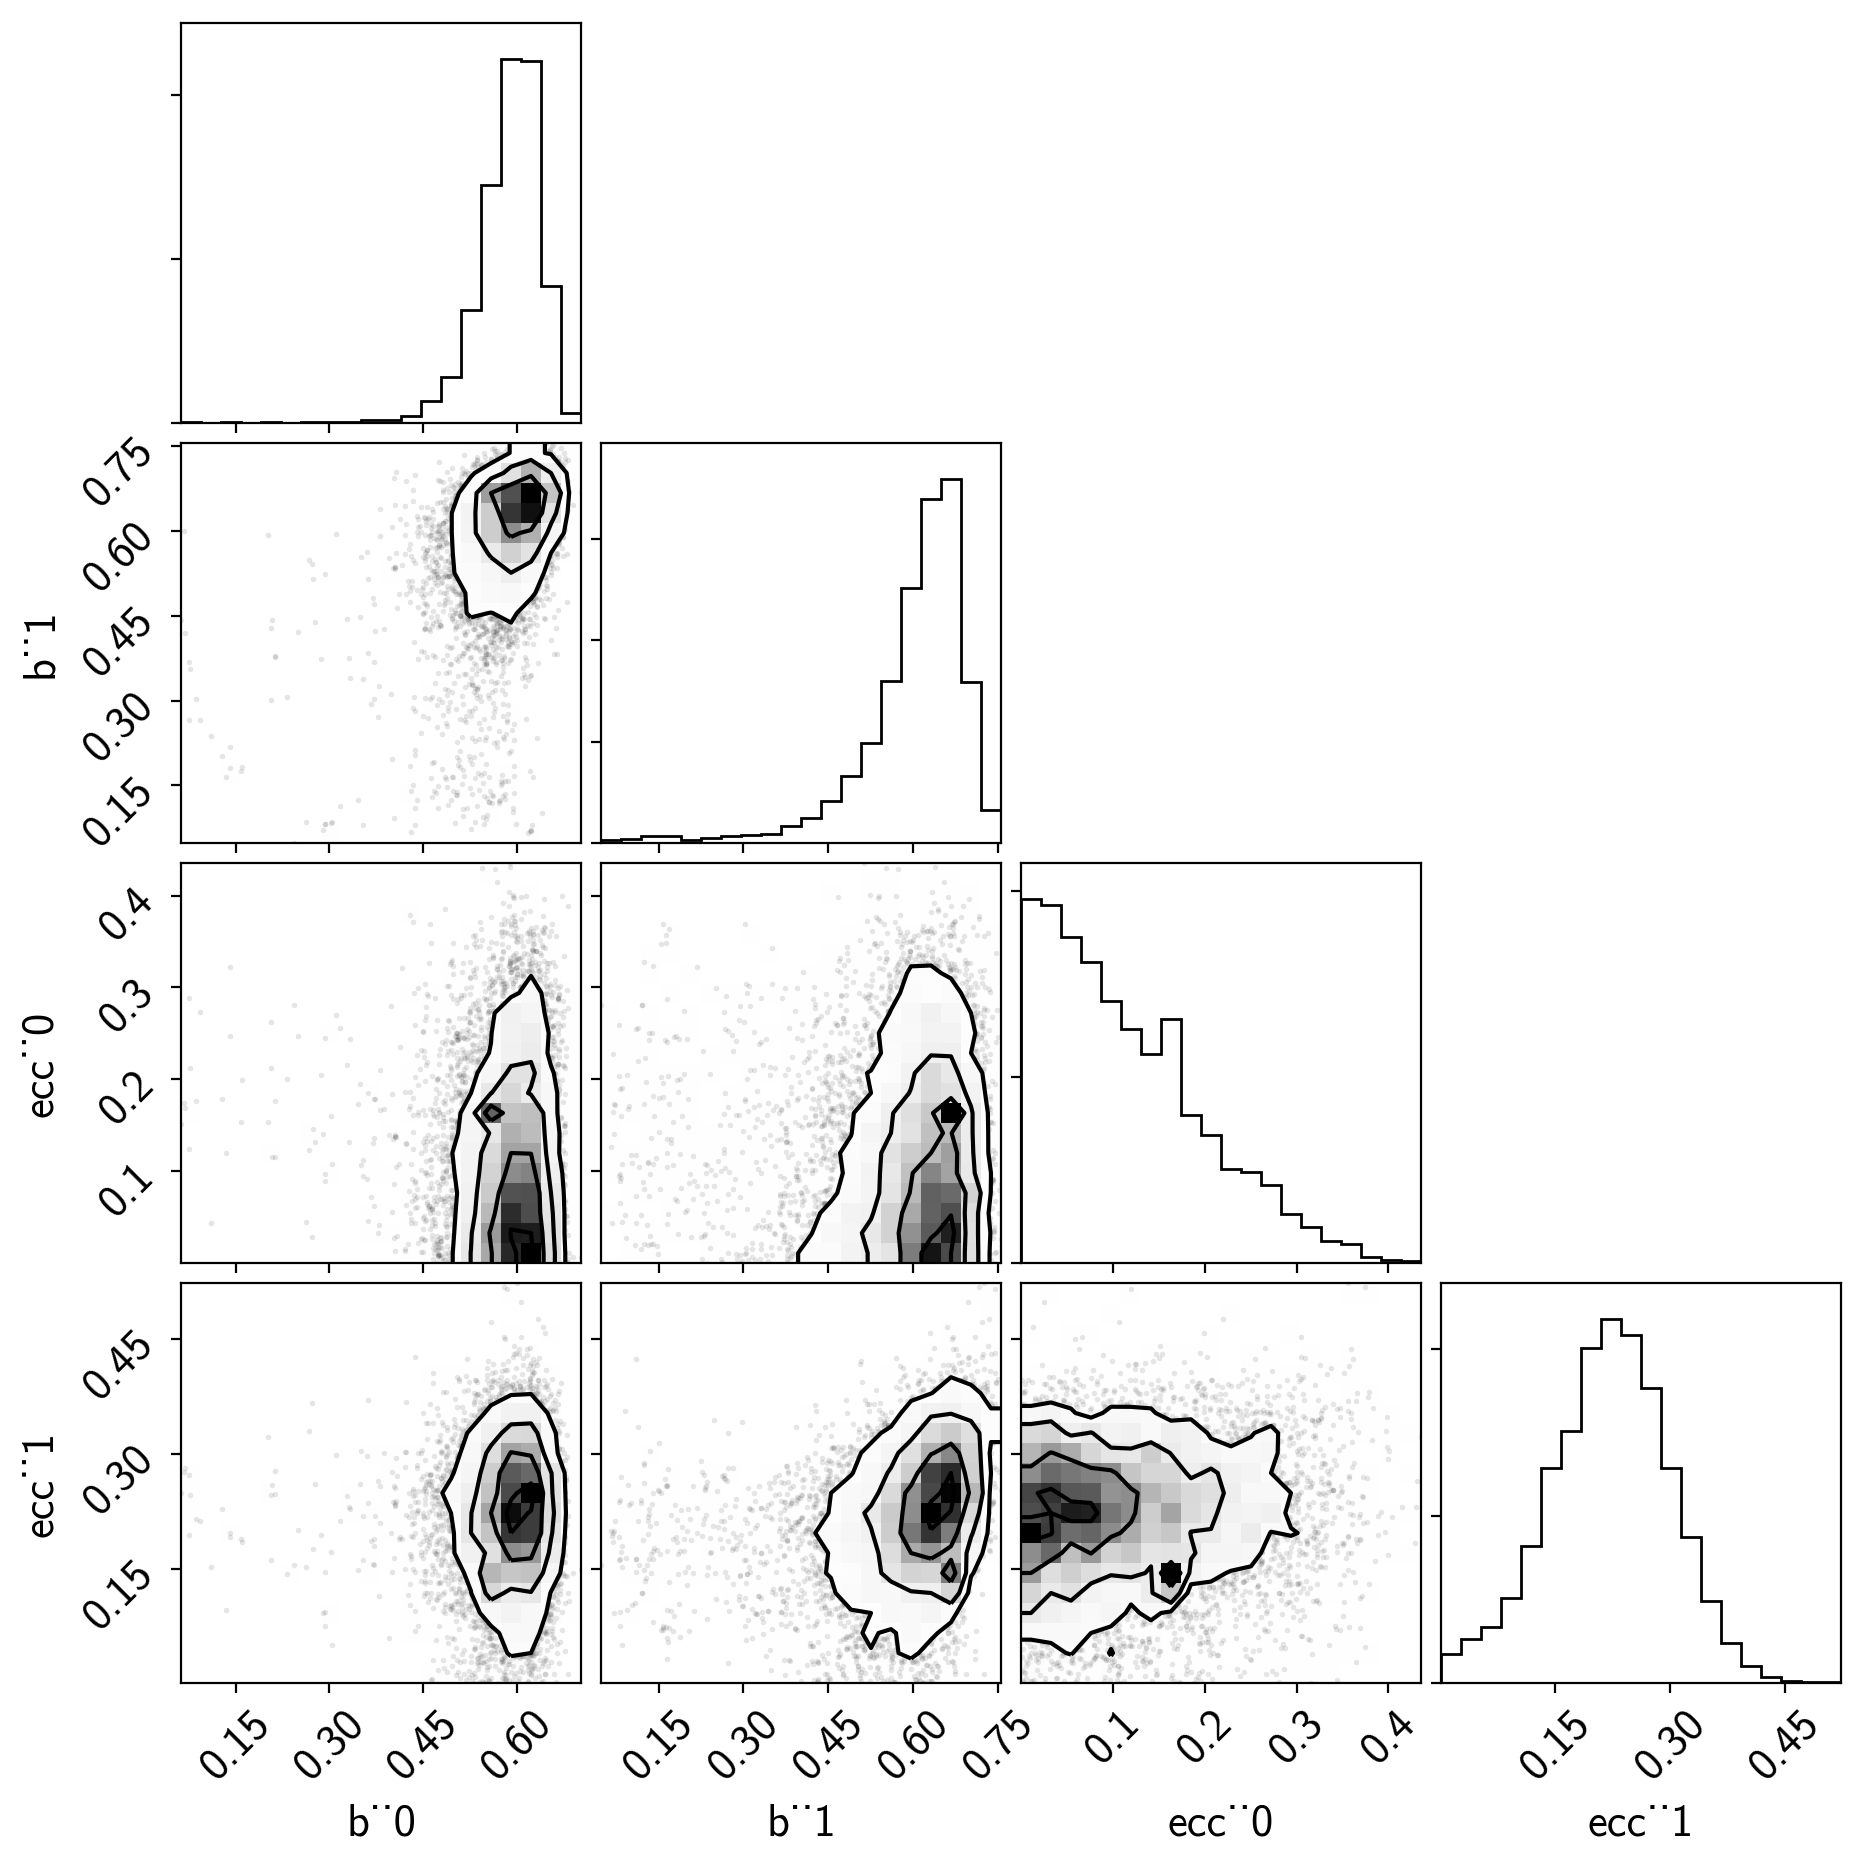

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

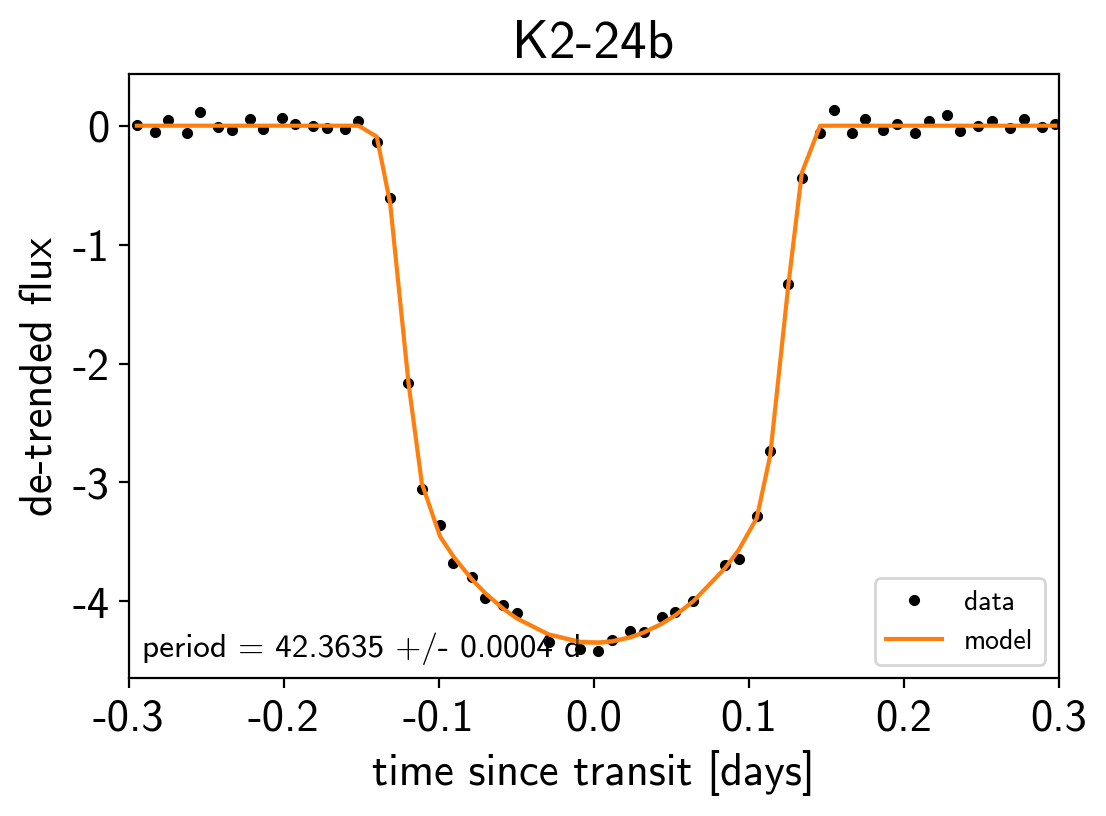

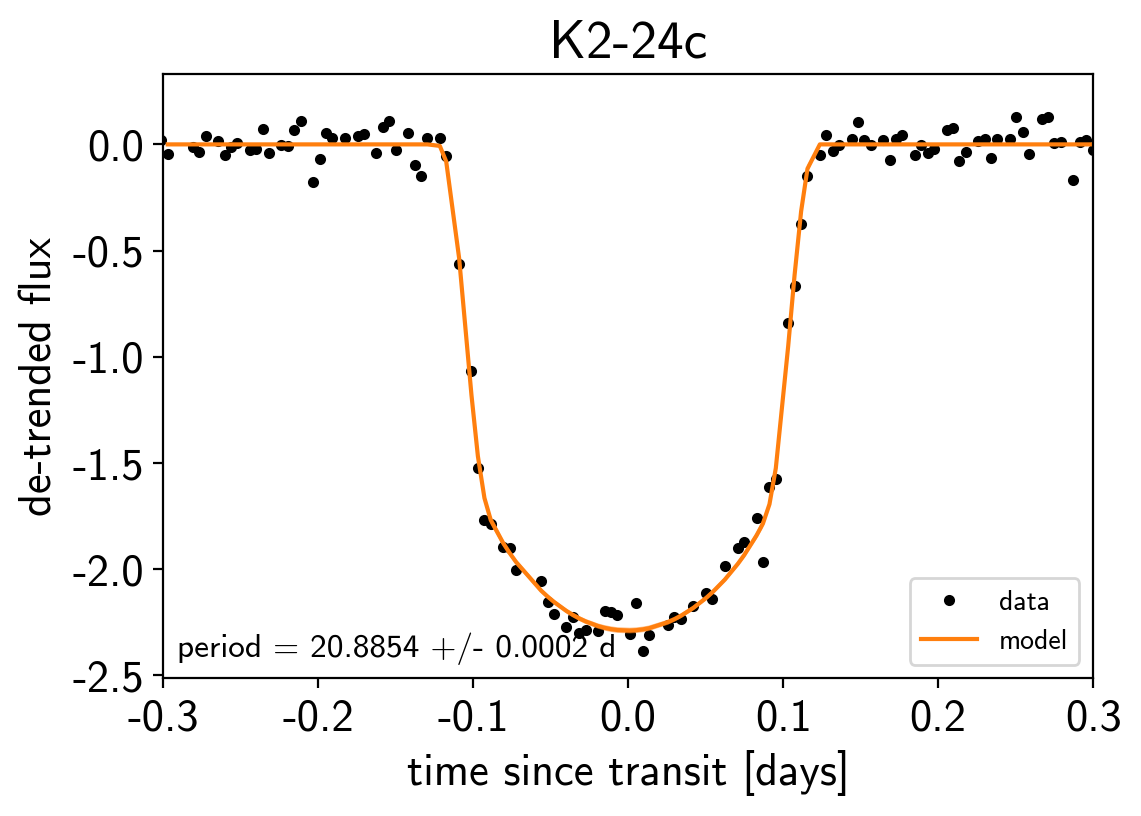

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

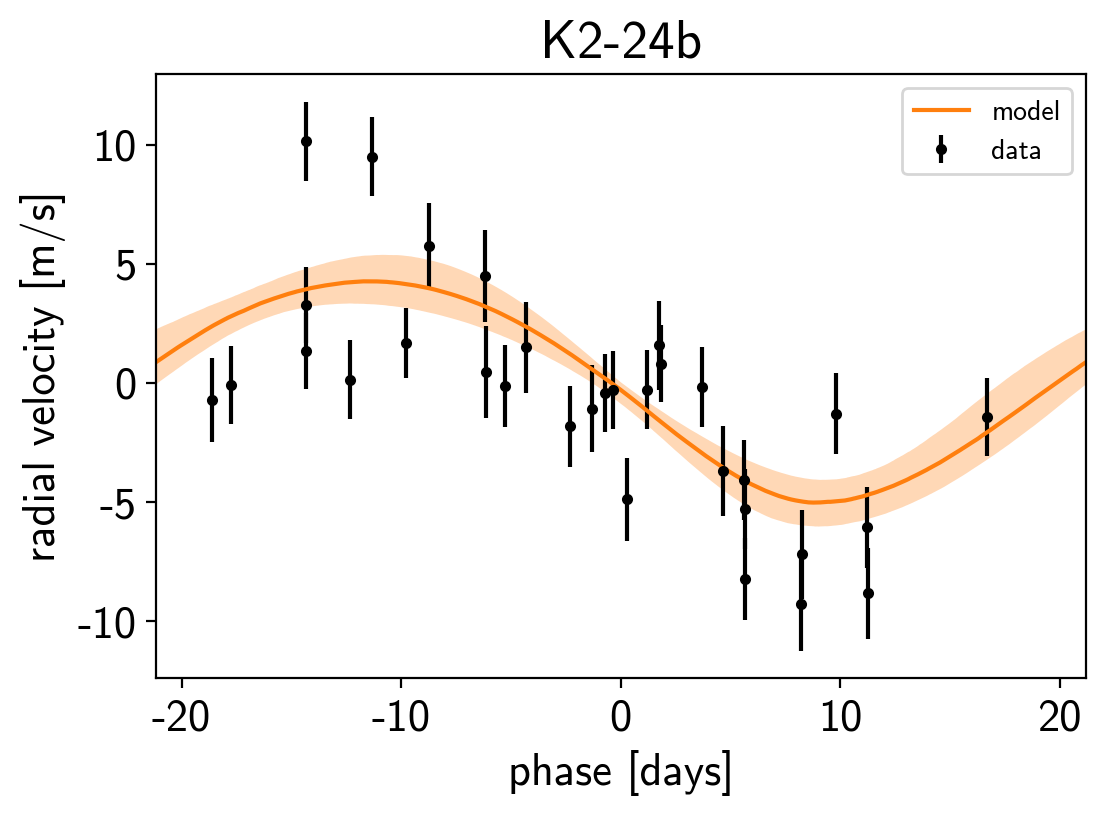

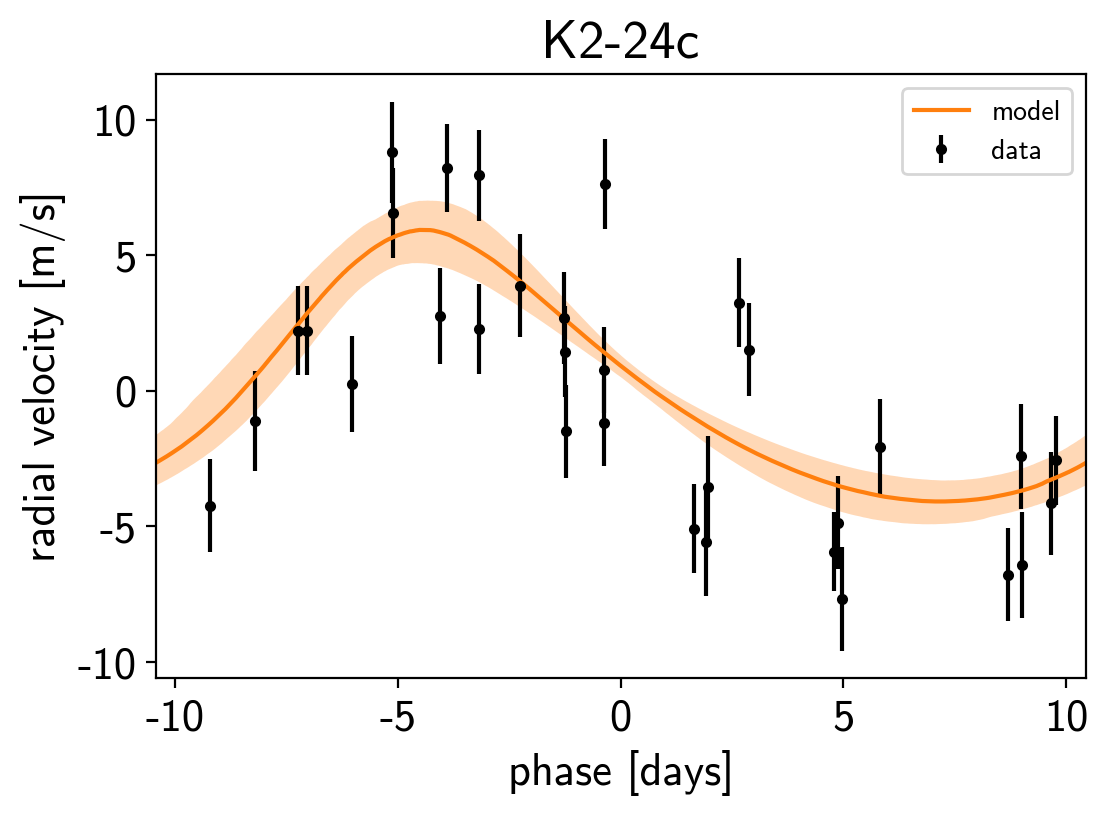

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

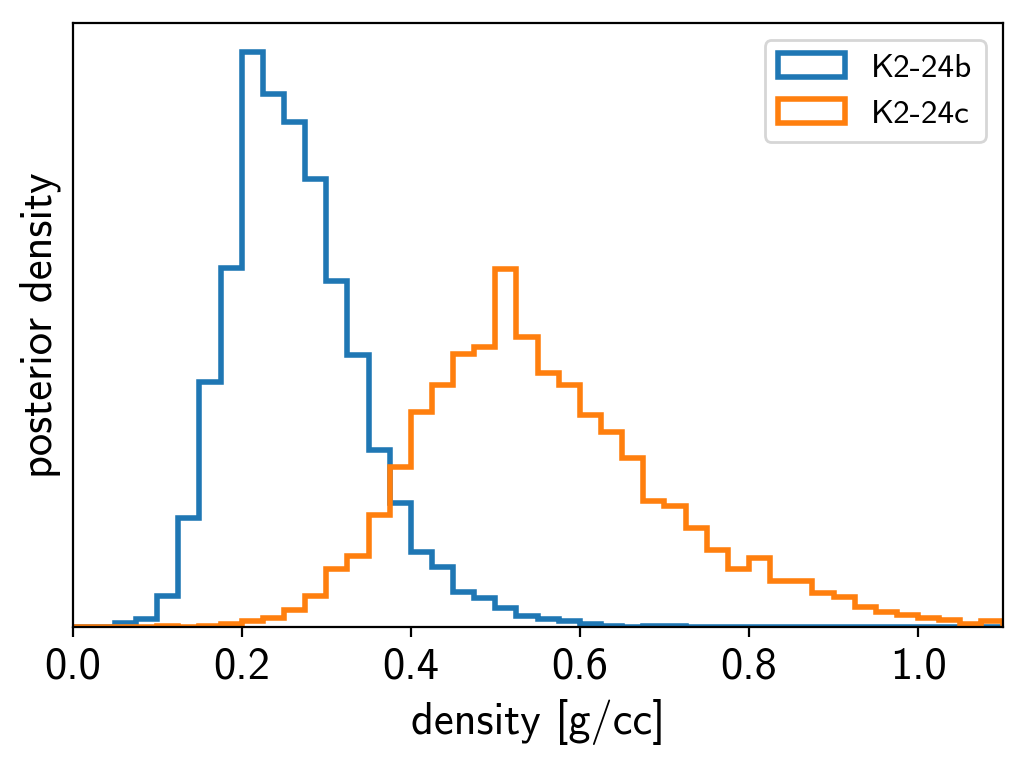

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.4},
   month = feb,
    year = 2019,
     doi = {10.5281/zenodo.2561395},
     url = {https://doi.org/10.5281/zenodo.2561395}
...
